In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "orig"
enable_aug = False
enable_aug3 = True
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-orig-enable_aug-False-enable_aug3-True-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

194419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

194419
194419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


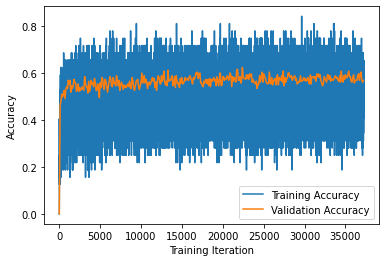

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.194 Validation Loss: 2.199 Accuracy: 0.203 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.193 Validation Loss: 2.199 Accuracy: 0.191 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.196 Validation Loss: 2.199 Accuracy: 0.180 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.195 Validation Loss: 2.199 Accuracy: 0.182 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.191 Validation Loss: 2.199 Accuracy: 0.194 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.190 Validation Loss: 2.199 Accuracy: 0.191 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.190 Validation Loss: 2.199 Accuracy: 0.192 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.189 Validation Loss: 2.199 Accuracy: 0.191 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.189 Validation Loss: 2.199 Accuracy: 0.188 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.188 Validation Loss: 2.199 Accuracy: 0.190 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.187 Validation Loss: 2.199 Accuracy: 0.188 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.187 Validation Loss: 2.199 Accuracy: 0.188 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.186 Validation Loss: 2.199 Accuracy: 0.189 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.185 Validation Loss: 2.199 Accuracy: 0.195 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.185 Validation Loss: 2.199 Accuracy: 0.196 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.184 Validation Loss: 2.199 Accuracy: 0.198 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.184 Validation Loss: 2.199 Accuracy: 0.197 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.183 Validation Loss: 2.199 Accuracy: 0.202 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.183 Validation Loss: 2.199 Accuracy: 0.208 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.181 Validation Loss: 2.199 Accuracy: 0.205 Validation Accuracy: 0.207:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.181 Validation Loss: 2.199 Accuracy: 0.205 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 20 Loss: 2.180 Validation Loss: 2.199 Accuracy: 0.208 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 21 Loss: 2.179 Validation Loss: 2.199 Accuracy: 0.208 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 22 Loss: 2.177 Validation Loss: 2.199 Accuracy: 0.215 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 23 Loss: 2.176 Validation Loss: 2.199 Accuracy: 0.207 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 24 Loss: 2.176 Validation Loss: 2.199 Accuracy: 0.196 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 25 Loss: 2.174 Validation Loss: 2.199 Accuracy: 0.203 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 26 Loss: 2.172 Validation Loss: 2.199 Accuracy: 0.203 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 27 Loss: 2.171 Validation Loss: 2.199 Accuracy: 0.200 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 28 Loss: 2.170 Validation Loss: 2.199 Accuracy: 0.198 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 29 Loss: 2.169 Validation Loss: 2.199 Accuracy: 0.198 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 30 Loss: 2.168 Validation Loss: 2.199 Accuracy: 0.198 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 31 Loss: 2.167 Validation Loss: 2.199 Accuracy: 0.205 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 32 Loss: 2.166 Validation Loss: 2.199 Accuracy: 0.212 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 33 Loss: 2.165 Validation Loss: 2.199 Accuracy: 0.220 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 34 Loss: 2.164 Validation Loss: 2.199 Accuracy: 0.230 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 35 Loss: 2.162 Validation Loss: 2.199 Accuracy: 0.221 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 36 Loss: 2.161 Validation Loss: 2.199 Accuracy: 0.227 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 37 Loss: 2.160 Validation Loss: 2.199 Accuracy: 0.229 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 38 Loss: 2.158 Validation Loss: 2.199 Accuracy: 0.230 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 39 Loss: 2.157 Validation Loss: 2.199 Accuracy: 0.235 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 40 Loss: 2.156 Validation Loss: 2.199 Accuracy: 0.237 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 41 Loss: 2.154 Validation Loss: 2.199 Accuracy: 0.234 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 42 Loss: 2.154 Validation Loss: 2.199 Accuracy: 0.228 Validation Accuracy: 0.207:   1%|▏         | 20/1519 [00:00<00:07, 195.20it/s]

Epoch: 0 Iteration: 42 Loss: 2.154 Validation Loss: 2.199 Accuracy: 0.228 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 43 Loss: 2.153 Validation Loss: 2.199 Accuracy: 0.227 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 44 Loss: 2.151 Validation Loss: 2.199 Accuracy: 0.226 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 45 Loss: 2.151 Validation Loss: 2.199 Accuracy: 0.237 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 46 Loss: 2.150 Validation Loss: 2.199 Accuracy: 0.231 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 47 Loss: 2.148 Validation Loss: 2.199 Accuracy: 0.239 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 48 Loss: 2.147 Validation Loss: 2.199 Accuracy: 0.246 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 49 Loss: 2.145 Validation Loss: 2.199 Accuracy: 0.255 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 50 Loss: 2.144 Validation Loss: 2.199 Accuracy: 0.252 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 51 Loss: 2.142 Validation Loss: 2.199 Accuracy: 0.265 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 52 Loss: 2.141 Validation Loss: 2.199 Accuracy: 0.266 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 53 Loss: 2.139 Validation Loss: 2.199 Accuracy: 0.275 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 54 Loss: 2.137 Validation Loss: 2.199 Accuracy: 0.279 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 55 Loss: 2.135 Validation Loss: 2.199 Accuracy: 0.279 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 56 Loss: 2.134 Validation Loss: 2.199 Accuracy: 0.285 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 57 Loss: 2.133 Validation Loss: 2.199 Accuracy: 0.285 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 58 Loss: 2.131 Validation Loss: 2.199 Accuracy: 0.287 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 59 Loss: 2.130 Validation Loss: 2.199 Accuracy: 0.291 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 60 Loss: 2.128 Validation Loss: 2.199 Accuracy: 0.305 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 61 Loss: 2.126 Validation Loss: 2.199 Accuracy: 0.304 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 62 Loss: 2.124 Validation Loss: 2.199 Accuracy: 0.315 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 63 Loss: 2.122 Validation Loss: 2.199 Accuracy: 0.312 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 64 Loss: 2.120 Validation Loss: 2.199 Accuracy: 0.308 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 65 Loss: 2.119 Validation Loss: 2.199 Accuracy: 0.312 Validation Accuracy: 0.207:   3%|▎         | 43/1519 [00:00<00:06, 213.17it/s]

Epoch: 0 Iteration: 65 Loss: 2.119 Validation Loss: 2.199 Accuracy: 0.312 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 66 Loss: 2.117 Validation Loss: 2.199 Accuracy: 0.322 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 67 Loss: 2.115 Validation Loss: 2.199 Accuracy: 0.324 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 68 Loss: 2.113 Validation Loss: 2.199 Accuracy: 0.329 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 69 Loss: 2.113 Validation Loss: 2.199 Accuracy: 0.323 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 70 Loss: 2.111 Validation Loss: 2.199 Accuracy: 0.318 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 71 Loss: 2.109 Validation Loss: 2.199 Accuracy: 0.315 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 72 Loss: 2.107 Validation Loss: 2.199 Accuracy: 0.312 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 73 Loss: 2.106 Validation Loss: 2.199 Accuracy: 0.313 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 74 Loss: 2.106 Validation Loss: 2.199 Accuracy: 0.322 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 75 Loss: 2.104 Validation Loss: 2.199 Accuracy: 0.323 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 76 Loss: 2.103 Validation Loss: 2.199 Accuracy: 0.316 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 77 Loss: 2.103 Validation Loss: 2.199 Accuracy: 0.311 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 78 Loss: 2.101 Validation Loss: 2.199 Accuracy: 0.312 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 79 Loss: 2.099 Validation Loss: 2.199 Accuracy: 0.321 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 80 Loss: 2.097 Validation Loss: 2.199 Accuracy: 0.327 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 81 Loss: 2.097 Validation Loss: 2.199 Accuracy: 0.322 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 82 Loss: 2.096 Validation Loss: 2.199 Accuracy: 0.317 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 83 Loss: 2.096 Validation Loss: 2.199 Accuracy: 0.316 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 84 Loss: 2.094 Validation Loss: 2.199 Accuracy: 0.323 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 85 Loss: 2.092 Validation Loss: 2.199 Accuracy: 0.323 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 86 Loss: 2.090 Validation Loss: 2.199 Accuracy: 0.324 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 87 Loss: 2.089 Validation Loss: 2.199 Accuracy: 0.334 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 88 Loss: 2.089 Validation Loss: 2.199 Accuracy: 0.334 Validation Accuracy: 0.207:   4%|▍         | 66/1519 [00:00<00:06, 218.59it/s]

Epoch: 0 Iteration: 88 Loss: 2.089 Validation Loss: 2.199 Accuracy: 0.334 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 89 Loss: 2.086 Validation Loss: 2.199 Accuracy: 0.334 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 90 Loss: 2.084 Validation Loss: 2.199 Accuracy: 0.338 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 91 Loss: 2.082 Validation Loss: 2.199 Accuracy: 0.349 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 92 Loss: 2.082 Validation Loss: 2.199 Accuracy: 0.352 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 93 Loss: 2.082 Validation Loss: 2.199 Accuracy: 0.354 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 94 Loss: 2.080 Validation Loss: 2.199 Accuracy: 0.348 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 95 Loss: 2.080 Validation Loss: 2.199 Accuracy: 0.344 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 96 Loss: 2.078 Validation Loss: 2.199 Accuracy: 0.348 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 97 Loss: 2.077 Validation Loss: 2.199 Accuracy: 0.346 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 98 Loss: 2.074 Validation Loss: 2.199 Accuracy: 0.352 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 99 Loss: 2.073 Validation Loss: 2.199 Accuracy: 0.341 Validation Accuracy: 0.207:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 100 Loss: 2.074 Validation Loss: 2.046 Accuracy: 0.336 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 101 Loss: 2.071 Validation Loss: 2.046 Accuracy: 0.341 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 102 Loss: 2.070 Validation Loss: 2.046 Accuracy: 0.347 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 103 Loss: 2.068 Validation Loss: 2.046 Accuracy: 0.355 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 104 Loss: 2.067 Validation Loss: 2.046 Accuracy: 0.358 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 105 Loss: 2.066 Validation Loss: 2.046 Accuracy: 0.363 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 106 Loss: 2.065 Validation Loss: 2.046 Accuracy: 0.369 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 107 Loss: 2.064 Validation Loss: 2.046 Accuracy: 0.370 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 108 Loss: 2.061 Validation Loss: 2.046 Accuracy: 0.368 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 109 Loss: 2.059 Validation Loss: 2.046 Accuracy: 0.380 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 110 Loss: 2.059 Validation Loss: 2.046 Accuracy: 0.384 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 111 Loss: 2.057 Validation Loss: 2.046 Accuracy: 0.380 Validation Accuracy: 0.299:   6%|▌         | 89/1519 [00:00<00:06, 221.00it/s]

Epoch: 0 Iteration: 111 Loss: 2.057 Validation Loss: 2.046 Accuracy: 0.380 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 112 Loss: 2.055 Validation Loss: 2.046 Accuracy: 0.378 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 113 Loss: 2.052 Validation Loss: 2.046 Accuracy: 0.378 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 114 Loss: 2.052 Validation Loss: 2.046 Accuracy: 0.387 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 115 Loss: 2.051 Validation Loss: 2.046 Accuracy: 0.384 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 116 Loss: 2.051 Validation Loss: 2.046 Accuracy: 0.384 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 117 Loss: 2.049 Validation Loss: 2.046 Accuracy: 0.389 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 118 Loss: 2.049 Validation Loss: 2.046 Accuracy: 0.392 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 119 Loss: 2.048 Validation Loss: 2.046 Accuracy: 0.388 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 120 Loss: 2.046 Validation Loss: 2.046 Accuracy: 0.389 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 121 Loss: 2.044 Validation Loss: 2.046 Accuracy: 0.392 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 122 Loss: 2.042 Validation Loss: 2.046 Accuracy: 0.391 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 123 Loss: 2.042 Validation Loss: 2.046 Accuracy: 0.388 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 124 Loss: 2.040 Validation Loss: 2.046 Accuracy: 0.388 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 125 Loss: 2.038 Validation Loss: 2.046 Accuracy: 0.387 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 126 Loss: 2.038 Validation Loss: 2.046 Accuracy: 0.378 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 127 Loss: 2.036 Validation Loss: 2.046 Accuracy: 0.380 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 128 Loss: 2.034 Validation Loss: 2.046 Accuracy: 0.373 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 129 Loss: 2.033 Validation Loss: 2.046 Accuracy: 0.385 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 130 Loss: 2.031 Validation Loss: 2.046 Accuracy: 0.387 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 131 Loss: 2.029 Validation Loss: 2.046 Accuracy: 0.387 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 132 Loss: 2.026 Validation Loss: 2.046 Accuracy: 0.387 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 133 Loss: 2.026 Validation Loss: 2.046 Accuracy: 0.389 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 134 Loss: 2.023 Validation Loss: 2.046 Accuracy: 0.384 Validation Accuracy: 0.299:   7%|▋         | 112/1519 [00:00<00:06, 217.66it/s]

Epoch: 0 Iteration: 134 Loss: 2.023 Validation Loss: 2.046 Accuracy: 0.384 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 135 Loss: 2.021 Validation Loss: 2.046 Accuracy: 0.394 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 136 Loss: 2.018 Validation Loss: 2.046 Accuracy: 0.398 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 137 Loss: 2.016 Validation Loss: 2.046 Accuracy: 0.395 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 138 Loss: 2.014 Validation Loss: 2.046 Accuracy: 0.403 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 139 Loss: 2.012 Validation Loss: 2.046 Accuracy: 0.388 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 140 Loss: 2.009 Validation Loss: 2.046 Accuracy: 0.391 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 141 Loss: 2.008 Validation Loss: 2.046 Accuracy: 0.388 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 142 Loss: 2.008 Validation Loss: 2.046 Accuracy: 0.385 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 143 Loss: 2.006 Validation Loss: 2.046 Accuracy: 0.382 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 144 Loss: 2.005 Validation Loss: 2.046 Accuracy: 0.384 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 145 Loss: 2.005 Validation Loss: 2.046 Accuracy: 0.377 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 146 Loss: 2.001 Validation Loss: 2.046 Accuracy: 0.382 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 147 Loss: 1.999 Validation Loss: 2.046 Accuracy: 0.384 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 148 Loss: 1.999 Validation Loss: 2.046 Accuracy: 0.375 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 149 Loss: 1.999 Validation Loss: 2.046 Accuracy: 0.380 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 150 Loss: 1.998 Validation Loss: 2.046 Accuracy: 0.377 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 151 Loss: 1.998 Validation Loss: 2.046 Accuracy: 0.375 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 152 Loss: 1.997 Validation Loss: 2.046 Accuracy: 0.378 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 153 Loss: 1.994 Validation Loss: 2.046 Accuracy: 0.381 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 154 Loss: 1.991 Validation Loss: 2.046 Accuracy: 0.381 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 155 Loss: 1.988 Validation Loss: 2.046 Accuracy: 0.392 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 156 Loss: 1.986 Validation Loss: 2.046 Accuracy: 0.395 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 157 Loss: 1.984 Validation Loss: 2.046 Accuracy: 0.394 Validation Accuracy: 0.299:   9%|▉         | 135/1519 [00:00<00:06, 220.14it/s]

Epoch: 0 Iteration: 157 Loss: 1.984 Validation Loss: 2.046 Accuracy: 0.394 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 158 Loss: 1.984 Validation Loss: 2.046 Accuracy: 0.398 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 159 Loss: 1.980 Validation Loss: 2.046 Accuracy: 0.403 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 160 Loss: 1.980 Validation Loss: 2.046 Accuracy: 0.396 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 161 Loss: 1.978 Validation Loss: 2.046 Accuracy: 0.406 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 162 Loss: 1.974 Validation Loss: 2.046 Accuracy: 0.411 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 163 Loss: 1.973 Validation Loss: 2.046 Accuracy: 0.412 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 164 Loss: 1.971 Validation Loss: 2.046 Accuracy: 0.409 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 165 Loss: 1.968 Validation Loss: 2.046 Accuracy: 0.403 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 166 Loss: 1.967 Validation Loss: 2.046 Accuracy: 0.405 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 167 Loss: 1.968 Validation Loss: 2.046 Accuracy: 0.398 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 168 Loss: 1.965 Validation Loss: 2.046 Accuracy: 0.396 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 169 Loss: 1.962 Validation Loss: 2.046 Accuracy: 0.397 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 170 Loss: 1.962 Validation Loss: 2.046 Accuracy: 0.397 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 171 Loss: 1.960 Validation Loss: 2.046 Accuracy: 0.391 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 172 Loss: 1.954 Validation Loss: 2.046 Accuracy: 0.405 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 173 Loss: 1.953 Validation Loss: 2.046 Accuracy: 0.401 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 174 Loss: 1.951 Validation Loss: 2.046 Accuracy: 0.401 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 175 Loss: 1.950 Validation Loss: 2.046 Accuracy: 0.405 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 176 Loss: 1.947 Validation Loss: 2.046 Accuracy: 0.405 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 177 Loss: 1.946 Validation Loss: 2.046 Accuracy: 0.416 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 178 Loss: 1.945 Validation Loss: 2.046 Accuracy: 0.409 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 179 Loss: 1.944 Validation Loss: 2.046 Accuracy: 0.412 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 180 Loss: 1.940 Validation Loss: 2.046 Accuracy: 0.422 Validation Accuracy: 0.299:  10%|█         | 158/1519 [00:00<00:06, 221.47it/s]

Epoch: 0 Iteration: 180 Loss: 1.940 Validation Loss: 2.046 Accuracy: 0.422 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 181 Loss: 1.940 Validation Loss: 2.046 Accuracy: 0.423 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 182 Loss: 1.939 Validation Loss: 2.046 Accuracy: 0.413 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 183 Loss: 1.935 Validation Loss: 2.046 Accuracy: 0.413 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 184 Loss: 1.929 Validation Loss: 2.046 Accuracy: 0.427 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 185 Loss: 1.927 Validation Loss: 2.046 Accuracy: 0.424 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 186 Loss: 1.925 Validation Loss: 2.046 Accuracy: 0.417 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 187 Loss: 1.920 Validation Loss: 2.046 Accuracy: 0.412 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 188 Loss: 1.917 Validation Loss: 2.046 Accuracy: 0.425 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 189 Loss: 1.916 Validation Loss: 2.046 Accuracy: 0.426 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 190 Loss: 1.914 Validation Loss: 2.046 Accuracy: 0.424 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 191 Loss: 1.910 Validation Loss: 2.046 Accuracy: 0.424 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 192 Loss: 1.912 Validation Loss: 2.046 Accuracy: 0.419 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 193 Loss: 1.910 Validation Loss: 2.046 Accuracy: 0.427 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 194 Loss: 1.911 Validation Loss: 2.046 Accuracy: 0.413 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 195 Loss: 1.908 Validation Loss: 2.046 Accuracy: 0.416 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 196 Loss: 1.905 Validation Loss: 2.046 Accuracy: 0.420 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 197 Loss: 1.902 Validation Loss: 2.046 Accuracy: 0.425 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 198 Loss: 1.899 Validation Loss: 2.046 Accuracy: 0.424 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 199 Loss: 1.899 Validation Loss: 2.046 Accuracy: 0.416 Validation Accuracy: 0.299:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 200 Loss: 1.899 Validation Loss: 1.852 Accuracy: 0.418 Validation Accuracy: 0.362:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 201 Loss: 1.894 Validation Loss: 1.852 Accuracy: 0.426 Validation Accuracy: 0.362:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 202 Loss: 1.888 Validation Loss: 1.852 Accuracy: 0.437 Validation Accuracy: 0.362:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 203 Loss: 1.887 Validation Loss: 1.852 Accuracy: 0.435 Validation Accuracy: 0.362:  12%|█▏        | 181/1519 [00:00<00:06, 221.82it/s]

Epoch: 0 Iteration: 203 Loss: 1.887 Validation Loss: 1.852 Accuracy: 0.435 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 204 Loss: 1.888 Validation Loss: 1.852 Accuracy: 0.448 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 205 Loss: 1.886 Validation Loss: 1.852 Accuracy: 0.450 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 206 Loss: 1.884 Validation Loss: 1.852 Accuracy: 0.451 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 207 Loss: 1.885 Validation Loss: 1.852 Accuracy: 0.450 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 208 Loss: 1.882 Validation Loss: 1.852 Accuracy: 0.459 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 209 Loss: 1.881 Validation Loss: 1.852 Accuracy: 0.465 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 210 Loss: 1.877 Validation Loss: 1.852 Accuracy: 0.468 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 211 Loss: 1.875 Validation Loss: 1.852 Accuracy: 0.465 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 212 Loss: 1.872 Validation Loss: 1.852 Accuracy: 0.456 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 213 Loss: 1.869 Validation Loss: 1.852 Accuracy: 0.460 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 214 Loss: 1.864 Validation Loss: 1.852 Accuracy: 0.460 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 215 Loss: 1.867 Validation Loss: 1.852 Accuracy: 0.457 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 216 Loss: 1.864 Validation Loss: 1.852 Accuracy: 0.459 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 217 Loss: 1.862 Validation Loss: 1.852 Accuracy: 0.464 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:00<00:06, 218.92it/s]

Epoch: 0 Iteration: 218 Loss: 1.859 Validation Loss: 1.852 Accuracy: 0.454 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:01<00:06, 218.92it/s]

Epoch: 0 Iteration: 219 Loss: 1.858 Validation Loss: 1.852 Accuracy: 0.446 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:01<00:06, 218.92it/s]

Epoch: 0 Iteration: 220 Loss: 1.855 Validation Loss: 1.852 Accuracy: 0.440 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:01<00:06, 218.92it/s]

Epoch: 0 Iteration: 221 Loss: 1.854 Validation Loss: 1.852 Accuracy: 0.438 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:01<00:06, 218.92it/s]

Epoch: 0 Iteration: 222 Loss: 1.857 Validation Loss: 1.852 Accuracy: 0.446 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:01<00:06, 218.92it/s]

Epoch: 0 Iteration: 223 Loss: 1.853 Validation Loss: 1.852 Accuracy: 0.438 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:01<00:06, 218.92it/s]

Epoch: 0 Iteration: 224 Loss: 1.853 Validation Loss: 1.852 Accuracy: 0.437 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:01<00:06, 218.92it/s]

Epoch: 0 Iteration: 225 Loss: 1.853 Validation Loss: 1.852 Accuracy: 0.445 Validation Accuracy: 0.362:  13%|█▎        | 204/1519 [00:01<00:06, 218.92it/s]

Epoch: 0 Iteration: 225 Loss: 1.853 Validation Loss: 1.852 Accuracy: 0.445 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 226 Loss: 1.853 Validation Loss: 1.852 Accuracy: 0.438 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 227 Loss: 1.849 Validation Loss: 1.852 Accuracy: 0.441 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 228 Loss: 1.846 Validation Loss: 1.852 Accuracy: 0.439 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 229 Loss: 1.844 Validation Loss: 1.852 Accuracy: 0.452 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 230 Loss: 1.841 Validation Loss: 1.852 Accuracy: 0.453 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 231 Loss: 1.841 Validation Loss: 1.852 Accuracy: 0.453 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 232 Loss: 1.838 Validation Loss: 1.852 Accuracy: 0.448 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 233 Loss: 1.838 Validation Loss: 1.852 Accuracy: 0.451 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 234 Loss: 1.835 Validation Loss: 1.852 Accuracy: 0.443 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 235 Loss: 1.832 Validation Loss: 1.852 Accuracy: 0.434 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 236 Loss: 1.832 Validation Loss: 1.852 Accuracy: 0.438 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 237 Loss: 1.834 Validation Loss: 1.852 Accuracy: 0.434 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 238 Loss: 1.833 Validation Loss: 1.852 Accuracy: 0.438 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 239 Loss: 1.828 Validation Loss: 1.852 Accuracy: 0.439 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 240 Loss: 1.825 Validation Loss: 1.852 Accuracy: 0.441 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 241 Loss: 1.822 Validation Loss: 1.852 Accuracy: 0.452 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 242 Loss: 1.818 Validation Loss: 1.852 Accuracy: 0.462 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 243 Loss: 1.817 Validation Loss: 1.852 Accuracy: 0.469 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 244 Loss: 1.812 Validation Loss: 1.852 Accuracy: 0.474 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 245 Loss: 1.809 Validation Loss: 1.852 Accuracy: 0.472 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 246 Loss: 1.807 Validation Loss: 1.852 Accuracy: 0.469 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 247 Loss: 1.807 Validation Loss: 1.852 Accuracy: 0.473 Validation Accuracy: 0.362:  15%|█▍        | 226/1519 [00:01<00:05, 217.10it/s]

Epoch: 0 Iteration: 247 Loss: 1.807 Validation Loss: 1.852 Accuracy: 0.473 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 248 Loss: 1.808 Validation Loss: 1.852 Accuracy: 0.472 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 249 Loss: 1.804 Validation Loss: 1.852 Accuracy: 0.482 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 250 Loss: 1.800 Validation Loss: 1.852 Accuracy: 0.489 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 251 Loss: 1.795 Validation Loss: 1.852 Accuracy: 0.489 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 252 Loss: 1.794 Validation Loss: 1.852 Accuracy: 0.483 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 253 Loss: 1.791 Validation Loss: 1.852 Accuracy: 0.483 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 254 Loss: 1.785 Validation Loss: 1.852 Accuracy: 0.492 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 255 Loss: 1.777 Validation Loss: 1.852 Accuracy: 0.510 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 256 Loss: 1.776 Validation Loss: 1.852 Accuracy: 0.517 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 257 Loss: 1.771 Validation Loss: 1.852 Accuracy: 0.520 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 258 Loss: 1.769 Validation Loss: 1.852 Accuracy: 0.531 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 259 Loss: 1.767 Validation Loss: 1.852 Accuracy: 0.526 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 260 Loss: 1.765 Validation Loss: 1.852 Accuracy: 0.515 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 261 Loss: 1.764 Validation Loss: 1.852 Accuracy: 0.508 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 262 Loss: 1.765 Validation Loss: 1.852 Accuracy: 0.509 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 263 Loss: 1.761 Validation Loss: 1.852 Accuracy: 0.511 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 264 Loss: 1.763 Validation Loss: 1.852 Accuracy: 0.507 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 265 Loss: 1.757 Validation Loss: 1.852 Accuracy: 0.505 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 266 Loss: 1.755 Validation Loss: 1.852 Accuracy: 0.498 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 267 Loss: 1.750 Validation Loss: 1.852 Accuracy: 0.498 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 268 Loss: 1.747 Validation Loss: 1.852 Accuracy: 0.488 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 269 Loss: 1.746 Validation Loss: 1.852 Accuracy: 0.481 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 270 Loss: 1.746 Validation Loss: 1.852 Accuracy: 0.495 Validation Accuracy: 0.362:  16%|█▋        | 248/1519 [00:01<00:05, 216.39it/s]

Epoch: 0 Iteration: 270 Loss: 1.746 Validation Loss: 1.852 Accuracy: 0.495 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 271 Loss: 1.745 Validation Loss: 1.852 Accuracy: 0.500 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 272 Loss: 1.741 Validation Loss: 1.852 Accuracy: 0.505 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 273 Loss: 1.742 Validation Loss: 1.852 Accuracy: 0.498 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 274 Loss: 1.744 Validation Loss: 1.852 Accuracy: 0.491 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 275 Loss: 1.747 Validation Loss: 1.852 Accuracy: 0.485 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 276 Loss: 1.746 Validation Loss: 1.852 Accuracy: 0.492 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 277 Loss: 1.744 Validation Loss: 1.852 Accuracy: 0.481 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 278 Loss: 1.740 Validation Loss: 1.852 Accuracy: 0.489 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 279 Loss: 1.741 Validation Loss: 1.852 Accuracy: 0.491 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 280 Loss: 1.741 Validation Loss: 1.852 Accuracy: 0.491 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 281 Loss: 1.737 Validation Loss: 1.852 Accuracy: 0.494 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 282 Loss: 1.728 Validation Loss: 1.852 Accuracy: 0.500 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 283 Loss: 1.727 Validation Loss: 1.852 Accuracy: 0.511 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 284 Loss: 1.724 Validation Loss: 1.852 Accuracy: 0.513 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 285 Loss: 1.724 Validation Loss: 1.852 Accuracy: 0.517 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 286 Loss: 1.719 Validation Loss: 1.852 Accuracy: 0.529 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 287 Loss: 1.718 Validation Loss: 1.852 Accuracy: 0.537 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 288 Loss: 1.715 Validation Loss: 1.852 Accuracy: 0.534 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 289 Loss: 1.712 Validation Loss: 1.852 Accuracy: 0.534 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 290 Loss: 1.713 Validation Loss: 1.852 Accuracy: 0.537 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 291 Loss: 1.712 Validation Loss: 1.852 Accuracy: 0.531 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 292 Loss: 1.714 Validation Loss: 1.852 Accuracy: 0.519 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 293 Loss: 1.708 Validation Loss: 1.852 Accuracy: 0.520 Validation Accuracy: 0.362:  18%|█▊        | 271/1519 [00:01<00:05, 217.60it/s]

Epoch: 0 Iteration: 293 Loss: 1.708 Validation Loss: 1.852 Accuracy: 0.520 Validation Accuracy: 0.362:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 294 Loss: 1.705 Validation Loss: 1.852 Accuracy: 0.526 Validation Accuracy: 0.362:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 295 Loss: 1.706 Validation Loss: 1.852 Accuracy: 0.520 Validation Accuracy: 0.362:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 296 Loss: 1.699 Validation Loss: 1.852 Accuracy: 0.515 Validation Accuracy: 0.362:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 297 Loss: 1.696 Validation Loss: 1.852 Accuracy: 0.509 Validation Accuracy: 0.362:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 298 Loss: 1.690 Validation Loss: 1.852 Accuracy: 0.512 Validation Accuracy: 0.362:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 299 Loss: 1.688 Validation Loss: 1.852 Accuracy: 0.510 Validation Accuracy: 0.362:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 300 Loss: 1.685 Validation Loss: 1.595 Accuracy: 0.502 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 301 Loss: 1.680 Validation Loss: 1.595 Accuracy: 0.502 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 302 Loss: 1.684 Validation Loss: 1.595 Accuracy: 0.505 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 303 Loss: 1.681 Validation Loss: 1.595 Accuracy: 0.505 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 304 Loss: 1.676 Validation Loss: 1.595 Accuracy: 0.506 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 305 Loss: 1.677 Validation Loss: 1.595 Accuracy: 0.508 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 306 Loss: 1.674 Validation Loss: 1.595 Accuracy: 0.510 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 307 Loss: 1.670 Validation Loss: 1.595 Accuracy: 0.523 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 308 Loss: 1.668 Validation Loss: 1.595 Accuracy: 0.521 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 309 Loss: 1.666 Validation Loss: 1.595 Accuracy: 0.524 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 310 Loss: 1.662 Validation Loss: 1.595 Accuracy: 0.523 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 311 Loss: 1.660 Validation Loss: 1.595 Accuracy: 0.522 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 312 Loss: 1.653 Validation Loss: 1.595 Accuracy: 0.526 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 313 Loss: 1.653 Validation Loss: 1.595 Accuracy: 0.517 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 314 Loss: 1.655 Validation Loss: 1.595 Accuracy: 0.516 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 315 Loss: 1.651 Validation Loss: 1.595 Accuracy: 0.521 Validation Accuracy: 0.413:  19%|█▉        | 294/1519 [00:01<00:05, 218.50it/s]

Epoch: 0 Iteration: 315 Loss: 1.651 Validation Loss: 1.595 Accuracy: 0.521 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 316 Loss: 1.648 Validation Loss: 1.595 Accuracy: 0.518 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 317 Loss: 1.640 Validation Loss: 1.595 Accuracy: 0.528 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 318 Loss: 1.642 Validation Loss: 1.595 Accuracy: 0.529 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 319 Loss: 1.635 Validation Loss: 1.595 Accuracy: 0.529 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 320 Loss: 1.632 Validation Loss: 1.595 Accuracy: 0.541 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 321 Loss: 1.632 Validation Loss: 1.595 Accuracy: 0.548 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 322 Loss: 1.626 Validation Loss: 1.595 Accuracy: 0.545 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 323 Loss: 1.623 Validation Loss: 1.595 Accuracy: 0.552 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 324 Loss: 1.619 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 325 Loss: 1.612 Validation Loss: 1.595 Accuracy: 0.564 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 326 Loss: 1.611 Validation Loss: 1.595 Accuracy: 0.570 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 327 Loss: 1.611 Validation Loss: 1.595 Accuracy: 0.552 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 328 Loss: 1.606 Validation Loss: 1.595 Accuracy: 0.556 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 329 Loss: 1.607 Validation Loss: 1.595 Accuracy: 0.553 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 330 Loss: 1.604 Validation Loss: 1.595 Accuracy: 0.557 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 331 Loss: 1.599 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 332 Loss: 1.600 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 333 Loss: 1.589 Validation Loss: 1.595 Accuracy: 0.561 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 334 Loss: 1.581 Validation Loss: 1.595 Accuracy: 0.566 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 335 Loss: 1.573 Validation Loss: 1.595 Accuracy: 0.560 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 336 Loss: 1.570 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 337 Loss: 1.574 Validation Loss: 1.595 Accuracy: 0.556 Validation Accuracy: 0.413:  21%|██        | 316/1519 [00:01<00:05, 215.12it/s]

Epoch: 0 Iteration: 337 Loss: 1.574 Validation Loss: 1.595 Accuracy: 0.556 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 338 Loss: 1.571 Validation Loss: 1.595 Accuracy: 0.555 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 339 Loss: 1.568 Validation Loss: 1.595 Accuracy: 0.563 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 340 Loss: 1.564 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 341 Loss: 1.559 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 342 Loss: 1.557 Validation Loss: 1.595 Accuracy: 0.563 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 343 Loss: 1.557 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 344 Loss: 1.552 Validation Loss: 1.595 Accuracy: 0.549 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 345 Loss: 1.551 Validation Loss: 1.595 Accuracy: 0.551 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 346 Loss: 1.542 Validation Loss: 1.595 Accuracy: 0.560 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 347 Loss: 1.535 Validation Loss: 1.595 Accuracy: 0.569 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 348 Loss: 1.537 Validation Loss: 1.595 Accuracy: 0.566 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 349 Loss: 1.530 Validation Loss: 1.595 Accuracy: 0.564 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 350 Loss: 1.528 Validation Loss: 1.595 Accuracy: 0.566 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 351 Loss: 1.524 Validation Loss: 1.595 Accuracy: 0.571 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 352 Loss: 1.517 Validation Loss: 1.595 Accuracy: 0.577 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 353 Loss: 1.517 Validation Loss: 1.595 Accuracy: 0.586 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 354 Loss: 1.518 Validation Loss: 1.595 Accuracy: 0.587 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 355 Loss: 1.517 Validation Loss: 1.595 Accuracy: 0.591 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 356 Loss: 1.517 Validation Loss: 1.595 Accuracy: 0.577 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 357 Loss: 1.512 Validation Loss: 1.595 Accuracy: 0.573 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 358 Loss: 1.509 Validation Loss: 1.595 Accuracy: 0.570 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 359 Loss: 1.511 Validation Loss: 1.595 Accuracy: 0.566 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 360 Loss: 1.509 Validation Loss: 1.595 Accuracy: 0.555 Validation Accuracy: 0.413:  22%|██▏       | 338/1519 [00:01<00:05, 216.46it/s]

Epoch: 0 Iteration: 360 Loss: 1.509 Validation Loss: 1.595 Accuracy: 0.555 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 361 Loss: 1.507 Validation Loss: 1.595 Accuracy: 0.545 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 362 Loss: 1.498 Validation Loss: 1.595 Accuracy: 0.548 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 363 Loss: 1.495 Validation Loss: 1.595 Accuracy: 0.539 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 364 Loss: 1.492 Validation Loss: 1.595 Accuracy: 0.542 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 365 Loss: 1.490 Validation Loss: 1.595 Accuracy: 0.538 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 366 Loss: 1.491 Validation Loss: 1.595 Accuracy: 0.535 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 367 Loss: 1.490 Validation Loss: 1.595 Accuracy: 0.537 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 368 Loss: 1.483 Validation Loss: 1.595 Accuracy: 0.549 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 369 Loss: 1.479 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 370 Loss: 1.475 Validation Loss: 1.595 Accuracy: 0.566 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 371 Loss: 1.472 Validation Loss: 1.595 Accuracy: 0.572 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 372 Loss: 1.476 Validation Loss: 1.595 Accuracy: 0.562 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 373 Loss: 1.478 Validation Loss: 1.595 Accuracy: 0.562 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 374 Loss: 1.472 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 375 Loss: 1.470 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 376 Loss: 1.464 Validation Loss: 1.595 Accuracy: 0.570 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 377 Loss: 1.462 Validation Loss: 1.595 Accuracy: 0.573 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 378 Loss: 1.454 Validation Loss: 1.595 Accuracy: 0.566 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 379 Loss: 1.448 Validation Loss: 1.595 Accuracy: 0.560 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 380 Loss: 1.442 Validation Loss: 1.595 Accuracy: 0.561 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 381 Loss: 1.441 Validation Loss: 1.595 Accuracy: 0.559 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 382 Loss: 1.444 Validation Loss: 1.595 Accuracy: 0.563 Validation Accuracy: 0.413:  24%|██▍       | 361/1519 [00:01<00:05, 218.03it/s]

Epoch: 0 Iteration: 382 Loss: 1.444 Validation Loss: 1.595 Accuracy: 0.563 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 383 Loss: 1.437 Validation Loss: 1.595 Accuracy: 0.570 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 384 Loss: 1.435 Validation Loss: 1.595 Accuracy: 0.577 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 385 Loss: 1.430 Validation Loss: 1.595 Accuracy: 0.568 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 386 Loss: 1.428 Validation Loss: 1.595 Accuracy: 0.566 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 387 Loss: 1.425 Validation Loss: 1.595 Accuracy: 0.570 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 388 Loss: 1.417 Validation Loss: 1.595 Accuracy: 0.580 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 389 Loss: 1.417 Validation Loss: 1.595 Accuracy: 0.588 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 390 Loss: 1.414 Validation Loss: 1.595 Accuracy: 0.582 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 391 Loss: 1.411 Validation Loss: 1.595 Accuracy: 0.588 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 392 Loss: 1.405 Validation Loss: 1.595 Accuracy: 0.580 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 393 Loss: 1.402 Validation Loss: 1.595 Accuracy: 0.570 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 394 Loss: 1.396 Validation Loss: 1.595 Accuracy: 0.565 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 395 Loss: 1.391 Validation Loss: 1.595 Accuracy: 0.577 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 396 Loss: 1.391 Validation Loss: 1.595 Accuracy: 0.574 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 397 Loss: 1.391 Validation Loss: 1.595 Accuracy: 0.567 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 398 Loss: 1.392 Validation Loss: 1.595 Accuracy: 0.558 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 399 Loss: 1.386 Validation Loss: 1.595 Accuracy: 0.557 Validation Accuracy: 0.413:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 400 Loss: 1.382 Validation Loss: 1.286 Accuracy: 0.570 Validation Accuracy: 0.460:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 401 Loss: 1.378 Validation Loss: 1.286 Accuracy: 0.566 Validation Accuracy: 0.460:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 402 Loss: 1.378 Validation Loss: 1.286 Accuracy: 0.567 Validation Accuracy: 0.460:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 403 Loss: 1.378 Validation Loss: 1.286 Accuracy: 0.575 Validation Accuracy: 0.460:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 404 Loss: 1.378 Validation Loss: 1.286 Accuracy: 0.577 Validation Accuracy: 0.460:  25%|██▌       | 383/1519 [00:01<00:05, 218.33it/s]

Epoch: 0 Iteration: 404 Loss: 1.378 Validation Loss: 1.286 Accuracy: 0.577 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 405 Loss: 1.369 Validation Loss: 1.286 Accuracy: 0.584 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 406 Loss: 1.365 Validation Loss: 1.286 Accuracy: 0.590 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 407 Loss: 1.363 Validation Loss: 1.286 Accuracy: 0.599 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 408 Loss: 1.363 Validation Loss: 1.286 Accuracy: 0.594 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 409 Loss: 1.357 Validation Loss: 1.286 Accuracy: 0.595 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 410 Loss: 1.351 Validation Loss: 1.286 Accuracy: 0.596 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 411 Loss: 1.348 Validation Loss: 1.286 Accuracy: 0.596 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 412 Loss: 1.341 Validation Loss: 1.286 Accuracy: 0.605 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 413 Loss: 1.336 Validation Loss: 1.286 Accuracy: 0.599 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 414 Loss: 1.337 Validation Loss: 1.286 Accuracy: 0.597 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 415 Loss: 1.333 Validation Loss: 1.286 Accuracy: 0.595 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 416 Loss: 1.330 Validation Loss: 1.286 Accuracy: 0.585 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 417 Loss: 1.325 Validation Loss: 1.286 Accuracy: 0.583 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 418 Loss: 1.319 Validation Loss: 1.286 Accuracy: 0.593 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 419 Loss: 1.320 Validation Loss: 1.286 Accuracy: 0.586 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 420 Loss: 1.320 Validation Loss: 1.286 Accuracy: 0.577 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 421 Loss: 1.315 Validation Loss: 1.286 Accuracy: 0.580 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 422 Loss: 1.307 Validation Loss: 1.286 Accuracy: 0.578 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 423 Loss: 1.301 Validation Loss: 1.286 Accuracy: 0.587 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 424 Loss: 1.299 Validation Loss: 1.286 Accuracy: 0.588 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 425 Loss: 1.303 Validation Loss: 1.286 Accuracy: 0.581 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 426 Loss: 1.301 Validation Loss: 1.286 Accuracy: 0.584 Validation Accuracy: 0.460:  27%|██▋       | 405/1519 [00:01<00:05, 214.82it/s]

Epoch: 0 Iteration: 426 Loss: 1.301 Validation Loss: 1.286 Accuracy: 0.584 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:01<00:05, 216.31it/s]

Epoch: 0 Iteration: 427 Loss: 1.298 Validation Loss: 1.286 Accuracy: 0.589 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:01<00:05, 216.31it/s]

Epoch: 0 Iteration: 428 Loss: 1.297 Validation Loss: 1.286 Accuracy: 0.591 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:01<00:05, 216.31it/s]

Epoch: 0 Iteration: 429 Loss: 1.296 Validation Loss: 1.286 Accuracy: 0.588 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:01<00:05, 216.31it/s]

Epoch: 0 Iteration: 430 Loss: 1.296 Validation Loss: 1.286 Accuracy: 0.594 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:01<00:05, 216.31it/s]

Epoch: 0 Iteration: 431 Loss: 1.291 Validation Loss: 1.286 Accuracy: 0.592 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:01<00:05, 216.31it/s]

Epoch: 0 Iteration: 432 Loss: 1.290 Validation Loss: 1.286 Accuracy: 0.595 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:01<00:05, 216.31it/s]

Epoch: 0 Iteration: 433 Loss: 1.283 Validation Loss: 1.286 Accuracy: 0.606 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:01<00:05, 216.31it/s]

Epoch: 0 Iteration: 434 Loss: 1.278 Validation Loss: 1.286 Accuracy: 0.611 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 435 Loss: 1.278 Validation Loss: 1.286 Accuracy: 0.609 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 436 Loss: 1.273 Validation Loss: 1.286 Accuracy: 0.616 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 437 Loss: 1.266 Validation Loss: 1.286 Accuracy: 0.615 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 438 Loss: 1.266 Validation Loss: 1.286 Accuracy: 0.609 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 439 Loss: 1.261 Validation Loss: 1.286 Accuracy: 0.614 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 440 Loss: 1.259 Validation Loss: 1.286 Accuracy: 0.613 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 441 Loss: 1.253 Validation Loss: 1.286 Accuracy: 0.619 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 442 Loss: 1.255 Validation Loss: 1.286 Accuracy: 0.614 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 443 Loss: 1.255 Validation Loss: 1.286 Accuracy: 0.602 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 444 Loss: 1.250 Validation Loss: 1.286 Accuracy: 0.600 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 445 Loss: 1.243 Validation Loss: 1.286 Accuracy: 0.603 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 446 Loss: 1.243 Validation Loss: 1.286 Accuracy: 0.599 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 447 Loss: 1.237 Validation Loss: 1.286 Accuracy: 0.601 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 448 Loss: 1.229 Validation Loss: 1.286 Accuracy: 0.611 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 449 Loss: 1.224 Validation Loss: 1.286 Accuracy: 0.613 Validation Accuracy: 0.460:  28%|██▊       | 427/1519 [00:02<00:05, 216.31it/s]

Epoch: 0 Iteration: 449 Loss: 1.224 Validation Loss: 1.286 Accuracy: 0.613 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 450 Loss: 1.223 Validation Loss: 1.286 Accuracy: 0.613 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 451 Loss: 1.221 Validation Loss: 1.286 Accuracy: 0.602 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 452 Loss: 1.219 Validation Loss: 1.286 Accuracy: 0.610 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 453 Loss: 1.222 Validation Loss: 1.286 Accuracy: 0.610 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 454 Loss: 1.219 Validation Loss: 1.286 Accuracy: 0.611 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 455 Loss: 1.217 Validation Loss: 1.286 Accuracy: 0.618 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 456 Loss: 1.215 Validation Loss: 1.286 Accuracy: 0.623 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 457 Loss: 1.215 Validation Loss: 1.286 Accuracy: 0.623 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 458 Loss: 1.212 Validation Loss: 1.286 Accuracy: 0.611 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 459 Loss: 1.212 Validation Loss: 1.286 Accuracy: 0.607 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 460 Loss: 1.211 Validation Loss: 1.286 Accuracy: 0.606 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 461 Loss: 1.213 Validation Loss: 1.286 Accuracy: 0.609 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 462 Loss: 1.211 Validation Loss: 1.286 Accuracy: 0.602 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 463 Loss: 1.206 Validation Loss: 1.286 Accuracy: 0.604 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 464 Loss: 1.202 Validation Loss: 1.286 Accuracy: 0.602 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 465 Loss: 1.200 Validation Loss: 1.286 Accuracy: 0.604 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 466 Loss: 1.198 Validation Loss: 1.286 Accuracy: 0.598 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 467 Loss: 1.196 Validation Loss: 1.286 Accuracy: 0.593 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 468 Loss: 1.198 Validation Loss: 1.286 Accuracy: 0.592 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 469 Loss: 1.195 Validation Loss: 1.286 Accuracy: 0.599 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 470 Loss: 1.194 Validation Loss: 1.286 Accuracy: 0.601 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 471 Loss: 1.191 Validation Loss: 1.286 Accuracy: 0.609 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 472 Loss: 1.190 Validation Loss: 1.286 Accuracy: 0.613 Validation Accuracy: 0.460:  30%|██▉       | 450/1519 [00:02<00:04, 218.60it/s]

Epoch: 0 Iteration: 472 Loss: 1.190 Validation Loss: 1.286 Accuracy: 0.613 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 473 Loss: 1.190 Validation Loss: 1.286 Accuracy: 0.600 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 474 Loss: 1.186 Validation Loss: 1.286 Accuracy: 0.599 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 475 Loss: 1.182 Validation Loss: 1.286 Accuracy: 0.591 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 476 Loss: 1.177 Validation Loss: 1.286 Accuracy: 0.601 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 477 Loss: 1.174 Validation Loss: 1.286 Accuracy: 0.602 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 478 Loss: 1.171 Validation Loss: 1.286 Accuracy: 0.604 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 479 Loss: 1.164 Validation Loss: 1.286 Accuracy: 0.604 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 480 Loss: 1.157 Validation Loss: 1.286 Accuracy: 0.605 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 481 Loss: 1.154 Validation Loss: 1.286 Accuracy: 0.591 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 482 Loss: 1.150 Validation Loss: 1.286 Accuracy: 0.594 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 483 Loss: 1.145 Validation Loss: 1.286 Accuracy: 0.608 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 484 Loss: 1.145 Validation Loss: 1.286 Accuracy: 0.609 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 485 Loss: 1.149 Validation Loss: 1.286 Accuracy: 0.604 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 486 Loss: 1.144 Validation Loss: 1.286 Accuracy: 0.607 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 487 Loss: 1.144 Validation Loss: 1.286 Accuracy: 0.604 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 488 Loss: 1.139 Validation Loss: 1.286 Accuracy: 0.610 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 489 Loss: 1.138 Validation Loss: 1.286 Accuracy: 0.609 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 490 Loss: 1.133 Validation Loss: 1.286 Accuracy: 0.610 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 491 Loss: 1.132 Validation Loss: 1.286 Accuracy: 0.623 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 492 Loss: 1.129 Validation Loss: 1.286 Accuracy: 0.618 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 493 Loss: 1.123 Validation Loss: 1.286 Accuracy: 0.613 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 494 Loss: 1.123 Validation Loss: 1.286 Accuracy: 0.618 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 495 Loss: 1.120 Validation Loss: 1.286 Accuracy: 0.626 Validation Accuracy: 0.460:  31%|███       | 473/1519 [00:02<00:04, 220.89it/s]

Epoch: 0 Iteration: 495 Loss: 1.120 Validation Loss: 1.286 Accuracy: 0.626 Validation Accuracy: 0.460:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 496 Loss: 1.120 Validation Loss: 1.286 Accuracy: 0.620 Validation Accuracy: 0.460:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 497 Loss: 1.118 Validation Loss: 1.286 Accuracy: 0.626 Validation Accuracy: 0.460:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 498 Loss: 1.116 Validation Loss: 1.286 Accuracy: 0.623 Validation Accuracy: 0.460:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 499 Loss: 1.115 Validation Loss: 1.286 Accuracy: 0.623 Validation Accuracy: 0.460:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 500 Loss: 1.117 Validation Loss: 1.032 Accuracy: 0.620 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 501 Loss: 1.120 Validation Loss: 1.032 Accuracy: 0.608 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 502 Loss: 1.118 Validation Loss: 1.032 Accuracy: 0.615 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 503 Loss: 1.116 Validation Loss: 1.032 Accuracy: 0.616 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 504 Loss: 1.112 Validation Loss: 1.032 Accuracy: 0.617 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 505 Loss: 1.107 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 506 Loss: 1.107 Validation Loss: 1.032 Accuracy: 0.608 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 507 Loss: 1.101 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 508 Loss: 1.100 Validation Loss: 1.032 Accuracy: 0.616 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 509 Loss: 1.096 Validation Loss: 1.032 Accuracy: 0.616 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 510 Loss: 1.095 Validation Loss: 1.032 Accuracy: 0.620 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 511 Loss: 1.092 Validation Loss: 1.032 Accuracy: 0.633 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 512 Loss: 1.094 Validation Loss: 1.032 Accuracy: 0.625 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 513 Loss: 1.094 Validation Loss: 1.032 Accuracy: 0.626 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 514 Loss: 1.091 Validation Loss: 1.032 Accuracy: 0.625 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 515 Loss: 1.091 Validation Loss: 1.032 Accuracy: 0.623 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 516 Loss: 1.087 Validation Loss: 1.032 Accuracy: 0.630 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 517 Loss: 1.087 Validation Loss: 1.032 Accuracy: 0.624 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 518 Loss: 1.089 Validation Loss: 1.032 Accuracy: 0.624 Validation Accuracy: 0.494:  33%|███▎      | 496/1519 [00:02<00:04, 222.97it/s]

Epoch: 0 Iteration: 518 Loss: 1.089 Validation Loss: 1.032 Accuracy: 0.624 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 519 Loss: 1.089 Validation Loss: 1.032 Accuracy: 0.625 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 520 Loss: 1.086 Validation Loss: 1.032 Accuracy: 0.623 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 521 Loss: 1.080 Validation Loss: 1.032 Accuracy: 0.615 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 522 Loss: 1.078 Validation Loss: 1.032 Accuracy: 0.620 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 523 Loss: 1.081 Validation Loss: 1.032 Accuracy: 0.621 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 524 Loss: 1.078 Validation Loss: 1.032 Accuracy: 0.624 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 525 Loss: 1.075 Validation Loss: 1.032 Accuracy: 0.629 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 526 Loss: 1.070 Validation Loss: 1.032 Accuracy: 0.623 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 527 Loss: 1.070 Validation Loss: 1.032 Accuracy: 0.623 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 528 Loss: 1.068 Validation Loss: 1.032 Accuracy: 0.627 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 529 Loss: 1.064 Validation Loss: 1.032 Accuracy: 0.629 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 530 Loss: 1.063 Validation Loss: 1.032 Accuracy: 0.635 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 531 Loss: 1.063 Validation Loss: 1.032 Accuracy: 0.631 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 532 Loss: 1.056 Validation Loss: 1.032 Accuracy: 0.629 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 533 Loss: 1.052 Validation Loss: 1.032 Accuracy: 0.625 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 534 Loss: 1.053 Validation Loss: 1.032 Accuracy: 0.619 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 535 Loss: 1.050 Validation Loss: 1.032 Accuracy: 0.623 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 536 Loss: 1.049 Validation Loss: 1.032 Accuracy: 0.632 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 537 Loss: 1.049 Validation Loss: 1.032 Accuracy: 0.629 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 538 Loss: 1.048 Validation Loss: 1.032 Accuracy: 0.614 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 539 Loss: 1.046 Validation Loss: 1.032 Accuracy: 0.614 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 540 Loss: 1.044 Validation Loss: 1.032 Accuracy: 0.612 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 541 Loss: 1.044 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  34%|███▍      | 519/1519 [00:02<00:04, 220.01it/s]

Epoch: 0 Iteration: 541 Loss: 1.044 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 542 Loss: 1.044 Validation Loss: 1.032 Accuracy: 0.608 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 543 Loss: 1.037 Validation Loss: 1.032 Accuracy: 0.615 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 544 Loss: 1.040 Validation Loss: 1.032 Accuracy: 0.617 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 545 Loss: 1.038 Validation Loss: 1.032 Accuracy: 0.616 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 546 Loss: 1.042 Validation Loss: 1.032 Accuracy: 0.607 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 547 Loss: 1.043 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 548 Loss: 1.044 Validation Loss: 1.032 Accuracy: 0.627 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 549 Loss: 1.047 Validation Loss: 1.032 Accuracy: 0.631 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 550 Loss: 1.047 Validation Loss: 1.032 Accuracy: 0.627 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 551 Loss: 1.040 Validation Loss: 1.032 Accuracy: 0.642 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 552 Loss: 1.039 Validation Loss: 1.032 Accuracy: 0.645 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 553 Loss: 1.036 Validation Loss: 1.032 Accuracy: 0.642 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 554 Loss: 1.033 Validation Loss: 1.032 Accuracy: 0.645 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 555 Loss: 1.034 Validation Loss: 1.032 Accuracy: 0.643 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 556 Loss: 1.033 Validation Loss: 1.032 Accuracy: 0.649 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 557 Loss: 1.029 Validation Loss: 1.032 Accuracy: 0.645 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 558 Loss: 1.024 Validation Loss: 1.032 Accuracy: 0.645 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 559 Loss: 1.020 Validation Loss: 1.032 Accuracy: 0.634 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 560 Loss: 1.021 Validation Loss: 1.032 Accuracy: 0.641 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 561 Loss: 1.017 Validation Loss: 1.032 Accuracy: 0.634 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 562 Loss: 1.012 Validation Loss: 1.032 Accuracy: 0.637 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 563 Loss: 1.013 Validation Loss: 1.032 Accuracy: 0.641 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 564 Loss: 1.009 Validation Loss: 1.032 Accuracy: 0.637 Validation Accuracy: 0.494:  36%|███▌      | 542/1519 [00:02<00:04, 221.63it/s]

Epoch: 0 Iteration: 564 Loss: 1.009 Validation Loss: 1.032 Accuracy: 0.637 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 565 Loss: 1.011 Validation Loss: 1.032 Accuracy: 0.630 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 566 Loss: 1.006 Validation Loss: 1.032 Accuracy: 0.629 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 567 Loss: 1.003 Validation Loss: 1.032 Accuracy: 0.628 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 568 Loss: 1.004 Validation Loss: 1.032 Accuracy: 0.618 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 569 Loss: 1.002 Validation Loss: 1.032 Accuracy: 0.623 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 570 Loss: 1.002 Validation Loss: 1.032 Accuracy: 0.616 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 571 Loss: 1.005 Validation Loss: 1.032 Accuracy: 0.619 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 572 Loss: 1.002 Validation Loss: 1.032 Accuracy: 0.621 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 573 Loss: 0.999 Validation Loss: 1.032 Accuracy: 0.619 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 574 Loss: 1.001 Validation Loss: 1.032 Accuracy: 0.610 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 575 Loss: 1.002 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 576 Loss: 1.002 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 577 Loss: 1.003 Validation Loss: 1.032 Accuracy: 0.614 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 578 Loss: 1.002 Validation Loss: 1.032 Accuracy: 0.620 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 579 Loss: 1.000 Validation Loss: 1.032 Accuracy: 0.618 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 580 Loss: 1.002 Validation Loss: 1.032 Accuracy: 0.616 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 581 Loss: 1.004 Validation Loss: 1.032 Accuracy: 0.609 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 582 Loss: 1.006 Validation Loss: 1.032 Accuracy: 0.605 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 583 Loss: 1.006 Validation Loss: 1.032 Accuracy: 0.606 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 584 Loss: 1.007 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 585 Loss: 1.005 Validation Loss: 1.032 Accuracy: 0.615 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 586 Loss: 1.003 Validation Loss: 1.032 Accuracy: 0.609 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 587 Loss: 1.001 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  37%|███▋      | 565/1519 [00:02<00:04, 223.49it/s]

Epoch: 0 Iteration: 587 Loss: 1.001 Validation Loss: 1.032 Accuracy: 0.613 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 588 Loss: 0.992 Validation Loss: 1.032 Accuracy: 0.621 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 589 Loss: 0.992 Validation Loss: 1.032 Accuracy: 0.622 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 590 Loss: 0.988 Validation Loss: 1.032 Accuracy: 0.624 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 591 Loss: 0.989 Validation Loss: 1.032 Accuracy: 0.625 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 592 Loss: 0.990 Validation Loss: 1.032 Accuracy: 0.628 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 593 Loss: 0.989 Validation Loss: 1.032 Accuracy: 0.627 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 594 Loss: 0.984 Validation Loss: 1.032 Accuracy: 0.635 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 595 Loss: 0.977 Validation Loss: 1.032 Accuracy: 0.641 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 596 Loss: 0.972 Validation Loss: 1.032 Accuracy: 0.650 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 597 Loss: 0.969 Validation Loss: 1.032 Accuracy: 0.653 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 598 Loss: 0.967 Validation Loss: 1.032 Accuracy: 0.646 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 599 Loss: 0.968 Validation Loss: 1.032 Accuracy: 0.641 Validation Accuracy: 0.494:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 600 Loss: 0.961 Validation Loss: 0.901 Accuracy: 0.651 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 601 Loss: 0.961 Validation Loss: 0.901 Accuracy: 0.645 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 602 Loss: 0.959 Validation Loss: 0.901 Accuracy: 0.644 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 603 Loss: 0.962 Validation Loss: 0.901 Accuracy: 0.637 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 604 Loss: 0.955 Validation Loss: 0.901 Accuracy: 0.636 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 605 Loss: 0.954 Validation Loss: 0.901 Accuracy: 0.629 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 606 Loss: 0.955 Validation Loss: 0.901 Accuracy: 0.626 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 607 Loss: 0.959 Validation Loss: 0.901 Accuracy: 0.615 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 608 Loss: 0.959 Validation Loss: 0.901 Accuracy: 0.620 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 609 Loss: 0.956 Validation Loss: 0.901 Accuracy: 0.628 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 610 Loss: 0.953 Validation Loss: 0.901 Accuracy: 0.622 Validation Accuracy: 0.520:  39%|███▊      | 588/1519 [00:02<00:04, 224.96it/s]

Epoch: 0 Iteration: 610 Loss: 0.953 Validation Loss: 0.901 Accuracy: 0.622 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 611 Loss: 0.953 Validation Loss: 0.901 Accuracy: 0.625 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 612 Loss: 0.953 Validation Loss: 0.901 Accuracy: 0.626 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 613 Loss: 0.952 Validation Loss: 0.901 Accuracy: 0.634 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 614 Loss: 0.955 Validation Loss: 0.901 Accuracy: 0.633 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 615 Loss: 0.957 Validation Loss: 0.901 Accuracy: 0.634 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 616 Loss: 0.959 Validation Loss: 0.901 Accuracy: 0.637 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 617 Loss: 0.961 Validation Loss: 0.901 Accuracy: 0.644 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 618 Loss: 0.960 Validation Loss: 0.901 Accuracy: 0.645 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 619 Loss: 0.956 Validation Loss: 0.901 Accuracy: 0.645 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 620 Loss: 0.954 Validation Loss: 0.901 Accuracy: 0.647 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 621 Loss: 0.949 Validation Loss: 0.901 Accuracy: 0.655 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 622 Loss: 0.951 Validation Loss: 0.901 Accuracy: 0.651 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 623 Loss: 0.950 Validation Loss: 0.901 Accuracy: 0.646 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 624 Loss: 0.952 Validation Loss: 0.901 Accuracy: 0.644 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 625 Loss: 0.951 Validation Loss: 0.901 Accuracy: 0.645 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 626 Loss: 0.946 Validation Loss: 0.901 Accuracy: 0.647 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 627 Loss: 0.946 Validation Loss: 0.901 Accuracy: 0.645 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 628 Loss: 0.947 Validation Loss: 0.901 Accuracy: 0.642 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 629 Loss: 0.951 Validation Loss: 0.901 Accuracy: 0.638 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 630 Loss: 0.952 Validation Loss: 0.901 Accuracy: 0.639 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 631 Loss: 0.952 Validation Loss: 0.901 Accuracy: 0.633 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 632 Loss: 0.953 Validation Loss: 0.901 Accuracy: 0.631 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 633 Loss: 0.956 Validation Loss: 0.901 Accuracy: 0.634 Validation Accuracy: 0.520:  40%|████      | 611/1519 [00:02<00:04, 222.08it/s]

Epoch: 0 Iteration: 633 Loss: 0.956 Validation Loss: 0.901 Accuracy: 0.634 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 634 Loss: 0.954 Validation Loss: 0.901 Accuracy: 0.636 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 635 Loss: 0.952 Validation Loss: 0.901 Accuracy: 0.643 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 636 Loss: 0.951 Validation Loss: 0.901 Accuracy: 0.647 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 637 Loss: 0.947 Validation Loss: 0.901 Accuracy: 0.651 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 638 Loss: 0.949 Validation Loss: 0.901 Accuracy: 0.652 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 639 Loss: 0.956 Validation Loss: 0.901 Accuracy: 0.646 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 640 Loss: 0.960 Validation Loss: 0.901 Accuracy: 0.647 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 641 Loss: 0.961 Validation Loss: 0.901 Accuracy: 0.648 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 642 Loss: 0.961 Validation Loss: 0.901 Accuracy: 0.645 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 643 Loss: 0.963 Validation Loss: 0.901 Accuracy: 0.637 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 644 Loss: 0.958 Validation Loss: 0.901 Accuracy: 0.644 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 645 Loss: 0.957 Validation Loss: 0.901 Accuracy: 0.641 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 646 Loss: 0.958 Validation Loss: 0.901 Accuracy: 0.636 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 647 Loss: 0.957 Validation Loss: 0.901 Accuracy: 0.629 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 648 Loss: 0.959 Validation Loss: 0.901 Accuracy: 0.630 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 649 Loss: 0.958 Validation Loss: 0.901 Accuracy: 0.637 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 650 Loss: 0.953 Validation Loss: 0.901 Accuracy: 0.638 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 651 Loss: 0.950 Validation Loss: 0.901 Accuracy: 0.641 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 652 Loss: 0.948 Validation Loss: 0.901 Accuracy: 0.645 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 653 Loss: 0.943 Validation Loss: 0.901 Accuracy: 0.650 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 654 Loss: 0.944 Validation Loss: 0.901 Accuracy: 0.637 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 655 Loss: 0.943 Validation Loss: 0.901 Accuracy: 0.633 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 656 Loss: 0.945 Validation Loss: 0.901 Accuracy: 0.627 Validation Accuracy: 0.520:  42%|████▏     | 634/1519 [00:02<00:03, 223.29it/s]

Epoch: 0 Iteration: 656 Loss: 0.945 Validation Loss: 0.901 Accuracy: 0.627 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:02<00:03, 222.90it/s]

Epoch: 0 Iteration: 657 Loss: 0.945 Validation Loss: 0.901 Accuracy: 0.632 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:02<00:03, 222.90it/s]

Epoch: 0 Iteration: 658 Loss: 0.946 Validation Loss: 0.901 Accuracy: 0.624 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 659 Loss: 0.940 Validation Loss: 0.901 Accuracy: 0.620 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 660 Loss: 0.937 Validation Loss: 0.901 Accuracy: 0.618 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 661 Loss: 0.932 Validation Loss: 0.901 Accuracy: 0.622 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 662 Loss: 0.931 Validation Loss: 0.901 Accuracy: 0.628 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 663 Loss: 0.925 Validation Loss: 0.901 Accuracy: 0.634 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 664 Loss: 0.931 Validation Loss: 0.901 Accuracy: 0.638 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 665 Loss: 0.932 Validation Loss: 0.901 Accuracy: 0.641 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 666 Loss: 0.929 Validation Loss: 0.901 Accuracy: 0.652 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 667 Loss: 0.926 Validation Loss: 0.901 Accuracy: 0.651 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 668 Loss: 0.929 Validation Loss: 0.901 Accuracy: 0.652 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 669 Loss: 0.926 Validation Loss: 0.901 Accuracy: 0.655 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 670 Loss: 0.925 Validation Loss: 0.901 Accuracy: 0.662 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 671 Loss: 0.921 Validation Loss: 0.901 Accuracy: 0.662 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 672 Loss: 0.921 Validation Loss: 0.901 Accuracy: 0.662 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 673 Loss: 0.925 Validation Loss: 0.901 Accuracy: 0.660 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 674 Loss: 0.922 Validation Loss: 0.901 Accuracy: 0.659 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 675 Loss: 0.927 Validation Loss: 0.901 Accuracy: 0.655 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 676 Loss: 0.925 Validation Loss: 0.901 Accuracy: 0.643 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 677 Loss: 0.922 Validation Loss: 0.901 Accuracy: 0.652 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 678 Loss: 0.920 Validation Loss: 0.901 Accuracy: 0.655 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 679 Loss: 0.920 Validation Loss: 0.901 Accuracy: 0.657 Validation Accuracy: 0.520:  43%|████▎     | 657/1519 [00:03<00:03, 222.90it/s]

Epoch: 0 Iteration: 679 Loss: 0.920 Validation Loss: 0.901 Accuracy: 0.657 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 680 Loss: 0.928 Validation Loss: 0.901 Accuracy: 0.642 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 681 Loss: 0.936 Validation Loss: 0.901 Accuracy: 0.634 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 682 Loss: 0.936 Validation Loss: 0.901 Accuracy: 0.624 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 683 Loss: 0.935 Validation Loss: 0.901 Accuracy: 0.631 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 684 Loss: 0.926 Validation Loss: 0.901 Accuracy: 0.640 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 685 Loss: 0.923 Validation Loss: 0.901 Accuracy: 0.643 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 686 Loss: 0.927 Validation Loss: 0.901 Accuracy: 0.648 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 687 Loss: 0.923 Validation Loss: 0.901 Accuracy: 0.648 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 688 Loss: 0.917 Validation Loss: 0.901 Accuracy: 0.652 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 689 Loss: 0.915 Validation Loss: 0.901 Accuracy: 0.650 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 690 Loss: 0.919 Validation Loss: 0.901 Accuracy: 0.655 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 691 Loss: 0.919 Validation Loss: 0.901 Accuracy: 0.660 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 692 Loss: 0.918 Validation Loss: 0.901 Accuracy: 0.665 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 693 Loss: 0.918 Validation Loss: 0.901 Accuracy: 0.662 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 694 Loss: 0.916 Validation Loss: 0.901 Accuracy: 0.655 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 695 Loss: 0.912 Validation Loss: 0.901 Accuracy: 0.654 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 696 Loss: 0.910 Validation Loss: 0.901 Accuracy: 0.650 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 697 Loss: 0.915 Validation Loss: 0.901 Accuracy: 0.636 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 698 Loss: 0.914 Validation Loss: 0.901 Accuracy: 0.634 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 699 Loss: 0.912 Validation Loss: 0.901 Accuracy: 0.637 Validation Accuracy: 0.520:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 700 Loss: 0.902 Validation Loss: 0.830 Accuracy: 0.641 Validation Accuracy: 0.541:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 701 Loss: 0.895 Validation Loss: 0.830 Accuracy: 0.640 Validation Accuracy: 0.541:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 702 Loss: 0.896 Validation Loss: 0.830 Accuracy: 0.643 Validation Accuracy: 0.541:  45%|████▍     | 680/1519 [00:03<00:03, 222.79it/s]

Epoch: 0 Iteration: 702 Loss: 0.896 Validation Loss: 0.830 Accuracy: 0.643 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 703 Loss: 0.898 Validation Loss: 0.830 Accuracy: 0.641 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 704 Loss: 0.902 Validation Loss: 0.830 Accuracy: 0.645 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 705 Loss: 0.902 Validation Loss: 0.830 Accuracy: 0.650 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 706 Loss: 0.905 Validation Loss: 0.830 Accuracy: 0.648 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 707 Loss: 0.910 Validation Loss: 0.830 Accuracy: 0.648 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 708 Loss: 0.909 Validation Loss: 0.830 Accuracy: 0.647 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 709 Loss: 0.911 Validation Loss: 0.830 Accuracy: 0.649 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 710 Loss: 0.915 Validation Loss: 0.830 Accuracy: 0.646 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 711 Loss: 0.912 Validation Loss: 0.830 Accuracy: 0.649 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 712 Loss: 0.914 Validation Loss: 0.830 Accuracy: 0.648 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 713 Loss: 0.914 Validation Loss: 0.830 Accuracy: 0.644 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 714 Loss: 0.911 Validation Loss: 0.830 Accuracy: 0.644 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 715 Loss: 0.912 Validation Loss: 0.830 Accuracy: 0.638 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 716 Loss: 0.910 Validation Loss: 0.830 Accuracy: 0.652 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 717 Loss: 0.907 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 718 Loss: 0.910 Validation Loss: 0.830 Accuracy: 0.665 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 719 Loss: 0.913 Validation Loss: 0.830 Accuracy: 0.654 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 720 Loss: 0.914 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 721 Loss: 0.916 Validation Loss: 0.830 Accuracy: 0.648 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 722 Loss: 0.908 Validation Loss: 0.830 Accuracy: 0.653 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 723 Loss: 0.903 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 724 Loss: 0.903 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 725 Loss: 0.901 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.541:  46%|████▋     | 703/1519 [00:03<00:03, 215.15it/s]

Epoch: 0 Iteration: 725 Loss: 0.901 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 726 Loss: 0.897 Validation Loss: 0.830 Accuracy: 0.657 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 727 Loss: 0.891 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 728 Loss: 0.893 Validation Loss: 0.830 Accuracy: 0.654 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 729 Loss: 0.897 Validation Loss: 0.830 Accuracy: 0.652 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 730 Loss: 0.892 Validation Loss: 0.830 Accuracy: 0.650 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 731 Loss: 0.899 Validation Loss: 0.830 Accuracy: 0.646 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 732 Loss: 0.894 Validation Loss: 0.830 Accuracy: 0.645 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 733 Loss: 0.893 Validation Loss: 0.830 Accuracy: 0.629 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 734 Loss: 0.892 Validation Loss: 0.830 Accuracy: 0.635 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 735 Loss: 0.889 Validation Loss: 0.830 Accuracy: 0.630 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 736 Loss: 0.888 Validation Loss: 0.830 Accuracy: 0.634 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 737 Loss: 0.888 Validation Loss: 0.830 Accuracy: 0.629 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 738 Loss: 0.884 Validation Loss: 0.830 Accuracy: 0.629 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 739 Loss: 0.880 Validation Loss: 0.830 Accuracy: 0.637 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 740 Loss: 0.878 Validation Loss: 0.830 Accuracy: 0.643 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 741 Loss: 0.876 Validation Loss: 0.830 Accuracy: 0.651 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 742 Loss: 0.884 Validation Loss: 0.830 Accuracy: 0.643 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 743 Loss: 0.885 Validation Loss: 0.830 Accuracy: 0.649 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 744 Loss: 0.879 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 745 Loss: 0.876 Validation Loss: 0.830 Accuracy: 0.667 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 746 Loss: 0.878 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 747 Loss: 0.882 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 748 Loss: 0.883 Validation Loss: 0.830 Accuracy: 0.661 Validation Accuracy: 0.541:  48%|████▊     | 726/1519 [00:03<00:03, 218.19it/s]

Epoch: 0 Iteration: 748 Loss: 0.883 Validation Loss: 0.830 Accuracy: 0.661 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 749 Loss: 0.878 Validation Loss: 0.830 Accuracy: 0.660 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 750 Loss: 0.875 Validation Loss: 0.830 Accuracy: 0.657 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 751 Loss: 0.874 Validation Loss: 0.830 Accuracy: 0.657 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 752 Loss: 0.880 Validation Loss: 0.830 Accuracy: 0.661 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 753 Loss: 0.876 Validation Loss: 0.830 Accuracy: 0.663 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 754 Loss: 0.882 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 755 Loss: 0.882 Validation Loss: 0.830 Accuracy: 0.651 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 756 Loss: 0.879 Validation Loss: 0.830 Accuracy: 0.658 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 757 Loss: 0.883 Validation Loss: 0.830 Accuracy: 0.659 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 758 Loss: 0.882 Validation Loss: 0.830 Accuracy: 0.661 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 759 Loss: 0.881 Validation Loss: 0.830 Accuracy: 0.664 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 760 Loss: 0.884 Validation Loss: 0.830 Accuracy: 0.664 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 761 Loss: 0.880 Validation Loss: 0.830 Accuracy: 0.671 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 762 Loss: 0.873 Validation Loss: 0.830 Accuracy: 0.673 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 763 Loss: 0.875 Validation Loss: 0.830 Accuracy: 0.671 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 764 Loss: 0.878 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 765 Loss: 0.881 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 766 Loss: 0.875 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 767 Loss: 0.875 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 768 Loss: 0.872 Validation Loss: 0.830 Accuracy: 0.670 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 769 Loss: 0.875 Validation Loss: 0.830 Accuracy: 0.666 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 770 Loss: 0.875 Validation Loss: 0.830 Accuracy: 0.665 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 771 Loss: 0.872 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.541:  49%|████▉     | 749/1519 [00:03<00:03, 220.33it/s]

Epoch: 0 Iteration: 771 Loss: 0.872 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 772 Loss: 0.869 Validation Loss: 0.830 Accuracy: 0.651 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 773 Loss: 0.867 Validation Loss: 0.830 Accuracy: 0.653 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 774 Loss: 0.867 Validation Loss: 0.830 Accuracy: 0.652 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 775 Loss: 0.867 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 776 Loss: 0.869 Validation Loss: 0.830 Accuracy: 0.651 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 777 Loss: 0.862 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 778 Loss: 0.857 Validation Loss: 0.830 Accuracy: 0.661 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 779 Loss: 0.858 Validation Loss: 0.830 Accuracy: 0.661 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 780 Loss: 0.857 Validation Loss: 0.830 Accuracy: 0.665 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 781 Loss: 0.861 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 782 Loss: 0.863 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 783 Loss: 0.862 Validation Loss: 0.830 Accuracy: 0.653 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 784 Loss: 0.866 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 785 Loss: 0.868 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 786 Loss: 0.871 Validation Loss: 0.830 Accuracy: 0.657 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 787 Loss: 0.866 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 788 Loss: 0.869 Validation Loss: 0.830 Accuracy: 0.645 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 789 Loss: 0.864 Validation Loss: 0.830 Accuracy: 0.646 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 790 Loss: 0.866 Validation Loss: 0.830 Accuracy: 0.645 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 791 Loss: 0.865 Validation Loss: 0.830 Accuracy: 0.654 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 792 Loss: 0.865 Validation Loss: 0.830 Accuracy: 0.655 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 793 Loss: 0.871 Validation Loss: 0.830 Accuracy: 0.660 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 794 Loss: 0.871 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.541:  51%|█████     | 772/1519 [00:03<00:03, 222.13it/s]

Epoch: 0 Iteration: 794 Loss: 0.871 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.541:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 795 Loss: 0.871 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.541:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 796 Loss: 0.875 Validation Loss: 0.830 Accuracy: 0.649 Validation Accuracy: 0.541:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 797 Loss: 0.872 Validation Loss: 0.830 Accuracy: 0.648 Validation Accuracy: 0.541:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 798 Loss: 0.876 Validation Loss: 0.830 Accuracy: 0.656 Validation Accuracy: 0.541:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 799 Loss: 0.873 Validation Loss: 0.830 Accuracy: 0.662 Validation Accuracy: 0.541:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 800 Loss: 0.870 Validation Loss: 0.788 Accuracy: 0.666 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 801 Loss: 0.866 Validation Loss: 0.788 Accuracy: 0.664 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 802 Loss: 0.864 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 803 Loss: 0.866 Validation Loss: 0.788 Accuracy: 0.669 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 804 Loss: 0.862 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 805 Loss: 0.854 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 806 Loss: 0.854 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 807 Loss: 0.855 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 808 Loss: 0.854 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 809 Loss: 0.857 Validation Loss: 0.788 Accuracy: 0.678 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 810 Loss: 0.860 Validation Loss: 0.788 Accuracy: 0.664 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 811 Loss: 0.860 Validation Loss: 0.788 Accuracy: 0.666 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 812 Loss: 0.858 Validation Loss: 0.788 Accuracy: 0.659 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 813 Loss: 0.858 Validation Loss: 0.788 Accuracy: 0.660 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 814 Loss: 0.853 Validation Loss: 0.788 Accuracy: 0.653 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 815 Loss: 0.850 Validation Loss: 0.788 Accuracy: 0.652 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 816 Loss: 0.850 Validation Loss: 0.788 Accuracy: 0.646 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 817 Loss: 0.858 Validation Loss: 0.788 Accuracy: 0.641 Validation Accuracy: 0.559:  52%|█████▏    | 795/1519 [00:03<00:03, 222.96it/s]

Epoch: 0 Iteration: 817 Loss: 0.858 Validation Loss: 0.788 Accuracy: 0.641 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 818 Loss: 0.856 Validation Loss: 0.788 Accuracy: 0.645 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 819 Loss: 0.858 Validation Loss: 0.788 Accuracy: 0.642 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 820 Loss: 0.858 Validation Loss: 0.788 Accuracy: 0.655 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 821 Loss: 0.859 Validation Loss: 0.788 Accuracy: 0.649 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 822 Loss: 0.859 Validation Loss: 0.788 Accuracy: 0.652 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 823 Loss: 0.863 Validation Loss: 0.788 Accuracy: 0.649 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 824 Loss: 0.870 Validation Loss: 0.788 Accuracy: 0.648 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 825 Loss: 0.874 Validation Loss: 0.788 Accuracy: 0.641 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 826 Loss: 0.873 Validation Loss: 0.788 Accuracy: 0.647 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 827 Loss: 0.874 Validation Loss: 0.788 Accuracy: 0.651 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 828 Loss: 0.876 Validation Loss: 0.788 Accuracy: 0.643 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 829 Loss: 0.871 Validation Loss: 0.788 Accuracy: 0.648 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 830 Loss: 0.866 Validation Loss: 0.788 Accuracy: 0.645 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 831 Loss: 0.868 Validation Loss: 0.788 Accuracy: 0.645 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 832 Loss: 0.868 Validation Loss: 0.788 Accuracy: 0.640 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 833 Loss: 0.860 Validation Loss: 0.788 Accuracy: 0.653 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 834 Loss: 0.857 Validation Loss: 0.788 Accuracy: 0.665 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 835 Loss: 0.863 Validation Loss: 0.788 Accuracy: 0.660 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 836 Loss: 0.860 Validation Loss: 0.788 Accuracy: 0.655 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 837 Loss: 0.857 Validation Loss: 0.788 Accuracy: 0.654 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 838 Loss: 0.860 Validation Loss: 0.788 Accuracy: 0.652 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 839 Loss: 0.860 Validation Loss: 0.788 Accuracy: 0.651 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 840 Loss: 0.863 Validation Loss: 0.788 Accuracy: 0.653 Validation Accuracy: 0.559:  54%|█████▍    | 818/1519 [00:03<00:03, 220.07it/s]

Epoch: 0 Iteration: 840 Loss: 0.863 Validation Loss: 0.788 Accuracy: 0.653 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 841 Loss: 0.864 Validation Loss: 0.788 Accuracy: 0.655 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 842 Loss: 0.860 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 843 Loss: 0.851 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 844 Loss: 0.844 Validation Loss: 0.788 Accuracy: 0.666 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 845 Loss: 0.844 Validation Loss: 0.788 Accuracy: 0.671 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 846 Loss: 0.847 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 847 Loss: 0.846 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 848 Loss: 0.840 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 849 Loss: 0.846 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 850 Loss: 0.850 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 851 Loss: 0.847 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 852 Loss: 0.845 Validation Loss: 0.788 Accuracy: 0.669 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 853 Loss: 0.855 Validation Loss: 0.788 Accuracy: 0.655 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 854 Loss: 0.852 Validation Loss: 0.788 Accuracy: 0.662 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 855 Loss: 0.848 Validation Loss: 0.788 Accuracy: 0.665 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 856 Loss: 0.855 Validation Loss: 0.788 Accuracy: 0.655 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 857 Loss: 0.853 Validation Loss: 0.788 Accuracy: 0.655 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 858 Loss: 0.853 Validation Loss: 0.788 Accuracy: 0.654 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 859 Loss: 0.853 Validation Loss: 0.788 Accuracy: 0.662 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 860 Loss: 0.855 Validation Loss: 0.788 Accuracy: 0.662 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 861 Loss: 0.855 Validation Loss: 0.788 Accuracy: 0.668 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 862 Loss: 0.859 Validation Loss: 0.788 Accuracy: 0.666 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 863 Loss: 0.862 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.559:  55%|█████▌    | 841/1519 [00:03<00:03, 218.52it/s]

Epoch: 0 Iteration: 863 Loss: 0.862 Validation Loss: 0.788 Accuracy: 0.670 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 864 Loss: 0.864 Validation Loss: 0.788 Accuracy: 0.659 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 865 Loss: 0.865 Validation Loss: 0.788 Accuracy: 0.653 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 866 Loss: 0.869 Validation Loss: 0.788 Accuracy: 0.656 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 867 Loss: 0.868 Validation Loss: 0.788 Accuracy: 0.660 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 868 Loss: 0.874 Validation Loss: 0.788 Accuracy: 0.655 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 869 Loss: 0.866 Validation Loss: 0.788 Accuracy: 0.656 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 870 Loss: 0.865 Validation Loss: 0.788 Accuracy: 0.653 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 871 Loss: 0.862 Validation Loss: 0.788 Accuracy: 0.652 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 872 Loss: 0.856 Validation Loss: 0.788 Accuracy: 0.657 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 873 Loss: 0.854 Validation Loss: 0.788 Accuracy: 0.657 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 874 Loss: 0.859 Validation Loss: 0.788 Accuracy: 0.662 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 875 Loss: 0.861 Validation Loss: 0.788 Accuracy: 0.660 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 876 Loss: 0.856 Validation Loss: 0.788 Accuracy: 0.659 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:03<00:02, 219.72it/s]

Epoch: 0 Iteration: 877 Loss: 0.853 Validation Loss: 0.788 Accuracy: 0.658 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 878 Loss: 0.852 Validation Loss: 0.788 Accuracy: 0.661 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 879 Loss: 0.855 Validation Loss: 0.788 Accuracy: 0.650 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 880 Loss: 0.849 Validation Loss: 0.788 Accuracy: 0.657 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 881 Loss: 0.850 Validation Loss: 0.788 Accuracy: 0.654 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 882 Loss: 0.853 Validation Loss: 0.788 Accuracy: 0.644 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 883 Loss: 0.850 Validation Loss: 0.788 Accuracy: 0.645 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 884 Loss: 0.850 Validation Loss: 0.788 Accuracy: 0.644 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 885 Loss: 0.856 Validation Loss: 0.788 Accuracy: 0.641 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 886 Loss: 0.852 Validation Loss: 0.788 Accuracy: 0.646 Validation Accuracy: 0.559:  57%|█████▋    | 864/1519 [00:04<00:02, 219.72it/s]

Epoch: 0 Iteration: 886 Loss: 0.852 Validation Loss: 0.788 Accuracy: 0.646 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 887 Loss: 0.855 Validation Loss: 0.788 Accuracy: 0.637 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 888 Loss: 0.849 Validation Loss: 0.788 Accuracy: 0.639 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 889 Loss: 0.853 Validation Loss: 0.788 Accuracy: 0.640 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 890 Loss: 0.850 Validation Loss: 0.788 Accuracy: 0.636 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 891 Loss: 0.854 Validation Loss: 0.788 Accuracy: 0.630 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 892 Loss: 0.861 Validation Loss: 0.788 Accuracy: 0.630 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 893 Loss: 0.859 Validation Loss: 0.788 Accuracy: 0.631 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 894 Loss: 0.861 Validation Loss: 0.788 Accuracy: 0.629 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 895 Loss: 0.857 Validation Loss: 0.788 Accuracy: 0.640 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 896 Loss: 0.857 Validation Loss: 0.788 Accuracy: 0.636 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 897 Loss: 0.856 Validation Loss: 0.788 Accuracy: 0.645 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 898 Loss: 0.852 Validation Loss: 0.788 Accuracy: 0.645 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 899 Loss: 0.849 Validation Loss: 0.788 Accuracy: 0.655 Validation Accuracy: 0.559:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 900 Loss: 0.844 Validation Loss: 0.764 Accuracy: 0.669 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 901 Loss: 0.839 Validation Loss: 0.764 Accuracy: 0.680 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 902 Loss: 0.834 Validation Loss: 0.764 Accuracy: 0.685 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 903 Loss: 0.836 Validation Loss: 0.764 Accuracy: 0.685 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 904 Loss: 0.832 Validation Loss: 0.764 Accuracy: 0.691 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 905 Loss: 0.822 Validation Loss: 0.764 Accuracy: 0.688 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 906 Loss: 0.822 Validation Loss: 0.764 Accuracy: 0.694 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 907 Loss: 0.814 Validation Loss: 0.764 Accuracy: 0.697 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 908 Loss: 0.810 Validation Loss: 0.764 Accuracy: 0.703 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 909 Loss: 0.807 Validation Loss: 0.764 Accuracy: 0.705 Validation Accuracy: 0.574:  58%|█████▊    | 887/1519 [00:04<00:02, 220.20it/s]

Epoch: 0 Iteration: 909 Loss: 0.807 Validation Loss: 0.764 Accuracy: 0.705 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 910 Loss: 0.808 Validation Loss: 0.764 Accuracy: 0.695 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 911 Loss: 0.814 Validation Loss: 0.764 Accuracy: 0.680 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 912 Loss: 0.816 Validation Loss: 0.764 Accuracy: 0.671 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 913 Loss: 0.808 Validation Loss: 0.764 Accuracy: 0.674 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 914 Loss: 0.809 Validation Loss: 0.764 Accuracy: 0.671 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 915 Loss: 0.820 Validation Loss: 0.764 Accuracy: 0.664 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 916 Loss: 0.821 Validation Loss: 0.764 Accuracy: 0.655 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 917 Loss: 0.826 Validation Loss: 0.764 Accuracy: 0.648 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 918 Loss: 0.829 Validation Loss: 0.764 Accuracy: 0.645 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 919 Loss: 0.827 Validation Loss: 0.764 Accuracy: 0.638 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 920 Loss: 0.830 Validation Loss: 0.764 Accuracy: 0.639 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 921 Loss: 0.834 Validation Loss: 0.764 Accuracy: 0.651 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 922 Loss: 0.835 Validation Loss: 0.764 Accuracy: 0.655 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 923 Loss: 0.836 Validation Loss: 0.764 Accuracy: 0.651 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 924 Loss: 0.839 Validation Loss: 0.764 Accuracy: 0.649 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 925 Loss: 0.840 Validation Loss: 0.764 Accuracy: 0.655 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 926 Loss: 0.839 Validation Loss: 0.764 Accuracy: 0.666 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 927 Loss: 0.843 Validation Loss: 0.764 Accuracy: 0.668 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 928 Loss: 0.850 Validation Loss: 0.764 Accuracy: 0.665 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 929 Loss: 0.856 Validation Loss: 0.764 Accuracy: 0.661 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 930 Loss: 0.853 Validation Loss: 0.764 Accuracy: 0.662 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 931 Loss: 0.844 Validation Loss: 0.764 Accuracy: 0.660 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 932 Loss: 0.837 Validation Loss: 0.764 Accuracy: 0.665 Validation Accuracy: 0.574:  60%|█████▉    | 910/1519 [00:04<00:02, 218.37it/s]

Epoch: 0 Iteration: 932 Loss: 0.837 Validation Loss: 0.764 Accuracy: 0.665 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 933 Loss: 0.842 Validation Loss: 0.764 Accuracy: 0.662 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 934 Loss: 0.838 Validation Loss: 0.764 Accuracy: 0.673 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 935 Loss: 0.825 Validation Loss: 0.764 Accuracy: 0.680 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 936 Loss: 0.822 Validation Loss: 0.764 Accuracy: 0.680 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 937 Loss: 0.821 Validation Loss: 0.764 Accuracy: 0.682 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 938 Loss: 0.822 Validation Loss: 0.764 Accuracy: 0.677 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 939 Loss: 0.821 Validation Loss: 0.764 Accuracy: 0.688 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 940 Loss: 0.823 Validation Loss: 0.764 Accuracy: 0.693 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 941 Loss: 0.822 Validation Loss: 0.764 Accuracy: 0.689 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 942 Loss: 0.824 Validation Loss: 0.764 Accuracy: 0.684 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 943 Loss: 0.824 Validation Loss: 0.764 Accuracy: 0.684 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 944 Loss: 0.820 Validation Loss: 0.764 Accuracy: 0.677 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 945 Loss: 0.824 Validation Loss: 0.764 Accuracy: 0.666 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 946 Loss: 0.828 Validation Loss: 0.764 Accuracy: 0.663 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 947 Loss: 0.820 Validation Loss: 0.764 Accuracy: 0.670 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 948 Loss: 0.816 Validation Loss: 0.764 Accuracy: 0.680 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 949 Loss: 0.818 Validation Loss: 0.764 Accuracy: 0.669 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 950 Loss: 0.819 Validation Loss: 0.764 Accuracy: 0.668 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 951 Loss: 0.823 Validation Loss: 0.764 Accuracy: 0.670 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 952 Loss: 0.827 Validation Loss: 0.764 Accuracy: 0.671 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 953 Loss: 0.828 Validation Loss: 0.764 Accuracy: 0.674 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 954 Loss: 0.829 Validation Loss: 0.764 Accuracy: 0.676 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 955 Loss: 0.833 Validation Loss: 0.764 Accuracy: 0.681 Validation Accuracy: 0.574:  61%|██████▏   | 933/1519 [00:04<00:02, 221.23it/s]

Epoch: 0 Iteration: 955 Loss: 0.833 Validation Loss: 0.764 Accuracy: 0.681 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 956 Loss: 0.832 Validation Loss: 0.764 Accuracy: 0.678 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 957 Loss: 0.825 Validation Loss: 0.764 Accuracy: 0.675 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 958 Loss: 0.821 Validation Loss: 0.764 Accuracy: 0.670 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 959 Loss: 0.821 Validation Loss: 0.764 Accuracy: 0.677 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 960 Loss: 0.829 Validation Loss: 0.764 Accuracy: 0.665 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 961 Loss: 0.828 Validation Loss: 0.764 Accuracy: 0.668 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 962 Loss: 0.831 Validation Loss: 0.764 Accuracy: 0.661 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 963 Loss: 0.829 Validation Loss: 0.764 Accuracy: 0.661 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 964 Loss: 0.834 Validation Loss: 0.764 Accuracy: 0.659 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 965 Loss: 0.830 Validation Loss: 0.764 Accuracy: 0.655 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 966 Loss: 0.827 Validation Loss: 0.764 Accuracy: 0.654 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 967 Loss: 0.839 Validation Loss: 0.764 Accuracy: 0.645 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 968 Loss: 0.844 Validation Loss: 0.764 Accuracy: 0.646 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 969 Loss: 0.839 Validation Loss: 0.764 Accuracy: 0.642 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 970 Loss: 0.842 Validation Loss: 0.764 Accuracy: 0.648 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 971 Loss: 0.841 Validation Loss: 0.764 Accuracy: 0.645 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 972 Loss: 0.839 Validation Loss: 0.764 Accuracy: 0.653 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 973 Loss: 0.841 Validation Loss: 0.764 Accuracy: 0.652 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 974 Loss: 0.844 Validation Loss: 0.764 Accuracy: 0.648 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 975 Loss: 0.845 Validation Loss: 0.764 Accuracy: 0.655 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 976 Loss: 0.847 Validation Loss: 0.764 Accuracy: 0.655 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 977 Loss: 0.849 Validation Loss: 0.764 Accuracy: 0.664 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 978 Loss: 0.854 Validation Loss: 0.764 Accuracy: 0.659 Validation Accuracy: 0.574:  63%|██████▎   | 956/1519 [00:04<00:02, 222.11it/s]

Epoch: 0 Iteration: 978 Loss: 0.854 Validation Loss: 0.764 Accuracy: 0.659 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 979 Loss: 0.859 Validation Loss: 0.764 Accuracy: 0.653 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 980 Loss: 0.847 Validation Loss: 0.764 Accuracy: 0.664 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 981 Loss: 0.849 Validation Loss: 0.764 Accuracy: 0.662 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 982 Loss: 0.849 Validation Loss: 0.764 Accuracy: 0.654 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 983 Loss: 0.851 Validation Loss: 0.764 Accuracy: 0.655 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 984 Loss: 0.848 Validation Loss: 0.764 Accuracy: 0.664 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 985 Loss: 0.847 Validation Loss: 0.764 Accuracy: 0.666 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 986 Loss: 0.846 Validation Loss: 0.764 Accuracy: 0.666 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 987 Loss: 0.844 Validation Loss: 0.764 Accuracy: 0.662 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 988 Loss: 0.840 Validation Loss: 0.764 Accuracy: 0.664 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 989 Loss: 0.843 Validation Loss: 0.764 Accuracy: 0.671 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 990 Loss: 0.840 Validation Loss: 0.764 Accuracy: 0.665 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 991 Loss: 0.836 Validation Loss: 0.764 Accuracy: 0.672 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 992 Loss: 0.836 Validation Loss: 0.764 Accuracy: 0.678 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 993 Loss: 0.835 Validation Loss: 0.764 Accuracy: 0.675 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 994 Loss: 0.832 Validation Loss: 0.764 Accuracy: 0.667 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 995 Loss: 0.828 Validation Loss: 0.764 Accuracy: 0.663 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 996 Loss: 0.832 Validation Loss: 0.764 Accuracy: 0.664 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 997 Loss: 0.834 Validation Loss: 0.764 Accuracy: 0.661 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 998 Loss: 0.834 Validation Loss: 0.764 Accuracy: 0.662 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 999 Loss: 0.837 Validation Loss: 0.764 Accuracy: 0.659 Validation Accuracy: 0.574:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 1000 Loss: 0.842 Validation Loss: 0.747 Accuracy: 0.657 Validation Accuracy: 0.625:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 1001 Loss: 0.843 Validation Loss: 0.747 Accuracy: 0.648 Validation Accuracy: 0.625:  64%|██████▍   | 979/1519 [00:04<00:02, 222.55it/s]

Epoch: 0 Iteration: 1001 Loss: 0.843 Validation Loss: 0.747 Accuracy: 0.648 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1002 Loss: 0.833 Validation Loss: 0.747 Accuracy: 0.650 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1003 Loss: 0.831 Validation Loss: 0.747 Accuracy: 0.648 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1004 Loss: 0.838 Validation Loss: 0.747 Accuracy: 0.645 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1005 Loss: 0.836 Validation Loss: 0.747 Accuracy: 0.645 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1006 Loss: 0.846 Validation Loss: 0.747 Accuracy: 0.639 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1007 Loss: 0.841 Validation Loss: 0.747 Accuracy: 0.648 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1008 Loss: 0.848 Validation Loss: 0.747 Accuracy: 0.640 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1009 Loss: 0.847 Validation Loss: 0.747 Accuracy: 0.637 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1010 Loss: 0.847 Validation Loss: 0.747 Accuracy: 0.634 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1011 Loss: 0.850 Validation Loss: 0.747 Accuracy: 0.640 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1012 Loss: 0.850 Validation Loss: 0.747 Accuracy: 0.645 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1013 Loss: 0.845 Validation Loss: 0.747 Accuracy: 0.653 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1014 Loss: 0.846 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1015 Loss: 0.846 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1016 Loss: 0.843 Validation Loss: 0.747 Accuracy: 0.670 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1017 Loss: 0.839 Validation Loss: 0.747 Accuracy: 0.671 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1018 Loss: 0.835 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1019 Loss: 0.823 Validation Loss: 0.747 Accuracy: 0.688 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1020 Loss: 0.826 Validation Loss: 0.747 Accuracy: 0.685 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1021 Loss: 0.823 Validation Loss: 0.747 Accuracy: 0.683 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1022 Loss: 0.830 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1023 Loss: 0.833 Validation Loss: 0.747 Accuracy: 0.670 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1024 Loss: 0.829 Validation Loss: 0.747 Accuracy: 0.665 Validation Accuracy: 0.625:  66%|██████▌   | 1002/1519 [00:04<00:02, 219.22it/s]

Epoch: 0 Iteration: 1024 Loss: 0.829 Validation Loss: 0.747 Accuracy: 0.665 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1025 Loss: 0.830 Validation Loss: 0.747 Accuracy: 0.659 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1026 Loss: 0.818 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1027 Loss: 0.821 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1028 Loss: 0.815 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1029 Loss: 0.807 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1030 Loss: 0.801 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1031 Loss: 0.798 Validation Loss: 0.747 Accuracy: 0.681 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1032 Loss: 0.801 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1033 Loss: 0.804 Validation Loss: 0.747 Accuracy: 0.679 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1034 Loss: 0.801 Validation Loss: 0.747 Accuracy: 0.682 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1035 Loss: 0.803 Validation Loss: 0.747 Accuracy: 0.681 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1036 Loss: 0.803 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1037 Loss: 0.808 Validation Loss: 0.747 Accuracy: 0.669 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1038 Loss: 0.817 Validation Loss: 0.747 Accuracy: 0.661 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1039 Loss: 0.825 Validation Loss: 0.747 Accuracy: 0.654 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1040 Loss: 0.822 Validation Loss: 0.747 Accuracy: 0.653 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1041 Loss: 0.824 Validation Loss: 0.747 Accuracy: 0.652 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1042 Loss: 0.823 Validation Loss: 0.747 Accuracy: 0.648 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1043 Loss: 0.827 Validation Loss: 0.747 Accuracy: 0.642 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1044 Loss: 0.828 Validation Loss: 0.747 Accuracy: 0.634 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1045 Loss: 0.825 Validation Loss: 0.747 Accuracy: 0.637 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1046 Loss: 0.832 Validation Loss: 0.747 Accuracy: 0.640 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1047 Loss: 0.832 Validation Loss: 0.747 Accuracy: 0.640 Validation Accuracy: 0.625:  67%|██████▋   | 1025/1519 [00:04<00:02, 220.18it/s]

Epoch: 0 Iteration: 1047 Loss: 0.832 Validation Loss: 0.747 Accuracy: 0.640 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1048 Loss: 0.832 Validation Loss: 0.747 Accuracy: 0.648 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1049 Loss: 0.839 Validation Loss: 0.747 Accuracy: 0.649 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1050 Loss: 0.846 Validation Loss: 0.747 Accuracy: 0.638 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1051 Loss: 0.841 Validation Loss: 0.747 Accuracy: 0.648 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1052 Loss: 0.841 Validation Loss: 0.747 Accuracy: 0.652 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1053 Loss: 0.836 Validation Loss: 0.747 Accuracy: 0.663 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1054 Loss: 0.839 Validation Loss: 0.747 Accuracy: 0.663 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1055 Loss: 0.839 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1056 Loss: 0.835 Validation Loss: 0.747 Accuracy: 0.664 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1057 Loss: 0.835 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1058 Loss: 0.828 Validation Loss: 0.747 Accuracy: 0.669 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1059 Loss: 0.830 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1060 Loss: 0.824 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1061 Loss: 0.819 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1062 Loss: 0.819 Validation Loss: 0.747 Accuracy: 0.669 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1063 Loss: 0.814 Validation Loss: 0.747 Accuracy: 0.665 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1064 Loss: 0.807 Validation Loss: 0.747 Accuracy: 0.680 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1065 Loss: 0.804 Validation Loss: 0.747 Accuracy: 0.686 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1066 Loss: 0.803 Validation Loss: 0.747 Accuracy: 0.687 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1067 Loss: 0.798 Validation Loss: 0.747 Accuracy: 0.694 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1068 Loss: 0.795 Validation Loss: 0.747 Accuracy: 0.691 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1069 Loss: 0.792 Validation Loss: 0.747 Accuracy: 0.702 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1070 Loss: 0.790 Validation Loss: 0.747 Accuracy: 0.692 Validation Accuracy: 0.625:  69%|██████▉   | 1048/1519 [00:04<00:02, 221.27it/s]

Epoch: 0 Iteration: 1070 Loss: 0.790 Validation Loss: 0.747 Accuracy: 0.692 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1071 Loss: 0.793 Validation Loss: 0.747 Accuracy: 0.691 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1072 Loss: 0.793 Validation Loss: 0.747 Accuracy: 0.694 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1073 Loss: 0.803 Validation Loss: 0.747 Accuracy: 0.687 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1074 Loss: 0.799 Validation Loss: 0.747 Accuracy: 0.681 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1075 Loss: 0.794 Validation Loss: 0.747 Accuracy: 0.675 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1076 Loss: 0.793 Validation Loss: 0.747 Accuracy: 0.674 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1077 Loss: 0.792 Validation Loss: 0.747 Accuracy: 0.670 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1078 Loss: 0.793 Validation Loss: 0.747 Accuracy: 0.672 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1079 Loss: 0.792 Validation Loss: 0.747 Accuracy: 0.666 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1080 Loss: 0.798 Validation Loss: 0.747 Accuracy: 0.672 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1081 Loss: 0.804 Validation Loss: 0.747 Accuracy: 0.668 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1082 Loss: 0.802 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1083 Loss: 0.800 Validation Loss: 0.747 Accuracy: 0.673 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1084 Loss: 0.809 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1085 Loss: 0.814 Validation Loss: 0.747 Accuracy: 0.661 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1086 Loss: 0.811 Validation Loss: 0.747 Accuracy: 0.661 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1087 Loss: 0.815 Validation Loss: 0.747 Accuracy: 0.660 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1088 Loss: 0.822 Validation Loss: 0.747 Accuracy: 0.653 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1089 Loss: 0.825 Validation Loss: 0.747 Accuracy: 0.652 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1090 Loss: 0.828 Validation Loss: 0.747 Accuracy: 0.647 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1091 Loss: 0.832 Validation Loss: 0.747 Accuracy: 0.652 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1092 Loss: 0.829 Validation Loss: 0.747 Accuracy: 0.656 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1093 Loss: 0.824 Validation Loss: 0.747 Accuracy: 0.650 Validation Accuracy: 0.625:  71%|███████   | 1071/1519 [00:04<00:02, 222.05it/s]

Epoch: 0 Iteration: 1093 Loss: 0.824 Validation Loss: 0.747 Accuracy: 0.650 Validation Accuracy: 0.625:  72%|███████▏  | 1094/1519 [00:04<00:01, 222.58it/s]

Epoch: 0 Iteration: 1094 Loss: 0.829 Validation Loss: 0.747 Accuracy: 0.653 Validation Accuracy: 0.625:  72%|███████▏  | 1094/1519 [00:04<00:01, 222.58it/s]

Epoch: 0 Iteration: 1095 Loss: 0.836 Validation Loss: 0.747 Accuracy: 0.654 Validation Accuracy: 0.625:  72%|███████▏  | 1094/1519 [00:04<00:01, 222.58it/s]

Epoch: 0 Iteration: 1096 Loss: 0.837 Validation Loss: 0.747 Accuracy: 0.653 Validation Accuracy: 0.625:  72%|███████▏  | 1094/1519 [00:04<00:01, 222.58it/s]

Epoch: 0 Iteration: 1097 Loss: 0.839 Validation Loss: 0.747 Accuracy: 0.649 Validation Accuracy: 0.625:  72%|███████▏  | 1094/1519 [00:04<00:01, 222.58it/s]

Epoch: 0 Iteration: 1098 Loss: 0.834 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  72%|███████▏  | 1094/1519 [00:04<00:01, 222.58it/s]

Epoch: 0 Iteration: 1099 Loss: 0.833 Validation Loss: 0.747 Accuracy: 0.662 Validation Accuracy: 0.625:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1100 Loss: 0.832 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1101 Loss: 0.828 Validation Loss: 0.736 Accuracy: 0.667 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1102 Loss: 0.832 Validation Loss: 0.736 Accuracy: 0.662 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1103 Loss: 0.829 Validation Loss: 0.736 Accuracy: 0.671 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1104 Loss: 0.821 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1105 Loss: 0.821 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1106 Loss: 0.817 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1107 Loss: 0.814 Validation Loss: 0.736 Accuracy: 0.683 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1108 Loss: 0.811 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1109 Loss: 0.811 Validation Loss: 0.736 Accuracy: 0.680 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1110 Loss: 0.809 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1111 Loss: 0.806 Validation Loss: 0.736 Accuracy: 0.669 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1112 Loss: 0.806 Validation Loss: 0.736 Accuracy: 0.675 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1113 Loss: 0.808 Validation Loss: 0.736 Accuracy: 0.665 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1114 Loss: 0.801 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1115 Loss: 0.799 Validation Loss: 0.736 Accuracy: 0.674 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1116 Loss: 0.794 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  72%|███████▏  | 1094/1519 [00:05<00:01, 222.58it/s]

Epoch: 0 Iteration: 1116 Loss: 0.794 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1117 Loss: 0.791 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1118 Loss: 0.797 Validation Loss: 0.736 Accuracy: 0.668 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1119 Loss: 0.796 Validation Loss: 0.736 Accuracy: 0.666 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1120 Loss: 0.795 Validation Loss: 0.736 Accuracy: 0.665 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1121 Loss: 0.792 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1122 Loss: 0.790 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1123 Loss: 0.792 Validation Loss: 0.736 Accuracy: 0.684 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1124 Loss: 0.798 Validation Loss: 0.736 Accuracy: 0.676 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1125 Loss: 0.800 Validation Loss: 0.736 Accuracy: 0.676 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1126 Loss: 0.804 Validation Loss: 0.736 Accuracy: 0.669 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1127 Loss: 0.805 Validation Loss: 0.736 Accuracy: 0.669 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1128 Loss: 0.809 Validation Loss: 0.736 Accuracy: 0.662 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1129 Loss: 0.811 Validation Loss: 0.736 Accuracy: 0.663 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1130 Loss: 0.809 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1131 Loss: 0.813 Validation Loss: 0.736 Accuracy: 0.666 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1132 Loss: 0.815 Validation Loss: 0.736 Accuracy: 0.661 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1133 Loss: 0.812 Validation Loss: 0.736 Accuracy: 0.658 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1134 Loss: 0.820 Validation Loss: 0.736 Accuracy: 0.656 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1135 Loss: 0.816 Validation Loss: 0.736 Accuracy: 0.662 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1136 Loss: 0.817 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1137 Loss: 0.816 Validation Loss: 0.736 Accuracy: 0.671 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1138 Loss: 0.816 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1139 Loss: 0.816 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  74%|███████▎  | 1117/1519 [00:05<00:01, 219.20it/s]

Epoch: 0 Iteration: 1139 Loss: 0.816 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1140 Loss: 0.817 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1141 Loss: 0.818 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1142 Loss: 0.815 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1143 Loss: 0.815 Validation Loss: 0.736 Accuracy: 0.681 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1144 Loss: 0.814 Validation Loss: 0.736 Accuracy: 0.682 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1145 Loss: 0.810 Validation Loss: 0.736 Accuracy: 0.680 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1146 Loss: 0.812 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1147 Loss: 0.806 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1148 Loss: 0.799 Validation Loss: 0.736 Accuracy: 0.683 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1149 Loss: 0.797 Validation Loss: 0.736 Accuracy: 0.686 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1150 Loss: 0.808 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1151 Loss: 0.805 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1152 Loss: 0.804 Validation Loss: 0.736 Accuracy: 0.675 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1153 Loss: 0.800 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1154 Loss: 0.796 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1155 Loss: 0.802 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1156 Loss: 0.804 Validation Loss: 0.736 Accuracy: 0.674 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1157 Loss: 0.808 Validation Loss: 0.736 Accuracy: 0.671 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1158 Loss: 0.807 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1159 Loss: 0.808 Validation Loss: 0.736 Accuracy: 0.662 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1160 Loss: 0.808 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1161 Loss: 0.807 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1162 Loss: 0.809 Validation Loss: 0.736 Accuracy: 0.664 Validation Accuracy: 0.658:  75%|███████▌  | 1140/1519 [00:05<00:01, 220.34it/s]

Epoch: 0 Iteration: 1162 Loss: 0.809 Validation Loss: 0.736 Accuracy: 0.664 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1163 Loss: 0.813 Validation Loss: 0.736 Accuracy: 0.657 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1164 Loss: 0.819 Validation Loss: 0.736 Accuracy: 0.645 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1165 Loss: 0.822 Validation Loss: 0.736 Accuracy: 0.648 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1166 Loss: 0.816 Validation Loss: 0.736 Accuracy: 0.647 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1167 Loss: 0.820 Validation Loss: 0.736 Accuracy: 0.649 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1168 Loss: 0.822 Validation Loss: 0.736 Accuracy: 0.645 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1169 Loss: 0.822 Validation Loss: 0.736 Accuracy: 0.645 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1170 Loss: 0.817 Validation Loss: 0.736 Accuracy: 0.637 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1171 Loss: 0.812 Validation Loss: 0.736 Accuracy: 0.646 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1172 Loss: 0.816 Validation Loss: 0.736 Accuracy: 0.646 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1173 Loss: 0.824 Validation Loss: 0.736 Accuracy: 0.652 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1174 Loss: 0.829 Validation Loss: 0.736 Accuracy: 0.655 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1175 Loss: 0.828 Validation Loss: 0.736 Accuracy: 0.653 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1176 Loss: 0.830 Validation Loss: 0.736 Accuracy: 0.653 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1177 Loss: 0.832 Validation Loss: 0.736 Accuracy: 0.649 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1178 Loss: 0.831 Validation Loss: 0.736 Accuracy: 0.652 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1179 Loss: 0.827 Validation Loss: 0.736 Accuracy: 0.655 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1180 Loss: 0.826 Validation Loss: 0.736 Accuracy: 0.662 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1181 Loss: 0.829 Validation Loss: 0.736 Accuracy: 0.653 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1182 Loss: 0.825 Validation Loss: 0.736 Accuracy: 0.657 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1183 Loss: 0.824 Validation Loss: 0.736 Accuracy: 0.654 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1184 Loss: 0.815 Validation Loss: 0.736 Accuracy: 0.662 Validation Accuracy: 0.658:  77%|███████▋  | 1163/1519 [00:05<00:01, 216.87it/s]

Epoch: 0 Iteration: 1184 Loss: 0.815 Validation Loss: 0.736 Accuracy: 0.662 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1185 Loss: 0.810 Validation Loss: 0.736 Accuracy: 0.670 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1186 Loss: 0.814 Validation Loss: 0.736 Accuracy: 0.672 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1187 Loss: 0.814 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1188 Loss: 0.821 Validation Loss: 0.736 Accuracy: 0.668 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1189 Loss: 0.823 Validation Loss: 0.736 Accuracy: 0.666 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1190 Loss: 0.821 Validation Loss: 0.736 Accuracy: 0.666 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1191 Loss: 0.832 Validation Loss: 0.736 Accuracy: 0.660 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1192 Loss: 0.825 Validation Loss: 0.736 Accuracy: 0.666 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1193 Loss: 0.821 Validation Loss: 0.736 Accuracy: 0.671 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1194 Loss: 0.820 Validation Loss: 0.736 Accuracy: 0.659 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1195 Loss: 0.819 Validation Loss: 0.736 Accuracy: 0.650 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1196 Loss: 0.818 Validation Loss: 0.736 Accuracy: 0.641 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1197 Loss: 0.810 Validation Loss: 0.736 Accuracy: 0.643 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1198 Loss: 0.815 Validation Loss: 0.736 Accuracy: 0.645 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1199 Loss: 0.818 Validation Loss: 0.736 Accuracy: 0.647 Validation Accuracy: 0.658:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1200 Loss: 0.823 Validation Loss: 0.731 Accuracy: 0.649 Validation Accuracy: 0.681:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1201 Loss: 0.825 Validation Loss: 0.731 Accuracy: 0.649 Validation Accuracy: 0.681:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1202 Loss: 0.825 Validation Loss: 0.731 Accuracy: 0.648 Validation Accuracy: 0.681:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1203 Loss: 0.824 Validation Loss: 0.731 Accuracy: 0.645 Validation Accuracy: 0.681:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1204 Loss: 0.827 Validation Loss: 0.731 Accuracy: 0.655 Validation Accuracy: 0.681:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1205 Loss: 0.829 Validation Loss: 0.731 Accuracy: 0.656 Validation Accuracy: 0.681:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1206 Loss: 0.828 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.681:  78%|███████▊  | 1185/1519 [00:05<00:01, 217.60it/s]

Epoch: 0 Iteration: 1206 Loss: 0.828 Validation Loss: 0.731 Accuracy: 0.664 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1207 Loss: 0.829 Validation Loss: 0.731 Accuracy: 0.661 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1208 Loss: 0.825 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1209 Loss: 0.826 Validation Loss: 0.731 Accuracy: 0.669 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1210 Loss: 0.824 Validation Loss: 0.731 Accuracy: 0.665 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1211 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.672 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1212 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.672 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1213 Loss: 0.817 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1214 Loss: 0.810 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1215 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1216 Loss: 0.821 Validation Loss: 0.731 Accuracy: 0.665 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1217 Loss: 0.830 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1218 Loss: 0.819 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1219 Loss: 0.819 Validation Loss: 0.731 Accuracy: 0.663 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1220 Loss: 0.817 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1221 Loss: 0.812 Validation Loss: 0.731 Accuracy: 0.670 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1222 Loss: 0.814 Validation Loss: 0.731 Accuracy: 0.668 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1223 Loss: 0.814 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1224 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1225 Loss: 0.809 Validation Loss: 0.731 Accuracy: 0.674 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1226 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.680 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1227 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1228 Loss: 0.808 Validation Loss: 0.731 Accuracy: 0.676 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1229 Loss: 0.796 Validation Loss: 0.731 Accuracy: 0.686 Validation Accuracy: 0.681:  79%|███████▉  | 1207/1519 [00:05<00:01, 214.53it/s]

Epoch: 0 Iteration: 1229 Loss: 0.796 Validation Loss: 0.731 Accuracy: 0.686 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1230 Loss: 0.792 Validation Loss: 0.731 Accuracy: 0.690 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1231 Loss: 0.792 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1232 Loss: 0.791 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1233 Loss: 0.791 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1234 Loss: 0.791 Validation Loss: 0.731 Accuracy: 0.689 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1235 Loss: 0.780 Validation Loss: 0.731 Accuracy: 0.688 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1236 Loss: 0.778 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1237 Loss: 0.777 Validation Loss: 0.731 Accuracy: 0.680 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1238 Loss: 0.781 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1239 Loss: 0.780 Validation Loss: 0.731 Accuracy: 0.672 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1240 Loss: 0.781 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1241 Loss: 0.778 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1242 Loss: 0.777 Validation Loss: 0.731 Accuracy: 0.665 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1243 Loss: 0.774 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1244 Loss: 0.770 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1245 Loss: 0.773 Validation Loss: 0.731 Accuracy: 0.676 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1246 Loss: 0.770 Validation Loss: 0.731 Accuracy: 0.674 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1247 Loss: 0.777 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1248 Loss: 0.779 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1249 Loss: 0.782 Validation Loss: 0.731 Accuracy: 0.684 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1250 Loss: 0.787 Validation Loss: 0.731 Accuracy: 0.681 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1251 Loss: 0.788 Validation Loss: 0.731 Accuracy: 0.678 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1252 Loss: 0.792 Validation Loss: 0.731 Accuracy: 0.681 Validation Accuracy: 0.681:  81%|████████  | 1230/1519 [00:05<00:01, 216.60it/s]

Epoch: 0 Iteration: 1252 Loss: 0.792 Validation Loss: 0.731 Accuracy: 0.681 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1253 Loss: 0.795 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1254 Loss: 0.796 Validation Loss: 0.731 Accuracy: 0.668 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1255 Loss: 0.799 Validation Loss: 0.731 Accuracy: 0.665 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1256 Loss: 0.801 Validation Loss: 0.731 Accuracy: 0.658 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1257 Loss: 0.800 Validation Loss: 0.731 Accuracy: 0.652 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1258 Loss: 0.802 Validation Loss: 0.731 Accuracy: 0.663 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1259 Loss: 0.798 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1260 Loss: 0.796 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1261 Loss: 0.801 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1262 Loss: 0.802 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1263 Loss: 0.809 Validation Loss: 0.731 Accuracy: 0.658 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1264 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.651 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1265 Loss: 0.815 Validation Loss: 0.731 Accuracy: 0.651 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1266 Loss: 0.815 Validation Loss: 0.731 Accuracy: 0.650 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1267 Loss: 0.810 Validation Loss: 0.731 Accuracy: 0.653 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1268 Loss: 0.803 Validation Loss: 0.731 Accuracy: 0.648 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1269 Loss: 0.808 Validation Loss: 0.731 Accuracy: 0.648 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1270 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.655 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1271 Loss: 0.804 Validation Loss: 0.731 Accuracy: 0.657 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1272 Loss: 0.806 Validation Loss: 0.731 Accuracy: 0.654 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1273 Loss: 0.808 Validation Loss: 0.731 Accuracy: 0.655 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1274 Loss: 0.808 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1275 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.681:  82%|████████▏ | 1253/1519 [00:05<00:01, 217.99it/s]

Epoch: 0 Iteration: 1275 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1276 Loss: 0.810 Validation Loss: 0.731 Accuracy: 0.660 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1277 Loss: 0.805 Validation Loss: 0.731 Accuracy: 0.668 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1278 Loss: 0.804 Validation Loss: 0.731 Accuracy: 0.671 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1279 Loss: 0.807 Validation Loss: 0.731 Accuracy: 0.671 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1280 Loss: 0.811 Validation Loss: 0.731 Accuracy: 0.661 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1281 Loss: 0.813 Validation Loss: 0.731 Accuracy: 0.650 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1282 Loss: 0.818 Validation Loss: 0.731 Accuracy: 0.647 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1283 Loss: 0.815 Validation Loss: 0.731 Accuracy: 0.658 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1284 Loss: 0.816 Validation Loss: 0.731 Accuracy: 0.656 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1285 Loss: 0.818 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1286 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1287 Loss: 0.825 Validation Loss: 0.731 Accuracy: 0.653 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1288 Loss: 0.822 Validation Loss: 0.731 Accuracy: 0.655 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1289 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.652 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1290 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1291 Loss: 0.822 Validation Loss: 0.731 Accuracy: 0.666 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1292 Loss: 0.822 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1293 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1294 Loss: 0.821 Validation Loss: 0.731 Accuracy: 0.658 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1295 Loss: 0.821 Validation Loss: 0.731 Accuracy: 0.657 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1296 Loss: 0.817 Validation Loss: 0.731 Accuracy: 0.662 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1297 Loss: 0.817 Validation Loss: 0.731 Accuracy: 0.665 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1298 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.681:  84%|████████▍ | 1276/1519 [00:05<00:01, 218.99it/s]

Epoch: 0 Iteration: 1298 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.659 Validation Accuracy: 0.681:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1299 Loss: 0.820 Validation Loss: 0.731 Accuracy: 0.657 Validation Accuracy: 0.681:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1300 Loss: 0.819 Validation Loss: 0.722 Accuracy: 0.658 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1301 Loss: 0.819 Validation Loss: 0.722 Accuracy: 0.655 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1302 Loss: 0.813 Validation Loss: 0.722 Accuracy: 0.657 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1303 Loss: 0.815 Validation Loss: 0.722 Accuracy: 0.662 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1304 Loss: 0.809 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1305 Loss: 0.806 Validation Loss: 0.722 Accuracy: 0.667 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1306 Loss: 0.799 Validation Loss: 0.722 Accuracy: 0.667 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1307 Loss: 0.804 Validation Loss: 0.722 Accuracy: 0.660 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1308 Loss: 0.807 Validation Loss: 0.722 Accuracy: 0.667 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1309 Loss: 0.800 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1310 Loss: 0.799 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1311 Loss: 0.802 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1312 Loss: 0.806 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1313 Loss: 0.802 Validation Loss: 0.722 Accuracy: 0.675 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1314 Loss: 0.800 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:05<00:01, 219.70it/s]

Epoch: 0 Iteration: 1315 Loss: 0.797 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:06<00:01, 219.70it/s]

Epoch: 0 Iteration: 1316 Loss: 0.796 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:06<00:01, 219.70it/s]

Epoch: 0 Iteration: 1317 Loss: 0.795 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:06<00:01, 219.70it/s]

Epoch: 0 Iteration: 1318 Loss: 0.792 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:06<00:01, 219.70it/s]

Epoch: 0 Iteration: 1319 Loss: 0.793 Validation Loss: 0.722 Accuracy: 0.672 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:06<00:01, 219.70it/s]

Epoch: 0 Iteration: 1320 Loss: 0.789 Validation Loss: 0.722 Accuracy: 0.665 Validation Accuracy: 0.697:  86%|████████▌ | 1299/1519 [00:06<00:01, 219.70it/s]

Epoch: 0 Iteration: 1320 Loss: 0.789 Validation Loss: 0.722 Accuracy: 0.665 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1321 Loss: 0.784 Validation Loss: 0.722 Accuracy: 0.669 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1322 Loss: 0.781 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1323 Loss: 0.778 Validation Loss: 0.722 Accuracy: 0.670 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1324 Loss: 0.778 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1325 Loss: 0.782 Validation Loss: 0.722 Accuracy: 0.664 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1326 Loss: 0.782 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1327 Loss: 0.778 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1328 Loss: 0.777 Validation Loss: 0.722 Accuracy: 0.668 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1329 Loss: 0.785 Validation Loss: 0.722 Accuracy: 0.667 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1330 Loss: 0.787 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1331 Loss: 0.789 Validation Loss: 0.722 Accuracy: 0.664 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1332 Loss: 0.778 Validation Loss: 0.722 Accuracy: 0.662 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1333 Loss: 0.773 Validation Loss: 0.722 Accuracy: 0.670 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1334 Loss: 0.772 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1335 Loss: 0.775 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1336 Loss: 0.772 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1337 Loss: 0.771 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1338 Loss: 0.769 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1339 Loss: 0.766 Validation Loss: 0.722 Accuracy: 0.687 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1340 Loss: 0.763 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1341 Loss: 0.768 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1342 Loss: 0.769 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1343 Loss: 0.767 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.697:  87%|████████▋ | 1321/1519 [00:06<00:00, 215.93it/s]

Epoch: 0 Iteration: 1343 Loss: 0.767 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1344 Loss: 0.774 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1345 Loss: 0.775 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1346 Loss: 0.776 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1347 Loss: 0.770 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1348 Loss: 0.769 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1349 Loss: 0.768 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1350 Loss: 0.774 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1351 Loss: 0.769 Validation Loss: 0.722 Accuracy: 0.668 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1352 Loss: 0.773 Validation Loss: 0.722 Accuracy: 0.666 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1353 Loss: 0.779 Validation Loss: 0.722 Accuracy: 0.662 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1354 Loss: 0.789 Validation Loss: 0.722 Accuracy: 0.663 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1355 Loss: 0.791 Validation Loss: 0.722 Accuracy: 0.659 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1356 Loss: 0.796 Validation Loss: 0.722 Accuracy: 0.656 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1357 Loss: 0.801 Validation Loss: 0.722 Accuracy: 0.652 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1358 Loss: 0.809 Validation Loss: 0.722 Accuracy: 0.648 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1359 Loss: 0.812 Validation Loss: 0.722 Accuracy: 0.645 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1360 Loss: 0.810 Validation Loss: 0.722 Accuracy: 0.654 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1361 Loss: 0.807 Validation Loss: 0.722 Accuracy: 0.654 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1362 Loss: 0.808 Validation Loss: 0.722 Accuracy: 0.650 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1363 Loss: 0.811 Validation Loss: 0.722 Accuracy: 0.644 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1364 Loss: 0.803 Validation Loss: 0.722 Accuracy: 0.652 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1365 Loss: 0.798 Validation Loss: 0.722 Accuracy: 0.665 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1366 Loss: 0.800 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.38it/s]

Epoch: 0 Iteration: 1366 Loss: 0.800 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1367 Loss: 0.802 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1368 Loss: 0.808 Validation Loss: 0.722 Accuracy: 0.677 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1369 Loss: 0.807 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1370 Loss: 0.799 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1371 Loss: 0.800 Validation Loss: 0.722 Accuracy: 0.665 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1372 Loss: 0.798 Validation Loss: 0.722 Accuracy: 0.662 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1373 Loss: 0.798 Validation Loss: 0.722 Accuracy: 0.668 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1374 Loss: 0.792 Validation Loss: 0.722 Accuracy: 0.664 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1375 Loss: 0.786 Validation Loss: 0.722 Accuracy: 0.664 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1376 Loss: 0.787 Validation Loss: 0.722 Accuracy: 0.657 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1377 Loss: 0.781 Validation Loss: 0.722 Accuracy: 0.659 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1378 Loss: 0.775 Validation Loss: 0.722 Accuracy: 0.661 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1379 Loss: 0.772 Validation Loss: 0.722 Accuracy: 0.662 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1380 Loss: 0.772 Validation Loss: 0.722 Accuracy: 0.672 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1381 Loss: 0.776 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1382 Loss: 0.774 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1383 Loss: 0.769 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1384 Loss: 0.770 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1385 Loss: 0.776 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1386 Loss: 0.779 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1387 Loss: 0.784 Validation Loss: 0.722 Accuracy: 0.679 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1388 Loss: 0.780 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1389 Loss: 0.780 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.697:  90%|████████▉ | 1367/1519 [00:06<00:00, 218.68it/s]

Epoch: 0 Iteration: 1389 Loss: 0.780 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1390 Loss: 0.779 Validation Loss: 0.722 Accuracy: 0.673 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1391 Loss: 0.774 Validation Loss: 0.722 Accuracy: 0.682 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1392 Loss: 0.771 Validation Loss: 0.722 Accuracy: 0.678 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1393 Loss: 0.770 Validation Loss: 0.722 Accuracy: 0.681 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1394 Loss: 0.769 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1395 Loss: 0.772 Validation Loss: 0.722 Accuracy: 0.681 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1396 Loss: 0.770 Validation Loss: 0.722 Accuracy: 0.674 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1397 Loss: 0.768 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1398 Loss: 0.770 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1399 Loss: 0.774 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.697:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1400 Loss: 0.783 Validation Loss: 0.715 Accuracy: 0.674 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1401 Loss: 0.774 Validation Loss: 0.715 Accuracy: 0.672 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1402 Loss: 0.780 Validation Loss: 0.715 Accuracy: 0.666 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1403 Loss: 0.778 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1404 Loss: 0.779 Validation Loss: 0.715 Accuracy: 0.674 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1405 Loss: 0.771 Validation Loss: 0.715 Accuracy: 0.679 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1406 Loss: 0.770 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1407 Loss: 0.763 Validation Loss: 0.715 Accuracy: 0.674 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1408 Loss: 0.764 Validation Loss: 0.715 Accuracy: 0.671 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1409 Loss: 0.768 Validation Loss: 0.715 Accuracy: 0.669 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1410 Loss: 0.773 Validation Loss: 0.715 Accuracy: 0.667 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1411 Loss: 0.780 Validation Loss: 0.715 Accuracy: 0.660 Validation Accuracy: 0.705:  92%|█████████▏| 1390/1519 [00:06<00:00, 219.40it/s]

Epoch: 0 Iteration: 1411 Loss: 0.780 Validation Loss: 0.715 Accuracy: 0.660 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1412 Loss: 0.784 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1413 Loss: 0.788 Validation Loss: 0.715 Accuracy: 0.654 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1414 Loss: 0.785 Validation Loss: 0.715 Accuracy: 0.659 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1415 Loss: 0.780 Validation Loss: 0.715 Accuracy: 0.659 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1416 Loss: 0.782 Validation Loss: 0.715 Accuracy: 0.659 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1417 Loss: 0.788 Validation Loss: 0.715 Accuracy: 0.655 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1418 Loss: 0.791 Validation Loss: 0.715 Accuracy: 0.653 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1419 Loss: 0.786 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1420 Loss: 0.782 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1421 Loss: 0.781 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1422 Loss: 0.778 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1423 Loss: 0.783 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1424 Loss: 0.785 Validation Loss: 0.715 Accuracy: 0.680 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1425 Loss: 0.785 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1426 Loss: 0.779 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1427 Loss: 0.781 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1428 Loss: 0.782 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1429 Loss: 0.776 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1430 Loss: 0.773 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1431 Loss: 0.761 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1432 Loss: 0.760 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1433 Loss: 0.754 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1434 Loss: 0.756 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.705:  93%|█████████▎| 1412/1519 [00:06<00:00, 216.28it/s]

Epoch: 0 Iteration: 1434 Loss: 0.756 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1435 Loss: 0.759 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1436 Loss: 0.755 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1437 Loss: 0.752 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1438 Loss: 0.748 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1439 Loss: 0.746 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1440 Loss: 0.746 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1441 Loss: 0.751 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1442 Loss: 0.754 Validation Loss: 0.715 Accuracy: 0.678 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1443 Loss: 0.753 Validation Loss: 0.715 Accuracy: 0.672 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1444 Loss: 0.751 Validation Loss: 0.715 Accuracy: 0.668 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1445 Loss: 0.753 Validation Loss: 0.715 Accuracy: 0.671 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1446 Loss: 0.758 Validation Loss: 0.715 Accuracy: 0.666 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1447 Loss: 0.764 Validation Loss: 0.715 Accuracy: 0.663 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1448 Loss: 0.763 Validation Loss: 0.715 Accuracy: 0.656 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1449 Loss: 0.765 Validation Loss: 0.715 Accuracy: 0.661 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1450 Loss: 0.762 Validation Loss: 0.715 Accuracy: 0.663 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1451 Loss: 0.772 Validation Loss: 0.715 Accuracy: 0.656 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1452 Loss: 0.770 Validation Loss: 0.715 Accuracy: 0.666 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1453 Loss: 0.773 Validation Loss: 0.715 Accuracy: 0.668 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1454 Loss: 0.768 Validation Loss: 0.715 Accuracy: 0.671 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1455 Loss: 0.764 Validation Loss: 0.715 Accuracy: 0.674 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1456 Loss: 0.764 Validation Loss: 0.715 Accuracy: 0.679 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1457 Loss: 0.761 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.705:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.61it/s]

Epoch: 0 Iteration: 1457 Loss: 0.761 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1458 Loss: 0.760 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1459 Loss: 0.756 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1460 Loss: 0.755 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1461 Loss: 0.756 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1462 Loss: 0.755 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1463 Loss: 0.760 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1464 Loss: 0.758 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1465 Loss: 0.753 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1466 Loss: 0.762 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1467 Loss: 0.760 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1468 Loss: 0.763 Validation Loss: 0.715 Accuracy: 0.668 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1469 Loss: 0.771 Validation Loss: 0.715 Accuracy: 0.658 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1470 Loss: 0.777 Validation Loss: 0.715 Accuracy: 0.655 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1471 Loss: 0.775 Validation Loss: 0.715 Accuracy: 0.660 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1472 Loss: 0.777 Validation Loss: 0.715 Accuracy: 0.660 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1473 Loss: 0.782 Validation Loss: 0.715 Accuracy: 0.658 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1474 Loss: 0.783 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1475 Loss: 0.791 Validation Loss: 0.715 Accuracy: 0.649 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1476 Loss: 0.790 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1477 Loss: 0.799 Validation Loss: 0.715 Accuracy: 0.665 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1478 Loss: 0.798 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1479 Loss: 0.804 Validation Loss: 0.715 Accuracy: 0.674 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1480 Loss: 0.806 Validation Loss: 0.715 Accuracy: 0.678 Validation Accuracy: 0.705:  96%|█████████▌| 1458/1519 [00:06<00:00, 218.62it/s]

Epoch: 0 Iteration: 1480 Loss: 0.806 Validation Loss: 0.715 Accuracy: 0.678 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1481 Loss: 0.805 Validation Loss: 0.715 Accuracy: 0.671 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1482 Loss: 0.804 Validation Loss: 0.715 Accuracy: 0.666 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1483 Loss: 0.801 Validation Loss: 0.715 Accuracy: 0.666 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1484 Loss: 0.807 Validation Loss: 0.715 Accuracy: 0.658 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1485 Loss: 0.812 Validation Loss: 0.715 Accuracy: 0.662 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1486 Loss: 0.800 Validation Loss: 0.715 Accuracy: 0.663 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1487 Loss: 0.794 Validation Loss: 0.715 Accuracy: 0.673 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1488 Loss: 0.789 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1489 Loss: 0.783 Validation Loss: 0.715 Accuracy: 0.666 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1490 Loss: 0.789 Validation Loss: 0.715 Accuracy: 0.647 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1491 Loss: 0.783 Validation Loss: 0.715 Accuracy: 0.657 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1492 Loss: 0.782 Validation Loss: 0.715 Accuracy: 0.666 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1493 Loss: 0.774 Validation Loss: 0.715 Accuracy: 0.669 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1494 Loss: 0.780 Validation Loss: 0.715 Accuracy: 0.670 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1495 Loss: 0.775 Validation Loss: 0.715 Accuracy: 0.673 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1496 Loss: 0.774 Validation Loss: 0.715 Accuracy: 0.677 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1497 Loss: 0.771 Validation Loss: 0.715 Accuracy: 0.673 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1498 Loss: 0.774 Validation Loss: 0.715 Accuracy: 0.672 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1499 Loss: 0.767 Validation Loss: 0.715 Accuracy: 0.678 Validation Accuracy: 0.705:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1500 Loss: 0.769 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.710:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1501 Loss: 0.768 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.710:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1502 Loss: 0.762 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.710:  97%|█████████▋| 1481/1519 [00:06<00:00, 219.44it/s]

Epoch: 0 Iteration: 1502 Loss: 0.762 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1503 Loss: 0.760 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1504 Loss: 0.759 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1505 Loss: 0.757 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1506 Loss: 0.764 Validation Loss: 0.712 Accuracy: 0.676 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1507 Loss: 0.770 Validation Loss: 0.712 Accuracy: 0.671 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1508 Loss: 0.774 Validation Loss: 0.712 Accuracy: 0.671 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1509 Loss: 0.776 Validation Loss: 0.712 Accuracy: 0.666 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1510 Loss: 0.767 Validation Loss: 0.712 Accuracy: 0.665 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1511 Loss: 0.771 Validation Loss: 0.712 Accuracy: 0.664 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1512 Loss: 0.775 Validation Loss: 0.712 Accuracy: 0.648 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1513 Loss: 0.778 Validation Loss: 0.712 Accuracy: 0.655 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1514 Loss: 0.784 Validation Loss: 0.712 Accuracy: 0.655 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1515 Loss: 0.793 Validation Loss: 0.712 Accuracy: 0.647 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1516 Loss: 0.796 Validation Loss: 0.712 Accuracy: 0.651 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1517 Loss: 0.795 Validation Loss: 0.712 Accuracy: 0.656 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1518 Loss: 0.793 Validation Loss: 0.712 Accuracy: 0.660 Validation Accuracy: 0.710:  99%|█████████▉| 1503/1519 [00:06<00:00, 216.47it/s]

Epoch: 0 Iteration: 1518 Loss: 0.793 Validation Loss: 0.712 Accuracy: 0.660 Validation Accuracy: 0.710: 100%|██████████| 1519/1519 [00:06<00:00, 219.12it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.805 Validation Loss: 0.709 Accuracy: 0.658 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.806 Validation Loss: 0.709 Accuracy: 0.647 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.807 Validation Loss: 0.709 Accuracy: 0.648 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.809 Validation Loss: 0.709 Accuracy: 0.658 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.818 Validation Loss: 0.709 Accuracy: 0.650 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.814 Validation Loss: 0.709 Accuracy: 0.658 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.817 Validation Loss: 0.709 Accuracy: 0.667 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.811 Validation Loss: 0.709 Accuracy: 0.667 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.811 Validation Loss: 0.709 Accuracy: 0.659 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.806 Validation Loss: 0.709 Accuracy: 0.662 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.798 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.798 Validation Loss: 0.709 Accuracy: 0.678 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.800 Validation Loss: 0.709 Accuracy: 0.677 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.796 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.798 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.788 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.778 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.780 Validation Loss: 0.709 Accuracy: 0.676 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.786 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 0.789 Validation Loss: 0.709 Accuracy: 0.669 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 0.778 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 0.781 Validation Loss: 0.709 Accuracy: 0.672 Validation Accuracy: 0.716:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 0.781 Validation Loss: 0.709 Accuracy: 0.672 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 22 Loss: 0.784 Validation Loss: 0.709 Accuracy: 0.664 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 23 Loss: 0.785 Validation Loss: 0.709 Accuracy: 0.663 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 24 Loss: 0.771 Validation Loss: 0.709 Accuracy: 0.666 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 25 Loss: 0.773 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 26 Loss: 0.772 Validation Loss: 0.709 Accuracy: 0.669 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 27 Loss: 0.774 Validation Loss: 0.709 Accuracy: 0.664 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 28 Loss: 0.775 Validation Loss: 0.709 Accuracy: 0.671 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 29 Loss: 0.772 Validation Loss: 0.709 Accuracy: 0.677 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 30 Loss: 0.776 Validation Loss: 0.709 Accuracy: 0.662 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 31 Loss: 0.776 Validation Loss: 0.709 Accuracy: 0.663 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 32 Loss: 0.775 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 33 Loss: 0.774 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 34 Loss: 0.780 Validation Loss: 0.709 Accuracy: 0.659 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 35 Loss: 0.785 Validation Loss: 0.709 Accuracy: 0.655 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 36 Loss: 0.783 Validation Loss: 0.709 Accuracy: 0.662 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 37 Loss: 0.778 Validation Loss: 0.709 Accuracy: 0.666 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 38 Loss: 0.770 Validation Loss: 0.709 Accuracy: 0.668 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 39 Loss: 0.768 Validation Loss: 0.709 Accuracy: 0.660 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 40 Loss: 0.773 Validation Loss: 0.709 Accuracy: 0.667 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 41 Loss: 0.764 Validation Loss: 0.709 Accuracy: 0.681 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 42 Loss: 0.758 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 43 Loss: 0.765 Validation Loss: 0.709 Accuracy: 0.682 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 44 Loss: 0.765 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.716:   1%|▏         | 22/1519 [00:00<00:07, 212.96it/s]

Epoch: 1 Iteration: 44 Loss: 0.765 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 45 Loss: 0.766 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 46 Loss: 0.771 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 47 Loss: 0.768 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 48 Loss: 0.763 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 49 Loss: 0.767 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 50 Loss: 0.765 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 51 Loss: 0.763 Validation Loss: 0.709 Accuracy: 0.677 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 52 Loss: 0.762 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 53 Loss: 0.769 Validation Loss: 0.709 Accuracy: 0.666 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 54 Loss: 0.761 Validation Loss: 0.709 Accuracy: 0.662 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 55 Loss: 0.756 Validation Loss: 0.709 Accuracy: 0.662 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 56 Loss: 0.758 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 57 Loss: 0.758 Validation Loss: 0.709 Accuracy: 0.672 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 58 Loss: 0.765 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 59 Loss: 0.767 Validation Loss: 0.709 Accuracy: 0.669 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 60 Loss: 0.765 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 61 Loss: 0.767 Validation Loss: 0.709 Accuracy: 0.675 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 62 Loss: 0.766 Validation Loss: 0.709 Accuracy: 0.683 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 63 Loss: 0.764 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 64 Loss: 0.762 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 65 Loss: 0.761 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 66 Loss: 0.754 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 67 Loss: 0.762 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:   3%|▎         | 45/1519 [00:00<00:06, 222.18it/s]

Epoch: 1 Iteration: 67 Loss: 0.762 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 68 Loss: 0.766 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 69 Loss: 0.768 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 70 Loss: 0.766 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 71 Loss: 0.767 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 72 Loss: 0.765 Validation Loss: 0.709 Accuracy: 0.681 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 73 Loss: 0.760 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 74 Loss: 0.762 Validation Loss: 0.709 Accuracy: 0.677 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 75 Loss: 0.762 Validation Loss: 0.709 Accuracy: 0.679 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 76 Loss: 0.770 Validation Loss: 0.709 Accuracy: 0.669 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 77 Loss: 0.771 Validation Loss: 0.709 Accuracy: 0.675 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 78 Loss: 0.763 Validation Loss: 0.709 Accuracy: 0.673 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 79 Loss: 0.763 Validation Loss: 0.709 Accuracy: 0.674 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 80 Loss: 0.772 Validation Loss: 0.709 Accuracy: 0.668 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 81 Loss: 0.781 Validation Loss: 0.709 Accuracy: 0.657 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 82 Loss: 0.790 Validation Loss: 0.709 Accuracy: 0.654 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 83 Loss: 0.794 Validation Loss: 0.709 Accuracy: 0.649 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 84 Loss: 0.811 Validation Loss: 0.709 Accuracy: 0.641 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 85 Loss: 0.815 Validation Loss: 0.709 Accuracy: 0.630 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 86 Loss: 0.815 Validation Loss: 0.709 Accuracy: 0.635 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 87 Loss: 0.807 Validation Loss: 0.709 Accuracy: 0.640 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 88 Loss: 0.803 Validation Loss: 0.709 Accuracy: 0.646 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 89 Loss: 0.800 Validation Loss: 0.709 Accuracy: 0.649 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 90 Loss: 0.803 Validation Loss: 0.709 Accuracy: 0.655 Validation Accuracy: 0.716:   4%|▍         | 68/1519 [00:00<00:06, 225.48it/s]

Epoch: 1 Iteration: 90 Loss: 0.803 Validation Loss: 0.709 Accuracy: 0.655 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 91 Loss: 0.808 Validation Loss: 0.709 Accuracy: 0.659 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 92 Loss: 0.813 Validation Loss: 0.709 Accuracy: 0.660 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 93 Loss: 0.819 Validation Loss: 0.709 Accuracy: 0.659 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 94 Loss: 0.814 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 95 Loss: 0.819 Validation Loss: 0.709 Accuracy: 0.672 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 96 Loss: 0.818 Validation Loss: 0.709 Accuracy: 0.670 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 97 Loss: 0.812 Validation Loss: 0.709 Accuracy: 0.668 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 98 Loss: 0.812 Validation Loss: 0.709 Accuracy: 0.669 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 99 Loss: 0.814 Validation Loss: 0.709 Accuracy: 0.661 Validation Accuracy: 0.716:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 100 Loss: 0.808 Validation Loss: 0.706 Accuracy: 0.663 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 101 Loss: 0.803 Validation Loss: 0.706 Accuracy: 0.670 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 102 Loss: 0.800 Validation Loss: 0.706 Accuracy: 0.671 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 103 Loss: 0.791 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 104 Loss: 0.786 Validation Loss: 0.706 Accuracy: 0.666 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 105 Loss: 0.782 Validation Loss: 0.706 Accuracy: 0.670 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 106 Loss: 0.785 Validation Loss: 0.706 Accuracy: 0.676 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 107 Loss: 0.785 Validation Loss: 0.706 Accuracy: 0.674 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 108 Loss: 0.790 Validation Loss: 0.706 Accuracy: 0.666 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 109 Loss: 0.790 Validation Loss: 0.706 Accuracy: 0.665 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 110 Loss: 0.788 Validation Loss: 0.706 Accuracy: 0.668 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 111 Loss: 0.783 Validation Loss: 0.706 Accuracy: 0.671 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 112 Loss: 0.785 Validation Loss: 0.706 Accuracy: 0.668 Validation Accuracy: 0.719:   6%|▌         | 91/1519 [00:00<00:06, 217.01it/s]

Epoch: 1 Iteration: 112 Loss: 0.785 Validation Loss: 0.706 Accuracy: 0.668 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 113 Loss: 0.778 Validation Loss: 0.706 Accuracy: 0.670 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 114 Loss: 0.779 Validation Loss: 0.706 Accuracy: 0.678 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 115 Loss: 0.778 Validation Loss: 0.706 Accuracy: 0.674 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 116 Loss: 0.768 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 117 Loss: 0.772 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 118 Loss: 0.773 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 119 Loss: 0.766 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 120 Loss: 0.764 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 121 Loss: 0.763 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 122 Loss: 0.763 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 123 Loss: 0.765 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 124 Loss: 0.760 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 125 Loss: 0.762 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 126 Loss: 0.754 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 127 Loss: 0.751 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 128 Loss: 0.749 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 129 Loss: 0.751 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 130 Loss: 0.757 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 131 Loss: 0.763 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 132 Loss: 0.758 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 133 Loss: 0.761 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 134 Loss: 0.768 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 135 Loss: 0.769 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.719:   7%|▋         | 113/1519 [00:00<00:06, 214.48it/s]

Epoch: 1 Iteration: 135 Loss: 0.769 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 136 Loss: 0.774 Validation Loss: 0.706 Accuracy: 0.671 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 137 Loss: 0.776 Validation Loss: 0.706 Accuracy: 0.663 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 138 Loss: 0.780 Validation Loss: 0.706 Accuracy: 0.662 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 139 Loss: 0.788 Validation Loss: 0.706 Accuracy: 0.655 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 140 Loss: 0.784 Validation Loss: 0.706 Accuracy: 0.669 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 141 Loss: 0.786 Validation Loss: 0.706 Accuracy: 0.661 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 142 Loss: 0.781 Validation Loss: 0.706 Accuracy: 0.668 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 143 Loss: 0.777 Validation Loss: 0.706 Accuracy: 0.681 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 144 Loss: 0.774 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 145 Loss: 0.773 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 146 Loss: 0.781 Validation Loss: 0.706 Accuracy: 0.676 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 147 Loss: 0.783 Validation Loss: 0.706 Accuracy: 0.673 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 148 Loss: 0.781 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 149 Loss: 0.781 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 150 Loss: 0.775 Validation Loss: 0.706 Accuracy: 0.672 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 151 Loss: 0.775 Validation Loss: 0.706 Accuracy: 0.673 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 152 Loss: 0.771 Validation Loss: 0.706 Accuracy: 0.671 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 153 Loss: 0.769 Validation Loss: 0.706 Accuracy: 0.664 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 154 Loss: 0.763 Validation Loss: 0.706 Accuracy: 0.668 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 155 Loss: 0.754 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 156 Loss: 0.758 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 157 Loss: 0.757 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 158 Loss: 0.755 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.719:   9%|▉         | 136/1519 [00:00<00:06, 218.03it/s]

Epoch: 1 Iteration: 158 Loss: 0.755 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 159 Loss: 0.753 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 160 Loss: 0.761 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 161 Loss: 0.755 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 162 Loss: 0.759 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 163 Loss: 0.766 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 164 Loss: 0.772 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 165 Loss: 0.769 Validation Loss: 0.706 Accuracy: 0.676 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 166 Loss: 0.769 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 167 Loss: 0.778 Validation Loss: 0.706 Accuracy: 0.672 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 168 Loss: 0.788 Validation Loss: 0.706 Accuracy: 0.659 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 169 Loss: 0.789 Validation Loss: 0.706 Accuracy: 0.659 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 170 Loss: 0.789 Validation Loss: 0.706 Accuracy: 0.659 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 171 Loss: 0.791 Validation Loss: 0.706 Accuracy: 0.652 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 172 Loss: 0.800 Validation Loss: 0.706 Accuracy: 0.645 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 173 Loss: 0.803 Validation Loss: 0.706 Accuracy: 0.645 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 174 Loss: 0.811 Validation Loss: 0.706 Accuracy: 0.651 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 175 Loss: 0.818 Validation Loss: 0.706 Accuracy: 0.639 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 176 Loss: 0.814 Validation Loss: 0.706 Accuracy: 0.637 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 177 Loss: 0.822 Validation Loss: 0.706 Accuracy: 0.634 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 178 Loss: 0.820 Validation Loss: 0.706 Accuracy: 0.648 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 179 Loss: 0.819 Validation Loss: 0.706 Accuracy: 0.648 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 180 Loss: 0.816 Validation Loss: 0.706 Accuracy: 0.651 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 181 Loss: 0.820 Validation Loss: 0.706 Accuracy: 0.655 Validation Accuracy: 0.719:  10%|█         | 159/1519 [00:00<00:06, 220.81it/s]

Epoch: 1 Iteration: 181 Loss: 0.820 Validation Loss: 0.706 Accuracy: 0.655 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 182 Loss: 0.818 Validation Loss: 0.706 Accuracy: 0.663 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 183 Loss: 0.821 Validation Loss: 0.706 Accuracy: 0.663 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 184 Loss: 0.817 Validation Loss: 0.706 Accuracy: 0.665 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 185 Loss: 0.817 Validation Loss: 0.706 Accuracy: 0.670 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 186 Loss: 0.818 Validation Loss: 0.706 Accuracy: 0.671 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 187 Loss: 0.803 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 188 Loss: 0.795 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 189 Loss: 0.797 Validation Loss: 0.706 Accuracy: 0.675 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 190 Loss: 0.800 Validation Loss: 0.706 Accuracy: 0.679 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 191 Loss: 0.796 Validation Loss: 0.706 Accuracy: 0.678 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 192 Loss: 0.788 Validation Loss: 0.706 Accuracy: 0.675 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 193 Loss: 0.784 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 194 Loss: 0.778 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 195 Loss: 0.775 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 196 Loss: 0.782 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 197 Loss: 0.769 Validation Loss: 0.706 Accuracy: 0.675 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 198 Loss: 0.775 Validation Loss: 0.706 Accuracy: 0.673 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 199 Loss: 0.771 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.719:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 200 Loss: 0.777 Validation Loss: 0.702 Accuracy: 0.666 Validation Accuracy: 0.721:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 201 Loss: 0.775 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.721:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 202 Loss: 0.774 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.721:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 203 Loss: 0.769 Validation Loss: 0.702 Accuracy: 0.659 Validation Accuracy: 0.721:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 204 Loss: 0.771 Validation Loss: 0.702 Accuracy: 0.655 Validation Accuracy: 0.721:  12%|█▏        | 182/1519 [00:00<00:05, 222.87it/s]

Epoch: 1 Iteration: 204 Loss: 0.771 Validation Loss: 0.702 Accuracy: 0.655 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 205 Loss: 0.774 Validation Loss: 0.702 Accuracy: 0.658 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 206 Loss: 0.771 Validation Loss: 0.702 Accuracy: 0.663 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 207 Loss: 0.776 Validation Loss: 0.702 Accuracy: 0.662 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 208 Loss: 0.776 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 209 Loss: 0.772 Validation Loss: 0.702 Accuracy: 0.666 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 210 Loss: 0.771 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 211 Loss: 0.772 Validation Loss: 0.702 Accuracy: 0.669 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 212 Loss: 0.782 Validation Loss: 0.702 Accuracy: 0.661 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 213 Loss: 0.783 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 214 Loss: 0.785 Validation Loss: 0.702 Accuracy: 0.669 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 215 Loss: 0.789 Validation Loss: 0.702 Accuracy: 0.671 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 216 Loss: 0.788 Validation Loss: 0.702 Accuracy: 0.669 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 217 Loss: 0.794 Validation Loss: 0.702 Accuracy: 0.667 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 218 Loss: 0.791 Validation Loss: 0.702 Accuracy: 0.666 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 219 Loss: 0.791 Validation Loss: 0.702 Accuracy: 0.665 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:00<00:05, 220.04it/s]

Epoch: 1 Iteration: 220 Loss: 0.790 Validation Loss: 0.702 Accuracy: 0.659 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:01<00:05, 220.04it/s]

Epoch: 1 Iteration: 221 Loss: 0.790 Validation Loss: 0.702 Accuracy: 0.662 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:01<00:05, 220.04it/s]

Epoch: 1 Iteration: 222 Loss: 0.795 Validation Loss: 0.702 Accuracy: 0.667 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:01<00:05, 220.04it/s]

Epoch: 1 Iteration: 223 Loss: 0.798 Validation Loss: 0.702 Accuracy: 0.659 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:01<00:05, 220.04it/s]

Epoch: 1 Iteration: 224 Loss: 0.797 Validation Loss: 0.702 Accuracy: 0.667 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:01<00:05, 220.04it/s]

Epoch: 1 Iteration: 225 Loss: 0.798 Validation Loss: 0.702 Accuracy: 0.663 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:01<00:05, 220.04it/s]

Epoch: 1 Iteration: 226 Loss: 0.802 Validation Loss: 0.702 Accuracy: 0.662 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:01<00:05, 220.04it/s]

Epoch: 1 Iteration: 227 Loss: 0.806 Validation Loss: 0.702 Accuracy: 0.659 Validation Accuracy: 0.721:  13%|█▎        | 205/1519 [00:01<00:05, 220.04it/s]

Epoch: 1 Iteration: 227 Loss: 0.806 Validation Loss: 0.702 Accuracy: 0.659 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 228 Loss: 0.809 Validation Loss: 0.702 Accuracy: 0.653 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 229 Loss: 0.814 Validation Loss: 0.702 Accuracy: 0.650 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 230 Loss: 0.807 Validation Loss: 0.702 Accuracy: 0.665 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 231 Loss: 0.809 Validation Loss: 0.702 Accuracy: 0.662 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 232 Loss: 0.802 Validation Loss: 0.702 Accuracy: 0.663 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 233 Loss: 0.807 Validation Loss: 0.702 Accuracy: 0.663 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 234 Loss: 0.805 Validation Loss: 0.702 Accuracy: 0.658 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 235 Loss: 0.806 Validation Loss: 0.702 Accuracy: 0.653 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 236 Loss: 0.802 Validation Loss: 0.702 Accuracy: 0.662 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 237 Loss: 0.805 Validation Loss: 0.702 Accuracy: 0.658 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 238 Loss: 0.801 Validation Loss: 0.702 Accuracy: 0.669 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 239 Loss: 0.801 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 240 Loss: 0.799 Validation Loss: 0.702 Accuracy: 0.672 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 241 Loss: 0.797 Validation Loss: 0.702 Accuracy: 0.676 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 242 Loss: 0.794 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 243 Loss: 0.786 Validation Loss: 0.702 Accuracy: 0.681 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 244 Loss: 0.783 Validation Loss: 0.702 Accuracy: 0.682 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 245 Loss: 0.783 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 246 Loss: 0.783 Validation Loss: 0.702 Accuracy: 0.681 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 247 Loss: 0.780 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 248 Loss: 0.778 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 249 Loss: 0.777 Validation Loss: 0.702 Accuracy: 0.675 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 250 Loss: 0.778 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.721:  15%|█▌        | 228/1519 [00:01<00:05, 221.37it/s]

Epoch: 1 Iteration: 250 Loss: 0.778 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 251 Loss: 0.770 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 252 Loss: 0.772 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 253 Loss: 0.770 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 254 Loss: 0.769 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 255 Loss: 0.764 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 256 Loss: 0.762 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 257 Loss: 0.768 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 258 Loss: 0.772 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 259 Loss: 0.775 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 260 Loss: 0.774 Validation Loss: 0.702 Accuracy: 0.683 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 261 Loss: 0.781 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 262 Loss: 0.778 Validation Loss: 0.702 Accuracy: 0.668 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 263 Loss: 0.780 Validation Loss: 0.702 Accuracy: 0.665 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 264 Loss: 0.780 Validation Loss: 0.702 Accuracy: 0.663 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 265 Loss: 0.774 Validation Loss: 0.702 Accuracy: 0.662 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 266 Loss: 0.775 Validation Loss: 0.702 Accuracy: 0.653 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 267 Loss: 0.768 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 268 Loss: 0.761 Validation Loss: 0.702 Accuracy: 0.679 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 269 Loss: 0.761 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 270 Loss: 0.764 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 271 Loss: 0.767 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 272 Loss: 0.767 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 273 Loss: 0.765 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.721:  17%|█▋        | 251/1519 [00:01<00:05, 222.35it/s]

Epoch: 1 Iteration: 273 Loss: 0.765 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 274 Loss: 0.768 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 275 Loss: 0.770 Validation Loss: 0.702 Accuracy: 0.685 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 276 Loss: 0.769 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 277 Loss: 0.758 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 278 Loss: 0.759 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 279 Loss: 0.755 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 280 Loss: 0.750 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 281 Loss: 0.751 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 282 Loss: 0.752 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 283 Loss: 0.752 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 284 Loss: 0.748 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 285 Loss: 0.758 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 286 Loss: 0.751 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 287 Loss: 0.757 Validation Loss: 0.702 Accuracy: 0.686 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 288 Loss: 0.764 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 289 Loss: 0.763 Validation Loss: 0.702 Accuracy: 0.686 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 290 Loss: 0.755 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 291 Loss: 0.756 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 292 Loss: 0.755 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 293 Loss: 0.754 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 294 Loss: 0.751 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 295 Loss: 0.755 Validation Loss: 0.702 Accuracy: 0.685 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 296 Loss: 0.753 Validation Loss: 0.702 Accuracy: 0.686 Validation Accuracy: 0.721:  18%|█▊        | 274/1519 [00:01<00:05, 222.60it/s]

Epoch: 1 Iteration: 296 Loss: 0.753 Validation Loss: 0.702 Accuracy: 0.686 Validation Accuracy: 0.721:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 297 Loss: 0.754 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.721:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 298 Loss: 0.753 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.721:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 299 Loss: 0.761 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.721:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 300 Loss: 0.763 Validation Loss: 0.698 Accuracy: 0.670 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 301 Loss: 0.759 Validation Loss: 0.698 Accuracy: 0.670 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 302 Loss: 0.760 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 303 Loss: 0.764 Validation Loss: 0.698 Accuracy: 0.675 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 304 Loss: 0.770 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 305 Loss: 0.771 Validation Loss: 0.698 Accuracy: 0.670 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 306 Loss: 0.777 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 307 Loss: 0.781 Validation Loss: 0.698 Accuracy: 0.660 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 308 Loss: 0.785 Validation Loss: 0.698 Accuracy: 0.657 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 309 Loss: 0.782 Validation Loss: 0.698 Accuracy: 0.666 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 310 Loss: 0.788 Validation Loss: 0.698 Accuracy: 0.667 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 311 Loss: 0.788 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 312 Loss: 0.786 Validation Loss: 0.698 Accuracy: 0.667 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 313 Loss: 0.782 Validation Loss: 0.698 Accuracy: 0.666 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 314 Loss: 0.780 Validation Loss: 0.698 Accuracy: 0.669 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 315 Loss: 0.776 Validation Loss: 0.698 Accuracy: 0.672 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 316 Loss: 0.780 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 317 Loss: 0.779 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 318 Loss: 0.783 Validation Loss: 0.698 Accuracy: 0.683 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 319 Loss: 0.777 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.723:  20%|█▉        | 297/1519 [00:01<00:05, 223.39it/s]

Epoch: 1 Iteration: 319 Loss: 0.777 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 320 Loss: 0.778 Validation Loss: 0.698 Accuracy: 0.681 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 321 Loss: 0.776 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 322 Loss: 0.774 Validation Loss: 0.698 Accuracy: 0.681 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 323 Loss: 0.769 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 324 Loss: 0.769 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 325 Loss: 0.771 Validation Loss: 0.698 Accuracy: 0.672 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 326 Loss: 0.763 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 327 Loss: 0.758 Validation Loss: 0.698 Accuracy: 0.678 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 328 Loss: 0.754 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 329 Loss: 0.762 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 330 Loss: 0.763 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 331 Loss: 0.764 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 332 Loss: 0.767 Validation Loss: 0.698 Accuracy: 0.674 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 333 Loss: 0.773 Validation Loss: 0.698 Accuracy: 0.672 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 334 Loss: 0.772 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 335 Loss: 0.772 Validation Loss: 0.698 Accuracy: 0.682 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 336 Loss: 0.770 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 337 Loss: 0.774 Validation Loss: 0.698 Accuracy: 0.671 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 338 Loss: 0.769 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 339 Loss: 0.774 Validation Loss: 0.698 Accuracy: 0.667 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 340 Loss: 0.771 Validation Loss: 0.698 Accuracy: 0.666 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 341 Loss: 0.768 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 342 Loss: 0.778 Validation Loss: 0.698 Accuracy: 0.667 Validation Accuracy: 0.723:  21%|██        | 320/1519 [00:01<00:05, 220.03it/s]

Epoch: 1 Iteration: 342 Loss: 0.778 Validation Loss: 0.698 Accuracy: 0.667 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 343 Loss: 0.778 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 344 Loss: 0.781 Validation Loss: 0.698 Accuracy: 0.661 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 345 Loss: 0.784 Validation Loss: 0.698 Accuracy: 0.654 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 346 Loss: 0.788 Validation Loss: 0.698 Accuracy: 0.647 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 347 Loss: 0.793 Validation Loss: 0.698 Accuracy: 0.644 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 348 Loss: 0.789 Validation Loss: 0.698 Accuracy: 0.651 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 349 Loss: 0.775 Validation Loss: 0.698 Accuracy: 0.662 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 350 Loss: 0.775 Validation Loss: 0.698 Accuracy: 0.657 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 351 Loss: 0.775 Validation Loss: 0.698 Accuracy: 0.656 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 352 Loss: 0.774 Validation Loss: 0.698 Accuracy: 0.659 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 353 Loss: 0.769 Validation Loss: 0.698 Accuracy: 0.664 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 354 Loss: 0.772 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 355 Loss: 0.775 Validation Loss: 0.698 Accuracy: 0.672 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 356 Loss: 0.777 Validation Loss: 0.698 Accuracy: 0.672 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 357 Loss: 0.771 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 358 Loss: 0.770 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 359 Loss: 0.769 Validation Loss: 0.698 Accuracy: 0.672 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 360 Loss: 0.771 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 361 Loss: 0.776 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 362 Loss: 0.771 Validation Loss: 0.698 Accuracy: 0.677 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 363 Loss: 0.776 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 364 Loss: 0.776 Validation Loss: 0.698 Accuracy: 0.664 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 365 Loss: 0.766 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.723:  23%|██▎       | 343/1519 [00:01<00:05, 221.83it/s]

Epoch: 1 Iteration: 365 Loss: 0.766 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 366 Loss: 0.769 Validation Loss: 0.698 Accuracy: 0.668 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 367 Loss: 0.765 Validation Loss: 0.698 Accuracy: 0.670 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 368 Loss: 0.763 Validation Loss: 0.698 Accuracy: 0.676 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 369 Loss: 0.766 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 370 Loss: 0.767 Validation Loss: 0.698 Accuracy: 0.685 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 371 Loss: 0.763 Validation Loss: 0.698 Accuracy: 0.693 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 372 Loss: 0.759 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 373 Loss: 0.770 Validation Loss: 0.698 Accuracy: 0.685 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 374 Loss: 0.768 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 375 Loss: 0.762 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 376 Loss: 0.760 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 377 Loss: 0.767 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 378 Loss: 0.768 Validation Loss: 0.698 Accuracy: 0.693 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 379 Loss: 0.765 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 380 Loss: 0.767 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 381 Loss: 0.759 Validation Loss: 0.698 Accuracy: 0.686 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 382 Loss: 0.761 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 383 Loss: 0.752 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 384 Loss: 0.755 Validation Loss: 0.698 Accuracy: 0.692 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 385 Loss: 0.755 Validation Loss: 0.698 Accuracy: 0.683 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 386 Loss: 0.751 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 387 Loss: 0.757 Validation Loss: 0.698 Accuracy: 0.679 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 388 Loss: 0.761 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.723:  24%|██▍       | 366/1519 [00:01<00:05, 223.91it/s]

Epoch: 1 Iteration: 388 Loss: 0.761 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 389 Loss: 0.764 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 390 Loss: 0.767 Validation Loss: 0.698 Accuracy: 0.680 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 391 Loss: 0.774 Validation Loss: 0.698 Accuracy: 0.667 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 392 Loss: 0.778 Validation Loss: 0.698 Accuracy: 0.670 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 393 Loss: 0.768 Validation Loss: 0.698 Accuracy: 0.659 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 394 Loss: 0.770 Validation Loss: 0.698 Accuracy: 0.666 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 395 Loss: 0.776 Validation Loss: 0.698 Accuracy: 0.674 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 396 Loss: 0.779 Validation Loss: 0.698 Accuracy: 0.670 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 397 Loss: 0.781 Validation Loss: 0.698 Accuracy: 0.676 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 398 Loss: 0.782 Validation Loss: 0.698 Accuracy: 0.673 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 399 Loss: 0.786 Validation Loss: 0.698 Accuracy: 0.661 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 400 Loss: 0.789 Validation Loss: 0.702 Accuracy: 0.661 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 401 Loss: 0.799 Validation Loss: 0.702 Accuracy: 0.665 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 402 Loss: 0.796 Validation Loss: 0.702 Accuracy: 0.668 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 403 Loss: 0.805 Validation Loss: 0.702 Accuracy: 0.665 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 404 Loss: 0.806 Validation Loss: 0.702 Accuracy: 0.653 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 405 Loss: 0.810 Validation Loss: 0.702 Accuracy: 0.647 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 406 Loss: 0.815 Validation Loss: 0.702 Accuracy: 0.648 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 407 Loss: 0.812 Validation Loss: 0.702 Accuracy: 0.652 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 408 Loss: 0.811 Validation Loss: 0.702 Accuracy: 0.656 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 409 Loss: 0.812 Validation Loss: 0.702 Accuracy: 0.666 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 410 Loss: 0.818 Validation Loss: 0.702 Accuracy: 0.658 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 411 Loss: 0.815 Validation Loss: 0.702 Accuracy: 0.666 Validation Accuracy: 0.723:  26%|██▌       | 389/1519 [00:01<00:05, 222.29it/s]

Epoch: 1 Iteration: 411 Loss: 0.815 Validation Loss: 0.702 Accuracy: 0.666 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 412 Loss: 0.812 Validation Loss: 0.702 Accuracy: 0.658 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 413 Loss: 0.810 Validation Loss: 0.702 Accuracy: 0.666 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 414 Loss: 0.818 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 415 Loss: 0.815 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 416 Loss: 0.813 Validation Loss: 0.702 Accuracy: 0.674 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 417 Loss: 0.812 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 418 Loss: 0.809 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 419 Loss: 0.807 Validation Loss: 0.702 Accuracy: 0.665 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 420 Loss: 0.796 Validation Loss: 0.702 Accuracy: 0.683 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 421 Loss: 0.796 Validation Loss: 0.702 Accuracy: 0.674 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 422 Loss: 0.799 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 423 Loss: 0.798 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 424 Loss: 0.794 Validation Loss: 0.702 Accuracy: 0.669 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 425 Loss: 0.790 Validation Loss: 0.702 Accuracy: 0.669 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 426 Loss: 0.786 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 427 Loss: 0.782 Validation Loss: 0.702 Accuracy: 0.679 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 428 Loss: 0.781 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 429 Loss: 0.784 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 430 Loss: 0.770 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 431 Loss: 0.772 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 432 Loss: 0.777 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 433 Loss: 0.780 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.723:  27%|██▋       | 412/1519 [00:01<00:05, 215.97it/s]

Epoch: 1 Iteration: 433 Loss: 0.780 Validation Loss: 0.702 Accuracy: 0.689 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:01<00:05, 215.20it/s]

Epoch: 1 Iteration: 434 Loss: 0.774 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:01<00:05, 215.20it/s]

Epoch: 1 Iteration: 435 Loss: 0.771 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:01<00:05, 215.20it/s]

Epoch: 1 Iteration: 436 Loss: 0.773 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:01<00:05, 215.20it/s]

Epoch: 1 Iteration: 437 Loss: 0.764 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:01<00:05, 215.20it/s]

Epoch: 1 Iteration: 438 Loss: 0.768 Validation Loss: 0.702 Accuracy: 0.693 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:01<00:05, 215.20it/s]

Epoch: 1 Iteration: 439 Loss: 0.763 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 440 Loss: 0.768 Validation Loss: 0.702 Accuracy: 0.687 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 441 Loss: 0.761 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 442 Loss: 0.757 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 443 Loss: 0.755 Validation Loss: 0.702 Accuracy: 0.679 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 444 Loss: 0.754 Validation Loss: 0.702 Accuracy: 0.676 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 445 Loss: 0.750 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 446 Loss: 0.750 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 447 Loss: 0.751 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 448 Loss: 0.752 Validation Loss: 0.702 Accuracy: 0.677 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 449 Loss: 0.754 Validation Loss: 0.702 Accuracy: 0.671 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 450 Loss: 0.761 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 451 Loss: 0.760 Validation Loss: 0.702 Accuracy: 0.668 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 452 Loss: 0.757 Validation Loss: 0.702 Accuracy: 0.666 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 453 Loss: 0.758 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 454 Loss: 0.760 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 455 Loss: 0.760 Validation Loss: 0.702 Accuracy: 0.674 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 456 Loss: 0.753 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.723:  29%|██▊       | 434/1519 [00:02<00:05, 215.20it/s]

Epoch: 1 Iteration: 456 Loss: 0.753 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 457 Loss: 0.765 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 458 Loss: 0.762 Validation Loss: 0.702 Accuracy: 0.678 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 459 Loss: 0.767 Validation Loss: 0.702 Accuracy: 0.688 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 460 Loss: 0.772 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 461 Loss: 0.773 Validation Loss: 0.702 Accuracy: 0.685 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 462 Loss: 0.774 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 463 Loss: 0.771 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 464 Loss: 0.770 Validation Loss: 0.702 Accuracy: 0.690 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 465 Loss: 0.771 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 466 Loss: 0.773 Validation Loss: 0.702 Accuracy: 0.671 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 467 Loss: 0.780 Validation Loss: 0.702 Accuracy: 0.675 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 468 Loss: 0.780 Validation Loss: 0.702 Accuracy: 0.671 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 469 Loss: 0.775 Validation Loss: 0.702 Accuracy: 0.670 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 470 Loss: 0.771 Validation Loss: 0.702 Accuracy: 0.674 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 471 Loss: 0.765 Validation Loss: 0.702 Accuracy: 0.678 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 472 Loss: 0.768 Validation Loss: 0.702 Accuracy: 0.672 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 473 Loss: 0.766 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 474 Loss: 0.762 Validation Loss: 0.702 Accuracy: 0.674 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 475 Loss: 0.759 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 476 Loss: 0.761 Validation Loss: 0.702 Accuracy: 0.685 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 477 Loss: 0.753 Validation Loss: 0.702 Accuracy: 0.685 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 478 Loss: 0.750 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 479 Loss: 0.742 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.723:  30%|███       | 457/1519 [00:02<00:04, 217.34it/s]

Epoch: 1 Iteration: 479 Loss: 0.742 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 480 Loss: 0.745 Validation Loss: 0.702 Accuracy: 0.691 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 481 Loss: 0.747 Validation Loss: 0.702 Accuracy: 0.684 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 482 Loss: 0.757 Validation Loss: 0.702 Accuracy: 0.678 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 483 Loss: 0.754 Validation Loss: 0.702 Accuracy: 0.686 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 484 Loss: 0.751 Validation Loss: 0.702 Accuracy: 0.680 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 485 Loss: 0.754 Validation Loss: 0.702 Accuracy: 0.676 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 486 Loss: 0.749 Validation Loss: 0.702 Accuracy: 0.678 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 487 Loss: 0.748 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 488 Loss: 0.749 Validation Loss: 0.702 Accuracy: 0.659 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 489 Loss: 0.752 Validation Loss: 0.702 Accuracy: 0.648 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 490 Loss: 0.758 Validation Loss: 0.702 Accuracy: 0.656 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 491 Loss: 0.759 Validation Loss: 0.702 Accuracy: 0.664 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 492 Loss: 0.755 Validation Loss: 0.702 Accuracy: 0.673 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 493 Loss: 0.761 Validation Loss: 0.702 Accuracy: 0.662 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 494 Loss: 0.764 Validation Loss: 0.702 Accuracy: 0.664 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 495 Loss: 0.769 Validation Loss: 0.702 Accuracy: 0.659 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 496 Loss: 0.776 Validation Loss: 0.702 Accuracy: 0.652 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 497 Loss: 0.778 Validation Loss: 0.702 Accuracy: 0.657 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 498 Loss: 0.790 Validation Loss: 0.702 Accuracy: 0.654 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 499 Loss: 0.791 Validation Loss: 0.702 Accuracy: 0.661 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 500 Loss: 0.784 Validation Loss: 0.697 Accuracy: 0.666 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 501 Loss: 0.779 Validation Loss: 0.697 Accuracy: 0.666 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 502 Loss: 0.774 Validation Loss: 0.697 Accuracy: 0.663 Validation Accuracy: 0.723:  32%|███▏      | 480/1519 [00:02<00:04, 220.23it/s]

Epoch: 1 Iteration: 502 Loss: 0.774 Validation Loss: 0.697 Accuracy: 0.663 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 503 Loss: 0.782 Validation Loss: 0.697 Accuracy: 0.666 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 504 Loss: 0.777 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 505 Loss: 0.778 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 506 Loss: 0.777 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 507 Loss: 0.776 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 508 Loss: 0.775 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 509 Loss: 0.777 Validation Loss: 0.697 Accuracy: 0.682 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 510 Loss: 0.775 Validation Loss: 0.697 Accuracy: 0.676 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 511 Loss: 0.774 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 512 Loss: 0.771 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 513 Loss: 0.766 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 514 Loss: 0.769 Validation Loss: 0.697 Accuracy: 0.670 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 515 Loss: 0.767 Validation Loss: 0.697 Accuracy: 0.671 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 516 Loss: 0.763 Validation Loss: 0.697 Accuracy: 0.661 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 517 Loss: 0.764 Validation Loss: 0.697 Accuracy: 0.662 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 518 Loss: 0.758 Validation Loss: 0.697 Accuracy: 0.662 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 519 Loss: 0.763 Validation Loss: 0.697 Accuracy: 0.666 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 520 Loss: 0.760 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 521 Loss: 0.764 Validation Loss: 0.697 Accuracy: 0.667 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 522 Loss: 0.763 Validation Loss: 0.697 Accuracy: 0.667 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 523 Loss: 0.758 Validation Loss: 0.697 Accuracy: 0.672 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 524 Loss: 0.768 Validation Loss: 0.697 Accuracy: 0.664 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 525 Loss: 0.767 Validation Loss: 0.697 Accuracy: 0.664 Validation Accuracy: 0.723:  33%|███▎      | 503/1519 [00:02<00:04, 218.48it/s]

Epoch: 1 Iteration: 525 Loss: 0.767 Validation Loss: 0.697 Accuracy: 0.664 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 526 Loss: 0.768 Validation Loss: 0.697 Accuracy: 0.666 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 527 Loss: 0.769 Validation Loss: 0.697 Accuracy: 0.669 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 528 Loss: 0.762 Validation Loss: 0.697 Accuracy: 0.675 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 529 Loss: 0.759 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 530 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.675 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 531 Loss: 0.756 Validation Loss: 0.697 Accuracy: 0.682 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 532 Loss: 0.760 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 533 Loss: 0.757 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 534 Loss: 0.754 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 535 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.687 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 536 Loss: 0.756 Validation Loss: 0.697 Accuracy: 0.683 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 537 Loss: 0.754 Validation Loss: 0.697 Accuracy: 0.687 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 538 Loss: 0.753 Validation Loss: 0.697 Accuracy: 0.675 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 539 Loss: 0.753 Validation Loss: 0.697 Accuracy: 0.669 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 540 Loss: 0.759 Validation Loss: 0.697 Accuracy: 0.670 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 541 Loss: 0.755 Validation Loss: 0.697 Accuracy: 0.674 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 542 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.678 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 543 Loss: 0.754 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 544 Loss: 0.750 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 545 Loss: 0.747 Validation Loss: 0.697 Accuracy: 0.678 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 546 Loss: 0.749 Validation Loss: 0.697 Accuracy: 0.680 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 547 Loss: 0.743 Validation Loss: 0.697 Accuracy: 0.682 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 548 Loss: 0.754 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.723:  35%|███▍      | 526/1519 [00:02<00:04, 220.49it/s]

Epoch: 1 Iteration: 548 Loss: 0.754 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 549 Loss: 0.755 Validation Loss: 0.697 Accuracy: 0.683 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 550 Loss: 0.757 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 551 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 552 Loss: 0.753 Validation Loss: 0.697 Accuracy: 0.677 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 553 Loss: 0.755 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 554 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 555 Loss: 0.754 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 556 Loss: 0.753 Validation Loss: 0.697 Accuracy: 0.684 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 557 Loss: 0.751 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 558 Loss: 0.748 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 559 Loss: 0.747 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 560 Loss: 0.746 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 561 Loss: 0.747 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 562 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 563 Loss: 0.750 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 564 Loss: 0.748 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 565 Loss: 0.753 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 566 Loss: 0.754 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 567 Loss: 0.751 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 568 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 569 Loss: 0.751 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 570 Loss: 0.753 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.723:  36%|███▌      | 549/1519 [00:02<00:04, 217.87it/s]

Epoch: 1 Iteration: 570 Loss: 0.753 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 571 Loss: 0.757 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 572 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 573 Loss: 0.754 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 574 Loss: 0.750 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 575 Loss: 0.749 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 576 Loss: 0.745 Validation Loss: 0.697 Accuracy: 0.693 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 577 Loss: 0.746 Validation Loss: 0.697 Accuracy: 0.688 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 578 Loss: 0.746 Validation Loss: 0.697 Accuracy: 0.691 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 579 Loss: 0.749 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 580 Loss: 0.745 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 581 Loss: 0.746 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 582 Loss: 0.749 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 583 Loss: 0.752 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 584 Loss: 0.760 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 585 Loss: 0.761 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 586 Loss: 0.758 Validation Loss: 0.697 Accuracy: 0.689 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 587 Loss: 0.763 Validation Loss: 0.697 Accuracy: 0.685 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 588 Loss: 0.761 Validation Loss: 0.697 Accuracy: 0.678 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 589 Loss: 0.764 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 590 Loss: 0.771 Validation Loss: 0.697 Accuracy: 0.660 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 591 Loss: 0.777 Validation Loss: 0.697 Accuracy: 0.647 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 592 Loss: 0.776 Validation Loss: 0.697 Accuracy: 0.661 Validation Accuracy: 0.723:  38%|███▊      | 571/1519 [00:02<00:04, 217.47it/s]

Epoch: 1 Iteration: 592 Loss: 0.776 Validation Loss: 0.697 Accuracy: 0.661 Validation Accuracy: 0.723:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 593 Loss: 0.772 Validation Loss: 0.697 Accuracy: 0.664 Validation Accuracy: 0.723:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 594 Loss: 0.777 Validation Loss: 0.697 Accuracy: 0.669 Validation Accuracy: 0.723:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 595 Loss: 0.779 Validation Loss: 0.697 Accuracy: 0.669 Validation Accuracy: 0.723:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 596 Loss: 0.783 Validation Loss: 0.697 Accuracy: 0.666 Validation Accuracy: 0.723:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 597 Loss: 0.783 Validation Loss: 0.697 Accuracy: 0.668 Validation Accuracy: 0.723:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 598 Loss: 0.785 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.723:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 599 Loss: 0.789 Validation Loss: 0.697 Accuracy: 0.673 Validation Accuracy: 0.723:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 600 Loss: 0.790 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 601 Loss: 0.791 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 602 Loss: 0.781 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 603 Loss: 0.781 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 604 Loss: 0.780 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 605 Loss: 0.779 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 606 Loss: 0.784 Validation Loss: 0.694 Accuracy: 0.675 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 607 Loss: 0.784 Validation Loss: 0.694 Accuracy: 0.673 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 608 Loss: 0.785 Validation Loss: 0.694 Accuracy: 0.668 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 609 Loss: 0.791 Validation Loss: 0.694 Accuracy: 0.669 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 610 Loss: 0.779 Validation Loss: 0.694 Accuracy: 0.673 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 611 Loss: 0.771 Validation Loss: 0.694 Accuracy: 0.675 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 612 Loss: 0.774 Validation Loss: 0.694 Accuracy: 0.675 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 613 Loss: 0.779 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 614 Loss: 0.797 Validation Loss: 0.694 Accuracy: 0.664 Validation Accuracy: 0.724:  39%|███▉      | 593/1519 [00:02<00:04, 215.60it/s]

Epoch: 1 Iteration: 614 Loss: 0.797 Validation Loss: 0.694 Accuracy: 0.664 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 615 Loss: 0.797 Validation Loss: 0.694 Accuracy: 0.666 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 616 Loss: 0.799 Validation Loss: 0.694 Accuracy: 0.660 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 617 Loss: 0.799 Validation Loss: 0.694 Accuracy: 0.655 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 618 Loss: 0.797 Validation Loss: 0.694 Accuracy: 0.666 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 619 Loss: 0.792 Validation Loss: 0.694 Accuracy: 0.671 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 620 Loss: 0.797 Validation Loss: 0.694 Accuracy: 0.662 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 621 Loss: 0.795 Validation Loss: 0.694 Accuracy: 0.662 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 622 Loss: 0.797 Validation Loss: 0.694 Accuracy: 0.659 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 623 Loss: 0.791 Validation Loss: 0.694 Accuracy: 0.660 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 624 Loss: 0.797 Validation Loss: 0.694 Accuracy: 0.669 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 625 Loss: 0.797 Validation Loss: 0.694 Accuracy: 0.662 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 626 Loss: 0.795 Validation Loss: 0.694 Accuracy: 0.673 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 627 Loss: 0.802 Validation Loss: 0.694 Accuracy: 0.675 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 628 Loss: 0.796 Validation Loss: 0.694 Accuracy: 0.663 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 629 Loss: 0.785 Validation Loss: 0.694 Accuracy: 0.664 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 630 Loss: 0.792 Validation Loss: 0.694 Accuracy: 0.666 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 631 Loss: 0.788 Validation Loss: 0.694 Accuracy: 0.667 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 632 Loss: 0.789 Validation Loss: 0.694 Accuracy: 0.670 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 633 Loss: 0.784 Validation Loss: 0.694 Accuracy: 0.682 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 634 Loss: 0.766 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 635 Loss: 0.767 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 636 Loss: 0.760 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.724:  40%|████      | 615/1519 [00:02<00:04, 210.04it/s]

Epoch: 1 Iteration: 636 Loss: 0.760 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 637 Loss: 0.767 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 638 Loss: 0.775 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 639 Loss: 0.774 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 640 Loss: 0.767 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 641 Loss: 0.771 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 642 Loss: 0.773 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 643 Loss: 0.778 Validation Loss: 0.694 Accuracy: 0.678 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 644 Loss: 0.773 Validation Loss: 0.694 Accuracy: 0.669 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 645 Loss: 0.763 Validation Loss: 0.694 Accuracy: 0.679 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 646 Loss: 0.766 Validation Loss: 0.694 Accuracy: 0.672 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 647 Loss: 0.754 Validation Loss: 0.694 Accuracy: 0.682 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 648 Loss: 0.758 Validation Loss: 0.694 Accuracy: 0.682 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 649 Loss: 0.764 Validation Loss: 0.694 Accuracy: 0.685 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 650 Loss: 0.759 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 651 Loss: 0.760 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 652 Loss: 0.758 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 653 Loss: 0.760 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 654 Loss: 0.757 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:02<00:04, 212.06it/s]

Epoch: 1 Iteration: 655 Loss: 0.760 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:03<00:04, 212.06it/s]

Epoch: 1 Iteration: 656 Loss: 0.763 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:03<00:04, 212.06it/s]

Epoch: 1 Iteration: 657 Loss: 0.759 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:03<00:04, 212.06it/s]

Epoch: 1 Iteration: 658 Loss: 0.753 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.724:  42%|████▏     | 637/1519 [00:03<00:04, 212.06it/s]

Epoch: 1 Iteration: 658 Loss: 0.753 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 659 Loss: 0.753 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 660 Loss: 0.756 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 661 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 662 Loss: 0.749 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 663 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 664 Loss: 0.741 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 665 Loss: 0.749 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 666 Loss: 0.745 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 667 Loss: 0.744 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 668 Loss: 0.738 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 669 Loss: 0.730 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 670 Loss: 0.730 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 671 Loss: 0.734 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 672 Loss: 0.738 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 673 Loss: 0.737 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 674 Loss: 0.746 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 675 Loss: 0.744 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 676 Loss: 0.747 Validation Loss: 0.694 Accuracy: 0.678 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 677 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.668 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 678 Loss: 0.749 Validation Loss: 0.694 Accuracy: 0.670 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 679 Loss: 0.753 Validation Loss: 0.694 Accuracy: 0.660 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 680 Loss: 0.753 Validation Loss: 0.694 Accuracy: 0.658 Validation Accuracy: 0.724:  43%|████▎     | 659/1519 [00:03<00:04, 213.63it/s]

Epoch: 1 Iteration: 680 Loss: 0.753 Validation Loss: 0.694 Accuracy: 0.658 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 681 Loss: 0.762 Validation Loss: 0.694 Accuracy: 0.652 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 682 Loss: 0.758 Validation Loss: 0.694 Accuracy: 0.659 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 683 Loss: 0.753 Validation Loss: 0.694 Accuracy: 0.663 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 684 Loss: 0.759 Validation Loss: 0.694 Accuracy: 0.663 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 685 Loss: 0.756 Validation Loss: 0.694 Accuracy: 0.670 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 686 Loss: 0.756 Validation Loss: 0.694 Accuracy: 0.675 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 687 Loss: 0.760 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 688 Loss: 0.766 Validation Loss: 0.694 Accuracy: 0.673 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 689 Loss: 0.773 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 690 Loss: 0.778 Validation Loss: 0.694 Accuracy: 0.675 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 691 Loss: 0.779 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 692 Loss: 0.779 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 693 Loss: 0.784 Validation Loss: 0.694 Accuracy: 0.673 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 694 Loss: 0.782 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 695 Loss: 0.780 Validation Loss: 0.694 Accuracy: 0.676 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 696 Loss: 0.774 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 697 Loss: 0.772 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 698 Loss: 0.770 Validation Loss: 0.694 Accuracy: 0.679 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 699 Loss: 0.766 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.724:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 700 Loss: 0.763 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.723:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 701 Loss: 0.765 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.723:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 702 Loss: 0.768 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.723:  45%|████▍     | 681/1519 [00:03<00:03, 214.16it/s]

Epoch: 1 Iteration: 702 Loss: 0.768 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 703 Loss: 0.770 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 704 Loss: 0.771 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 705 Loss: 0.774 Validation Loss: 0.703 Accuracy: 0.683 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 706 Loss: 0.774 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 707 Loss: 0.777 Validation Loss: 0.703 Accuracy: 0.685 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 708 Loss: 0.770 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 709 Loss: 0.774 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 710 Loss: 0.773 Validation Loss: 0.703 Accuracy: 0.677 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 711 Loss: 0.775 Validation Loss: 0.703 Accuracy: 0.671 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 712 Loss: 0.779 Validation Loss: 0.703 Accuracy: 0.666 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 713 Loss: 0.778 Validation Loss: 0.703 Accuracy: 0.660 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 714 Loss: 0.777 Validation Loss: 0.703 Accuracy: 0.659 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 715 Loss: 0.778 Validation Loss: 0.703 Accuracy: 0.656 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 716 Loss: 0.780 Validation Loss: 0.703 Accuracy: 0.653 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 717 Loss: 0.778 Validation Loss: 0.703 Accuracy: 0.657 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 718 Loss: 0.781 Validation Loss: 0.703 Accuracy: 0.652 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 719 Loss: 0.781 Validation Loss: 0.703 Accuracy: 0.660 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 720 Loss: 0.784 Validation Loss: 0.703 Accuracy: 0.659 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 721 Loss: 0.780 Validation Loss: 0.703 Accuracy: 0.666 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 722 Loss: 0.775 Validation Loss: 0.703 Accuracy: 0.677 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 723 Loss: 0.779 Validation Loss: 0.703 Accuracy: 0.673 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 724 Loss: 0.773 Validation Loss: 0.703 Accuracy: 0.681 Validation Accuracy: 0.723:  46%|████▋     | 703/1519 [00:03<00:03, 210.46it/s]

Epoch: 1 Iteration: 724 Loss: 0.773 Validation Loss: 0.703 Accuracy: 0.681 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 725 Loss: 0.771 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 726 Loss: 0.775 Validation Loss: 0.703 Accuracy: 0.686 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 727 Loss: 0.774 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 728 Loss: 0.784 Validation Loss: 0.703 Accuracy: 0.677 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 729 Loss: 0.784 Validation Loss: 0.703 Accuracy: 0.672 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 730 Loss: 0.785 Validation Loss: 0.703 Accuracy: 0.666 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 731 Loss: 0.783 Validation Loss: 0.703 Accuracy: 0.665 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 732 Loss: 0.781 Validation Loss: 0.703 Accuracy: 0.655 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 733 Loss: 0.782 Validation Loss: 0.703 Accuracy: 0.653 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 734 Loss: 0.778 Validation Loss: 0.703 Accuracy: 0.654 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 735 Loss: 0.773 Validation Loss: 0.703 Accuracy: 0.656 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 736 Loss: 0.775 Validation Loss: 0.703 Accuracy: 0.652 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 737 Loss: 0.778 Validation Loss: 0.703 Accuracy: 0.648 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 738 Loss: 0.776 Validation Loss: 0.703 Accuracy: 0.655 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 739 Loss: 0.777 Validation Loss: 0.703 Accuracy: 0.656 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 740 Loss: 0.778 Validation Loss: 0.703 Accuracy: 0.662 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 741 Loss: 0.772 Validation Loss: 0.703 Accuracy: 0.671 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 742 Loss: 0.772 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 743 Loss: 0.772 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 744 Loss: 0.775 Validation Loss: 0.703 Accuracy: 0.685 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 745 Loss: 0.772 Validation Loss: 0.703 Accuracy: 0.684 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 746 Loss: 0.769 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.723:  48%|████▊     | 725/1519 [00:03<00:03, 212.90it/s]

Epoch: 1 Iteration: 746 Loss: 0.769 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 747 Loss: 0.777 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 748 Loss: 0.768 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 749 Loss: 0.760 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 750 Loss: 0.764 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 751 Loss: 0.767 Validation Loss: 0.703 Accuracy: 0.678 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 752 Loss: 0.762 Validation Loss: 0.703 Accuracy: 0.680 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 753 Loss: 0.761 Validation Loss: 0.703 Accuracy: 0.679 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 754 Loss: 0.759 Validation Loss: 0.703 Accuracy: 0.685 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 755 Loss: 0.769 Validation Loss: 0.703 Accuracy: 0.683 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 756 Loss: 0.766 Validation Loss: 0.703 Accuracy: 0.680 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 757 Loss: 0.763 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 758 Loss: 0.768 Validation Loss: 0.703 Accuracy: 0.680 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 759 Loss: 0.768 Validation Loss: 0.703 Accuracy: 0.673 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 760 Loss: 0.774 Validation Loss: 0.703 Accuracy: 0.669 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 761 Loss: 0.777 Validation Loss: 0.703 Accuracy: 0.673 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 762 Loss: 0.775 Validation Loss: 0.703 Accuracy: 0.671 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 763 Loss: 0.776 Validation Loss: 0.703 Accuracy: 0.673 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 764 Loss: 0.776 Validation Loss: 0.703 Accuracy: 0.667 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 765 Loss: 0.779 Validation Loss: 0.703 Accuracy: 0.663 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 766 Loss: 0.779 Validation Loss: 0.703 Accuracy: 0.666 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 767 Loss: 0.773 Validation Loss: 0.703 Accuracy: 0.662 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 768 Loss: 0.781 Validation Loss: 0.703 Accuracy: 0.662 Validation Accuracy: 0.723:  49%|████▉     | 747/1519 [00:03<00:03, 210.72it/s]

Epoch: 1 Iteration: 768 Loss: 0.781 Validation Loss: 0.703 Accuracy: 0.662 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 769 Loss: 0.779 Validation Loss: 0.703 Accuracy: 0.662 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 770 Loss: 0.776 Validation Loss: 0.703 Accuracy: 0.671 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 771 Loss: 0.773 Validation Loss: 0.703 Accuracy: 0.668 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 772 Loss: 0.775 Validation Loss: 0.703 Accuracy: 0.662 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 773 Loss: 0.773 Validation Loss: 0.703 Accuracy: 0.666 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 774 Loss: 0.775 Validation Loss: 0.703 Accuracy: 0.667 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 775 Loss: 0.770 Validation Loss: 0.703 Accuracy: 0.673 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 776 Loss: 0.770 Validation Loss: 0.703 Accuracy: 0.675 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 777 Loss: 0.776 Validation Loss: 0.703 Accuracy: 0.673 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 778 Loss: 0.769 Validation Loss: 0.703 Accuracy: 0.680 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 779 Loss: 0.771 Validation Loss: 0.703 Accuracy: 0.674 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 780 Loss: 0.766 Validation Loss: 0.703 Accuracy: 0.670 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 781 Loss: 0.769 Validation Loss: 0.703 Accuracy: 0.675 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 782 Loss: 0.774 Validation Loss: 0.703 Accuracy: 0.673 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 783 Loss: 0.771 Validation Loss: 0.703 Accuracy: 0.676 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 784 Loss: 0.770 Validation Loss: 0.703 Accuracy: 0.676 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 785 Loss: 0.768 Validation Loss: 0.703 Accuracy: 0.679 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 786 Loss: 0.768 Validation Loss: 0.703 Accuracy: 0.681 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 787 Loss: 0.760 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 788 Loss: 0.757 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 789 Loss: 0.763 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 790 Loss: 0.763 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.723:  51%|█████     | 769/1519 [00:03<00:03, 212.20it/s]

Epoch: 1 Iteration: 790 Loss: 0.763 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 791 Loss: 0.756 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 792 Loss: 0.759 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 793 Loss: 0.755 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 794 Loss: 0.756 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 795 Loss: 0.763 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 796 Loss: 0.762 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 797 Loss: 0.758 Validation Loss: 0.703 Accuracy: 0.685 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 798 Loss: 0.762 Validation Loss: 0.703 Accuracy: 0.681 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 799 Loss: 0.763 Validation Loss: 0.703 Accuracy: 0.680 Validation Accuracy: 0.723:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 800 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 801 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.668 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 802 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.660 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 803 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.655 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 804 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.653 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 805 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.657 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 806 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.660 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 807 Loss: 0.770 Validation Loss: 0.690 Accuracy: 0.661 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 808 Loss: 0.769 Validation Loss: 0.690 Accuracy: 0.668 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 809 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 810 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 811 Loss: 0.768 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 812 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.722:  52%|█████▏    | 791/1519 [00:03<00:03, 212.88it/s]

Epoch: 1 Iteration: 812 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 813 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 814 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 815 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 816 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 817 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 818 Loss: 0.768 Validation Loss: 0.690 Accuracy: 0.668 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 819 Loss: 0.770 Validation Loss: 0.690 Accuracy: 0.664 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 820 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 821 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 822 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 823 Loss: 0.757 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 824 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.676 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 825 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 826 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 827 Loss: 0.763 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 828 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 829 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 830 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.687 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 831 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 832 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.671 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 833 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 834 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  54%|█████▎    | 813/1519 [00:03<00:03, 210.76it/s]

Epoch: 1 Iteration: 834 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 835 Loss: 0.773 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 836 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.673 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 837 Loss: 0.779 Validation Loss: 0.690 Accuracy: 0.658 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 838 Loss: 0.775 Validation Loss: 0.690 Accuracy: 0.655 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 839 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.645 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 840 Loss: 0.782 Validation Loss: 0.690 Accuracy: 0.645 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 841 Loss: 0.786 Validation Loss: 0.690 Accuracy: 0.644 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 842 Loss: 0.794 Validation Loss: 0.690 Accuracy: 0.645 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 843 Loss: 0.789 Validation Loss: 0.690 Accuracy: 0.650 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 844 Loss: 0.783 Validation Loss: 0.690 Accuracy: 0.655 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 845 Loss: 0.784 Validation Loss: 0.690 Accuracy: 0.654 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 846 Loss: 0.781 Validation Loss: 0.690 Accuracy: 0.653 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 847 Loss: 0.785 Validation Loss: 0.690 Accuracy: 0.659 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 848 Loss: 0.780 Validation Loss: 0.690 Accuracy: 0.662 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 849 Loss: 0.787 Validation Loss: 0.690 Accuracy: 0.662 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 850 Loss: 0.784 Validation Loss: 0.690 Accuracy: 0.658 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 851 Loss: 0.783 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 852 Loss: 0.774 Validation Loss: 0.690 Accuracy: 0.675 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 853 Loss: 0.777 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 854 Loss: 0.769 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 855 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.722:  55%|█████▍    | 835/1519 [00:03<00:03, 204.71it/s]

Epoch: 1 Iteration: 855 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:03<00:03, 194.59it/s]

Epoch: 1 Iteration: 856 Loss: 0.770 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:03<00:03, 194.59it/s]

Epoch: 1 Iteration: 857 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:03<00:03, 194.59it/s]

Epoch: 1 Iteration: 858 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:03<00:03, 194.59it/s]

Epoch: 1 Iteration: 859 Loss: 0.759 Validation Loss: 0.690 Accuracy: 0.671 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 860 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.671 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 861 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 862 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 863 Loss: 0.758 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 864 Loss: 0.761 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 865 Loss: 0.760 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 866 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.682 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 867 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.685 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 868 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.690 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 869 Loss: 0.751 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 870 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 871 Loss: 0.755 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 872 Loss: 0.762 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 873 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 874 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 875 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.722:  56%|█████▋    | 856/1519 [00:04<00:03, 194.59it/s]

Epoch: 1 Iteration: 875 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 876 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.678 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 877 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.683 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 878 Loss: 0.776 Validation Loss: 0.690 Accuracy: 0.667 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 879 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.665 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 880 Loss: 0.770 Validation Loss: 0.690 Accuracy: 0.653 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 881 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.653 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 882 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.662 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 883 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 884 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.662 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 885 Loss: 0.767 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 886 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 887 Loss: 0.777 Validation Loss: 0.690 Accuracy: 0.670 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 888 Loss: 0.781 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 889 Loss: 0.782 Validation Loss: 0.690 Accuracy: 0.677 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 890 Loss: 0.778 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 891 Loss: 0.771 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 892 Loss: 0.764 Validation Loss: 0.690 Accuracy: 0.684 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 893 Loss: 0.754 Validation Loss: 0.690 Accuracy: 0.686 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 894 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.722:  58%|█████▊    | 876/1519 [00:04<00:03, 189.10it/s]

Epoch: 1 Iteration: 894 Loss: 0.752 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.722:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 895 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.680 Validation Accuracy: 0.722:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 896 Loss: 0.765 Validation Loss: 0.690 Accuracy: 0.674 Validation Accuracy: 0.722:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 897 Loss: 0.770 Validation Loss: 0.690 Accuracy: 0.666 Validation Accuracy: 0.722:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 898 Loss: 0.766 Validation Loss: 0.690 Accuracy: 0.667 Validation Accuracy: 0.722:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 899 Loss: 0.776 Validation Loss: 0.690 Accuracy: 0.663 Validation Accuracy: 0.722:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 900 Loss: 0.764 Validation Loss: 0.685 Accuracy: 0.667 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 901 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 902 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 903 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 904 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 905 Loss: 0.757 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 906 Loss: 0.759 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 907 Loss: 0.754 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 908 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 909 Loss: 0.752 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 910 Loss: 0.752 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 911 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 912 Loss: 0.759 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 913 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  59%|█████▉    | 895/1519 [00:04<00:03, 183.87it/s]

Epoch: 1 Iteration: 913 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 914 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.665 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 915 Loss: 0.759 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 916 Loss: 0.756 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 917 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 918 Loss: 0.748 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 919 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 920 Loss: 0.750 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 921 Loss: 0.755 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 922 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 923 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 924 Loss: 0.764 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 925 Loss: 0.760 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 926 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 927 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 928 Loss: 0.759 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 929 Loss: 0.759 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 930 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 931 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.675 Validation Accuracy: 0.723:  60%|██████    | 914/1519 [00:04<00:03, 178.11it/s]

Epoch: 1 Iteration: 931 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.675 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 932 Loss: 0.756 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 933 Loss: 0.752 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 934 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 935 Loss: 0.747 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 936 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 937 Loss: 0.747 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 938 Loss: 0.749 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 939 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 940 Loss: 0.748 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 941 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 942 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 943 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 944 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 945 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 946 Loss: 0.752 Validation Loss: 0.685 Accuracy: 0.674 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 947 Loss: 0.747 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 948 Loss: 0.749 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 949 Loss: 0.754 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.723:  61%|██████▏   | 932/1519 [00:04<00:03, 173.93it/s]

Epoch: 1 Iteration: 949 Loss: 0.754 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 950 Loss: 0.756 Validation Loss: 0.685 Accuracy: 0.664 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 951 Loss: 0.755 Validation Loss: 0.685 Accuracy: 0.659 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 952 Loss: 0.757 Validation Loss: 0.685 Accuracy: 0.666 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 953 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 954 Loss: 0.760 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 955 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 956 Loss: 0.763 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 957 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 958 Loss: 0.762 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 959 Loss: 0.767 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 960 Loss: 0.767 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 961 Loss: 0.769 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 962 Loss: 0.761 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 963 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 964 Loss: 0.774 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 965 Loss: 0.772 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 966 Loss: 0.769 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 967 Loss: 0.773 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.723:  63%|██████▎   | 950/1519 [00:04<00:03, 170.42it/s]

Epoch: 1 Iteration: 967 Loss: 0.773 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 968 Loss: 0.775 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 969 Loss: 0.774 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 970 Loss: 0.768 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 971 Loss: 0.768 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 972 Loss: 0.768 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 973 Loss: 0.771 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 974 Loss: 0.771 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 975 Loss: 0.767 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 976 Loss: 0.767 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 977 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 978 Loss: 0.765 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 979 Loss: 0.756 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 980 Loss: 0.754 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 981 Loss: 0.750 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 982 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 983 Loss: 0.749 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 984 Loss: 0.747 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 985 Loss: 0.747 Validation Loss: 0.685 Accuracy: 0.664 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 986 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 987 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.723:  64%|██████▎   | 968/1519 [00:04<00:03, 165.11it/s]

Epoch: 1 Iteration: 987 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 988 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 989 Loss: 0.742 Validation Loss: 0.685 Accuracy: 0.669 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 990 Loss: 0.748 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 991 Loss: 0.742 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 992 Loss: 0.747 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 993 Loss: 0.749 Validation Loss: 0.685 Accuracy: 0.670 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 994 Loss: 0.747 Validation Loss: 0.685 Accuracy: 0.674 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 995 Loss: 0.758 Validation Loss: 0.685 Accuracy: 0.662 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 996 Loss: 0.759 Validation Loss: 0.685 Accuracy: 0.660 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 997 Loss: 0.763 Validation Loss: 0.685 Accuracy: 0.654 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 998 Loss: 0.761 Validation Loss: 0.685 Accuracy: 0.654 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 999 Loss: 0.760 Validation Loss: 0.685 Accuracy: 0.663 Validation Accuracy: 0.723:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1000 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.663 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1001 Loss: 0.771 Validation Loss: 0.688 Accuracy: 0.661 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1002 Loss: 0.768 Validation Loss: 0.688 Accuracy: 0.663 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1003 Loss: 0.770 Validation Loss: 0.688 Accuracy: 0.659 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1004 Loss: 0.762 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1005 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1006 Loss: 0.761 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1007 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1008 Loss: 0.771 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.722:  65%|██████▌   | 988/1519 [00:04<00:03, 172.75it/s]

Epoch: 1 Iteration: 1008 Loss: 0.771 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1009 Loss: 0.762 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1010 Loss: 0.760 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1011 Loss: 0.768 Validation Loss: 0.688 Accuracy: 0.671 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1012 Loss: 0.767 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1013 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1014 Loss: 0.763 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1015 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1016 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1017 Loss: 0.753 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1018 Loss: 0.755 Validation Loss: 0.688 Accuracy: 0.675 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1019 Loss: 0.763 Validation Loss: 0.688 Accuracy: 0.662 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1020 Loss: 0.769 Validation Loss: 0.688 Accuracy: 0.655 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1021 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.658 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1022 Loss: 0.760 Validation Loss: 0.688 Accuracy: 0.656 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1023 Loss: 0.751 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1024 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.663 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1025 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.668 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1026 Loss: 0.760 Validation Loss: 0.688 Accuracy: 0.672 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1027 Loss: 0.767 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1028 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.672 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1029 Loss: 0.768 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1030 Loss: 0.763 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1031 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.722:  66%|██████▋   | 1009/1519 [00:04<00:02, 182.30it/s]

Epoch: 1 Iteration: 1031 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:04<00:02, 194.66it/s]

Epoch: 1 Iteration: 1032 Loss: 0.767 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:04<00:02, 194.66it/s]

Epoch: 1 Iteration: 1033 Loss: 0.766 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:04<00:02, 194.66it/s]

Epoch: 1 Iteration: 1034 Loss: 0.775 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:04<00:02, 194.66it/s]

Epoch: 1 Iteration: 1035 Loss: 0.777 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:04<00:02, 194.66it/s]

Epoch: 1 Iteration: 1036 Loss: 0.772 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:04<00:02, 194.66it/s]

Epoch: 1 Iteration: 1037 Loss: 0.770 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:04<00:02, 194.66it/s]

Epoch: 1 Iteration: 1038 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:04<00:02, 194.66it/s]

Epoch: 1 Iteration: 1039 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1040 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1041 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1042 Loss: 0.744 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1043 Loss: 0.753 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1044 Loss: 0.752 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1045 Loss: 0.761 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1046 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1047 Loss: 0.745 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1048 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1049 Loss: 0.744 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1050 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.675 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1051 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1052 Loss: 0.746 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1053 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1054 Loss: 0.745 Validation Loss: 0.688 Accuracy: 0.669 Validation Accuracy: 0.722:  68%|██████▊   | 1032/1519 [00:05<00:02, 194.66it/s]

Epoch: 1 Iteration: 1054 Loss: 0.745 Validation Loss: 0.688 Accuracy: 0.669 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1055 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1056 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1057 Loss: 0.746 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1058 Loss: 0.751 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1059 Loss: 0.754 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1060 Loss: 0.753 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1061 Loss: 0.756 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1062 Loss: 0.761 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1063 Loss: 0.759 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1064 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1065 Loss: 0.755 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1066 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1067 Loss: 0.762 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1068 Loss: 0.765 Validation Loss: 0.688 Accuracy: 0.667 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1069 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.668 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1070 Loss: 0.764 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1071 Loss: 0.761 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1072 Loss: 0.759 Validation Loss: 0.688 Accuracy: 0.669 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1073 Loss: 0.757 Validation Loss: 0.688 Accuracy: 0.665 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1074 Loss: 0.752 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1075 Loss: 0.751 Validation Loss: 0.688 Accuracy: 0.675 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1076 Loss: 0.747 Validation Loss: 0.688 Accuracy: 0.682 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1077 Loss: 0.742 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.722:  69%|██████▉   | 1055/1519 [00:05<00:02, 203.10it/s]

Epoch: 1 Iteration: 1077 Loss: 0.742 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1078 Loss: 0.738 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1079 Loss: 0.740 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1080 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1081 Loss: 0.738 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1082 Loss: 0.734 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1083 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1084 Loss: 0.731 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1085 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1086 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1087 Loss: 0.731 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1088 Loss: 0.730 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1089 Loss: 0.724 Validation Loss: 0.688 Accuracy: 0.684 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1090 Loss: 0.724 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1091 Loss: 0.724 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1092 Loss: 0.724 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1093 Loss: 0.730 Validation Loss: 0.688 Accuracy: 0.672 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1094 Loss: 0.738 Validation Loss: 0.688 Accuracy: 0.664 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1095 Loss: 0.740 Validation Loss: 0.688 Accuracy: 0.670 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1096 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.673 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1097 Loss: 0.746 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1098 Loss: 0.750 Validation Loss: 0.688 Accuracy: 0.674 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1099 Loss: 0.752 Validation Loss: 0.688 Accuracy: 0.666 Validation Accuracy: 0.722:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1100 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.723:  71%|███████   | 1078/1519 [00:05<00:02, 209.41it/s]

Epoch: 1 Iteration: 1100 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1101 Loss: 0.743 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1102 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1103 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1104 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1105 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1106 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1107 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.669 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1108 Loss: 0.761 Validation Loss: 0.682 Accuracy: 0.667 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1109 Loss: 0.766 Validation Loss: 0.682 Accuracy: 0.669 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1110 Loss: 0.760 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1111 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1112 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1113 Loss: 0.753 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1114 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.668 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1115 Loss: 0.759 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1116 Loss: 0.762 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1117 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1118 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1119 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1120 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1121 Loss: 0.780 Validation Loss: 0.682 Accuracy: 0.662 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1122 Loss: 0.775 Validation Loss: 0.682 Accuracy: 0.658 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1123 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.665 Validation Accuracy: 0.723:  72%|███████▏  | 1101/1519 [00:05<00:01, 210.72it/s]

Epoch: 1 Iteration: 1123 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.665 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1124 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1125 Loss: 0.765 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1126 Loss: 0.763 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1127 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.667 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1128 Loss: 0.767 Validation Loss: 0.682 Accuracy: 0.668 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1129 Loss: 0.761 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1130 Loss: 0.762 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1131 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1132 Loss: 0.771 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1133 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1134 Loss: 0.759 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1135 Loss: 0.757 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1136 Loss: 0.758 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1137 Loss: 0.752 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1138 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1139 Loss: 0.746 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1140 Loss: 0.743 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1141 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1142 Loss: 0.731 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1143 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1144 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1145 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1146 Loss: 0.747 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.723:  74%|███████▍  | 1124/1519 [00:05<00:01, 214.93it/s]

Epoch: 1 Iteration: 1146 Loss: 0.747 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1147 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1148 Loss: 0.742 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1149 Loss: 0.746 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1150 Loss: 0.747 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1151 Loss: 0.747 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1152 Loss: 0.747 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1153 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1154 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1155 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1156 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1157 Loss: 0.747 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1158 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1159 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1160 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1161 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1162 Loss: 0.757 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1163 Loss: 0.766 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1164 Loss: 0.768 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1165 Loss: 0.771 Validation Loss: 0.682 Accuracy: 0.662 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1166 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.662 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1167 Loss: 0.762 Validation Loss: 0.682 Accuracy: 0.664 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1168 Loss: 0.763 Validation Loss: 0.682 Accuracy: 0.665 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1169 Loss: 0.761 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.723:  76%|███████▌  | 1147/1519 [00:05<00:01, 217.99it/s]

Epoch: 1 Iteration: 1169 Loss: 0.761 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1170 Loss: 0.759 Validation Loss: 0.682 Accuracy: 0.667 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1171 Loss: 0.760 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1172 Loss: 0.760 Validation Loss: 0.682 Accuracy: 0.664 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1173 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1174 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1175 Loss: 0.762 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1176 Loss: 0.767 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1177 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1178 Loss: 0.773 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1179 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1180 Loss: 0.777 Validation Loss: 0.682 Accuracy: 0.667 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1181 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1182 Loss: 0.774 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1183 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.658 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1184 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.660 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1185 Loss: 0.760 Validation Loss: 0.682 Accuracy: 0.669 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1186 Loss: 0.758 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1187 Loss: 0.761 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1188 Loss: 0.765 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1189 Loss: 0.766 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1190 Loss: 0.778 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1191 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1192 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.723:  77%|███████▋  | 1170/1519 [00:05<00:01, 220.66it/s]

Epoch: 1 Iteration: 1192 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.723:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1193 Loss: 0.773 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.723:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1194 Loss: 0.777 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.723:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1195 Loss: 0.782 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.723:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1196 Loss: 0.779 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.723:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1197 Loss: 0.781 Validation Loss: 0.682 Accuracy: 0.668 Validation Accuracy: 0.723:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1198 Loss: 0.780 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.723:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1199 Loss: 0.793 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.723:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1200 Loss: 0.791 Validation Loss: 0.681 Accuracy: 0.668 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1201 Loss: 0.795 Validation Loss: 0.681 Accuracy: 0.660 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1202 Loss: 0.795 Validation Loss: 0.681 Accuracy: 0.665 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1203 Loss: 0.791 Validation Loss: 0.681 Accuracy: 0.658 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1204 Loss: 0.790 Validation Loss: 0.681 Accuracy: 0.661 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1205 Loss: 0.800 Validation Loss: 0.681 Accuracy: 0.659 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1206 Loss: 0.807 Validation Loss: 0.681 Accuracy: 0.652 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1207 Loss: 0.803 Validation Loss: 0.681 Accuracy: 0.665 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1208 Loss: 0.800 Validation Loss: 0.681 Accuracy: 0.662 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1209 Loss: 0.804 Validation Loss: 0.681 Accuracy: 0.659 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1210 Loss: 0.800 Validation Loss: 0.681 Accuracy: 0.653 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1211 Loss: 0.799 Validation Loss: 0.681 Accuracy: 0.662 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1212 Loss: 0.797 Validation Loss: 0.681 Accuracy: 0.659 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1213 Loss: 0.800 Validation Loss: 0.681 Accuracy: 0.659 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1214 Loss: 0.794 Validation Loss: 0.681 Accuracy: 0.652 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1215 Loss: 0.794 Validation Loss: 0.681 Accuracy: 0.655 Validation Accuracy: 0.724:  79%|███████▊  | 1193/1519 [00:05<00:01, 222.07it/s]

Epoch: 1 Iteration: 1215 Loss: 0.794 Validation Loss: 0.681 Accuracy: 0.655 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1216 Loss: 0.797 Validation Loss: 0.681 Accuracy: 0.658 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1217 Loss: 0.788 Validation Loss: 0.681 Accuracy: 0.654 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1218 Loss: 0.787 Validation Loss: 0.681 Accuracy: 0.651 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1219 Loss: 0.778 Validation Loss: 0.681 Accuracy: 0.655 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1220 Loss: 0.777 Validation Loss: 0.681 Accuracy: 0.662 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1221 Loss: 0.781 Validation Loss: 0.681 Accuracy: 0.652 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1222 Loss: 0.782 Validation Loss: 0.681 Accuracy: 0.653 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1223 Loss: 0.775 Validation Loss: 0.681 Accuracy: 0.661 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1224 Loss: 0.780 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1225 Loss: 0.768 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1226 Loss: 0.767 Validation Loss: 0.681 Accuracy: 0.681 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1227 Loss: 0.767 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1228 Loss: 0.766 Validation Loss: 0.681 Accuracy: 0.687 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1229 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.697 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1230 Loss: 0.756 Validation Loss: 0.681 Accuracy: 0.696 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1231 Loss: 0.754 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1232 Loss: 0.751 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1233 Loss: 0.754 Validation Loss: 0.681 Accuracy: 0.698 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1234 Loss: 0.755 Validation Loss: 0.681 Accuracy: 0.691 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1235 Loss: 0.745 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1236 Loss: 0.747 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1237 Loss: 0.751 Validation Loss: 0.681 Accuracy: 0.674 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1238 Loss: 0.747 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.724:  80%|████████  | 1216/1519 [00:05<00:01, 219.31it/s]

Epoch: 1 Iteration: 1238 Loss: 0.747 Validation Loss: 0.681 Accuracy: 0.680 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1239 Loss: 0.752 Validation Loss: 0.681 Accuracy: 0.672 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1240 Loss: 0.757 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1241 Loss: 0.749 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1242 Loss: 0.747 Validation Loss: 0.681 Accuracy: 0.668 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1243 Loss: 0.750 Validation Loss: 0.681 Accuracy: 0.672 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1244 Loss: 0.751 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1245 Loss: 0.754 Validation Loss: 0.681 Accuracy: 0.667 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1246 Loss: 0.754 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1247 Loss: 0.764 Validation Loss: 0.681 Accuracy: 0.676 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1248 Loss: 0.763 Validation Loss: 0.681 Accuracy: 0.672 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1249 Loss: 0.772 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1250 Loss: 0.771 Validation Loss: 0.681 Accuracy: 0.675 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1251 Loss: 0.774 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1252 Loss: 0.769 Validation Loss: 0.681 Accuracy: 0.676 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1253 Loss: 0.762 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1254 Loss: 0.762 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1255 Loss: 0.768 Validation Loss: 0.681 Accuracy: 0.679 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1256 Loss: 0.761 Validation Loss: 0.681 Accuracy: 0.679 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1257 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1258 Loss: 0.768 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1259 Loss: 0.765 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1260 Loss: 0.762 Validation Loss: 0.681 Accuracy: 0.683 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1261 Loss: 0.765 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.724:  82%|████████▏ | 1239/1519 [00:05<00:01, 221.30it/s]

Epoch: 1 Iteration: 1261 Loss: 0.765 Validation Loss: 0.681 Accuracy: 0.682 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1262 Loss: 0.763 Validation Loss: 0.681 Accuracy: 0.675 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1263 Loss: 0.767 Validation Loss: 0.681 Accuracy: 0.668 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1264 Loss: 0.771 Validation Loss: 0.681 Accuracy: 0.660 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1265 Loss: 0.773 Validation Loss: 0.681 Accuracy: 0.663 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1266 Loss: 0.774 Validation Loss: 0.681 Accuracy: 0.655 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1267 Loss: 0.764 Validation Loss: 0.681 Accuracy: 0.649 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1268 Loss: 0.767 Validation Loss: 0.681 Accuracy: 0.652 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1269 Loss: 0.763 Validation Loss: 0.681 Accuracy: 0.654 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1270 Loss: 0.760 Validation Loss: 0.681 Accuracy: 0.659 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1271 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.659 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1272 Loss: 0.763 Validation Loss: 0.681 Accuracy: 0.662 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1273 Loss: 0.768 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1274 Loss: 0.771 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1275 Loss: 0.774 Validation Loss: 0.681 Accuracy: 0.664 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1276 Loss: 0.778 Validation Loss: 0.681 Accuracy: 0.668 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1277 Loss: 0.779 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1278 Loss: 0.770 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1279 Loss: 0.768 Validation Loss: 0.681 Accuracy: 0.675 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1280 Loss: 0.770 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1281 Loss: 0.769 Validation Loss: 0.681 Accuracy: 0.667 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1282 Loss: 0.772 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1283 Loss: 0.766 Validation Loss: 0.681 Accuracy: 0.672 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1284 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.724:  83%|████████▎ | 1262/1519 [00:06<00:01, 222.56it/s]

Epoch: 1 Iteration: 1284 Loss: 0.759 Validation Loss: 0.681 Accuracy: 0.677 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1285 Loss: 0.769 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1286 Loss: 0.766 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1287 Loss: 0.769 Validation Loss: 0.681 Accuracy: 0.669 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1288 Loss: 0.765 Validation Loss: 0.681 Accuracy: 0.671 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1289 Loss: 0.767 Validation Loss: 0.681 Accuracy: 0.662 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1290 Loss: 0.773 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1291 Loss: 0.772 Validation Loss: 0.681 Accuracy: 0.670 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1292 Loss: 0.772 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1293 Loss: 0.766 Validation Loss: 0.681 Accuracy: 0.673 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1294 Loss: 0.769 Validation Loss: 0.681 Accuracy: 0.666 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1295 Loss: 0.765 Validation Loss: 0.681 Accuracy: 0.678 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1296 Loss: 0.757 Validation Loss: 0.681 Accuracy: 0.685 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1297 Loss: 0.761 Validation Loss: 0.681 Accuracy: 0.688 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1298 Loss: 0.757 Validation Loss: 0.681 Accuracy: 0.686 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1299 Loss: 0.762 Validation Loss: 0.681 Accuracy: 0.684 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1300 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1301 Loss: 0.763 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1302 Loss: 0.766 Validation Loss: 0.680 Accuracy: 0.679 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1303 Loss: 0.763 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1304 Loss: 0.763 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1305 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1306 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1307 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.724:  85%|████████▍ | 1285/1519 [00:06<00:01, 223.92it/s]

Epoch: 1 Iteration: 1307 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1308 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.667 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1309 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.676 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1310 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.673 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1311 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1312 Loss: 0.763 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1313 Loss: 0.774 Validation Loss: 0.680 Accuracy: 0.665 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1314 Loss: 0.768 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1315 Loss: 0.770 Validation Loss: 0.680 Accuracy: 0.663 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1316 Loss: 0.777 Validation Loss: 0.680 Accuracy: 0.671 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1317 Loss: 0.773 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1318 Loss: 0.776 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1319 Loss: 0.772 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1320 Loss: 0.770 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1321 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1322 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1323 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1324 Loss: 0.758 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1325 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1326 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1327 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1328 Loss: 0.761 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1329 Loss: 0.763 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1330 Loss: 0.768 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  86%|████████▌ | 1308/1519 [00:06<00:00, 221.00it/s]

Epoch: 1 Iteration: 1330 Loss: 0.768 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1331 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1332 Loss: 0.757 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1333 Loss: 0.748 Validation Loss: 0.680 Accuracy: 0.674 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1334 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1335 Loss: 0.749 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1336 Loss: 0.745 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1337 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1338 Loss: 0.745 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1339 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1340 Loss: 0.740 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1341 Loss: 0.751 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1342 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.675 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1343 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1344 Loss: 0.767 Validation Loss: 0.680 Accuracy: 0.679 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1345 Loss: 0.766 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1346 Loss: 0.766 Validation Loss: 0.680 Accuracy: 0.674 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1347 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1348 Loss: 0.765 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1349 Loss: 0.761 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1350 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.679 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1351 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1352 Loss: 0.764 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1353 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.724:  88%|████████▊ | 1331/1519 [00:06<00:00, 222.36it/s]

Epoch: 1 Iteration: 1353 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1354 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1355 Loss: 0.758 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1356 Loss: 0.765 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1357 Loss: 0.766 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1358 Loss: 0.763 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1359 Loss: 0.761 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1360 Loss: 0.766 Validation Loss: 0.680 Accuracy: 0.681 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1361 Loss: 0.761 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1362 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1363 Loss: 0.758 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1364 Loss: 0.751 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1365 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.675 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1366 Loss: 0.751 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1367 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1368 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.673 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1369 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.678 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1370 Loss: 0.749 Validation Loss: 0.680 Accuracy: 0.674 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1371 Loss: 0.748 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1372 Loss: 0.747 Validation Loss: 0.680 Accuracy: 0.673 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1373 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1374 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.679 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1375 Loss: 0.748 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1376 Loss: 0.739 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.724:  89%|████████▉ | 1354/1519 [00:06<00:00, 223.42it/s]

Epoch: 1 Iteration: 1376 Loss: 0.739 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1377 Loss: 0.741 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1378 Loss: 0.743 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1379 Loss: 0.746 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1380 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1381 Loss: 0.760 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1382 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1383 Loss: 0.750 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1384 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1385 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1386 Loss: 0.753 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1387 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1388 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.681 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1389 Loss: 0.759 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1390 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1391 Loss: 0.752 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1392 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1393 Loss: 0.749 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1394 Loss: 0.751 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1395 Loss: 0.756 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1396 Loss: 0.758 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1397 Loss: 0.755 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1398 Loss: 0.754 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1399 Loss: 0.748 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.724:  91%|█████████ | 1377/1519 [00:06<00:00, 224.35it/s]

Epoch: 1 Iteration: 1399 Loss: 0.748 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.724:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1400 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1401 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1402 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1403 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1404 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1405 Loss: 0.731 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1406 Loss: 0.731 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1407 Loss: 0.730 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1408 Loss: 0.727 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1409 Loss: 0.728 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1410 Loss: 0.732 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1411 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1412 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1413 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1414 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1415 Loss: 0.730 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1416 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1417 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1418 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1419 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.669 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1420 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1421 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1422 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  92%|█████████▏| 1400/1519 [00:06<00:00, 225.25it/s]

Epoch: 1 Iteration: 1422 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1423 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.663 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1424 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1425 Loss: 0.768 Validation Loss: 0.676 Accuracy: 0.652 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1426 Loss: 0.768 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1427 Loss: 0.763 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1428 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1429 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1430 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1431 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1432 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1433 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1434 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1435 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1436 Loss: 0.770 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1437 Loss: 0.771 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1438 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1439 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1440 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1441 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1442 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1443 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1444 Loss: 0.731 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.725:  94%|█████████▎| 1423/1519 [00:06<00:00, 219.01it/s]

Epoch: 1 Iteration: 1444 Loss: 0.731 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1445 Loss: 0.732 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1446 Loss: 0.730 Validation Loss: 0.676 Accuracy: 0.704 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1447 Loss: 0.732 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1448 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1449 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1450 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1451 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1452 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1453 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1454 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1455 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1456 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1457 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1458 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1459 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1460 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.667 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1461 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1462 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1463 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1464 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1465 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1466 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  95%|█████████▌| 1445/1519 [00:06<00:00, 219.14it/s]

Epoch: 1 Iteration: 1466 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1467 Loss: 0.761 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1468 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1469 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1470 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1471 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1472 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1473 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1474 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1475 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1476 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.674 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1477 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1478 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1479 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1480 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1481 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:06<00:00, 217.88it/s]

Epoch: 1 Iteration: 1482 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:07<00:00, 217.88it/s]

Epoch: 1 Iteration: 1483 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:07<00:00, 217.88it/s]

Epoch: 1 Iteration: 1484 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:07<00:00, 217.88it/s]

Epoch: 1 Iteration: 1485 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:07<00:00, 217.88it/s]

Epoch: 1 Iteration: 1486 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:07<00:00, 217.88it/s]

Epoch: 1 Iteration: 1487 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:07<00:00, 217.88it/s]

Epoch: 1 Iteration: 1488 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  97%|█████████▋| 1467/1519 [00:07<00:00, 217.88it/s]

Epoch: 1 Iteration: 1488 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1489 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1490 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1491 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1492 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1493 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1494 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1495 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1496 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1497 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1498 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1499 Loss: 0.734 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1500 Loss: 0.740 Validation Loss: 0.675 Accuracy: 0.701 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1501 Loss: 0.737 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1502 Loss: 0.738 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1503 Loss: 0.740 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1504 Loss: 0.744 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1505 Loss: 0.746 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1506 Loss: 0.740 Validation Loss: 0.675 Accuracy: 0.689 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1507 Loss: 0.733 Validation Loss: 0.675 Accuracy: 0.689 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1508 Loss: 0.730 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1509 Loss: 0.736 Validation Loss: 0.675 Accuracy: 0.694 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1510 Loss: 0.733 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.725:  98%|█████████▊| 1489/1519 [00:07<00:00, 216.92it/s]

Epoch: 1 Iteration: 1510 Loss: 0.733 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1511 Loss: 0.732 Validation Loss: 0.675 Accuracy: 0.697 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1512 Loss: 0.730 Validation Loss: 0.675 Accuracy: 0.693 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1513 Loss: 0.730 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1514 Loss: 0.729 Validation Loss: 0.675 Accuracy: 0.697 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1515 Loss: 0.732 Validation Loss: 0.675 Accuracy: 0.699 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1516 Loss: 0.738 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1517 Loss: 0.746 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1518 Loss: 0.747 Validation Loss: 0.675 Accuracy: 0.672 Validation Accuracy: 0.725:  99%|█████████▉| 1511/1519 [00:07<00:00, 213.76it/s]

Epoch: 1 Iteration: 1518 Loss: 0.747 Validation Loss: 0.675 Accuracy: 0.672 Validation Accuracy: 0.725: 100%|██████████| 1519/1519 [00:07<00:00, 211.72it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.651 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.663 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.669 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.669 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.726:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 21 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 22 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 23 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.667 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 24 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 25 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 26 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 27 Loss: 0.761 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 28 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 29 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 30 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 31 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.674 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 32 Loss: 0.767 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 33 Loss: 0.766 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 34 Loss: 0.766 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 35 Loss: 0.763 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 36 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 37 Loss: 0.763 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 38 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 39 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 40 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 41 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 42 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.726:   1%|▏         | 21/1519 [00:00<00:07, 202.70it/s]

Epoch: 2 Iteration: 42 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 43 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 44 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 45 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 46 Loss: 0.737 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 47 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 48 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 49 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 50 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 51 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 52 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 53 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 54 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 55 Loss: 0.737 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 56 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 57 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 58 Loss: 0.729 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 59 Loss: 0.731 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 60 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 61 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 62 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 63 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 64 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.726:   3%|▎         | 43/1519 [00:00<00:07, 209.20it/s]

Epoch: 2 Iteration: 64 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 65 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 66 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 67 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 68 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 69 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.674 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 70 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 71 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.663 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 72 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.668 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 73 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.665 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 74 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 75 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 76 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 77 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 78 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 79 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 80 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 81 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 82 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 83 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 84 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 85 Loss: 0.766 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 86 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 87 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.726:   4%|▍         | 65/1519 [00:00<00:06, 210.34it/s]

Epoch: 2 Iteration: 87 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 88 Loss: 0.763 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 89 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 90 Loss: 0.761 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 91 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 92 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 93 Loss: 0.765 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 94 Loss: 0.767 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 95 Loss: 0.763 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 96 Loss: 0.772 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 97 Loss: 0.771 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 98 Loss: 0.769 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 99 Loss: 0.765 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.726:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 100 Loss: 0.766 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 101 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 102 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 103 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 104 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 105 Loss: 0.736 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 106 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 107 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 108 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 109 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.728:   6%|▌         | 88/1519 [00:00<00:06, 216.63it/s]

Epoch: 2 Iteration: 109 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 110 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 111 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 112 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 113 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 114 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 115 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.662 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 116 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 117 Loss: 0.749 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 118 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.669 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 119 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.668 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 120 Loss: 0.763 Validation Loss: 0.676 Accuracy: 0.663 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 121 Loss: 0.774 Validation Loss: 0.676 Accuracy: 0.658 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 122 Loss: 0.774 Validation Loss: 0.676 Accuracy: 0.660 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 123 Loss: 0.771 Validation Loss: 0.676 Accuracy: 0.660 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 124 Loss: 0.772 Validation Loss: 0.676 Accuracy: 0.668 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 125 Loss: 0.778 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 126 Loss: 0.770 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 127 Loss: 0.779 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 128 Loss: 0.775 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 129 Loss: 0.773 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 130 Loss: 0.771 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 131 Loss: 0.777 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 132 Loss: 0.772 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.728:   7%|▋         | 110/1519 [00:00<00:06, 213.83it/s]

Epoch: 2 Iteration: 132 Loss: 0.772 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 133 Loss: 0.767 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 134 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 135 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 136 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 137 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 138 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 139 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 140 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 141 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 142 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 143 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 144 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 145 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 146 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 147 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 148 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 149 Loss: 0.761 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 150 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 151 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 152 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 153 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 154 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 155 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.728:   9%|▉         | 133/1519 [00:00<00:06, 216.58it/s]

Epoch: 2 Iteration: 155 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 156 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.665 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 157 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 158 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 159 Loss: 0.765 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 160 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.663 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 161 Loss: 0.767 Validation Loss: 0.676 Accuracy: 0.650 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 162 Loss: 0.765 Validation Loss: 0.676 Accuracy: 0.654 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 163 Loss: 0.761 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 164 Loss: 0.760 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 165 Loss: 0.763 Validation Loss: 0.676 Accuracy: 0.657 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 166 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 167 Loss: 0.770 Validation Loss: 0.676 Accuracy: 0.674 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 168 Loss: 0.769 Validation Loss: 0.676 Accuracy: 0.674 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 169 Loss: 0.777 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 170 Loss: 0.777 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 171 Loss: 0.780 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 172 Loss: 0.784 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 173 Loss: 0.786 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 174 Loss: 0.775 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 175 Loss: 0.768 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 176 Loss: 0.762 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 177 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 178 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.728:  10%|█         | 156/1519 [00:00<00:06, 218.32it/s]

Epoch: 2 Iteration: 178 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 179 Loss: 0.759 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 180 Loss: 0.764 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 181 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 182 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 183 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 184 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 185 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 186 Loss: 0.750 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 187 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 188 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.668 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 189 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 190 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 191 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.665 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 192 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 193 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.659 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 194 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.660 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 195 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 196 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 197 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.674 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 198 Loss: 0.761 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 199 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 200 Loss: 0.752 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.728:  12%|█▏        | 179/1519 [00:00<00:06, 219.39it/s]

Epoch: 2 Iteration: 200 Loss: 0.752 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 201 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 202 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 203 Loss: 0.758 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 204 Loss: 0.759 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 205 Loss: 0.762 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 206 Loss: 0.759 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 207 Loss: 0.758 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 208 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 209 Loss: 0.741 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 210 Loss: 0.741 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 211 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 212 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 213 Loss: 0.744 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 214 Loss: 0.743 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:00<00:06, 216.01it/s]

Epoch: 2 Iteration: 215 Loss: 0.747 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:06, 216.01it/s]

Epoch: 2 Iteration: 216 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:06, 216.01it/s]

Epoch: 2 Iteration: 217 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:06, 216.01it/s]

Epoch: 2 Iteration: 218 Loss: 0.737 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:06, 216.01it/s]

Epoch: 2 Iteration: 219 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:06, 216.01it/s]

Epoch: 2 Iteration: 220 Loss: 0.734 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:06, 216.01it/s]

Epoch: 2 Iteration: 221 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:06, 216.01it/s]

Epoch: 2 Iteration: 222 Loss: 0.734 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  13%|█▎        | 201/1519 [00:01<00:06, 216.01it/s]

Epoch: 2 Iteration: 222 Loss: 0.734 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 223 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 224 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 225 Loss: 0.740 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 226 Loss: 0.736 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 227 Loss: 0.730 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 228 Loss: 0.737 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 229 Loss: 0.739 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 230 Loss: 0.743 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 231 Loss: 0.750 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 232 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 233 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 234 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 235 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 236 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 237 Loss: 0.750 Validation Loss: 0.682 Accuracy: 0.667 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 238 Loss: 0.750 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 239 Loss: 0.754 Validation Loss: 0.682 Accuracy: 0.665 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 240 Loss: 0.757 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 241 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 242 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 243 Loss: 0.766 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 244 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 245 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.728:  15%|█▍        | 223/1519 [00:01<00:06, 215.92it/s]

Epoch: 2 Iteration: 245 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 246 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 247 Loss: 0.780 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 248 Loss: 0.781 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 249 Loss: 0.782 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 250 Loss: 0.776 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 251 Loss: 0.769 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 252 Loss: 0.766 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 253 Loss: 0.763 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 254 Loss: 0.765 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 255 Loss: 0.767 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 256 Loss: 0.772 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 257 Loss: 0.764 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 258 Loss: 0.767 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 259 Loss: 0.768 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 260 Loss: 0.768 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 261 Loss: 0.760 Validation Loss: 0.682 Accuracy: 0.673 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 262 Loss: 0.758 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 263 Loss: 0.758 Validation Loss: 0.682 Accuracy: 0.669 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 264 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 265 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 266 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 267 Loss: 0.750 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 268 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.728:  16%|█▌        | 246/1519 [00:01<00:05, 217.49it/s]

Epoch: 2 Iteration: 268 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.672 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 269 Loss: 0.744 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 270 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 271 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 272 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 273 Loss: 0.763 Validation Loss: 0.682 Accuracy: 0.662 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 274 Loss: 0.762 Validation Loss: 0.682 Accuracy: 0.659 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 275 Loss: 0.757 Validation Loss: 0.682 Accuracy: 0.659 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 276 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.660 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 277 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.661 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 278 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 279 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.666 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 280 Loss: 0.749 Validation Loss: 0.682 Accuracy: 0.662 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 281 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.663 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 282 Loss: 0.756 Validation Loss: 0.682 Accuracy: 0.665 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 283 Loss: 0.753 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 284 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 285 Loss: 0.761 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 286 Loss: 0.755 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 287 Loss: 0.751 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 288 Loss: 0.743 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 289 Loss: 0.748 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 290 Loss: 0.744 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 291 Loss: 0.742 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  18%|█▊        | 269/1519 [00:01<00:05, 218.73it/s]

Epoch: 2 Iteration: 291 Loss: 0.742 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 292 Loss: 0.738 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 293 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 294 Loss: 0.732 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 295 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 296 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 297 Loss: 0.737 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 298 Loss: 0.739 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 299 Loss: 0.745 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.728:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 300 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 301 Loss: 0.751 Validation Loss: 0.673 Accuracy: 0.675 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 302 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.676 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 303 Loss: 0.741 Validation Loss: 0.673 Accuracy: 0.679 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 304 Loss: 0.746 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 305 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 306 Loss: 0.746 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 307 Loss: 0.751 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 308 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 309 Loss: 0.754 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 310 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 311 Loss: 0.766 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 312 Loss: 0.758 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 313 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.729:  19%|█▉        | 292/1519 [00:01<00:05, 219.64it/s]

Epoch: 2 Iteration: 313 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.678 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 314 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 315 Loss: 0.759 Validation Loss: 0.673 Accuracy: 0.672 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 316 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.671 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 317 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.672 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 318 Loss: 0.752 Validation Loss: 0.673 Accuracy: 0.662 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 319 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.661 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 320 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.662 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 321 Loss: 0.748 Validation Loss: 0.673 Accuracy: 0.664 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 322 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.668 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 323 Loss: 0.759 Validation Loss: 0.673 Accuracy: 0.665 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 324 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.658 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 325 Loss: 0.751 Validation Loss: 0.673 Accuracy: 0.666 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 326 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.662 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 327 Loss: 0.752 Validation Loss: 0.673 Accuracy: 0.664 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 328 Loss: 0.758 Validation Loss: 0.673 Accuracy: 0.674 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 329 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 330 Loss: 0.749 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 331 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 332 Loss: 0.753 Validation Loss: 0.673 Accuracy: 0.687 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 333 Loss: 0.758 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 334 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 335 Loss: 0.754 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 336 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.729:  21%|██        | 314/1519 [00:01<00:05, 216.45it/s]

Epoch: 2 Iteration: 336 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 337 Loss: 0.758 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 338 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 339 Loss: 0.754 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 340 Loss: 0.753 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 341 Loss: 0.758 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 342 Loss: 0.762 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 343 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 344 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 345 Loss: 0.754 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 346 Loss: 0.752 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 347 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 348 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 349 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 350 Loss: 0.746 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 351 Loss: 0.741 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 352 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 353 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 354 Loss: 0.740 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 355 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 356 Loss: 0.745 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 357 Loss: 0.751 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 358 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.729:  22%|██▏       | 337/1519 [00:01<00:05, 219.22it/s]

Epoch: 2 Iteration: 358 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 359 Loss: 0.754 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 360 Loss: 0.750 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 361 Loss: 0.744 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 362 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.676 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 363 Loss: 0.743 Validation Loss: 0.673 Accuracy: 0.675 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 364 Loss: 0.742 Validation Loss: 0.673 Accuracy: 0.676 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 365 Loss: 0.747 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 366 Loss: 0.748 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 367 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 368 Loss: 0.755 Validation Loss: 0.673 Accuracy: 0.683 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 369 Loss: 0.753 Validation Loss: 0.673 Accuracy: 0.687 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 370 Loss: 0.759 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 371 Loss: 0.769 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 372 Loss: 0.769 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 373 Loss: 0.772 Validation Loss: 0.673 Accuracy: 0.680 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 374 Loss: 0.776 Validation Loss: 0.673 Accuracy: 0.675 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 375 Loss: 0.771 Validation Loss: 0.673 Accuracy: 0.671 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 376 Loss: 0.767 Validation Loss: 0.673 Accuracy: 0.660 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 377 Loss: 0.764 Validation Loss: 0.673 Accuracy: 0.666 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 378 Loss: 0.762 Validation Loss: 0.673 Accuracy: 0.663 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 379 Loss: 0.759 Validation Loss: 0.673 Accuracy: 0.660 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 380 Loss: 0.760 Validation Loss: 0.673 Accuracy: 0.664 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 381 Loss: 0.758 Validation Loss: 0.673 Accuracy: 0.666 Validation Accuracy: 0.729:  24%|██▎       | 359/1519 [00:01<00:05, 215.64it/s]

Epoch: 2 Iteration: 381 Loss: 0.758 Validation Loss: 0.673 Accuracy: 0.666 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 382 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.670 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 383 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 384 Loss: 0.762 Validation Loss: 0.673 Accuracy: 0.675 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 385 Loss: 0.764 Validation Loss: 0.673 Accuracy: 0.673 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 386 Loss: 0.764 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 387 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.675 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 388 Loss: 0.760 Validation Loss: 0.673 Accuracy: 0.671 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 389 Loss: 0.764 Validation Loss: 0.673 Accuracy: 0.670 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 390 Loss: 0.769 Validation Loss: 0.673 Accuracy: 0.659 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 391 Loss: 0.767 Validation Loss: 0.673 Accuracy: 0.658 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 392 Loss: 0.764 Validation Loss: 0.673 Accuracy: 0.656 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 393 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.655 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 394 Loss: 0.760 Validation Loss: 0.673 Accuracy: 0.659 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 395 Loss: 0.754 Validation Loss: 0.673 Accuracy: 0.671 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 396 Loss: 0.757 Validation Loss: 0.673 Accuracy: 0.665 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 397 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.671 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 398 Loss: 0.756 Validation Loss: 0.673 Accuracy: 0.671 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 399 Loss: 0.761 Validation Loss: 0.673 Accuracy: 0.670 Validation Accuracy: 0.729:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 400 Loss: 0.763 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.730:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 401 Loss: 0.766 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.730:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 402 Loss: 0.769 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.730:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 403 Loss: 0.773 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.730:  25%|██▌       | 382/1519 [00:01<00:05, 217.18it/s]

Epoch: 2 Iteration: 403 Loss: 0.773 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 404 Loss: 0.770 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 405 Loss: 0.770 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 406 Loss: 0.767 Validation Loss: 0.670 Accuracy: 0.676 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 407 Loss: 0.766 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 408 Loss: 0.761 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 409 Loss: 0.767 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 410 Loss: 0.763 Validation Loss: 0.670 Accuracy: 0.676 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 411 Loss: 0.761 Validation Loss: 0.670 Accuracy: 0.679 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 412 Loss: 0.758 Validation Loss: 0.670 Accuracy: 0.675 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 413 Loss: 0.756 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 414 Loss: 0.755 Validation Loss: 0.670 Accuracy: 0.676 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 415 Loss: 0.768 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 416 Loss: 0.764 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 417 Loss: 0.765 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 418 Loss: 0.762 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 419 Loss: 0.759 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 420 Loss: 0.753 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 421 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 422 Loss: 0.745 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 423 Loss: 0.745 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 424 Loss: 0.740 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 425 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 426 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.730:  27%|██▋       | 404/1519 [00:01<00:05, 215.49it/s]

Epoch: 2 Iteration: 426 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:01<00:04, 218.78it/s]

Epoch: 2 Iteration: 427 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:01<00:04, 218.78it/s]

Epoch: 2 Iteration: 428 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:01<00:04, 218.78it/s]

Epoch: 2 Iteration: 429 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:01<00:04, 218.78it/s]

Epoch: 2 Iteration: 430 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:01<00:04, 218.78it/s]

Epoch: 2 Iteration: 431 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:01<00:04, 218.78it/s]

Epoch: 2 Iteration: 432 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:01<00:04, 218.78it/s]

Epoch: 2 Iteration: 433 Loss: 0.731 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 434 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 435 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 436 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 437 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 438 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 439 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 440 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 441 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 442 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 443 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 444 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 445 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 446 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 447 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 448 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 449 Loss: 0.728 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.730:  28%|██▊       | 427/1519 [00:02<00:04, 218.78it/s]

Epoch: 2 Iteration: 449 Loss: 0.728 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 450 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 451 Loss: 0.728 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 452 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 453 Loss: 0.735 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 454 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 455 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.675 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 456 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.681 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 457 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.686 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 458 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 459 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 460 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 461 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 462 Loss: 0.748 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 463 Loss: 0.758 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 464 Loss: 0.758 Validation Loss: 0.670 Accuracy: 0.675 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 465 Loss: 0.763 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 466 Loss: 0.766 Validation Loss: 0.670 Accuracy: 0.675 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 467 Loss: 0.767 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 468 Loss: 0.758 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 469 Loss: 0.752 Validation Loss: 0.670 Accuracy: 0.667 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 470 Loss: 0.752 Validation Loss: 0.670 Accuracy: 0.663 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 471 Loss: 0.753 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 472 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.730:  30%|██▉       | 450/1519 [00:02<00:04, 220.84it/s]

Epoch: 2 Iteration: 472 Loss: 0.742 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 473 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 474 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 475 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 476 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 477 Loss: 0.743 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 478 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 479 Loss: 0.752 Validation Loss: 0.670 Accuracy: 0.679 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 480 Loss: 0.757 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 481 Loss: 0.754 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 482 Loss: 0.750 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 483 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 484 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 485 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.672 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 486 Loss: 0.732 Validation Loss: 0.670 Accuracy: 0.679 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 487 Loss: 0.736 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 488 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 489 Loss: 0.740 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 490 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 491 Loss: 0.738 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 492 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 493 Loss: 0.744 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 494 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 495 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.730:  31%|███       | 473/1519 [00:02<00:04, 222.95it/s]

Epoch: 2 Iteration: 495 Loss: 0.747 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 496 Loss: 0.752 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 497 Loss: 0.746 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 498 Loss: 0.741 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 499 Loss: 0.739 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 500 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 501 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 502 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 503 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 504 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 505 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 506 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 507 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 508 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 509 Loss: 0.733 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 510 Loss: 0.733 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 511 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 512 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 513 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 514 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 515 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 516 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 517 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 518 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.730:  33%|███▎      | 496/1519 [00:02<00:04, 224.32it/s]

Epoch: 2 Iteration: 518 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 519 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 520 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 521 Loss: 0.739 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 522 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.669 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 523 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 524 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.667 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 525 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 526 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.668 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 527 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 528 Loss: 0.751 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 529 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 530 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 531 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 532 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 533 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 534 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 535 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 536 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 537 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 538 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.676 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 539 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.676 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 540 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 541 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.730:  34%|███▍      | 519/1519 [00:02<00:04, 221.56it/s]

Epoch: 2 Iteration: 541 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 542 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.668 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 543 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 544 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 545 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 546 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 547 Loss: 0.731 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 548 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 549 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 550 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 551 Loss: 0.743 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 552 Loss: 0.746 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 553 Loss: 0.752 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 554 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 555 Loss: 0.749 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 556 Loss: 0.756 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 557 Loss: 0.764 Validation Loss: 0.671 Accuracy: 0.667 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 558 Loss: 0.769 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 559 Loss: 0.764 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 560 Loss: 0.766 Validation Loss: 0.671 Accuracy: 0.662 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 561 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.665 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 562 Loss: 0.765 Validation Loss: 0.671 Accuracy: 0.669 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 563 Loss: 0.761 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 564 Loss: 0.766 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.730:  36%|███▌      | 542/1519 [00:02<00:04, 221.75it/s]

Epoch: 2 Iteration: 564 Loss: 0.766 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 565 Loss: 0.771 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 566 Loss: 0.775 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 567 Loss: 0.773 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 568 Loss: 0.772 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 569 Loss: 0.772 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 570 Loss: 0.769 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 571 Loss: 0.766 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 572 Loss: 0.762 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 573 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 574 Loss: 0.754 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 575 Loss: 0.753 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 576 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 577 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 578 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 579 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 580 Loss: 0.736 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 581 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 582 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 583 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 584 Loss: 0.736 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 585 Loss: 0.735 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 586 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 587 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.672 Validation Accuracy: 0.730:  37%|███▋      | 565/1519 [00:02<00:04, 222.73it/s]

Epoch: 2 Iteration: 587 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.672 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 588 Loss: 0.741 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 589 Loss: 0.737 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 590 Loss: 0.736 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 591 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 592 Loss: 0.748 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 593 Loss: 0.750 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 594 Loss: 0.747 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 595 Loss: 0.745 Validation Loss: 0.671 Accuracy: 0.665 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 596 Loss: 0.744 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 597 Loss: 0.742 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 598 Loss: 0.740 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 599 Loss: 0.730 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.730:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 600 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 601 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 602 Loss: 0.730 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 603 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 604 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 605 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 606 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 607 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 608 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 609 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 610 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.729:  39%|███▊      | 588/1519 [00:02<00:04, 222.66it/s]

Epoch: 2 Iteration: 610 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 611 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 612 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 613 Loss: 0.737 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 614 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 615 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 616 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 617 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 618 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 619 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 620 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 621 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 622 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 623 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 624 Loss: 0.731 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 625 Loss: 0.722 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 626 Loss: 0.717 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 627 Loss: 0.720 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 628 Loss: 0.724 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 629 Loss: 0.726 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 630 Loss: 0.720 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 631 Loss: 0.720 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 632 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 633 Loss: 0.720 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  40%|████      | 611/1519 [00:02<00:04, 220.43it/s]

Epoch: 2 Iteration: 633 Loss: 0.720 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 634 Loss: 0.721 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 635 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 636 Loss: 0.722 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 637 Loss: 0.725 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 638 Loss: 0.732 Validation Loss: 0.676 Accuracy: 0.667 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 639 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 640 Loss: 0.733 Validation Loss: 0.676 Accuracy: 0.662 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 641 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.655 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 642 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.657 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 643 Loss: 0.740 Validation Loss: 0.676 Accuracy: 0.661 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 644 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 645 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.662 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 646 Loss: 0.758 Validation Loss: 0.676 Accuracy: 0.653 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 647 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.663 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 648 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 649 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 650 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 651 Loss: 0.741 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 652 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 653 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 654 Loss: 0.736 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 655 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 656 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  42%|████▏     | 634/1519 [00:02<00:03, 221.78it/s]

Epoch: 2 Iteration: 656 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:02<00:03, 223.62it/s]

Epoch: 2 Iteration: 657 Loss: 0.728 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 658 Loss: 0.720 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 659 Loss: 0.726 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 660 Loss: 0.722 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 661 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 662 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 663 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 664 Loss: 0.721 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 665 Loss: 0.717 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 666 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 667 Loss: 0.719 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 668 Loss: 0.732 Validation Loss: 0.676 Accuracy: 0.666 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 669 Loss: 0.732 Validation Loss: 0.676 Accuracy: 0.674 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 670 Loss: 0.728 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 671 Loss: 0.735 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 672 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.663 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 673 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.664 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 674 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.670 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 675 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 676 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.671 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 677 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.668 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 678 Loss: 0.753 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 679 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.729:  43%|████▎     | 657/1519 [00:03<00:03, 223.62it/s]

Epoch: 2 Iteration: 679 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.678 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 680 Loss: 0.748 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 681 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.675 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 682 Loss: 0.752 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 683 Loss: 0.757 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 684 Loss: 0.755 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 685 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 686 Loss: 0.756 Validation Loss: 0.676 Accuracy: 0.672 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 687 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 688 Loss: 0.744 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 689 Loss: 0.746 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 690 Loss: 0.751 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 691 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 692 Loss: 0.738 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 693 Loss: 0.739 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 694 Loss: 0.737 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 695 Loss: 0.745 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 696 Loss: 0.743 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 697 Loss: 0.742 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 698 Loss: 0.747 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 699 Loss: 0.754 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 700 Loss: 0.753 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 701 Loss: 0.743 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 702 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.678 Validation Accuracy: 0.729:  45%|████▍     | 680/1519 [00:03<00:03, 225.21it/s]

Epoch: 2 Iteration: 702 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.678 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 703 Loss: 0.740 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 704 Loss: 0.741 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 705 Loss: 0.738 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 706 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 707 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 708 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 709 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 710 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 711 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 712 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 713 Loss: 0.738 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 714 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 715 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 716 Loss: 0.741 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 717 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 718 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 719 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 720 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 721 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 722 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 723 Loss: 0.732 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 724 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 725 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.729:  46%|████▋     | 703/1519 [00:03<00:03, 222.37it/s]

Epoch: 2 Iteration: 725 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 726 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 727 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 728 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 729 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 730 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 731 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 732 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 733 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 734 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 735 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 736 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 737 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 738 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 739 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 740 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 741 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 742 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 743 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 744 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.676 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 745 Loss: 0.741 Validation Loss: 0.669 Accuracy: 0.672 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 746 Loss: 0.743 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 747 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 748 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  48%|████▊     | 726/1519 [00:03<00:03, 224.26it/s]

Epoch: 2 Iteration: 748 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 749 Loss: 0.760 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 750 Loss: 0.766 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 751 Loss: 0.764 Validation Loss: 0.669 Accuracy: 0.672 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 752 Loss: 0.756 Validation Loss: 0.669 Accuracy: 0.667 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 753 Loss: 0.763 Validation Loss: 0.669 Accuracy: 0.668 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 754 Loss: 0.761 Validation Loss: 0.669 Accuracy: 0.678 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 755 Loss: 0.762 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 756 Loss: 0.760 Validation Loss: 0.669 Accuracy: 0.669 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 757 Loss: 0.753 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 758 Loss: 0.747 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 759 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 760 Loss: 0.743 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 761 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 762 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 763 Loss: 0.743 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 764 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 765 Loss: 0.741 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 766 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 767 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 768 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 769 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 770 Loss: 0.724 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 771 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  49%|████▉     | 749/1519 [00:03<00:03, 225.54it/s]

Epoch: 2 Iteration: 771 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 772 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 773 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 774 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 775 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 776 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 777 Loss: 0.738 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 778 Loss: 0.740 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 779 Loss: 0.732 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 780 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 781 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 782 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 783 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 784 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 785 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 786 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 787 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 788 Loss: 0.732 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 789 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 790 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 791 Loss: 0.740 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 792 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 793 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 794 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  51%|█████     | 772/1519 [00:03<00:03, 226.46it/s]

Epoch: 2 Iteration: 794 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 795 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 796 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 797 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 798 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 799 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 800 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 801 Loss: 0.746 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 802 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.672 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 803 Loss: 0.751 Validation Loss: 0.667 Accuracy: 0.672 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 804 Loss: 0.754 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 805 Loss: 0.757 Validation Loss: 0.667 Accuracy: 0.658 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 806 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.664 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 807 Loss: 0.755 Validation Loss: 0.667 Accuracy: 0.668 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 808 Loss: 0.761 Validation Loss: 0.667 Accuracy: 0.665 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 809 Loss: 0.760 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 810 Loss: 0.759 Validation Loss: 0.667 Accuracy: 0.667 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 811 Loss: 0.759 Validation Loss: 0.667 Accuracy: 0.667 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 812 Loss: 0.764 Validation Loss: 0.667 Accuracy: 0.668 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 813 Loss: 0.768 Validation Loss: 0.667 Accuracy: 0.667 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 814 Loss: 0.775 Validation Loss: 0.667 Accuracy: 0.671 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 815 Loss: 0.776 Validation Loss: 0.667 Accuracy: 0.679 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 816 Loss: 0.775 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 817 Loss: 0.778 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.729:  52%|█████▏    | 795/1519 [00:03<00:03, 227.15it/s]

Epoch: 2 Iteration: 817 Loss: 0.778 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 818 Loss: 0.778 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 819 Loss: 0.776 Validation Loss: 0.667 Accuracy: 0.668 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 820 Loss: 0.772 Validation Loss: 0.667 Accuracy: 0.668 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 821 Loss: 0.768 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 822 Loss: 0.768 Validation Loss: 0.667 Accuracy: 0.669 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 823 Loss: 0.767 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 824 Loss: 0.764 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 825 Loss: 0.756 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 826 Loss: 0.754 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 827 Loss: 0.752 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 828 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 829 Loss: 0.758 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 830 Loss: 0.761 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 831 Loss: 0.765 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 832 Loss: 0.761 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 833 Loss: 0.759 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 834 Loss: 0.757 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 835 Loss: 0.763 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 836 Loss: 0.765 Validation Loss: 0.667 Accuracy: 0.669 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 837 Loss: 0.762 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 838 Loss: 0.760 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 839 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 840 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.729:  54%|█████▍    | 818/1519 [00:03<00:03, 220.28it/s]

Epoch: 2 Iteration: 840 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 841 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 842 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 843 Loss: 0.746 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 844 Loss: 0.749 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 845 Loss: 0.749 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 846 Loss: 0.756 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 847 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 848 Loss: 0.751 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 849 Loss: 0.734 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 850 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 851 Loss: 0.726 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 852 Loss: 0.727 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 853 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 854 Loss: 0.727 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 855 Loss: 0.727 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 856 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 857 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 858 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 859 Loss: 0.733 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 860 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 861 Loss: 0.731 Validation Loss: 0.667 Accuracy: 0.672 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 862 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 863 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.674 Validation Accuracy: 0.729:  55%|█████▌    | 841/1519 [00:03<00:03, 217.38it/s]

Epoch: 2 Iteration: 863 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.674 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 864 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.668 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 865 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 866 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 867 Loss: 0.737 Validation Loss: 0.667 Accuracy: 0.676 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 868 Loss: 0.735 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 869 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 870 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 871 Loss: 0.745 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 872 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 873 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 874 Loss: 0.738 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 875 Loss: 0.737 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 876 Loss: 0.735 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 877 Loss: 0.737 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:03<00:02, 218.91it/s]

Epoch: 2 Iteration: 878 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 879 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 880 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.674 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 881 Loss: 0.754 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 882 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 883 Loss: 0.752 Validation Loss: 0.667 Accuracy: 0.665 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 884 Loss: 0.756 Validation Loss: 0.667 Accuracy: 0.657 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 885 Loss: 0.757 Validation Loss: 0.667 Accuracy: 0.659 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 886 Loss: 0.759 Validation Loss: 0.667 Accuracy: 0.658 Validation Accuracy: 0.729:  57%|█████▋    | 864/1519 [00:04<00:02, 218.91it/s]

Epoch: 2 Iteration: 886 Loss: 0.759 Validation Loss: 0.667 Accuracy: 0.658 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 887 Loss: 0.758 Validation Loss: 0.667 Accuracy: 0.669 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 888 Loss: 0.762 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 889 Loss: 0.766 Validation Loss: 0.667 Accuracy: 0.668 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 890 Loss: 0.763 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 891 Loss: 0.765 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 892 Loss: 0.766 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 893 Loss: 0.763 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 894 Loss: 0.770 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 895 Loss: 0.767 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 896 Loss: 0.768 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 897 Loss: 0.764 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 898 Loss: 0.763 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 899 Loss: 0.762 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 900 Loss: 0.757 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 901 Loss: 0.755 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 902 Loss: 0.759 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 903 Loss: 0.763 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 904 Loss: 0.760 Validation Loss: 0.664 Accuracy: 0.664 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 905 Loss: 0.763 Validation Loss: 0.664 Accuracy: 0.664 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 906 Loss: 0.755 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 907 Loss: 0.760 Validation Loss: 0.664 Accuracy: 0.667 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 908 Loss: 0.762 Validation Loss: 0.664 Accuracy: 0.665 Validation Accuracy: 0.729:  58%|█████▊    | 887/1519 [00:04<00:02, 219.73it/s]

Epoch: 2 Iteration: 908 Loss: 0.762 Validation Loss: 0.664 Accuracy: 0.665 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 909 Loss: 0.762 Validation Loss: 0.664 Accuracy: 0.657 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 910 Loss: 0.761 Validation Loss: 0.664 Accuracy: 0.657 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 911 Loss: 0.756 Validation Loss: 0.664 Accuracy: 0.660 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 912 Loss: 0.757 Validation Loss: 0.664 Accuracy: 0.663 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 913 Loss: 0.753 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 914 Loss: 0.757 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 915 Loss: 0.757 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 916 Loss: 0.759 Validation Loss: 0.664 Accuracy: 0.674 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 917 Loss: 0.763 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 918 Loss: 0.762 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 919 Loss: 0.759 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 920 Loss: 0.758 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 921 Loss: 0.754 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 922 Loss: 0.755 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 923 Loss: 0.753 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 924 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 925 Loss: 0.751 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 926 Loss: 0.755 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 927 Loss: 0.750 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 928 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 929 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 930 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 931 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.729:  60%|█████▉    | 909/1519 [00:04<00:02, 216.09it/s]

Epoch: 2 Iteration: 931 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 932 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 933 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 934 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 935 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 936 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 937 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 938 Loss: 0.723 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 939 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 940 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 941 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 942 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 943 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 944 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 945 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 946 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 947 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.663 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 948 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.662 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 949 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.653 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 950 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.651 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 951 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.655 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 952 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.666 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 953 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.668 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 954 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.668 Validation Accuracy: 0.729:  61%|██████▏   | 932/1519 [00:04<00:02, 217.58it/s]

Epoch: 2 Iteration: 954 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.668 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 955 Loss: 0.753 Validation Loss: 0.664 Accuracy: 0.667 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 956 Loss: 0.754 Validation Loss: 0.664 Accuracy: 0.666 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 957 Loss: 0.768 Validation Loss: 0.664 Accuracy: 0.662 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 958 Loss: 0.763 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 959 Loss: 0.760 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 960 Loss: 0.762 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 961 Loss: 0.758 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 962 Loss: 0.752 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 963 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 964 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 965 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 966 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 967 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 968 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 969 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 970 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 971 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 972 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 973 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 974 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.669 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 975 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 976 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 977 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.729:  63%|██████▎   | 955/1519 [00:04<00:02, 218.77it/s]

Epoch: 2 Iteration: 977 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 978 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 979 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 980 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 981 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 982 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 983 Loss: 0.748 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 984 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 985 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 986 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 987 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 988 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 989 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 990 Loss: 0.722 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 991 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 992 Loss: 0.717 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 993 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 994 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 995 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 996 Loss: 0.731 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 997 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 998 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 999 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 1000 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  64%|██████▍   | 978/1519 [00:04<00:02, 219.74it/s]

Epoch: 2 Iteration: 1000 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1001 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1002 Loss: 0.738 Validation Loss: 0.669 Accuracy: 0.670 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1003 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.664 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1004 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.662 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1005 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.654 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1006 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.672 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1007 Loss: 0.756 Validation Loss: 0.669 Accuracy: 0.666 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1008 Loss: 0.758 Validation Loss: 0.669 Accuracy: 0.671 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1009 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1010 Loss: 0.759 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1011 Loss: 0.762 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1012 Loss: 0.758 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1013 Loss: 0.767 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1014 Loss: 0.766 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1015 Loss: 0.776 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1016 Loss: 0.768 Validation Loss: 0.669 Accuracy: 0.670 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1017 Loss: 0.768 Validation Loss: 0.669 Accuracy: 0.674 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1018 Loss: 0.771 Validation Loss: 0.669 Accuracy: 0.671 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1019 Loss: 0.762 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1020 Loss: 0.770 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1021 Loss: 0.768 Validation Loss: 0.669 Accuracy: 0.670 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1022 Loss: 0.759 Validation Loss: 0.669 Accuracy: 0.672 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1023 Loss: 0.760 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  66%|██████▌   | 1001/1519 [00:04<00:02, 216.72it/s]

Epoch: 2 Iteration: 1023 Loss: 0.760 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1024 Loss: 0.758 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1025 Loss: 0.755 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1026 Loss: 0.760 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1027 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1028 Loss: 0.755 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1029 Loss: 0.762 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1030 Loss: 0.762 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1031 Loss: 0.761 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1032 Loss: 0.763 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1033 Loss: 0.759 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1034 Loss: 0.764 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1035 Loss: 0.755 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1036 Loss: 0.753 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1037 Loss: 0.752 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1038 Loss: 0.752 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1039 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.672 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1040 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.671 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1041 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1042 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1043 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1044 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1045 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  67%|██████▋   | 1024/1519 [00:04<00:02, 218.03it/s]

Epoch: 2 Iteration: 1045 Loss: 0.750 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1046 Loss: 0.753 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1047 Loss: 0.753 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1048 Loss: 0.755 Validation Loss: 0.669 Accuracy: 0.671 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1049 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1050 Loss: 0.743 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1051 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1052 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1053 Loss: 0.741 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1054 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1055 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1056 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1057 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1058 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1059 Loss: 0.731 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1060 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1061 Loss: 0.740 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1062 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1063 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.673 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1064 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1065 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1066 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1067 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.729:  69%|██████▉   | 1046/1519 [00:04<00:02, 215.56it/s]

Epoch: 2 Iteration: 1067 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1068 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1069 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1070 Loss: 0.748 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1071 Loss: 0.756 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1072 Loss: 0.754 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1073 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1074 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1075 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1076 Loss: 0.756 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1077 Loss: 0.757 Validation Loss: 0.669 Accuracy: 0.674 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1078 Loss: 0.751 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1079 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1080 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1081 Loss: 0.743 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1082 Loss: 0.747 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1083 Loss: 0.747 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1084 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1085 Loss: 0.748 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1086 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1087 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1088 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1089 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.674 Validation Accuracy: 0.729:  70%|███████   | 1068/1519 [00:04<00:02, 215.02it/s]

Epoch: 2 Iteration: 1089 Loss: 0.746 Validation Loss: 0.669 Accuracy: 0.674 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:04<00:02, 213.22it/s]

Epoch: 2 Iteration: 1090 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:04<00:02, 213.22it/s]

Epoch: 2 Iteration: 1091 Loss: 0.738 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:04<00:02, 213.22it/s]

Epoch: 2 Iteration: 1092 Loss: 0.749 Validation Loss: 0.669 Accuracy: 0.677 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:04<00:02, 213.22it/s]

Epoch: 2 Iteration: 1093 Loss: 0.748 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:04<00:02, 213.22it/s]

Epoch: 2 Iteration: 1094 Loss: 0.739 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1095 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1096 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1097 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1098 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1099 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.729:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1100 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1101 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1102 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1103 Loss: 0.726 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1104 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1105 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1106 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1107 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1108 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1109 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1110 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1111 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.731:  72%|███████▏  | 1090/1519 [00:05<00:02, 213.22it/s]

Epoch: 2 Iteration: 1111 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1112 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1113 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1114 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1115 Loss: 0.725 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1116 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1117 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1118 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1119 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1120 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1121 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1122 Loss: 0.745 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1123 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1124 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1125 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1126 Loss: 0.745 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1127 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1128 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1129 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1130 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1131 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1132 Loss: 0.747 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.731:  73%|███████▎  | 1112/1519 [00:05<00:01, 208.80it/s]

Epoch: 2 Iteration: 1132 Loss: 0.747 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1133 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1134 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1135 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1136 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1137 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1138 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1139 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1140 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1141 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1142 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1143 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1144 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1145 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1146 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1147 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1148 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1149 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1150 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1151 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1152 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1153 Loss: 0.726 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1154 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.731:  75%|███████▍  | 1133/1519 [00:05<00:01, 208.60it/s]

Epoch: 2 Iteration: 1154 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1155 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1156 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1157 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1158 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1159 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1160 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1161 Loss: 0.747 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1162 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1163 Loss: 0.749 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1164 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1165 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1166 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1167 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1168 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1169 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1170 Loss: 0.739 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1171 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1172 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1173 Loss: 0.749 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1174 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1175 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1176 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.731:  76%|███████▌  | 1155/1519 [00:05<00:01, 210.05it/s]

Epoch: 2 Iteration: 1176 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1177 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1178 Loss: 0.742 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1179 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1180 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1181 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1182 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1183 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1184 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1185 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1186 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1187 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1188 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1189 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1190 Loss: 0.735 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1191 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1192 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1193 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1194 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1195 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1196 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1197 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1198 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.731:  77%|███████▋  | 1177/1519 [00:05<00:01, 211.68it/s]

Epoch: 2 Iteration: 1198 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.731:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1199 Loss: 0.746 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.731:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1200 Loss: 0.749 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1201 Loss: 0.746 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1202 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1203 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1204 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.674 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1205 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.669 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1206 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1207 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1208 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1209 Loss: 0.739 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1210 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1211 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.683 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1212 Loss: 0.742 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1213 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1214 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1215 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1216 Loss: 0.735 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1217 Loss: 0.735 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1218 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1219 Loss: 0.749 Validation Loss: 0.667 Accuracy: 0.669 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1220 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.732:  79%|███████▉  | 1199/1519 [00:05<00:01, 212.18it/s]

Epoch: 2 Iteration: 1220 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1221 Loss: 0.746 Validation Loss: 0.667 Accuracy: 0.676 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1222 Loss: 0.749 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1223 Loss: 0.745 Validation Loss: 0.667 Accuracy: 0.665 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1224 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.661 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1225 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1226 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.670 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1227 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.666 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1228 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1229 Loss: 0.756 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1230 Loss: 0.754 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1231 Loss: 0.750 Validation Loss: 0.667 Accuracy: 0.683 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1232 Loss: 0.765 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1233 Loss: 0.764 Validation Loss: 0.667 Accuracy: 0.679 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1234 Loss: 0.757 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1235 Loss: 0.756 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1236 Loss: 0.754 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1237 Loss: 0.752 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1238 Loss: 0.753 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1239 Loss: 0.745 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1240 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1241 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1242 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.732:  80%|████████  | 1221/1519 [00:05<00:01, 210.19it/s]

Epoch: 2 Iteration: 1242 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1243 Loss: 0.745 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1244 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.676 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1245 Loss: 0.740 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1246 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1247 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1248 Loss: 0.735 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1249 Loss: 0.745 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1250 Loss: 0.748 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1251 Loss: 0.743 Validation Loss: 0.667 Accuracy: 0.678 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1252 Loss: 0.732 Validation Loss: 0.667 Accuracy: 0.678 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1253 Loss: 0.741 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1254 Loss: 0.751 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1255 Loss: 0.747 Validation Loss: 0.667 Accuracy: 0.683 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1256 Loss: 0.747 Validation Loss: 0.667 Accuracy: 0.673 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1257 Loss: 0.744 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1258 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.678 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1259 Loss: 0.739 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1260 Loss: 0.736 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1261 Loss: 0.730 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1262 Loss: 0.732 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1263 Loss: 0.728 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1264 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.732:  82%|████████▏ | 1243/1519 [00:05<00:01, 212.13it/s]

Epoch: 2 Iteration: 1264 Loss: 0.722 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1265 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1266 Loss: 0.726 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1267 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1268 Loss: 0.732 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1269 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1270 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1271 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1272 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1273 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1274 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1275 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1276 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1277 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1278 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1279 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1280 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1281 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1282 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1283 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1284 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1285 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1286 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.732:  83%|████████▎ | 1265/1519 [00:05<00:01, 210.26it/s]

Epoch: 2 Iteration: 1286 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1287 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1288 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1289 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1290 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1291 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1292 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1293 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1294 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1295 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1296 Loss: 0.729 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1297 Loss: 0.725 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1298 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1299 Loss: 0.721 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.732:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1300 Loss: 0.723 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1301 Loss: 0.726 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:05<00:01, 210.54it/s]

Epoch: 2 Iteration: 1302 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:06<00:01, 210.54it/s]

Epoch: 2 Iteration: 1303 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:06<00:01, 210.54it/s]

Epoch: 2 Iteration: 1304 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:06<00:01, 210.54it/s]

Epoch: 2 Iteration: 1305 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:06<00:01, 210.54it/s]

Epoch: 2 Iteration: 1306 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:06<00:01, 210.54it/s]

Epoch: 2 Iteration: 1307 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:06<00:01, 210.54it/s]

Epoch: 2 Iteration: 1308 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.733:  85%|████████▍ | 1287/1519 [00:06<00:01, 210.54it/s]

Epoch: 2 Iteration: 1308 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1309 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1310 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1311 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.679 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1312 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1313 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1314 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1315 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1316 Loss: 0.729 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1317 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1318 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1319 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1320 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1321 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1322 Loss: 0.741 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1323 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1324 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1325 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1326 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1327 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1328 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1329 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1330 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1331 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.733:  86%|████████▌ | 1309/1519 [00:06<00:01, 206.97it/s]

Epoch: 2 Iteration: 1331 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1332 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1333 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1334 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1335 Loss: 0.723 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1336 Loss: 0.727 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1337 Loss: 0.713 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1338 Loss: 0.720 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1339 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1340 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1341 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1342 Loss: 0.718 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1343 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1344 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1345 Loss: 0.724 Validation Loss: 0.664 Accuracy: 0.685 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1346 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1347 Loss: 0.725 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1348 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1349 Loss: 0.728 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1350 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1351 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1352 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1353 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.733:  88%|████████▊ | 1332/1519 [00:06<00:00, 211.36it/s]

Epoch: 2 Iteration: 1353 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.670 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1354 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.674 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1355 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1356 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1357 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.679 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1358 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1359 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1360 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1361 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1362 Loss: 0.746 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1363 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1364 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1365 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1366 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1367 Loss: 0.749 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1368 Loss: 0.743 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1369 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1370 Loss: 0.747 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1371 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1372 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1373 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1374 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.733:  89%|████████▉ | 1354/1519 [00:06<00:00, 209.04it/s]

Epoch: 2 Iteration: 1374 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1375 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1376 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1377 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1378 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1379 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1380 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1381 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1382 Loss: 0.730 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1383 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1384 Loss: 0.740 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1385 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.681 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1386 Loss: 0.736 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1387 Loss: 0.734 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1388 Loss: 0.731 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1389 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.673 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1390 Loss: 0.732 Validation Loss: 0.664 Accuracy: 0.671 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1391 Loss: 0.739 Validation Loss: 0.664 Accuracy: 0.665 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1392 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.667 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1393 Loss: 0.737 Validation Loss: 0.664 Accuracy: 0.672 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1394 Loss: 0.745 Validation Loss: 0.664 Accuracy: 0.675 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1395 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.733:  91%|█████████ | 1375/1519 [00:06<00:00, 207.08it/s]

Epoch: 2 Iteration: 1395 Loss: 0.738 Validation Loss: 0.664 Accuracy: 0.680 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1396 Loss: 0.735 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1397 Loss: 0.733 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1398 Loss: 0.742 Validation Loss: 0.664 Accuracy: 0.676 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1399 Loss: 0.744 Validation Loss: 0.664 Accuracy: 0.678 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1400 Loss: 0.744 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1401 Loss: 0.749 Validation Loss: 0.665 Accuracy: 0.677 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1402 Loss: 0.753 Validation Loss: 0.665 Accuracy: 0.673 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1403 Loss: 0.748 Validation Loss: 0.665 Accuracy: 0.670 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1404 Loss: 0.748 Validation Loss: 0.665 Accuracy: 0.673 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1405 Loss: 0.753 Validation Loss: 0.665 Accuracy: 0.663 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1406 Loss: 0.749 Validation Loss: 0.665 Accuracy: 0.663 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1407 Loss: 0.741 Validation Loss: 0.665 Accuracy: 0.658 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1408 Loss: 0.752 Validation Loss: 0.665 Accuracy: 0.664 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1409 Loss: 0.749 Validation Loss: 0.665 Accuracy: 0.666 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1410 Loss: 0.751 Validation Loss: 0.665 Accuracy: 0.659 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1411 Loss: 0.751 Validation Loss: 0.665 Accuracy: 0.660 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1412 Loss: 0.756 Validation Loss: 0.665 Accuracy: 0.660 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1413 Loss: 0.762 Validation Loss: 0.665 Accuracy: 0.653 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1414 Loss: 0.756 Validation Loss: 0.665 Accuracy: 0.655 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1415 Loss: 0.760 Validation Loss: 0.665 Accuracy: 0.661 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1416 Loss: 0.767 Validation Loss: 0.665 Accuracy: 0.654 Validation Accuracy: 0.733:  92%|█████████▏| 1396/1519 [00:06<00:00, 205.92it/s]

Epoch: 2 Iteration: 1416 Loss: 0.767 Validation Loss: 0.665 Accuracy: 0.654 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1417 Loss: 0.767 Validation Loss: 0.665 Accuracy: 0.655 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1418 Loss: 0.759 Validation Loss: 0.665 Accuracy: 0.659 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1419 Loss: 0.767 Validation Loss: 0.665 Accuracy: 0.645 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1420 Loss: 0.760 Validation Loss: 0.665 Accuracy: 0.658 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1421 Loss: 0.753 Validation Loss: 0.665 Accuracy: 0.665 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1422 Loss: 0.748 Validation Loss: 0.665 Accuracy: 0.670 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1423 Loss: 0.751 Validation Loss: 0.665 Accuracy: 0.676 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1424 Loss: 0.737 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1425 Loss: 0.732 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1426 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1427 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1428 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1429 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1430 Loss: 0.744 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1431 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1432 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1433 Loss: 0.732 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1434 Loss: 0.731 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1435 Loss: 0.728 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1436 Loss: 0.727 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1437 Loss: 0.729 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.733:  93%|█████████▎| 1417/1519 [00:06<00:00, 201.69it/s]

Epoch: 2 Iteration: 1437 Loss: 0.729 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1438 Loss: 0.733 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1439 Loss: 0.728 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1440 Loss: 0.729 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1441 Loss: 0.731 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1442 Loss: 0.730 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1443 Loss: 0.730 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1444 Loss: 0.741 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1445 Loss: 0.746 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1446 Loss: 0.741 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1447 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1448 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1449 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1450 Loss: 0.728 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1451 Loss: 0.731 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1452 Loss: 0.724 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1453 Loss: 0.724 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1454 Loss: 0.733 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1455 Loss: 0.741 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1456 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1457 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1458 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1459 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.733:  95%|█████████▍| 1438/1519 [00:06<00:00, 203.95it/s]

Epoch: 2 Iteration: 1459 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1460 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1461 Loss: 0.736 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1462 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.673 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1463 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.675 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1464 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1465 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1466 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1467 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1468 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1469 Loss: 0.737 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1470 Loss: 0.741 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1471 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1472 Loss: 0.748 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1473 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1474 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1475 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1476 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1477 Loss: 0.736 Validation Loss: 0.665 Accuracy: 0.679 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1478 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1479 Loss: 0.746 Validation Loss: 0.665 Accuracy: 0.675 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1480 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1481 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.733:  96%|█████████▌| 1460/1519 [00:06<00:00, 208.13it/s]

Epoch: 2 Iteration: 1481 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1482 Loss: 0.744 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1483 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1484 Loss: 0.744 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1485 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1486 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1487 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1488 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1489 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1490 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1491 Loss: 0.736 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1492 Loss: 0.732 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1493 Loss: 0.736 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1494 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1495 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1496 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1497 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1498 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1499 Loss: 0.731 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1500 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1501 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1502 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1503 Loss: 0.741 Validation Loss: 0.665 Accuracy: 0.675 Validation Accuracy: 0.733:  98%|█████████▊| 1482/1519 [00:06<00:00, 210.15it/s]

Epoch: 2 Iteration: 1503 Loss: 0.741 Validation Loss: 0.665 Accuracy: 0.675 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:06<00:00, 207.98it/s]

Epoch: 2 Iteration: 1504 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:06<00:00, 207.98it/s]

Epoch: 2 Iteration: 1505 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:06<00:00, 207.98it/s]

Epoch: 2 Iteration: 1506 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:06<00:00, 207.98it/s]

Epoch: 2 Iteration: 1507 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:06<00:00, 207.98it/s]

Epoch: 2 Iteration: 1508 Loss: 0.744 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:06<00:00, 207.98it/s]

Epoch: 2 Iteration: 1509 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:06<00:00, 207.98it/s]

Epoch: 2 Iteration: 1510 Loss: 0.743 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1511 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1512 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1513 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1514 Loss: 0.749 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1515 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1516 Loss: 0.746 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1517 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1518 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.733:  99%|█████████▉| 1504/1519 [00:07<00:00, 207.98it/s]

Epoch: 2 Iteration: 1518 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.733: 100%|██████████| 1519/1519 [00:07<00:00, 215.75it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.741 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.729 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.727 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.679 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.675 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.668 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.666 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 21 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 22 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.675 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 23 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.678 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 24 Loss: 0.752 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 25 Loss: 0.754 Validation Loss: 0.661 Accuracy: 0.672 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 26 Loss: 0.758 Validation Loss: 0.661 Accuracy: 0.670 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 27 Loss: 0.757 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 28 Loss: 0.758 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 29 Loss: 0.753 Validation Loss: 0.661 Accuracy: 0.671 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 30 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.671 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 31 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 32 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 33 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 34 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 35 Loss: 0.747 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 36 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 37 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 38 Loss: 0.747 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 39 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.678 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 40 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 41 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 42 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.670 Validation Accuracy: 0.734:   1%|▏         | 21/1519 [00:00<00:07, 201.13it/s]

Epoch: 3 Iteration: 42 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.670 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 43 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 44 Loss: 0.729 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 45 Loss: 0.728 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 46 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.675 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 47 Loss: 0.718 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 48 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 49 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 50 Loss: 0.720 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 51 Loss: 0.724 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 52 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 53 Loss: 0.734 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 54 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 55 Loss: 0.727 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 56 Loss: 0.735 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 57 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 58 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 59 Loss: 0.728 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 60 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 61 Loss: 0.735 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 62 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 63 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 64 Loss: 0.734 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.734:   3%|▎         | 43/1519 [00:00<00:07, 209.59it/s]

Epoch: 3 Iteration: 64 Loss: 0.734 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 65 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 66 Loss: 0.734 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 67 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 68 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 69 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 70 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 71 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 72 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 73 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 74 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 75 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.672 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 76 Loss: 0.741 Validation Loss: 0.661 Accuracy: 0.674 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 77 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.672 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 78 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.668 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 79 Loss: 0.765 Validation Loss: 0.661 Accuracy: 0.656 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 80 Loss: 0.763 Validation Loss: 0.661 Accuracy: 0.662 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 81 Loss: 0.765 Validation Loss: 0.661 Accuracy: 0.657 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 82 Loss: 0.758 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 83 Loss: 0.765 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 84 Loss: 0.778 Validation Loss: 0.661 Accuracy: 0.649 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 85 Loss: 0.780 Validation Loss: 0.661 Accuracy: 0.653 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 86 Loss: 0.775 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:   4%|▍         | 65/1519 [00:00<00:06, 211.56it/s]

Epoch: 3 Iteration: 86 Loss: 0.775 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 87 Loss: 0.770 Validation Loss: 0.661 Accuracy: 0.662 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 88 Loss: 0.774 Validation Loss: 0.661 Accuracy: 0.667 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 89 Loss: 0.773 Validation Loss: 0.661 Accuracy: 0.678 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 90 Loss: 0.766 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 91 Loss: 0.758 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 92 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 93 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 94 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 95 Loss: 0.750 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 96 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 97 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 98 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 99 Loss: 0.728 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 100 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 101 Loss: 0.727 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 102 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 103 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 104 Loss: 0.724 Validation Loss: 0.661 Accuracy: 0.681 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 105 Loss: 0.724 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 106 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 107 Loss: 0.725 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 108 Loss: 0.722 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.734:   6%|▌         | 87/1519 [00:00<00:06, 211.82it/s]

Epoch: 3 Iteration: 108 Loss: 0.722 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 109 Loss: 0.722 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 110 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 111 Loss: 0.732 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 112 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 113 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 114 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 115 Loss: 0.733 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 116 Loss: 0.731 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 117 Loss: 0.736 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 118 Loss: 0.728 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 119 Loss: 0.730 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 120 Loss: 0.726 Validation Loss: 0.661 Accuracy: 0.681 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 121 Loss: 0.728 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 122 Loss: 0.725 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 123 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 124 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 125 Loss: 0.720 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 126 Loss: 0.721 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 127 Loss: 0.722 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 128 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 129 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 130 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.679 Validation Accuracy: 0.734:   7%|▋         | 109/1519 [00:00<00:06, 209.39it/s]

Epoch: 3 Iteration: 130 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.679 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 131 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.678 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 132 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 133 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.667 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 134 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.666 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 135 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.658 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 136 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 137 Loss: 0.747 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 138 Loss: 0.747 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 139 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.674 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 140 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 141 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 142 Loss: 0.741 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 143 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 144 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 145 Loss: 0.747 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 146 Loss: 0.751 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 147 Loss: 0.754 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 148 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 149 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 150 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.678 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 151 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.670 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 152 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.672 Validation Accuracy: 0.734:   9%|▊         | 131/1519 [00:00<00:06, 211.57it/s]

Epoch: 3 Iteration: 152 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.672 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 153 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.675 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 154 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.672 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 155 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 156 Loss: 0.750 Validation Loss: 0.661 Accuracy: 0.672 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 157 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.668 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 158 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.675 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 159 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 160 Loss: 0.751 Validation Loss: 0.661 Accuracy: 0.679 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 161 Loss: 0.764 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 162 Loss: 0.760 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 163 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 164 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 165 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 166 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 167 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 168 Loss: 0.755 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 169 Loss: 0.753 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 170 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 171 Loss: 0.739 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 172 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 173 Loss: 0.759 Validation Loss: 0.661 Accuracy: 0.663 Validation Accuracy: 0.734:  10%|█         | 153/1519 [00:00<00:06, 209.11it/s]

Epoch: 3 Iteration: 173 Loss: 0.759 Validation Loss: 0.661 Accuracy: 0.663 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 174 Loss: 0.754 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 175 Loss: 0.754 Validation Loss: 0.661 Accuracy: 0.661 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 176 Loss: 0.751 Validation Loss: 0.661 Accuracy: 0.658 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 177 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.659 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 178 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.670 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 179 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.667 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 180 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.671 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 181 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.670 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 182 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.681 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 183 Loss: 0.748 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 184 Loss: 0.747 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 185 Loss: 0.740 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 186 Loss: 0.742 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 187 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 188 Loss: 0.735 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 189 Loss: 0.743 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 190 Loss: 0.753 Validation Loss: 0.661 Accuracy: 0.681 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 191 Loss: 0.754 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 192 Loss: 0.749 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 193 Loss: 0.735 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 194 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.678 Validation Accuracy: 0.734:  11%|█▏        | 174/1519 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 194 Loss: 0.738 Validation Loss: 0.661 Accuracy: 0.678 Validation Accuracy: 0.734:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 195 Loss: 0.737 Validation Loss: 0.661 Accuracy: 0.671 Validation Accuracy: 0.734:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 196 Loss: 0.741 Validation Loss: 0.661 Accuracy: 0.673 Validation Accuracy: 0.734:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 197 Loss: 0.744 Validation Loss: 0.661 Accuracy: 0.675 Validation Accuracy: 0.734:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 198 Loss: 0.745 Validation Loss: 0.661 Accuracy: 0.677 Validation Accuracy: 0.734:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 199 Loss: 0.746 Validation Loss: 0.661 Accuracy: 0.680 Validation Accuracy: 0.734:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 200 Loss: 0.746 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 201 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 202 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 203 Loss: 0.752 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 204 Loss: 0.754 Validation Loss: 0.665 Accuracy: 0.682 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 205 Loss: 0.759 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 206 Loss: 0.758 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:00<00:06, 206.74it/s]

Epoch: 3 Iteration: 207 Loss: 0.761 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 208 Loss: 0.762 Validation Loss: 0.665 Accuracy: 0.675 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 209 Loss: 0.756 Validation Loss: 0.665 Accuracy: 0.679 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 210 Loss: 0.744 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 211 Loss: 0.744 Validation Loss: 0.665 Accuracy: 0.677 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 212 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 213 Loss: 0.746 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 214 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 215 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.735:  13%|█▎        | 195/1519 [00:01<00:06, 206.74it/s]

Epoch: 3 Iteration: 215 Loss: 0.739 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 216 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 217 Loss: 0.736 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 218 Loss: 0.741 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 219 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 220 Loss: 0.746 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 221 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 222 Loss: 0.750 Validation Loss: 0.665 Accuracy: 0.676 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 223 Loss: 0.749 Validation Loss: 0.665 Accuracy: 0.677 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 224 Loss: 0.754 Validation Loss: 0.665 Accuracy: 0.665 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 225 Loss: 0.749 Validation Loss: 0.665 Accuracy: 0.664 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 226 Loss: 0.750 Validation Loss: 0.665 Accuracy: 0.662 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 227 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.666 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 228 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.670 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 229 Loss: 0.751 Validation Loss: 0.665 Accuracy: 0.666 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 230 Loss: 0.757 Validation Loss: 0.665 Accuracy: 0.668 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 231 Loss: 0.752 Validation Loss: 0.665 Accuracy: 0.675 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 232 Loss: 0.760 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 233 Loss: 0.753 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 234 Loss: 0.754 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 235 Loss: 0.751 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 236 Loss: 0.750 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 237 Loss: 0.746 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.735:  14%|█▍        | 216/1519 [00:01<00:06, 205.45it/s]

Epoch: 3 Iteration: 237 Loss: 0.746 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 238 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 239 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 240 Loss: 0.737 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 241 Loss: 0.738 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 242 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 243 Loss: 0.730 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 244 Loss: 0.724 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 245 Loss: 0.728 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 246 Loss: 0.731 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 247 Loss: 0.728 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 248 Loss: 0.728 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 249 Loss: 0.713 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 250 Loss: 0.712 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 251 Loss: 0.719 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 252 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 253 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 254 Loss: 0.716 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 255 Loss: 0.718 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 256 Loss: 0.719 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 257 Loss: 0.719 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 258 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 259 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  16%|█▌        | 238/1519 [00:01<00:06, 209.54it/s]

Epoch: 3 Iteration: 259 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 260 Loss: 0.720 Validation Loss: 0.665 Accuracy: 0.679 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 261 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 262 Loss: 0.721 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 263 Loss: 0.720 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 264 Loss: 0.722 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 265 Loss: 0.720 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 266 Loss: 0.720 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 267 Loss: 0.726 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 268 Loss: 0.734 Validation Loss: 0.665 Accuracy: 0.674 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 269 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.678 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 270 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 271 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 272 Loss: 0.735 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 273 Loss: 0.740 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 274 Loss: 0.743 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 275 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.679 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 276 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.679 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 277 Loss: 0.753 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 278 Loss: 0.752 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 279 Loss: 0.753 Validation Loss: 0.665 Accuracy: 0.682 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 280 Loss: 0.755 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 281 Loss: 0.758 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.735:  17%|█▋        | 260/1519 [00:01<00:05, 212.33it/s]

Epoch: 3 Iteration: 281 Loss: 0.758 Validation Loss: 0.665 Accuracy: 0.681 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 282 Loss: 0.752 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 283 Loss: 0.752 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 284 Loss: 0.751 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 285 Loss: 0.756 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 286 Loss: 0.752 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 287 Loss: 0.752 Validation Loss: 0.665 Accuracy: 0.682 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 288 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 289 Loss: 0.754 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 290 Loss: 0.760 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 291 Loss: 0.760 Validation Loss: 0.665 Accuracy: 0.677 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 292 Loss: 0.759 Validation Loss: 0.665 Accuracy: 0.679 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 293 Loss: 0.753 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 294 Loss: 0.760 Validation Loss: 0.665 Accuracy: 0.684 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 295 Loss: 0.756 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 296 Loss: 0.755 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 297 Loss: 0.747 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 298 Loss: 0.745 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 299 Loss: 0.742 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.735:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 300 Loss: 0.753 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.736:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 301 Loss: 0.753 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.736:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 302 Loss: 0.753 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.736:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 303 Loss: 0.754 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.736:  19%|█▊        | 282/1519 [00:01<00:05, 212.66it/s]

Epoch: 3 Iteration: 303 Loss: 0.754 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 304 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 305 Loss: 0.745 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 306 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 307 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 308 Loss: 0.745 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 309 Loss: 0.736 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 310 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 311 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 312 Loss: 0.732 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 313 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 314 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 315 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.671 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 316 Loss: 0.733 Validation Loss: 0.663 Accuracy: 0.671 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 317 Loss: 0.734 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 318 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 319 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 320 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 321 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 322 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.678 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 323 Loss: 0.728 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 324 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 325 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.736:  20%|██        | 304/1519 [00:01<00:05, 209.68it/s]

Epoch: 3 Iteration: 325 Loss: 0.737 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 326 Loss: 0.740 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 327 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 328 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 329 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 330 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.670 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 331 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 332 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 333 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 334 Loss: 0.747 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 335 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 336 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.674 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 337 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.670 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 338 Loss: 0.743 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 339 Loss: 0.744 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 340 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 341 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 342 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 343 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 344 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 345 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 346 Loss: 0.754 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 347 Loss: 0.754 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.736:  21%|██▏       | 326/1519 [00:01<00:05, 211.77it/s]

Epoch: 3 Iteration: 347 Loss: 0.754 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 348 Loss: 0.753 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 349 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.678 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 350 Loss: 0.750 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 351 Loss: 0.750 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 352 Loss: 0.750 Validation Loss: 0.663 Accuracy: 0.679 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 353 Loss: 0.749 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 354 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 355 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 356 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 357 Loss: 0.748 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 358 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 359 Loss: 0.752 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 360 Loss: 0.751 Validation Loss: 0.663 Accuracy: 0.678 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 361 Loss: 0.741 Validation Loss: 0.663 Accuracy: 0.675 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 362 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 363 Loss: 0.738 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 364 Loss: 0.731 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 365 Loss: 0.727 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 366 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 367 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 368 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 369 Loss: 0.712 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.736:  23%|██▎       | 348/1519 [00:01<00:05, 211.74it/s]

Epoch: 3 Iteration: 369 Loss: 0.712 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 370 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 371 Loss: 0.718 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 372 Loss: 0.715 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 373 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 374 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 375 Loss: 0.726 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 376 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 377 Loss: 0.729 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 378 Loss: 0.730 Validation Loss: 0.663 Accuracy: 0.671 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 379 Loss: 0.726 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 380 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 381 Loss: 0.725 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 382 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 383 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 384 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 385 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 386 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 387 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 388 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 389 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 390 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 391 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.736:  24%|██▍       | 370/1519 [00:01<00:05, 213.36it/s]

Epoch: 3 Iteration: 391 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 392 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 393 Loss: 0.715 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 394 Loss: 0.712 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 395 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 396 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 397 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 398 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 399 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 400 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 401 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 402 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 403 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 404 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 405 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 406 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 407 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 408 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 409 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 410 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 411 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 412 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 413 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.736:  26%|██▌       | 392/1519 [00:01<00:05, 213.31it/s]

Epoch: 3 Iteration: 413 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:01<00:05, 210.15it/s]

Epoch: 3 Iteration: 414 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:01<00:05, 210.15it/s]

Epoch: 3 Iteration: 415 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:01<00:05, 210.15it/s]

Epoch: 3 Iteration: 416 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:01<00:05, 210.15it/s]

Epoch: 3 Iteration: 417 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:01<00:05, 210.15it/s]

Epoch: 3 Iteration: 418 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:01<00:05, 210.15it/s]

Epoch: 3 Iteration: 419 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:01<00:05, 210.15it/s]

Epoch: 3 Iteration: 420 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 421 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 422 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 423 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 424 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 425 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 426 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 427 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 428 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 429 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 430 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 431 Loss: 0.744 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 432 Loss: 0.739 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 433 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 434 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 435 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.736:  27%|██▋       | 414/1519 [00:02<00:05, 210.15it/s]

Epoch: 3 Iteration: 435 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 436 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 437 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 438 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 439 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 440 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 441 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 442 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 443 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 444 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 445 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 446 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 447 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 448 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 449 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 450 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 451 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 452 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 453 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 454 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 455 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 456 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 457 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.736:  29%|██▊       | 436/1519 [00:02<00:05, 210.84it/s]

Epoch: 3 Iteration: 457 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 458 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 459 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 460 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 461 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 462 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 463 Loss: 0.739 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 464 Loss: 0.744 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 465 Loss: 0.742 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 466 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 467 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 468 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 469 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 470 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 471 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 472 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 473 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 474 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 475 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 476 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 477 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 478 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 479 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.736:  30%|███       | 458/1519 [00:02<00:04, 212.29it/s]

Epoch: 3 Iteration: 479 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 480 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 481 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 482 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 483 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 484 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 485 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 486 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 487 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 488 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 489 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 490 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 491 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 492 Loss: 0.744 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 493 Loss: 0.739 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 494 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 495 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 496 Loss: 0.749 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 497 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 498 Loss: 0.746 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 499 Loss: 0.748 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.736:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 500 Loss: 0.757 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.735:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 501 Loss: 0.751 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.735:  32%|███▏      | 480/1519 [00:02<00:04, 212.84it/s]

Epoch: 3 Iteration: 501 Loss: 0.751 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 502 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 503 Loss: 0.751 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 504 Loss: 0.748 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 505 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 506 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 507 Loss: 0.732 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 508 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 509 Loss: 0.749 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 510 Loss: 0.739 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 511 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 512 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 513 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 514 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 515 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 516 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 517 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 518 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 519 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 520 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 521 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 522 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 523 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:02<00:04, 204.46it/s]

Epoch: 3 Iteration: 523 Loss: 0.729 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 524 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 525 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.678 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 526 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 527 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 528 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 529 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 530 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.669 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 531 Loss: 0.738 Validation Loss: 0.660 Accuracy: 0.662 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 532 Loss: 0.737 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 533 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.679 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 534 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 535 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 536 Loss: 0.734 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 537 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 538 Loss: 0.736 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 539 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 540 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 541 Loss: 0.747 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 542 Loss: 0.744 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 543 Loss: 0.731 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 544 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 545 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  34%|███▍      | 524/1519 [00:02<00:04, 207.00it/s]

Epoch: 3 Iteration: 545 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 546 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 547 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 548 Loss: 0.730 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 549 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 550 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 551 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 552 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 553 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 554 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 555 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 556 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 557 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 558 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 559 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 560 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 561 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 562 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.681 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 563 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.677 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 564 Loss: 0.735 Validation Loss: 0.660 Accuracy: 0.670 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 565 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.667 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 566 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.663 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 567 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.656 Validation Accuracy: 0.735:  36%|███▌      | 546/1519 [00:02<00:04, 209.58it/s]

Epoch: 3 Iteration: 567 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.656 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 568 Loss: 0.740 Validation Loss: 0.660 Accuracy: 0.655 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 569 Loss: 0.743 Validation Loss: 0.660 Accuracy: 0.661 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 570 Loss: 0.748 Validation Loss: 0.660 Accuracy: 0.654 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 571 Loss: 0.752 Validation Loss: 0.660 Accuracy: 0.652 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 572 Loss: 0.760 Validation Loss: 0.660 Accuracy: 0.659 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 573 Loss: 0.762 Validation Loss: 0.660 Accuracy: 0.659 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 574 Loss: 0.762 Validation Loss: 0.660 Accuracy: 0.664 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 575 Loss: 0.769 Validation Loss: 0.660 Accuracy: 0.662 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 576 Loss: 0.774 Validation Loss: 0.660 Accuracy: 0.655 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 577 Loss: 0.776 Validation Loss: 0.660 Accuracy: 0.661 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 578 Loss: 0.780 Validation Loss: 0.660 Accuracy: 0.664 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 579 Loss: 0.776 Validation Loss: 0.660 Accuracy: 0.664 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 580 Loss: 0.774 Validation Loss: 0.660 Accuracy: 0.675 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 581 Loss: 0.775 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 582 Loss: 0.765 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 583 Loss: 0.763 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 584 Loss: 0.755 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 585 Loss: 0.754 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 586 Loss: 0.753 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 587 Loss: 0.745 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 588 Loss: 0.748 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 589 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  37%|███▋      | 568/1519 [00:02<00:04, 211.22it/s]

Epoch: 3 Iteration: 589 Loss: 0.741 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 590 Loss: 0.733 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 591 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 592 Loss: 0.727 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 593 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 594 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 595 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 596 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 597 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 598 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 599 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 600 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 601 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 602 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 603 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 604 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 605 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 606 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 607 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 608 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 609 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 610 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 611 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.671 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:02<00:04, 212.69it/s]

Epoch: 3 Iteration: 611 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.671 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 612 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.669 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 613 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.669 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 614 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.667 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 615 Loss: 0.733 Validation Loss: 0.656 Accuracy: 0.665 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 616 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.659 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 617 Loss: 0.737 Validation Loss: 0.656 Accuracy: 0.670 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 618 Loss: 0.743 Validation Loss: 0.656 Accuracy: 0.666 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 619 Loss: 0.743 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 620 Loss: 0.747 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 621 Loss: 0.752 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 622 Loss: 0.751 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 623 Loss: 0.758 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 624 Loss: 0.752 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 625 Loss: 0.756 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 626 Loss: 0.753 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 627 Loss: 0.746 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 628 Loss: 0.745 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:02<00:04, 209.88it/s]

Epoch: 3 Iteration: 629 Loss: 0.737 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:03<00:04, 209.88it/s]

Epoch: 3 Iteration: 630 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:03<00:04, 209.88it/s]

Epoch: 3 Iteration: 631 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:03<00:04, 209.88it/s]

Epoch: 3 Iteration: 632 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:03<00:04, 209.88it/s]

Epoch: 3 Iteration: 633 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.735:  40%|████      | 612/1519 [00:03<00:04, 209.88it/s]

Epoch: 3 Iteration: 633 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 634 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 635 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 636 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 637 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 638 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 639 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 640 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 641 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 642 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 643 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 644 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 645 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.678 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 646 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.670 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 647 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.670 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 648 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.676 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 649 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 650 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.673 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 651 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.671 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 652 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 653 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.675 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 654 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.676 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 655 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 656 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.735:  42%|████▏     | 634/1519 [00:03<00:04, 207.97it/s]

Epoch: 3 Iteration: 656 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 657 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 658 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 659 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.674 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 660 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.678 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 661 Loss: 0.734 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 662 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.670 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 663 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 664 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 665 Loss: 0.729 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 666 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 667 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 668 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 669 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 670 Loss: 0.733 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 671 Loss: 0.739 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 672 Loss: 0.741 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 673 Loss: 0.740 Validation Loss: 0.656 Accuracy: 0.676 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 674 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 675 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 676 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 677 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 678 Loss: 0.729 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 679 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.735:  43%|████▎     | 657/1519 [00:03<00:04, 212.41it/s]

Epoch: 3 Iteration: 679 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 680 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 681 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 682 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 683 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 684 Loss: 0.729 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 685 Loss: 0.733 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 686 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 687 Loss: 0.734 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 688 Loss: 0.736 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 689 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 690 Loss: 0.737 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 691 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 692 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 693 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 694 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 695 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 696 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 697 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 698 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 699 Loss: 0.741 Validation Loss: 0.656 Accuracy: 0.674 Validation Accuracy: 0.735:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 700 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.666 Validation Accuracy: 0.736:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 701 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.736:  45%|████▍     | 680/1519 [00:03<00:03, 214.90it/s]

Epoch: 3 Iteration: 701 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 702 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 703 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.664 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 704 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.659 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 705 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.653 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 706 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.655 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 707 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.661 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 708 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.666 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 709 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.672 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 710 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 711 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 712 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 713 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 714 Loss: 0.751 Validation Loss: 0.658 Accuracy: 0.675 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 715 Loss: 0.748 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 716 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 717 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 718 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 719 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 720 Loss: 0.722 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 721 Loss: 0.724 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 722 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 723 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:03<00:03, 211.70it/s]

Epoch: 3 Iteration: 723 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 724 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 725 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 726 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 727 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 728 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 729 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 730 Loss: 0.720 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 731 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 732 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 733 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 734 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 735 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 736 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 737 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 738 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 739 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 740 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 741 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 742 Loss: 0.719 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 743 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 744 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 745 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.736:  48%|████▊     | 724/1519 [00:03<00:03, 213.09it/s]

Epoch: 3 Iteration: 745 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 746 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 747 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 748 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 749 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 750 Loss: 0.717 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 751 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 752 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 753 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 754 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 755 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 756 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 757 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 758 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 759 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 760 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 761 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 762 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 763 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 764 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 765 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 766 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 767 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.736:  49%|████▉     | 746/1519 [00:03<00:03, 211.67it/s]

Epoch: 3 Iteration: 767 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 768 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 769 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 770 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 771 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 772 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 773 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 774 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 775 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 776 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 777 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 778 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 779 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 780 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 781 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 782 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 783 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.668 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 784 Loss: 0.730 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 785 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 786 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 787 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 788 Loss: 0.753 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 789 Loss: 0.752 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.736:  51%|█████     | 768/1519 [00:03<00:03, 213.41it/s]

Epoch: 3 Iteration: 789 Loss: 0.752 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 790 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 791 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.678 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 792 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 793 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 794 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 795 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 796 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 797 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 798 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 799 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 800 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 801 Loss: 0.737 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 802 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 803 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 804 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 805 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 806 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 807 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 808 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 809 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.679 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 810 Loss: 0.726 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 811 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:03<00:03, 212.29it/s]

Epoch: 3 Iteration: 811 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 812 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.679 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 813 Loss: 0.740 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 814 Loss: 0.742 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 815 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 816 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 817 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 818 Loss: 0.737 Validation Loss: 0.653 Accuracy: 0.674 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 819 Loss: 0.737 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 820 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 821 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 822 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 823 Loss: 0.744 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 824 Loss: 0.750 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 825 Loss: 0.748 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 826 Loss: 0.747 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 827 Loss: 0.751 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 828 Loss: 0.750 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 829 Loss: 0.751 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 830 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 831 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 832 Loss: 0.725 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 833 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 834 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.736:  53%|█████▎    | 812/1519 [00:03<00:03, 211.44it/s]

Epoch: 3 Iteration: 834 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 835 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 836 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 837 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 838 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 839 Loss: 0.722 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 840 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 841 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 842 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 843 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 844 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:03<00:03, 216.21it/s]

Epoch: 3 Iteration: 845 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 846 Loss: 0.726 Validation Loss: 0.653 Accuracy: 0.671 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 847 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.674 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 848 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.667 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 849 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 850 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.671 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 851 Loss: 0.749 Validation Loss: 0.653 Accuracy: 0.670 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 852 Loss: 0.755 Validation Loss: 0.653 Accuracy: 0.669 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 853 Loss: 0.762 Validation Loss: 0.653 Accuracy: 0.669 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 854 Loss: 0.769 Validation Loss: 0.653 Accuracy: 0.667 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 855 Loss: 0.772 Validation Loss: 0.653 Accuracy: 0.661 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 856 Loss: 0.770 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 857 Loss: 0.766 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.736:  55%|█████▍    | 835/1519 [00:04<00:03, 216.21it/s]

Epoch: 3 Iteration: 857 Loss: 0.766 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 858 Loss: 0.769 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 859 Loss: 0.764 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 860 Loss: 0.758 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 861 Loss: 0.760 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 862 Loss: 0.749 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 863 Loss: 0.742 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 864 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 865 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 866 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 867 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 868 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 869 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 870 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 871 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 872 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 873 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 874 Loss: 0.726 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 875 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 876 Loss: 0.722 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 877 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 878 Loss: 0.722 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 879 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 880 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.736:  56%|█████▋    | 858/1519 [00:04<00:03, 217.49it/s]

Epoch: 3 Iteration: 880 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 881 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 882 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 883 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 884 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 885 Loss: 0.737 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 886 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 887 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 888 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 889 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 890 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 891 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 892 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 893 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 894 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 895 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 896 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 897 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 898 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 899 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.736:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 900 Loss: 0.737 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.737:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 901 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.737:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 902 Loss: 0.743 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.737:  58%|█████▊    | 881/1519 [00:04<00:02, 219.04it/s]

Epoch: 3 Iteration: 902 Loss: 0.743 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 903 Loss: 0.749 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 904 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 905 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 906 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 907 Loss: 0.755 Validation Loss: 0.654 Accuracy: 0.670 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 908 Loss: 0.757 Validation Loss: 0.654 Accuracy: 0.671 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 909 Loss: 0.757 Validation Loss: 0.654 Accuracy: 0.676 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 910 Loss: 0.755 Validation Loss: 0.654 Accuracy: 0.676 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 911 Loss: 0.751 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 912 Loss: 0.753 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 913 Loss: 0.750 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 914 Loss: 0.746 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 915 Loss: 0.746 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 916 Loss: 0.746 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 917 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 918 Loss: 0.739 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 919 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 920 Loss: 0.736 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 921 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 922 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 923 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 924 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.737:  59%|█████▉    | 903/1519 [00:04<00:02, 215.72it/s]

Epoch: 3 Iteration: 924 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 925 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 926 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 927 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 928 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 929 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 930 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 931 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 932 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 933 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 934 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 935 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 936 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 937 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 938 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 939 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 940 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 941 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 942 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 943 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 944 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 945 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 946 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.737:  61%|██████    | 925/1519 [00:04<00:02, 212.92it/s]

Epoch: 3 Iteration: 946 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 947 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 948 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 949 Loss: 0.716 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 950 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 951 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 952 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 953 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 954 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 955 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 956 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 957 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 958 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 959 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 960 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 961 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 962 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 963 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 964 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 965 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 966 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 967 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 968 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 969 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.737:  62%|██████▏   | 947/1519 [00:04<00:02, 214.94it/s]

Epoch: 3 Iteration: 969 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 970 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 971 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 972 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 973 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 974 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 975 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 976 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 977 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 978 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 979 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 980 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 981 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 982 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 983 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 984 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 985 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 986 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 987 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 988 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 989 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 990 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 991 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 992 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.737:  64%|██████▍   | 970/1519 [00:04<00:02, 219.26it/s]

Epoch: 3 Iteration: 992 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 993 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 994 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 995 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 996 Loss: 0.716 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 997 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 998 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 999 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1000 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1001 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1002 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1003 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1004 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1005 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1006 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1007 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1008 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1009 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1010 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1011 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1012 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1013 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1014 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1015 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.737:  65%|██████▌   | 993/1519 [00:04<00:02, 222.28it/s]

Epoch: 3 Iteration: 1015 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1016 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1017 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1018 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1019 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1020 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1021 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1022 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1023 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1024 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1025 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.668 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1026 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.666 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1027 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.663 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1028 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.664 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1029 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.666 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1030 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.666 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1031 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.664 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1032 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.671 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1033 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1034 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1035 Loss: 0.743 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1036 Loss: 0.750 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1037 Loss: 0.748 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1038 Loss: 0.746 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1039 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.737:  67%|██████▋   | 1016/1519 [00:04<00:02, 220.52it/s]

Epoch: 3 Iteration: 1039 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1040 Loss: 0.747 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1041 Loss: 0.746 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1042 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1043 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1044 Loss: 0.743 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1045 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1046 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1047 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1048 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1049 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1050 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1051 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1052 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1053 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1054 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1055 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1056 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1057 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1058 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1059 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1060 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1061 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1062 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1063 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  68%|██████▊   | 1040/1519 [00:04<00:02, 223.88it/s]

Epoch: 3 Iteration: 1063 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:04<00:02, 225.92it/s]

Epoch: 3 Iteration: 1064 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:04<00:02, 225.92it/s]

Epoch: 3 Iteration: 1065 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:04<00:02, 225.92it/s]

Epoch: 3 Iteration: 1066 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1067 Loss: 0.743 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1068 Loss: 0.758 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1069 Loss: 0.759 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1070 Loss: 0.765 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1071 Loss: 0.760 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1072 Loss: 0.748 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1073 Loss: 0.744 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1074 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1075 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1076 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.670 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1077 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1078 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1079 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1080 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1081 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1082 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1083 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1084 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1085 Loss: 0.739 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1086 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  70%|███████   | 1064/1519 [00:05<00:02, 225.92it/s]

Epoch: 3 Iteration: 1086 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1087 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1088 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1089 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1090 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1091 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1092 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1093 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1094 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1095 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1096 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1097 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1098 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1099 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.737:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1100 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1101 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1102 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1103 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1104 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1105 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.675 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1106 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.671 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1107 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1108 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1109 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.738:  72%|███████▏  | 1087/1519 [00:05<00:01, 225.69it/s]

Epoch: 3 Iteration: 1109 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1110 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1111 Loss: 0.745 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1112 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1113 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1114 Loss: 0.745 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1115 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1116 Loss: 0.749 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1117 Loss: 0.757 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1118 Loss: 0.754 Validation Loss: 0.659 Accuracy: 0.674 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1119 Loss: 0.752 Validation Loss: 0.659 Accuracy: 0.670 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1120 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1121 Loss: 0.749 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1122 Loss: 0.743 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1123 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1124 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1125 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1126 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1127 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1128 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1129 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1130 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1131 Loss: 0.745 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1132 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.738:  73%|███████▎  | 1110/1519 [00:05<00:01, 219.26it/s]

Epoch: 3 Iteration: 1132 Loss: 0.746 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1133 Loss: 0.740 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1134 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1135 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1136 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1137 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1138 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1139 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1140 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1141 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1142 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1143 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1144 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1145 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1146 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1147 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1148 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1149 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1150 Loss: 0.745 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1151 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1152 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1153 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1154 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1155 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  75%|███████▍  | 1133/1519 [00:05<00:01, 221.96it/s]

Epoch: 3 Iteration: 1155 Loss: 0.736 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1156 Loss: 0.739 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1157 Loss: 0.748 Validation Loss: 0.659 Accuracy: 0.678 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1158 Loss: 0.744 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1159 Loss: 0.747 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1160 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1161 Loss: 0.741 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1162 Loss: 0.738 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1163 Loss: 0.742 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1164 Loss: 0.737 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1165 Loss: 0.730 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1166 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1167 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1168 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1169 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1170 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1171 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1172 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1173 Loss: 0.724 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1174 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1175 Loss: 0.715 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1176 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1177 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1178 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.738:  76%|███████▌  | 1156/1519 [00:05<00:01, 223.89it/s]

Epoch: 3 Iteration: 1178 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1179 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1180 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1181 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1182 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1183 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1184 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1185 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1186 Loss: 0.717 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1187 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.678 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1188 Loss: 0.722 Validation Loss: 0.659 Accuracy: 0.671 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1189 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.671 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1190 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.672 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1191 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1192 Loss: 0.725 Validation Loss: 0.659 Accuracy: 0.675 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1193 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1194 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1195 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1196 Loss: 0.727 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1197 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1198 Loss: 0.728 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1199 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1200 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1201 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.670 Validation Accuracy: 0.738:  78%|███████▊  | 1179/1519 [00:05<00:01, 225.51it/s]

Epoch: 3 Iteration: 1201 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.670 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1202 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.673 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1203 Loss: 0.742 Validation Loss: 0.655 Accuracy: 0.671 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1204 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1205 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1206 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1207 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1208 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1209 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1210 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1211 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1212 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1213 Loss: 0.718 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1214 Loss: 0.715 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1215 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1216 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1217 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1218 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1219 Loss: 0.718 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1220 Loss: 0.718 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1221 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1222 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1223 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1224 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.29it/s]

Epoch: 3 Iteration: 1224 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1225 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1226 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1227 Loss: 0.739 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1228 Loss: 0.743 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1229 Loss: 0.748 Validation Loss: 0.655 Accuracy: 0.678 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1230 Loss: 0.749 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1231 Loss: 0.752 Validation Loss: 0.655 Accuracy: 0.678 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1232 Loss: 0.749 Validation Loss: 0.655 Accuracy: 0.674 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1233 Loss: 0.748 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1234 Loss: 0.748 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1235 Loss: 0.744 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1236 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1237 Loss: 0.748 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1238 Loss: 0.749 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1239 Loss: 0.749 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1240 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1241 Loss: 0.744 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1242 Loss: 0.745 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1243 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1244 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1245 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1246 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1247 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.738:  81%|████████  | 1225/1519 [00:05<00:01, 224.34it/s]

Epoch: 3 Iteration: 1247 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1248 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1249 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1250 Loss: 0.739 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1251 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1252 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1253 Loss: 0.739 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1254 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1255 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1256 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1257 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1258 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1259 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1260 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1261 Loss: 0.739 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1262 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1263 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1264 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1265 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1266 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1267 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1268 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1269 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1270 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  82%|████████▏ | 1248/1519 [00:05<00:01, 225.82it/s]

Epoch: 3 Iteration: 1270 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1271 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1272 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1273 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1274 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1275 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1276 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1277 Loss: 0.739 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1278 Loss: 0.737 Validation Loss: 0.655 Accuracy: 0.678 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1279 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1280 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1281 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1282 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1283 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.666 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1284 Loss: 0.749 Validation Loss: 0.655 Accuracy: 0.666 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1285 Loss: 0.752 Validation Loss: 0.655 Accuracy: 0.669 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1286 Loss: 0.758 Validation Loss: 0.655 Accuracy: 0.670 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1287 Loss: 0.755 Validation Loss: 0.655 Accuracy: 0.663 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1288 Loss: 0.759 Validation Loss: 0.655 Accuracy: 0.661 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1289 Loss: 0.751 Validation Loss: 0.655 Accuracy: 0.668 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1290 Loss: 0.750 Validation Loss: 0.655 Accuracy: 0.667 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:05<00:01, 226.49it/s]

Epoch: 3 Iteration: 1291 Loss: 0.742 Validation Loss: 0.655 Accuracy: 0.659 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:06<00:01, 226.49it/s]

Epoch: 3 Iteration: 1292 Loss: 0.745 Validation Loss: 0.655 Accuracy: 0.673 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:06<00:01, 226.49it/s]

Epoch: 3 Iteration: 1293 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.738:  84%|████████▎ | 1271/1519 [00:06<00:01, 226.49it/s]

Epoch: 3 Iteration: 1293 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1294 Loss: 0.742 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1295 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1296 Loss: 0.741 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1297 Loss: 0.745 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1298 Loss: 0.750 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1299 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1300 Loss: 0.740 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1301 Loss: 0.739 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1302 Loss: 0.742 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1303 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1304 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1305 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1306 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1307 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1308 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1309 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1310 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1311 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1312 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1313 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1314 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1315 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1316 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.738:  85%|████████▌ | 1294/1519 [00:06<00:00, 227.51it/s]

Epoch: 3 Iteration: 1316 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1317 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1318 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1319 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1320 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1321 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1322 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1323 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1324 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1325 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1326 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.678 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1327 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1328 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1329 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1330 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1331 Loss: 0.734 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1332 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1333 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1334 Loss: 0.737 Validation Loss: 0.656 Accuracy: 0.678 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1335 Loss: 0.740 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1336 Loss: 0.737 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1337 Loss: 0.734 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1338 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1339 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1340 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.738:  87%|████████▋ | 1317/1519 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1340 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1341 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1342 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1343 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1344 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1345 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1346 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1347 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1348 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1349 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1350 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1351 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.675 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1352 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.675 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1353 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1354 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1355 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1356 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1357 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1358 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1359 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1360 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1361 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1362 Loss: 0.729 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1363 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.738:  88%|████████▊ | 1341/1519 [00:06<00:00, 225.67it/s]

Epoch: 3 Iteration: 1363 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1364 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1365 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1366 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1367 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1368 Loss: 0.745 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1369 Loss: 0.746 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1370 Loss: 0.746 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1371 Loss: 0.738 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1372 Loss: 0.741 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1373 Loss: 0.742 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1374 Loss: 0.742 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1375 Loss: 0.750 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1376 Loss: 0.746 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1377 Loss: 0.755 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1378 Loss: 0.754 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1379 Loss: 0.760 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1380 Loss: 0.757 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1381 Loss: 0.768 Validation Loss: 0.656 Accuracy: 0.671 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1382 Loss: 0.764 Validation Loss: 0.656 Accuracy: 0.669 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1383 Loss: 0.773 Validation Loss: 0.656 Accuracy: 0.668 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1384 Loss: 0.767 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1385 Loss: 0.760 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1386 Loss: 0.758 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.738:  90%|████████▉ | 1364/1519 [00:06<00:00, 226.43it/s]

Epoch: 3 Iteration: 1386 Loss: 0.758 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1387 Loss: 0.754 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1388 Loss: 0.741 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1389 Loss: 0.736 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1390 Loss: 0.736 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1391 Loss: 0.737 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1392 Loss: 0.742 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1393 Loss: 0.746 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1394 Loss: 0.745 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1395 Loss: 0.746 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1396 Loss: 0.745 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1397 Loss: 0.743 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1398 Loss: 0.748 Validation Loss: 0.656 Accuracy: 0.667 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1399 Loss: 0.747 Validation Loss: 0.656 Accuracy: 0.666 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1400 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1401 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1402 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1403 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1404 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1405 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1406 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1407 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1408 Loss: 0.750 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1409 Loss: 0.755 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.738:  91%|█████████▏| 1387/1519 [00:06<00:00, 227.25it/s]

Epoch: 3 Iteration: 1409 Loss: 0.755 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1410 Loss: 0.750 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1411 Loss: 0.754 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1412 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1413 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1414 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1415 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1416 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1417 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1418 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1419 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1420 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1421 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1422 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1423 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1424 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1425 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1426 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1427 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1428 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1429 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1430 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1431 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1432 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1433 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.738:  93%|█████████▎| 1410/1519 [00:06<00:00, 224.09it/s]

Epoch: 3 Iteration: 1433 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1434 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1435 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1436 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1437 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1438 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1439 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1440 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1441 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1442 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1443 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1444 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1445 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1446 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1447 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1448 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1449 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1450 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1451 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1452 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1453 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1454 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1455 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1456 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.738:  94%|█████████▍| 1434/1519 [00:06<00:00, 226.06it/s]

Epoch: 3 Iteration: 1456 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1457 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1458 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1459 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1460 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1461 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1462 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1463 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1464 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1465 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1466 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1467 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1468 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1469 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1470 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1471 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1472 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1473 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1474 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1475 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1476 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1477 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1478 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1479 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.738:  96%|█████████▌| 1457/1519 [00:06<00:00, 226.03it/s]

Epoch: 3 Iteration: 1479 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1480 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1481 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1482 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1483 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1484 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1485 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1486 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1487 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1488 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1489 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1490 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1491 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1492 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1493 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1494 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1495 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1496 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1497 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1498 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1499 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1500 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1501 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1502 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.738:  97%|█████████▋| 1480/1519 [00:06<00:00, 223.39it/s]

Epoch: 3 Iteration: 1502 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1503 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1504 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1505 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1506 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1507 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1508 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1509 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1510 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1511 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1512 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.11it/s]

Epoch: 3 Iteration: 1513 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:07<00:00, 219.11it/s]

Epoch: 3 Iteration: 1514 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:07<00:00, 219.11it/s]

Epoch: 3 Iteration: 1515 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:07<00:00, 219.11it/s]

Epoch: 3 Iteration: 1516 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:07<00:00, 219.11it/s]

Epoch: 3 Iteration: 1517 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:07<00:00, 219.11it/s]

Epoch: 3 Iteration: 1518 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.738:  99%|█████████▉| 1503/1519 [00:07<00:00, 219.11it/s]

Epoch: 3 Iteration: 1518 Loss: 0.744 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.738: 100%|██████████| 1519/1519 [00:07<00:00, 216.24it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.752 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.748 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.751 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.746 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.743 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.740 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.740 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 21 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 22 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 23 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 24 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 25 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 26 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 27 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 28 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 29 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 30 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 31 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 32 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 33 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 34 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 35 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 36 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 37 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 38 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 39 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 40 Loss: 0.737 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 41 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 42 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 43 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 204.71it/s]

Epoch: 4 Iteration: 43 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 44 Loss: 0.730 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 45 Loss: 0.730 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 46 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 47 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 48 Loss: 0.737 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 49 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 50 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 51 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 52 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 53 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 54 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 55 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 56 Loss: 0.743 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 57 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 58 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 59 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.679 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 60 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 61 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 62 Loss: 0.725 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 63 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 64 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 65 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.672 Validation Accuracy: 0.739:   3%|▎         | 44/1519 [00:00<00:06, 215.25it/s]

Epoch: 4 Iteration: 65 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.672 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 66 Loss: 0.745 Validation Loss: 0.653 Accuracy: 0.666 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 67 Loss: 0.745 Validation Loss: 0.653 Accuracy: 0.664 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 68 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.672 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 69 Loss: 0.740 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 70 Loss: 0.740 Validation Loss: 0.653 Accuracy: 0.670 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 71 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 72 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.671 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 73 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 74 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 75 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 76 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 77 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 78 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 79 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 80 Loss: 0.732 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 81 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 82 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 83 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 84 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 85 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 86 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 87 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 88 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.739:   4%|▍         | 66/1519 [00:00<00:06, 215.49it/s]

Epoch: 4 Iteration: 88 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 89 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 90 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 91 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 92 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 93 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 94 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 95 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 96 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 97 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 98 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 99 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 100 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 101 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 102 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 103 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 104 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 105 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 106 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 107 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 108 Loss: 0.732 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 109 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 110 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.739:   6%|▌         | 89/1519 [00:00<00:06, 218.12it/s]

Epoch: 4 Iteration: 110 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 111 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 112 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 113 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 114 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 115 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 116 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 117 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 118 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 119 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 120 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 121 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 122 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.674 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 123 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 124 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 125 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 126 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.676 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 127 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.664 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 128 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.654 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 129 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.667 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 130 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 131 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 132 Loss: 0.737 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 133 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.739:   7%|▋         | 111/1519 [00:00<00:06, 212.94it/s]

Epoch: 4 Iteration: 133 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 134 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 135 Loss: 0.737 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 136 Loss: 0.738 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 137 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 138 Loss: 0.743 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 139 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 140 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 141 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 142 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 143 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 144 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 145 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 146 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.674 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 147 Loss: 0.739 Validation Loss: 0.654 Accuracy: 0.675 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 148 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 149 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 150 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 151 Loss: 0.746 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 152 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 153 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 154 Loss: 0.733 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 155 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.739:   9%|▉         | 134/1519 [00:00<00:06, 216.90it/s]

Epoch: 4 Iteration: 155 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 156 Loss: 0.739 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 157 Loss: 0.739 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 158 Loss: 0.743 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 159 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 160 Loss: 0.751 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 161 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 162 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 163 Loss: 0.745 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 164 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 165 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 166 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 167 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 168 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 169 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 170 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 171 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 172 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 173 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 174 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 175 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 176 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 177 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 178 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:  10%|█         | 156/1519 [00:00<00:06, 217.53it/s]

Epoch: 4 Iteration: 178 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 179 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 180 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 181 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 182 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 183 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 184 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 185 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 186 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 187 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 188 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 189 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 190 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 191 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 192 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 193 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 194 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 195 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 196 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 197 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 198 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 199 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 200 Loss: 0.724 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 201 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.739:  12%|█▏        | 179/1519 [00:00<00:06, 219.99it/s]

Epoch: 4 Iteration: 201 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 202 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 203 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 204 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 205 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 206 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 207 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 208 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 209 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 210 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 211 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 212 Loss: 0.719 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 213 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 214 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:00<00:06, 214.22it/s]

Epoch: 4 Iteration: 215 Loss: 0.721 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 216 Loss: 0.730 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 217 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 218 Loss: 0.731 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 219 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 220 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 221 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 222 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 223 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.739:  13%|█▎        | 202/1519 [00:01<00:06, 214.22it/s]

Epoch: 4 Iteration: 223 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 224 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 225 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 226 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 227 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 228 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 229 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 230 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 231 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 232 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 233 Loss: 0.730 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 234 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 235 Loss: 0.729 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 236 Loss: 0.717 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 237 Loss: 0.718 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 238 Loss: 0.721 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 239 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 240 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 241 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 242 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 243 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 244 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 245 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.739:  15%|█▍        | 224/1519 [00:01<00:06, 215.31it/s]

Epoch: 4 Iteration: 245 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 246 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 247 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 248 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 249 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 250 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 251 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 252 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 253 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 254 Loss: 0.717 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 255 Loss: 0.721 Validation Loss: 0.658 Accuracy: 0.666 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 256 Loss: 0.727 Validation Loss: 0.658 Accuracy: 0.662 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 257 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.657 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 258 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.659 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 259 Loss: 0.734 Validation Loss: 0.658 Accuracy: 0.667 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 260 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.671 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 261 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 262 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 263 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 264 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 265 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 266 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 267 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.739:  16%|█▌        | 246/1519 [00:01<00:05, 216.26it/s]

Epoch: 4 Iteration: 267 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 268 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 269 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 270 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 271 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 272 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 273 Loss: 0.723 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 274 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 275 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 276 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.671 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 277 Loss: 0.725 Validation Loss: 0.658 Accuracy: 0.669 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 278 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.664 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 279 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.655 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 280 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.661 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 281 Loss: 0.744 Validation Loss: 0.658 Accuracy: 0.662 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 282 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.665 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 283 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.672 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 284 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 285 Loss: 0.740 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 286 Loss: 0.741 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 287 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 288 Loss: 0.739 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 289 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.739:  18%|█▊        | 268/1519 [00:01<00:05, 217.10it/s]

Epoch: 4 Iteration: 289 Loss: 0.743 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 290 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 291 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 292 Loss: 0.747 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 293 Loss: 0.751 Validation Loss: 0.658 Accuracy: 0.675 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 294 Loss: 0.746 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 295 Loss: 0.745 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 296 Loss: 0.742 Validation Loss: 0.658 Accuracy: 0.676 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 297 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 298 Loss: 0.721 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 299 Loss: 0.728 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 300 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.678 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 301 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 302 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 303 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 304 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 305 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 306 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 307 Loss: 0.715 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 308 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 309 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 310 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 311 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.739:  19%|█▉        | 290/1519 [00:01<00:05, 215.66it/s]

Epoch: 4 Iteration: 311 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 312 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 313 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 314 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 315 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 316 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 317 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 318 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.679 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 319 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.675 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 320 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.673 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 321 Loss: 0.718 Validation Loss: 0.655 Accuracy: 0.673 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 322 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.674 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 323 Loss: 0.727 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 324 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 325 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 326 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 327 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 328 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 329 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 330 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 331 Loss: 0.746 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 332 Loss: 0.745 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 333 Loss: 0.747 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.739:  21%|██        | 312/1519 [00:01<00:05, 210.47it/s]

Epoch: 4 Iteration: 333 Loss: 0.747 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 334 Loss: 0.740 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 335 Loss: 0.738 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 336 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 337 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 338 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 339 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 340 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 341 Loss: 0.717 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 342 Loss: 0.717 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 343 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 344 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.679 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 345 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 346 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 347 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 348 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 349 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 350 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 351 Loss: 0.719 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 352 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 353 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 354 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  22%|██▏       | 334/1519 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 354 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 355 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 356 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 357 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 358 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 359 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 360 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 361 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 362 Loss: 0.737 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 363 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 364 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 365 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 366 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 367 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 368 Loss: 0.733 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 369 Loss: 0.730 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 370 Loss: 0.737 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 371 Loss: 0.737 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 372 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 373 Loss: 0.728 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 374 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 375 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.739:  23%|██▎       | 355/1519 [00:01<00:05, 206.67it/s]

Epoch: 4 Iteration: 375 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 376 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 377 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 378 Loss: 0.732 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 379 Loss: 0.736 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 380 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 381 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 382 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 383 Loss: 0.723 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 384 Loss: 0.724 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 385 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 386 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 387 Loss: 0.721 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 388 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 389 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 390 Loss: 0.720 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 391 Loss: 0.717 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 392 Loss: 0.726 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 393 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 394 Loss: 0.725 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 395 Loss: 0.729 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 396 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  25%|██▍       | 376/1519 [00:01<00:05, 206.57it/s]

Epoch: 4 Iteration: 396 Loss: 0.735 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 397 Loss: 0.734 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 398 Loss: 0.731 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 399 Loss: 0.722 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 400 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 401 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 402 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 403 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 404 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 405 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 406 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 407 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 408 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 409 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 410 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 411 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 412 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 413 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 414 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 415 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 416 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 417 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.739:  26%|██▌       | 397/1519 [00:01<00:05, 206.32it/s]

Epoch: 4 Iteration: 417 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:01<00:05, 201.56it/s]

Epoch: 4 Iteration: 418 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:01<00:05, 201.56it/s]

Epoch: 4 Iteration: 419 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:01<00:05, 201.56it/s]

Epoch: 4 Iteration: 420 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:01<00:05, 201.56it/s]

Epoch: 4 Iteration: 421 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:01<00:05, 201.56it/s]

Epoch: 4 Iteration: 422 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 423 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 424 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 425 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 426 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 427 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 428 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 429 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.678 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 430 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 431 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 432 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 433 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 434 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 435 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 436 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 437 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 438 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.739:  28%|██▊       | 418/1519 [00:02<00:05, 201.56it/s]

Epoch: 4 Iteration: 438 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 439 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 440 Loss: 0.729 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 441 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 442 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 443 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 444 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 445 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 446 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 447 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 448 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 449 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 450 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 451 Loss: 0.732 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 452 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 453 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 454 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 455 Loss: 0.737 Validation Loss: 0.656 Accuracy: 0.673 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 456 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 457 Loss: 0.737 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 458 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 459 Loss: 0.741 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.739:  29%|██▉       | 439/1519 [00:02<00:05, 200.29it/s]

Epoch: 4 Iteration: 459 Loss: 0.741 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 460 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 461 Loss: 0.741 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 462 Loss: 0.745 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 463 Loss: 0.739 Validation Loss: 0.656 Accuracy: 0.676 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 464 Loss: 0.743 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 465 Loss: 0.742 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 466 Loss: 0.738 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 467 Loss: 0.741 Validation Loss: 0.656 Accuracy: 0.676 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 468 Loss: 0.745 Validation Loss: 0.656 Accuracy: 0.669 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 469 Loss: 0.740 Validation Loss: 0.656 Accuracy: 0.675 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 470 Loss: 0.739 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 471 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 472 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.676 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 473 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 474 Loss: 0.735 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 475 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 476 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 477 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 478 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 479 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.739:  30%|███       | 460/1519 [00:02<00:05, 199.23it/s]

Epoch: 4 Iteration: 479 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 480 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 481 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 482 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 483 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 484 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 485 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 486 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 487 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 488 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 489 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 490 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 491 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 492 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 493 Loss: 0.725 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 494 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 495 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 496 Loss: 0.736 Validation Loss: 0.656 Accuracy: 0.676 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 497 Loss: 0.745 Validation Loss: 0.656 Accuracy: 0.667 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 498 Loss: 0.754 Validation Loss: 0.656 Accuracy: 0.669 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 499 Loss: 0.756 Validation Loss: 0.656 Accuracy: 0.675 Validation Accuracy: 0.739:  32%|███▏      | 480/1519 [00:02<00:05, 197.02it/s]

Epoch: 4 Iteration: 499 Loss: 0.756 Validation Loss: 0.656 Accuracy: 0.675 Validation Accuracy: 0.739:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 500 Loss: 0.754 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 501 Loss: 0.753 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 502 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 503 Loss: 0.757 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 504 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 505 Loss: 0.751 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 506 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 507 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 508 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 509 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 510 Loss: 0.743 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 511 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 512 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 513 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 514 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 515 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 516 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 517 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 518 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 519 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 520 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.738:  33%|███▎      | 500/1519 [00:02<00:05, 195.20it/s]

Epoch: 4 Iteration: 520 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 521 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 522 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 523 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 524 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 525 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 526 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 527 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 528 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 529 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 530 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 531 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 532 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 533 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 534 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 535 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 536 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 537 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 538 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 539 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 540 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 541 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 542 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 543 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.738:  34%|███▍      | 521/1519 [00:02<00:05, 198.82it/s]

Epoch: 4 Iteration: 543 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 544 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 545 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 546 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 547 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 548 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 549 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 550 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 551 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 552 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 553 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 554 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 555 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 556 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 557 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 558 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 559 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.663 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 560 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.659 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 561 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 562 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.661 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 563 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.661 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 564 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.669 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 565 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 566 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.738:  36%|███▌      | 544/1519 [00:02<00:04, 206.27it/s]

Epoch: 4 Iteration: 566 Loss: 0.739 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 567 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 568 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 569 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 570 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 571 Loss: 0.742 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 572 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 573 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 574 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 575 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 576 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 577 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 578 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 579 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 580 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 581 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 582 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 583 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 584 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 585 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 586 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 587 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 588 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 589 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.738:  37%|███▋      | 567/1519 [00:02<00:04, 211.12it/s]

Epoch: 4 Iteration: 589 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 590 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 591 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 592 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 593 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 594 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 595 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.662 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 596 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 597 Loss: 0.737 Validation Loss: 0.650 Accuracy: 0.663 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 598 Loss: 0.738 Validation Loss: 0.650 Accuracy: 0.658 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 599 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.669 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 600 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.662 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 601 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.654 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 602 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.659 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 603 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.663 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 604 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.663 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 605 Loss: 0.740 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 606 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 607 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 608 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 609 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 610 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 611 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.738:  39%|███▉      | 590/1519 [00:02<00:04, 214.37it/s]

Epoch: 4 Iteration: 611 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 612 Loss: 0.747 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 613 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 614 Loss: 0.745 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 615 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 616 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 617 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 618 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 619 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 620 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 621 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 622 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 623 Loss: 0.726 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 624 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 625 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 626 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 627 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 628 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 629 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:02<00:04, 211.77it/s]

Epoch: 4 Iteration: 630 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:03<00:04, 211.77it/s]

Epoch: 4 Iteration: 631 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:03<00:04, 211.77it/s]

Epoch: 4 Iteration: 632 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:03<00:04, 211.77it/s]

Epoch: 4 Iteration: 633 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.738:  40%|████      | 612/1519 [00:03<00:04, 211.77it/s]

Epoch: 4 Iteration: 633 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 634 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 635 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.679 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 636 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 637 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.660 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 638 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.665 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 639 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.664 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 640 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.662 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 641 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.662 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 642 Loss: 0.733 Validation Loss: 0.657 Accuracy: 0.662 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 643 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.676 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 644 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 645 Loss: 0.733 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 646 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 647 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 648 Loss: 0.742 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 649 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 650 Loss: 0.739 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 651 Loss: 0.741 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 652 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.676 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 653 Loss: 0.743 Validation Loss: 0.657 Accuracy: 0.669 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 654 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 655 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.738:  42%|████▏     | 634/1519 [00:03<00:04, 213.41it/s]

Epoch: 4 Iteration: 655 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 656 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 657 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 658 Loss: 0.736 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 659 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 660 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 661 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 662 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 663 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 664 Loss: 0.738 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 665 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 666 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 667 Loss: 0.729 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 668 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 669 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 670 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 671 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 672 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 673 Loss: 0.720 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 674 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 675 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 676 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.669 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 677 Loss: 0.737 Validation Loss: 0.657 Accuracy: 0.662 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 678 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.661 Validation Accuracy: 0.738:  43%|████▎     | 656/1519 [00:03<00:04, 214.28it/s]

Epoch: 4 Iteration: 678 Loss: 0.735 Validation Loss: 0.657 Accuracy: 0.661 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 679 Loss: 0.733 Validation Loss: 0.657 Accuracy: 0.669 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 680 Loss: 0.726 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 681 Loss: 0.730 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 682 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 683 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.675 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 684 Loss: 0.726 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 685 Loss: 0.724 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 686 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 687 Loss: 0.734 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 688 Loss: 0.733 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 689 Loss: 0.726 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 690 Loss: 0.733 Validation Loss: 0.657 Accuracy: 0.671 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 691 Loss: 0.726 Validation Loss: 0.657 Accuracy: 0.673 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 692 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.670 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 693 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 694 Loss: 0.732 Validation Loss: 0.657 Accuracy: 0.674 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 695 Loss: 0.731 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 696 Loss: 0.728 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 697 Loss: 0.721 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 698 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 699 Loss: 0.723 Validation Loss: 0.657 Accuracy: 0.678 Validation Accuracy: 0.738:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 700 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.739:  45%|████▍     | 679/1519 [00:03<00:03, 216.40it/s]

Epoch: 4 Iteration: 700 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 701 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 702 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 703 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 704 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 705 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 706 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 707 Loss: 0.739 Validation Loss: 0.651 Accuracy: 0.678 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 708 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 709 Loss: 0.748 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 710 Loss: 0.747 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 711 Loss: 0.749 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 712 Loss: 0.750 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 713 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 714 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 715 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 716 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 717 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 718 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 719 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 720 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 721 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 722 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.739:  46%|████▌     | 701/1519 [00:03<00:03, 210.95it/s]

Epoch: 4 Iteration: 722 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 723 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.670 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 724 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 725 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.672 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 726 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.667 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 727 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.663 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 728 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.666 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 729 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.672 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 730 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 731 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 732 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 733 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 734 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 735 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 736 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 737 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 738 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 739 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 740 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 741 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 742 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 743 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 744 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.739:  48%|████▊     | 723/1519 [00:03<00:03, 209.90it/s]

Epoch: 4 Iteration: 744 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 745 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 746 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 747 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 748 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 749 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 750 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 751 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 752 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 753 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 754 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 755 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 756 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 757 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 758 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 759 Loss: 0.708 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 760 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 761 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 762 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 763 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 764 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 765 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.739:  49%|████▉     | 745/1519 [00:03<00:03, 209.53it/s]

Epoch: 4 Iteration: 765 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 766 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 767 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 768 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 769 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 770 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 771 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.672 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 772 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.667 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 773 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 774 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 775 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 776 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 777 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 778 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 779 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 780 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 781 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 782 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 783 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 784 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 785 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 786 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  50%|█████     | 766/1519 [00:03<00:03, 209.00it/s]

Epoch: 4 Iteration: 786 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 787 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 788 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 789 Loss: 0.708 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 790 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 791 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 792 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 793 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 794 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 795 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 796 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 797 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 798 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 799 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 800 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 801 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 802 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 803 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 804 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 805 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 806 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 807 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.739:  52%|█████▏    | 787/1519 [00:03<00:03, 208.90it/s]

Epoch: 4 Iteration: 807 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 808 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 809 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 810 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 811 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 812 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 813 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 814 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 815 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 816 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 817 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 818 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 819 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.682 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 820 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 821 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 822 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 823 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 824 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 825 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 826 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 827 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 828 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 829 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  53%|█████▎    | 808/1519 [00:03<00:03, 205.09it/s]

Epoch: 4 Iteration: 829 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 830 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 831 Loss: 0.731 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 832 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 833 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 834 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 835 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 836 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 837 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 838 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:03<00:03, 207.97it/s]

Epoch: 4 Iteration: 839 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 840 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 841 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 842 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 843 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 844 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 845 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 846 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 847 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 848 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 849 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 850 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 851 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.739:  55%|█████▍    | 830/1519 [00:04<00:03, 207.97it/s]

Epoch: 4 Iteration: 851 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 852 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 853 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 854 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 855 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 856 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 857 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 858 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 859 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 860 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 861 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 862 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 863 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 864 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 865 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 866 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 867 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 868 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 869 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 870 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 871 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 872 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  56%|█████▌    | 852/1519 [00:04<00:03, 209.60it/s]

Epoch: 4 Iteration: 872 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 873 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 874 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 875 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 876 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 877 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 878 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 879 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 880 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 881 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 882 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 883 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 884 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 885 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 886 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 887 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 888 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 889 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 890 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 891 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 892 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 893 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 894 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  57%|█████▋    | 873/1519 [00:04<00:03, 208.00it/s]

Epoch: 4 Iteration: 894 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 895 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 896 Loss: 0.726 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 897 Loss: 0.728 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 898 Loss: 0.730 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 899 Loss: 0.727 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 900 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 901 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 902 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 903 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 904 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 905 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 906 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 907 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 908 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 909 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 910 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 911 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 912 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 913 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 914 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 915 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 916 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.739:  59%|█████▉    | 895/1519 [00:04<00:02, 210.98it/s]

Epoch: 4 Iteration: 916 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 917 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 918 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 919 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 920 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 921 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 922 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 923 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 924 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 925 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 926 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 927 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 928 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 929 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 930 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 931 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 932 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 933 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 934 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 935 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 936 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 937 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 938 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.739:  60%|██████    | 917/1519 [00:04<00:02, 207.12it/s]

Epoch: 4 Iteration: 938 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 939 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 940 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 941 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 942 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 943 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 944 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 945 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 946 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 947 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 948 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 949 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 950 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 951 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 952 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 953 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 954 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 955 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 956 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 957 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 958 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 959 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 960 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 961 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.739:  62%|██████▏   | 939/1519 [00:04<00:02, 209.54it/s]

Epoch: 4 Iteration: 961 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 962 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 963 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 964 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 965 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 966 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 967 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 968 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 969 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 970 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 971 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 972 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 973 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 974 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 975 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 976 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 977 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 978 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 979 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 980 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 981 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 982 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 983 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.739:  63%|██████▎   | 962/1519 [00:04<00:02, 213.76it/s]

Epoch: 4 Iteration: 983 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 984 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 985 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 986 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 987 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 988 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 989 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 990 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 991 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 992 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 993 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 994 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 995 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 996 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 997 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 998 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 999 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 1000 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 1001 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 1002 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 1003 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 1004 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 1005 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.739:  65%|██████▍   | 984/1519 [00:04<00:02, 214.20it/s]

Epoch: 4 Iteration: 1005 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1006 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1007 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1008 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1009 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1010 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1011 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1012 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1013 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1014 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1015 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1016 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1017 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1018 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1019 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1020 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1021 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1022 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1023 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1024 Loss: 0.735 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1025 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.667 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1026 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.658 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1027 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.659 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:04<00:02, 210.74it/s]

Epoch: 4 Iteration: 1027 Loss: 0.755 Validation Loss: 0.650 Accuracy: 0.659 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1028 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.667 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1029 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1030 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.667 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1031 Loss: 0.753 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1032 Loss: 0.759 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1033 Loss: 0.756 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1034 Loss: 0.754 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1035 Loss: 0.753 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1036 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1037 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1038 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1039 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1040 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1041 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1042 Loss: 0.746 Validation Loss: 0.650 Accuracy: 0.670 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1043 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1044 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1045 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1046 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.668 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1047 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.669 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1048 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1049 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.739:  68%|██████▊   | 1028/1519 [00:04<00:02, 212.66it/s]

Epoch: 4 Iteration: 1049 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:04<00:02, 214.72it/s]

Epoch: 4 Iteration: 1050 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:04<00:02, 214.72it/s]

Epoch: 4 Iteration: 1051 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1052 Loss: 0.728 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1053 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1054 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1055 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1056 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1057 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1058 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1059 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1060 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1061 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1062 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1063 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1064 Loss: 0.734 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1065 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1066 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1067 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1068 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1069 Loss: 0.729 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1070 Loss: 0.726 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1071 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.739:  69%|██████▉   | 1050/1519 [00:05<00:02, 214.72it/s]

Epoch: 4 Iteration: 1071 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1072 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1073 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1074 Loss: 0.733 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1075 Loss: 0.730 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1076 Loss: 0.732 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1077 Loss: 0.731 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1078 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1079 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1080 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1081 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1082 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1083 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1084 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1085 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1086 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1087 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1088 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1089 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1090 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1091 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1092 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1093 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.739:  71%|███████   | 1072/1519 [00:05<00:02, 216.03it/s]

Epoch: 4 Iteration: 1093 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1094 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1095 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1096 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1097 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1098 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1099 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1100 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1101 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1102 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1103 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1104 Loss: 0.725 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1105 Loss: 0.732 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1106 Loss: 0.734 Validation Loss: 0.652 Accuracy: 0.681 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1107 Loss: 0.737 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1108 Loss: 0.740 Validation Loss: 0.652 Accuracy: 0.668 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1109 Loss: 0.743 Validation Loss: 0.652 Accuracy: 0.667 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1110 Loss: 0.745 Validation Loss: 0.652 Accuracy: 0.666 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1111 Loss: 0.737 Validation Loss: 0.652 Accuracy: 0.663 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1112 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.660 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1113 Loss: 0.736 Validation Loss: 0.652 Accuracy: 0.669 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1114 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.676 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1115 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.740:  72%|███████▏  | 1094/1519 [00:05<00:01, 216.93it/s]

Epoch: 4 Iteration: 1115 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1116 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1117 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1118 Loss: 0.731 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1119 Loss: 0.736 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1120 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1121 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1122 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1123 Loss: 0.731 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1124 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1125 Loss: 0.731 Validation Loss: 0.652 Accuracy: 0.681 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1126 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1127 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.672 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1128 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.681 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1129 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1130 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.678 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1131 Loss: 0.734 Validation Loss: 0.652 Accuracy: 0.672 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1132 Loss: 0.732 Validation Loss: 0.652 Accuracy: 0.666 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1133 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.676 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1134 Loss: 0.732 Validation Loss: 0.652 Accuracy: 0.678 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1135 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1136 Loss: 0.731 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1137 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1138 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.740:  73%|███████▎  | 1116/1519 [00:05<00:01, 213.83it/s]

Epoch: 4 Iteration: 1138 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1139 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1140 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1141 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1142 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1143 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1144 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1145 Loss: 0.725 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1146 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1147 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1148 Loss: 0.724 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1149 Loss: 0.724 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1150 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1151 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1152 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1153 Loss: 0.733 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1154 Loss: 0.733 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1155 Loss: 0.736 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1156 Loss: 0.729 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1157 Loss: 0.736 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1158 Loss: 0.739 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1159 Loss: 0.747 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1160 Loss: 0.741 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.740:  75%|███████▍  | 1139/1519 [00:05<00:01, 215.75it/s]

Epoch: 4 Iteration: 1160 Loss: 0.741 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1161 Loss: 0.744 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1162 Loss: 0.742 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1163 Loss: 0.741 Validation Loss: 0.652 Accuracy: 0.683 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1164 Loss: 0.732 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1165 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1166 Loss: 0.724 Validation Loss: 0.652 Accuracy: 0.676 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1167 Loss: 0.724 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1168 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1169 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1170 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1171 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1172 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1173 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1174 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1175 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1176 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1177 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1178 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1179 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1180 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1181 Loss: 0.728 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1182 Loss: 0.736 Validation Loss: 0.652 Accuracy: 0.673 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1183 Loss: 0.738 Validation Loss: 0.652 Accuracy: 0.662 Validation Accuracy: 0.740:  76%|███████▋  | 1161/1519 [00:05<00:01, 216.83it/s]

Epoch: 4 Iteration: 1183 Loss: 0.738 Validation Loss: 0.652 Accuracy: 0.662 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1184 Loss: 0.743 Validation Loss: 0.652 Accuracy: 0.658 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1185 Loss: 0.741 Validation Loss: 0.652 Accuracy: 0.670 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1186 Loss: 0.737 Validation Loss: 0.652 Accuracy: 0.671 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1187 Loss: 0.738 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1188 Loss: 0.738 Validation Loss: 0.652 Accuracy: 0.670 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1189 Loss: 0.743 Validation Loss: 0.652 Accuracy: 0.673 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1190 Loss: 0.744 Validation Loss: 0.652 Accuracy: 0.673 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1191 Loss: 0.739 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1192 Loss: 0.738 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1193 Loss: 0.737 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1194 Loss: 0.738 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1195 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1196 Loss: 0.733 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1197 Loss: 0.738 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1198 Loss: 0.731 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1199 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1200 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1201 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1202 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1203 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1204 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1205 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.740:  78%|███████▊  | 1184/1519 [00:05<00:01, 217.87it/s]

Epoch: 4 Iteration: 1205 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1206 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1207 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1208 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1209 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1210 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1211 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1212 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1213 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1214 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1215 Loss: 0.739 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1216 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1217 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1218 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1219 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1220 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1221 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1222 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1223 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1224 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1225 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1226 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1227 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1228 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  79%|███████▉  | 1206/1519 [00:05<00:01, 214.93it/s]

Epoch: 4 Iteration: 1228 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1229 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1230 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1231 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.678 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1232 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1233 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1234 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1235 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1236 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1237 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1238 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1239 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1240 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1241 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1242 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1243 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1244 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1245 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1246 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1247 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1248 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1249 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1250 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1251 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.740:  81%|████████  | 1229/1519 [00:05<00:01, 216.78it/s]

Epoch: 4 Iteration: 1251 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1252 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1253 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1254 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1255 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1256 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1257 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1258 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1259 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1260 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1261 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1262 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1263 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1264 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1265 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1266 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1267 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1268 Loss: 0.722 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:05<00:01, 218.04it/s]

Epoch: 4 Iteration: 1269 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:06<00:01, 218.04it/s]

Epoch: 4 Iteration: 1270 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:06<00:01, 218.04it/s]

Epoch: 4 Iteration: 1271 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:06<00:01, 218.04it/s]

Epoch: 4 Iteration: 1272 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:06<00:01, 218.04it/s]

Epoch: 4 Iteration: 1273 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:06<00:01, 218.04it/s]

Epoch: 4 Iteration: 1274 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.740:  82%|████████▏ | 1252/1519 [00:06<00:01, 218.04it/s]

Epoch: 4 Iteration: 1274 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1275 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1276 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1277 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1278 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1279 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1280 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1281 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1282 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1283 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1284 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1285 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1286 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1287 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1288 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1289 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1290 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1291 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1292 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1293 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1294 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1295 Loss: 0.724 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1296 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1297 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.740:  84%|████████▍ | 1275/1519 [00:06<00:01, 218.99it/s]

Epoch: 4 Iteration: 1297 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.740:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1298 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.740:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1299 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.740:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1300 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1301 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1302 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1303 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1304 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.669 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1305 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.667 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1306 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.662 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1307 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.660 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1308 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.662 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1309 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.665 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1310 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1311 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.663 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1312 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.662 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1313 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.671 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1314 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1315 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1316 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1317 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1318 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1319 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.741:  85%|████████▌ | 1298/1519 [00:06<00:01, 219.76it/s]

Epoch: 4 Iteration: 1319 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1320 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1321 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1322 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1323 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1324 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1325 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1326 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1327 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1328 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1329 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1330 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1331 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1332 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1333 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1334 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1335 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1336 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1337 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1338 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1339 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1340 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1341 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.674 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1342 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.741:  87%|████████▋ | 1320/1519 [00:06<00:00, 216.23it/s]

Epoch: 4 Iteration: 1342 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1343 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1344 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1345 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.672 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1346 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.668 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1347 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.665 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1348 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.666 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1349 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1350 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1351 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1352 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1353 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1354 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1355 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1356 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1357 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1358 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1359 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1360 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1361 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1362 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1363 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1364 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:06<00:00, 217.43it/s]

Epoch: 4 Iteration: 1364 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1365 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1366 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1367 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1368 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1369 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1370 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1371 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1372 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1373 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1374 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.675 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1375 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1376 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1377 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1378 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1379 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1380 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1381 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1382 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1383 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1384 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1385 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1386 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.741:  90%|████████▉ | 1365/1519 [00:06<00:00, 216.79it/s]

Epoch: 4 Iteration: 1386 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1387 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1388 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1389 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1390 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1391 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1392 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1393 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1394 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1395 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1396 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1397 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1398 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1399 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.741:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1400 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1401 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1402 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1403 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1404 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1405 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1406 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1407 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1408 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 214.69it/s]

Epoch: 4 Iteration: 1408 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1409 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1410 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1411 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1412 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1413 Loss: 0.720 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1414 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1415 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1416 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1417 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1418 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1419 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1420 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1421 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1422 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1423 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1424 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1425 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1426 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1427 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1428 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1429 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1430 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1431 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1432 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.742:  93%|█████████▎| 1409/1519 [00:06<00:00, 215.93it/s]

Epoch: 4 Iteration: 1432 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1433 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1434 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1435 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1436 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1437 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1438 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1439 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1440 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1441 Loss: 0.743 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1442 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1443 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1444 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1445 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1446 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1447 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1448 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1449 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1450 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1451 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1452 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1453 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1454 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1455 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1456 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 221.84it/s]

Epoch: 4 Iteration: 1456 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1457 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1458 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1459 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1460 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1461 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1462 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1463 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1464 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1465 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1466 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1467 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1468 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1469 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1470 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1471 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1472 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1473 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1474 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1475 Loss: 0.728 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1476 Loss: 0.729 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1477 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1478 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1479 Loss: 0.743 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1480 Loss: 0.747 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.742:  96%|█████████▌| 1457/1519 [00:06<00:00, 225.96it/s]

Epoch: 4 Iteration: 1480 Loss: 0.747 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1481 Loss: 0.753 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1482 Loss: 0.750 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1483 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1484 Loss: 0.748 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1485 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1486 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1487 Loss: 0.740 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1488 Loss: 0.749 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1489 Loss: 0.746 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1490 Loss: 0.754 Validation Loss: 0.648 Accuracy: 0.675 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1491 Loss: 0.757 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:06<00:00, 228.93it/s]

Epoch: 4 Iteration: 1492 Loss: 0.751 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1493 Loss: 0.754 Validation Loss: 0.648 Accuracy: 0.671 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1494 Loss: 0.759 Validation Loss: 0.648 Accuracy: 0.666 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1495 Loss: 0.755 Validation Loss: 0.648 Accuracy: 0.666 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1496 Loss: 0.758 Validation Loss: 0.648 Accuracy: 0.664 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1497 Loss: 0.749 Validation Loss: 0.648 Accuracy: 0.669 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1498 Loss: 0.750 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1499 Loss: 0.754 Validation Loss: 0.648 Accuracy: 0.670 Validation Accuracy: 0.742:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1500 Loss: 0.758 Validation Loss: 0.651 Accuracy: 0.670 Validation Accuracy: 0.743:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1501 Loss: 0.760 Validation Loss: 0.651 Accuracy: 0.666 Validation Accuracy: 0.743:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1502 Loss: 0.758 Validation Loss: 0.651 Accuracy: 0.661 Validation Accuracy: 0.743:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1503 Loss: 0.759 Validation Loss: 0.651 Accuracy: 0.663 Validation Accuracy: 0.743:  97%|█████████▋| 1481/1519 [00:07<00:00, 228.93it/s]

Epoch: 4 Iteration: 1503 Loss: 0.759 Validation Loss: 0.651 Accuracy: 0.663 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1504 Loss: 0.762 Validation Loss: 0.651 Accuracy: 0.669 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1505 Loss: 0.769 Validation Loss: 0.651 Accuracy: 0.663 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1506 Loss: 0.770 Validation Loss: 0.651 Accuracy: 0.663 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1507 Loss: 0.764 Validation Loss: 0.651 Accuracy: 0.663 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1508 Loss: 0.760 Validation Loss: 0.651 Accuracy: 0.661 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1509 Loss: 0.757 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1510 Loss: 0.748 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1511 Loss: 0.748 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1512 Loss: 0.749 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1513 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1514 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1515 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1516 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1517 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1518 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.743:  99%|█████████▉| 1504/1519 [00:07<00:00, 226.61it/s]

Epoch: 4 Iteration: 1518 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.743: 100%|██████████| 1519/1519 [00:07<00:00, 213.31it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.675 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.675 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 21 Loss: 0.716 Validation Loss: 0.654 Accuracy: 0.670 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 22 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 23 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 24 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 25 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 26 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 27 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 28 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 29 Loss: 0.740 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 30 Loss: 0.744 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 31 Loss: 0.748 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 32 Loss: 0.744 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 33 Loss: 0.747 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 34 Loss: 0.741 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 35 Loss: 0.734 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 36 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 37 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 38 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 39 Loss: 0.728 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 40 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 41 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 42 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 43 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 208.89it/s]

Epoch: 5 Iteration: 43 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 44 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 45 Loss: 0.735 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 46 Loss: 0.744 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 47 Loss: 0.742 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 48 Loss: 0.737 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 49 Loss: 0.730 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 50 Loss: 0.729 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 51 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 52 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 53 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 54 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 55 Loss: 0.722 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 56 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 57 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 58 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 59 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 60 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 61 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 62 Loss: 0.716 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 63 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 64 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 65 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 66 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 67 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 219.52it/s]

Epoch: 5 Iteration: 67 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 68 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 69 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 70 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 71 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 72 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 73 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 74 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 75 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 76 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 77 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 78 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 79 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 80 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 81 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 82 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 83 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 84 Loss: 0.721 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 85 Loss: 0.724 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 86 Loss: 0.731 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 87 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 88 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 89 Loss: 0.716 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 90 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 91 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 226.30it/s]

Epoch: 5 Iteration: 91 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 92 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 93 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 94 Loss: 0.720 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 95 Loss: 0.725 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 96 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 97 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 98 Loss: 0.726 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 99 Loss: 0.727 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 100 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 101 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 102 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.675 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 103 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 104 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.666 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 105 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 106 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.666 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 107 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.662 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 108 Loss: 0.746 Validation Loss: 0.645 Accuracy: 0.660 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 109 Loss: 0.737 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 110 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 111 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 112 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 113 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 114 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 229.23it/s]

Epoch: 5 Iteration: 114 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 115 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 116 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 117 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 118 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 119 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 120 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 121 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 122 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 123 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 124 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 125 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 126 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 127 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 128 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 129 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 130 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.667 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 131 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.662 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 132 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.669 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 133 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.668 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 134 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.672 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 135 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 136 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 137 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 138 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 225.72it/s]

Epoch: 5 Iteration: 138 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 139 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 140 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 141 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 142 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 143 Loss: 0.738 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 144 Loss: 0.737 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 145 Loss: 0.743 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 146 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 147 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 148 Loss: 0.743 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 149 Loss: 0.741 Validation Loss: 0.645 Accuracy: 0.665 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 150 Loss: 0.738 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 151 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.675 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 152 Loss: 0.738 Validation Loss: 0.645 Accuracy: 0.666 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 153 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 154 Loss: 0.738 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 155 Loss: 0.741 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 156 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 157 Loss: 0.745 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 158 Loss: 0.741 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 159 Loss: 0.741 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 160 Loss: 0.743 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 161 Loss: 0.740 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 162 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.743:   9%|▉         | 139/1519 [00:00<00:06, 228.79it/s]

Epoch: 5 Iteration: 162 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 163 Loss: 0.739 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 164 Loss: 0.740 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 165 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 166 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 167 Loss: 0.734 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 168 Loss: 0.730 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 169 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 170 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 171 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 172 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 173 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 174 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 175 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 176 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 177 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 178 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 179 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 180 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 181 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 182 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 183 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 184 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 185 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 186 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.743:  11%|█         | 163/1519 [00:00<00:05, 230.67it/s]

Epoch: 5 Iteration: 186 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 187 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 188 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 189 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 190 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 191 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 192 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 193 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 194 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 195 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 196 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 197 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 198 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 199 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 200 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 201 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 202 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 203 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 204 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 205 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 206 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 207 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 208 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 209 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.666 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 210 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.669 Validation Accuracy: 0.743:  12%|█▏        | 187/1519 [00:00<00:05, 231.92it/s]

Epoch: 5 Iteration: 210 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.669 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 211 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.663 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 212 Loss: 0.744 Validation Loss: 0.642 Accuracy: 0.671 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 213 Loss: 0.744 Validation Loss: 0.642 Accuracy: 0.669 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 214 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 215 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 216 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 217 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 218 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 219 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 220 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 221 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 222 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 223 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 224 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 225 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 226 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 227 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:00<00:05, 228.39it/s]

Epoch: 5 Iteration: 228 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:01<00:05, 228.39it/s]

Epoch: 5 Iteration: 229 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:01<00:05, 228.39it/s]

Epoch: 5 Iteration: 230 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:01<00:05, 228.39it/s]

Epoch: 5 Iteration: 231 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:01<00:05, 228.39it/s]

Epoch: 5 Iteration: 232 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:01<00:05, 228.39it/s]

Epoch: 5 Iteration: 233 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:01<00:05, 228.39it/s]

Epoch: 5 Iteration: 234 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.743:  14%|█▍        | 211/1519 [00:01<00:05, 228.39it/s]

Epoch: 5 Iteration: 234 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 235 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 236 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 237 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 238 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 239 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 240 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 241 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 242 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 243 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 244 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 245 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 246 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 247 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 248 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 249 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 250 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 251 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 252 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 253 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 254 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 255 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 256 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 257 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 258 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.743:  15%|█▌        | 235/1519 [00:01<00:05, 230.31it/s]

Epoch: 5 Iteration: 258 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 259 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 260 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 261 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 262 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 263 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 264 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 265 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 266 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 267 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 268 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 269 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 270 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 271 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 272 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 273 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 274 Loss: 0.732 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 275 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 276 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 277 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 278 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 279 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 280 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 281 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 282 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.743:  17%|█▋        | 259/1519 [00:01<00:05, 231.54it/s]

Epoch: 5 Iteration: 282 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 283 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 284 Loss: 0.736 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 285 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 286 Loss: 0.733 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 287 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 288 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 289 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 290 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 291 Loss: 0.737 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 292 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 293 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 294 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 295 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 296 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 297 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 298 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 299 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.672 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 300 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 301 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.676 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 302 Loss: 0.747 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 303 Loss: 0.746 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 304 Loss: 0.739 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 305 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 306 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.743:  19%|█▊        | 283/1519 [00:01<00:05, 230.84it/s]

Epoch: 5 Iteration: 306 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 307 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 308 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 309 Loss: 0.748 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 310 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.676 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 311 Loss: 0.750 Validation Loss: 0.651 Accuracy: 0.674 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 312 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 313 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 314 Loss: 0.748 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 315 Loss: 0.747 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 316 Loss: 0.747 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 317 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 318 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 319 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 320 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 321 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 322 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 323 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 324 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 325 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 326 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 327 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 328 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 329 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.743:  20%|██        | 307/1519 [00:01<00:05, 225.78it/s]

Epoch: 5 Iteration: 329 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 330 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 331 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 332 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 333 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 334 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 335 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 336 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 337 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 338 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 339 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 340 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 341 Loss: 0.708 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 342 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 343 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 344 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 345 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 346 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 347 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 348 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 349 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.676 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 350 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.672 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 351 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 352 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.743:  22%|██▏       | 330/1519 [00:01<00:05, 222.57it/s]

Epoch: 5 Iteration: 352 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 353 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 354 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 355 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 356 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 357 Loss: 0.726 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 358 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 359 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 360 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 361 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 362 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 363 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 364 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 365 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 366 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 367 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 368 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 369 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 370 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 371 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 372 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 373 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 374 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 375 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  23%|██▎       | 353/1519 [00:01<00:05, 221.18it/s]

Epoch: 5 Iteration: 375 Loss: 0.715 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 376 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 377 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 378 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 379 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 380 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 381 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 382 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 383 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 384 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 385 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 386 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 387 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 388 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 389 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 390 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 391 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 392 Loss: 0.716 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 393 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 394 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 395 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 396 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.674 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 397 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.669 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 398 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.666 Validation Accuracy: 0.743:  25%|██▍       | 376/1519 [00:01<00:05, 221.95it/s]

Epoch: 5 Iteration: 398 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.666 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 399 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.660 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 400 Loss: 0.741 Validation Loss: 0.650 Accuracy: 0.659 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 401 Loss: 0.747 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 402 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.666 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 403 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.665 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 404 Loss: 0.748 Validation Loss: 0.650 Accuracy: 0.660 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 405 Loss: 0.753 Validation Loss: 0.650 Accuracy: 0.655 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 406 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.662 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 407 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.671 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 408 Loss: 0.750 Validation Loss: 0.650 Accuracy: 0.673 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 409 Loss: 0.753 Validation Loss: 0.650 Accuracy: 0.676 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 410 Loss: 0.752 Validation Loss: 0.650 Accuracy: 0.675 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 411 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 412 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 413 Loss: 0.744 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 414 Loss: 0.751 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 415 Loss: 0.749 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 416 Loss: 0.745 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 417 Loss: 0.736 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 418 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 419 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 420 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 421 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:01<00:04, 224.08it/s]

Epoch: 5 Iteration: 421 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 422 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 423 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 424 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 425 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 426 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 427 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 428 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 429 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 430 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 431 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 432 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 433 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 434 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 435 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 436 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 437 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 438 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 439 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 440 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 441 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 442 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 443 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 444 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.743:  28%|██▊       | 422/1519 [00:01<00:04, 221.16it/s]

Epoch: 5 Iteration: 444 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:01<00:04, 223.69it/s]

Epoch: 5 Iteration: 445 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:01<00:04, 223.69it/s]

Epoch: 5 Iteration: 446 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:01<00:04, 223.69it/s]

Epoch: 5 Iteration: 447 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:01<00:04, 223.69it/s]

Epoch: 5 Iteration: 448 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:01<00:04, 223.69it/s]

Epoch: 5 Iteration: 449 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:01<00:04, 223.69it/s]

Epoch: 5 Iteration: 450 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:01<00:04, 223.69it/s]

Epoch: 5 Iteration: 451 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 452 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 453 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 454 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 455 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 456 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 457 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 458 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 459 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 460 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 461 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 462 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 463 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 464 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 465 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 466 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 467 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.743:  29%|██▉       | 445/1519 [00:02<00:04, 223.69it/s]

Epoch: 5 Iteration: 467 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 468 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 469 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 470 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 471 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 472 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 473 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 474 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 475 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 476 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 477 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 478 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 479 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 480 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 481 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 482 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 483 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 484 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 485 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 486 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 487 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 488 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 489 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 490 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.743:  31%|███       | 468/1519 [00:02<00:04, 224.84it/s]

Epoch: 5 Iteration: 490 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 491 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 492 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 493 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 494 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 495 Loss: 0.708 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 496 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 497 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 498 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 499 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.743:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 500 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 501 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 502 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 503 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 504 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 505 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 506 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 507 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 508 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 509 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 510 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 511 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 512 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 513 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.742:  32%|███▏      | 491/1519 [00:02<00:04, 226.33it/s]

Epoch: 5 Iteration: 513 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 514 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 515 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 516 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 517 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.678 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 518 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.670 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 519 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.676 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 520 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 521 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 522 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 523 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 524 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 525 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 526 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 527 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 528 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 529 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 530 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 531 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 532 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 533 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 534 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 535 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 536 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.742:  34%|███▍      | 514/1519 [00:02<00:04, 223.33it/s]

Epoch: 5 Iteration: 536 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 537 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 538 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.667 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 539 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.662 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 540 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.651 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 541 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.656 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 542 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.652 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 543 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.655 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 544 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.662 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 545 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.657 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 546 Loss: 0.747 Validation Loss: 0.644 Accuracy: 0.658 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 547 Loss: 0.750 Validation Loss: 0.644 Accuracy: 0.655 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 548 Loss: 0.753 Validation Loss: 0.644 Accuracy: 0.655 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 549 Loss: 0.750 Validation Loss: 0.644 Accuracy: 0.662 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 550 Loss: 0.752 Validation Loss: 0.644 Accuracy: 0.669 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 551 Loss: 0.744 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 552 Loss: 0.740 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 553 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 554 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 555 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 556 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 557 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 558 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 559 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▌      | 537/1519 [00:02<00:04, 224.55it/s]

Epoch: 5 Iteration: 559 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 560 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 561 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 562 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 563 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 564 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.674 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 565 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 566 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 567 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.678 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 568 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 569 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 570 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 571 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 572 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 573 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 574 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 575 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 576 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 577 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 578 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 579 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 580 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 581 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 582 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.742:  37%|███▋      | 560/1519 [00:02<00:04, 223.92it/s]

Epoch: 5 Iteration: 582 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 583 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 584 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 585 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 586 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 587 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 588 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 589 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 590 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 591 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.676 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 592 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.671 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 593 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.676 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 594 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 595 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 596 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.675 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 597 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 598 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 599 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 600 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 601 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 602 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 603 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 604 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 605 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:02<00:04, 222.71it/s]

Epoch: 5 Iteration: 605 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 606 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 607 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 608 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 609 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 610 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 611 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 612 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 613 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 614 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 615 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 616 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 617 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 618 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 619 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 620 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 621 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 622 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 623 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 624 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 625 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 626 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 627 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 628 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  40%|███▉      | 606/1519 [00:02<00:04, 220.89it/s]

Epoch: 5 Iteration: 628 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 629 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 630 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 631 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 632 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 633 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 634 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 635 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 636 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 637 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 638 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 639 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 640 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 641 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 642 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 643 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 644 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 645 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 646 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 647 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 648 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 649 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 650 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 651 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  41%|████▏     | 629/1519 [00:02<00:03, 222.84it/s]

Epoch: 5 Iteration: 651 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 652 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 653 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 654 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 655 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 656 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 657 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 658 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 659 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 660 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 661 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 662 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 663 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 664 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 665 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 666 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 667 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 668 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 669 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 670 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 671 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 672 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 673 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 674 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.742:  43%|████▎     | 652/1519 [00:02<00:03, 224.83it/s]

Epoch: 5 Iteration: 674 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:02<00:03, 225.68it/s]

Epoch: 5 Iteration: 675 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:02<00:03, 225.68it/s]

Epoch: 5 Iteration: 676 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 677 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 678 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 679 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 680 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 681 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 682 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 683 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 684 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 685 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 686 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 687 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 688 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 689 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 690 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 691 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 692 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 693 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 694 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 695 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 696 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 697 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.742:  44%|████▍     | 675/1519 [00:03<00:03, 225.68it/s]

Epoch: 5 Iteration: 697 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 698 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 699 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 700 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 701 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 702 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 703 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 704 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 705 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 706 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 707 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 708 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 709 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 710 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 711 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 712 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 713 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 714 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.678 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 715 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 716 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 717 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 718 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 719 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 720 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.742:  46%|████▌     | 698/1519 [00:03<00:03, 226.83it/s]

Epoch: 5 Iteration: 720 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 721 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 722 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 723 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 724 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 725 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 726 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 727 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 728 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 729 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 730 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 731 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 732 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 733 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 734 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 735 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 736 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 737 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 738 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 739 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 740 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 741 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 742 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 743 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 744 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  47%|████▋     | 721/1519 [00:03<00:03, 223.99it/s]

Epoch: 5 Iteration: 744 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 745 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 746 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 747 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 748 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 749 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 750 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 751 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 752 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 753 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 754 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 755 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 756 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 757 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 758 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 759 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 760 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 761 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 762 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.666 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 763 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.666 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 764 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.668 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 765 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 766 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 767 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  49%|████▉     | 745/1519 [00:03<00:03, 225.87it/s]

Epoch: 5 Iteration: 767 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 768 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.667 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 769 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.675 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 770 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 771 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 772 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 773 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 774 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 775 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 776 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 777 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 778 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 779 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 780 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 781 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 782 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 783 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 784 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 785 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 786 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 787 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 788 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 789 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 790 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.742:  51%|█████     | 768/1519 [00:03<00:03, 226.27it/s]

Epoch: 5 Iteration: 790 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 791 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 792 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 793 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 794 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 795 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.681 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 796 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 797 Loss: 0.740 Validation Loss: 0.644 Accuracy: 0.670 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 798 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.668 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 799 Loss: 0.746 Validation Loss: 0.644 Accuracy: 0.657 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 800 Loss: 0.749 Validation Loss: 0.649 Accuracy: 0.662 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 801 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.666 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 802 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.666 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 803 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.668 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 804 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 805 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.667 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 806 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.671 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 807 Loss: 0.739 Validation Loss: 0.649 Accuracy: 0.675 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 808 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.672 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 809 Loss: 0.749 Validation Loss: 0.649 Accuracy: 0.674 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 810 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 811 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 812 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 813 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.741:  52%|█████▏    | 791/1519 [00:03<00:03, 222.39it/s]

Epoch: 5 Iteration: 813 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 814 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 815 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 816 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 817 Loss: 0.748 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 818 Loss: 0.756 Validation Loss: 0.649 Accuracy: 0.672 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 819 Loss: 0.752 Validation Loss: 0.649 Accuracy: 0.671 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 820 Loss: 0.748 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 821 Loss: 0.748 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 822 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 823 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 824 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 825 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 826 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 827 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 828 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 829 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 830 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 831 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 832 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 833 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 834 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 835 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 836 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.741:  54%|█████▎    | 814/1519 [00:03<00:03, 218.62it/s]

Epoch: 5 Iteration: 836 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 837 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 838 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 839 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 840 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 841 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 842 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 843 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 844 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 845 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 846 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.674 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 847 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.669 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 848 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 849 Loss: 0.747 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 850 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 851 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 852 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 853 Loss: 0.748 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 854 Loss: 0.746 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 855 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 856 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 857 Loss: 0.743 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 858 Loss: 0.738 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 859 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.741:  55%|█████▌    | 837/1519 [00:03<00:03, 220.27it/s]

Epoch: 5 Iteration: 859 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 860 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 861 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 862 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 863 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 864 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 865 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 866 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 867 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 868 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 869 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 870 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 871 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 872 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 873 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 874 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.666 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 875 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.666 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 876 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.661 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 877 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.663 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 878 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.659 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 879 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.670 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 880 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.675 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 881 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 882 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.741:  57%|█████▋    | 860/1519 [00:03<00:02, 220.61it/s]

Epoch: 5 Iteration: 882 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 883 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 884 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 885 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.681 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 886 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 887 Loss: 0.745 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 888 Loss: 0.749 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 889 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 890 Loss: 0.739 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 891 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 892 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 893 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 894 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 895 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 896 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:03<00:02, 221.86it/s]

Epoch: 5 Iteration: 897 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 898 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 899 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 900 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 901 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 902 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 903 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 904 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 905 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 221.86it/s]

Epoch: 5 Iteration: 905 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 906 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 907 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 908 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 909 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 910 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 911 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 912 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.667 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 913 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 914 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 915 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 916 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.667 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 917 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.658 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 918 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.658 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 919 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.666 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 920 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 921 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 922 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 923 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 924 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 925 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 926 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 927 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 928 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 216.38it/s]

Epoch: 5 Iteration: 928 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 929 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 930 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 931 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 932 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 933 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 934 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 935 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 936 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 937 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 938 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 939 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 940 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 941 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 942 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 943 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 944 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 945 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 946 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 947 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 948 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 949 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 950 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 218.41it/s]

Epoch: 5 Iteration: 950 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 951 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 952 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 953 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 954 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 955 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 956 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 957 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 958 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 959 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 960 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 961 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 962 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 963 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 964 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 965 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 966 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 967 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 968 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 969 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 970 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 971 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 972 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 973 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.741:  63%|██████▎   | 951/1519 [00:04<00:02, 217.62it/s]

Epoch: 5 Iteration: 973 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 974 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 975 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 976 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 977 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 978 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 979 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 980 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 981 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 982 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 983 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 984 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 985 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 986 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 987 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 988 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 989 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 990 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 991 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 992 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 993 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 994 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 995 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.741:  64%|██████▍   | 974/1519 [00:04<00:02, 218.85it/s]

Epoch: 5 Iteration: 995 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.741:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 996 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.741:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 997 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.741:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 998 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.667 Validation Accuracy: 0.741:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 999 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.741:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1000 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1001 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1002 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1003 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1004 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1005 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1006 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1007 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1008 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1009 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1010 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1011 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1012 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1013 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1014 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1015 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1016 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1017 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.740:  66%|██████▌   | 996/1519 [00:04<00:02, 214.45it/s]

Epoch: 5 Iteration: 1017 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1018 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1019 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1020 Loss: 0.709 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1021 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1022 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1023 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1024 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1025 Loss: 0.725 Validation Loss: 0.648 Accuracy: 0.678 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1026 Loss: 0.723 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1027 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.675 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1028 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.669 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1029 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.667 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1030 Loss: 0.740 Validation Loss: 0.648 Accuracy: 0.664 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1031 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.665 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1032 Loss: 0.740 Validation Loss: 0.648 Accuracy: 0.671 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1033 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1034 Loss: 0.742 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1035 Loss: 0.736 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1036 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1037 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1038 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1039 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  67%|██████▋   | 1018/1519 [00:04<00:02, 210.97it/s]

Epoch: 5 Iteration: 1039 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1040 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1041 Loss: 0.733 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1042 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1043 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1044 Loss: 0.721 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1045 Loss: 0.722 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1046 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1047 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1048 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1049 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1050 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1051 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1052 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1053 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1054 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1055 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1056 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1057 Loss: 0.713 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1058 Loss: 0.724 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1059 Loss: 0.730 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1060 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1061 Loss: 0.727 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1062 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.740:  68%|██████▊   | 1040/1519 [00:04<00:02, 212.02it/s]

Epoch: 5 Iteration: 1062 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.676 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1063 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.674 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1064 Loss: 0.737 Validation Loss: 0.648 Accuracy: 0.670 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1065 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1066 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1067 Loss: 0.732 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1068 Loss: 0.734 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1069 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1070 Loss: 0.743 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1071 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1072 Loss: 0.745 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1073 Loss: 0.741 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1074 Loss: 0.738 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1075 Loss: 0.735 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1076 Loss: 0.731 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1077 Loss: 0.726 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1078 Loss: 0.718 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1079 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1080 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1081 Loss: 0.714 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1082 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1083 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1084 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.740:  70%|██████▉   | 1063/1519 [00:04<00:02, 215.49it/s]

Epoch: 5 Iteration: 1084 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1085 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1086 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1087 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1088 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1089 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1090 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1091 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1092 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1093 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1094 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1095 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1096 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1097 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1098 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1099 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1100 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1101 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1102 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1103 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1104 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1105 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1106 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.740:  71%|███████▏  | 1085/1519 [00:04<00:02, 215.08it/s]

Epoch: 5 Iteration: 1106 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:04<00:01, 212.03it/s]

Epoch: 5 Iteration: 1107 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:04<00:01, 212.03it/s]

Epoch: 5 Iteration: 1108 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:04<00:01, 212.03it/s]

Epoch: 5 Iteration: 1109 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:04<00:01, 212.03it/s]

Epoch: 5 Iteration: 1110 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1111 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1112 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1113 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1114 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1115 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1116 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1117 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1118 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1119 Loss: 0.738 Validation Loss: 0.640 Accuracy: 0.659 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1120 Loss: 0.737 Validation Loss: 0.640 Accuracy: 0.672 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1121 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.672 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1122 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.673 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1123 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.676 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1124 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1125 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1126 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1127 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1128 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1129 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.740:  73%|███████▎  | 1107/1519 [00:05<00:01, 212.03it/s]

Epoch: 5 Iteration: 1129 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1130 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1131 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1132 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1133 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1134 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1135 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1136 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1137 Loss: 0.737 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1138 Loss: 0.738 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1139 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.674 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1140 Loss: 0.737 Validation Loss: 0.640 Accuracy: 0.672 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1141 Loss: 0.738 Validation Loss: 0.640 Accuracy: 0.671 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1142 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1143 Loss: 0.749 Validation Loss: 0.640 Accuracy: 0.676 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1144 Loss: 0.750 Validation Loss: 0.640 Accuracy: 0.667 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1145 Loss: 0.746 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1146 Loss: 0.743 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1147 Loss: 0.745 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1148 Loss: 0.744 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1149 Loss: 0.743 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1150 Loss: 0.741 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1151 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1152 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.740:  74%|███████▍  | 1130/1519 [00:05<00:01, 214.95it/s]

Epoch: 5 Iteration: 1152 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1153 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1154 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1155 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1156 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1157 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1158 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1159 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1160 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1161 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1162 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1163 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1164 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1165 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1166 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1167 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1168 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1169 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1170 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1171 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1172 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1173 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1174 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1175 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.740:  76%|███████▌  | 1153/1519 [00:05<00:01, 217.10it/s]

Epoch: 5 Iteration: 1175 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1176 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1177 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1178 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1179 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1180 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1181 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1182 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1183 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1184 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1185 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1186 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1187 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1188 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1189 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1190 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1191 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1192 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1193 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1194 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1195 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1196 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1197 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  77%|███████▋  | 1176/1519 [00:05<00:01, 218.51it/s]

Epoch: 5 Iteration: 1197 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1198 Loss: 0.741 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1199 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1200 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1201 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1202 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1203 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1204 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1205 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1206 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1207 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1208 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1209 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1210 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1211 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1212 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1213 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1214 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1215 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1216 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1217 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1218 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1219 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.740:  79%|███████▉  | 1198/1519 [00:05<00:01, 218.23it/s]

Epoch: 5 Iteration: 1219 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1220 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1221 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1222 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1223 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1224 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1225 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1226 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1227 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1228 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1229 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1230 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1231 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1232 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1233 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1234 Loss: 0.748 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1235 Loss: 0.756 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1236 Loss: 0.758 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1237 Loss: 0.755 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1238 Loss: 0.752 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1239 Loss: 0.750 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1240 Loss: 0.749 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1241 Loss: 0.756 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  80%|████████  | 1220/1519 [00:05<00:01, 212.92it/s]

Epoch: 5 Iteration: 1241 Loss: 0.756 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1242 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1243 Loss: 0.750 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1244 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1245 Loss: 0.746 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1246 Loss: 0.746 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1247 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1248 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1249 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1250 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1251 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1252 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1253 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1254 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1255 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1256 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1257 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1258 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1259 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1260 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1261 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1262 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1263 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  82%|████████▏ | 1242/1519 [00:05<00:01, 212.08it/s]

Epoch: 5 Iteration: 1263 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1264 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1265 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1266 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1267 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1268 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1269 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1270 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1271 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1272 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1273 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1274 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1275 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1276 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1277 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1278 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1279 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1280 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1281 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1282 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1283 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1284 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1285 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1286 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  83%|████████▎ | 1264/1519 [00:05<00:01, 213.13it/s]

Epoch: 5 Iteration: 1286 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1287 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1288 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1289 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1290 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1291 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.674 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1292 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1293 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.666 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1294 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1295 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1296 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1297 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1298 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1299 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1300 Loss: 0.735 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1301 Loss: 0.732 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1302 Loss: 0.732 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1303 Loss: 0.730 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1304 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1305 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1306 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1307 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1308 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  85%|████████▍ | 1287/1519 [00:05<00:01, 215.90it/s]

Epoch: 5 Iteration: 1308 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1309 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1310 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1311 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1312 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1313 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1314 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1315 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1316 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1317 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1318 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1319 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1320 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1321 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1322 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1323 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:05<00:00, 211.23it/s]

Epoch: 5 Iteration: 1324 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:06<00:00, 211.23it/s]

Epoch: 5 Iteration: 1325 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:06<00:00, 211.23it/s]

Epoch: 5 Iteration: 1326 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:06<00:00, 211.23it/s]

Epoch: 5 Iteration: 1327 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:06<00:00, 211.23it/s]

Epoch: 5 Iteration: 1328 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:06<00:00, 211.23it/s]

Epoch: 5 Iteration: 1329 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:06<00:00, 211.23it/s]

Epoch: 5 Iteration: 1330 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  86%|████████▌ | 1309/1519 [00:06<00:00, 211.23it/s]

Epoch: 5 Iteration: 1330 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1331 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1332 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1333 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1334 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1335 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1336 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1337 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1338 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1339 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1340 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1341 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1342 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1343 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1344 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1345 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1346 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1347 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1348 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1349 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1350 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.670 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1351 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.669 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1352 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.670 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1353 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.673 Validation Accuracy: 0.740:  88%|████████▊ | 1331/1519 [00:06<00:00, 212.51it/s]

Epoch: 5 Iteration: 1353 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.673 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1354 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1355 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.678 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1356 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1357 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1358 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1359 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1360 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1361 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1362 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1363 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1364 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1365 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1366 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1367 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1368 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1369 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1370 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1371 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1372 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1373 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1374 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1375 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.740:  89%|████████▉ | 1354/1519 [00:06<00:00, 215.50it/s]

Epoch: 5 Iteration: 1375 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1376 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1377 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1378 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1379 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1380 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1381 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1382 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1383 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1384 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1385 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1386 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1387 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1388 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1389 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1390 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1391 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1392 Loss: 0.712 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1393 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1394 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1395 Loss: 0.719 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1396 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1397 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1398 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.740:  91%|█████████ | 1376/1519 [00:06<00:00, 215.48it/s]

Epoch: 5 Iteration: 1398 Loss: 0.714 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.740:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1399 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.740:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1400 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1401 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1402 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1403 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1404 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1405 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1406 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1407 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1408 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1409 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1410 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1411 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1412 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1413 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1414 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1415 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1416 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1417 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1418 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1419 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1420 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.739:  92%|█████████▏| 1399/1519 [00:06<00:00, 217.51it/s]

Epoch: 5 Iteration: 1420 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1421 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1422 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1423 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1424 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1425 Loss: 0.711 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1426 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1427 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1428 Loss: 0.718 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1429 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1430 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1431 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1432 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1433 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1434 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1435 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.674 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1436 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1437 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1438 Loss: 0.734 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1439 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1440 Loss: 0.746 Validation Loss: 0.651 Accuracy: 0.669 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1441 Loss: 0.740 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1442 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1443 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.739:  94%|█████████▎| 1421/1519 [00:06<00:00, 213.34it/s]

Epoch: 5 Iteration: 1443 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1444 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1445 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1446 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1447 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1448 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1449 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1450 Loss: 0.728 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1451 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1452 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1453 Loss: 0.730 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1454 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.672 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1455 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.667 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1456 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.665 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1457 Loss: 0.731 Validation Loss: 0.651 Accuracy: 0.662 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1458 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.656 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1459 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.653 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1460 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.659 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1461 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1462 Loss: 0.725 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1463 Loss: 0.727 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1464 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1465 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.739:  95%|█████████▌| 1444/1519 [00:06<00:00, 216.49it/s]

Epoch: 5 Iteration: 1465 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1466 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1467 Loss: 0.738 Validation Loss: 0.651 Accuracy: 0.678 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1468 Loss: 0.736 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1469 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1470 Loss: 0.745 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1471 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1472 Loss: 0.739 Validation Loss: 0.651 Accuracy: 0.668 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1473 Loss: 0.741 Validation Loss: 0.651 Accuracy: 0.667 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1474 Loss: 0.742 Validation Loss: 0.651 Accuracy: 0.670 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1475 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.669 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1476 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1477 Loss: 0.735 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1478 Loss: 0.739 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1479 Loss: 0.748 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1480 Loss: 0.749 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1481 Loss: 0.751 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1482 Loss: 0.752 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1483 Loss: 0.759 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1484 Loss: 0.759 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1485 Loss: 0.759 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1486 Loss: 0.761 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1487 Loss: 0.761 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1488 Loss: 0.768 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.739:  97%|█████████▋| 1466/1519 [00:06<00:00, 216.60it/s]

Epoch: 5 Iteration: 1488 Loss: 0.768 Validation Loss: 0.651 Accuracy: 0.671 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1489 Loss: 0.764 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1490 Loss: 0.757 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1491 Loss: 0.762 Validation Loss: 0.651 Accuracy: 0.669 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1492 Loss: 0.768 Validation Loss: 0.651 Accuracy: 0.661 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1493 Loss: 0.762 Validation Loss: 0.651 Accuracy: 0.666 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1494 Loss: 0.765 Validation Loss: 0.651 Accuracy: 0.665 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1495 Loss: 0.766 Validation Loss: 0.651 Accuracy: 0.668 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1496 Loss: 0.773 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1497 Loss: 0.772 Validation Loss: 0.651 Accuracy: 0.676 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1498 Loss: 0.772 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1499 Loss: 0.757 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.739:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1500 Loss: 0.761 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1501 Loss: 0.753 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1502 Loss: 0.754 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1503 Loss: 0.746 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1504 Loss: 0.746 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1505 Loss: 0.744 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1506 Loss: 0.743 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1507 Loss: 0.737 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1508 Loss: 0.729 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1509 Loss: 0.732 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1510 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.738:  98%|█████████▊| 1489/1519 [00:06<00:00, 218.06it/s]

Epoch: 5 Iteration: 1510 Loss: 0.733 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1511 Loss: 0.719 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1512 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1513 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1514 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1515 Loss: 0.720 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1516 Loss: 0.717 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1517 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.678 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1518 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.738:  99%|█████████▉| 1511/1519 [00:06<00:00, 213.88it/s]

Epoch: 5 Iteration: 1518 Loss: 0.723 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.738: 100%|██████████| 1519/1519 [00:06<00:00, 220.26it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.739:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 21 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 22 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 23 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 24 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 25 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.672 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 26 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.679 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 27 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 28 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.676 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 29 Loss: 0.743 Validation Loss: 0.644 Accuracy: 0.667 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 30 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.664 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 31 Loss: 0.744 Validation Loss: 0.644 Accuracy: 0.666 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 32 Loss: 0.742 Validation Loss: 0.644 Accuracy: 0.671 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 33 Loss: 0.738 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 34 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 35 Loss: 0.741 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 36 Loss: 0.742 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 37 Loss: 0.742 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 38 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 39 Loss: 0.738 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 40 Loss: 0.739 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 41 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 42 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.739:   1%|▏         | 21/1519 [00:00<00:07, 205.11it/s]

Epoch: 6 Iteration: 42 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 43 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 44 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 45 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 46 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 47 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 48 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 49 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 50 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 51 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 52 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 53 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 54 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 55 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 56 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 57 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 58 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 59 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 60 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 61 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 62 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 63 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 64 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.739:   3%|▎         | 43/1519 [00:00<00:06, 212.18it/s]

Epoch: 6 Iteration: 64 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 65 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 66 Loss: 0.720 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 67 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.683 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 68 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 69 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 70 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 71 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.678 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 72 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.673 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 73 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.669 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 74 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.667 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 75 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.676 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 76 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 77 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 78 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 79 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 80 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 81 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 82 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 83 Loss: 0.738 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 84 Loss: 0.737 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 85 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 86 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.739:   4%|▍         | 65/1519 [00:00<00:06, 214.51it/s]

Epoch: 6 Iteration: 86 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 87 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 88 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.674 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 89 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.678 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 90 Loss: 0.740 Validation Loss: 0.644 Accuracy: 0.674 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 91 Loss: 0.745 Validation Loss: 0.644 Accuracy: 0.664 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 92 Loss: 0.742 Validation Loss: 0.644 Accuracy: 0.662 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 93 Loss: 0.734 Validation Loss: 0.644 Accuracy: 0.669 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 94 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.659 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 95 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.672 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 96 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.669 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 97 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.677 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 98 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 99 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.739:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 100 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 101 Loss: 0.741 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 102 Loss: 0.750 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 103 Loss: 0.749 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 104 Loss: 0.749 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 105 Loss: 0.742 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 106 Loss: 0.741 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 107 Loss: 0.740 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 108 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.738:   6%|▌         | 87/1519 [00:00<00:06, 215.62it/s]

Epoch: 6 Iteration: 108 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 109 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 110 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 111 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 112 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 113 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 114 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 115 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 116 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 117 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 118 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 119 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 120 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 121 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 122 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 123 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 124 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 125 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 126 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 127 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 128 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 129 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 130 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.738:   7%|▋         | 109/1519 [00:00<00:06, 212.93it/s]

Epoch: 6 Iteration: 130 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 131 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 132 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 133 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 134 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 135 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 136 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 137 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 138 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 139 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 140 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 141 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 142 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 143 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 144 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 145 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 146 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 147 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 148 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 149 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 150 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 151 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 152 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.738:   9%|▊         | 131/1519 [00:00<00:06, 214.73it/s]

Epoch: 6 Iteration: 152 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 153 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 154 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.685 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 155 Loss: 0.731 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 156 Loss: 0.735 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 157 Loss: 0.736 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 158 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 159 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 160 Loss: 0.724 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 161 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 162 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 163 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 164 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 165 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 166 Loss: 0.733 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 167 Loss: 0.732 Validation Loss: 0.644 Accuracy: 0.682 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 168 Loss: 0.729 Validation Loss: 0.644 Accuracy: 0.680 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 169 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 170 Loss: 0.730 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 171 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 172 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 173 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 174 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:  10%|█         | 153/1519 [00:00<00:06, 216.42it/s]

Epoch: 6 Iteration: 174 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 175 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 176 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 177 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 178 Loss: 0.726 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 179 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 180 Loss: 0.725 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 181 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 182 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 183 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 184 Loss: 0.714 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 185 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 186 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 187 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 188 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 189 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 190 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 191 Loss: 0.722 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 192 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 193 Loss: 0.721 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 194 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 195 Loss: 0.723 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 196 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  12%|█▏        | 175/1519 [00:00<00:06, 216.91it/s]

Epoch: 6 Iteration: 196 Loss: 0.728 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 197 Loss: 0.727 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 198 Loss: 0.717 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 199 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 200 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 201 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 202 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 203 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 204 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 205 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 206 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 207 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 208 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 209 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 210 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 211 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 212 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:00<00:06, 215.52it/s]

Epoch: 6 Iteration: 213 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:01<00:06, 215.52it/s]

Epoch: 6 Iteration: 214 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:01<00:06, 215.52it/s]

Epoch: 6 Iteration: 215 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:01<00:06, 215.52it/s]

Epoch: 6 Iteration: 216 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:01<00:06, 215.52it/s]

Epoch: 6 Iteration: 217 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:01<00:06, 215.52it/s]

Epoch: 6 Iteration: 218 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.738:  13%|█▎        | 197/1519 [00:01<00:06, 215.52it/s]

Epoch: 6 Iteration: 218 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 219 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 220 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 221 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 222 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 223 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 224 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 225 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 226 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 227 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 228 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 229 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 230 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 231 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 232 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 233 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 234 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 235 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 236 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 237 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 238 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 239 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 240 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  14%|█▍        | 219/1519 [00:01<00:06, 212.69it/s]

Epoch: 6 Iteration: 240 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 241 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 242 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 243 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 244 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 245 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 246 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 247 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 248 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 249 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 250 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 251 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 252 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 253 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 254 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 255 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 256 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 257 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 258 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 259 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 260 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 261 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 262 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 263 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.738:  16%|█▌        | 241/1519 [00:01<00:05, 213.18it/s]

Epoch: 6 Iteration: 263 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 264 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 265 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 266 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 267 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 268 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 269 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 270 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 271 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 272 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 273 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 274 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 275 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 276 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 277 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 278 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 279 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 280 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 281 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 282 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 283 Loss: 0.735 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 284 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 285 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.738:  17%|█▋        | 264/1519 [00:01<00:05, 216.33it/s]

Epoch: 6 Iteration: 285 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.674 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 286 Loss: 0.746 Validation Loss: 0.642 Accuracy: 0.667 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 287 Loss: 0.752 Validation Loss: 0.642 Accuracy: 0.667 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 288 Loss: 0.754 Validation Loss: 0.642 Accuracy: 0.664 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 289 Loss: 0.753 Validation Loss: 0.642 Accuracy: 0.665 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 290 Loss: 0.751 Validation Loss: 0.642 Accuracy: 0.669 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 291 Loss: 0.744 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 292 Loss: 0.742 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 293 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 294 Loss: 0.740 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 295 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 296 Loss: 0.739 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 297 Loss: 0.738 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 298 Loss: 0.734 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 299 Loss: 0.726 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 300 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 301 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 302 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 303 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 304 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 305 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 306 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 307 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.738:  19%|█▉        | 286/1519 [00:01<00:05, 215.99it/s]

Epoch: 6 Iteration: 307 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 308 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 309 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 310 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 311 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 312 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 313 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 314 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 315 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 316 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 317 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 318 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 319 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 320 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 321 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 322 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 323 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 324 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 325 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 326 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 327 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 328 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 329 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 330 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.738:  20%|██        | 308/1519 [00:01<00:05, 213.82it/s]

Epoch: 6 Iteration: 330 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 331 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 332 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 333 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 334 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 335 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 336 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 337 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 338 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 339 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 340 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 341 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 342 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 343 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 344 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 345 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 346 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 347 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 348 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 349 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 350 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 351 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 352 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.738:  22%|██▏       | 331/1519 [00:01<00:05, 215.74it/s]

Epoch: 6 Iteration: 352 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 353 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 354 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 355 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 356 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 357 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 358 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 359 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 360 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 361 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 362 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 363 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 364 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 365 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 366 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 367 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 368 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 369 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 370 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 371 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 372 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 373 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 374 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.738:  23%|██▎       | 353/1519 [00:01<00:05, 216.50it/s]

Epoch: 6 Iteration: 374 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 375 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 376 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 377 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 378 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 379 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 380 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 381 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 382 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 383 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 384 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 385 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 386 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 387 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 388 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 389 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 390 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 391 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 392 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 393 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 394 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 395 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 396 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 397 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.738:  25%|██▍       | 375/1519 [00:01<00:05, 216.65it/s]

Epoch: 6 Iteration: 397 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.738:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 398 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.738:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 399 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.738:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 400 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 401 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 402 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 403 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 404 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 405 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 406 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 407 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 408 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 409 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 410 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 411 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 412 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 413 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 414 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 415 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 416 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 417 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 418 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 419 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.739:  26%|██▌       | 398/1519 [00:01<00:05, 217.94it/s]

Epoch: 6 Iteration: 419 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 420 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 421 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 422 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 423 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 424 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 425 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 426 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 427 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 428 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:01<00:05, 213.70it/s]

Epoch: 6 Iteration: 429 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 430 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 431 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 432 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.671 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 433 Loss: 0.730 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 434 Loss: 0.730 Validation Loss: 0.645 Accuracy: 0.668 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 435 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.659 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 436 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.665 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 437 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.662 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 438 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.664 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 439 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.668 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 440 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 441 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.739:  28%|██▊       | 420/1519 [00:02<00:05, 213.70it/s]

Epoch: 6 Iteration: 441 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 442 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 443 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 444 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 445 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 446 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 447 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 448 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 449 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 450 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 451 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 452 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 453 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 454 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 455 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 456 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 457 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 458 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 459 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 460 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 461 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 462 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 463 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.739:  29%|██▉       | 442/1519 [00:02<00:05, 210.96it/s]

Epoch: 6 Iteration: 463 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 464 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 465 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 466 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 467 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 468 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 469 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 470 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 471 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 472 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 473 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 474 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 475 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 476 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 477 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 478 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 479 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 480 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 481 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 482 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.671 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 483 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 484 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 485 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 486 Loss: 0.744 Validation Loss: 0.645 Accuracy: 0.665 Validation Accuracy: 0.739:  31%|███       | 464/1519 [00:02<00:05, 203.29it/s]

Epoch: 6 Iteration: 486 Loss: 0.744 Validation Loss: 0.645 Accuracy: 0.665 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 487 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.672 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 488 Loss: 0.745 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 489 Loss: 0.751 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 490 Loss: 0.754 Validation Loss: 0.645 Accuracy: 0.671 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 491 Loss: 0.747 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 492 Loss: 0.747 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 493 Loss: 0.737 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 494 Loss: 0.738 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 495 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 496 Loss: 0.749 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 497 Loss: 0.746 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 498 Loss: 0.749 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 499 Loss: 0.737 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.739:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 500 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.740:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 501 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.740:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 502 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.740:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 503 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.740:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 504 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.740:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 505 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.740:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 506 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.740:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 507 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.740:  32%|███▏      | 487/1519 [00:02<00:04, 208.61it/s]

Epoch: 6 Iteration: 507 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 508 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 509 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 510 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 511 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 512 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 513 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 514 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 515 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 516 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 517 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 518 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.672 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 519 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 520 Loss: 0.716 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 521 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 522 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 523 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 524 Loss: 0.734 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 525 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 526 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 527 Loss: 0.730 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 528 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 529 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.740:  33%|███▎      | 508/1519 [00:02<00:04, 206.79it/s]

Epoch: 6 Iteration: 529 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 530 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 531 Loss: 0.720 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 532 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 533 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 534 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 535 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 536 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 537 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 538 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 539 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 540 Loss: 0.721 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 541 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 542 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 543 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 544 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 545 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 546 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 547 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 548 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 549 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 550 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 551 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.740:  35%|███▍      | 530/1519 [00:02<00:04, 209.42it/s]

Epoch: 6 Iteration: 551 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 552 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 553 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 554 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 555 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 556 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 557 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 558 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 559 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 560 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 561 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.675 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 562 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.669 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 563 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.662 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 564 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.667 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 565 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.667 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 566 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.673 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 567 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 568 Loss: 0.736 Validation Loss: 0.649 Accuracy: 0.667 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 569 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 570 Loss: 0.731 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 571 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 572 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 573 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.740:  36%|███▋      | 552/1519 [00:02<00:04, 212.15it/s]

Epoch: 6 Iteration: 573 Loss: 0.740 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 574 Loss: 0.749 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 575 Loss: 0.751 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 576 Loss: 0.746 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 577 Loss: 0.744 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 578 Loss: 0.746 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 579 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 580 Loss: 0.741 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 581 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 582 Loss: 0.735 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 583 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 584 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 585 Loss: 0.742 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 586 Loss: 0.737 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 587 Loss: 0.732 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 588 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 589 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 590 Loss: 0.724 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 591 Loss: 0.729 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 592 Loss: 0.733 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 593 Loss: 0.728 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 594 Loss: 0.727 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 595 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.740:  38%|███▊      | 574/1519 [00:02<00:04, 214.34it/s]

Epoch: 6 Iteration: 595 Loss: 0.725 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 596 Loss: 0.726 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 597 Loss: 0.722 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 598 Loss: 0.718 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 599 Loss: 0.723 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 600 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 601 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 602 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 603 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 604 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 605 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 606 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 607 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 608 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 609 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 610 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 611 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 612 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 613 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 614 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 615 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 616 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 617 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.740:  39%|███▉      | 596/1519 [00:02<00:04, 214.79it/s]

Epoch: 6 Iteration: 617 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 618 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 619 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 620 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 621 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 622 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 623 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 624 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 625 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 626 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 627 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 628 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 629 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 630 Loss: 0.738 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 631 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 632 Loss: 0.738 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 633 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 634 Loss: 0.739 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 635 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 636 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 637 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:02<00:04, 209.82it/s]

Epoch: 6 Iteration: 638 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:04, 209.82it/s]

Epoch: 6 Iteration: 639 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:04, 209.82it/s]

Epoch: 6 Iteration: 639 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 640 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 641 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 642 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 643 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 644 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 645 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 646 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 647 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 648 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 649 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 650 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 651 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 652 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 653 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 654 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 655 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 656 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 657 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 658 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 659 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 660 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 640/1519 [00:03<00:04, 209.01it/s]

Epoch: 6 Iteration: 660 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 661 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 662 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 663 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 664 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 665 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 666 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 667 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 668 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 669 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 670 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 671 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 672 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 673 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 674 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 675 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 676 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 677 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 678 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 679 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 680 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 681 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.740:  44%|████▎     | 661/1519 [00:03<00:04, 208.70it/s]

Epoch: 6 Iteration: 681 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 682 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 683 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 684 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 685 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 686 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 687 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 688 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 689 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 690 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 691 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 692 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 693 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 694 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 695 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 696 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 697 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 698 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 699 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 700 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 701 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 702 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.740:  45%|████▍     | 682/1519 [00:03<00:04, 208.63it/s]

Epoch: 6 Iteration: 702 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 703 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 704 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 705 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 706 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 707 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 708 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 709 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 710 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 711 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 712 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 713 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 714 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 715 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 716 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 717 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 718 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 719 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 720 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 721 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 722 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 723 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 724 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 725 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  46%|████▋     | 703/1519 [00:03<00:03, 204.60it/s]

Epoch: 6 Iteration: 725 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 726 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 727 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 728 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 729 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 730 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 731 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 732 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 733 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 734 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 735 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 736 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 737 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 738 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 739 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 740 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 741 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 742 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 743 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 744 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 745 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 746 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 747 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 748 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.740:  48%|████▊     | 726/1519 [00:03<00:03, 211.63it/s]

Epoch: 6 Iteration: 748 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 749 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 750 Loss: 0.729 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 751 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 752 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 753 Loss: 0.727 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 754 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 755 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 756 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 757 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 758 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 759 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 760 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 761 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 762 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 763 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 764 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 765 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 766 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 767 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 768 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 769 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 770 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 771 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.740:  49%|████▉     | 749/1519 [00:03<00:03, 216.56it/s]

Epoch: 6 Iteration: 771 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 772 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 773 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 774 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 775 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 776 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 777 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 778 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 779 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 780 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 781 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 782 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 783 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 784 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 785 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 786 Loss: 0.718 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 787 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 788 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.673 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 789 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 790 Loss: 0.724 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 791 Loss: 0.722 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 792 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 793 Loss: 0.728 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 794 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.740:  51%|█████     | 772/1519 [00:03<00:03, 220.16it/s]

Epoch: 6 Iteration: 794 Loss: 0.723 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.740:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 795 Loss: 0.730 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.740:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 796 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.740:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 797 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.740:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 798 Loss: 0.731 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.740:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 799 Loss: 0.720 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.740:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 800 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 801 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 802 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 803 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 804 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 805 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 806 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 807 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 808 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 809 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 810 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 811 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 812 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 813 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 814 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 815 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 816 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 817 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  52%|█████▏    | 795/1519 [00:03<00:03, 222.76it/s]

Epoch: 6 Iteration: 817 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 818 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 819 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 820 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 821 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 822 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 823 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 824 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 825 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 826 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 827 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 828 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 829 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 830 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 831 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.673 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 832 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.671 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 833 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.675 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 834 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.675 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 835 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 836 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 837 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 838 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 839 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 840 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.676 Validation Accuracy: 0.741:  54%|█████▍    | 818/1519 [00:03<00:03, 220.69it/s]

Epoch: 6 Iteration: 840 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.676 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 841 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 842 Loss: 0.741 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 843 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 844 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 845 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 846 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 847 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 848 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 849 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 850 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 851 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 852 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 853 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 854 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 855 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 856 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:03<00:03, 222.92it/s]

Epoch: 6 Iteration: 857 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:04<00:03, 222.92it/s]

Epoch: 6 Iteration: 858 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:04<00:03, 222.92it/s]

Epoch: 6 Iteration: 859 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:04<00:03, 222.92it/s]

Epoch: 6 Iteration: 860 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:04<00:03, 222.92it/s]

Epoch: 6 Iteration: 861 Loss: 0.739 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:04<00:03, 222.92it/s]

Epoch: 6 Iteration: 862 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:04<00:03, 222.92it/s]

Epoch: 6 Iteration: 863 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.741:  55%|█████▌    | 841/1519 [00:04<00:03, 222.92it/s]

Epoch: 6 Iteration: 863 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 864 Loss: 0.738 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 865 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 866 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 867 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 868 Loss: 0.735 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 869 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 870 Loss: 0.737 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 871 Loss: 0.747 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 872 Loss: 0.739 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 873 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 874 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 875 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 876 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 877 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 878 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 879 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 880 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 881 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 882 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 883 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 884 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 885 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 886 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.741:  57%|█████▋    | 864/1519 [00:04<00:02, 224.67it/s]

Epoch: 6 Iteration: 886 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 887 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 888 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 889 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 890 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 891 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 892 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 893 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 894 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 895 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 896 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 897 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 898 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 899 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.741:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 900 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 901 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 902 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 903 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 904 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 905 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 906 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 907 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 908 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 909 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.742:  58%|█████▊    | 887/1519 [00:04<00:02, 225.87it/s]

Epoch: 6 Iteration: 909 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 910 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 911 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 912 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 913 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 914 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 915 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 916 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 917 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 918 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 919 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 920 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 921 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 922 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 923 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 924 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 925 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 926 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 927 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 928 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 929 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 930 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 931 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 932 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.742:  60%|█████▉    | 910/1519 [00:04<00:02, 222.74it/s]

Epoch: 6 Iteration: 932 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 933 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 934 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 935 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 936 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 937 Loss: 0.723 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 938 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 939 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 940 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 941 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 942 Loss: 0.727 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 943 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 944 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 945 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 946 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 947 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 948 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 949 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 950 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 951 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 952 Loss: 0.724 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 953 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 954 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 955 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.742:  61%|██████▏   | 933/1519 [00:04<00:02, 224.54it/s]

Epoch: 6 Iteration: 955 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 956 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 957 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 958 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 959 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 960 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 961 Loss: 0.716 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 962 Loss: 0.712 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 963 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 964 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 965 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 966 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 967 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 968 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 969 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 970 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 971 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 972 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.674 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 973 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.672 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 974 Loss: 0.711 Validation Loss: 0.650 Accuracy: 0.677 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 975 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 976 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 977 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 978 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  63%|██████▎   | 956/1519 [00:04<00:02, 225.76it/s]

Epoch: 6 Iteration: 978 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 979 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 980 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 981 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 982 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 983 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 984 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 985 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 986 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 987 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 988 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 989 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 990 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 991 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 992 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 993 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 994 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 995 Loss: 0.715 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 996 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 997 Loss: 0.719 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 998 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 999 Loss: 0.714 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 1000 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 1001 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.742:  64%|██████▍   | 979/1519 [00:04<00:02, 226.61it/s]

Epoch: 6 Iteration: 1001 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1002 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1003 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1004 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1005 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1006 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1007 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1008 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1009 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1010 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1011 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1012 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1013 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1014 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1015 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1016 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1017 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1018 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1019 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1020 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1021 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1022 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1023 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1024 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.742:  66%|██████▌   | 1002/1519 [00:04<00:02, 223.09it/s]

Epoch: 6 Iteration: 1024 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.670 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1025 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1026 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1027 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1028 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1029 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1030 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1031 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1032 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1033 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1034 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1035 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1036 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1037 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1038 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1039 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1040 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1041 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1042 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1043 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1044 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1045 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1046 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1047 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.742:  67%|██████▋   | 1025/1519 [00:04<00:02, 224.57it/s]

Epoch: 6 Iteration: 1047 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1048 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1049 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1050 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1051 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1052 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1053 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1054 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1055 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1056 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1057 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1058 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1059 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1060 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1061 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1062 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1063 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1064 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1065 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1066 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1067 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1068 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1069 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1070 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  69%|██████▉   | 1048/1519 [00:04<00:02, 225.60it/s]

Epoch: 6 Iteration: 1070 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1071 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1072 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1073 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1074 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1075 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1076 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1077 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1078 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1079 Loss: 0.753 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1080 Loss: 0.752 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1081 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:04<00:01, 224.77it/s]

Epoch: 6 Iteration: 1082 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1083 Loss: 0.741 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1084 Loss: 0.748 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1085 Loss: 0.746 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1086 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1087 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1088 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1089 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1090 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1091 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1092 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1093 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.742:  71%|███████   | 1071/1519 [00:05<00:01, 224.77it/s]

Epoch: 6 Iteration: 1093 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1094 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1095 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1096 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1097 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1098 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1099 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1100 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1101 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1102 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1103 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1104 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1105 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1106 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1107 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1108 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1109 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1110 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1111 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1112 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1113 Loss: 0.724 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1114 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1115 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1116 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:05<00:01, 225.80it/s]

Epoch: 6 Iteration: 1116 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1117 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1118 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1119 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1120 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1121 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1122 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1123 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1124 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1125 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1126 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1127 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1128 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1129 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1130 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1131 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1132 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1133 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1134 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1135 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1136 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1137 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1138 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1139 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1140 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.742:  74%|███████▎  | 1117/1519 [00:05<00:01, 224.67it/s]

Epoch: 6 Iteration: 1140 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1141 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1142 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1143 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1144 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1145 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1146 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1147 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1148 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1149 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1150 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1151 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1152 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1153 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1154 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1155 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1156 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1157 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1158 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1159 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1160 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1161 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1162 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1163 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1164 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:  75%|███████▌  | 1141/1519 [00:05<00:01, 228.39it/s]

Epoch: 6 Iteration: 1164 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1165 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1166 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1167 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1168 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1169 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1170 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1171 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1172 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1173 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1174 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1175 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1176 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1177 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1178 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1179 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1180 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1181 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1182 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1183 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1184 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1185 Loss: 0.713 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1186 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1187 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1188 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.672 Validation Accuracy: 0.742:  77%|███████▋  | 1165/1519 [00:05<00:01, 229.95it/s]

Epoch: 6 Iteration: 1188 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.672 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1189 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.673 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1190 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1191 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1192 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.670 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1193 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1194 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1195 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1196 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.678 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1197 Loss: 0.737 Validation Loss: 0.646 Accuracy: 0.675 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1198 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1199 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.742:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1200 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.679 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1201 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1202 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1203 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1204 Loss: 0.725 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1205 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1206 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1207 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1208 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1209 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1210 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1211 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1212 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:05<00:01, 232.28it/s]

Epoch: 6 Iteration: 1212 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1213 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1214 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1215 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1216 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1217 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1218 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1219 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1220 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1221 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1222 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1223 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1224 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1225 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.672 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1226 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1227 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1228 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1229 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1230 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1231 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1232 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1233 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1234 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1235 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1236 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.741:  80%|███████▉  | 1213/1519 [00:05<00:01, 229.40it/s]

Epoch: 6 Iteration: 1236 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1237 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1238 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1239 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1240 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1241 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1242 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1243 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1244 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1245 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1246 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1247 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1248 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1249 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1250 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1251 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1252 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1253 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1254 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1255 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1256 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1257 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1258 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1259 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1260 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:05<00:01, 231.81it/s]

Epoch: 6 Iteration: 1260 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1261 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1262 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1263 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1264 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1265 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1266 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1267 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1268 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1269 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1270 Loss: 0.737 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1271 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1272 Loss: 0.736 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1273 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.676 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1274 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1275 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1276 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1277 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1278 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1279 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1280 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1281 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1282 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1283 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1284 Loss: 0.730 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 233.77it/s]

Epoch: 6 Iteration: 1284 Loss: 0.730 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1285 Loss: 0.724 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1286 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1287 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1288 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1289 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1290 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1291 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1292 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1293 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1294 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1295 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1296 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1297 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1298 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1299 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1300 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1301 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1302 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1303 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1304 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1305 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1306 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1307 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1308 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.742:  85%|████████▍ | 1285/1519 [00:05<00:00, 235.29it/s]

Epoch: 6 Iteration: 1308 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:05<00:00, 232.03it/s]

Epoch: 6 Iteration: 1309 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:05<00:00, 232.03it/s]

Epoch: 6 Iteration: 1310 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:05<00:00, 232.03it/s]

Epoch: 6 Iteration: 1311 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:05<00:00, 232.03it/s]

Epoch: 6 Iteration: 1312 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:05<00:00, 232.03it/s]

Epoch: 6 Iteration: 1313 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:05<00:00, 232.03it/s]

Epoch: 6 Iteration: 1314 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:05<00:00, 232.03it/s]

Epoch: 6 Iteration: 1315 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1316 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1317 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1318 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1319 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1320 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1321 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1322 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1323 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1324 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1325 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1326 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1327 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1328 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1329 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1330 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1331 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1332 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 232.03it/s]

Epoch: 6 Iteration: 1332 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1333 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1334 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1335 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1336 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1337 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1338 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1339 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1340 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1341 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1342 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1343 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1344 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1345 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1346 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1347 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1348 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1349 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1350 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1351 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1352 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1353 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1354 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1355 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1356 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.742:  88%|████████▊ | 1333/1519 [00:06<00:00, 233.93it/s]

Epoch: 6 Iteration: 1356 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1357 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1358 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1359 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1360 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1361 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1362 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1363 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1364 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1365 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1366 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1367 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1368 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1369 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1370 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1371 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1372 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1373 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1374 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1375 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1376 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1377 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1378 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1379 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1380 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1357/1519 [00:06<00:00, 235.33it/s]

Epoch: 6 Iteration: 1380 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1381 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1382 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1383 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1384 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1385 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1386 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1387 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1388 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1389 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1390 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1391 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1392 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1393 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1394 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1395 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1396 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1397 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1398 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1399 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1400 Loss: 0.736 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1401 Loss: 0.732 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1402 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1403 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1404 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.742:  91%|█████████ | 1381/1519 [00:06<00:00, 236.25it/s]

Epoch: 6 Iteration: 1404 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1405 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1406 Loss: 0.738 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1407 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1408 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1409 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1410 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1411 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1412 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1413 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1414 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1415 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1416 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1417 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1418 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1419 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1420 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1421 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1422 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1423 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1424 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1425 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1426 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1427 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1428 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.742:  92%|█████████▏| 1405/1519 [00:06<00:00, 232.77it/s]

Epoch: 6 Iteration: 1428 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1429 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1430 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1431 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1432 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1433 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1434 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1435 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1436 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1437 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1438 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1439 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1440 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1441 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1442 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1443 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1444 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1445 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1446 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1447 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1448 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1449 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1450 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1451 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1452 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.742:  94%|█████████▍| 1429/1519 [00:06<00:00, 234.37it/s]

Epoch: 6 Iteration: 1452 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1453 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1454 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1455 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1456 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1457 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1458 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1459 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1460 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1461 Loss: 0.728 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1462 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1463 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1464 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1465 Loss: 0.724 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1466 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1467 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1468 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1469 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1470 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1471 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1472 Loss: 0.742 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1473 Loss: 0.750 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1474 Loss: 0.750 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1475 Loss: 0.755 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1476 Loss: 0.758 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.742:  96%|█████████▌| 1453/1519 [00:06<00:00, 235.65it/s]

Epoch: 6 Iteration: 1476 Loss: 0.758 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1477 Loss: 0.754 Validation Loss: 0.647 Accuracy: 0.676 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1478 Loss: 0.751 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1479 Loss: 0.748 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1480 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1481 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1482 Loss: 0.746 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1483 Loss: 0.744 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1484 Loss: 0.747 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1485 Loss: 0.748 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1486 Loss: 0.745 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1487 Loss: 0.754 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1488 Loss: 0.753 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1489 Loss: 0.745 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1490 Loss: 0.745 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1491 Loss: 0.746 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1492 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1493 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1494 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1495 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1496 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1497 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1498 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1499 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1500 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.742:  97%|█████████▋| 1477/1519 [00:06<00:00, 236.28it/s]

Epoch: 6 Iteration: 1500 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1501 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1502 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1503 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1504 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1505 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1506 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1507 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.667 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1508 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.661 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1509 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.660 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1510 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1511 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1512 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1513 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1514 Loss: 0.743 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1515 Loss: 0.743 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1516 Loss: 0.745 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1517 Loss: 0.743 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1518 Loss: 0.751 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.742:  99%|█████████▉| 1501/1519 [00:06<00:00, 233.04it/s]

Epoch: 6 Iteration: 1518 Loss: 0.751 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:06<00:00, 221.19it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.745 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 23 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 24 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 25 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 26 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 27 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 28 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 29 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 30 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 31 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 32 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 33 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 34 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 35 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 36 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 37 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 38 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 39 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 40 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 41 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 42 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 43 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 44 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 45 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:06, 221.17it/s]

Epoch: 7 Iteration: 45 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 46 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 47 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 48 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 49 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 50 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 51 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 52 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 53 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 54 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 55 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 56 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 57 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.675 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 58 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 59 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.662 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 60 Loss: 0.724 Validation Loss: 0.643 Accuracy: 0.660 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 61 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.665 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 62 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.659 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 63 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.662 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 64 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.672 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 65 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 66 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 67 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 68 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 69 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.742:   3%|▎         | 46/1519 [00:00<00:06, 225.91it/s]

Epoch: 7 Iteration: 69 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 70 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 71 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 72 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 73 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 74 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 75 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 76 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 77 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 78 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 79 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 80 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 81 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 82 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 83 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 84 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 85 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 86 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 87 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 88 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 89 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 90 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 91 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 92 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 93 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.742:   5%|▍         | 70/1519 [00:00<00:06, 231.20it/s]

Epoch: 7 Iteration: 93 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 94 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 95 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 96 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 97 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 98 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 99 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.742:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 100 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 101 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 102 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 103 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 104 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 105 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 106 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 107 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 108 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 109 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 110 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 111 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 112 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 113 Loss: 0.734 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 114 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 115 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 116 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 117 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   6%|▌         | 94/1519 [00:00<00:06, 233.86it/s]

Epoch: 7 Iteration: 117 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 118 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 119 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 120 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 121 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 122 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 123 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 124 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 125 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 126 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 127 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 128 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 129 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 130 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 131 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 132 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 133 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 134 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 135 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 136 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 137 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 138 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 139 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 140 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 141 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:   8%|▊         | 118/1519 [00:00<00:06, 229.50it/s]

Epoch: 7 Iteration: 141 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 142 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 143 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 144 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 145 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 146 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 147 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 148 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 149 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 150 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 151 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 152 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 153 Loss: 0.735 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 154 Loss: 0.737 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 155 Loss: 0.734 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 156 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 157 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 158 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 159 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 160 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 161 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 162 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 163 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 164 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 165 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.741:   9%|▉         | 142/1519 [00:00<00:05, 231.28it/s]

Epoch: 7 Iteration: 165 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 166 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 167 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 168 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 169 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 170 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 171 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 172 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 173 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 174 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 175 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 176 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 177 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 178 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 179 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 180 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 181 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 182 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 183 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 184 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 185 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 186 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 187 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 188 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 189 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:  11%|█         | 166/1519 [00:00<00:05, 232.95it/s]

Epoch: 7 Iteration: 189 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 190 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 191 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 192 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 193 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 194 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 195 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 196 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 197 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 198 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 199 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.741:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 200 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 201 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 202 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 203 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 204 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 205 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 206 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 207 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 208 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 209 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 210 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 211 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 212 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 213 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.740:  13%|█▎        | 190/1519 [00:00<00:05, 230.02it/s]

Epoch: 7 Iteration: 213 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 214 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 215 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 216 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 217 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 218 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 219 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 220 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 221 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 222 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 223 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 224 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 225 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 226 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 227 Loss: 0.737 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:00<00:05, 224.77it/s]

Epoch: 7 Iteration: 228 Loss: 0.737 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 229 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 230 Loss: 0.734 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 231 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 232 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 233 Loss: 0.729 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 234 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 235 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 236 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.740:  14%|█▍        | 214/1519 [00:01<00:05, 224.77it/s]

Epoch: 7 Iteration: 236 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 237 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 238 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 239 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 240 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 241 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 242 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 243 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 244 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 245 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.672 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 246 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 247 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 248 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 249 Loss: 0.732 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 250 Loss: 0.730 Validation Loss: 0.645 Accuracy: 0.675 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 251 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 252 Loss: 0.728 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 253 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 254 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 255 Loss: 0.730 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 256 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 257 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 258 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 259 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.740:  16%|█▌        | 237/1519 [00:01<00:05, 225.22it/s]

Epoch: 7 Iteration: 259 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 260 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 261 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 262 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 263 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 264 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 265 Loss: 0.727 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 266 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 267 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 268 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 269 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 270 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 271 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 272 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 273 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 274 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 275 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 276 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 277 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 278 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 279 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 280 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 281 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 282 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  17%|█▋        | 260/1519 [00:01<00:05, 225.87it/s]

Epoch: 7 Iteration: 282 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 283 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 284 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 285 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 286 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 287 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 288 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 289 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 290 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 291 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 292 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 293 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 294 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 295 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 296 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 297 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 298 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 299 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 300 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 301 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 302 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 303 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 304 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 305 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.740:  19%|█▊        | 283/1519 [00:01<00:05, 226.14it/s]

Epoch: 7 Iteration: 305 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 306 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 307 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 308 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 309 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 310 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 311 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 312 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 313 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 314 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 315 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 316 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 317 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 318 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 319 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 320 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 321 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 322 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 323 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 324 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 325 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 326 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 327 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 328 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  20%|██        | 306/1519 [00:01<00:05, 222.38it/s]

Epoch: 7 Iteration: 328 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 329 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 330 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 331 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 332 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 333 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 334 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 335 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 336 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 337 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 338 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 339 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 340 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 341 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 342 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 343 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 344 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 345 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 346 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 347 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 348 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 349 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 350 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 351 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  22%|██▏       | 329/1519 [00:01<00:05, 223.65it/s]

Epoch: 7 Iteration: 351 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 352 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 353 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 354 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 355 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 356 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 357 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 358 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 359 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 360 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 361 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 362 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 363 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 364 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 365 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 366 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 367 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 368 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 369 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 370 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 371 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 372 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 373 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 374 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.740:  23%|██▎       | 352/1519 [00:01<00:05, 224.64it/s]

Epoch: 7 Iteration: 374 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 375 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 376 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 377 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 378 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 379 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 380 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 381 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 382 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 383 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 384 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 385 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 386 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 387 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 388 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 389 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 390 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 391 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 392 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 393 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 394 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 395 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 396 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 397 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.740:  25%|██▍       | 375/1519 [00:01<00:05, 225.52it/s]

Epoch: 7 Iteration: 397 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 398 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 399 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 400 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 401 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 402 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 403 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 404 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 405 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 406 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 407 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 408 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 409 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 410 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 411 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 412 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 413 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 414 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 415 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 416 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 417 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 418 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.674 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 419 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 420 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.740:  26%|██▌       | 398/1519 [00:01<00:04, 226.15it/s]

Epoch: 7 Iteration: 420 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 421 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.666 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 422 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.662 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 423 Loss: 0.738 Validation Loss: 0.640 Accuracy: 0.659 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 424 Loss: 0.741 Validation Loss: 0.640 Accuracy: 0.660 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 425 Loss: 0.735 Validation Loss: 0.640 Accuracy: 0.658 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 426 Loss: 0.739 Validation Loss: 0.640 Accuracy: 0.660 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 427 Loss: 0.743 Validation Loss: 0.640 Accuracy: 0.669 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 428 Loss: 0.750 Validation Loss: 0.640 Accuracy: 0.666 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 429 Loss: 0.748 Validation Loss: 0.640 Accuracy: 0.656 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 430 Loss: 0.754 Validation Loss: 0.640 Accuracy: 0.650 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 431 Loss: 0.759 Validation Loss: 0.640 Accuracy: 0.663 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 432 Loss: 0.758 Validation Loss: 0.640 Accuracy: 0.672 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 433 Loss: 0.752 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 434 Loss: 0.755 Validation Loss: 0.640 Accuracy: 0.672 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 435 Loss: 0.752 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 436 Loss: 0.751 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 437 Loss: 0.739 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 438 Loss: 0.743 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 439 Loss: 0.745 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 440 Loss: 0.749 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 441 Loss: 0.746 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 442 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 443 Loss: 0.746 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.740:  28%|██▊       | 421/1519 [00:01<00:04, 222.46it/s]

Epoch: 7 Iteration: 443 Loss: 0.746 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 444 Loss: 0.743 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 445 Loss: 0.737 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 446 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.674 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 447 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 448 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 449 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 450 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 451 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:01<00:04, 223.84it/s]

Epoch: 7 Iteration: 452 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 453 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 454 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 455 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 456 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 457 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 458 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 459 Loss: 0.742 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 460 Loss: 0.745 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 461 Loss: 0.743 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 462 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 463 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 464 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 465 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 466 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.740:  29%|██▉       | 444/1519 [00:02<00:04, 223.84it/s]

Epoch: 7 Iteration: 466 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 467 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 468 Loss: 0.737 Validation Loss: 0.640 Accuracy: 0.672 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 469 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 470 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 471 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 472 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 473 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 474 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 475 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 476 Loss: 0.740 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 477 Loss: 0.734 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 478 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 479 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 480 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 481 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 482 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 483 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 484 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 485 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 486 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 487 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 488 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 489 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.740:  31%|███       | 467/1519 [00:02<00:04, 224.77it/s]

Epoch: 7 Iteration: 489 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 490 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 491 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 492 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 493 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 494 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 495 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 496 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 497 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 498 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 499 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 500 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 501 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 502 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 503 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 504 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 505 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 506 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 507 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 508 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 509 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 510 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 511 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 512 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  32%|███▏      | 490/1519 [00:02<00:04, 225.47it/s]

Epoch: 7 Iteration: 512 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 513 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 514 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 515 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 516 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 517 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 518 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 519 Loss: 0.741 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 520 Loss: 0.744 Validation Loss: 0.637 Accuracy: 0.675 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 521 Loss: 0.754 Validation Loss: 0.637 Accuracy: 0.667 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 522 Loss: 0.753 Validation Loss: 0.637 Accuracy: 0.668 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 523 Loss: 0.750 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 524 Loss: 0.750 Validation Loss: 0.637 Accuracy: 0.675 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 525 Loss: 0.748 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 526 Loss: 0.750 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 527 Loss: 0.750 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 528 Loss: 0.753 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 529 Loss: 0.758 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 530 Loss: 0.754 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 531 Loss: 0.748 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 532 Loss: 0.746 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 533 Loss: 0.745 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 534 Loss: 0.741 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 535 Loss: 0.745 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.740:  34%|███▍      | 513/1519 [00:02<00:04, 220.64it/s]

Epoch: 7 Iteration: 535 Loss: 0.745 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 536 Loss: 0.741 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 537 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 538 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 539 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 540 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 541 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 542 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 543 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 544 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 545 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 546 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 547 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 548 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 549 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 550 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 551 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 552 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 553 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 554 Loss: 0.738 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 555 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 556 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 557 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 558 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 559 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.740:  35%|███▌      | 536/1519 [00:02<00:04, 221.30it/s]

Epoch: 7 Iteration: 559 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 560 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 561 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 562 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 563 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 564 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 565 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 566 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 567 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 568 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 569 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 570 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 571 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.675 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 572 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.675 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 573 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 574 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 575 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 576 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 577 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 578 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 579 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 580 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 581 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 582 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 583 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.740:  37%|███▋      | 560/1519 [00:02<00:04, 224.62it/s]

Epoch: 7 Iteration: 583 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 584 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 585 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 586 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 587 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 588 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 589 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 590 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 591 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 592 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 593 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 594 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 595 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 596 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 597 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 598 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 599 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.740:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 600 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 601 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 602 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.741:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 603 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.741:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 604 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.741:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 605 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.741:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 606 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.741:  38%|███▊      | 584/1519 [00:02<00:04, 226.39it/s]

Epoch: 7 Iteration: 606 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 607 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 608 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 609 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 610 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 611 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 612 Loss: 0.717 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 613 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 614 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 615 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 616 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 617 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 618 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.676 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 619 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.672 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 620 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 621 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 622 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 623 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 624 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 625 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 626 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 627 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 628 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 629 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 630 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  40%|███▉      | 607/1519 [00:02<00:04, 223.32it/s]

Epoch: 7 Iteration: 630 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 631 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 632 Loss: 0.734 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 633 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 634 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.673 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 635 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.672 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 636 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 637 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.671 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 638 Loss: 0.723 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 639 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 640 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 641 Loss: 0.730 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 642 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 643 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 644 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 645 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 646 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 647 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 648 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 649 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 650 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 651 Loss: 0.720 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 652 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 653 Loss: 0.715 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 654 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.741:  42%|████▏     | 631/1519 [00:02<00:03, 225.79it/s]

Epoch: 7 Iteration: 654 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 655 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 656 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 657 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 658 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 659 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 660 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 661 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 662 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 663 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 664 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.681 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 665 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 666 Loss: 0.718 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 667 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 668 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.678 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 669 Loss: 0.732 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 670 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 671 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.677 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 672 Loss: 0.731 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 673 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.680 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 674 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 675 Loss: 0.740 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 676 Loss: 0.744 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 677 Loss: 0.743 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:02<00:03, 227.28it/s]

Epoch: 7 Iteration: 678 Loss: 0.750 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  43%|████▎     | 655/1519 [00:03<00:03, 227.28it/s]

Epoch: 7 Iteration: 678 Loss: 0.750 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 679 Loss: 0.748 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 680 Loss: 0.747 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 681 Loss: 0.742 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 682 Loss: 0.733 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 683 Loss: 0.738 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 684 Loss: 0.736 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 685 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 686 Loss: 0.729 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 687 Loss: 0.726 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 688 Loss: 0.722 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 689 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 690 Loss: 0.714 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 691 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 692 Loss: 0.711 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 693 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 694 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 695 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 696 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 697 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 698 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 699 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.741:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 700 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 701 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.740:  45%|████▍     | 679/1519 [00:03<00:03, 228.59it/s]

Epoch: 7 Iteration: 701 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 702 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 703 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 704 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 705 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.667 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 706 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.667 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 707 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.658 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 708 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 709 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 710 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 711 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 712 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 713 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 714 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 715 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 716 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 717 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 718 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 719 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 720 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 721 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 722 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 723 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 724 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.740:  46%|████▌     | 702/1519 [00:03<00:03, 224.50it/s]

Epoch: 7 Iteration: 724 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 725 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 726 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 727 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 728 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 729 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 730 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 731 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 732 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 733 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 734 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 735 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 736 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 737 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 738 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 739 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 740 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 741 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 742 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 743 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 744 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 745 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 746 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.740:  48%|████▊     | 725/1519 [00:03<00:03, 215.43it/s]

Epoch: 7 Iteration: 746 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 747 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 748 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 749 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 750 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 751 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 752 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 753 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 754 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 755 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 756 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 757 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 758 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 759 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 760 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 761 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.667 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 762 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.666 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 763 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.659 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 764 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.657 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 765 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.660 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 766 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.666 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 767 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 768 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.669 Validation Accuracy: 0.740:  49%|████▉     | 747/1519 [00:03<00:03, 209.59it/s]

Epoch: 7 Iteration: 768 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.669 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 769 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 770 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 771 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 772 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 773 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 774 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 775 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 776 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 777 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 778 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 779 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 780 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 781 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 782 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 783 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 784 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 785 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 786 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 787 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 788 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 789 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  51%|█████     | 769/1519 [00:03<00:03, 205.84it/s]

Epoch: 7 Iteration: 789 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 790 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 791 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 792 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 793 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 794 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 795 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 796 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 797 Loss: 0.739 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 798 Loss: 0.746 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 799 Loss: 0.739 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 800 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 801 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 802 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 803 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 804 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 805 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 806 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 807 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 808 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 809 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 810 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 811 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  52%|█████▏    | 790/1519 [00:03<00:03, 204.64it/s]

Epoch: 7 Iteration: 811 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 812 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 813 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 814 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 815 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 816 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 817 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 818 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 819 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 820 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 821 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 822 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 823 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 824 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 825 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 826 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 827 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 828 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 829 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 830 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 831 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 832 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 833 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 834 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.740:  53%|█████▎    | 812/1519 [00:03<00:03, 208.30it/s]

Epoch: 7 Iteration: 834 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 835 Loss: 0.736 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 836 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 837 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 838 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 839 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 840 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 841 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 842 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 843 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 844 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 845 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 846 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 847 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 848 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 849 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 850 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 851 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 852 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 853 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 854 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 855 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 856 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 857 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 858 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.740:  55%|█████▍    | 835/1519 [00:03<00:03, 214.52it/s]

Epoch: 7 Iteration: 858 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 859 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 860 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 861 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 862 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 863 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 864 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 865 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 866 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 867 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 868 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 869 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 870 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 871 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 872 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.668 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 873 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.667 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 874 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.662 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 875 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.659 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 876 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.669 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 877 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.668 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 878 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.668 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 879 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.668 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 880 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.669 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 881 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 882 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.740:  57%|█████▋    | 859/1519 [00:03<00:03, 219.59it/s]

Epoch: 7 Iteration: 882 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 883 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 884 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 885 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 886 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 887 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 888 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 889 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 890 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:03<00:02, 223.29it/s]

Epoch: 7 Iteration: 891 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 892 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 893 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 894 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 895 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 896 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 897 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 898 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 899 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 900 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 901 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 902 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 903 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 904 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 905 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:04<00:02, 223.29it/s]

Epoch: 7 Iteration: 905 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 906 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 907 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 908 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 909 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 910 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 911 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 912 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 913 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 914 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 915 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 916 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 917 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 918 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 919 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 920 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 921 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 922 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 923 Loss: 0.744 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 924 Loss: 0.747 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 925 Loss: 0.744 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 926 Loss: 0.748 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 927 Loss: 0.748 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 928 Loss: 0.746 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  60%|█████▉    | 906/1519 [00:04<00:02, 221.96it/s]

Epoch: 7 Iteration: 928 Loss: 0.746 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 929 Loss: 0.745 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 930 Loss: 0.749 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 931 Loss: 0.745 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 932 Loss: 0.747 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 933 Loss: 0.750 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 934 Loss: 0.749 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 935 Loss: 0.754 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 936 Loss: 0.758 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 937 Loss: 0.750 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 938 Loss: 0.746 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 939 Loss: 0.745 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 940 Loss: 0.751 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 941 Loss: 0.741 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 942 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 943 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 944 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.676 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 945 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 946 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 947 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 948 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 949 Loss: 0.740 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 950 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 951 Loss: 0.741 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 952 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  61%|██████    | 929/1519 [00:04<00:02, 224.04it/s]

Epoch: 7 Iteration: 952 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 953 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 954 Loss: 0.748 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 955 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 956 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 957 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 958 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 959 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 960 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 961 Loss: 0.743 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 962 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 963 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 964 Loss: 0.744 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 965 Loss: 0.743 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 966 Loss: 0.747 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 967 Loss: 0.747 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 968 Loss: 0.740 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 969 Loss: 0.739 Validation Loss: 0.635 Accuracy: 0.675 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 970 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 971 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 972 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 973 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 974 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 975 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  63%|██████▎   | 953/1519 [00:04<00:02, 226.11it/s]

Epoch: 7 Iteration: 975 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 976 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 977 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 978 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 979 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 980 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 981 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 982 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 983 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 984 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 985 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 986 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 987 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 988 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 989 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 990 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 991 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 992 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 993 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 994 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 995 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 996 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 997 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 998 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.741:  64%|██████▍   | 976/1519 [00:04<00:02, 224.53it/s]

Epoch: 7 Iteration: 998 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.741:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 999 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1000 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1001 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1002 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1003 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1004 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1005 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1006 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1007 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1008 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1009 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1010 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1011 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1012 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1013 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1014 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1015 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1016 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1017 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1018 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.672 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1019 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1020 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.740:  66%|██████▌   | 999/1519 [00:04<00:02, 217.02it/s]

Epoch: 7 Iteration: 1020 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1021 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1022 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1023 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1024 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1025 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1026 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1027 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1028 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1029 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1030 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1031 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1032 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1033 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1034 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1035 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1036 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1037 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1038 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1039 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1040 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1041 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.740:  67%|██████▋   | 1021/1519 [00:04<00:02, 206.00it/s]

Epoch: 7 Iteration: 1041 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1042 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1043 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1044 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1045 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1046 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1047 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1048 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1049 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1050 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1051 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1052 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1053 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1054 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1055 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1056 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1057 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1058 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1059 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1060 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1061 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1062 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1063 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.740:  69%|██████▊   | 1042/1519 [00:04<00:02, 201.52it/s]

Epoch: 7 Iteration: 1063 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1064 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1065 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1066 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1067 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1068 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1069 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1070 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1071 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1072 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1073 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1074 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1075 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1076 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1077 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1078 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1079 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1080 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1081 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1082 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1083 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1084 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1085 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  70%|███████   | 1064/1519 [00:04<00:02, 205.02it/s]

Epoch: 7 Iteration: 1085 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1086 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1087 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1088 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1089 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1090 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1091 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1092 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1093 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1094 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1095 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1096 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1097 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1098 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1099 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.740:  71%|███████▏  | 1086/1519 [00:04<00:02, 207.56it/s]

Epoch: 7 Iteration: 1100 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.741:  71%|███████▏  | 1086/1519 [00:05<00:02, 207.56it/s]

Epoch: 7 Iteration: 1101 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.741:  71%|███████▏  | 1086/1519 [00:05<00:02, 207.56it/s]

Epoch: 7 Iteration: 1102 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.741:  71%|███████▏  | 1086/1519 [00:05<00:02, 207.56it/s]

Epoch: 7 Iteration: 1103 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.741:  71%|███████▏  | 1086/1519 [00:05<00:02, 207.56it/s]

Epoch: 7 Iteration: 1104 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.741:  71%|███████▏  | 1086/1519 [00:05<00:02, 207.56it/s]

Epoch: 7 Iteration: 1105 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.741:  71%|███████▏  | 1086/1519 [00:05<00:02, 207.56it/s]

Epoch: 7 Iteration: 1106 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.741:  71%|███████▏  | 1086/1519 [00:05<00:02, 207.56it/s]

Epoch: 7 Iteration: 1106 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1107 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1108 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1109 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1110 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1111 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1112 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1113 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1114 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1115 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1116 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1117 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1118 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1119 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1120 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1121 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1122 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1123 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1124 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1125 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1126 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1127 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1128 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.741:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.23it/s]

Epoch: 7 Iteration: 1128 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1129 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1130 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1131 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1132 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1133 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1134 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1135 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1136 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1137 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1138 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1139 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1140 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1141 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1142 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1143 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1144 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1145 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1146 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1147 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1148 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1149 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1150 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  74%|███████▍  | 1129/1519 [00:05<00:01, 209.29it/s]

Epoch: 7 Iteration: 1150 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1151 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1152 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1153 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1154 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1155 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1156 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1157 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1158 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1159 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1160 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1161 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1162 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1163 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1164 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1165 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1166 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1167 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1168 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1169 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1170 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1171 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1172 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.741:  76%|███████▌  | 1151/1519 [00:05<00:01, 212.13it/s]

Epoch: 7 Iteration: 1172 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1173 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1174 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1175 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1176 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1177 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1178 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1179 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1180 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1181 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1182 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1183 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1184 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1185 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1186 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1187 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1188 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1189 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1190 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1191 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1192 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1193 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1194 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:05<00:01, 213.96it/s]

Epoch: 7 Iteration: 1194 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1195 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1196 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1197 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1198 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1199 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1200 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1201 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.671 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1202 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1203 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1204 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1205 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1206 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1207 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1208 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1209 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1210 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1211 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1212 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1213 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1214 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1215 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1216 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  79%|███████▊  | 1195/1519 [00:05<00:01, 215.66it/s]

Epoch: 7 Iteration: 1216 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1217 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1218 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1219 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1220 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1221 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1222 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1223 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1224 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1225 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1226 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1227 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1228 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1229 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1230 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1231 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1232 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1233 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1234 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1235 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1236 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1237 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1238 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.741:  80%|████████  | 1217/1519 [00:05<00:01, 212.87it/s]

Epoch: 7 Iteration: 1238 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1239 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1240 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1241 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1242 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1243 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1244 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1245 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1246 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1247 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1248 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1249 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1250 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1251 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1252 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.668 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1253 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.665 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1254 Loss: 0.733 Validation Loss: 0.645 Accuracy: 0.661 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1255 Loss: 0.736 Validation Loss: 0.645 Accuracy: 0.669 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1256 Loss: 0.742 Validation Loss: 0.645 Accuracy: 0.670 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1257 Loss: 0.754 Validation Loss: 0.645 Accuracy: 0.655 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1258 Loss: 0.755 Validation Loss: 0.645 Accuracy: 0.665 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1259 Loss: 0.753 Validation Loss: 0.645 Accuracy: 0.664 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1260 Loss: 0.760 Validation Loss: 0.645 Accuracy: 0.666 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:05<00:01, 214.65it/s]

Epoch: 7 Iteration: 1260 Loss: 0.760 Validation Loss: 0.645 Accuracy: 0.666 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1261 Loss: 0.757 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1262 Loss: 0.758 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1263 Loss: 0.759 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1264 Loss: 0.759 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1265 Loss: 0.758 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1266 Loss: 0.754 Validation Loss: 0.645 Accuracy: 0.677 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1267 Loss: 0.767 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1268 Loss: 0.757 Validation Loss: 0.645 Accuracy: 0.675 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1269 Loss: 0.755 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1270 Loss: 0.751 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1271 Loss: 0.740 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1272 Loss: 0.740 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1273 Loss: 0.731 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1274 Loss: 0.743 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1275 Loss: 0.739 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1276 Loss: 0.734 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1277 Loss: 0.724 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1278 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1279 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1280 Loss: 0.721 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1281 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1282 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.741:  83%|████████▎ | 1261/1519 [00:05<00:01, 215.79it/s]

Epoch: 7 Iteration: 1282 Loss: 0.719 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1283 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1284 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1285 Loss: 0.716 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1286 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1287 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1288 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1289 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1290 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1291 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1292 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1293 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1294 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1295 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1296 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1297 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1298 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1299 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1300 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1301 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1302 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1303 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1304 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.741:  84%|████████▍ | 1283/1519 [00:05<00:01, 216.84it/s]

Epoch: 7 Iteration: 1304 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1305 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1306 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1307 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1308 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1309 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1310 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1311 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1312 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1313 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1314 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1315 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:05<00:01, 213.56it/s]

Epoch: 7 Iteration: 1316 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1317 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1318 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1319 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1320 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1321 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1322 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1323 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1324 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1325 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1326 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1327 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.741:  86%|████████▌ | 1305/1519 [00:06<00:01, 213.56it/s]

Epoch: 7 Iteration: 1327 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1328 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1329 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1330 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1331 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1332 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1333 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1334 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1335 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1336 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1337 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1338 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1339 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1340 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1341 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1342 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1343 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1344 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1345 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1346 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1347 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1348 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1349 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.741:  87%|████████▋ | 1328/1519 [00:06<00:00, 216.49it/s]

Epoch: 7 Iteration: 1349 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1350 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1351 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1352 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1353 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1354 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1355 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1356 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1357 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1358 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1359 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1360 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1361 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1362 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1363 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1364 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1365 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1366 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1367 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1368 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1369 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1370 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1371 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.741:  89%|████████▉ | 1350/1519 [00:06<00:00, 216.65it/s]

Epoch: 7 Iteration: 1371 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1372 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1373 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1374 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1375 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1376 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1377 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1378 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1379 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1380 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1381 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1382 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1383 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1384 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1385 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1386 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1387 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1388 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1389 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1390 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1391 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1392 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1393 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.741:  90%|█████████ | 1372/1519 [00:06<00:00, 217.27it/s]

Epoch: 7 Iteration: 1393 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1394 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1395 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1396 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1397 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1398 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1399 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1400 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1401 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1402 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1403 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1404 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1405 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1406 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1407 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1408 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1409 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1410 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1411 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1412 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1413 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1414 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1415 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.741:  92%|█████████▏| 1394/1519 [00:06<00:00, 217.74it/s]

Epoch: 7 Iteration: 1415 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1416 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1417 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1418 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1419 Loss: 0.717 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1420 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1421 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1422 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1423 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1424 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1425 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1426 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1427 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1428 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1429 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1430 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1431 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1432 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1433 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1434 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1435 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1436 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1437 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  93%|█████████▎| 1416/1519 [00:06<00:00, 213.39it/s]

Epoch: 7 Iteration: 1437 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1438 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1439 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1440 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1441 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1442 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1443 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1444 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1445 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1446 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1447 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1448 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1449 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1450 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1451 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1452 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1453 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1454 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1455 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1456 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1457 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1458 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1459 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.741:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.80it/s]

Epoch: 7 Iteration: 1459 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1460 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1461 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1462 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1463 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1464 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1465 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1466 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1467 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.674 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1468 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1469 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1470 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.678 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1471 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1472 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1473 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1474 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1475 Loss: 0.720 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1476 Loss: 0.725 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1477 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1478 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1479 Loss: 0.726 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1480 Loss: 0.723 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1481 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.741:  96%|█████████▌| 1460/1519 [00:06<00:00, 214.93it/s]

Epoch: 7 Iteration: 1481 Loss: 0.722 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1482 Loss: 0.718 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1483 Loss: 0.715 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1484 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1485 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1486 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1487 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1488 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1489 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1490 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1491 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1492 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1493 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1494 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1495 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.678 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1496 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1497 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1498 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1499 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.741:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1500 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.742:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1501 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.742:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1502 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.742:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1503 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.742:  98%|█████████▊| 1482/1519 [00:06<00:00, 215.42it/s]

Epoch: 7 Iteration: 1503 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1504 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1505 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1506 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1507 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1508 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1509 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1510 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1511 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1512 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1513 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1514 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1515 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1516 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1517 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1518 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.742:  99%|█████████▉| 1504/1519 [00:06<00:00, 213.18it/s]

Epoch: 7 Iteration: 1518 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:06<00:00, 218.86it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 21 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 22 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 23 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 24 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 25 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 26 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 27 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 28 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 29 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 30 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 31 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 32 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 33 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 34 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 35 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 36 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 37 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 38 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 39 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 40 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 41 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 42 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.742:   1%|▏         | 21/1519 [00:00<00:07, 208.05it/s]

Epoch: 8 Iteration: 42 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 43 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 44 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 45 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 46 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 47 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 48 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 49 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 50 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 51 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 52 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 53 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 54 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 55 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 56 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 57 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 58 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 59 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 60 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 61 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 62 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 63 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 64 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.742:   3%|▎         | 43/1519 [00:00<00:06, 213.13it/s]

Epoch: 8 Iteration: 64 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 65 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 66 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 67 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 68 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 69 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 70 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 71 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 72 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 73 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 74 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 75 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 76 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 77 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 78 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 79 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 80 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 81 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 82 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 83 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 84 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 85 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 86 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 87 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.742:   4%|▍         | 65/1519 [00:00<00:06, 215.09it/s]

Epoch: 8 Iteration: 87 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 88 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 89 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 90 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 91 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 92 Loss: 0.737 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 93 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 94 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 95 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 96 Loss: 0.737 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 97 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 98 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 99 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 100 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.675 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 101 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 102 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 103 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 104 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 105 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 106 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 107 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 108 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 109 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 217.50it/s]

Epoch: 8 Iteration: 109 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 110 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 111 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 112 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 113 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 114 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 115 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 116 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 117 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 118 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 119 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 120 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 121 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 122 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 123 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 124 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 125 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 126 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 127 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 128 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 129 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 130 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 131 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 132 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.79it/s]

Epoch: 8 Iteration: 132 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 133 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 134 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 135 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 136 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 137 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 138 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 139 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 140 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 141 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 142 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 143 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 144 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.670 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 145 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.670 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 146 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.665 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 147 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.670 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 148 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 149 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 150 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 151 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 152 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 153 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 154 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 215.46it/s]

Epoch: 8 Iteration: 154 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 155 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 156 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 157 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 158 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 159 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 160 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 161 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 162 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 163 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 164 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 165 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 166 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 167 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 168 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 169 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 170 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 171 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 172 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 173 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 174 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 175 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 176 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 177 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.742:  10%|█         | 155/1519 [00:00<00:06, 215.80it/s]

Epoch: 8 Iteration: 177 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 178 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 179 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 180 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 181 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 182 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 183 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 184 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 185 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 186 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 187 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 188 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 189 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 190 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 191 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 192 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 193 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 194 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 195 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 196 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 197 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 198 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 199 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 200 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  12%|█▏        | 178/1519 [00:00<00:06, 217.71it/s]

Epoch: 8 Iteration: 200 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 201 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 202 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 203 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 204 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 205 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 206 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 207 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 208 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 209 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 210 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 211 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 212 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 213 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 214 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:00<00:06, 215.66it/s]

Epoch: 8 Iteration: 215 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:01<00:06, 215.66it/s]

Epoch: 8 Iteration: 216 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:01<00:06, 215.66it/s]

Epoch: 8 Iteration: 217 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:01<00:06, 215.66it/s]

Epoch: 8 Iteration: 218 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:01<00:06, 215.66it/s]

Epoch: 8 Iteration: 219 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:01<00:06, 215.66it/s]

Epoch: 8 Iteration: 220 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:01<00:06, 215.66it/s]

Epoch: 8 Iteration: 221 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:01<00:06, 215.66it/s]

Epoch: 8 Iteration: 222 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  13%|█▎        | 201/1519 [00:01<00:06, 215.66it/s]

Epoch: 8 Iteration: 222 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 223 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 224 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 225 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 226 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 227 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 228 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 229 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 230 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 231 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 232 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 233 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 234 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 235 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 236 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 237 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 238 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 239 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 240 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 241 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 242 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 243 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 244 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:01<00:05, 216.90it/s]

Epoch: 8 Iteration: 244 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 245 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 246 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 247 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 248 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 249 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 250 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 251 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 252 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 253 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 254 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 255 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 256 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 257 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 258 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 259 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 260 Loss: 0.727 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 261 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 262 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 263 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 264 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 265 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 266 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▌        | 245/1519 [00:01<00:05, 217.60it/s]

Epoch: 8 Iteration: 266 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 267 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 268 Loss: 0.723 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 269 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 270 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 271 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 272 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 273 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 274 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 275 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 276 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 277 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 278 Loss: 0.722 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 279 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 280 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 281 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 282 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 283 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 284 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.675 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 285 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 286 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 287 Loss: 0.745 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 288 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.742:  18%|█▊        | 267/1519 [00:01<00:05, 214.03it/s]

Epoch: 8 Iteration: 288 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 289 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 290 Loss: 0.729 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 291 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 292 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 293 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 294 Loss: 0.738 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 295 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 296 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 297 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 298 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 299 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.742:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 300 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 301 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 302 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 303 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 304 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 305 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 306 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 307 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 308 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 309 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 310 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.741:  19%|█▉        | 289/1519 [00:01<00:05, 214.50it/s]

Epoch: 8 Iteration: 310 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 311 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 312 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 313 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 314 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 315 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 316 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 317 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 318 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 319 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 320 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 321 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 322 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 323 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 324 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 325 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 326 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 327 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 328 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 329 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 330 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 331 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 332 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.741:  20%|██        | 311/1519 [00:01<00:05, 212.77it/s]

Epoch: 8 Iteration: 332 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 333 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 334 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 335 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 336 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 337 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 338 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 339 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 340 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 341 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 342 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 343 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 344 Loss: 0.740 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 345 Loss: 0.741 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 346 Loss: 0.741 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 347 Loss: 0.742 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 348 Loss: 0.736 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 349 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 350 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 351 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 352 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 353 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 354 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.741:  22%|██▏       | 333/1519 [00:01<00:05, 214.20it/s]

Epoch: 8 Iteration: 354 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 355 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 356 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 357 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 358 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 359 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 360 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 361 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 362 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 363 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 364 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 365 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 366 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 367 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 368 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 369 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 370 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 371 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 372 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 373 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 374 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 375 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 376 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.741:  23%|██▎       | 355/1519 [00:01<00:05, 215.06it/s]

Epoch: 8 Iteration: 376 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 377 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 378 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 379 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 380 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 381 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 382 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 383 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 384 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 385 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 386 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 387 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 388 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 389 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 390 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 391 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 392 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 393 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 394 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 395 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 396 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 397 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 398 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.741:  25%|██▍       | 377/1519 [00:01<00:05, 215.95it/s]

Epoch: 8 Iteration: 398 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 399 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 400 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 401 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 402 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 403 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 404 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 405 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 406 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 407 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 408 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 409 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 410 Loss: 0.730 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 411 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 412 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 413 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 414 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 415 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 416 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.671 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 417 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 418 Loss: 0.726 Validation Loss: 0.641 Accuracy: 0.668 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 419 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.670 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 420 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.741:  26%|██▋       | 399/1519 [00:01<00:05, 217.01it/s]

Epoch: 8 Iteration: 420 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 421 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 422 Loss: 0.732 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 423 Loss: 0.737 Validation Loss: 0.641 Accuracy: 0.677 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 424 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 425 Loss: 0.734 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 426 Loss: 0.735 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 427 Loss: 0.739 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 428 Loss: 0.733 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:01<00:05, 211.54it/s]

Epoch: 8 Iteration: 429 Loss: 0.731 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 430 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 431 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 432 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 433 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 434 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 435 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 436 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 437 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 438 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 439 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 440 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 441 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 442 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.741:  28%|██▊       | 421/1519 [00:02<00:05, 211.54it/s]

Epoch: 8 Iteration: 442 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 443 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 444 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 445 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 446 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 447 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 448 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 449 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 450 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 451 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 452 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 453 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 454 Loss: 0.720 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 455 Loss: 0.725 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 456 Loss: 0.721 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 457 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 458 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 459 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 460 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 461 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 462 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 463 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 464 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.741:  29%|██▉       | 443/1519 [00:02<00:05, 212.87it/s]

Epoch: 8 Iteration: 464 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 465 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 466 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 467 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 468 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 469 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 470 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 471 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 472 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 473 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 474 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 475 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 476 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 477 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 478 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 479 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 480 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 481 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 482 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 483 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 484 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 485 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 486 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.741:  31%|███       | 465/1519 [00:02<00:04, 213.67it/s]

Epoch: 8 Iteration: 486 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 487 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 488 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 489 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 490 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 491 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 492 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 493 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 494 Loss: 0.712 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 495 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 496 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 497 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 498 Loss: 0.718 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 499 Loss: 0.728 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.741:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 500 Loss: 0.731 Validation Loss: 0.640 Accuracy: 0.673 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 501 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.673 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 502 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.675 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 503 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 504 Loss: 0.726 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 505 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 506 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 507 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 508 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:04, 214.23it/s]

Epoch: 8 Iteration: 508 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 509 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 510 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 511 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 512 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 513 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 514 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 515 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 516 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 517 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 518 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 519 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 520 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 521 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 522 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 523 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 524 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 525 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 526 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 527 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 528 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 529 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 530 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.674 Validation Accuracy: 0.742:  34%|███▎      | 509/1519 [00:02<00:04, 211.44it/s]

Epoch: 8 Iteration: 530 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.674 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 531 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 532 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 533 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 534 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 535 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 536 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 537 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 538 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 539 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 540 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 541 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 542 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 543 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 544 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 545 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 546 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 547 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 548 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 549 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 550 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 551 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 552 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.742:  35%|███▍      | 531/1519 [00:02<00:04, 212.15it/s]

Epoch: 8 Iteration: 552 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 553 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 554 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 555 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 556 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 557 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 558 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 559 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 560 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 561 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 562 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 563 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 564 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 565 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 566 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 567 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 568 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 569 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 570 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 571 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 572 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 573 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 574 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.742:  36%|███▋      | 553/1519 [00:02<00:04, 212.86it/s]

Epoch: 8 Iteration: 574 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 575 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 576 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 577 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 578 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 579 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 580 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 581 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 582 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 583 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 584 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 585 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 586 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 587 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 588 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 589 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 590 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 591 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 592 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 593 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 594 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 595 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 596 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:02<00:04, 213.13it/s]

Epoch: 8 Iteration: 596 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 597 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 598 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 599 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 600 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 601 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 602 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 603 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 604 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 605 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 606 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 607 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 608 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 609 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 610 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 611 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 612 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 613 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 614 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 615 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 616 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 617 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  39%|███▉      | 597/1519 [00:02<00:04, 209.13it/s]

Epoch: 8 Iteration: 617 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 618 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 619 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 620 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 621 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 622 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 623 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 624 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 625 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 626 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 627 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 628 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 629 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 630 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 631 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 632 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 633 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 634 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 635 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 636 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 637 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 638 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 208.27it/s]

Epoch: 8 Iteration: 638 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:02<00:04, 206.63it/s]

Epoch: 8 Iteration: 639 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 640 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 641 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 642 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 643 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 644 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 645 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 646 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 647 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 648 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 649 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.663 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 650 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.659 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 651 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.664 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 652 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 653 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 654 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 655 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 656 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 657 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 658 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 659 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 660 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:03<00:04, 206.63it/s]

Epoch: 8 Iteration: 660 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 661 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 662 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 663 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 664 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 665 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 666 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 667 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 668 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 669 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 670 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 671 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 672 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 673 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 674 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 675 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 676 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 677 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 678 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 679 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 680 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 681 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 682 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  44%|████▎     | 661/1519 [00:03<00:04, 207.91it/s]

Epoch: 8 Iteration: 682 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 683 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 684 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 685 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 686 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 687 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 688 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 689 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 690 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 691 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 692 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 693 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 694 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 695 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 696 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 697 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 698 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 699 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.742:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 700 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.743:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 701 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 702 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.743:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 703 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.743:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 704 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  45%|████▍     | 683/1519 [00:03<00:03, 210.14it/s]

Epoch: 8 Iteration: 704 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 705 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 706 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 707 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 708 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 709 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 710 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 711 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 712 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 713 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 714 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 715 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 716 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 717 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 718 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 719 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 720 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 721 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 722 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 723 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 724 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 725 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  46%|████▋     | 705/1519 [00:03<00:03, 205.58it/s]

Epoch: 8 Iteration: 725 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 726 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 727 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 728 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 729 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 730 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 731 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 732 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 733 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 734 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 735 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 736 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 737 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 738 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 739 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 740 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 741 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 742 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 743 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 744 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 745 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 746 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 747 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.743:  48%|████▊     | 726/1519 [00:03<00:03, 206.55it/s]

Epoch: 8 Iteration: 747 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 748 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 749 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 750 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 751 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 752 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 753 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 754 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 755 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 756 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 757 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 758 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 759 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 760 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 761 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 762 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 763 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 764 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 765 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 766 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 767 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 768 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 769 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:  49%|████▉     | 748/1519 [00:03<00:03, 209.79it/s]

Epoch: 8 Iteration: 769 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 770 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 771 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 772 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 773 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 774 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 775 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 776 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 777 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 778 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 779 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 780 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 781 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 782 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 783 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 784 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 785 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 786 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 787 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 788 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 789 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 790 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 791 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 792 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.743:  51%|█████     | 770/1519 [00:03<00:03, 211.80it/s]

Epoch: 8 Iteration: 792 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 793 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.672 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 794 Loss: 0.741 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 795 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 796 Loss: 0.742 Validation Loss: 0.631 Accuracy: 0.672 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 797 Loss: 0.738 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 798 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 799 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 800 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 801 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 802 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 803 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 804 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 805 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 806 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 807 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 808 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 809 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 810 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 811 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 812 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 813 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 814 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.743:  52%|█████▏    | 793/1519 [00:03<00:03, 214.25it/s]

Epoch: 8 Iteration: 814 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 815 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 816 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 817 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 818 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 819 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 820 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 821 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 822 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 823 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 824 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 825 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 826 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 827 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 828 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 829 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 830 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 831 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 832 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 833 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 834 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 835 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 836 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 837 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 838 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:03<00:03, 214.22it/s]

Epoch: 8 Iteration: 838 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 839 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 840 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 841 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 842 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 843 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 844 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 845 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 846 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 847 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 848 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 849 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.669 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 850 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.671 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 851 Loss: 0.748 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 852 Loss: 0.745 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 853 Loss: 0.752 Validation Loss: 0.638 Accuracy: 0.667 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:03<00:03, 219.10it/s]

Epoch: 8 Iteration: 854 Loss: 0.752 Validation Loss: 0.638 Accuracy: 0.671 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:04<00:03, 219.10it/s]

Epoch: 8 Iteration: 855 Loss: 0.747 Validation Loss: 0.638 Accuracy: 0.671 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:04<00:03, 219.10it/s]

Epoch: 8 Iteration: 856 Loss: 0.752 Validation Loss: 0.638 Accuracy: 0.669 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:04<00:03, 219.10it/s]

Epoch: 8 Iteration: 857 Loss: 0.749 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:04<00:03, 219.10it/s]

Epoch: 8 Iteration: 858 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:04<00:03, 219.10it/s]

Epoch: 8 Iteration: 859 Loss: 0.745 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:04<00:03, 219.10it/s]

Epoch: 8 Iteration: 860 Loss: 0.745 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:04<00:03, 219.10it/s]

Epoch: 8 Iteration: 861 Loss: 0.744 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:04<00:03, 219.10it/s]

Epoch: 8 Iteration: 861 Loss: 0.744 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 862 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 863 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 864 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 865 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 866 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 867 Loss: 0.735 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 868 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 869 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 870 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 871 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 872 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 873 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 874 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 875 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 876 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 877 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 878 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 879 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 880 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 881 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 882 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 883 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 884 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:02, 221.02it/s]

Epoch: 8 Iteration: 884 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 885 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 886 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 887 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 888 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 889 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 890 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 891 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 892 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 893 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 894 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 895 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 896 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 897 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 898 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 899 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 900 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 901 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 902 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 903 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 904 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 905 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 906 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.743:  58%|█████▊    | 885/1519 [00:04<00:02, 219.55it/s]

Epoch: 8 Iteration: 906 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 907 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 908 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 909 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 910 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 911 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 912 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 913 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 914 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 915 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 916 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 917 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 918 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 919 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 920 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 921 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 922 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 923 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 924 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 925 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 926 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 927 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 928 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 929 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  60%|█████▉    | 907/1519 [00:04<00:02, 216.17it/s]

Epoch: 8 Iteration: 929 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 930 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 931 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 932 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 933 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 934 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 935 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 936 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 937 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 938 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 939 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 940 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 941 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 942 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 943 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 944 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 945 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 946 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 947 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.672 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 948 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 949 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 950 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 951 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 952 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  61%|██████    | 930/1519 [00:04<00:02, 217.83it/s]

Epoch: 8 Iteration: 952 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 953 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 954 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 955 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 956 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 957 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 958 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 959 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 960 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 961 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 962 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 963 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 964 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 965 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 966 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 967 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 968 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 969 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 970 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 971 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 972 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 973 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 974 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  63%|██████▎   | 953/1519 [00:04<00:02, 218.61it/s]

Epoch: 8 Iteration: 974 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 975 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 976 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 977 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 978 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 979 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 980 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 981 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 982 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 983 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 984 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 985 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 986 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 987 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 988 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 989 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 990 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 991 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 992 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 993 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 994 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 995 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 996 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 997 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:04<00:02, 217.95it/s]

Epoch: 8 Iteration: 997 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 998 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 999 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1000 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.671 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1001 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1002 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1003 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1004 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1005 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1006 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1007 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1008 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1009 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1010 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1011 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1012 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1013 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1014 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1015 Loss: 0.730 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1016 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1017 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1018 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1019 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  66%|██████▌   | 998/1519 [00:04<00:02, 219.30it/s]

Epoch: 8 Iteration: 1019 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1020 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1021 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1022 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1023 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1024 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1025 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1026 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1027 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1028 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1029 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1030 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1031 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1032 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1033 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1034 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1035 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1036 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1037 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1038 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1039 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1040 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1041 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  67%|██████▋   | 1020/1519 [00:04<00:02, 215.10it/s]

Epoch: 8 Iteration: 1041 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1042 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1043 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1044 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1045 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1046 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1047 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1048 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1049 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1050 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1051 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1052 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1053 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1054 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1055 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1056 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1057 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1058 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1059 Loss: 0.726 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1060 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1061 Loss: 0.734 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1062 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1063 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  69%|██████▊   | 1042/1519 [00:04<00:02, 216.11it/s]

Epoch: 8 Iteration: 1063 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:04<00:02, 216.55it/s]

Epoch: 8 Iteration: 1064 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:04<00:02, 216.55it/s]

Epoch: 8 Iteration: 1065 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:04<00:02, 216.55it/s]

Epoch: 8 Iteration: 1066 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:04<00:02, 216.55it/s]

Epoch: 8 Iteration: 1067 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:04<00:02, 216.55it/s]

Epoch: 8 Iteration: 1068 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:04<00:02, 216.55it/s]

Epoch: 8 Iteration: 1069 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:04<00:02, 216.55it/s]

Epoch: 8 Iteration: 1070 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:04<00:02, 216.55it/s]

Epoch: 8 Iteration: 1071 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1072 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1073 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1074 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1075 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1076 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1077 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1078 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1079 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1080 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1081 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1082 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1083 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1084 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1085 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1086 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.743:  70%|███████   | 1064/1519 [00:05<00:02, 216.55it/s]

Epoch: 8 Iteration: 1086 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1087 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1088 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1089 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1090 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1091 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1092 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1093 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1094 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1095 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1096 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1097 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1098 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1099 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1100 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1101 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1102 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1103 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1104 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1105 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1106 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1107 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1108 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:05<00:01, 219.24it/s]

Epoch: 8 Iteration: 1108 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1109 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1110 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1111 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1112 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1113 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1114 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1115 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1116 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1117 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1118 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1119 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1120 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1121 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1122 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1123 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1124 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1125 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1126 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1127 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1128 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1129 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1130 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1131 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  73%|███████▎  | 1109/1519 [00:05<00:01, 218.14it/s]

Epoch: 8 Iteration: 1131 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1132 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1133 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1134 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1135 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1136 Loss: 0.740 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1137 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1138 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1139 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1140 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1141 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1142 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1143 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1144 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1145 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1146 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1147 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1148 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1149 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1150 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1151 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1152 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1153 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1154 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.743:  75%|███████▍  | 1132/1519 [00:05<00:01, 221.48it/s]

Epoch: 8 Iteration: 1154 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1155 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1156 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1157 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1158 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1159 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1160 Loss: 0.737 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1161 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1162 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1163 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1164 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1165 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1166 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1167 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1168 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1169 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1170 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1171 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1172 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1173 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1174 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1175 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1176 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1177 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  76%|███████▌  | 1155/1519 [00:05<00:01, 223.16it/s]

Epoch: 8 Iteration: 1177 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1178 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1179 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1180 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1181 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1182 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1183 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1184 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1185 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1186 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1187 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1188 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1189 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1190 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1191 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1192 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1193 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1194 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1195 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1196 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1197 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1198 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1199 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1200 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 220.91it/s]

Epoch: 8 Iteration: 1200 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1201 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1202 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1203 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1204 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1205 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1206 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1207 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1208 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1209 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1210 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1211 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1212 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1213 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1214 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1215 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1216 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1217 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1218 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1219 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1220 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1221 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1222 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.743:  79%|███████▉  | 1201/1519 [00:05<00:01, 214.17it/s]

Epoch: 8 Iteration: 1222 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1223 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1224 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1225 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1226 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1227 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1228 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1229 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1230 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1231 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1232 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1233 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1234 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1235 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1236 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1237 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1238 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1239 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1240 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1241 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1242 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1243 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1244 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1245 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.743:  81%|████████  | 1223/1519 [00:05<00:01, 213.13it/s]

Epoch: 8 Iteration: 1245 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1246 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1247 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1248 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1249 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1250 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1251 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1252 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1253 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1254 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1255 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1256 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1257 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1258 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1259 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1260 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1261 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.672 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1262 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.667 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1263 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1264 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1265 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1266 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1267 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  82%|████████▏ | 1246/1519 [00:05<00:01, 215.28it/s]

Epoch: 8 Iteration: 1267 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1268 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1269 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1270 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1271 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1272 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1273 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1274 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1275 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1276 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1277 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1278 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1279 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1280 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1281 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1282 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1283 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1284 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1285 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1286 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1287 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:05<00:01, 214.51it/s]

Epoch: 8 Iteration: 1288 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 214.51it/s]

Epoch: 8 Iteration: 1289 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 214.51it/s]

Epoch: 8 Iteration: 1290 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  83%|████████▎ | 1268/1519 [00:06<00:01, 214.51it/s]

Epoch: 8 Iteration: 1290 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1291 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1292 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1293 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1294 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.671 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1295 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.675 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1296 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1297 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1298 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1299 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1300 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1301 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1302 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1303 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1304 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1305 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1306 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1307 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1308 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1309 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1310 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1311 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1312 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  85%|████████▍ | 1291/1519 [00:06<00:01, 216.98it/s]

Epoch: 8 Iteration: 1312 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1313 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1314 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1315 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1316 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1317 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1318 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1319 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1320 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1321 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1322 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1323 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1324 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1325 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1326 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1327 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1328 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1329 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1330 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1331 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1332 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1333 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1334 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1335 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  86%|████████▋ | 1313/1519 [00:06<00:00, 214.27it/s]

Epoch: 8 Iteration: 1335 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1336 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1337 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1338 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1339 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1340 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1341 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1342 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1343 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1344 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1345 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1346 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1347 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1348 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1349 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1350 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1351 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1352 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1353 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1354 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1355 Loss: 0.731 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1356 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1357 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  88%|████████▊ | 1336/1519 [00:06<00:00, 216.22it/s]

Epoch: 8 Iteration: 1357 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1358 Loss: 0.740 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1359 Loss: 0.736 Validation Loss: 0.638 Accuracy: 0.674 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1360 Loss: 0.743 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1361 Loss: 0.738 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1362 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1363 Loss: 0.737 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1364 Loss: 0.750 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1365 Loss: 0.749 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1366 Loss: 0.752 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1367 Loss: 0.743 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1368 Loss: 0.741 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1369 Loss: 0.739 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1370 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1371 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1372 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1373 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1374 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1375 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1376 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1377 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1378 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1379 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  89%|████████▉ | 1358/1519 [00:06<00:00, 211.96it/s]

Epoch: 8 Iteration: 1379 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1380 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1381 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1382 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1383 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1384 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1385 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1386 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1387 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1388 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1389 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1390 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1391 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1392 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1393 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1394 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1395 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1396 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1397 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1398 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1399 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1400 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:  91%|█████████ | 1380/1519 [00:06<00:00, 207.72it/s]

Epoch: 8 Iteration: 1400 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1401 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1402 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1403 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1404 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1405 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1406 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1407 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1408 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1409 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1410 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1411 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1412 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1413 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1414 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1415 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1416 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1417 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1418 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1419 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1420 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1421 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1422 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1423 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  92%|█████████▏| 1401/1519 [00:06<00:00, 201.82it/s]

Epoch: 8 Iteration: 1423 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1424 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1425 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1426 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1427 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1428 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1429 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1430 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1431 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1432 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1433 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1434 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1435 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1436 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1437 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1438 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1439 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1440 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1441 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1442 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1443 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1444 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1445 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1446 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  94%|█████████▎| 1424/1519 [00:06<00:00, 207.78it/s]

Epoch: 8 Iteration: 1446 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1447 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1448 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1449 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1450 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1451 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1452 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1453 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1454 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1455 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1456 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1457 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1458 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1459 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1460 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1461 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1462 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1463 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1464 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1465 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1466 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1467 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1468 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1469 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  95%|█████████▌| 1447/1519 [00:06<00:00, 213.02it/s]

Epoch: 8 Iteration: 1469 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1470 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1471 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1472 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1473 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1474 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1475 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1476 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1477 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1478 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1479 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1480 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1481 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1482 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1483 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1484 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1485 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1486 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1487 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1488 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1489 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1490 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1491 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  97%|█████████▋| 1470/1519 [00:06<00:00, 216.32it/s]

Epoch: 8 Iteration: 1491 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1492 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1493 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1494 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1495 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1496 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1497 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1498 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1499 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:06<00:00, 216.07it/s]

Epoch: 8 Iteration: 1500 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1501 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1502 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1503 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1504 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1505 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1506 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1507 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1508 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1509 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1510 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1511 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1512 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1513 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.743:  98%|█████████▊| 1492/1519 [00:07<00:00, 216.07it/s]

Epoch: 8 Iteration: 1513 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.743: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.14it/s]

Epoch: 8 Iteration: 1514 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.743: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.14it/s]

Epoch: 8 Iteration: 1515 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.743: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.14it/s]

Epoch: 8 Iteration: 1516 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.743: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.14it/s]

Epoch: 8 Iteration: 1517 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.743: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.14it/s]

Epoch: 8 Iteration: 1518 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.743: 100%|█████████▉| 1514/1519 [00:07<00:00, 215.14it/s]

Epoch: 8 Iteration: 1518 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.743: 100%|██████████| 1519/1519 [00:07<00:00, 214.34it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 22 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 23 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 24 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 25 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 26 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 27 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 28 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 29 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 30 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 31 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 32 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 33 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 34 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 35 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 36 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 37 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 38 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 39 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 40 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 41 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 42 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 43 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 44 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:   1%|▏         | 22/1519 [00:00<00:06, 214.02it/s]

Epoch: 9 Iteration: 44 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 45 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 46 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 47 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 48 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 49 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 50 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 51 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 52 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 53 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 54 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 55 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 56 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 57 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 58 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 59 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 60 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.674 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 61 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 62 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 63 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 64 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 65 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.667 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 66 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 67 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:   3%|▎         | 45/1519 [00:00<00:06, 221.45it/s]

Epoch: 9 Iteration: 67 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.678 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 68 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 69 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 70 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 71 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 72 Loss: 0.728 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 73 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 74 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 75 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 76 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 77 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 78 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 79 Loss: 0.735 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 80 Loss: 0.736 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 81 Loss: 0.739 Validation Loss: 0.636 Accuracy: 0.674 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 82 Loss: 0.738 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 83 Loss: 0.737 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 84 Loss: 0.729 Validation Loss: 0.636 Accuracy: 0.674 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 85 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 86 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 87 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 88 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 89 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 90 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   4%|▍         | 68/1519 [00:00<00:06, 222.77it/s]

Epoch: 9 Iteration: 90 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 91 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 92 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 93 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 94 Loss: 0.727 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 95 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 96 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 97 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 98 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 99 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.745:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 100 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 101 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 102 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 103 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 104 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 105 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 106 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 107 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 108 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 109 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 110 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 111 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 112 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 113 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 220.77it/s]

Epoch: 9 Iteration: 113 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 114 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 115 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 116 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 117 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 118 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 119 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 120 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 121 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 122 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 123 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 124 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 125 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 126 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 127 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 128 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 129 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 130 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 131 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 132 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 133 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 134 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 135 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 214.76it/s]

Epoch: 9 Iteration: 135 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 136 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 137 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 138 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 139 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 140 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 141 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 142 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 143 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 144 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 145 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 146 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 147 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 148 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 149 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 150 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 151 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.678 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 152 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.666 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 153 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.665 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 154 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 155 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.671 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 156 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 157 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.666 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 216.20it/s]

Epoch: 9 Iteration: 157 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.666 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 158 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.662 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 159 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 160 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 161 Loss: 0.732 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 162 Loss: 0.739 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 163 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 164 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 165 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 166 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 167 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 168 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 169 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 170 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 171 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 172 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 173 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 174 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 175 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 176 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 177 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 178 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 179 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 211.49it/s]

Epoch: 9 Iteration: 179 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 180 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 181 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 182 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 183 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 184 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 185 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 186 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 187 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 188 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 189 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 190 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 191 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 192 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 193 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 194 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 195 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 196 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 197 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 198 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 199 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 200 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:06, 208.46it/s]

Epoch: 9 Iteration: 200 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 201 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 202 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 203 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 204 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 205 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 206 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 207 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 208 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 209 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 210 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:00<00:06, 202.60it/s]

Epoch: 9 Iteration: 211 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 212 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 213 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 214 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 215 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.683 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 216 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 217 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 218 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 219 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 220 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 221 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 222 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 223 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 224 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  13%|█▎        | 201/1519 [00:01<00:06, 202.60it/s]

Epoch: 9 Iteration: 224 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 225 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 226 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 227 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 228 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 229 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 230 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 231 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 232 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 233 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 234 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 235 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 236 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 237 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 238 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 239 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 240 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 241 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 242 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 243 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 244 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 245 Loss: 0.723 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 246 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.685 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 247 Loss: 0.724 Validation Loss: 0.628 Accuracy: 0.678 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 248 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.681 Validation Accuracy: 0.744:  15%|█▍        | 225/1519 [00:01<00:06, 211.28it/s]

Epoch: 9 Iteration: 248 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.681 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 249 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 250 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.681 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 251 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 252 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 253 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.686 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 254 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 255 Loss: 0.724 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 256 Loss: 0.724 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 257 Loss: 0.729 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 258 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 259 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 260 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 261 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 262 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 263 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 264 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 265 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 266 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 267 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 268 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 269 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 270 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 271 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 272 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.744:  16%|█▋        | 249/1519 [00:01<00:05, 219.10it/s]

Epoch: 9 Iteration: 272 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 273 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 274 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 275 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 276 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 277 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 278 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 279 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 280 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 281 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 282 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 283 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 284 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 285 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 286 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 287 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 288 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 289 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 290 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 291 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 292 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 293 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 294 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 295 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 296 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  18%|█▊        | 273/1519 [00:01<00:05, 224.13it/s]

Epoch: 9 Iteration: 296 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 297 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 298 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 299 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 300 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 301 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 302 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 303 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 304 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 305 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 306 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 307 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 308 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 309 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 310 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 311 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 312 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 313 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 314 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 315 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 316 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 317 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 318 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 319 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  20%|█▉        | 297/1519 [00:01<00:05, 226.62it/s]

Epoch: 9 Iteration: 319 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 320 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 321 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 322 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 323 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 324 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 325 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 326 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 327 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 328 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 329 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 330 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 331 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 332 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 333 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 334 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 335 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 336 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 337 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 338 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 339 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 340 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 341 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 342 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 343 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.745:  21%|██        | 320/1519 [00:01<00:05, 223.41it/s]

Epoch: 9 Iteration: 343 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 344 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 345 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 346 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 347 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 348 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 349 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 350 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 351 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 352 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 353 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 354 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 355 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 356 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 357 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 358 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 359 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 360 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 361 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 362 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 363 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 364 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 365 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 366 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 367 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.745:  23%|██▎       | 344/1519 [00:01<00:05, 226.07it/s]

Epoch: 9 Iteration: 367 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 368 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 369 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 370 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 371 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 372 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 373 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 374 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 375 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 376 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 377 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 378 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 379 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 380 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 381 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 382 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 383 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 384 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 385 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 386 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 387 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 388 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 389 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 390 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 391 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  24%|██▍       | 368/1519 [00:01<00:05, 228.35it/s]

Epoch: 9 Iteration: 391 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 392 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 393 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 394 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 395 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 396 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 397 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 398 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 399 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 400 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 401 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 402 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 403 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 404 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 405 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 406 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 407 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 408 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 409 Loss: 0.729 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 410 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 411 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 412 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 413 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 414 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 415 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  26%|██▌       | 392/1519 [00:01<00:04, 229.91it/s]

Epoch: 9 Iteration: 415 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 416 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 417 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 418 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 419 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 420 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 421 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 422 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 423 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 424 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 425 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 426 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 427 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 428 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 429 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 430 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 431 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 432 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 433 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 434 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 435 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 436 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 437 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 438 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.745:  27%|██▋       | 416/1519 [00:01<00:04, 225.22it/s]

Epoch: 9 Iteration: 438 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:01<00:04, 226.02it/s]

Epoch: 9 Iteration: 439 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:01<00:04, 226.02it/s]

Epoch: 9 Iteration: 440 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:01<00:04, 226.02it/s]

Epoch: 9 Iteration: 441 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 442 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 443 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 444 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 445 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 446 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 447 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 448 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 449 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 450 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 451 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 452 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 453 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 454 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 455 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 456 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 457 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 458 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 459 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 460 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 461 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  29%|██▉       | 439/1519 [00:02<00:04, 226.02it/s]

Epoch: 9 Iteration: 461 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 462 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 463 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 464 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 465 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 466 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 467 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 468 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 469 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 470 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 471 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 472 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 473 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 474 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 475 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 476 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 477 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 478 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 479 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 480 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 481 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 482 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 483 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 484 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.745:  30%|███       | 462/1519 [00:02<00:04, 218.85it/s]

Epoch: 9 Iteration: 484 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 485 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 486 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 487 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 488 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 489 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 490 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 491 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 492 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 493 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 494 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 495 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 496 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 497 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 498 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 499 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 500 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 501 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 502 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 503 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 504 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 505 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 506 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.672 Validation Accuracy: 0.745:  32%|███▏      | 485/1519 [00:02<00:04, 219.40it/s]

Epoch: 9 Iteration: 506 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.672 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 507 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.667 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 508 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.670 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 509 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.670 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 510 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.671 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 511 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.668 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 512 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.672 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 513 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.672 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 514 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 515 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.676 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 516 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 517 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 518 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 519 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 520 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 521 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 522 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 523 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 524 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 525 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 526 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 527 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 528 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 529 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 217.06it/s]

Epoch: 9 Iteration: 529 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 530 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 531 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 532 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 533 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 534 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 535 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 536 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 537 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 538 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 539 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 540 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 541 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 542 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 543 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 544 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 545 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 546 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 547 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 548 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 549 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 550 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 551 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.61it/s]

Epoch: 9 Iteration: 551 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 552 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 553 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 554 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 555 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 556 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 557 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 558 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 559 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 560 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 561 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 562 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 563 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 564 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 565 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 566 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 567 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 568 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 569 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 570 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 571 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 572 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 573 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 217.41it/s]

Epoch: 9 Iteration: 573 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 574 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 575 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 576 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 577 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 578 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 579 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 580 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 581 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 582 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 583 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 584 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 585 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 586 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 587 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 588 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 589 Loss: 0.738 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 590 Loss: 0.738 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 591 Loss: 0.738 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 592 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 593 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 594 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 595 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.92it/s]

Epoch: 9 Iteration: 595 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 596 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 597 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 598 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 599 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 600 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 601 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 602 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 603 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 604 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 605 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 606 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 607 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 608 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 609 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 610 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 611 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 612 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 613 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 614 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 615 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 616 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 617 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  39%|███▉      | 596/1519 [00:02<00:04, 215.25it/s]

Epoch: 9 Iteration: 617 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 618 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 619 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 620 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 621 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 622 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 623 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 624 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 625 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 626 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 627 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 628 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 629 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 630 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 631 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 632 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 633 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 634 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 635 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 636 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 637 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 638 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 639 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  41%|████      | 618/1519 [00:02<00:04, 212.30it/s]

Epoch: 9 Iteration: 639 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 640 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 641 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 642 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 643 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 644 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 645 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 646 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 647 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 648 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 649 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 650 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 651 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 652 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 653 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:02<00:04, 212.50it/s]

Epoch: 9 Iteration: 654 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 655 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 656 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 657 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 658 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 659 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 660 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 661 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 662 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.744:  42%|████▏     | 640/1519 [00:03<00:04, 212.50it/s]

Epoch: 9 Iteration: 662 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 663 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 664 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 665 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 666 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 667 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 668 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 669 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 670 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 671 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 672 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 673 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 674 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 675 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 676 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 677 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 678 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 679 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 680 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 681 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 682 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 683 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 684 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 685 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.94it/s]

Epoch: 9 Iteration: 685 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 686 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 687 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 688 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 689 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 690 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 691 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 692 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 693 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 694 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 695 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 696 Loss: 0.699 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 697 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 698 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 699 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 700 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 701 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 702 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 703 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 704 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 705 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 706 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 707 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 218.18it/s]

Epoch: 9 Iteration: 707 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 708 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 709 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 710 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 711 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 712 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 713 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 714 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 715 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 716 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 717 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 718 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 719 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 720 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 721 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 722 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 723 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 724 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 725 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 726 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 727 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 728 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 729 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 730 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.65it/s]

Epoch: 9 Iteration: 730 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 731 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 732 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 733 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 734 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 735 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 736 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 737 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 738 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 739 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 740 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 741 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 742 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 743 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 744 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 745 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 746 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 747 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 748 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 749 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 750 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 751 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 752 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 753 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 754 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  48%|████▊     | 731/1519 [00:03<00:03, 217.96it/s]

Epoch: 9 Iteration: 754 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 755 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 756 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 757 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 758 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 759 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 760 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.670 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 761 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 762 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 763 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 764 Loss: 0.740 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 765 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 766 Loss: 0.743 Validation Loss: 0.634 Accuracy: 0.672 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 767 Loss: 0.744 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 768 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 769 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 770 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 771 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 772 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 773 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 774 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 775 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 776 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 777 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|████▉     | 755/1519 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 777 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 778 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 779 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 780 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 781 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 782 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 783 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 784 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 785 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 786 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 787 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 788 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 789 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 790 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 791 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 792 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 793 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 794 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 795 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 796 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 797 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 798 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 799 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 800 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  51%|█████     | 778/1519 [00:03<00:03, 221.82it/s]

Epoch: 9 Iteration: 800 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 801 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 802 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 803 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 804 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 805 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 806 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 807 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 808 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 809 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 810 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 811 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 812 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 813 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 814 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 815 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 816 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 817 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 818 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 819 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 820 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 821 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.666 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 822 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.745:  53%|█████▎    | 801/1519 [00:03<00:03, 216.94it/s]

Epoch: 9 Iteration: 822 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 823 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 824 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 825 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 826 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 827 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 828 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 829 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 830 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 831 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 832 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 833 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 834 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 835 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 836 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 837 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 838 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 839 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 840 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 841 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 842 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 843 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 844 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 845 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:03<00:03, 217.32it/s]

Epoch: 9 Iteration: 845 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 846 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 847 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 848 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 849 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 850 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 851 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 852 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 853 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 854 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 855 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 856 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 857 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 858 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 859 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 860 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 861 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 862 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 863 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 864 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 865 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 866 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 867 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.675 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 868 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 869 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.745:  56%|█████▌    | 846/1519 [00:03<00:03, 219.65it/s]

Epoch: 9 Iteration: 869 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:03<00:02, 223.13it/s]

Epoch: 9 Iteration: 870 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:03<00:02, 223.13it/s]

Epoch: 9 Iteration: 871 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:03<00:02, 223.13it/s]

Epoch: 9 Iteration: 872 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:03<00:02, 223.13it/s]

Epoch: 9 Iteration: 873 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:03<00:02, 223.13it/s]

Epoch: 9 Iteration: 874 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:03<00:02, 223.13it/s]

Epoch: 9 Iteration: 875 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:03<00:02, 223.13it/s]

Epoch: 9 Iteration: 876 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 877 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 878 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 879 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 880 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 881 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 882 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 883 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 884 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 885 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 886 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 887 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 888 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 889 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 890 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 891 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 892 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 893 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:04<00:02, 223.13it/s]

Epoch: 9 Iteration: 893 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 894 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 895 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 896 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 897 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 898 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 899 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 900 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 901 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 902 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 903 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 904 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 905 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 906 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 907 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 908 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 909 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 910 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 911 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 912 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 913 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 914 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 915 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 916 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 225.91it/s]

Epoch: 9 Iteration: 916 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 917 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 918 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 919 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 920 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 921 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 922 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 923 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 924 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 925 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 926 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 927 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 928 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 929 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 930 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 931 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 932 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 933 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 934 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 935 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 936 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 937 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 938 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 939 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 940 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 223.72it/s]

Epoch: 9 Iteration: 940 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 941 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 942 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 943 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 944 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 945 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 946 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 947 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 948 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 949 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 950 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 951 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 952 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 953 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 954 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 955 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 956 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 957 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 958 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 959 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 960 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 961 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 962 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 963 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 964 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.745:  62%|██████▏   | 941/1519 [00:04<00:02, 226.19it/s]

Epoch: 9 Iteration: 964 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 965 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 966 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 967 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 968 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 969 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 970 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 971 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 972 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 973 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 974 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 975 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 976 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 977 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 978 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 979 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 980 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 981 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 982 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 983 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 984 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 985 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 986 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 987 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 988 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.745:  64%|██████▎   | 965/1519 [00:04<00:02, 228.00it/s]

Epoch: 9 Iteration: 988 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 989 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 990 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 991 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 992 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 993 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 994 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 995 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 996 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 997 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 998 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 999 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1000 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1001 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1002 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1003 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1004 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1005 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1006 Loss: 0.720 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1007 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1008 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1009 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.675 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1010 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.678 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1011 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 228.66it/s]

Epoch: 9 Iteration: 1011 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1012 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1013 Loss: 0.727 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1014 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1015 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1016 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1017 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1018 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1019 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1020 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1021 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1022 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1023 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1024 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1025 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1026 Loss: 0.715 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1027 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1028 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1029 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1030 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1031 Loss: 0.710 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1032 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1033 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1034 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.744:  67%|██████▋   | 1012/1519 [00:04<00:02, 224.37it/s]

Epoch: 9 Iteration: 1034 Loss: 0.717 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1035 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1036 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1037 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1038 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.678 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1039 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1040 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.678 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1041 Loss: 0.740 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1042 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1043 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1044 Loss: 0.735 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1045 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1046 Loss: 0.728 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1047 Loss: 0.730 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1048 Loss: 0.736 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1049 Loss: 0.731 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1050 Loss: 0.734 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1051 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1052 Loss: 0.733 Validation Loss: 0.646 Accuracy: 0.675 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1053 Loss: 0.732 Validation Loss: 0.646 Accuracy: 0.676 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1054 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1055 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.670 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1056 Loss: 0.723 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1057 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.744:  68%|██████▊   | 1035/1519 [00:04<00:02, 225.05it/s]

Epoch: 9 Iteration: 1057 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1058 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1059 Loss: 0.725 Validation Loss: 0.646 Accuracy: 0.675 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1060 Loss: 0.722 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1061 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1062 Loss: 0.721 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1063 Loss: 0.726 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1064 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1065 Loss: 0.718 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1066 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1067 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1068 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1069 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1070 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1071 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1072 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1073 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1074 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1075 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1076 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1077 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1078 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1079 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1080 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.744:  70%|██████▉   | 1058/1519 [00:04<00:02, 225.85it/s]

Epoch: 9 Iteration: 1080 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1081 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1082 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1083 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1084 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1085 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1086 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1087 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1088 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1089 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1090 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1091 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1092 Loss: 0.709 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1093 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1094 Loss: 0.719 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1095 Loss: 0.716 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1096 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1097 Loss: 0.711 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1098 Loss: 0.714 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1099 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.744:  71%|███████   | 1081/1519 [00:04<00:01, 226.18it/s]

Epoch: 9 Iteration: 1100 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  71%|███████   | 1081/1519 [00:05<00:01, 226.18it/s]

Epoch: 9 Iteration: 1101 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  71%|███████   | 1081/1519 [00:05<00:01, 226.18it/s]

Epoch: 9 Iteration: 1102 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  71%|███████   | 1081/1519 [00:05<00:01, 226.18it/s]

Epoch: 9 Iteration: 1103 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  71%|███████   | 1081/1519 [00:05<00:01, 226.18it/s]

Epoch: 9 Iteration: 1103 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1104 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1105 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1106 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1107 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1108 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1109 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1110 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1111 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1112 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1113 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1114 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1115 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1116 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1117 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1118 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1119 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1120 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1121 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1122 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1123 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1124 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1125 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1126 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1104/1519 [00:05<00:01, 219.54it/s]

Epoch: 9 Iteration: 1126 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1127 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1128 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1129 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1130 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1131 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1132 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1133 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1134 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1135 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1136 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1137 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1138 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1139 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1140 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1141 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1142 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1143 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1144 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1145 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1146 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1147 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1148 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1149 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1150 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:05<00:01, 221.08it/s]

Epoch: 9 Iteration: 1150 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1151 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1152 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1153 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1154 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1155 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1156 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1157 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1158 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1159 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1160 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1161 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1162 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1163 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1164 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.669 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1165 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1166 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1167 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1168 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1169 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1170 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1171 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1172 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1173 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  76%|███████▌  | 1151/1519 [00:05<00:01, 223.91it/s]

Epoch: 9 Iteration: 1173 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1174 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1175 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1176 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1177 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1178 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1179 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1180 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1181 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1182 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1183 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1184 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1185 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1186 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1187 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1188 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1189 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1190 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1191 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1192 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1193 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1194 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1195 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1196 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  77%|███████▋  | 1174/1519 [00:05<00:01, 225.18it/s]

Epoch: 9 Iteration: 1196 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1197 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1198 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1199 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1200 Loss: 0.733 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1201 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1202 Loss: 0.732 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1203 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1204 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1205 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1206 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1207 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1208 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1209 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1210 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1211 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1212 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1213 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1214 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1215 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1216 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1217 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1218 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1219 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 225.94it/s]

Epoch: 9 Iteration: 1219 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1220 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1221 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1222 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1223 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1224 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1225 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1226 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1227 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1228 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1229 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1230 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1231 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1232 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1233 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1234 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1235 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1236 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1237 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1238 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1239 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1240 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1241 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1242 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1243 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.744:  80%|████████  | 1220/1519 [00:05<00:01, 222.61it/s]

Epoch: 9 Iteration: 1243 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1244 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1245 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1246 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1247 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1248 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1249 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1250 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1251 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1252 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1253 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1254 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1255 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1256 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1257 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1258 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1259 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1260 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1261 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1262 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1263 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1264 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1265 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1266 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1267 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 225.33it/s]

Epoch: 9 Iteration: 1267 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1268 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1269 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1270 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1271 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1272 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1273 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1274 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1275 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1276 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1277 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1278 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1279 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1280 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1281 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1282 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1283 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1284 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1285 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1286 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1287 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1288 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1289 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1290 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.744:  83%|████████▎ | 1268/1519 [00:05<00:01, 226.96it/s]

Epoch: 9 Iteration: 1290 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1291 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1292 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1293 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1294 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1295 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1296 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.668 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1297 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.666 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1298 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.663 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1299 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.671 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1300 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1301 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1302 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1303 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1304 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1305 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1306 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1307 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1308 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1309 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1310 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1311 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1312 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1313 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.744:  85%|████████▍ | 1291/1519 [00:05<00:01, 225.10it/s]

Epoch: 9 Iteration: 1313 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1314 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1315 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1316 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1317 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1318 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1319 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1320 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1321 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:05<00:00, 213.66it/s]

Epoch: 9 Iteration: 1322 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1323 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1324 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1325 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1326 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1327 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1328 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1329 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1330 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1331 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1332 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1333 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1334 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1335 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1336 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.744:  87%|████████▋ | 1314/1519 [00:06<00:00, 213.66it/s]

Epoch: 9 Iteration: 1336 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1337 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1338 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.673 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1339 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1340 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.674 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1341 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1342 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1343 Loss: 0.736 Validation Loss: 0.639 Accuracy: 0.682 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1344 Loss: 0.734 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1345 Loss: 0.740 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1346 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1347 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1348 Loss: 0.741 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1349 Loss: 0.735 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1350 Loss: 0.739 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1351 Loss: 0.737 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1352 Loss: 0.742 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1353 Loss: 0.738 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1354 Loss: 0.742 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1355 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1356 Loss: 0.731 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1357 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1358 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1359 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.744:  88%|████████▊ | 1337/1519 [00:06<00:00, 218.16it/s]

Epoch: 9 Iteration: 1359 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1360 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1361 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1362 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1363 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1364 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1365 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1366 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1367 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1368 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1369 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1370 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1371 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1372 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1373 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1374 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1375 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1376 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1377 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1378 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1379 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1380 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1381 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1382 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1383 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:  90%|████████▉ | 1360/1519 [00:06<00:00, 221.19it/s]

Epoch: 9 Iteration: 1383 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1384 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1385 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1386 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1387 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1388 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1389 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1390 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1391 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1392 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1393 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1394 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1395 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1396 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1397 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1398 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1399 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1400 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1401 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1402 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1403 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1404 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1405 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1406 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  91%|█████████ | 1384/1519 [00:06<00:00, 225.35it/s]

Epoch: 9 Iteration: 1406 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1407 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1408 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1409 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1410 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1411 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1412 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1413 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1414 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1415 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1416 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1417 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.674 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1418 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1419 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1420 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1421 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1422 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1423 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1424 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1425 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1426 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1427 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1428 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1429 Loss: 0.739 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1430 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  93%|█████████▎| 1407/1519 [00:06<00:00, 224.08it/s]

Epoch: 9 Iteration: 1430 Loss: 0.734 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1431 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.679 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1432 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1433 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1434 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1435 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1436 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1437 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.683 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1438 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1439 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1440 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1441 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1442 Loss: 0.736 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1443 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.668 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1444 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.664 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1445 Loss: 0.731 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1446 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1447 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.673 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1448 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.676 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1449 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1450 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.677 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1451 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.670 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1452 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1453 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1454 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  94%|█████████▍| 1431/1519 [00:06<00:00, 227.23it/s]

Epoch: 9 Iteration: 1454 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1455 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1456 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1457 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1458 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1459 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1460 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.681 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1461 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1462 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1463 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1464 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1465 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1466 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1467 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1468 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1469 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1470 Loss: 0.723 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1471 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1472 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1473 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1474 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1475 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1476 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1477 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1478 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 229.58it/s]

Epoch: 9 Iteration: 1478 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1479 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1480 Loss: 0.728 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1481 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1482 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1483 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1484 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1485 Loss: 0.714 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1486 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1487 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1488 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1489 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1490 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1491 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1492 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1493 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1494 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1495 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1496 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1497 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1498 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1499 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1500 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1501 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1502 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 231.31it/s]

Epoch: 9 Iteration: 1502 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1503 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1504 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1505 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1506 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1507 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1508 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1509 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1510 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1511 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1512 Loss: 0.730 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1513 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1514 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1515 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1516 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1517 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1518 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.743:  99%|█████████▉| 1503/1519 [00:06<00:00, 228.26it/s]

Epoch: 9 Iteration: 1518 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.743: 100%|██████████| 1519/1519 [00:06<00:00, 221.67it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.661 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 23 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 24 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 25 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 26 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 27 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 28 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 29 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 30 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 31 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 32 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 33 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 34 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 35 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 36 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 37 Loss: 0.747 Validation Loss: 0.633 Accuracy: 0.668 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 38 Loss: 0.741 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 39 Loss: 0.737 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 40 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 41 Loss: 0.738 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 42 Loss: 0.736 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 43 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 44 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 45 Loss: 0.741 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:   2%|▏         | 23/1519 [00:00<00:06, 222.57it/s]

Epoch: 10 Iteration: 45 Loss: 0.741 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 46 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 47 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 48 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 49 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 50 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 51 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 52 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 53 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 54 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 55 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 56 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 57 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 58 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 59 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 60 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 61 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 62 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 63 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 64 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 65 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 66 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 67 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 68 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:   3%|▎         | 46/1519 [00:00<00:06, 223.42it/s]

Epoch: 10 Iteration: 68 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 69 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 70 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 71 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 72 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 73 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 74 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 75 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 76 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 77 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 78 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 79 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 80 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 81 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 82 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 83 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 84 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 85 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 86 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 87 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 88 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 89 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 90 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 91 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:   5%|▍         | 69/1519 [00:00<00:06, 218.82it/s]

Epoch: 10 Iteration: 91 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 92 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 93 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 94 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 95 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 96 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 97 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 98 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 99 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 100 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 101 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 102 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 103 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 104 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 105 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 106 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 107 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 108 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 109 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 110 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 111 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 112 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 113 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 114 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:   6%|▌         | 92/1519 [00:00<00:06, 221.94it/s]

Epoch: 10 Iteration: 114 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 115 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 116 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 117 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 118 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 119 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 120 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.672 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 121 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.667 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 122 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 123 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 124 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.672 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 125 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 126 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 127 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 128 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 129 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 130 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 131 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 132 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 133 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 134 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 135 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 136 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:   8%|▊         | 115/1519 [00:00<00:06, 219.53it/s]

Epoch: 10 Iteration: 136 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 137 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 138 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 139 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 140 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 141 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 142 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 143 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 144 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 145 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 146 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.672 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 147 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 148 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 149 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 150 Loss: 0.743 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 151 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 152 Loss: 0.741 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 153 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 154 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 155 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 156 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 157 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 158 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:06, 218.68it/s]

Epoch: 10 Iteration: 158 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 159 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 160 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 161 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 162 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 163 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 164 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 165 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 166 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 167 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 168 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 169 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 170 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 171 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 172 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 173 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 174 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 175 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 176 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.666 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 177 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 178 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 179 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 180 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 181 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:00<00:06, 219.07it/s]

Epoch: 10 Iteration: 181 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 182 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 183 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 184 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 185 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 186 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 187 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 188 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 189 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 190 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 191 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 192 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 193 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 194 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 195 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 196 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 197 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 198 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 199 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 200 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 201 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 202 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 203 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 204 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  12%|█▏        | 182/1519 [00:00<00:06, 220.98it/s]

Epoch: 10 Iteration: 204 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 205 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 206 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 207 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 208 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 209 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 210 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 211 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 212 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 213 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 214 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 215 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 216 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 217 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 218 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 219 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:00<00:06, 218.28it/s]

Epoch: 10 Iteration: 220 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:01<00:06, 218.28it/s]

Epoch: 10 Iteration: 221 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:01<00:06, 218.28it/s]

Epoch: 10 Iteration: 222 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:01<00:06, 218.28it/s]

Epoch: 10 Iteration: 223 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:01<00:06, 218.28it/s]

Epoch: 10 Iteration: 224 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:01<00:06, 218.28it/s]

Epoch: 10 Iteration: 225 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:01<00:06, 218.28it/s]

Epoch: 10 Iteration: 226 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:01<00:06, 218.28it/s]

Epoch: 10 Iteration: 227 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  13%|█▎        | 205/1519 [00:01<00:06, 218.28it/s]

Epoch: 10 Iteration: 227 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 228 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 229 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 230 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 231 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 232 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 233 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 234 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 235 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 236 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 237 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 238 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 239 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 240 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 241 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 242 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 243 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 244 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 245 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 246 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 247 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 248 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 249 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 250 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  15%|█▌        | 228/1519 [00:01<00:05, 220.86it/s]

Epoch: 10 Iteration: 250 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 251 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 252 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 253 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 254 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 255 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 256 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 257 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 258 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 259 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 260 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 261 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 262 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 263 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 264 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 265 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 266 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 267 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 268 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 269 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 270 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 271 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 272 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 273 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  17%|█▋        | 251/1519 [00:01<00:05, 222.39it/s]

Epoch: 10 Iteration: 273 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 274 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 275 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 276 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 277 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 278 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 279 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 280 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 281 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 282 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 283 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 284 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 285 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 286 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 287 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 288 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 289 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.675 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 290 Loss: 0.726 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 291 Loss: 0.732 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 292 Loss: 0.742 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 293 Loss: 0.734 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 294 Loss: 0.738 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 295 Loss: 0.746 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 296 Loss: 0.747 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 223.52it/s]

Epoch: 10 Iteration: 296 Loss: 0.747 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 297 Loss: 0.742 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 298 Loss: 0.738 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 299 Loss: 0.739 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 300 Loss: 0.722 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 301 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 302 Loss: 0.738 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 303 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 304 Loss: 0.741 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 305 Loss: 0.740 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 306 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 307 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 308 Loss: 0.728 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 309 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 310 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 311 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 312 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 313 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 314 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 315 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 316 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 317 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 318 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 319 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.742:  20%|█▉        | 297/1519 [00:01<00:05, 224.34it/s]

Epoch: 10 Iteration: 319 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 320 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 321 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 322 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 323 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 324 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 325 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 326 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 327 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 328 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 329 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 330 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.669 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 331 Loss: 0.726 Validation Loss: 0.653 Accuracy: 0.661 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 332 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.664 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 333 Loss: 0.726 Validation Loss: 0.653 Accuracy: 0.665 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 334 Loss: 0.725 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 335 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.673 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 336 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.675 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 337 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 338 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 339 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 340 Loss: 0.734 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 341 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 342 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  21%|██        | 320/1519 [00:01<00:05, 220.67it/s]

Epoch: 10 Iteration: 342 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 343 Loss: 0.733 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 344 Loss: 0.731 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 345 Loss: 0.739 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 346 Loss: 0.735 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 347 Loss: 0.729 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 348 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 349 Loss: 0.726 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 350 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 351 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 352 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 353 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 354 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 355 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 356 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 357 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 358 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 359 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 360 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 361 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 362 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 363 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 364 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 365 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:01<00:05, 222.23it/s]

Epoch: 10 Iteration: 365 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 366 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 367 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 368 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 369 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 370 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 371 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 372 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 373 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 374 Loss: 0.721 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 375 Loss: 0.722 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 376 Loss: 0.725 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 377 Loss: 0.720 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 378 Loss: 0.725 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 379 Loss: 0.725 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 380 Loss: 0.727 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 381 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 382 Loss: 0.723 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 383 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 384 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 385 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 386 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 387 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 388 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.742:  24%|██▍       | 366/1519 [00:01<00:05, 223.43it/s]

Epoch: 10 Iteration: 388 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 389 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 390 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 391 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 392 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 393 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 394 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 395 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 396 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 397 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 398 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 399 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 400 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 401 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 402 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 403 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 404 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 405 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 406 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 407 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 408 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 409 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 410 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 411 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.742:  26%|██▌       | 389/1519 [00:01<00:05, 224.07it/s]

Epoch: 10 Iteration: 411 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 412 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 413 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 414 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 415 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 416 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 417 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 418 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 419 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 420 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 421 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 422 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 423 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 424 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 425 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 426 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 427 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 428 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 429 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 430 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 431 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 432 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 433 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 434 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  27%|██▋       | 412/1519 [00:01<00:05, 220.74it/s]

Epoch: 10 Iteration: 434 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 435 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 436 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 437 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 438 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 439 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 440 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 441 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 442 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:01<00:04, 222.28it/s]

Epoch: 10 Iteration: 443 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 444 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 445 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 446 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 447 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 448 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 449 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 450 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 451 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 452 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 453 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 454 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 455 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 456 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 457 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.742:  29%|██▊       | 435/1519 [00:02<00:04, 222.28it/s]

Epoch: 10 Iteration: 457 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 458 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 459 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 460 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 461 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 462 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 463 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 464 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 465 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 466 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 467 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 468 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 469 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 470 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 471 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 472 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 473 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 474 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 475 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 476 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 477 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 478 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 479 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 480 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 222.45it/s]

Epoch: 10 Iteration: 480 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 481 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 482 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 483 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 484 Loss: 0.715 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 485 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 486 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 487 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 488 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 489 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 490 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 491 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 492 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 493 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 494 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 495 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 496 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 497 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 498 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 499 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.742:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 500 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.741:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 501 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.741:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 502 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.741:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 503 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.741:  32%|███▏      | 481/1519 [00:02<00:04, 223.09it/s]

Epoch: 10 Iteration: 503 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 504 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 505 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.675 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 506 Loss: 0.744 Validation Loss: 0.635 Accuracy: 0.667 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 507 Loss: 0.746 Validation Loss: 0.635 Accuracy: 0.666 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 508 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.672 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 509 Loss: 0.749 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 510 Loss: 0.742 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 511 Loss: 0.744 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 512 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 513 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 514 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 515 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 516 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 517 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 518 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 519 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 520 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 521 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 522 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 523 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 524 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 525 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 526 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  33%|███▎      | 504/1519 [00:02<00:04, 218.28it/s]

Epoch: 10 Iteration: 526 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 527 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 528 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 529 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 530 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 531 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 532 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 533 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 534 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 535 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 536 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 537 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 538 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 539 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 540 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 541 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 542 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 543 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 544 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.663 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 545 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.669 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 546 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.668 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 547 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.675 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 548 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 549 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.741:  35%|███▍      | 527/1519 [00:02<00:04, 219.56it/s]

Epoch: 10 Iteration: 549 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 550 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 551 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 552 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 553 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 554 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 555 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 556 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 557 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 558 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 559 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 560 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 561 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 562 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 563 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 564 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 565 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 566 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 567 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 568 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 569 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 570 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 571 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 572 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  36%|███▌      | 550/1519 [00:02<00:04, 221.22it/s]

Epoch: 10 Iteration: 572 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 573 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 574 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 575 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 576 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 577 Loss: 0.679 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 578 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 579 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 580 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 581 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 582 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 583 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 584 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 585 Loss: 0.673 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 586 Loss: 0.672 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 587 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 588 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 589 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 590 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 591 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 592 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 593 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 594 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 595 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.741:  38%|███▊      | 573/1519 [00:02<00:04, 222.16it/s]

Epoch: 10 Iteration: 595 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.741:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 596 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.741:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 597 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.741:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 598 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.741:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 599 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.741:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 600 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.683 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 601 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.681 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 602 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.684 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 603 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 604 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.686 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 605 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 606 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 607 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 608 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 609 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.708 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 610 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.708 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 611 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 612 Loss: 0.718 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 613 Loss: 0.724 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 614 Loss: 0.728 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 615 Loss: 0.724 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 616 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 617 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.742:  39%|███▉      | 596/1519 [00:02<00:04, 217.86it/s]

Epoch: 10 Iteration: 617 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 618 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.708 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 619 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 620 Loss: 0.718 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 621 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 622 Loss: 0.721 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 623 Loss: 0.725 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 624 Loss: 0.725 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 625 Loss: 0.724 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 626 Loss: 0.728 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 627 Loss: 0.730 Validation Loss: 0.624 Accuracy: 0.680 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 628 Loss: 0.728 Validation Loss: 0.624 Accuracy: 0.679 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 629 Loss: 0.725 Validation Loss: 0.624 Accuracy: 0.684 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 630 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 631 Loss: 0.726 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 632 Loss: 0.724 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 633 Loss: 0.718 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 634 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 635 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 636 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 637 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 638 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 639 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 640 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.708 Validation Accuracy: 0.742:  41%|████      | 618/1519 [00:02<00:04, 214.35it/s]

Epoch: 10 Iteration: 640 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.708 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 641 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 642 Loss: 0.717 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 643 Loss: 0.717 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 644 Loss: 0.718 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 645 Loss: 0.721 Validation Loss: 0.624 Accuracy: 0.684 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 646 Loss: 0.723 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 647 Loss: 0.718 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 648 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 649 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.677 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 650 Loss: 0.727 Validation Loss: 0.624 Accuracy: 0.677 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 651 Loss: 0.723 Validation Loss: 0.624 Accuracy: 0.675 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 652 Loss: 0.729 Validation Loss: 0.624 Accuracy: 0.679 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 653 Loss: 0.734 Validation Loss: 0.624 Accuracy: 0.675 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 654 Loss: 0.739 Validation Loss: 0.624 Accuracy: 0.673 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 655 Loss: 0.736 Validation Loss: 0.624 Accuracy: 0.681 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 656 Loss: 0.730 Validation Loss: 0.624 Accuracy: 0.683 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 657 Loss: 0.727 Validation Loss: 0.624 Accuracy: 0.686 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 658 Loss: 0.730 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 659 Loss: 0.727 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 660 Loss: 0.723 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:02<00:04, 217.08it/s]

Epoch: 10 Iteration: 661 Loss: 0.720 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:04, 217.08it/s]

Epoch: 10 Iteration: 662 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:04, 217.08it/s]

Epoch: 10 Iteration: 662 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 663 Loss: 0.721 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 664 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 665 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 666 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 667 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 668 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.718 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 669 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 670 Loss: 0.693 Validation Loss: 0.624 Accuracy: 0.710 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 671 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.710 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 672 Loss: 0.682 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 673 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.717 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 674 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 675 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 676 Loss: 0.678 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 677 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 678 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 679 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 680 Loss: 0.683 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 681 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 682 Loss: 0.684 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 683 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 684 Loss: 0.687 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 685 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:03<00:03, 217.63it/s]

Epoch: 10 Iteration: 685 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 686 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 687 Loss: 0.693 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 688 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 689 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 690 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 691 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 692 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 693 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 694 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 695 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 696 Loss: 0.693 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 697 Loss: 0.691 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 698 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 699 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 700 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 701 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 702 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 703 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 704 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 705 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.675 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 706 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 707 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.742:  45%|████▌     | 686/1519 [00:03<00:03, 219.34it/s]

Epoch: 10 Iteration: 707 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 708 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 709 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 710 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 711 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 712 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 713 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 714 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 715 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 716 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 717 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 718 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 719 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 720 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 721 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 722 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 723 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 724 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 725 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 726 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 727 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 728 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 729 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.742:  47%|████▋     | 708/1519 [00:03<00:03, 217.35it/s]

Epoch: 10 Iteration: 729 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 730 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 731 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 732 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 733 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 734 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 735 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 736 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 737 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 738 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 739 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 740 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 741 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 742 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 743 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 744 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 745 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 746 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 747 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 748 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 749 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 750 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 751 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 752 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:03<00:03, 217.87it/s]

Epoch: 10 Iteration: 752 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 753 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 754 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 755 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 756 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 757 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 758 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 759 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 760 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 761 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 762 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 763 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 764 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 765 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.679 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 766 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.672 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 767 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.677 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 768 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 769 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 770 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 771 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 772 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 773 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 774 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 775 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.742:  50%|████▉     | 753/1519 [00:03<00:03, 219.44it/s]

Epoch: 10 Iteration: 775 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 776 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 777 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 778 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 779 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 780 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 781 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 782 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 783 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 784 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 785 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 786 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 787 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 788 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 789 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 790 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 791 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 792 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 793 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 794 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 795 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 796 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 797 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 798 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.742:  51%|█████     | 776/1519 [00:03<00:03, 221.10it/s]

Epoch: 10 Iteration: 798 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.742:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 799 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.742:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 800 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 801 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 802 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 803 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 804 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 805 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 806 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 807 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 808 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 809 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 810 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 811 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 812 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 813 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 814 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 815 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 816 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 817 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 818 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 819 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 820 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 216.52it/s]

Epoch: 10 Iteration: 820 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 821 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 822 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 823 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 824 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 825 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.675 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 826 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 827 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 828 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 829 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 830 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 831 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 832 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 833 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 834 Loss: 0.739 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 835 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 836 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 837 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 838 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 839 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 840 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 841 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 842 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  54%|█████▍    | 821/1519 [00:03<00:03, 214.57it/s]

Epoch: 10 Iteration: 842 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 843 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 844 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 845 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 846 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 847 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 848 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 849 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 850 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 851 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 852 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 853 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 854 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 855 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 856 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 857 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 858 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 859 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 860 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 861 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 862 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 863 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 864 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  55%|█████▌    | 843/1519 [00:03<00:03, 210.85it/s]

Epoch: 10 Iteration: 864 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:03<00:03, 204.31it/s]

Epoch: 10 Iteration: 865 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:03<00:03, 204.31it/s]

Epoch: 10 Iteration: 866 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:03<00:03, 204.31it/s]

Epoch: 10 Iteration: 867 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:03<00:03, 204.31it/s]

Epoch: 10 Iteration: 868 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:03<00:03, 204.31it/s]

Epoch: 10 Iteration: 869 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:03<00:03, 204.31it/s]

Epoch: 10 Iteration: 870 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:03<00:03, 204.31it/s]

Epoch: 10 Iteration: 871 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:03<00:03, 204.31it/s]

Epoch: 10 Iteration: 872 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 873 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 874 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 875 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 876 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 877 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 878 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 879 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 880 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 881 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 882 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 883 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 884 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 885 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.743:  57%|█████▋    | 865/1519 [00:04<00:03, 204.31it/s]

Epoch: 10 Iteration: 885 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 886 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 887 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 888 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 889 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 890 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 891 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 892 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 893 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 894 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 895 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 896 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 897 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 898 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 899 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 900 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 901 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 902 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 903 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 904 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 905 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 906 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:04<00:03, 204.28it/s]

Epoch: 10 Iteration: 906 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 907 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 908 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 909 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 910 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 911 Loss: 0.736 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 912 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 913 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 914 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 915 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 916 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 917 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 918 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 919 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 920 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 921 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 922 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 923 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 924 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 925 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 926 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 927 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 928 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 929 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  60%|█████▉    | 907/1519 [00:04<00:02, 204.65it/s]

Epoch: 10 Iteration: 929 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 930 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 931 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 932 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 933 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 934 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 935 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 936 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 937 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 938 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 939 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 940 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 941 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 942 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 943 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 944 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 945 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 946 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 947 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 948 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 949 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 950 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 951 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.744:  61%|██████    | 930/1519 [00:04<00:02, 209.39it/s]

Epoch: 10 Iteration: 951 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 952 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 953 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 954 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 955 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 956 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 957 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 958 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 959 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 960 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 961 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 962 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 963 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 964 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 965 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 966 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 967 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 968 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 969 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 970 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 971 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 972 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 973 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  63%|██████▎   | 952/1519 [00:04<00:02, 211.63it/s]

Epoch: 10 Iteration: 973 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 974 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 975 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 976 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 977 Loss: 0.733 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 978 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 979 Loss: 0.738 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 980 Loss: 0.735 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 981 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 982 Loss: 0.730 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 983 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 984 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 985 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 986 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 987 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 988 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 989 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 990 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 991 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 992 Loss: 0.727 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 993 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 994 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 995 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  64%|██████▍   | 974/1519 [00:04<00:02, 212.40it/s]

Epoch: 10 Iteration: 995 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 996 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 997 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.744:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 998 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 999 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.744:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1000 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1001 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1002 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1003 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1004 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1005 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1006 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1007 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1008 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1009 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1010 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1011 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1012 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1013 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1014 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1015 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1016 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1017 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 211.22it/s]

Epoch: 10 Iteration: 1017 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1018 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1019 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1020 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1021 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1022 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1023 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1024 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1025 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1026 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1027 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1028 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1029 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1030 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1031 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1032 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1033 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1034 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1035 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1036 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1037 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1038 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1039 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  67%|██████▋   | 1018/1519 [00:04<00:02, 208.07it/s]

Epoch: 10 Iteration: 1039 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1040 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1041 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1042 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1043 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1044 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1045 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1046 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1047 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1048 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1049 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1050 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1051 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1052 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1053 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1054 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1055 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1056 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1057 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1058 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1059 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1060 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1061 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  68%|██████▊   | 1040/1519 [00:04<00:02, 210.60it/s]

Epoch: 10 Iteration: 1061 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1062 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1063 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1064 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1065 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1066 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1067 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1068 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1069 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1070 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1071 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1072 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1073 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1074 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1075 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1076 Loss: 0.726 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1077 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1078 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1079 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1080 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1081 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1082 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1083 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1084 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  70%|██████▉   | 1062/1519 [00:04<00:02, 212.90it/s]

Epoch: 10 Iteration: 1084 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:04<00:01, 217.51it/s]

Epoch: 10 Iteration: 1085 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:04<00:01, 217.51it/s]

Epoch: 10 Iteration: 1086 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:04<00:01, 217.51it/s]

Epoch: 10 Iteration: 1087 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1088 Loss: 0.717 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1089 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1090 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1091 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1092 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1093 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1094 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1095 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1096 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1097 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1098 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1099 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1100 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1101 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1102 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.745:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1103 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.745:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1104 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1105 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1106 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1107 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.745:  71%|███████▏  | 1085/1519 [00:05<00:01, 217.51it/s]

Epoch: 10 Iteration: 1107 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1108 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1109 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1110 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1111 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1112 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1113 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1114 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1115 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1116 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1117 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1118 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1119 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1120 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1121 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1122 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1123 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1124 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1125 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1126 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1127 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1128 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1129 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1130 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1131 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  73%|███████▎  | 1108/1519 [00:05<00:01, 218.71it/s]

Epoch: 10 Iteration: 1131 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1132 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1133 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1134 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1135 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1136 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1137 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1138 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1139 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1140 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1141 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1142 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1143 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1144 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1145 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1146 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1147 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1148 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1149 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1150 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1151 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1152 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1153 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1154 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1155 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  75%|███████▍  | 1132/1519 [00:05<00:01, 224.24it/s]

Epoch: 10 Iteration: 1155 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1156 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1157 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1158 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1159 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1160 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1161 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1162 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1163 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1164 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1165 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1166 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1167 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1168 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1169 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1170 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1171 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1172 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1173 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1174 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1175 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1176 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1177 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1178 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1179 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  76%|███████▌  | 1156/1519 [00:05<00:01, 228.09it/s]

Epoch: 10 Iteration: 1179 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1180 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1181 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1182 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1183 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1184 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1185 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1186 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1187 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1188 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1189 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1190 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1191 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1192 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1193 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1194 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1195 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1196 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1197 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.662 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1198 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.666 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1199 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.671 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1200 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1201 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1202 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:05<00:01, 229.14it/s]

Epoch: 10 Iteration: 1202 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1203 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1204 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1205 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1206 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1207 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1208 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1209 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1210 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1211 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1212 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1213 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1214 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1215 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1216 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1217 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1218 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1219 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1220 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1221 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1222 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1223 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1224 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1225 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1226 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1203/1519 [00:05<00:01, 225.45it/s]

Epoch: 10 Iteration: 1226 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1227 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1228 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1229 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1230 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1231 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1232 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1233 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1234 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1235 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1236 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1237 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1238 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1239 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1240 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1241 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1242 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1243 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1244 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1245 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1246 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1247 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1248 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1249 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1250 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  81%|████████  | 1227/1519 [00:05<00:01, 227.11it/s]

Epoch: 10 Iteration: 1250 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1251 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1252 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1253 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1254 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1255 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1256 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1257 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1258 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1259 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1260 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1261 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1262 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1263 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1264 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1265 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1266 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1267 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1268 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1269 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1270 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1271 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1272 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1273 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1274 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  82%|████████▏ | 1251/1519 [00:05<00:01, 228.26it/s]

Epoch: 10 Iteration: 1274 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1275 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1276 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1277 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1278 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1279 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1280 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1281 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1282 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1283 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1284 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1285 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1286 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1287 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1288 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1289 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1290 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1291 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1292 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1293 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1294 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1295 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1296 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1297 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1298 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  84%|████████▍ | 1275/1519 [00:05<00:01, 229.34it/s]

Epoch: 10 Iteration: 1298 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1299 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1300 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1301 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1302 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1303 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1304 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1305 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1306 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1307 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1308 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1309 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1310 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1311 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1312 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1313 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1314 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:00, 229.82it/s]

Epoch: 10 Iteration: 1315 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:06<00:00, 229.82it/s]

Epoch: 10 Iteration: 1316 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:06<00:00, 229.82it/s]

Epoch: 10 Iteration: 1317 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:06<00:00, 229.82it/s]

Epoch: 10 Iteration: 1318 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:06<00:00, 229.82it/s]

Epoch: 10 Iteration: 1319 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:06<00:00, 229.82it/s]

Epoch: 10 Iteration: 1320 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:06<00:00, 229.82it/s]

Epoch: 10 Iteration: 1321 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:06<00:00, 229.82it/s]

Epoch: 10 Iteration: 1321 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1322 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1323 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1324 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1325 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1326 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1327 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1328 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1329 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1330 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1331 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1332 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1333 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1334 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1335 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1336 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1337 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1338 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1339 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1340 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1341 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1342 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1343 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1344 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1345 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.746:  87%|████████▋ | 1322/1519 [00:06<00:00, 225.87it/s]

Epoch: 10 Iteration: 1345 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1346 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1347 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1348 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1349 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1350 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1351 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1352 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1353 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1354 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1355 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1356 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1357 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1358 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1359 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1360 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1361 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1362 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1363 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1364 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1365 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1366 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1367 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1368 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.746:  89%|████████▊ | 1346/1519 [00:06<00:00, 227.31it/s]

Epoch: 10 Iteration: 1368 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1369 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1370 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1371 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1372 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1373 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1374 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1375 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1376 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1377 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1378 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1379 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1380 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1381 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1382 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1383 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1384 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1385 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1386 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1387 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1388 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1389 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1390 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1391 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.746:  90%|█████████ | 1369/1519 [00:06<00:00, 227.76it/s]

Epoch: 10 Iteration: 1391 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1392 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1393 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1394 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1395 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1396 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1397 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1398 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1399 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.746:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1400 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1401 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1402 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1403 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1404 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1405 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1406 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1407 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.712 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1408 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1409 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1410 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1411 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.718 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1412 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1413 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1414 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.747:  92%|█████████▏| 1392/1519 [00:06<00:00, 228.08it/s]

Epoch: 10 Iteration: 1414 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1415 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1416 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1417 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1418 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1419 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1420 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1421 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1422 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1423 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1424 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1425 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1426 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1427 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.683 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1428 Loss: 0.725 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1429 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1430 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1431 Loss: 0.728 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1432 Loss: 0.729 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1433 Loss: 0.725 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1434 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1435 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1436 Loss: 0.726 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1437 Loss: 0.733 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.747:  93%|█████████▎| 1415/1519 [00:06<00:00, 224.60it/s]

Epoch: 10 Iteration: 1437 Loss: 0.733 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1438 Loss: 0.731 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1439 Loss: 0.729 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1440 Loss: 0.723 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1441 Loss: 0.722 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1442 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1443 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.715 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1444 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1445 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1446 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1447 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1448 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.712 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1449 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1450 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1451 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1452 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1453 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1454 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1455 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1456 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1457 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1458 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1459 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1460 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.747:  95%|█████████▍| 1438/1519 [00:06<00:00, 222.00it/s]

Epoch: 10 Iteration: 1460 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1461 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1462 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1463 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1464 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1465 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1466 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1467 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1468 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.678 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1469 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.683 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1470 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1471 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1472 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1473 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1474 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1475 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1476 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1477 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1478 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1479 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1480 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1481 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1482 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1483 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.747:  96%|█████████▌| 1461/1519 [00:06<00:00, 221.94it/s]

Epoch: 10 Iteration: 1483 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1484 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1485 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1486 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1487 Loss: 0.677 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1488 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1489 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1490 Loss: 0.677 Validation Loss: 0.627 Accuracy: 0.715 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1491 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1492 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1493 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1494 Loss: 0.679 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1495 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1496 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1497 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1498 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1499 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1500 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1501 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1502 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1503 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1504 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1505 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1506 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  98%|█████████▊| 1484/1519 [00:06<00:00, 223.73it/s]

Epoch: 10 Iteration: 1506 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1507 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1508 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1509 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1510 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1511 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1512 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1513 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1514 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1515 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1516 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1517 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1518 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.747:  99%|█████████▉| 1507/1519 [00:06<00:00, 220.87it/s]

Epoch: 10 Iteration: 1518 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.747: 100%|██████████| 1519/1519 [00:06<00:00, 219.80it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.746:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 21 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 22 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 23 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 24 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.672 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 25 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 26 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.675 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 27 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.672 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 28 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 29 Loss: 0.735 Validation Loss: 0.632 Accuracy: 0.669 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 30 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 31 Loss: 0.730 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 32 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 33 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 34 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 35 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 36 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 37 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 38 Loss: 0.730 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 39 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 40 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 41 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:   1%|▏         | 21/1519 [00:00<00:07, 201.10it/s]

Epoch: 11 Iteration: 41 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 42 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 43 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 44 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 45 Loss: 0.739 Validation Loss: 0.632 Accuracy: 0.671 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 46 Loss: 0.737 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 47 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 48 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 49 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 50 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 51 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 52 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 53 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 54 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 55 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 56 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 57 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 58 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 59 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 60 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 61 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 62 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 63 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 64 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   3%|▎         | 42/1519 [00:00<00:07, 204.90it/s]

Epoch: 11 Iteration: 64 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 65 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 66 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 67 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 68 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 69 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 70 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 71 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 72 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 73 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 74 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 75 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 76 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 77 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 78 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 79 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 80 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 81 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 82 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 83 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 84 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 85 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 86 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 87 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   4%|▍         | 65/1519 [00:00<00:06, 214.39it/s]

Epoch: 11 Iteration: 87 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 88 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 89 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 90 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 91 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 92 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 93 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 94 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 95 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 96 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 97 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 98 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 99 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 100 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 101 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 102 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 103 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 104 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 105 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 106 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 107 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 108 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 109 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.42it/s]

Epoch: 11 Iteration: 109 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 110 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 111 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 112 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 113 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 114 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 115 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 116 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 117 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 118 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 119 Loss: 0.712 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 120 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 121 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 122 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 123 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 124 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 125 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 126 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 127 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 128 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 129 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 130 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 131 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 132 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 216.95it/s]

Epoch: 11 Iteration: 132 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 133 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 134 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 135 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 136 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 137 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 138 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 139 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 140 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 141 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 142 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 143 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 144 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 145 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 146 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 147 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 148 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 149 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 150 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 151 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 152 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 153 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 154 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 155 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 156 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 133/1519 [00:00<00:06, 219.92it/s]

Epoch: 11 Iteration: 156 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 157 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 158 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 159 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 160 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 161 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 162 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 163 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 164 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 165 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 166 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 167 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 168 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 169 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 170 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 171 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 172 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 173 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 174 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 175 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 176 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 177 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 178 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 179 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  10%|█         | 157/1519 [00:00<00:06, 223.37it/s]

Epoch: 11 Iteration: 179 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 180 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 181 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 182 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 183 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 184 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 185 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 186 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 187 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 188 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 189 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 190 Loss: 0.730 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 191 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 192 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 193 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 194 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 195 Loss: 0.733 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 196 Loss: 0.727 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 197 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 198 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 199 Loss: 0.714 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 200 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 201 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 202 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  12%|█▏        | 180/1519 [00:00<00:05, 225.03it/s]

Epoch: 11 Iteration: 202 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 203 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 204 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 205 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 206 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 207 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 208 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 209 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 210 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 211 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 212 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 213 Loss: 0.733 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 214 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 215 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 216 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 217 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 218 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 219 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:05, 222.21it/s]

Epoch: 11 Iteration: 220 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:05, 222.21it/s]

Epoch: 11 Iteration: 221 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:05, 222.21it/s]

Epoch: 11 Iteration: 222 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:05, 222.21it/s]

Epoch: 11 Iteration: 223 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:05, 222.21it/s]

Epoch: 11 Iteration: 224 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:05, 222.21it/s]

Epoch: 11 Iteration: 225 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:05, 222.21it/s]

Epoch: 11 Iteration: 226 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:05, 222.21it/s]

Epoch: 11 Iteration: 226 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 227 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 228 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 229 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 230 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 231 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 232 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 233 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 234 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 235 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 236 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 237 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 238 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 239 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 240 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 241 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 242 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 243 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 244 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 245 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 246 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 247 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 248 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 249 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▍        | 227/1519 [00:01<00:05, 225.14it/s]

Epoch: 11 Iteration: 249 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 250 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 251 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 252 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 253 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 254 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 255 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 256 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 257 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 258 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 259 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 260 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 261 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 262 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 263 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 264 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 265 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 266 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 267 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 268 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 269 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 270 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 271 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 272 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 273 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.743:  16%|█▋        | 250/1519 [00:01<00:05, 226.56it/s]

Epoch: 11 Iteration: 273 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 274 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 275 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 276 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 277 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 278 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 279 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 280 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 281 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 282 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 283 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 284 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 285 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 286 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 287 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 288 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 289 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 290 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 291 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 292 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 293 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 294 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 295 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 296 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 297 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  18%|█▊        | 274/1519 [00:01<00:05, 228.19it/s]

Epoch: 11 Iteration: 297 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 298 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 299 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 300 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 301 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 302 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 303 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 304 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 305 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 306 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 307 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 308 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 309 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 310 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 311 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 312 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 313 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 314 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 315 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 316 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 317 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 318 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 319 Loss: 0.723 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 320 Loss: 0.726 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 229.38it/s]

Epoch: 11 Iteration: 320 Loss: 0.726 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 321 Loss: 0.727 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 322 Loss: 0.729 Validation Loss: 0.628 Accuracy: 0.683 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 323 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 324 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 325 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 326 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 327 Loss: 0.725 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 328 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 329 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 330 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 331 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 332 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 333 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 334 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 335 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 336 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 337 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 338 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 339 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 340 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 341 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 342 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 343 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 344 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 225.25it/s]

Epoch: 11 Iteration: 344 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 345 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 346 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 347 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 348 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 349 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 350 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 351 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 352 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 353 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 354 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 355 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 356 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 357 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 358 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 359 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 360 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 361 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 362 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 363 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 364 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 365 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 366 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 367 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.743:  23%|██▎       | 345/1519 [00:01<00:05, 227.19it/s]

Epoch: 11 Iteration: 367 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 368 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 369 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 370 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 371 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 372 Loss: 0.683 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 373 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 374 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 375 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 376 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 377 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 378 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 379 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 380 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 381 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 382 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 383 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 384 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 385 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 386 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 387 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 388 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 389 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 390 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 224.96it/s]

Epoch: 11 Iteration: 390 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 391 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 392 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 393 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 394 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 395 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 396 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 397 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 398 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 399 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 400 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 401 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 402 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 403 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 404 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 405 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 406 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 407 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 408 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 409 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 410 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 411 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 412 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 413 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:05, 223.30it/s]

Epoch: 11 Iteration: 413 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 414 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 415 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 416 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 417 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 418 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 419 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 420 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 421 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 422 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 423 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 424 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 425 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 426 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 427 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 428 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 429 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 430 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 431 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 432 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 433 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 434 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 435 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 436 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.674 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:05, 219.54it/s]

Epoch: 11 Iteration: 436 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.674 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:01<00:04, 221.56it/s]

Epoch: 11 Iteration: 437 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:01<00:04, 221.56it/s]

Epoch: 11 Iteration: 438 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:01<00:04, 221.56it/s]

Epoch: 11 Iteration: 439 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:01<00:04, 221.56it/s]

Epoch: 11 Iteration: 440 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:01<00:04, 221.56it/s]

Epoch: 11 Iteration: 441 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:01<00:04, 221.56it/s]

Epoch: 11 Iteration: 442 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:01<00:04, 221.56it/s]

Epoch: 11 Iteration: 443 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:01<00:04, 221.56it/s]

Epoch: 11 Iteration: 444 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 445 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 446 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 447 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 448 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 449 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 450 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 451 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 452 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 453 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 454 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 455 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 456 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 457 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 458 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 459 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 437/1519 [00:02<00:04, 221.56it/s]

Epoch: 11 Iteration: 459 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 460 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 461 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 462 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.676 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 463 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.670 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 464 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.662 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 465 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.666 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 466 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.662 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 467 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.666 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 468 Loss: 0.728 Validation Loss: 0.631 Accuracy: 0.666 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 469 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.666 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 470 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.666 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 471 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.668 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 472 Loss: 0.734 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 473 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 474 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 475 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 476 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 477 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 478 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 479 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 480 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 481 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 482 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  30%|███       | 460/1519 [00:02<00:04, 222.91it/s]

Epoch: 11 Iteration: 482 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 483 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 484 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 485 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 486 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 487 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 488 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 489 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 490 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 491 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 492 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 493 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 494 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 495 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 496 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 497 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.674 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 498 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 499 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 500 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 501 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 502 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 503 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 504 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 505 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:02<00:04, 223.84it/s]

Epoch: 11 Iteration: 505 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 506 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 507 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 508 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 509 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 510 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 511 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 512 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 513 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 514 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 515 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 516 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 517 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 518 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 519 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 520 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 521 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 522 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 523 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 524 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 525 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 526 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 527 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 528 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:  33%|███▎      | 506/1519 [00:02<00:04, 220.43it/s]

Epoch: 11 Iteration: 528 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 529 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 530 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 531 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 532 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 533 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 534 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 535 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 536 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 537 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 538 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 539 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 540 Loss: 0.667 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 541 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 542 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 543 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 544 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 545 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 546 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 547 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 548 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 549 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 550 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 551 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  35%|███▍      | 529/1519 [00:02<00:04, 222.01it/s]

Epoch: 11 Iteration: 551 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 552 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 553 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 554 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 555 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 556 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 557 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 558 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 559 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 560 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 561 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 562 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 563 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 564 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 565 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 566 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 567 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 568 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 569 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 570 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 571 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 572 Loss: 0.673 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 573 Loss: 0.673 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 574 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  36%|███▋      | 552/1519 [00:02<00:04, 223.09it/s]

Epoch: 11 Iteration: 574 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 575 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 576 Loss: 0.669 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 577 Loss: 0.667 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 578 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 579 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 580 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 581 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 582 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 583 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 584 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 585 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 586 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 587 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 588 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 589 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 590 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 591 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 592 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 593 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 594 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 595 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 596 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 597 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 598 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:02<00:04, 224.31it/s]

Epoch: 11 Iteration: 598 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 599 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 600 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 601 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 602 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 603 Loss: 0.722 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 604 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 605 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 606 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 607 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 608 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 609 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 610 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 611 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 612 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 613 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.715 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 614 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 615 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.712 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 616 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 617 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 618 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 619 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 620 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 621 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  39%|███▉      | 599/1519 [00:02<00:04, 226.29it/s]

Epoch: 11 Iteration: 621 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 622 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 623 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 624 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 625 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 626 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 627 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 628 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 629 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 630 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 631 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 632 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 633 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 634 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 635 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 636 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 637 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 638 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 639 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.683 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 640 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 641 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 642 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 643 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.683 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 644 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 222.44it/s]

Epoch: 11 Iteration: 644 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 645 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 646 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 647 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 648 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 649 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 650 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 651 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 652 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 653 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 654 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 655 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 656 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 657 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 658 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 659 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 660 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 661 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 662 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 663 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 664 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 665 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 666 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 667 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.745:  42%|████▏     | 645/1519 [00:02<00:03, 223.77it/s]

Epoch: 11 Iteration: 667 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:02<00:03, 224.78it/s]

Epoch: 11 Iteration: 668 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 669 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 670 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 671 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 672 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 673 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 674 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 675 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 676 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 677 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 678 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 679 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 680 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 681 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 682 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 683 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 684 Loss: 0.679 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 685 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 686 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 687 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 688 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 689 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 690 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  44%|████▍     | 668/1519 [00:03<00:03, 224.78it/s]

Epoch: 11 Iteration: 690 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 691 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 692 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 693 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 694 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 695 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 696 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 697 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 698 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 699 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.745:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 700 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 701 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 702 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 703 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 704 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 705 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 706 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 707 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 708 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 709 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 710 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 711 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 712 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 713 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  45%|████▌     | 691/1519 [00:03<00:03, 225.45it/s]

Epoch: 11 Iteration: 713 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 714 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 715 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 716 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 717 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 718 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 719 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 720 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 721 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 722 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 723 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 724 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 725 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 726 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 727 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 728 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 729 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 730 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 731 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 732 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 733 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 734 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 735 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 736 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.744:  47%|████▋     | 714/1519 [00:03<00:03, 221.95it/s]

Epoch: 11 Iteration: 736 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 737 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 738 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 739 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 740 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 741 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 742 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 743 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 744 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 745 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 746 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 747 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 748 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.676 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 749 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 750 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 751 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 752 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 753 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 754 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 755 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 756 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 757 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 758 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 759 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.744:  49%|████▊     | 737/1519 [00:03<00:03, 222.78it/s]

Epoch: 11 Iteration: 759 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 760 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 761 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 762 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 763 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 764 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 765 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 766 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 767 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 768 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 769 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 770 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 771 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 772 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 773 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 774 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 775 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 776 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 777 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 778 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 779 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 780 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 781 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 782 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  50%|█████     | 760/1519 [00:03<00:03, 223.67it/s]

Epoch: 11 Iteration: 782 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 783 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 784 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 785 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 786 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 787 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 788 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 789 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 790 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 791 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 792 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 793 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 794 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 795 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 796 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 797 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 798 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 799 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 800 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 801 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 802 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 803 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 804 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 805 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:03<00:03, 224.49it/s]

Epoch: 11 Iteration: 805 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 806 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 807 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 808 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 809 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 810 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 811 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 812 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 813 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 814 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 815 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 816 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 817 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 818 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 819 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 820 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 821 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 822 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 823 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 824 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 825 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 826 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 827 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 828 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  53%|█████▎    | 806/1519 [00:03<00:03, 216.55it/s]

Epoch: 11 Iteration: 828 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 829 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 830 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 831 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 832 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 833 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 834 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 835 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 836 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 837 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 838 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 839 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 840 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 841 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 842 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 843 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 844 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 845 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 846 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 847 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 848 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 849 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 850 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  55%|█████▍    | 829/1519 [00:03<00:03, 218.69it/s]

Epoch: 11 Iteration: 850 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 851 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 852 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 853 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 854 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 855 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 856 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 857 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 858 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 859 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 860 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 861 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 862 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 863 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 864 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 865 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 866 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 867 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 868 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 869 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 870 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 871 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 872 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  56%|█████▌    | 851/1519 [00:03<00:03, 218.18it/s]

Epoch: 11 Iteration: 872 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 873 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 874 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 875 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 876 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 877 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 878 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 879 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 880 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 881 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 882 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 883 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 884 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:03<00:02, 215.50it/s]

Epoch: 11 Iteration: 885 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 886 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 887 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 888 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 889 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 890 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 891 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 892 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 893 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 894 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  57%|█████▋    | 873/1519 [00:04<00:02, 215.50it/s]

Epoch: 11 Iteration: 894 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 895 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 896 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 897 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 898 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 899 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 900 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 901 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 902 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.692 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 903 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 904 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 905 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.686 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 906 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 907 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.678 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 908 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.677 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 909 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.678 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 910 Loss: 0.701 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 911 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.680 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 912 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.679 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 913 Loss: 0.707 Validation Loss: 0.625 Accuracy: 0.680 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 914 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.685 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 915 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:04<00:02, 209.05it/s]

Epoch: 11 Iteration: 915 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 916 Loss: 0.708 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 917 Loss: 0.711 Validation Loss: 0.625 Accuracy: 0.689 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 918 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 919 Loss: 0.714 Validation Loss: 0.625 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 920 Loss: 0.711 Validation Loss: 0.625 Accuracy: 0.689 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 921 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.692 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 922 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.693 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 923 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 924 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.686 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 925 Loss: 0.711 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 926 Loss: 0.708 Validation Loss: 0.625 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 927 Loss: 0.701 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 928 Loss: 0.707 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 929 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 930 Loss: 0.708 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 931 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.690 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 932 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 933 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 934 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.703 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 935 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 936 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 937 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.745:  60%|██████    | 916/1519 [00:04<00:03, 201.00it/s]

Epoch: 11 Iteration: 937 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 938 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 939 Loss: 0.681 Validation Loss: 0.625 Accuracy: 0.722 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 940 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.720 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 941 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 942 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 943 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 944 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.722 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 945 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 946 Loss: 0.696 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 947 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 948 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.703 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 949 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 950 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 951 Loss: 0.681 Validation Loss: 0.625 Accuracy: 0.711 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 952 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.718 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 953 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.719 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 954 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.703 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 955 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 956 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 957 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 958 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 959 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 960 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.745:  62%|██████▏   | 938/1519 [00:04<00:02, 204.33it/s]

Epoch: 11 Iteration: 960 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 961 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 962 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 963 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 964 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 965 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 966 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 967 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 968 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 969 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.692 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 970 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 971 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 972 Loss: 0.689 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 973 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 974 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.682 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 975 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.685 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 976 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.688 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 977 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 978 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 979 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.694 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 980 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 981 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.690 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 982 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.692 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 983 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.745:  63%|██████▎   | 961/1519 [00:04<00:02, 211.47it/s]

Epoch: 11 Iteration: 983 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 984 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 985 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 986 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 987 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 988 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 989 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 990 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 991 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.718 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 992 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 993 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 994 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 995 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 996 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.722 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 997 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.717 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 998 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 999 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.717 Validation Accuracy: 0.745:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 1000 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 1001 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 1002 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 1003 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 1004 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 1005 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.744:  65%|██████▍   | 984/1519 [00:04<00:02, 216.43it/s]

Epoch: 11 Iteration: 1005 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1006 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1007 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1008 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1009 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.674 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1010 Loss: 0.736 Validation Loss: 0.629 Accuracy: 0.669 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1011 Loss: 0.736 Validation Loss: 0.629 Accuracy: 0.665 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1012 Loss: 0.739 Validation Loss: 0.629 Accuracy: 0.657 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1013 Loss: 0.734 Validation Loss: 0.629 Accuracy: 0.672 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1014 Loss: 0.732 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1015 Loss: 0.730 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1016 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1017 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1018 Loss: 0.732 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1019 Loss: 0.734 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1020 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1021 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1022 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1023 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1024 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1025 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1026 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1027 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1028 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.744:  66%|██████▌   | 1006/1519 [00:04<00:02, 216.42it/s]

Epoch: 11 Iteration: 1028 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1029 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1030 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.670 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1031 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.669 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1032 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1033 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1034 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1035 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1036 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1037 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1038 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1039 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1040 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1041 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1042 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1043 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1044 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1045 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1046 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1047 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1048 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1049 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1050 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1051 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1029/1519 [00:04<00:02, 219.87it/s]

Epoch: 11 Iteration: 1051 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1052 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1053 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1054 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1055 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1056 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1057 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1058 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.671 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1059 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.663 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1060 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.666 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1061 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.672 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1062 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1063 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1064 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1065 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1066 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1067 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1068 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1069 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1070 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1071 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1072 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1073 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1074 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  69%|██████▉   | 1052/1519 [00:04<00:02, 220.69it/s]

Epoch: 11 Iteration: 1074 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1075 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1076 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1077 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1078 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1079 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1080 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1081 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1082 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1083 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1084 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1085 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1086 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1087 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1088 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1089 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1090 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1091 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1092 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1093 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1094 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1095 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1096 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1097 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  71%|███████   | 1075/1519 [00:04<00:02, 221.54it/s]

Epoch: 11 Iteration: 1097 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  72%|███████▏  | 1098/1519 [00:04<00:01, 220.38it/s]

Epoch: 11 Iteration: 1098 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.744:  72%|███████▏  | 1098/1519 [00:04<00:01, 220.38it/s]

Epoch: 11 Iteration: 1099 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.744:  72%|███████▏  | 1098/1519 [00:04<00:01, 220.38it/s]

Epoch: 11 Iteration: 1100 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.676 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1101 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1102 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1103 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1104 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1105 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1106 Loss: 0.735 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1107 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1108 Loss: 0.741 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1109 Loss: 0.741 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1110 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1111 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1112 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1113 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1114 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1115 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1116 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1117 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1118 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1119 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1120 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  72%|███████▏  | 1098/1519 [00:05<00:01, 220.38it/s]

Epoch: 11 Iteration: 1120 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1121 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1122 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1123 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1124 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1125 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1126 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1127 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1128 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1129 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1130 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1131 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1132 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1133 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1134 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1135 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1136 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1137 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1138 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1139 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1140 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1141 Loss: 0.667 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1142 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.745:  74%|███████▍  | 1121/1519 [00:05<00:01, 217.38it/s]

Epoch: 11 Iteration: 1142 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1143 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1144 Loss: 0.667 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1145 Loss: 0.666 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1146 Loss: 0.666 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1147 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1148 Loss: 0.672 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1149 Loss: 0.672 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1150 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1151 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1152 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1153 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1154 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1155 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1156 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1157 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1158 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1159 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1160 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1161 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1162 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1163 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1164 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1165 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:05<00:01, 217.23it/s]

Epoch: 11 Iteration: 1165 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1166 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1167 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1168 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1169 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1170 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1171 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1172 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1173 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1174 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1175 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1176 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1177 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1178 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1179 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1180 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.676 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1181 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1182 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1183 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.671 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1184 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1185 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1186 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1187 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  77%|███████▋  | 1166/1519 [00:05<00:01, 218.37it/s]

Epoch: 11 Iteration: 1187 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1188 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1189 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1190 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1191 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1192 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1193 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1194 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1195 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1196 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1197 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1198 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1199 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.745:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1200 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1201 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1202 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1203 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1204 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1205 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1206 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1207 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1208 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1209 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.746:  78%|███████▊  | 1188/1519 [00:05<00:01, 217.71it/s]

Epoch: 11 Iteration: 1209 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1210 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1211 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1212 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1213 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1214 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1215 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1216 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1217 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1218 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1219 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1220 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1221 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1222 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1223 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1224 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1225 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1226 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1227 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1228 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1229 Loss: 0.736 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1230 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1231 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  80%|███████▉  | 1210/1519 [00:05<00:01, 215.84it/s]

Epoch: 11 Iteration: 1231 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1232 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1233 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1234 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1235 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1236 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1237 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1238 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1239 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1240 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1241 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1242 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1243 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1244 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1245 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1246 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1247 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1248 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1249 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1250 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1251 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1252 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1253 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.746:  81%|████████  | 1232/1519 [00:05<00:01, 215.95it/s]

Epoch: 11 Iteration: 1253 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.671 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1254 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.666 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1255 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1256 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1257 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1258 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1259 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1260 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.665 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1261 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1262 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1263 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1264 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1265 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1266 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1267 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1268 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1269 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1270 Loss: 0.738 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1271 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1272 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1273 Loss: 0.736 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1274 Loss: 0.740 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1275 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1276 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  83%|████████▎ | 1254/1519 [00:05<00:01, 216.78it/s]

Epoch: 11 Iteration: 1276 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1277 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1278 Loss: 0.738 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1279 Loss: 0.732 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1280 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1281 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1282 Loss: 0.730 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1283 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1284 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1285 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1286 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1287 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1288 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1289 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1290 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1291 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1292 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1293 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1294 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1295 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1296 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1297 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1298 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  84%|████████▍ | 1277/1519 [00:05<00:01, 218.00it/s]

Epoch: 11 Iteration: 1298 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1299 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.746:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1300 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1301 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1302 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1303 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1304 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.681 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1305 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1306 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1307 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1308 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1309 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1310 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1311 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1312 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1313 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1314 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1315 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1316 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:05<00:01, 217.22it/s]

Epoch: 11 Iteration: 1317 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.22it/s]

Epoch: 11 Iteration: 1318 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.22it/s]

Epoch: 11 Iteration: 1319 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.22it/s]

Epoch: 11 Iteration: 1320 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.22it/s]

Epoch: 11 Iteration: 1320 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1321 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1322 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1323 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1324 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1325 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1326 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1327 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1328 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1329 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1330 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1331 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1332 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1333 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1334 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1335 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1336 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1337 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1338 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1339 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1340 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1341 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1342 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1343 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  87%|████████▋ | 1321/1519 [00:06<00:00, 214.25it/s]

Epoch: 11 Iteration: 1343 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1344 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1345 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1346 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1347 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1348 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1349 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1350 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1351 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1352 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1353 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1354 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1355 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1356 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1357 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1358 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1359 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1360 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1361 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1362 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1363 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1364 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1365 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  88%|████████▊ | 1344/1519 [00:06<00:00, 217.13it/s]

Epoch: 11 Iteration: 1365 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1366 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1367 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1368 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1369 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1370 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1371 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1372 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1373 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1374 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1375 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1376 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1377 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1378 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1379 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1380 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1381 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1382 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1383 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1384 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1385 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1386 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1387 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1388 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  90%|████████▉ | 1366/1519 [00:06<00:00, 216.64it/s]

Epoch: 11 Iteration: 1388 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1389 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1390 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1391 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1392 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1393 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1394 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1395 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1396 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1397 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1398 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1399 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.745:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1400 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1401 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1402 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1403 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1404 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1405 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1406 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1407 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1408 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1409 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1410 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.744:  91%|█████████▏| 1389/1519 [00:06<00:00, 217.86it/s]

Epoch: 11 Iteration: 1410 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1411 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1412 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1413 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1414 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1415 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1416 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1417 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1418 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1419 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1420 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1421 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1422 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1423 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1424 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1425 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1426 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1427 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1428 Loss: 0.719 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1429 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1430 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1431 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1432 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1433 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:06<00:00, 213.60it/s]

Epoch: 11 Iteration: 1433 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1434 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1435 Loss: 0.730 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1436 Loss: 0.722 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1437 Loss: 0.733 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1438 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1439 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1440 Loss: 0.727 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1441 Loss: 0.725 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1442 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1443 Loss: 0.728 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1444 Loss: 0.732 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1445 Loss: 0.735 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1446 Loss: 0.736 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1447 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1448 Loss: 0.729 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1449 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1450 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1451 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1452 Loss: 0.716 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1453 Loss: 0.723 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1454 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1455 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1434/1519 [00:06<00:00, 215.47it/s]

Epoch: 11 Iteration: 1455 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1456 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1457 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1458 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1459 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1460 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1461 Loss: 0.713 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1462 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1463 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1464 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1465 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1466 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1467 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1468 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1469 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1470 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1471 Loss: 0.709 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1472 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1473 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1474 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1475 Loss: 0.712 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1476 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1477 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.744:  96%|█████████▌| 1456/1519 [00:06<00:00, 215.39it/s]

Epoch: 11 Iteration: 1477 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1478 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1479 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1480 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1481 Loss: 0.721 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1482 Loss: 0.724 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1483 Loss: 0.720 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1484 Loss: 0.718 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1485 Loss: 0.711 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1486 Loss: 0.717 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1487 Loss: 0.710 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1488 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1489 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1490 Loss: 0.708 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1491 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1492 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1493 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1494 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1495 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1496 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1497 Loss: 0.714 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1498 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1499 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.744:  97%|█████████▋| 1478/1519 [00:06<00:00, 216.13it/s]

Epoch: 11 Iteration: 1499 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.744:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1500 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1501 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.688 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1502 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1503 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1504 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.686 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1505 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.689 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1506 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1507 Loss: 0.696 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1508 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1509 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1510 Loss: 0.707 Validation Loss: 0.625 Accuracy: 0.693 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1511 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.703 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1512 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1513 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1514 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1515 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1516 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1517 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1518 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.745:  99%|█████████▊| 1500/1519 [00:06<00:00, 217.17it/s]

Epoch: 11 Iteration: 1518 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.745: 100%|██████████| 1519/1519 [00:06<00:00, 219.05it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 20 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 21 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 22 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 23 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.675 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 24 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.669 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 25 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 26 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 27 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 28 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 29 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 30 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 31 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 32 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 33 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 34 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 35 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 36 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 37 Loss: 0.734 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 38 Loss: 0.737 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 39 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 40 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 41 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:   1%|▏         | 20/1519 [00:00<00:07, 196.53it/s]

Epoch: 12 Iteration: 41 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 42 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 43 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 44 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 45 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 46 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 47 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 48 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 49 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 50 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 51 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 52 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 53 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 54 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 55 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 56 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 57 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 58 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 59 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 60 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 61 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 62 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 63 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 64 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   3%|▎         | 42/1519 [00:00<00:07, 209.59it/s]

Epoch: 12 Iteration: 64 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 65 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 66 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 67 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 68 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 69 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 70 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 71 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 72 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 73 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 74 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 75 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 76 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 77 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 78 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 79 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 80 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 81 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 82 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 83 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 84 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 85 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 86 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 87 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:   4%|▍         | 65/1519 [00:00<00:06, 216.32it/s]

Epoch: 12 Iteration: 87 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 88 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 89 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 90 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 91 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 92 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 93 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 94 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 95 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 96 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 97 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 98 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 99 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 100 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 101 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 102 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 103 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 104 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 105 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 106 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.676 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 107 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 108 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 109 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:   6%|▌         | 88/1519 [00:00<00:06, 219.49it/s]

Epoch: 12 Iteration: 109 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 110 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 111 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 112 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 113 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 114 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 115 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 116 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 117 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 118 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 119 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 120 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 121 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 122 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 123 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 124 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 125 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 126 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 127 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 128 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 129 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 130 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 131 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   7%|▋         | 110/1519 [00:00<00:06, 213.85it/s]

Epoch: 12 Iteration: 131 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 132 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 133 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 134 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 135 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 136 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 137 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 138 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 139 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 140 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 141 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 142 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 143 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 144 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 145 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 146 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 147 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 148 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 149 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 150 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 151 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 152 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 153 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 210.53it/s]

Epoch: 12 Iteration: 153 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 154 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 155 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 156 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 157 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 158 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 159 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 160 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 161 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 162 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 163 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 164 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 165 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 166 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 167 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 168 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 169 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 170 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 171 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 172 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 173 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 174 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 175 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  10%|█         | 154/1519 [00:00<00:06, 211.48it/s]

Epoch: 12 Iteration: 175 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 176 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 177 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 178 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 179 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 180 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 181 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 182 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 183 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 184 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 185 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 186 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 187 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 188 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 189 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 190 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 191 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 192 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 193 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 194 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 195 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 196 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 197 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  12%|█▏        | 176/1519 [00:00<00:06, 212.61it/s]

Epoch: 12 Iteration: 197 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.744:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 198 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.744:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 199 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.744:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 200 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 201 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 202 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 203 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 204 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 205 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.678 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 206 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 207 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 208 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 209 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 210 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:00<00:06, 213.27it/s]

Epoch: 12 Iteration: 211 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 212 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 213 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 214 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 215 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 216 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 217 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 218 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 219 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.745:  13%|█▎        | 198/1519 [00:01<00:06, 213.27it/s]

Epoch: 12 Iteration: 219 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 220 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 221 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 222 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 223 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 224 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 225 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 226 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 227 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 228 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 229 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 230 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 231 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 232 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 233 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 234 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 235 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 236 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 237 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 238 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 239 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 240 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 241 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  14%|█▍        | 220/1519 [00:01<00:06, 208.37it/s]

Epoch: 12 Iteration: 241 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 242 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 243 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 244 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 245 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 246 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 247 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 248 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 249 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 250 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 251 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 252 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 253 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 254 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 255 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 256 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 257 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 258 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 259 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 260 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 261 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 262 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 263 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.745:  16%|█▌        | 242/1519 [00:01<00:06, 211.68it/s]

Epoch: 12 Iteration: 263 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 264 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 265 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 266 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 267 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 268 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 269 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 270 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 271 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 272 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 273 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 274 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 275 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 276 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 277 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 278 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 279 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 280 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 281 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 282 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 283 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 284 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 285 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 286 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  17%|█▋        | 264/1519 [00:01<00:05, 213.34it/s]

Epoch: 12 Iteration: 286 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 287 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 288 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 289 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 290 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 291 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 292 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 293 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 294 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 295 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 296 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 297 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 298 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 299 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 300 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 301 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 302 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 303 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 304 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 305 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 306 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 307 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 308 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 215.60it/s]

Epoch: 12 Iteration: 308 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 309 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 310 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 311 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 312 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.674 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 313 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.674 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 314 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 315 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.670 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 316 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 317 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 318 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 319 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 320 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 321 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 322 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 323 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 324 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 325 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 326 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 327 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 328 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 329 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 330 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 212.13it/s]

Epoch: 12 Iteration: 330 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 331 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 332 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 333 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 334 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 335 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 336 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 337 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 338 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 339 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 340 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 341 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 342 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 343 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 344 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 345 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 346 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 347 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 348 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 349 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 350 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 351 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 352 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.744:  22%|██▏       | 331/1519 [00:01<00:05, 213.71it/s]

Epoch: 12 Iteration: 352 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 353 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 354 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 355 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 356 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 357 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 358 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 359 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 360 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 361 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 362 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 363 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 364 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 365 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 366 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 367 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 368 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 369 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 370 Loss: 0.671 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 371 Loss: 0.669 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 372 Loss: 0.667 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 373 Loss: 0.670 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 374 Loss: 0.659 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:01<00:05, 213.30it/s]

Epoch: 12 Iteration: 374 Loss: 0.659 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 375 Loss: 0.657 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 376 Loss: 0.659 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 377 Loss: 0.664 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 378 Loss: 0.664 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 379 Loss: 0.662 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 380 Loss: 0.660 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 381 Loss: 0.669 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 382 Loss: 0.672 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 383 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 384 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 385 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 386 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 387 Loss: 0.677 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 388 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 389 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 390 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 391 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 392 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 393 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 394 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 395 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.744:  25%|██▍       | 375/1519 [00:01<00:05, 207.56it/s]

Epoch: 12 Iteration: 395 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 396 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 397 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 398 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 399 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 400 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 401 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 402 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 403 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 404 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 405 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 406 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 407 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 408 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 409 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 410 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 411 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 412 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 413 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 414 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 415 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 416 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  26%|██▌       | 396/1519 [00:01<00:05, 205.03it/s]

Epoch: 12 Iteration: 416 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:01<00:05, 205.20it/s]

Epoch: 12 Iteration: 417 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:01<00:05, 205.20it/s]

Epoch: 12 Iteration: 418 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:01<00:05, 205.20it/s]

Epoch: 12 Iteration: 419 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:01<00:05, 205.20it/s]

Epoch: 12 Iteration: 420 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:01<00:05, 205.20it/s]

Epoch: 12 Iteration: 421 Loss: 0.675 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 422 Loss: 0.678 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 423 Loss: 0.679 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 424 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 425 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 426 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 427 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 428 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 429 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 430 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 431 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 432 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 433 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 434 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 435 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 436 Loss: 0.723 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 437 Loss: 0.737 Validation Loss: 0.635 Accuracy: 0.680 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 438 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 439 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.745:  27%|██▋       | 417/1519 [00:02<00:05, 205.20it/s]

Epoch: 12 Iteration: 439 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 440 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 441 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 442 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 443 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 444 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 445 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 446 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 447 Loss: 0.721 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 448 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 449 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 450 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 451 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 452 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 453 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 454 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 455 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 456 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 457 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 458 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 459 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 460 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 461 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 462 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  29%|██▉       | 440/1519 [00:02<00:05, 211.25it/s]

Epoch: 12 Iteration: 462 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 463 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 464 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 465 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 466 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 467 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 468 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 469 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 470 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 471 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 472 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 473 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 474 Loss: 0.722 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 475 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 476 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 477 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 478 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 479 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 480 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 481 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 482 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 483 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 484 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 485 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  30%|███       | 463/1519 [00:02<00:04, 215.22it/s]

Epoch: 12 Iteration: 485 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 486 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 487 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 488 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 489 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 490 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 491 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 492 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 493 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 494 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 495 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 496 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 497 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 498 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 499 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 500 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 501 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 502 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 503 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 504 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 505 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 506 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 507 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.745:  32%|███▏      | 486/1519 [00:02<00:04, 218.52it/s]

Epoch: 12 Iteration: 507 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 508 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 509 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 510 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 511 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 512 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 513 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 514 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 515 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 516 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 517 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 518 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 519 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 520 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 521 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 522 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 523 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 524 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 525 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 526 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 527 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 528 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 529 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 530 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.745:  33%|███▎      | 508/1519 [00:02<00:04, 216.06it/s]

Epoch: 12 Iteration: 530 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 531 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 532 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 533 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 534 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 535 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 536 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 537 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 538 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 539 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 540 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 541 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 542 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 543 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 544 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 545 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 546 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 547 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 548 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.679 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 549 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.679 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 550 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 551 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 552 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  35%|███▍      | 531/1519 [00:02<00:04, 217.42it/s]

Epoch: 12 Iteration: 552 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 553 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 554 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 555 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 556 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 557 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 558 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 559 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 560 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 561 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 562 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 563 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 564 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 565 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 566 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 567 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 568 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 569 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 570 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 571 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 572 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 573 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 574 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.745:  36%|███▋      | 553/1519 [00:02<00:04, 217.49it/s]

Epoch: 12 Iteration: 574 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 575 Loss: 0.731 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 576 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 577 Loss: 0.744 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 578 Loss: 0.740 Validation Loss: 0.630 Accuracy: 0.671 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 579 Loss: 0.742 Validation Loss: 0.630 Accuracy: 0.667 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 580 Loss: 0.737 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 581 Loss: 0.730 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 582 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 583 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.683 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 584 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 585 Loss: 0.735 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 586 Loss: 0.733 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 587 Loss: 0.736 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 588 Loss: 0.737 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 589 Loss: 0.738 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 590 Loss: 0.735 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 591 Loss: 0.735 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 592 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 593 Loss: 0.730 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 594 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 595 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 596 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.745:  38%|███▊      | 575/1519 [00:02<00:04, 217.73it/s]

Epoch: 12 Iteration: 596 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.745:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 597 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.745:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 598 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.745:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 599 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.745:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 600 Loss: 0.719 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 601 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 602 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 603 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 604 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 605 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 606 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 607 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 608 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 609 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 610 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 611 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 612 Loss: 0.705 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 613 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 614 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 615 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 616 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 617 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 618 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▉      | 597/1519 [00:02<00:04, 218.18it/s]

Epoch: 12 Iteration: 618 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 619 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 620 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 621 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 622 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 623 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 624 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 625 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 626 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 627 Loss: 0.701 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 628 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 629 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 630 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 631 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 632 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 633 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 634 Loss: 0.706 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 635 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 636 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 637 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.678 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 638 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 639 Loss: 0.718 Validation Loss: 0.637 Accuracy: 0.687 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:02<00:04, 214.90it/s]

Epoch: 12 Iteration: 640 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:03<00:04, 214.90it/s]

Epoch: 12 Iteration: 640 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 641 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 642 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 643 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 644 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 645 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 646 Loss: 0.730 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 647 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 648 Loss: 0.725 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 649 Loss: 0.726 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 650 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 651 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.694 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 652 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 653 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 654 Loss: 0.735 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 655 Loss: 0.732 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 656 Loss: 0.733 Validation Loss: 0.637 Accuracy: 0.685 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 657 Loss: 0.729 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 658 Loss: 0.727 Validation Loss: 0.637 Accuracy: 0.680 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 659 Loss: 0.724 Validation Loss: 0.637 Accuracy: 0.689 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 660 Loss: 0.722 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 661 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 662 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:03<00:04, 216.37it/s]

Epoch: 12 Iteration: 662 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 663 Loss: 0.713 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 664 Loss: 0.715 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 665 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 666 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 667 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 668 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 669 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 670 Loss: 0.702 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 671 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 672 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 673 Loss: 0.700 Validation Loss: 0.637 Accuracy: 0.688 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 674 Loss: 0.695 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 675 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 676 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 677 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 678 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 679 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 680 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 681 Loss: 0.698 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 682 Loss: 0.703 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 683 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 684 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 685 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▎     | 663/1519 [00:03<00:03, 215.32it/s]

Epoch: 12 Iteration: 685 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 686 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 687 Loss: 0.708 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 688 Loss: 0.717 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 689 Loss: 0.711 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 690 Loss: 0.721 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 691 Loss: 0.716 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 692 Loss: 0.709 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 693 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 694 Loss: 0.704 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 695 Loss: 0.707 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 696 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 697 Loss: 0.710 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 698 Loss: 0.712 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 699 Loss: 0.720 Validation Loss: 0.637 Accuracy: 0.682 Validation Accuracy: 0.744:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 700 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 701 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 702 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 703 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 704 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 705 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 706 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 707 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  45%|████▌     | 686/1519 [00:03<00:03, 217.78it/s]

Epoch: 12 Iteration: 707 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 708 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 709 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 710 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 711 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 712 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 713 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 714 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 715 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 716 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 717 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 718 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 719 Loss: 0.671 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 720 Loss: 0.664 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 721 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 722 Loss: 0.664 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 723 Loss: 0.665 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 724 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 725 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 726 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 727 Loss: 0.670 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 728 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 729 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 730 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 731 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 215.18it/s]

Epoch: 12 Iteration: 731 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 732 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 733 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 734 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 735 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 736 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 737 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 738 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 739 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 740 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 741 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 742 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 743 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 744 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 745 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 746 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 747 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 748 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 749 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 750 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 751 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 752 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 753 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 754 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 755 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  48%|████▊     | 732/1519 [00:03<00:03, 220.80it/s]

Epoch: 12 Iteration: 755 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 756 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 757 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 758 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 759 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 760 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 761 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 762 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 763 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 764 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 765 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 766 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 767 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 768 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 769 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 770 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 771 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 772 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 773 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 774 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 775 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 776 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 777 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 778 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  50%|████▉     | 756/1519 [00:03<00:03, 224.43it/s]

Epoch: 12 Iteration: 778 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 779 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 780 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 781 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 782 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 783 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 784 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 785 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 786 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 787 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 788 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 789 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 790 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 791 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 792 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 793 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 794 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 795 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 796 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 797 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 798 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 799 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 800 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 801 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.672 Validation Accuracy: 0.745:  51%|█████▏    | 779/1519 [00:03<00:03, 225.34it/s]

Epoch: 12 Iteration: 801 Loss: 0.731 Validation Loss: 0.635 Accuracy: 0.672 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 802 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.669 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 803 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 804 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 805 Loss: 0.724 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 806 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 807 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 808 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 809 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 810 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 811 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 812 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 813 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 814 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 815 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 816 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 817 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 818 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 819 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 820 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 821 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 822 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 823 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 824 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:03<00:03, 220.94it/s]

Epoch: 12 Iteration: 824 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 825 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 826 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 827 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 828 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 829 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 830 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.684 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 831 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 832 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 833 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 834 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 835 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 836 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 837 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 838 Loss: 0.729 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 839 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 840 Loss: 0.732 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 841 Loss: 0.728 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 842 Loss: 0.734 Validation Loss: 0.635 Accuracy: 0.679 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 843 Loss: 0.725 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 844 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 845 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 846 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 847 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:03<00:03, 221.14it/s]

Epoch: 12 Iteration: 847 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 848 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 849 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 850 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 851 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 852 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 853 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 854 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 855 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 856 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 857 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 858 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 859 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 860 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:03<00:03, 220.82it/s]

Epoch: 12 Iteration: 861 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 862 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 863 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 864 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 865 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 866 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 867 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 868 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 869 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 870 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.745:  56%|█████▌    | 848/1519 [00:04<00:03, 220.82it/s]

Epoch: 12 Iteration: 870 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 871 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 872 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 873 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 874 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 875 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 876 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 877 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 878 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 879 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 880 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 881 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 882 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 883 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 884 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 885 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 886 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 887 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 888 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 889 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 890 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 891 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 892 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 893 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:04<00:02, 220.68it/s]

Epoch: 12 Iteration: 893 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 894 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 895 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 896 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 897 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 898 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 899 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 900 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 901 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 902 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 903 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 904 Loss: 0.671 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 905 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 906 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 907 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 908 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 909 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 910 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 911 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 912 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 913 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 914 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 915 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 916 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  59%|█████▉    | 894/1519 [00:04<00:02, 220.72it/s]

Epoch: 12 Iteration: 916 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 917 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 918 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 919 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 920 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 921 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 922 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 923 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 924 Loss: 0.734 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 925 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 926 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 927 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 928 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 929 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 930 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 931 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 932 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 933 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 934 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 935 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 936 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 937 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 938 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 939 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  60%|██████    | 917/1519 [00:04<00:02, 218.06it/s]

Epoch: 12 Iteration: 939 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 940 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 941 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 942 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 943 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 944 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 945 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 946 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 947 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 948 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 949 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 950 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 951 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 952 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 953 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 954 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 955 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 956 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 957 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 958 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 959 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 960 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 961 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 962 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  62%|██████▏   | 940/1519 [00:04<00:02, 220.54it/s]

Epoch: 12 Iteration: 962 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 963 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 964 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 965 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 966 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 967 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 968 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 969 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 970 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 971 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 972 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 973 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 974 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 975 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 976 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 977 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 978 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 979 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 980 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 981 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 982 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 983 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 984 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 985 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:04<00:02, 223.03it/s]

Epoch: 12 Iteration: 985 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 986 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 987 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 988 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 989 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 990 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 991 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 992 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 993 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 994 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 995 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 996 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 997 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 998 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 999 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1000 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.681 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1001 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1002 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.677 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1003 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1004 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1005 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1006 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1007 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1008 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.745:  65%|██████▍   | 986/1519 [00:04<00:02, 224.60it/s]

Epoch: 12 Iteration: 1008 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1009 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1010 Loss: 0.711 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1011 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1012 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1013 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1014 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1015 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1016 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1017 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1018 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1019 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1020 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1021 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1022 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1023 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1024 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1025 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1026 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1027 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1028 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1029 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1030 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1031 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  66%|██████▋   | 1009/1519 [00:04<00:02, 220.56it/s]

Epoch: 12 Iteration: 1031 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1032 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1033 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1034 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1035 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1036 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1037 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1038 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1039 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1040 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1041 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1042 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1043 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1044 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1045 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1046 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1047 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1048 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1049 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1050 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1051 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1052 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1053 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1054 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  68%|██████▊   | 1032/1519 [00:04<00:02, 221.67it/s]

Epoch: 12 Iteration: 1054 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1055 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1056 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1057 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1058 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1059 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1060 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1061 Loss: 0.710 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1062 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1063 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1064 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1065 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1066 Loss: 0.712 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1067 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1068 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1069 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1070 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1071 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1072 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1073 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1074 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1075 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1076 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.685 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1077 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.745:  69%|██████▉   | 1055/1519 [00:04<00:02, 222.29it/s]

Epoch: 12 Iteration: 1077 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:04<00:01, 222.87it/s]

Epoch: 12 Iteration: 1078 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:04<00:01, 222.87it/s]

Epoch: 12 Iteration: 1079 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:04<00:01, 222.87it/s]

Epoch: 12 Iteration: 1080 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:04<00:01, 222.87it/s]

Epoch: 12 Iteration: 1081 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:04<00:01, 222.87it/s]

Epoch: 12 Iteration: 1082 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:04<00:01, 222.87it/s]

Epoch: 12 Iteration: 1083 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1084 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1085 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1086 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1087 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1088 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1089 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1090 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1091 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1092 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1093 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1094 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.682 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1095 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1096 Loss: 0.709 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1097 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1098 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1099 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.745:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1100 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.744:  71%|███████   | 1078/1519 [00:05<00:01, 222.87it/s]

Epoch: 12 Iteration: 1100 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1101 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1102 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1103 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1104 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1105 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1106 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1107 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1108 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1109 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1110 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1111 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1112 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1113 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1114 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1115 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1116 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1117 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1118 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1119 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1120 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1121 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1122 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.744:  72%|███████▏  | 1101/1519 [00:05<00:01, 219.64it/s]

Epoch: 12 Iteration: 1122 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1123 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1124 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1125 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1126 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1127 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1128 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1129 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1130 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1131 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1132 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1133 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1134 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1135 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1136 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1137 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1138 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1139 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1140 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1141 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1142 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1143 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1144 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  74%|███████▍  | 1123/1519 [00:05<00:01, 217.63it/s]

Epoch: 12 Iteration: 1144 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1145 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1146 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1147 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1148 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1149 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1150 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1151 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1152 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1153 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1154 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1155 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1156 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1157 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1158 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1159 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1160 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1161 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1162 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1163 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1164 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1165 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1166 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  75%|███████▌  | 1145/1519 [00:05<00:01, 217.09it/s]

Epoch: 12 Iteration: 1166 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1167 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1168 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1169 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1170 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1171 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1172 Loss: 0.722 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1173 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1174 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1175 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1176 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1177 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1178 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1179 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1180 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1181 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1182 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1183 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1184 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1185 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1186 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1187 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1188 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.744:  77%|███████▋  | 1167/1519 [00:05<00:01, 216.78it/s]

Epoch: 12 Iteration: 1188 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1189 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1190 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1191 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1192 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1193 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1194 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1195 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1196 Loss: 0.678 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1197 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1198 Loss: 0.678 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1199 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1200 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1201 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1202 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1203 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1204 Loss: 0.675 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1205 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1206 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1207 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1208 Loss: 0.675 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1209 Loss: 0.675 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1210 Loss: 0.670 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  78%|███████▊  | 1189/1519 [00:05<00:01, 217.37it/s]

Epoch: 12 Iteration: 1210 Loss: 0.670 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1211 Loss: 0.669 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1212 Loss: 0.673 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1213 Loss: 0.672 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1214 Loss: 0.672 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1215 Loss: 0.672 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1216 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1217 Loss: 0.672 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1218 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.686 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1219 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1220 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1221 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1222 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1223 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1224 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1225 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1226 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.681 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1227 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.686 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1228 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1229 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1230 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1231 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1232 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  80%|███████▉  | 1211/1519 [00:05<00:01, 213.55it/s]

Epoch: 12 Iteration: 1232 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1233 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1234 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1235 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1236 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.722 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1237 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1238 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1239 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1240 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1241 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1242 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1243 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1244 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1245 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1246 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1247 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1248 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1249 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1250 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1251 Loss: 0.723 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1252 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1253 Loss: 0.729 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1254 Loss: 0.734 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  81%|████████  | 1233/1519 [00:05<00:01, 214.79it/s]

Epoch: 12 Iteration: 1254 Loss: 0.734 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1255 Loss: 0.743 Validation Loss: 0.628 Accuracy: 0.680 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1256 Loss: 0.747 Validation Loss: 0.628 Accuracy: 0.680 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1257 Loss: 0.733 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1258 Loss: 0.731 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1259 Loss: 0.729 Validation Loss: 0.628 Accuracy: 0.686 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1260 Loss: 0.727 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1261 Loss: 0.727 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1262 Loss: 0.726 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1263 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1264 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1265 Loss: 0.723 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1266 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1267 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1268 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1269 Loss: 0.726 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1270 Loss: 0.730 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1271 Loss: 0.723 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1272 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1273 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1274 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1275 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1276 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  83%|████████▎ | 1255/1519 [00:05<00:01, 215.99it/s]

Epoch: 12 Iteration: 1276 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1277 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1278 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1279 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1280 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1281 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1282 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1283 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1284 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1285 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1286 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1287 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1288 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1289 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1290 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1291 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1292 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1293 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1294 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1295 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1296 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1297 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:05<00:01, 216.37it/s]

Epoch: 12 Iteration: 1298 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  84%|████████▍ | 1277/1519 [00:06<00:01, 216.37it/s]

Epoch: 12 Iteration: 1298 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1299 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1300 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1301 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1302 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1303 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1304 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1305 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1306 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1307 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1308 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1309 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1310 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1311 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1312 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1313 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1314 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1315 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1316 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1317 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1318 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1319 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1320 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  86%|████████▌ | 1299/1519 [00:06<00:01, 217.04it/s]

Epoch: 12 Iteration: 1320 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1321 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1322 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1323 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1324 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1325 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1326 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1327 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1328 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1329 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1330 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1331 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1332 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1333 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1334 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1335 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1336 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1337 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1338 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1339 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1340 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1341 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1342 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1343 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:06<00:00, 213.43it/s]

Epoch: 12 Iteration: 1343 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1344 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1345 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1346 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1347 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1348 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1349 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1350 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1351 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1352 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1353 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1354 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1355 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1356 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1357 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1358 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1359 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1360 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1361 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1362 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1363 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1364 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1365 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1366 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  88%|████████▊ | 1344/1519 [00:06<00:00, 215.78it/s]

Epoch: 12 Iteration: 1366 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1367 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1368 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1369 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1370 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1371 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1372 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1373 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1374 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1375 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1376 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1377 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1378 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1379 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1380 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1381 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1382 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1383 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1384 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1385 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1386 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1387 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1388 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1389 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  90%|████████▉ | 1367/1519 [00:06<00:00, 219.89it/s]

Epoch: 12 Iteration: 1389 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1390 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1391 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1392 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1393 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1394 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1395 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1396 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1397 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1398 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1399 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1400 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1401 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1402 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1403 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1404 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1405 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1406 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1407 Loss: 0.731 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1408 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1409 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1410 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1411 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1412 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.743:  92%|█████████▏| 1390/1519 [00:06<00:00, 220.75it/s]

Epoch: 12 Iteration: 1412 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1413 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1414 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1415 Loss: 0.735 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1416 Loss: 0.729 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1417 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1418 Loss: 0.733 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1419 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1420 Loss: 0.734 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1421 Loss: 0.734 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1422 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1423 Loss: 0.734 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1424 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1425 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1426 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1427 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1428 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1429 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1430 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1431 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1432 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1433 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1434 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.743:  93%|█████████▎| 1413/1519 [00:06<00:00, 217.47it/s]

Epoch: 12 Iteration: 1434 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1435 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1436 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1437 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1438 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1439 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1440 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1441 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1442 Loss: 0.687 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1443 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1444 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1445 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1446 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1447 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1448 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1449 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1450 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1451 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1452 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1453 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1454 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1455 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1456 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.743:  94%|█████████▍| 1435/1519 [00:06<00:00, 217.59it/s]

Epoch: 12 Iteration: 1456 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1457 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.678 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1458 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1459 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1460 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1461 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1462 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1463 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1464 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1465 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1466 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1467 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1468 Loss: 0.722 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1469 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1470 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1471 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1472 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1473 Loss: 0.728 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1474 Loss: 0.726 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1475 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1476 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1477 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1478 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 216.39it/s]

Epoch: 12 Iteration: 1478 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1479 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1480 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1481 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1482 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1483 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1484 Loss: 0.728 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1485 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1486 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.677 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1487 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1488 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1489 Loss: 0.726 Validation Loss: 0.627 Accuracy: 0.673 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1490 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.678 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1491 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1492 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1493 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1494 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1495 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1496 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1497 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1498 Loss: 0.723 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1499 Loss: 0.734 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1500 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  97%|█████████▋| 1479/1519 [00:06<00:00, 216.58it/s]

Epoch: 12 Iteration: 1500 Loss: 0.725 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1501 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1502 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1503 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1504 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1505 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1506 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1507 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1508 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1509 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1510 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1511 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1512 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1513 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1514 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1515 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:06<00:00, 215.67it/s]

Epoch: 12 Iteration: 1516 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:07<00:00, 215.67it/s]

Epoch: 12 Iteration: 1517 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:07<00:00, 215.67it/s]

Epoch: 12 Iteration: 1518 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743:  99%|█████████▉| 1501/1519 [00:07<00:00, 215.67it/s]

Epoch: 12 Iteration: 1518 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743: 100%|██████████| 1519/1519 [00:07<00:00, 216.66it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 22 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 23 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 24 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 25 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 26 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 27 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 28 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 29 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 30 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 31 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 32 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 33 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 34 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 35 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 36 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 37 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 38 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 39 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 40 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 41 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 42 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 43 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 44 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:06, 216.52it/s]

Epoch: 13 Iteration: 44 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 45 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 46 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 47 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 48 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 49 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 50 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 51 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 52 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 53 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 54 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 55 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 56 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 57 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 58 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 59 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 60 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 61 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 62 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 63 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 64 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 65 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 66 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 67 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 67 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 68 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 69 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 70 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 71 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 72 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 73 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 74 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 75 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 76 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 77 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 78 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 79 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 80 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 81 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 82 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 83 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 84 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 85 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 86 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 87 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 88 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 89 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 90 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 220.50it/s]

Epoch: 13 Iteration: 90 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 91 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 92 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 93 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 94 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 95 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 96 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 97 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 98 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 99 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 100 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 101 Loss: 0.692 Validation Loss: 0.621 Accuracy: 0.688 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 102 Loss: 0.693 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 103 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.687 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 104 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 105 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 106 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 107 Loss: 0.690 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 108 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 109 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.711 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 110 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 111 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.717 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 112 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.726 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 113 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.56it/s]

Epoch: 13 Iteration: 113 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 114 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.728 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 115 Loss: 0.684 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 116 Loss: 0.681 Validation Loss: 0.621 Accuracy: 0.718 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 117 Loss: 0.682 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 118 Loss: 0.680 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 119 Loss: 0.681 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 120 Loss: 0.684 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 121 Loss: 0.681 Validation Loss: 0.621 Accuracy: 0.704 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 122 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 123 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.693 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 124 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 125 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 126 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 127 Loss: 0.684 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 128 Loss: 0.687 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 129 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.708 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 130 Loss: 0.684 Validation Loss: 0.621 Accuracy: 0.715 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 131 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.718 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 132 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.721 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 133 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 134 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 135 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.718 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 136 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.59it/s]

Epoch: 13 Iteration: 136 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 137 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.717 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 138 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.712 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 139 Loss: 0.691 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 140 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.708 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 141 Loss: 0.692 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 142 Loss: 0.684 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 143 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 144 Loss: 0.687 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 145 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.710 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 146 Loss: 0.695 Validation Loss: 0.621 Accuracy: 0.714 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 147 Loss: 0.693 Validation Loss: 0.621 Accuracy: 0.715 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 148 Loss: 0.690 Validation Loss: 0.621 Accuracy: 0.724 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 149 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 150 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 151 Loss: 0.692 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 152 Loss: 0.694 Validation Loss: 0.621 Accuracy: 0.717 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 153 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 154 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.714 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 155 Loss: 0.699 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 156 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.704 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 157 Loss: 0.699 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 158 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.710 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 159 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.710 Validation Accuracy: 0.744:   9%|▉         | 137/1519 [00:00<00:06, 219.76it/s]

Epoch: 13 Iteration: 159 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.710 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 160 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 161 Loss: 0.687 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 162 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 163 Loss: 0.681 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 164 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 165 Loss: 0.679 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 166 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 167 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 168 Loss: 0.691 Validation Loss: 0.621 Accuracy: 0.677 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 169 Loss: 0.694 Validation Loss: 0.621 Accuracy: 0.677 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 170 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.676 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 171 Loss: 0.694 Validation Loss: 0.621 Accuracy: 0.684 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 172 Loss: 0.693 Validation Loss: 0.621 Accuracy: 0.683 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 173 Loss: 0.687 Validation Loss: 0.621 Accuracy: 0.675 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 174 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.675 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 175 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.675 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 176 Loss: 0.687 Validation Loss: 0.621 Accuracy: 0.686 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 177 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 178 Loss: 0.692 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 179 Loss: 0.690 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 180 Loss: 0.687 Validation Loss: 0.621 Accuracy: 0.714 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 181 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.704 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 182 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  11%|█         | 160/1519 [00:00<00:06, 221.13it/s]

Epoch: 13 Iteration: 182 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 183 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.713 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 184 Loss: 0.692 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 185 Loss: 0.690 Validation Loss: 0.621 Accuracy: 0.714 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 186 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 187 Loss: 0.694 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 188 Loss: 0.695 Validation Loss: 0.621 Accuracy: 0.694 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 189 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 190 Loss: 0.693 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 191 Loss: 0.693 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 192 Loss: 0.694 Validation Loss: 0.621 Accuracy: 0.700 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 193 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 194 Loss: 0.701 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 195 Loss: 0.701 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 196 Loss: 0.707 Validation Loss: 0.621 Accuracy: 0.697 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 197 Loss: 0.712 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 198 Loss: 0.704 Validation Loss: 0.621 Accuracy: 0.711 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 199 Loss: 0.708 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 200 Loss: 0.711 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 201 Loss: 0.711 Validation Loss: 0.621 Accuracy: 0.687 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 202 Loss: 0.711 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 203 Loss: 0.705 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 204 Loss: 0.705 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 205 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:  12%|█▏        | 183/1519 [00:00<00:06, 222.06it/s]

Epoch: 13 Iteration: 205 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 206 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 207 Loss: 0.693 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 208 Loss: 0.691 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 209 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 210 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.721 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 211 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 212 Loss: 0.687 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 213 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 214 Loss: 0.682 Validation Loss: 0.621 Accuracy: 0.728 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 215 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.714 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 216 Loss: 0.679 Validation Loss: 0.621 Accuracy: 0.711 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 217 Loss: 0.685 Validation Loss: 0.621 Accuracy: 0.704 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 218 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.696 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 219 Loss: 0.701 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:00<00:06, 218.83it/s]

Epoch: 13 Iteration: 220 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.684 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 221 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.684 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 222 Loss: 0.701 Validation Loss: 0.621 Accuracy: 0.682 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 223 Loss: 0.704 Validation Loss: 0.621 Accuracy: 0.678 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 224 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.670 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 225 Loss: 0.711 Validation Loss: 0.621 Accuracy: 0.674 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 226 Loss: 0.710 Validation Loss: 0.621 Accuracy: 0.677 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 227 Loss: 0.707 Validation Loss: 0.621 Accuracy: 0.682 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 228 Loss: 0.706 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:06, 218.83it/s]

Epoch: 13 Iteration: 228 Loss: 0.706 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 229 Loss: 0.704 Validation Loss: 0.621 Accuracy: 0.697 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 230 Loss: 0.712 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 231 Loss: 0.720 Validation Loss: 0.621 Accuracy: 0.693 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 232 Loss: 0.714 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 233 Loss: 0.717 Validation Loss: 0.621 Accuracy: 0.704 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 234 Loss: 0.718 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 235 Loss: 0.715 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 236 Loss: 0.718 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 237 Loss: 0.712 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 238 Loss: 0.706 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 239 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 240 Loss: 0.706 Validation Loss: 0.621 Accuracy: 0.704 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 241 Loss: 0.701 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 242 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.710 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 243 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 244 Loss: 0.700 Validation Loss: 0.621 Accuracy: 0.708 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 245 Loss: 0.701 Validation Loss: 0.621 Accuracy: 0.714 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 246 Loss: 0.711 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 247 Loss: 0.713 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 248 Loss: 0.718 Validation Loss: 0.621 Accuracy: 0.694 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 249 Loss: 0.728 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 250 Loss: 0.727 Validation Loss: 0.621 Accuracy: 0.688 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 251 Loss: 0.721 Validation Loss: 0.621 Accuracy: 0.680 Validation Accuracy: 0.744:  15%|█▌        | 229/1519 [00:01<00:05, 221.03it/s]

Epoch: 13 Iteration: 251 Loss: 0.721 Validation Loss: 0.621 Accuracy: 0.680 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 252 Loss: 0.724 Validation Loss: 0.621 Accuracy: 0.674 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 253 Loss: 0.724 Validation Loss: 0.621 Accuracy: 0.677 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 254 Loss: 0.720 Validation Loss: 0.621 Accuracy: 0.677 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 255 Loss: 0.711 Validation Loss: 0.621 Accuracy: 0.678 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 256 Loss: 0.713 Validation Loss: 0.621 Accuracy: 0.687 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 257 Loss: 0.708 Validation Loss: 0.621 Accuracy: 0.693 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 258 Loss: 0.707 Validation Loss: 0.621 Accuracy: 0.703 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 259 Loss: 0.703 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 260 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 261 Loss: 0.701 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 262 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 263 Loss: 0.703 Validation Loss: 0.621 Accuracy: 0.729 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 264 Loss: 0.707 Validation Loss: 0.621 Accuracy: 0.726 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 265 Loss: 0.712 Validation Loss: 0.621 Accuracy: 0.715 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 266 Loss: 0.706 Validation Loss: 0.621 Accuracy: 0.715 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 267 Loss: 0.704 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 268 Loss: 0.701 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 269 Loss: 0.699 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 270 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.688 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 271 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 272 Loss: 0.695 Validation Loss: 0.621 Accuracy: 0.685 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 273 Loss: 0.695 Validation Loss: 0.621 Accuracy: 0.685 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 274 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.685 Validation Accuracy: 0.744:  17%|█▋        | 252/1519 [00:01<00:05, 222.46it/s]

Epoch: 13 Iteration: 274 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.685 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 275 Loss: 0.710 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 276 Loss: 0.716 Validation Loss: 0.621 Accuracy: 0.684 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 277 Loss: 0.718 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 278 Loss: 0.715 Validation Loss: 0.621 Accuracy: 0.693 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 279 Loss: 0.715 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 280 Loss: 0.717 Validation Loss: 0.621 Accuracy: 0.704 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 281 Loss: 0.717 Validation Loss: 0.621 Accuracy: 0.700 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 282 Loss: 0.720 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 283 Loss: 0.715 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 284 Loss: 0.711 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 285 Loss: 0.703 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 286 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 287 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 288 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 289 Loss: 0.691 Validation Loss: 0.621 Accuracy: 0.724 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 290 Loss: 0.691 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 291 Loss: 0.691 Validation Loss: 0.621 Accuracy: 0.721 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 292 Loss: 0.692 Validation Loss: 0.621 Accuracy: 0.713 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 293 Loss: 0.695 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 294 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 295 Loss: 0.693 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 296 Loss: 0.678 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 297 Loss: 0.676 Validation Loss: 0.621 Accuracy: 0.711 Validation Accuracy: 0.744:  18%|█▊        | 275/1519 [00:01<00:05, 223.36it/s]

Epoch: 13 Iteration: 297 Loss: 0.676 Validation Loss: 0.621 Accuracy: 0.711 Validation Accuracy: 0.744:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 298 Loss: 0.678 Validation Loss: 0.621 Accuracy: 0.707 Validation Accuracy: 0.744:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 299 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.708 Validation Accuracy: 0.744:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 300 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 301 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 302 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 303 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 304 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 305 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 306 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 307 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 308 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 309 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 310 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 311 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 312 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 313 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 314 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 315 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 316 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 317 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 318 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 319 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 320 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  20%|█▉        | 298/1519 [00:01<00:05, 224.74it/s]

Epoch: 13 Iteration: 320 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 321 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 322 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 323 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 324 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 325 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 326 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 327 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 328 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 329 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 330 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 331 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 332 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 333 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 334 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 335 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 336 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 337 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 338 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 339 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 340 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 341 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 342 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 343 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  21%|██        | 321/1519 [00:01<00:05, 220.73it/s]

Epoch: 13 Iteration: 343 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 344 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 345 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 346 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 347 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 348 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 349 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 350 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 351 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 352 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 353 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 354 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 355 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 356 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 357 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 358 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 359 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 360 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 361 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 362 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 363 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 364 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 365 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 366 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 367 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  23%|██▎       | 344/1519 [00:01<00:05, 222.90it/s]

Epoch: 13 Iteration: 367 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 368 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 369 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 370 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 371 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 372 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 373 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 374 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 375 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 376 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 377 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 378 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 379 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 380 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 381 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 382 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 383 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 384 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.677 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 385 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.669 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 386 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 387 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 388 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 389 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 390 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  24%|██▍       | 368/1519 [00:01<00:05, 225.25it/s]

Epoch: 13 Iteration: 390 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 391 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 392 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 393 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 394 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 395 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 396 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 397 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 398 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 399 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 400 Loss: 0.673 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 401 Loss: 0.678 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 402 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 403 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 404 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 405 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 406 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 407 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 408 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 409 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 410 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 411 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 412 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 413 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  26%|██▌       | 391/1519 [00:01<00:04, 226.49it/s]

Epoch: 13 Iteration: 413 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 414 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 415 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 416 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 417 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 418 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 419 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 420 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 421 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 422 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 423 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 424 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 425 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 426 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 427 Loss: 0.689 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 428 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 429 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 430 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 431 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 432 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 433 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 434 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 435 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 436 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 437 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  27%|██▋       | 414/1519 [00:01<00:04, 223.25it/s]

Epoch: 13 Iteration: 437 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:01<00:04, 225.69it/s]

Epoch: 13 Iteration: 438 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.686 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:01<00:04, 225.69it/s]

Epoch: 13 Iteration: 439 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.685 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:01<00:04, 225.69it/s]

Epoch: 13 Iteration: 440 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:01<00:04, 225.69it/s]

Epoch: 13 Iteration: 441 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:01<00:04, 225.69it/s]

Epoch: 13 Iteration: 442 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:01<00:04, 225.69it/s]

Epoch: 13 Iteration: 443 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:01<00:04, 225.69it/s]

Epoch: 13 Iteration: 444 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:01<00:04, 225.69it/s]

Epoch: 13 Iteration: 445 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 446 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 447 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 448 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 449 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 450 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 451 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 452 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 453 Loss: 0.678 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 454 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 455 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 456 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 457 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 458 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 459 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 460 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 438/1519 [00:02<00:04, 225.69it/s]

Epoch: 13 Iteration: 460 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 461 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 462 Loss: 0.679 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 463 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 464 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 465 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 466 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 467 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 468 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 469 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 470 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 471 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 472 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 473 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 474 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 475 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 476 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 477 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 478 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 479 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 480 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 481 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 482 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 483 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:04, 226.85it/s]

Epoch: 13 Iteration: 483 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 484 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 485 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 486 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 487 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 488 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 489 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 490 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 491 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 492 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 493 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 494 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 495 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 496 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 497 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 498 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 499 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 500 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.745:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 501 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 502 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 503 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 504 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 505 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 506 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  32%|███▏      | 484/1519 [00:02<00:04, 227.43it/s]

Epoch: 13 Iteration: 506 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 507 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 508 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 509 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 510 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 511 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 512 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 513 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 514 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 515 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 516 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 517 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 518 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 519 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 520 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 521 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 522 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 523 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 524 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 525 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 526 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 527 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 528 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 529 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  33%|███▎      | 507/1519 [00:02<00:04, 223.88it/s]

Epoch: 13 Iteration: 529 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 530 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 531 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 532 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 533 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 534 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 535 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 536 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 537 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 538 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 539 Loss: 0.734 Validation Loss: 0.631 Accuracy: 0.671 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 540 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 541 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 542 Loss: 0.736 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 543 Loss: 0.736 Validation Loss: 0.631 Accuracy: 0.675 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 544 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 545 Loss: 0.740 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 546 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.676 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 547 Loss: 0.741 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 548 Loss: 0.741 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 549 Loss: 0.736 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 550 Loss: 0.739 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 551 Loss: 0.740 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  35%|███▍      | 530/1519 [00:02<00:04, 218.53it/s]

Epoch: 13 Iteration: 551 Loss: 0.740 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 552 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 553 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 554 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 555 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 556 Loss: 0.729 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 557 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 558 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 559 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 560 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 561 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 562 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 563 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 564 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 565 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 566 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 567 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 568 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 569 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 570 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 571 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 572 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 573 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  36%|███▋      | 552/1519 [00:02<00:04, 215.60it/s]

Epoch: 13 Iteration: 573 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 574 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 575 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 576 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 577 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 578 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 579 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 580 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 581 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 582 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 583 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 584 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 585 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 586 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 587 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 588 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 589 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 590 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 591 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 592 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 593 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 594 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 595 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  38%|███▊      | 574/1519 [00:02<00:04, 215.53it/s]

Epoch: 13 Iteration: 595 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 596 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 597 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 598 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 599 Loss: 0.671 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 600 Loss: 0.672 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 601 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 602 Loss: 0.673 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 603 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 604 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 605 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 606 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 607 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 608 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 609 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 610 Loss: 0.672 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 611 Loss: 0.664 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 612 Loss: 0.664 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 613 Loss: 0.663 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 614 Loss: 0.665 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 615 Loss: 0.672 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 616 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 617 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  39%|███▉      | 596/1519 [00:02<00:04, 215.64it/s]

Epoch: 13 Iteration: 617 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 618 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 619 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 620 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 621 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 622 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 623 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 624 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 625 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 626 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 627 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 628 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 629 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 630 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 631 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 632 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 633 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 634 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 635 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 636 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 637 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 638 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 639 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.746:  41%|████      | 618/1519 [00:02<00:04, 211.74it/s]

Epoch: 13 Iteration: 639 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 640 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 641 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 642 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 643 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 644 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 645 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 646 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 647 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 648 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 649 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 650 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 651 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 652 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 653 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 654 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 655 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 656 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:02<00:04, 212.47it/s]

Epoch: 13 Iteration: 657 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:03<00:04, 212.47it/s]

Epoch: 13 Iteration: 658 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:03<00:04, 212.47it/s]

Epoch: 13 Iteration: 659 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:03<00:04, 212.47it/s]

Epoch: 13 Iteration: 660 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:03<00:04, 212.47it/s]

Epoch: 13 Iteration: 661 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  42%|████▏     | 640/1519 [00:03<00:04, 212.47it/s]

Epoch: 13 Iteration: 661 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 662 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 663 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 664 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 665 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 666 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 667 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 668 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 669 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 670 Loss: 0.673 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 671 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 672 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 673 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 674 Loss: 0.669 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 675 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 676 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 677 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 678 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 679 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 680 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 681 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 682 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  44%|████▎     | 662/1519 [00:03<00:04, 205.25it/s]

Epoch: 13 Iteration: 682 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 683 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 684 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 685 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 686 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 687 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 688 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 689 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 690 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 691 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 692 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 693 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 694 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 695 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 696 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 697 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 698 Loss: 0.726 Validation Loss: 0.632 Accuracy: 0.675 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 699 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 700 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 701 Loss: 0.730 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 702 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 703 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.746:  45%|████▍     | 683/1519 [00:03<00:04, 200.51it/s]

Epoch: 13 Iteration: 703 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 704 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 705 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 706 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 707 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 708 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 709 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 710 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 711 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 712 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 713 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 714 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 715 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 716 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 717 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 718 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 719 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 720 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 721 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 722 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 723 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 724 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 725 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 726 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.746:  46%|████▋     | 704/1519 [00:03<00:04, 199.41it/s]

Epoch: 13 Iteration: 726 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 727 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 728 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 729 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 730 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 731 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 732 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 733 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 734 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 735 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 736 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 737 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 738 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 739 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 740 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 741 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 742 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 743 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 744 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 745 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 746 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 747 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 748 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 749 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.746:  48%|████▊     | 727/1519 [00:03<00:03, 205.81it/s]

Epoch: 13 Iteration: 749 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 750 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 751 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 752 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 753 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 754 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 755 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 756 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 757 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 758 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 759 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 760 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 761 Loss: 0.673 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 762 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 763 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 764 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 765 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 766 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 767 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 768 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 769 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 770 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 771 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 772 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.746:  49%|████▉     | 750/1519 [00:03<00:03, 210.93it/s]

Epoch: 13 Iteration: 772 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 773 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 774 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 775 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 776 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 777 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 778 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 779 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 780 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 781 Loss: 0.733 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 782 Loss: 0.734 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 783 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 784 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 785 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 786 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 787 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 788 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 789 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 790 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 791 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 792 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 793 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 794 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 795 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.746:  51%|█████     | 773/1519 [00:03<00:03, 214.75it/s]

Epoch: 13 Iteration: 795 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 796 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 797 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 798 Loss: 0.730 Validation Loss: 0.629 Accuracy: 0.670 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 799 Loss: 0.730 Validation Loss: 0.629 Accuracy: 0.668 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 800 Loss: 0.729 Validation Loss: 0.632 Accuracy: 0.671 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 801 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 802 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 803 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 804 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 805 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 806 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.674 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 807 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 808 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 809 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 810 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 811 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 812 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 813 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 814 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 815 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 816 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 817 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  52%|█████▏    | 796/1519 [00:03<00:03, 217.32it/s]

Epoch: 13 Iteration: 817 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 818 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 819 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 820 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 821 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 822 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 823 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 824 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 825 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 826 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 827 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 828 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 829 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 830 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 831 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 832 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 833 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 834 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 835 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 836 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 837 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 838 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 839 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 840 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  54%|█████▍    | 818/1519 [00:03<00:03, 215.24it/s]

Epoch: 13 Iteration: 840 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 841 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 842 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 843 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 844 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 845 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 846 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 847 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 848 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 849 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 850 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 851 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 852 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 853 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 854 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 855 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 856 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 857 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 858 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 859 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 860 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 861 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 862 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 863 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  55%|█████▌    | 841/1519 [00:03<00:03, 217.74it/s]

Epoch: 13 Iteration: 863 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 864 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 865 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 866 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 867 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 868 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 869 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 870 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 871 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:03<00:02, 219.63it/s]

Epoch: 13 Iteration: 872 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 873 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 874 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 875 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 876 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 877 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 878 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 879 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 880 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 881 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 882 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 883 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.673 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 884 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 885 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 886 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.746:  57%|█████▋    | 864/1519 [00:04<00:02, 219.63it/s]

Epoch: 13 Iteration: 886 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 887 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 888 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 889 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 890 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 891 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 892 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 893 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 894 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 895 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 896 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 897 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 898 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 899 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.746:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 900 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 901 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 902 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 903 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 904 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 905 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 906 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 907 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 908 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 909 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 220.78it/s]

Epoch: 13 Iteration: 909 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 910 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 911 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 912 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 913 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 914 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 915 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 916 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 917 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 918 Loss: 0.721 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 919 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 920 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 921 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 922 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 923 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 924 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 925 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 926 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 927 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 928 Loss: 0.718 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 929 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 930 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.675 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 931 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 932 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.745:  60%|█████▉    | 910/1519 [00:04<00:02, 217.84it/s]

Epoch: 13 Iteration: 932 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 933 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 934 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 935 Loss: 0.716 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 936 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 937 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 938 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 939 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 940 Loss: 0.711 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 941 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 942 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 943 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 944 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 945 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 946 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 947 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 948 Loss: 0.730 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 949 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 950 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 951 Loss: 0.731 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 952 Loss: 0.740 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 953 Loss: 0.744 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 954 Loss: 0.749 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.745:  61%|██████▏   | 933/1519 [00:04<00:02, 218.95it/s]

Epoch: 13 Iteration: 954 Loss: 0.749 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 955 Loss: 0.746 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 956 Loss: 0.745 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 957 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 958 Loss: 0.738 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 959 Loss: 0.742 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 960 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 961 Loss: 0.735 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 962 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 963 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 964 Loss: 0.740 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 965 Loss: 0.742 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 966 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 967 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 968 Loss: 0.722 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 969 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 970 Loss: 0.725 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 971 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 972 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.678 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 973 Loss: 0.717 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 974 Loss: 0.714 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 975 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 976 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.745:  63%|██████▎   | 955/1519 [00:04<00:02, 217.36it/s]

Epoch: 13 Iteration: 976 Loss: 0.723 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 977 Loss: 0.739 Validation Loss: 0.647 Accuracy: 0.679 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 978 Loss: 0.737 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 979 Loss: 0.734 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 980 Loss: 0.736 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 981 Loss: 0.741 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 982 Loss: 0.733 Validation Loss: 0.647 Accuracy: 0.677 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 983 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.681 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 984 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 985 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 986 Loss: 0.726 Validation Loss: 0.647 Accuracy: 0.670 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 987 Loss: 0.729 Validation Loss: 0.647 Accuracy: 0.680 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 988 Loss: 0.727 Validation Loss: 0.647 Accuracy: 0.672 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 989 Loss: 0.720 Validation Loss: 0.647 Accuracy: 0.673 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 990 Loss: 0.719 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 991 Loss: 0.715 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 992 Loss: 0.713 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 993 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 994 Loss: 0.709 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 995 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 996 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 997 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 998 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.745:  64%|██████▍   | 977/1519 [00:04<00:02, 214.02it/s]

Epoch: 13 Iteration: 998 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 999 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.745:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1000 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1001 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1002 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1003 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1004 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1005 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1006 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1007 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1008 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1009 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1010 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1011 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1012 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1013 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1014 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1015 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1016 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1017 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1018 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1019 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1020 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  66%|██████▌   | 999/1519 [00:04<00:02, 213.98it/s]

Epoch: 13 Iteration: 1020 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1021 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1022 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1023 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1024 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1025 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1026 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1027 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1028 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1029 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1030 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1031 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1032 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1033 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.671 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1034 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1035 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1036 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1037 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1038 Loss: 0.732 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1039 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1040 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1041 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1042 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.746:  67%|██████▋   | 1021/1519 [00:04<00:02, 210.24it/s]

Epoch: 13 Iteration: 1042 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1043 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1044 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1045 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1046 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1047 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1048 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1049 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1050 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1051 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1052 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1053 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1054 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1055 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1056 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1057 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1058 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1059 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1060 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1061 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1062 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1063 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1064 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  69%|██████▊   | 1043/1519 [00:04<00:02, 212.06it/s]

Epoch: 13 Iteration: 1064 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1065 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1066 Loss: 0.733 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1067 Loss: 0.739 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1068 Loss: 0.735 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1069 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1070 Loss: 0.732 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1071 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.678 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1072 Loss: 0.736 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1073 Loss: 0.734 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1074 Loss: 0.730 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1075 Loss: 0.732 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1076 Loss: 0.735 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1077 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1078 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1079 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1080 Loss: 0.724 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1081 Loss: 0.730 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:04<00:02, 206.99it/s]

Epoch: 13 Iteration: 1082 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:05<00:02, 206.99it/s]

Epoch: 13 Iteration: 1083 Loss: 0.740 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:05<00:02, 206.99it/s]

Epoch: 13 Iteration: 1084 Loss: 0.737 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:05<00:02, 206.99it/s]

Epoch: 13 Iteration: 1085 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  70%|███████   | 1065/1519 [00:05<00:02, 206.99it/s]

Epoch: 13 Iteration: 1085 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1086 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1087 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1088 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1089 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1090 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1091 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1092 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1093 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1094 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1095 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1096 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1097 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1098 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1099 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.746:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1100 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1101 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1102 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1103 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1104 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1105 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1106 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:02, 206.87it/s]

Epoch: 13 Iteration: 1106 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1107 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1108 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1109 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1110 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1111 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1112 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1113 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1114 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1115 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1116 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1117 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1118 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1119 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1120 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1121 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1122 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1123 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1124 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1125 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1126 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1127 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1128 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1129 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  73%|███████▎  | 1107/1519 [00:05<00:01, 206.85it/s]

Epoch: 13 Iteration: 1129 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1130 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1131 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1132 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1133 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1134 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1135 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1136 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1137 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1138 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1139 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1140 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1141 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1142 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.669 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1143 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1144 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1145 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1146 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1147 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1148 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1149 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1150 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1151 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1152 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 211.73it/s]

Epoch: 13 Iteration: 1152 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1153 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1154 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1155 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1156 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1157 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1158 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1159 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1160 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1161 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1162 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1163 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1164 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1165 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1166 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1167 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1168 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1169 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1170 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1171 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1172 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1173 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1174 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1175 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 214.99it/s]

Epoch: 13 Iteration: 1175 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1176 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1177 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1178 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1179 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1180 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1181 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1182 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1183 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1184 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1185 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1186 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1187 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1188 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1189 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1190 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1191 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1192 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1193 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1194 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1195 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1196 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1197 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1198 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.744:  77%|███████▋  | 1176/1519 [00:05<00:01, 217.65it/s]

Epoch: 13 Iteration: 1198 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1199 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1200 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.669 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1201 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.677 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1202 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.679 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1203 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1204 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1205 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1206 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1207 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1208 Loss: 0.726 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1209 Loss: 0.728 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1210 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1211 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1212 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1213 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1214 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1215 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1216 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1217 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1218 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1219 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1220 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  79%|███████▉  | 1199/1519 [00:05<00:01, 219.44it/s]

Epoch: 13 Iteration: 1220 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1221 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1222 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1223 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1224 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1225 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1226 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1227 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1228 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1229 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1230 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1231 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1232 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1233 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1234 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1235 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1236 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1237 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1238 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1239 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1240 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1241 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1242 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1243 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  80%|████████  | 1221/1519 [00:05<00:01, 216.78it/s]

Epoch: 13 Iteration: 1243 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1244 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1245 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1246 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1247 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1248 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1249 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1250 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1251 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1252 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1253 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1254 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1255 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1256 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1257 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1258 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1259 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1260 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1261 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1262 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1263 Loss: 0.670 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1264 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1265 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1266 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  82%|████████▏ | 1244/1519 [00:05<00:01, 218.82it/s]

Epoch: 13 Iteration: 1266 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1267 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1268 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1269 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1270 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1271 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1272 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1273 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1274 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1275 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1276 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.676 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1277 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.667 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1278 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.676 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1279 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.668 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1280 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.677 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1281 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1282 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1283 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1284 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1285 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1286 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1287 Loss: 0.726 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1288 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1289 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:05<00:01, 221.36it/s]

Epoch: 13 Iteration: 1289 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1290 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1291 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1292 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1293 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1294 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1295 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1296 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1297 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1298 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1299 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.681 Validation Accuracy: 0.744:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1300 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1301 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.681 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1302 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:05<00:01, 223.71it/s]

Epoch: 13 Iteration: 1303 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1304 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1305 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1306 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1307 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1308 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1309 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1310 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1311 Loss: 0.728 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1312 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.745:  85%|████████▍ | 1290/1519 [00:06<00:01, 223.71it/s]

Epoch: 13 Iteration: 1312 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1313 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1314 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1315 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1316 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1317 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1318 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1319 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1320 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1321 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1322 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.726 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1323 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1324 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1325 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1326 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1327 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1328 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1329 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1330 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1331 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1332 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1333 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1334 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1335 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  86%|████████▋ | 1313/1519 [00:06<00:00, 221.34it/s]

Epoch: 13 Iteration: 1335 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1336 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1337 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1338 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1339 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1340 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1341 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1342 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1343 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1344 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1345 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1346 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1347 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1348 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1349 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1350 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1351 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1352 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1353 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1354 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1355 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1356 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1357 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1358 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  88%|████████▊ | 1336/1519 [00:06<00:00, 223.72it/s]

Epoch: 13 Iteration: 1358 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1359 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1360 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1361 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1362 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1363 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1364 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1365 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1366 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1367 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1368 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1369 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1370 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1371 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1372 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1373 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1374 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1375 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1376 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1377 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1378 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1379 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1380 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1381 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  89%|████████▉ | 1359/1519 [00:06<00:00, 225.07it/s]

Epoch: 13 Iteration: 1381 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1382 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1383 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1384 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1385 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1386 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1387 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1388 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1389 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1390 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1391 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1392 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1393 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1394 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1395 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1396 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1397 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1398 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1399 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1400 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.744:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1401 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.744:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1402 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.744:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1403 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1404 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  91%|█████████ | 1382/1519 [00:06<00:00, 226.22it/s]

Epoch: 13 Iteration: 1404 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1405 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1406 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1407 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1408 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1409 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1410 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1411 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1412 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1413 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1414 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1415 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1416 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1417 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1418 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1419 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1420 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1421 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1422 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1423 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1424 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1425 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1426 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1427 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.744:  92%|█████████▏| 1405/1519 [00:06<00:00, 223.10it/s]

Epoch: 13 Iteration: 1427 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1428 Loss: 0.678 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1429 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1430 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1431 Loss: 0.666 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1432 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1433 Loss: 0.663 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1434 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1435 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1436 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1437 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1438 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1439 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1440 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1441 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1442 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1443 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1444 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1445 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1446 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1447 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1448 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1449 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1450 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.669 Validation Accuracy: 0.744:  94%|█████████▍| 1428/1519 [00:06<00:00, 223.59it/s]

Epoch: 13 Iteration: 1450 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.669 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1451 Loss: 0.739 Validation Loss: 0.631 Accuracy: 0.670 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1452 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1453 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1454 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1455 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1456 Loss: 0.735 Validation Loss: 0.631 Accuracy: 0.679 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1457 Loss: 0.733 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1458 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1459 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1460 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1461 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1462 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1463 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1464 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1465 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1466 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1467 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1468 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1469 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1470 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1471 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1472 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1473 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  96%|█████████▌| 1451/1519 [00:06<00:00, 220.04it/s]

Epoch: 13 Iteration: 1473 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1474 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1475 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1476 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1477 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1478 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1479 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1480 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1481 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1482 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1483 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1484 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1485 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1486 Loss: 0.724 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1487 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1488 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1489 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1490 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1491 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1492 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1493 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1494 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1495 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1496 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:  97%|█████████▋| 1474/1519 [00:06<00:00, 221.26it/s]

Epoch: 13 Iteration: 1496 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1497 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1498 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1499 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1500 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1501 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1502 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1503 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1504 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1505 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1506 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1507 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1508 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1509 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1510 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1511 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.673 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1512 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1513 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1514 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1515 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1516 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1517 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1518 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  99%|█████████▊| 1497/1519 [00:06<00:00, 222.09it/s]

Epoch: 13 Iteration: 1518 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744: 100%|██████████| 1519/1519 [00:06<00:00, 217.87it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.714 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.715 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 21 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 22 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 23 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 24 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 25 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 26 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 27 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 28 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 29 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 30 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 31 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 32 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 33 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 34 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 35 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 36 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 37 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 38 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 39 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 40 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 41 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 42 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 43 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.743:   1%|▏         | 21/1519 [00:00<00:07, 205.37it/s]

Epoch: 14 Iteration: 43 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 44 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 45 Loss: 0.713 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 46 Loss: 0.716 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 47 Loss: 0.719 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 48 Loss: 0.724 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 49 Loss: 0.717 Validation Loss: 0.641 Accuracy: 0.676 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 50 Loss: 0.711 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 51 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 52 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 53 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 54 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 55 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 56 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 57 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 58 Loss: 0.706 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 59 Loss: 0.710 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 60 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 61 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 62 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 63 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 64 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 65 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 66 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.743:   3%|▎         | 44/1519 [00:00<00:06, 215.50it/s]

Epoch: 14 Iteration: 66 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 67 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 68 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 69 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 70 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 71 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 72 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 73 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 74 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 75 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 76 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 77 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 78 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 79 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 80 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 81 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 82 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 83 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 84 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 85 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 86 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 87 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 88 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 89 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.743:   4%|▍         | 67/1519 [00:00<00:06, 217.96it/s]

Epoch: 14 Iteration: 89 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 90 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 91 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 92 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 93 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 94 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 95 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 96 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 97 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 98 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 99 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 100 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 101 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 102 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 103 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 104 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 105 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 106 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 107 Loss: 0.676 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 108 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 109 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 110 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 111 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:   6%|▌         | 90/1519 [00:00<00:06, 219.26it/s]

Epoch: 14 Iteration: 111 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 112 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 113 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 114 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 115 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 116 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 117 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 118 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 119 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 120 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 121 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 122 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 123 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 124 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 125 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 126 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 127 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 128 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 129 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 130 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 131 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 132 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 133 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 134 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.743:   7%|▋         | 112/1519 [00:00<00:06, 215.20it/s]

Epoch: 14 Iteration: 134 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 135 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 136 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 137 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 138 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 139 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 140 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 141 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 142 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 143 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 144 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 145 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 146 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 147 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 148 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 149 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 150 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 151 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 152 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 153 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 154 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 155 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 156 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 157 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:00<00:06, 217.52it/s]

Epoch: 14 Iteration: 157 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 158 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 159 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 160 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 161 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 162 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 163 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 164 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 165 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 166 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 167 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 168 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 169 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 170 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 171 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 172 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 173 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 174 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 175 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 176 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 177 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 178 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 179 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 180 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:  10%|█         | 158/1519 [00:00<00:06, 218.42it/s]

Epoch: 14 Iteration: 180 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 181 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 182 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 183 Loss: 0.673 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 184 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 185 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.718 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 186 Loss: 0.669 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 187 Loss: 0.662 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 188 Loss: 0.657 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 189 Loss: 0.661 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 190 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 191 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 192 Loss: 0.672 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 193 Loss: 0.673 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 194 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 195 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 196 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 197 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 198 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 199 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 200 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 201 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 202 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  12%|█▏        | 181/1519 [00:00<00:06, 218.94it/s]

Epoch: 14 Iteration: 202 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 203 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 204 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 205 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 206 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 207 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 208 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 209 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 210 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 211 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 212 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 213 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 214 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 215 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:00<00:06, 214.98it/s]

Epoch: 14 Iteration: 216 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 217 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 218 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 219 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 220 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 221 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 222 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 223 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 224 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  13%|█▎        | 203/1519 [00:01<00:06, 214.98it/s]

Epoch: 14 Iteration: 224 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 225 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 226 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 227 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 228 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 229 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 230 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 231 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 232 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 233 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 234 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 235 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 236 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 237 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 238 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 239 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 240 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 241 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 242 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 243 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.683 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 244 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 245 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 246 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  15%|█▍        | 225/1519 [00:01<00:06, 215.35it/s]

Epoch: 14 Iteration: 246 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 247 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 248 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 249 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 250 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 251 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 252 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 253 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 254 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 255 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 256 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 257 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 258 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 259 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 260 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 261 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 262 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 263 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 264 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 265 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 266 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 267 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 268 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.743:  16%|█▋        | 247/1519 [00:01<00:05, 216.45it/s]

Epoch: 14 Iteration: 268 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 269 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 270 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 271 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 272 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 273 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 274 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 275 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 276 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 277 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 278 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 279 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 280 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 281 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 282 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 283 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 284 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 285 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 286 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 287 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 288 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 289 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 290 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.743:  18%|█▊        | 269/1519 [00:01<00:05, 215.96it/s]

Epoch: 14 Iteration: 290 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 291 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 292 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 293 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 294 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 295 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 296 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 297 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 298 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 299 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 300 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 301 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 302 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 303 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 304 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 305 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 306 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 307 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 308 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 309 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 310 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 311 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 312 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:05, 216.38it/s]

Epoch: 14 Iteration: 312 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 313 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 314 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 315 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 316 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 317 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 318 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 319 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 320 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 321 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 322 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 323 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 324 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 325 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 326 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 327 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 328 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 329 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 330 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 331 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 332 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 333 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 334 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.744:  21%|██        | 313/1519 [00:01<00:05, 213.90it/s]

Epoch: 14 Iteration: 334 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 335 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 336 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 337 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 338 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 339 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 340 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 341 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 342 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 343 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 344 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 345 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 346 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 347 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 348 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 349 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 350 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 351 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 352 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 353 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 354 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 355 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 356 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:05, 214.96it/s]

Epoch: 14 Iteration: 356 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 357 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 358 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 359 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 360 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 361 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 362 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 363 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 364 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 365 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 366 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 367 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 368 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 369 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 370 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 371 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 372 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 373 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 374 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 375 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 376 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 377 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 378 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.744:  24%|██▎       | 357/1519 [00:01<00:05, 215.82it/s]

Epoch: 14 Iteration: 378 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 379 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 380 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 381 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 382 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 383 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 384 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 385 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 386 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 387 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 388 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 389 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 390 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 391 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 392 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 393 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 394 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 395 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 396 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 397 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 398 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 399 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.744:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 400 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  25%|██▍       | 379/1519 [00:01<00:05, 215.99it/s]

Epoch: 14 Iteration: 400 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 401 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 402 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 403 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 404 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 405 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 406 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 407 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 408 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 409 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 410 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 411 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 412 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 413 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 414 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 415 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 416 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 417 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 418 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 419 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 420 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 421 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 422 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  26%|██▋       | 401/1519 [00:01<00:05, 213.69it/s]

Epoch: 14 Iteration: 422 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 423 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 424 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 425 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 426 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 427 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 428 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 429 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 430 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:01<00:05, 215.07it/s]

Epoch: 14 Iteration: 431 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 432 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 433 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 434 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 435 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 436 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 437 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 438 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 439 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 440 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 441 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 442 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 443 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 444 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  28%|██▊       | 423/1519 [00:02<00:05, 215.07it/s]

Epoch: 14 Iteration: 444 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 445 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 446 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 447 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 448 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 449 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 450 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 451 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 452 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 453 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 454 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 455 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 456 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 457 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 458 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 459 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 460 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 461 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.686 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 462 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 463 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.674 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 464 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 465 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 466 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.745:  29%|██▉       | 445/1519 [00:02<00:04, 216.16it/s]

Epoch: 14 Iteration: 466 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.682 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 467 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 468 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 469 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 470 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 471 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 472 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 473 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 474 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 475 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 476 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 477 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 478 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 479 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 480 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 481 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 482 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 483 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 484 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 485 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 486 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 487 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 488 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  31%|███       | 467/1519 [00:02<00:04, 215.30it/s]

Epoch: 14 Iteration: 488 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 489 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 490 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.672 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 491 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.665 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 492 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.662 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 493 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.670 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 494 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.673 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 495 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 496 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 497 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 498 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 499 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 500 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 501 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.685 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 502 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 503 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 504 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 505 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 506 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 507 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 508 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 509 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.685 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 510 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.746:  32%|███▏      | 489/1519 [00:02<00:04, 215.65it/s]

Epoch: 14 Iteration: 510 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 511 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 512 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 513 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 514 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 515 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 516 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 517 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 518 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.680 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 519 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 520 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 521 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 522 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 523 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 524 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 525 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 526 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 527 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 528 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 529 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 530 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 531 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.746:  34%|███▎      | 511/1519 [00:02<00:04, 208.18it/s]

Epoch: 14 Iteration: 531 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 532 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 533 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.680 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 534 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.679 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 535 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 536 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 537 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 538 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 539 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 540 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 541 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 542 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 543 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 544 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 545 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 546 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 547 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 548 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 549 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 550 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 551 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 552 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 553 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.746:  35%|███▌      | 532/1519 [00:02<00:04, 202.51it/s]

Epoch: 14 Iteration: 553 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 554 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 555 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 556 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 557 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 558 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 559 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 560 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 561 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 562 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 563 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 564 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 565 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 566 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 567 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 568 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 569 Loss: 0.683 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 570 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 571 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 572 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 573 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 574 Loss: 0.671 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 575 Loss: 0.672 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 576 Loss: 0.671 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.746:  36%|███▋      | 554/1519 [00:02<00:04, 205.59it/s]

Epoch: 14 Iteration: 576 Loss: 0.671 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 577 Loss: 0.665 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 578 Loss: 0.671 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 579 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 580 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 581 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 582 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 583 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.674 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 584 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.666 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 585 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.668 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 586 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.673 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 587 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.672 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 588 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.678 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 589 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 590 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 591 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 592 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 593 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 594 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 595 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 596 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 597 Loss: 0.726 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 598 Loss: 0.733 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 599 Loss: 0.725 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.746:  38%|███▊      | 577/1519 [00:02<00:04, 210.70it/s]

Epoch: 14 Iteration: 599 Loss: 0.725 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.746:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 600 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 601 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 602 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 603 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 604 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 605 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 606 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 607 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 608 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 609 Loss: 0.733 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 610 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 611 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 612 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 613 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 614 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 615 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 616 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 617 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 618 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 619 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 620 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 621 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.745:  39%|███▉      | 600/1519 [00:02<00:04, 214.31it/s]

Epoch: 14 Iteration: 621 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 622 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 623 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 624 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 625 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 626 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 627 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 628 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 629 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 630 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 631 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 632 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 633 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 634 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 635 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 636 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 637 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 638 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:02<00:04, 209.15it/s]

Epoch: 14 Iteration: 639 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 209.15it/s]

Epoch: 14 Iteration: 640 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 209.15it/s]

Epoch: 14 Iteration: 641 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 209.15it/s]

Epoch: 14 Iteration: 642 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  41%|████      | 622/1519 [00:03<00:04, 209.15it/s]

Epoch: 14 Iteration: 642 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 643 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 644 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 645 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 646 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 647 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 648 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 649 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 650 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 651 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 652 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 653 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 654 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 655 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 656 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 657 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 658 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 659 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 660 Loss: 0.679 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 661 Loss: 0.678 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 662 Loss: 0.675 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 663 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 664 Loss: 0.679 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.745:  42%|████▏     | 643/1519 [00:03<00:04, 206.69it/s]

Epoch: 14 Iteration: 664 Loss: 0.679 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 665 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 666 Loss: 0.675 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 667 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 668 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 669 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 670 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 671 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 672 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 673 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 674 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 675 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 676 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 677 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 678 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 679 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 680 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 681 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 682 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 683 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 684 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 685 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 686 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  44%|████▍     | 665/1519 [00:03<00:04, 208.21it/s]

Epoch: 14 Iteration: 686 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 687 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 688 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 689 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 690 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 691 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 692 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 693 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 694 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 695 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 696 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 697 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 698 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 699 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 700 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 701 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 702 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 703 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 704 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 705 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 706 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 707 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  45%|████▌     | 687/1519 [00:03<00:03, 209.48it/s]

Epoch: 14 Iteration: 707 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 708 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 709 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 710 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 711 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 712 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 713 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 714 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 715 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 716 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 717 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 718 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 719 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 720 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 721 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 722 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 723 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 724 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 725 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 726 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 727 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 728 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 729 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.745:  47%|████▋     | 708/1519 [00:03<00:03, 209.15it/s]

Epoch: 14 Iteration: 729 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 730 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 731 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 732 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 733 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 734 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 735 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 736 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 737 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 738 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 739 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 740 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 741 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 742 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 743 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 744 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 745 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 746 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 747 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 748 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 749 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 750 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 751 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 752 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  48%|████▊     | 730/1519 [00:03<00:03, 212.18it/s]

Epoch: 14 Iteration: 752 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 753 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 754 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 755 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 756 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 757 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 758 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 759 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 760 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 761 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 762 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 763 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 764 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 765 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 766 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 767 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 768 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 769 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 770 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 771 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 772 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 773 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 774 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 775 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  50%|████▉     | 753/1519 [00:03<00:03, 215.28it/s]

Epoch: 14 Iteration: 775 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 776 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 777 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 778 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 779 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 780 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 781 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 782 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 783 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 784 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 785 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 786 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 787 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 788 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 789 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 790 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 791 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 792 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 793 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 794 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 795 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 796 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 797 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 798 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  51%|█████     | 776/1519 [00:03<00:03, 217.30it/s]

Epoch: 14 Iteration: 798 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 799 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 800 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 801 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 802 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 803 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 804 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 805 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 806 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 807 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 808 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 809 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 810 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 811 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 812 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 813 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 814 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 815 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 816 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 817 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 818 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 819 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 820 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:03<00:03, 218.58it/s]

Epoch: 14 Iteration: 820 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 821 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 822 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.683 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 823 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 824 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 825 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 826 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 827 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 828 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 829 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 830 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 831 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 832 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 833 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 834 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 835 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 836 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 837 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 838 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 839 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 840 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 841 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 842 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▍    | 821/1519 [00:03<00:03, 211.90it/s]

Epoch: 14 Iteration: 842 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 843 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 844 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 845 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 846 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 847 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 848 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 849 Loss: 0.736 Validation Loss: 0.626 Accuracy: 0.673 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 850 Loss: 0.730 Validation Loss: 0.626 Accuracy: 0.668 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 851 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.677 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 852 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 853 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:03<00:03, 213.48it/s]

Epoch: 14 Iteration: 854 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 855 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 856 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 857 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 858 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 859 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 860 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 861 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 862 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 863 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 864 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  55%|█████▌    | 843/1519 [00:04<00:03, 213.48it/s]

Epoch: 14 Iteration: 864 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 865 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 866 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 867 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 868 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 869 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 870 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.683 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 871 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 872 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 873 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 874 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 875 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 876 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.681 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 877 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 878 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 879 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 880 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 881 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 882 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 883 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 884 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 885 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 886 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.745:  57%|█████▋    | 865/1519 [00:04<00:03, 215.09it/s]

Epoch: 14 Iteration: 886 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 887 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 888 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 889 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 890 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 891 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 892 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 893 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 894 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 895 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 896 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 897 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 898 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 899 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 900 Loss: 0.728 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 901 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 902 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 903 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 904 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 905 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 906 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 907 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 908 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  58%|█████▊    | 887/1519 [00:04<00:02, 216.37it/s]

Epoch: 14 Iteration: 908 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 909 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 910 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 911 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 912 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 913 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 914 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 915 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 916 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 917 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 918 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 919 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 920 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 921 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 922 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 923 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 924 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 925 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 926 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 927 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 928 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 929 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 930 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  60%|█████▉    | 909/1519 [00:04<00:02, 208.84it/s]

Epoch: 14 Iteration: 930 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 931 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 932 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 933 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 934 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 935 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 936 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 937 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 938 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 939 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 940 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 941 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 942 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 943 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 944 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 945 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 946 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 947 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 948 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.681 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 949 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.681 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 950 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 951 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 952 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.744:  61%|██████▏   | 931/1519 [00:04<00:02, 211.28it/s]

Epoch: 14 Iteration: 952 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 953 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 954 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.679 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 955 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.673 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 956 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.674 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 957 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.679 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 958 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 959 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 960 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.678 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 961 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 962 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 963 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 964 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 965 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 966 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 967 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 968 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 969 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 970 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 971 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 972 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 973 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 974 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:04<00:02, 212.26it/s]

Epoch: 14 Iteration: 974 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 975 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 976 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 977 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 978 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 979 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 980 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 981 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 982 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 983 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 984 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.675 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 985 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 986 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 987 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 988 Loss: 0.726 Validation Loss: 0.626 Accuracy: 0.679 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 989 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 990 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 991 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 992 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 993 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 994 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 995 Loss: 0.726 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 996 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  64%|██████▍   | 975/1519 [00:04<00:02, 214.02it/s]

Epoch: 14 Iteration: 996 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 997 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 998 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.744:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 999 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1000 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1001 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1002 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1003 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1004 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1005 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1006 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1007 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1008 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1009 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1010 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1011 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1012 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1013 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1014 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1015 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1016 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1017 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1018 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.745:  66%|██████▌   | 997/1519 [00:04<00:02, 215.74it/s]

Epoch: 14 Iteration: 1018 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1019 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1020 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1021 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1022 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1023 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1024 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1025 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.671 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1026 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1027 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1028 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1029 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1030 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1031 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1032 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1033 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1034 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1035 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1036 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1037 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1038 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1039 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1040 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.745:  67%|██████▋   | 1019/1519 [00:04<00:02, 213.52it/s]

Epoch: 14 Iteration: 1040 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1041 Loss: 0.677 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1042 Loss: 0.674 Validation Loss: 0.627 Accuracy: 0.726 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1043 Loss: 0.671 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1044 Loss: 0.672 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1045 Loss: 0.677 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1046 Loss: 0.677 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1047 Loss: 0.667 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1048 Loss: 0.672 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1049 Loss: 0.674 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1050 Loss: 0.677 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1051 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1052 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1053 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1054 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1055 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1056 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1057 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1058 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1059 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1060 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1061 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1062 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1063 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▊   | 1041/1519 [00:04<00:02, 214.79it/s]

Epoch: 14 Iteration: 1063 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:04<00:02, 216.43it/s]

Epoch: 14 Iteration: 1064 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:04<00:02, 216.43it/s]

Epoch: 14 Iteration: 1065 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:04<00:02, 216.43it/s]

Epoch: 14 Iteration: 1066 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:04<00:02, 216.43it/s]

Epoch: 14 Iteration: 1067 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:04<00:02, 216.43it/s]

Epoch: 14 Iteration: 1068 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1069 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1070 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1071 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1072 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1073 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.715 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1074 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1075 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1076 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1077 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1078 Loss: 0.679 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1079 Loss: 0.673 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1080 Loss: 0.675 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1081 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1082 Loss: 0.672 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1083 Loss: 0.673 Validation Loss: 0.627 Accuracy: 0.726 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1084 Loss: 0.674 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1085 Loss: 0.674 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.745:  70%|███████   | 1064/1519 [00:05<00:02, 216.43it/s]

Epoch: 14 Iteration: 1085 Loss: 0.674 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1086 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1087 Loss: 0.687 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1088 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1089 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1090 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1091 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1092 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1093 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1094 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1095 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1096 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.678 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1097 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1098 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.683 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1099 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.745:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1100 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1101 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1102 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1103 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1104 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1105 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1106 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1107 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.744:  71%|███████▏  | 1086/1519 [00:05<00:01, 216.87it/s]

Epoch: 14 Iteration: 1107 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1108 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1109 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1110 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1111 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1112 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1113 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1114 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1115 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1116 Loss: 0.679 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1117 Loss: 0.679 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1118 Loss: 0.677 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1119 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1120 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1121 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1122 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1123 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1124 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1125 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1126 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1127 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1128 Loss: 0.678 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1129 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.744:  73%|███████▎  | 1108/1519 [00:05<00:01, 213.96it/s]

Epoch: 14 Iteration: 1129 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1130 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1131 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1132 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1133 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1134 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1135 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1136 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1137 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1138 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1139 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1140 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1141 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1142 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1143 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1144 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1145 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1146 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1147 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1148 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1149 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1150 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1151 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1152 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.744:  74%|███████▍  | 1130/1519 [00:05<00:01, 215.01it/s]

Epoch: 14 Iteration: 1152 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1153 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1154 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1155 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1156 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1157 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1158 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1159 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1160 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1161 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1162 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1163 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1164 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1165 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1166 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1167 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1168 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1169 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1170 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1171 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1172 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1173 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1174 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.744:  76%|███████▌  | 1153/1519 [00:05<00:01, 216.89it/s]

Epoch: 14 Iteration: 1174 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1175 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1176 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1177 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1178 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1179 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1180 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1181 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1182 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1183 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1184 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1185 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1186 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1187 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1188 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1189 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1190 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1191 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1192 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1193 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1194 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1195 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1196 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.744:  77%|███████▋  | 1175/1519 [00:05<00:01, 216.93it/s]

Epoch: 14 Iteration: 1196 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1197 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.683 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1198 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.683 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1199 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.744:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1200 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1201 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1202 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1203 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1204 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1205 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1206 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1207 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1208 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.712 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1209 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1210 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1211 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1212 Loss: 0.670 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1213 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1214 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1215 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1216 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1217 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.718 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1218 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.745:  79%|███████▉  | 1197/1519 [00:05<00:01, 216.49it/s]

Epoch: 14 Iteration: 1218 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1219 Loss: 0.675 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1220 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1221 Loss: 0.667 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1222 Loss: 0.667 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1223 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1224 Loss: 0.672 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1225 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1226 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1227 Loss: 0.672 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1228 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1229 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1230 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1231 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1232 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1233 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1234 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1235 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.673 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1236 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.672 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1237 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.670 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1238 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.674 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1239 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.673 Validation Accuracy: 0.745:  80%|████████  | 1219/1519 [00:05<00:01, 207.85it/s]

Epoch: 14 Iteration: 1239 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.673 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1240 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1241 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1242 Loss: 0.722 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1243 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1244 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1245 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1246 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1247 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1248 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1249 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1250 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1251 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1252 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1253 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1254 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.678 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1255 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1256 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1257 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1258 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1259 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1260 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1261 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.745:  82%|████████▏ | 1240/1519 [00:05<00:01, 205.52it/s]

Epoch: 14 Iteration: 1261 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1262 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1263 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1264 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1265 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1266 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1267 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1268 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1269 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1270 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1271 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1272 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1273 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1274 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1275 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1276 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1277 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1278 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1279 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:05<00:01, 208.56it/s]

Epoch: 14 Iteration: 1280 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:06<00:01, 208.56it/s]

Epoch: 14 Iteration: 1281 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:06<00:01, 208.56it/s]

Epoch: 14 Iteration: 1282 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:06<00:01, 208.56it/s]

Epoch: 14 Iteration: 1283 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  83%|████████▎ | 1262/1519 [00:06<00:01, 208.56it/s]

Epoch: 14 Iteration: 1283 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1284 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1285 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1286 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1287 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1288 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1289 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1290 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1291 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1292 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1293 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1294 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1295 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1296 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1297 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1298 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1299 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1300 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1301 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1302 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1303 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1304 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1305 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  85%|████████▍ | 1284/1519 [00:06<00:01, 211.48it/s]

Epoch: 14 Iteration: 1305 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1306 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1307 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1308 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1309 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1310 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1311 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1312 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1313 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1314 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1315 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1316 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1317 Loss: 0.734 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1318 Loss: 0.735 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1319 Loss: 0.734 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1320 Loss: 0.728 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1321 Loss: 0.730 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1322 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1323 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1324 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1325 Loss: 0.729 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1326 Loss: 0.735 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1327 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.745:  86%|████████▌ | 1306/1519 [00:06<00:01, 211.04it/s]

Epoch: 14 Iteration: 1327 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1328 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1329 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1330 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1331 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1332 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1333 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1334 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1335 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1336 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1337 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1338 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1339 Loss: 0.677 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1340 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1341 Loss: 0.667 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1342 Loss: 0.669 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1343 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1344 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1345 Loss: 0.667 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1346 Loss: 0.663 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1347 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1348 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1349 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  87%|████████▋ | 1328/1519 [00:06<00:00, 213.62it/s]

Epoch: 14 Iteration: 1349 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1350 Loss: 0.673 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1351 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1352 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1353 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1354 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1355 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1356 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1357 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1358 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1359 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1360 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1361 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1362 Loss: 0.729 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1363 Loss: 0.728 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1364 Loss: 0.732 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1365 Loss: 0.738 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1366 Loss: 0.735 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1367 Loss: 0.733 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1368 Loss: 0.741 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1369 Loss: 0.744 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1370 Loss: 0.736 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1371 Loss: 0.727 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  89%|████████▉ | 1350/1519 [00:06<00:00, 213.46it/s]

Epoch: 14 Iteration: 1371 Loss: 0.727 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1372 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1373 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1374 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1375 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1376 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1377 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1378 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1379 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1380 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1381 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1382 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1383 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1384 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1385 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1386 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1387 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1388 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1389 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1390 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1391 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1392 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1393 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  90%|█████████ | 1372/1519 [00:06<00:00, 215.17it/s]

Epoch: 14 Iteration: 1393 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1394 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1395 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1396 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1397 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1398 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1399 Loss: 0.672 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1400 Loss: 0.676 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1401 Loss: 0.676 Validation Loss: 0.624 Accuracy: 0.719 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1402 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1403 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1404 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1405 Loss: 0.687 Validation Loss: 0.624 Accuracy: 0.710 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1406 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1407 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1408 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1409 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1410 Loss: 0.690 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1411 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1412 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1413 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1414 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1415 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.745:  92%|█████████▏| 1394/1519 [00:06<00:00, 215.86it/s]

Epoch: 14 Iteration: 1415 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1416 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1417 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1418 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1419 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1420 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1421 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1422 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1423 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1424 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1425 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1426 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1427 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1428 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.710 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1429 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1430 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.708 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1431 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1432 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1433 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1434 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1435 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1436 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1437 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.745:  93%|█████████▎| 1416/1519 [00:06<00:00, 212.92it/s]

Epoch: 14 Iteration: 1437 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1438 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1439 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1440 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1441 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1442 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.719 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1443 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.724 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1444 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.725 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1445 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.722 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1446 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1447 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1448 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1449 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1450 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1451 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.721 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1452 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1453 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1454 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1455 Loss: 0.687 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1456 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1457 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1458 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1459 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1460 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.686 Validation Accuracy: 0.745:  95%|█████████▍| 1438/1519 [00:06<00:00, 213.76it/s]

Epoch: 14 Iteration: 1460 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.686 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1461 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1462 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1463 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1464 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.686 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1465 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1466 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1467 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1468 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1469 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1470 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1471 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1472 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1473 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1474 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.715 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1475 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1476 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1477 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1478 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1479 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1480 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1481 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1482 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.745:  96%|█████████▌| 1461/1519 [00:06<00:00, 216.02it/s]

Epoch: 14 Iteration: 1482 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1483 Loss: 0.693 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1484 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1485 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1486 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1487 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1488 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1489 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1490 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1491 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1492 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1493 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1494 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1495 Loss: 0.724 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:06<00:00, 216.81it/s]

Epoch: 14 Iteration: 1496 Loss: 0.727 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1497 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1498 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1499 Loss: 0.726 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.745:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1500 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1501 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1502 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1503 Loss: 0.751 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1504 Loss: 0.750 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:07<00:00, 216.81it/s]

Epoch: 14 Iteration: 1504 Loss: 0.750 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1505 Loss: 0.751 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1506 Loss: 0.752 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1507 Loss: 0.748 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1508 Loss: 0.756 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1509 Loss: 0.750 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1510 Loss: 0.748 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1511 Loss: 0.752 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1512 Loss: 0.753 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1513 Loss: 0.746 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1514 Loss: 0.747 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1515 Loss: 0.739 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1516 Loss: 0.739 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1517 Loss: 0.742 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1518 Loss: 0.747 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.744:  99%|█████████▉| 1505/1519 [00:07<00:00, 213.82it/s]

Epoch: 14 Iteration: 1518 Loss: 0.747 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.744: 100%|██████████| 1519/1519 [00:07<00:00, 213.67it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.749 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.745 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.737 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.732 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 21 Loss: 0.692 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 22 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 23 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 24 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 25 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 26 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 27 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 28 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 29 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 30 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 31 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 32 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 33 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 34 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 35 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 36 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 37 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 38 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 39 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 40 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 41 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 42 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:   1%|▏         | 21/1519 [00:00<00:07, 207.02it/s]

Epoch: 15 Iteration: 42 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 43 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 44 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 45 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 46 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 47 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 48 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 49 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 50 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 51 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 52 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 53 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 54 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 55 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 56 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 57 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 58 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 59 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 60 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 61 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.685 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 62 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 63 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 64 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:   3%|▎         | 43/1519 [00:00<00:06, 213.18it/s]

Epoch: 15 Iteration: 64 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 65 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 66 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 67 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 68 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 69 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 70 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 71 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 72 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 73 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 74 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 75 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 76 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 77 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 78 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 79 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 80 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 81 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 82 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 83 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 84 Loss: 0.678 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 85 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 86 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:   4%|▍         | 65/1519 [00:00<00:06, 216.25it/s]

Epoch: 15 Iteration: 86 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 87 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 88 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 89 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 90 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 91 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 92 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 93 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 94 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 95 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 96 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 97 Loss: 0.718 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 98 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 99 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.745:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 100 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 101 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 102 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 103 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 104 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 105 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 106 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 107 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 108 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:   6%|▌         | 87/1519 [00:00<00:06, 216.22it/s]

Epoch: 15 Iteration: 108 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 109 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 110 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 111 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 112 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 113 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 114 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 115 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 116 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 117 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 118 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 119 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 120 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 121 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 122 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 123 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 124 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 125 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 126 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 127 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 128 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 129 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 130 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 131 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.744:   7%|▋         | 109/1519 [00:00<00:06, 213.05it/s]

Epoch: 15 Iteration: 131 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 132 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 133 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 134 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 135 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.685 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 136 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 137 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 138 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 139 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 140 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 141 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 142 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 143 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 144 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 145 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 146 Loss: 0.683 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 147 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 148 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 149 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 150 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 151 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 152 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 153 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 154 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:   9%|▊         | 132/1519 [00:00<00:06, 215.60it/s]

Epoch: 15 Iteration: 154 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 155 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 156 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 157 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 158 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 159 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.683 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 160 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 161 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.685 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 162 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 163 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 164 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 165 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 166 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 167 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 168 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 169 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 170 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 171 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 172 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 173 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 174 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 175 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 176 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  10%|█         | 155/1519 [00:00<00:06, 218.19it/s]

Epoch: 15 Iteration: 176 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 177 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 178 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 179 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 180 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 181 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 182 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 183 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 184 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 185 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 186 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 187 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 188 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 189 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 190 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 191 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 192 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 193 Loss: 0.723 Validation Loss: 0.628 Accuracy: 0.678 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 194 Loss: 0.723 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 195 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 196 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 197 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 198 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 177/1519 [00:00<00:06, 218.26it/s]

Epoch: 15 Iteration: 198 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 199 Loss: 0.722 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.744:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 200 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 201 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 202 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 203 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 204 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 205 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 206 Loss: 0.724 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 207 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 208 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 209 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 210 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 211 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 212 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 213 Loss: 0.712 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:00<00:06, 215.62it/s]

Epoch: 15 Iteration: 214 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 215.62it/s]

Epoch: 15 Iteration: 215 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 215.62it/s]

Epoch: 15 Iteration: 216 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 215.62it/s]

Epoch: 15 Iteration: 217 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 215.62it/s]

Epoch: 15 Iteration: 218 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.670 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 215.62it/s]

Epoch: 15 Iteration: 219 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 215.62it/s]

Epoch: 15 Iteration: 220 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.745:  13%|█▎        | 199/1519 [00:01<00:06, 215.62it/s]

Epoch: 15 Iteration: 220 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 221 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 222 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 223 Loss: 0.719 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 224 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 225 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 226 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 227 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.686 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 228 Loss: 0.740 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 229 Loss: 0.740 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 230 Loss: 0.743 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 231 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.681 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 232 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 233 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 234 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 235 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 236 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 237 Loss: 0.737 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 238 Loss: 0.732 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 239 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 240 Loss: 0.727 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 241 Loss: 0.731 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 242 Loss: 0.735 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  15%|█▍        | 221/1519 [00:01<00:06, 213.10it/s]

Epoch: 15 Iteration: 242 Loss: 0.735 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 243 Loss: 0.741 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 244 Loss: 0.737 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 245 Loss: 0.748 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 246 Loss: 0.743 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 247 Loss: 0.736 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 248 Loss: 0.733 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 249 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 250 Loss: 0.721 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 251 Loss: 0.723 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 252 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 253 Loss: 0.725 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 254 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 255 Loss: 0.728 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 256 Loss: 0.730 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 257 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 258 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 259 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 260 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 261 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 262 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 263 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 264 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.745:  16%|█▌        | 243/1519 [00:01<00:05, 212.72it/s]

Epoch: 15 Iteration: 264 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 265 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 266 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 267 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 268 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 269 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 270 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 271 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 272 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 273 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 274 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 275 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 276 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 277 Loss: 0.683 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 278 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 279 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 280 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 281 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 282 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 283 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 284 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 285 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 286 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  17%|█▋        | 265/1519 [00:01<00:05, 210.78it/s]

Epoch: 15 Iteration: 286 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 287 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 288 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 289 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 290 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 291 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 292 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 293 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 294 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 295 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 296 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 297 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 298 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 299 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.745:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 300 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 301 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 302 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 303 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 304 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 305 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 306 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 307 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 308 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  19%|█▉        | 287/1519 [00:01<00:05, 210.88it/s]

Epoch: 15 Iteration: 308 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 309 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 310 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 311 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 312 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 313 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 314 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 315 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 316 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 317 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 318 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 319 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 320 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 321 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 322 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 323 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 324 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 325 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 326 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 327 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 328 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 329 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.744:  20%|██        | 309/1519 [00:01<00:05, 209.72it/s]

Epoch: 15 Iteration: 329 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 330 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 331 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 332 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 333 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 334 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 335 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 336 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 337 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 338 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 339 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 340 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 341 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 342 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 343 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 344 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 345 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 346 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 347 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 348 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 349 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 350 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 351 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  22%|██▏       | 330/1519 [00:01<00:05, 204.20it/s]

Epoch: 15 Iteration: 351 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 352 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 353 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 354 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 355 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 356 Loss: 0.668 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 357 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 358 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 359 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 360 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 361 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 362 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 363 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 364 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 365 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 366 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 367 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 368 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 369 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 370 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 371 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 372 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 373 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  23%|██▎       | 352/1519 [00:01<00:05, 207.77it/s]

Epoch: 15 Iteration: 373 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 374 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 375 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 376 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 377 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 378 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 379 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 380 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 381 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 382 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 383 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 384 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 385 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 386 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 387 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 388 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 389 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 390 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 391 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 392 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 393 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 394 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 395 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.744:  25%|██▍       | 374/1519 [00:01<00:05, 210.59it/s]

Epoch: 15 Iteration: 395 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 396 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 397 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 398 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 399 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 400 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 401 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 402 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 403 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 404 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 405 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 406 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 407 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 408 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 409 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 410 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 411 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 412 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 413 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 414 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 415 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 416 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 417 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  26%|██▌       | 396/1519 [00:01<00:05, 213.02it/s]

Epoch: 15 Iteration: 417 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:05, 210.46it/s]

Epoch: 15 Iteration: 418 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:05, 210.46it/s]

Epoch: 15 Iteration: 419 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:05, 210.46it/s]

Epoch: 15 Iteration: 420 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:05, 210.46it/s]

Epoch: 15 Iteration: 421 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:05, 210.46it/s]

Epoch: 15 Iteration: 422 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:05, 210.46it/s]

Epoch: 15 Iteration: 423 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:05, 210.46it/s]

Epoch: 15 Iteration: 424 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 425 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 426 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 427 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 428 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 429 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 430 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.671 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 431 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.676 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 432 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 433 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 434 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 435 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 436 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 437 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 438 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 439 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:02<00:05, 210.46it/s]

Epoch: 15 Iteration: 439 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 440 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 441 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 442 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 443 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 444 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 445 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 446 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 447 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 448 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 449 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 450 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 451 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 452 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 453 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 454 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 455 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 456 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 457 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 458 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 459 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 460 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 461 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.744:  29%|██▉       | 440/1519 [00:02<00:05, 212.98it/s]

Epoch: 15 Iteration: 461 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 462 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 463 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 464 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 465 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 466 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 467 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 468 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 469 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 470 Loss: 0.684 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 471 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 472 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 473 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 474 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 475 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 476 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 477 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 478 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 479 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 480 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 481 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 482 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 483 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  30%|███       | 462/1519 [00:02<00:04, 214.55it/s]

Epoch: 15 Iteration: 483 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 484 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 485 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 486 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 487 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 488 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 489 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 490 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 491 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 492 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 493 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 494 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 495 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 496 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 497 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 498 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 499 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.744:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 500 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.743:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 501 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.743:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 502 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.687 Validation Accuracy: 0.743:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 503 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.743:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 504 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 505 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  32%|███▏      | 484/1519 [00:02<00:04, 215.72it/s]

Epoch: 15 Iteration: 505 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 506 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 507 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 508 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 509 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 510 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.697 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 511 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 512 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 513 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 514 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 515 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 516 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 517 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 518 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 519 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 520 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 521 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 522 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 523 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 524 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 525 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 526 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 527 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  33%|███▎      | 506/1519 [00:02<00:04, 213.39it/s]

Epoch: 15 Iteration: 527 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 528 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 529 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 530 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 531 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 532 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 533 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 534 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 535 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 536 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 537 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 538 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 539 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 540 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 541 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 542 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 543 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 544 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 545 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 546 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 547 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 548 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 549 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 550 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  35%|███▍      | 528/1519 [00:02<00:04, 215.16it/s]

Epoch: 15 Iteration: 550 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 551 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 552 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 553 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 554 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 555 Loss: 0.674 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 556 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 557 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 558 Loss: 0.679 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 559 Loss: 0.679 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 560 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 561 Loss: 0.679 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 562 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 563 Loss: 0.674 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 564 Loss: 0.663 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 565 Loss: 0.657 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 566 Loss: 0.666 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 567 Loss: 0.667 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 568 Loss: 0.670 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 569 Loss: 0.672 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 570 Loss: 0.675 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 571 Loss: 0.679 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 572 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  36%|███▋      | 551/1519 [00:02<00:04, 216.78it/s]

Epoch: 15 Iteration: 572 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 573 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 574 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 575 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 576 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 577 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 578 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 579 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 580 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 581 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.681 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 582 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 583 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 584 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 585 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.693 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 586 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 587 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 588 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 589 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 590 Loss: 0.719 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 591 Loss: 0.718 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 592 Loss: 0.720 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 593 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 594 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.743:  38%|███▊      | 573/1519 [00:02<00:04, 216.88it/s]

Epoch: 15 Iteration: 594 Loss: 0.714 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 595 Loss: 0.716 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 596 Loss: 0.713 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 597 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 598 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 599 Loss: 0.715 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 600 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 601 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 602 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 603 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 604 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 605 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 606 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 607 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 608 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 609 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 610 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.674 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 611 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 612 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 613 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 614 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 615 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 616 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  39%|███▉      | 595/1519 [00:02<00:04, 214.68it/s]

Epoch: 15 Iteration: 616 Loss: 0.722 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 617 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 618 Loss: 0.724 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 619 Loss: 0.727 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 620 Loss: 0.721 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 621 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 622 Loss: 0.728 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 623 Loss: 0.734 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 624 Loss: 0.731 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 625 Loss: 0.735 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 626 Loss: 0.732 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 627 Loss: 0.729 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 628 Loss: 0.726 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 629 Loss: 0.723 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 630 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 631 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 632 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 633 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 634 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 635 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 636 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 637 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 638 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  41%|████      | 617/1519 [00:02<00:04, 211.24it/s]

Epoch: 15 Iteration: 638 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:02<00:04, 212.20it/s]

Epoch: 15 Iteration: 639 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 640 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 641 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 642 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 643 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 644 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.670 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 645 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.673 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 646 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 647 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 648 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 649 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 650 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 651 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 652 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 653 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 654 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 655 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 656 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 657 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 658 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 659 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 660 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:03<00:04, 212.20it/s]

Epoch: 15 Iteration: 660 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 661 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 662 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 663 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 664 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 665 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 666 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 667 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 668 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 669 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 670 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 671 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 672 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 673 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 674 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 675 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 676 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 677 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 678 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 679 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 680 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 681 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 682 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 683 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.743:  44%|████▎     | 661/1519 [00:03<00:04, 214.37it/s]

Epoch: 15 Iteration: 683 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 684 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 685 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 686 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 687 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 688 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 689 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 690 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 691 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 692 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 693 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 694 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 695 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 696 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 697 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 698 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 699 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.743:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 700 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.742:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 701 Loss: 0.679 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 702 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 703 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.742:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 704 Loss: 0.677 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.742:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 705 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.742:  45%|████▌     | 684/1519 [00:03<00:03, 216.34it/s]

Epoch: 15 Iteration: 705 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 706 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 707 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.712 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 708 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 709 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 710 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 711 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 712 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 713 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 714 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 715 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 716 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 717 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 718 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.718 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 719 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 720 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 721 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 722 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 723 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 724 Loss: 0.725 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 725 Loss: 0.723 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 726 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 727 Loss: 0.733 Validation Loss: 0.627 Accuracy: 0.674 Validation Accuracy: 0.742:  46%|████▋     | 706/1519 [00:03<00:03, 211.10it/s]

Epoch: 15 Iteration: 727 Loss: 0.733 Validation Loss: 0.627 Accuracy: 0.674 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 728 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 729 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.676 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 730 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 731 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 732 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 733 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.678 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 734 Loss: 0.729 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 735 Loss: 0.739 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 736 Loss: 0.744 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 737 Loss: 0.738 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 738 Loss: 0.739 Validation Loss: 0.627 Accuracy: 0.677 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 739 Loss: 0.735 Validation Loss: 0.627 Accuracy: 0.677 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 740 Loss: 0.729 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 741 Loss: 0.728 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 742 Loss: 0.722 Validation Loss: 0.627 Accuracy: 0.683 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 743 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 744 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 745 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 746 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 747 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 748 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 749 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.742:  48%|████▊     | 728/1519 [00:03<00:03, 211.94it/s]

Epoch: 15 Iteration: 749 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 750 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 751 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 752 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 753 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 754 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 755 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 756 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 757 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 758 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 759 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 760 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 761 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 762 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 763 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 764 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 765 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 766 Loss: 0.725 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 767 Loss: 0.733 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 768 Loss: 0.732 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 769 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 770 Loss: 0.729 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 771 Loss: 0.728 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.742:  49%|████▉     | 750/1519 [00:03<00:03, 213.57it/s]

Epoch: 15 Iteration: 771 Loss: 0.728 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 772 Loss: 0.726 Validation Loss: 0.627 Accuracy: 0.674 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 773 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 774 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 775 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 776 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 777 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 778 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 779 Loss: 0.723 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 780 Loss: 0.732 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 781 Loss: 0.731 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 782 Loss: 0.725 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 783 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 784 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 785 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 786 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 787 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 788 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 789 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 790 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 791 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 792 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 793 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.742:  51%|█████     | 772/1519 [00:03<00:03, 214.84it/s]

Epoch: 15 Iteration: 793 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 794 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 795 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 796 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 797 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 798 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 799 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 800 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 801 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 802 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 803 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 804 Loss: 0.693 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 805 Loss: 0.691 Validation Loss: 0.624 Accuracy: 0.718 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 806 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 807 Loss: 0.684 Validation Loss: 0.624 Accuracy: 0.715 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 808 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 809 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 810 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 811 Loss: 0.674 Validation Loss: 0.624 Accuracy: 0.715 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 812 Loss: 0.669 Validation Loss: 0.624 Accuracy: 0.725 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 813 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 814 Loss: 0.674 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 815 Loss: 0.674 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.743:  52%|█████▏    | 794/1519 [00:03<00:03, 215.97it/s]

Epoch: 15 Iteration: 815 Loss: 0.674 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 816 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.724 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 817 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.718 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 818 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.717 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 819 Loss: 0.677 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 820 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 821 Loss: 0.684 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 822 Loss: 0.683 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 823 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 824 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 825 Loss: 0.689 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 826 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 827 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 828 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 829 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 830 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.684 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 831 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 832 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 833 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 834 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 835 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 836 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 837 Loss: 0.723 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.743:  54%|█████▎    | 816/1519 [00:03<00:03, 212.52it/s]

Epoch: 15 Iteration: 837 Loss: 0.723 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 838 Loss: 0.718 Validation Loss: 0.624 Accuracy: 0.684 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 839 Loss: 0.720 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 840 Loss: 0.723 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 841 Loss: 0.720 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 842 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 843 Loss: 0.721 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 844 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 845 Loss: 0.717 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 846 Loss: 0.720 Validation Loss: 0.624 Accuracy: 0.680 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 847 Loss: 0.717 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 848 Loss: 0.721 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 849 Loss: 0.724 Validation Loss: 0.624 Accuracy: 0.677 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 850 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.679 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 851 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 852 Loss: 0.723 Validation Loss: 0.624 Accuracy: 0.681 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:03<00:03, 213.88it/s]

Epoch: 15 Iteration: 853 Loss: 0.725 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:04<00:03, 213.88it/s]

Epoch: 15 Iteration: 854 Loss: 0.729 Validation Loss: 0.624 Accuracy: 0.680 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:04<00:03, 213.88it/s]

Epoch: 15 Iteration: 855 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.676 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:04<00:03, 213.88it/s]

Epoch: 15 Iteration: 856 Loss: 0.728 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:04<00:03, 213.88it/s]

Epoch: 15 Iteration: 857 Loss: 0.725 Validation Loss: 0.624 Accuracy: 0.676 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:04<00:03, 213.88it/s]

Epoch: 15 Iteration: 858 Loss: 0.727 Validation Loss: 0.624 Accuracy: 0.670 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:04<00:03, 213.88it/s]

Epoch: 15 Iteration: 859 Loss: 0.733 Validation Loss: 0.624 Accuracy: 0.678 Validation Accuracy: 0.743:  55%|█████▌    | 838/1519 [00:04<00:03, 213.88it/s]

Epoch: 15 Iteration: 859 Loss: 0.733 Validation Loss: 0.624 Accuracy: 0.678 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 860 Loss: 0.733 Validation Loss: 0.624 Accuracy: 0.678 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 861 Loss: 0.728 Validation Loss: 0.624 Accuracy: 0.678 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 862 Loss: 0.728 Validation Loss: 0.624 Accuracy: 0.686 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 863 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.684 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 864 Loss: 0.720 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 865 Loss: 0.721 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 866 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 867 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 868 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 869 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.717 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 870 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 871 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.708 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 872 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 873 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 874 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 875 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 876 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 877 Loss: 0.691 Validation Loss: 0.624 Accuracy: 0.708 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 878 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 879 Loss: 0.678 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 880 Loss: 0.677 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 881 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.743:  57%|█████▋    | 860/1519 [00:04<00:03, 214.91it/s]

Epoch: 15 Iteration: 881 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 882 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 883 Loss: 0.684 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 884 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 885 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 886 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 887 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 888 Loss: 0.682 Validation Loss: 0.624 Accuracy: 0.721 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 889 Loss: 0.682 Validation Loss: 0.624 Accuracy: 0.719 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 890 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 891 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 892 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 893 Loss: 0.667 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 894 Loss: 0.670 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 895 Loss: 0.674 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 896 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 897 Loss: 0.684 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 898 Loss: 0.687 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 899 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 900 Loss: 0.689 Validation Loss: 0.622 Accuracy: 0.694 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 901 Loss: 0.687 Validation Loss: 0.622 Accuracy: 0.694 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 902 Loss: 0.687 Validation Loss: 0.622 Accuracy: 0.697 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 903 Loss: 0.681 Validation Loss: 0.622 Accuracy: 0.695 Validation Accuracy: 0.743:  58%|█████▊    | 882/1519 [00:04<00:02, 216.06it/s]

Epoch: 15 Iteration: 903 Loss: 0.681 Validation Loss: 0.622 Accuracy: 0.695 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 904 Loss: 0.684 Validation Loss: 0.622 Accuracy: 0.692 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 905 Loss: 0.688 Validation Loss: 0.622 Accuracy: 0.687 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 906 Loss: 0.690 Validation Loss: 0.622 Accuracy: 0.688 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 907 Loss: 0.695 Validation Loss: 0.622 Accuracy: 0.693 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 908 Loss: 0.686 Validation Loss: 0.622 Accuracy: 0.697 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 909 Loss: 0.686 Validation Loss: 0.622 Accuracy: 0.701 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 910 Loss: 0.686 Validation Loss: 0.622 Accuracy: 0.692 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 911 Loss: 0.684 Validation Loss: 0.622 Accuracy: 0.691 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 912 Loss: 0.690 Validation Loss: 0.622 Accuracy: 0.688 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 913 Loss: 0.702 Validation Loss: 0.622 Accuracy: 0.684 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 914 Loss: 0.703 Validation Loss: 0.622 Accuracy: 0.680 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 915 Loss: 0.704 Validation Loss: 0.622 Accuracy: 0.681 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 916 Loss: 0.703 Validation Loss: 0.622 Accuracy: 0.680 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 917 Loss: 0.696 Validation Loss: 0.622 Accuracy: 0.676 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 918 Loss: 0.696 Validation Loss: 0.622 Accuracy: 0.677 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 919 Loss: 0.689 Validation Loss: 0.622 Accuracy: 0.684 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 920 Loss: 0.698 Validation Loss: 0.622 Accuracy: 0.684 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 921 Loss: 0.699 Validation Loss: 0.622 Accuracy: 0.683 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 922 Loss: 0.701 Validation Loss: 0.622 Accuracy: 0.683 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 923 Loss: 0.698 Validation Loss: 0.622 Accuracy: 0.689 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 924 Loss: 0.705 Validation Loss: 0.622 Accuracy: 0.690 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 925 Loss: 0.703 Validation Loss: 0.622 Accuracy: 0.689 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:02, 213.16it/s]

Epoch: 15 Iteration: 925 Loss: 0.703 Validation Loss: 0.622 Accuracy: 0.689 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 926 Loss: 0.701 Validation Loss: 0.622 Accuracy: 0.695 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 927 Loss: 0.703 Validation Loss: 0.622 Accuracy: 0.697 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 928 Loss: 0.707 Validation Loss: 0.622 Accuracy: 0.693 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 929 Loss: 0.709 Validation Loss: 0.622 Accuracy: 0.684 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 930 Loss: 0.705 Validation Loss: 0.622 Accuracy: 0.692 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 931 Loss: 0.709 Validation Loss: 0.622 Accuracy: 0.691 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 932 Loss: 0.708 Validation Loss: 0.622 Accuracy: 0.687 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 933 Loss: 0.700 Validation Loss: 0.622 Accuracy: 0.687 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 934 Loss: 0.700 Validation Loss: 0.622 Accuracy: 0.694 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 935 Loss: 0.700 Validation Loss: 0.622 Accuracy: 0.704 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 936 Loss: 0.697 Validation Loss: 0.622 Accuracy: 0.704 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 937 Loss: 0.688 Validation Loss: 0.622 Accuracy: 0.715 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 938 Loss: 0.685 Validation Loss: 0.622 Accuracy: 0.716 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 939 Loss: 0.685 Validation Loss: 0.622 Accuracy: 0.722 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 940 Loss: 0.680 Validation Loss: 0.622 Accuracy: 0.718 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 941 Loss: 0.683 Validation Loss: 0.622 Accuracy: 0.716 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 942 Loss: 0.683 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 943 Loss: 0.689 Validation Loss: 0.622 Accuracy: 0.727 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 944 Loss: 0.687 Validation Loss: 0.622 Accuracy: 0.720 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 945 Loss: 0.683 Validation Loss: 0.622 Accuracy: 0.717 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 946 Loss: 0.686 Validation Loss: 0.622 Accuracy: 0.711 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 947 Loss: 0.676 Validation Loss: 0.622 Accuracy: 0.712 Validation Accuracy: 0.743:  61%|██████    | 926/1519 [00:04<00:02, 214.73it/s]

Epoch: 15 Iteration: 947 Loss: 0.676 Validation Loss: 0.622 Accuracy: 0.712 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 948 Loss: 0.679 Validation Loss: 0.622 Accuracy: 0.710 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 949 Loss: 0.681 Validation Loss: 0.622 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 950 Loss: 0.674 Validation Loss: 0.622 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 951 Loss: 0.675 Validation Loss: 0.622 Accuracy: 0.708 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 952 Loss: 0.677 Validation Loss: 0.622 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 953 Loss: 0.678 Validation Loss: 0.622 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 954 Loss: 0.677 Validation Loss: 0.622 Accuracy: 0.704 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 955 Loss: 0.675 Validation Loss: 0.622 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 956 Loss: 0.676 Validation Loss: 0.622 Accuracy: 0.707 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 957 Loss: 0.685 Validation Loss: 0.622 Accuracy: 0.696 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 958 Loss: 0.687 Validation Loss: 0.622 Accuracy: 0.705 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 959 Loss: 0.693 Validation Loss: 0.622 Accuracy: 0.706 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 960 Loss: 0.695 Validation Loss: 0.622 Accuracy: 0.698 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 961 Loss: 0.696 Validation Loss: 0.622 Accuracy: 0.700 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 962 Loss: 0.692 Validation Loss: 0.622 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 963 Loss: 0.696 Validation Loss: 0.622 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 964 Loss: 0.688 Validation Loss: 0.622 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 965 Loss: 0.687 Validation Loss: 0.622 Accuracy: 0.704 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 966 Loss: 0.683 Validation Loss: 0.622 Accuracy: 0.713 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 967 Loss: 0.692 Validation Loss: 0.622 Accuracy: 0.717 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 968 Loss: 0.685 Validation Loss: 0.622 Accuracy: 0.713 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 969 Loss: 0.679 Validation Loss: 0.622 Accuracy: 0.716 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 970 Loss: 0.683 Validation Loss: 0.622 Accuracy: 0.723 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 971 Loss: 0.677 Validation Loss: 0.622 Accuracy: 0.727 Validation Accuracy: 0.743:  62%|██████▏   | 948/1519 [00:04<00:02, 215.54it/s]

Epoch: 15 Iteration: 971 Loss: 0.677 Validation Loss: 0.622 Accuracy: 0.727 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 972 Loss: 0.673 Validation Loss: 0.622 Accuracy: 0.718 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 973 Loss: 0.669 Validation Loss: 0.622 Accuracy: 0.731 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 974 Loss: 0.664 Validation Loss: 0.622 Accuracy: 0.733 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 975 Loss: 0.666 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 976 Loss: 0.661 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 977 Loss: 0.663 Validation Loss: 0.622 Accuracy: 0.729 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 978 Loss: 0.666 Validation Loss: 0.622 Accuracy: 0.726 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 979 Loss: 0.663 Validation Loss: 0.622 Accuracy: 0.727 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 980 Loss: 0.666 Validation Loss: 0.622 Accuracy: 0.722 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 981 Loss: 0.667 Validation Loss: 0.622 Accuracy: 0.717 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 982 Loss: 0.670 Validation Loss: 0.622 Accuracy: 0.716 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 983 Loss: 0.661 Validation Loss: 0.622 Accuracy: 0.718 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 984 Loss: 0.662 Validation Loss: 0.622 Accuracy: 0.713 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 985 Loss: 0.663 Validation Loss: 0.622 Accuracy: 0.711 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 986 Loss: 0.665 Validation Loss: 0.622 Accuracy: 0.706 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 987 Loss: 0.667 Validation Loss: 0.622 Accuracy: 0.705 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 988 Loss: 0.672 Validation Loss: 0.622 Accuracy: 0.702 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 989 Loss: 0.671 Validation Loss: 0.622 Accuracy: 0.707 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 990 Loss: 0.673 Validation Loss: 0.622 Accuracy: 0.711 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 991 Loss: 0.673 Validation Loss: 0.622 Accuracy: 0.713 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 992 Loss: 0.667 Validation Loss: 0.622 Accuracy: 0.719 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 993 Loss: 0.668 Validation Loss: 0.622 Accuracy: 0.720 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 994 Loss: 0.680 Validation Loss: 0.622 Accuracy: 0.716 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 995 Loss: 0.685 Validation Loss: 0.622 Accuracy: 0.716 Validation Accuracy: 0.743:  64%|██████▍   | 972/1519 [00:04<00:02, 221.38it/s]

Epoch: 15 Iteration: 995 Loss: 0.685 Validation Loss: 0.622 Accuracy: 0.716 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 996 Loss: 0.687 Validation Loss: 0.622 Accuracy: 0.716 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 997 Loss: 0.678 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 998 Loss: 0.683 Validation Loss: 0.622 Accuracy: 0.727 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 999 Loss: 0.682 Validation Loss: 0.622 Accuracy: 0.723 Validation Accuracy: 0.743:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1000 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1001 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1002 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1003 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1004 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1005 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1006 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1007 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1008 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1009 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1010 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1011 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1012 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1013 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1014 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1015 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1016 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1017 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1018 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.742:  66%|██████▌   | 996/1519 [00:04<00:02, 225.75it/s]

Epoch: 15 Iteration: 1018 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1019 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1020 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1021 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1022 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1023 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1024 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1025 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1026 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1027 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1028 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1029 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1030 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1031 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1032 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1033 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1034 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1035 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1036 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1037 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1038 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1039 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1040 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1041 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.742:  67%|██████▋   | 1019/1519 [00:04<00:02, 221.82it/s]

Epoch: 15 Iteration: 1041 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1042 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1043 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1044 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1045 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1046 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1047 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1048 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1049 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1050 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1051 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1052 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1053 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1054 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1055 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1056 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1057 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1058 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1059 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1060 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1061 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1062 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1063 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1064 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1065 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.742:  69%|██████▊   | 1042/1519 [00:04<00:02, 218.79it/s]

Epoch: 15 Iteration: 1065 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1066 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1067 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1068 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1069 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1070 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1071 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1072 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1073 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1074 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:04<00:02, 223.99it/s]

Epoch: 15 Iteration: 1075 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1076 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1077 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1078 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1079 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1080 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1081 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1082 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1083 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.682 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1084 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1085 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1086 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1087 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1088 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.742:  70%|███████   | 1066/1519 [00:05<00:02, 223.99it/s]

Epoch: 15 Iteration: 1088 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1089 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1090 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1091 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1092 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1093 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1094 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1095 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1096 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1097 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1098 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1099 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.742:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1100 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1101 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1102 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1103 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1104 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1105 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1106 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1107 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1108 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1109 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1110 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1111 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  72%|███████▏  | 1089/1519 [00:05<00:01, 225.38it/s]

Epoch: 15 Iteration: 1111 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1112 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1113 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1114 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1115 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1116 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1117 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1118 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1119 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1120 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1121 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1122 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1123 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1124 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1125 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1126 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1127 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1128 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1129 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1130 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1131 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1132 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1133 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1134 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.743:  73%|███████▎  | 1112/1519 [00:05<00:01, 219.71it/s]

Epoch: 15 Iteration: 1134 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1135 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1136 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1137 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1138 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1139 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1140 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1141 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1142 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1143 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1144 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1145 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1146 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1147 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1148 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1149 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1150 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1151 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1152 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1153 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1154 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1155 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1156 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1157 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  75%|███████▍  | 1135/1519 [00:05<00:01, 221.03it/s]

Epoch: 15 Iteration: 1157 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1158 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1159 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1160 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1161 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1162 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1163 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1164 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1165 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1166 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1167 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1168 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1169 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1170 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1171 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1172 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1173 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1174 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1175 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1176 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1177 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1178 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1179 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1180 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  76%|███████▌  | 1158/1519 [00:05<00:01, 221.82it/s]

Epoch: 15 Iteration: 1180 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1181 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1182 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1183 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1184 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1185 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1186 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1187 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1188 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1189 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1190 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1191 Loss: 0.731 Validation Loss: 0.630 Accuracy: 0.683 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1192 Loss: 0.729 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1193 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1194 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1195 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1196 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1197 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1198 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1199 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1200 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1201 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1202 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1203 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  78%|███████▊  | 1181/1519 [00:05<00:01, 222.53it/s]

Epoch: 15 Iteration: 1203 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1204 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1205 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1206 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1207 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1208 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1209 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1210 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1211 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1212 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1213 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1214 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1215 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1216 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1217 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1218 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1219 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1220 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1221 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1222 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1223 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1224 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1225 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1226 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  79%|███████▉  | 1204/1519 [00:05<00:01, 219.09it/s]

Epoch: 15 Iteration: 1226 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1227 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1228 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1229 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1230 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1231 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1232 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1233 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1234 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1235 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1236 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1237 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1238 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1239 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1240 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1241 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1242 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1243 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1244 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1245 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1246 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1247 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1248 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1249 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  81%|████████  | 1227/1519 [00:05<00:01, 220.92it/s]

Epoch: 15 Iteration: 1249 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1250 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1251 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1252 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1253 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1254 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1255 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1256 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1257 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1258 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1259 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1260 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1261 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1262 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1263 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1264 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1265 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1266 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1267 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1268 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1269 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1270 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1271 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1272 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 222.55it/s]

Epoch: 15 Iteration: 1272 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1273 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1274 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1275 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1276 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1277 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1278 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1279 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1280 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1281 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1282 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1283 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1284 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1285 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1286 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1287 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1288 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1289 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1290 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1291 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1292 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1293 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1294 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1295 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.743:  84%|████████▍ | 1273/1519 [00:05<00:01, 223.25it/s]

Epoch: 15 Iteration: 1295 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:05<00:00, 223.52it/s]

Epoch: 15 Iteration: 1296 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1297 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1298 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1299 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1300 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1301 Loss: 0.699 Validation Loss: 0.623 Accuracy: 0.707 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1302 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1303 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1304 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1305 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1306 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1307 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1308 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1309 Loss: 0.712 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1310 Loss: 0.716 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1311 Loss: 0.714 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1312 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1313 Loss: 0.716 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1314 Loss: 0.722 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1315 Loss: 0.725 Validation Loss: 0.623 Accuracy: 0.686 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1316 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1317 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1318 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:06<00:00, 223.52it/s]

Epoch: 15 Iteration: 1318 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1319 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1320 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1321 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1322 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1323 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1324 Loss: 0.712 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1325 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1326 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1327 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1328 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1329 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1330 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1331 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1332 Loss: 0.701 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1333 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1334 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1335 Loss: 0.684 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1336 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1337 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1338 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1339 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1340 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1341 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  87%|████████▋ | 1319/1519 [00:06<00:00, 219.58it/s]

Epoch: 15 Iteration: 1341 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1342 Loss: 0.688 Validation Loss: 0.623 Accuracy: 0.708 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1343 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1344 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1345 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1346 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1347 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1348 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1349 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1350 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1351 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1352 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.687 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1353 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1354 Loss: 0.714 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1355 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1356 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1357 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1358 Loss: 0.717 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1359 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1360 Loss: 0.717 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1361 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1362 Loss: 0.723 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1363 Loss: 0.722 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1364 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.743:  88%|████████▊ | 1342/1519 [00:06<00:00, 221.04it/s]

Epoch: 15 Iteration: 1364 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1365 Loss: 0.714 Validation Loss: 0.623 Accuracy: 0.689 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1366 Loss: 0.712 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1367 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.678 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1368 Loss: 0.717 Validation Loss: 0.623 Accuracy: 0.681 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1369 Loss: 0.724 Validation Loss: 0.623 Accuracy: 0.677 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1370 Loss: 0.730 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1371 Loss: 0.728 Validation Loss: 0.623 Accuracy: 0.679 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1372 Loss: 0.726 Validation Loss: 0.623 Accuracy: 0.679 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1373 Loss: 0.729 Validation Loss: 0.623 Accuracy: 0.672 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1374 Loss: 0.730 Validation Loss: 0.623 Accuracy: 0.670 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1375 Loss: 0.730 Validation Loss: 0.623 Accuracy: 0.673 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1376 Loss: 0.727 Validation Loss: 0.623 Accuracy: 0.679 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1377 Loss: 0.733 Validation Loss: 0.623 Accuracy: 0.676 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1378 Loss: 0.733 Validation Loss: 0.623 Accuracy: 0.668 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1379 Loss: 0.737 Validation Loss: 0.623 Accuracy: 0.667 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1380 Loss: 0.739 Validation Loss: 0.623 Accuracy: 0.661 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1381 Loss: 0.740 Validation Loss: 0.623 Accuracy: 0.661 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1382 Loss: 0.743 Validation Loss: 0.623 Accuracy: 0.662 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1383 Loss: 0.743 Validation Loss: 0.623 Accuracy: 0.666 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1384 Loss: 0.746 Validation Loss: 0.623 Accuracy: 0.670 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1385 Loss: 0.738 Validation Loss: 0.623 Accuracy: 0.676 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1386 Loss: 0.738 Validation Loss: 0.623 Accuracy: 0.673 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1387 Loss: 0.738 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.743:  90%|████████▉ | 1365/1519 [00:06<00:00, 222.04it/s]

Epoch: 15 Iteration: 1387 Loss: 0.738 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1388 Loss: 0.731 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1389 Loss: 0.723 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1390 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1391 Loss: 0.720 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1392 Loss: 0.720 Validation Loss: 0.623 Accuracy: 0.715 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1393 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1394 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1395 Loss: 0.716 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1396 Loss: 0.722 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1397 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1398 Loss: 0.724 Validation Loss: 0.623 Accuracy: 0.683 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1399 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1400 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1401 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.677 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1402 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.680 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1403 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1404 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1405 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1406 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1407 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1408 Loss: 0.718 Validation Loss: 0.632 Accuracy: 0.690 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1409 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.679 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1410 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.743:  91%|█████████▏| 1388/1519 [00:06<00:00, 222.35it/s]

Epoch: 15 Iteration: 1410 Loss: 0.720 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1411 Loss: 0.716 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1412 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1413 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1414 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1415 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1416 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1417 Loss: 0.714 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1418 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1419 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1420 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1421 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1422 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1423 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1424 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1425 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1426 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1427 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1428 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1429 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1430 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1431 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1432 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1433 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  93%|█████████▎| 1411/1519 [00:06<00:00, 219.16it/s]

Epoch: 15 Iteration: 1433 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1434 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1435 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1436 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1437 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1438 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1439 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1440 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1441 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1442 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1443 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1444 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1445 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1446 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1447 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1448 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1449 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1450 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1451 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1452 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1453 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1454 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1455 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1456 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.743:  94%|█████████▍| 1434/1519 [00:06<00:00, 220.92it/s]

Epoch: 15 Iteration: 1456 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1457 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1458 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1459 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1460 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1461 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.711 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1462 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1463 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1464 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1465 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1466 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1467 Loss: 0.722 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1468 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1469 Loss: 0.709 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1470 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1471 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1472 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1473 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.685 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1474 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1475 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1476 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.689 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1477 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1478 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1479 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:  96%|█████████▌| 1457/1519 [00:06<00:00, 221.84it/s]

Epoch: 15 Iteration: 1479 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1480 Loss: 0.711 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1481 Loss: 0.713 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1482 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1483 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1484 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1485 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1486 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1487 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1488 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1489 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1490 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1491 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1492 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1493 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1494 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1495 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1496 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1497 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1498 Loss: 0.692 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1499 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.743:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1500 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.742:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1501 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.742:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1502 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.742:  97%|█████████▋| 1480/1519 [00:06<00:00, 222.43it/s]

Epoch: 15 Iteration: 1502 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1503 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1504 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1505 Loss: 0.697 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1506 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1507 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1508 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1509 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1510 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1511 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1512 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1513 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1514 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1515 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1516 Loss: 0.679 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:06<00:00, 219.48it/s]

Epoch: 15 Iteration: 1517 Loss: 0.678 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:07<00:00, 219.48it/s]

Epoch: 15 Iteration: 1518 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.742:  99%|█████████▉| 1503/1519 [00:07<00:00, 219.48it/s]

Epoch: 15 Iteration: 1518 Loss: 0.677 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:07<00:00, 216.77it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.676 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.678 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.683 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 22 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 23 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 24 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 25 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 26 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 27 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 28 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 29 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 30 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 31 Loss: 0.660 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 32 Loss: 0.660 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 33 Loss: 0.663 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 34 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 35 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 36 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 37 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 38 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 39 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 40 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 41 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 42 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 43 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.677 Validation Accuracy: 0.741:   1%|▏         | 22/1519 [00:00<00:07, 211.74it/s]

Epoch: 16 Iteration: 43 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.677 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 44 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 45 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.678 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 46 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.673 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 47 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.677 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 48 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.681 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 49 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.683 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 50 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 51 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.681 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 52 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 53 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 54 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 55 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 56 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 57 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 58 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 59 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 60 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 61 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 62 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 63 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 64 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 65 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:   3%|▎         | 44/1519 [00:00<00:06, 211.31it/s]

Epoch: 16 Iteration: 65 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 66 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 67 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 68 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 69 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 70 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 71 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 72 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 73 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 74 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 75 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 76 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 77 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 78 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 79 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 80 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 81 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 82 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 83 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 84 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 85 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 86 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 87 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:   4%|▍         | 66/1519 [00:00<00:06, 213.74it/s]

Epoch: 16 Iteration: 87 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 88 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 89 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 90 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 91 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 92 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 93 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 94 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 95 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 96 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 97 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 98 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 99 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 100 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 101 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 102 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 103 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 104 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.680 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 105 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.675 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 106 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.673 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 107 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.680 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 108 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 109 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.742:   6%|▌         | 88/1519 [00:00<00:06, 215.58it/s]

Epoch: 16 Iteration: 109 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 110 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 111 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 112 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 113 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 114 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 115 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 116 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 117 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 118 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 119 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 120 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 121 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 122 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 123 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 124 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 125 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.679 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 126 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.666 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 127 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.664 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 128 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.663 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 129 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.666 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 130 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.673 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 131 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.670 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 132 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.666 Validation Accuracy: 0.742:   7%|▋         | 110/1519 [00:00<00:06, 212.36it/s]

Epoch: 16 Iteration: 132 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.666 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 133 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.674 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 134 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 135 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 136 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 137 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 138 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 139 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 140 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 141 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 142 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 143 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 144 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 145 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 146 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 147 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 148 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 149 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 150 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 151 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.686 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 152 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 153 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 154 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 155 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:   9%|▉         | 133/1519 [00:00<00:06, 216.72it/s]

Epoch: 16 Iteration: 155 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 156 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 157 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 158 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 159 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 160 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 161 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 162 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 163 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 164 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 165 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 166 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 167 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 168 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 169 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 170 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 171 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 172 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 173 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 174 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 175 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 176 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 177 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 178 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:06, 219.91it/s]

Epoch: 16 Iteration: 178 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 179 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 180 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 181 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 182 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 183 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 184 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 185 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 186 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 187 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 188 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 189 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 190 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 191 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 192 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 193 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 194 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 195 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 196 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 197 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 198 Loss: 0.673 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 199 Loss: 0.670 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 200 Loss: 0.678 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.741:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 201 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.741:  12%|█▏        | 179/1519 [00:00<00:06, 222.34it/s]

Epoch: 16 Iteration: 201 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 202 Loss: 0.672 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 203 Loss: 0.670 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 204 Loss: 0.666 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 205 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 206 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.722 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 207 Loss: 0.677 Validation Loss: 0.624 Accuracy: 0.718 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 208 Loss: 0.678 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 209 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 210 Loss: 0.684 Validation Loss: 0.624 Accuracy: 0.719 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 211 Loss: 0.693 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 212 Loss: 0.690 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 213 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 214 Loss: 0.691 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 215 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 216 Loss: 0.687 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 217 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:00<00:05, 219.52it/s]

Epoch: 16 Iteration: 218 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:01<00:05, 219.52it/s]

Epoch: 16 Iteration: 219 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:01<00:05, 219.52it/s]

Epoch: 16 Iteration: 220 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:01<00:05, 219.52it/s]

Epoch: 16 Iteration: 221 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:01<00:05, 219.52it/s]

Epoch: 16 Iteration: 222 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:01<00:05, 219.52it/s]

Epoch: 16 Iteration: 223 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:01<00:05, 219.52it/s]

Epoch: 16 Iteration: 224 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.741:  13%|█▎        | 202/1519 [00:01<00:05, 219.52it/s]

Epoch: 16 Iteration: 224 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 225 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 226 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 227 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 228 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 229 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 230 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 231 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 232 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 233 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 234 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.680 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 235 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.684 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 236 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 237 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 238 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 239 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 240 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 241 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 242 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 243 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 244 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 245 Loss: 0.723 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 246 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 247 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.741:  15%|█▍        | 225/1519 [00:01<00:05, 221.30it/s]

Epoch: 16 Iteration: 247 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 248 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 249 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 250 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 251 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 252 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 253 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 254 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 255 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 256 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 257 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 258 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 259 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 260 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.710 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 261 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 262 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 263 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 264 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 265 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 266 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 267 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 268 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 269 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 270 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.741:  16%|█▋        | 248/1519 [00:01<00:05, 222.69it/s]

Epoch: 16 Iteration: 270 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 271 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 272 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 273 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 274 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 275 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 276 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 277 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 278 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 279 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 280 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 281 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 282 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 283 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 284 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 285 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 286 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 287 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 288 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 289 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 290 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 291 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 292 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 293 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.741:  18%|█▊        | 271/1519 [00:01<00:05, 224.04it/s]

Epoch: 16 Iteration: 293 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 294 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 295 Loss: 0.718 Validation Loss: 0.624 Accuracy: 0.686 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 296 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 297 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.683 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 298 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.682 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 299 Loss: 0.718 Validation Loss: 0.624 Accuracy: 0.680 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 300 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 301 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 302 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.678 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 303 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.685 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 304 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 305 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 306 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 307 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 308 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 309 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.722 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 310 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 311 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 312 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 313 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 314 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 315 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 316 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.741:  19%|█▉        | 294/1519 [00:01<00:05, 225.13it/s]

Epoch: 16 Iteration: 316 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 317 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 318 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 319 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 320 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 321 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 322 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 323 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 324 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 325 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 326 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 327 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 328 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 329 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 330 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.722 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 331 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 332 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 333 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.725 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 334 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 335 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 336 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 337 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 338 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 339 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.741:  21%|██        | 317/1519 [00:01<00:05, 221.76it/s]

Epoch: 16 Iteration: 339 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 340 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 341 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 342 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 343 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 344 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 345 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 346 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 347 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 348 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 349 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 350 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 351 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 352 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 353 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 354 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 355 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 356 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 357 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 358 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 359 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 360 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 361 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 362 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.741:  22%|██▏       | 340/1519 [00:01<00:05, 222.84it/s]

Epoch: 16 Iteration: 362 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 363 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 364 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 365 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 366 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 367 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 368 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 369 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 370 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 371 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 372 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 373 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 374 Loss: 0.675 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 375 Loss: 0.665 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 376 Loss: 0.667 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 377 Loss: 0.670 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 378 Loss: 0.666 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 379 Loss: 0.665 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 380 Loss: 0.660 Validation Loss: 0.628 Accuracy: 0.725 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 381 Loss: 0.663 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 382 Loss: 0.665 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 383 Loss: 0.670 Validation Loss: 0.628 Accuracy: 0.722 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 384 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 385 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 386 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.741:  24%|██▍       | 363/1519 [00:01<00:05, 223.73it/s]

Epoch: 16 Iteration: 386 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 387 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 388 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 389 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.679 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 390 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.680 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 391 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 392 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.670 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 393 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.673 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 394 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.671 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 395 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 396 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.686 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 397 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 398 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 399 Loss: 0.724 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.741:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 400 Loss: 0.721 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 401 Loss: 0.718 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 402 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 403 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 404 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 405 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 406 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 407 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 408 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 409 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.742:  25%|██▌       | 387/1519 [00:01<00:05, 226.05it/s]

Epoch: 16 Iteration: 409 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 410 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 411 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 412 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 413 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 414 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 415 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 416 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 417 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 418 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 419 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 420 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 421 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 422 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 423 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 424 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 425 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 426 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 427 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 428 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 429 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 430 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 431 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 432 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 433 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.742:  27%|██▋       | 410/1519 [00:01<00:04, 224.74it/s]

Epoch: 16 Iteration: 433 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 434 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 435 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 436 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 437 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 438 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 439 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 440 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 441 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 442 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.715 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 443 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:01<00:04, 227.97it/s]

Epoch: 16 Iteration: 444 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 445 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 446 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 447 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 448 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 449 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 450 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 451 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 452 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 453 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 454 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 455 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 456 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 457 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.742:  29%|██▊       | 434/1519 [00:02<00:04, 227.97it/s]

Epoch: 16 Iteration: 457 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 458 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 459 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 460 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 461 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 462 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 463 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 464 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 465 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 466 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 467 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 468 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 469 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 470 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 471 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 472 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 473 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 474 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 475 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 476 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 477 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 478 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 479 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 480 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 481 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.742:  30%|███       | 458/1519 [00:02<00:04, 230.43it/s]

Epoch: 16 Iteration: 481 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 482 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 483 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 484 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 485 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 486 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 487 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 488 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 489 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 490 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 491 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 492 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.683 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 493 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 494 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.678 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 495 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.680 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 496 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.678 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 497 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.678 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 498 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 499 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.675 Validation Accuracy: 0.742:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 500 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.677 Validation Accuracy: 0.741:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 501 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.741:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 502 Loss: 0.734 Validation Loss: 0.626 Accuracy: 0.679 Validation Accuracy: 0.741:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 503 Loss: 0.737 Validation Loss: 0.626 Accuracy: 0.673 Validation Accuracy: 0.741:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 504 Loss: 0.737 Validation Loss: 0.626 Accuracy: 0.674 Validation Accuracy: 0.741:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 505 Loss: 0.731 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.741:  32%|███▏      | 482/1519 [00:02<00:04, 231.98it/s]

Epoch: 16 Iteration: 505 Loss: 0.731 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 506 Loss: 0.733 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 507 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 508 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 509 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 510 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 511 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 512 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 513 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 514 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 515 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 516 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 517 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 518 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 519 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 520 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 521 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 522 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 523 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 524 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 525 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 526 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 527 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 528 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 529 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.741:  33%|███▎      | 506/1519 [00:02<00:04, 224.10it/s]

Epoch: 16 Iteration: 529 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 530 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 531 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 532 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 533 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 534 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 535 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 536 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 537 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 538 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 539 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 540 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 541 Loss: 0.665 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 542 Loss: 0.663 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 543 Loss: 0.662 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 544 Loss: 0.666 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 545 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 546 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 547 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 548 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 549 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 550 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 551 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 552 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 553 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  35%|███▍      | 530/1519 [00:02<00:04, 226.72it/s]

Epoch: 16 Iteration: 553 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 554 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 555 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 556 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 557 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.681 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 558 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 559 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 560 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.680 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 561 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.683 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 562 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.679 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 563 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.668 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 564 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.668 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 565 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.670 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 566 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.678 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 567 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.683 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 568 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 569 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 570 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 571 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 572 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 573 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 574 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 575 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 576 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 577 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  36%|███▋      | 554/1519 [00:02<00:04, 229.98it/s]

Epoch: 16 Iteration: 577 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 578 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 579 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 580 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 581 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 582 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 583 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 584 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 585 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 586 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 587 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 588 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 589 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 590 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 591 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 592 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 593 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 594 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 595 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 596 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 597 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 598 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 599 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 600 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 601 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  38%|███▊      | 578/1519 [00:02<00:04, 232.24it/s]

Epoch: 16 Iteration: 601 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 602 Loss: 0.669 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 603 Loss: 0.667 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 604 Loss: 0.666 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 605 Loss: 0.666 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 606 Loss: 0.671 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 607 Loss: 0.677 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 608 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 609 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 610 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 611 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 612 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 613 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 614 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 615 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 616 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 617 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 618 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 619 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 620 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 621 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 622 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 623 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 624 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 625 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  40%|███▉      | 602/1519 [00:02<00:03, 229.40it/s]

Epoch: 16 Iteration: 625 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 626 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 627 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 628 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 629 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 630 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 631 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 632 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 633 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 634 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 635 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 636 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 637 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 638 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 639 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 640 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 641 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 642 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 643 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 644 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 645 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 646 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 647 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 648 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 649 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.741:  41%|████      | 626/1519 [00:02<00:03, 231.85it/s]

Epoch: 16 Iteration: 649 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 650 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 651 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 652 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 653 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 654 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 655 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 656 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 657 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 658 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 659 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 660 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 661 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 662 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 663 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 664 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 665 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 666 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 667 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 668 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 669 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 670 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 671 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 672 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 673 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  43%|████▎     | 650/1519 [00:02<00:03, 233.37it/s]

Epoch: 16 Iteration: 673 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:02<00:03, 234.83it/s]

Epoch: 16 Iteration: 674 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:02<00:03, 234.83it/s]

Epoch: 16 Iteration: 675 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:02<00:03, 234.83it/s]

Epoch: 16 Iteration: 676 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 677 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 678 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 679 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 680 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 681 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 682 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 683 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 684 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 685 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 686 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 687 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 688 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 689 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 690 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 691 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 692 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 693 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 694 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 695 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 696 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 697 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.741:  44%|████▍     | 674/1519 [00:03<00:03, 234.83it/s]

Epoch: 16 Iteration: 697 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 698 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 699 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 700 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 701 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 702 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 703 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 704 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.677 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 705 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.671 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 706 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.670 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 707 Loss: 0.728 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 708 Loss: 0.732 Validation Loss: 0.627 Accuracy: 0.676 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 709 Loss: 0.731 Validation Loss: 0.627 Accuracy: 0.674 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 710 Loss: 0.731 Validation Loss: 0.627 Accuracy: 0.673 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 711 Loss: 0.729 Validation Loss: 0.627 Accuracy: 0.677 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 712 Loss: 0.723 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 713 Loss: 0.723 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 714 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 715 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 716 Loss: 0.726 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 717 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 718 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 719 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 720 Loss: 0.724 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 721 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  46%|████▌     | 698/1519 [00:03<00:03, 235.88it/s]

Epoch: 16 Iteration: 721 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 722 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 723 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 724 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 725 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 726 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 727 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 728 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 729 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 730 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 731 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 732 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 733 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 734 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 735 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 736 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 737 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 738 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 739 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 740 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 741 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 742 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 743 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 744 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 745 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  48%|████▊     | 722/1519 [00:03<00:03, 232.22it/s]

Epoch: 16 Iteration: 745 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 746 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 747 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 748 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 749 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 750 Loss: 0.722 Validation Loss: 0.627 Accuracy: 0.670 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 751 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.674 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 752 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 753 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.670 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 754 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.666 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 755 Loss: 0.722 Validation Loss: 0.627 Accuracy: 0.665 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 756 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.669 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 757 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.677 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 758 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 759 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 760 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 761 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 762 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 763 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 764 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 765 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 766 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 767 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 768 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 769 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.741:  49%|████▉     | 746/1519 [00:03<00:03, 234.01it/s]

Epoch: 16 Iteration: 769 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 770 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 771 Loss: 0.687 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 772 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.726 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 773 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 774 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 775 Loss: 0.669 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 776 Loss: 0.670 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 777 Loss: 0.674 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 778 Loss: 0.679 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 779 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 780 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 781 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 782 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 783 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.683 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 784 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 785 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 786 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 787 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.686 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 788 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 789 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 790 Loss: 0.727 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 791 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 792 Loss: 0.723 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 793 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.741:  51%|█████     | 770/1519 [00:03<00:03, 234.89it/s]

Epoch: 16 Iteration: 793 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.741:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 794 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 795 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.741:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 796 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.741:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 797 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.741:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 798 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.741:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 799 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.741:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 800 Loss: 0.707 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 801 Loss: 0.707 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 802 Loss: 0.707 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 803 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 804 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 805 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 806 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.711 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 807 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 808 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 809 Loss: 0.701 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 810 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 811 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 812 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 813 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 814 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 815 Loss: 0.696 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 816 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 817 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  52%|█████▏    | 794/1519 [00:03<00:03, 235.83it/s]

Epoch: 16 Iteration: 817 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 818 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 819 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 820 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 821 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 822 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 823 Loss: 0.711 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 824 Loss: 0.715 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 825 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.692 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 826 Loss: 0.709 Validation Loss: 0.625 Accuracy: 0.686 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 827 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 828 Loss: 0.701 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 829 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 830 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.694 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 831 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 832 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.689 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 833 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 834 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 835 Loss: 0.708 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 836 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 837 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.718 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 838 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.719 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 839 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 840 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 841 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.742:  54%|█████▍    | 818/1519 [00:03<00:03, 231.89it/s]

Epoch: 16 Iteration: 841 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 842 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.720 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 843 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.720 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 844 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.719 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 845 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 846 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 847 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 848 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 849 Loss: 0.701 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 850 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.690 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 851 Loss: 0.711 Validation Loss: 0.625 Accuracy: 0.681 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 852 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.678 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 853 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.675 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 854 Loss: 0.714 Validation Loss: 0.625 Accuracy: 0.670 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 855 Loss: 0.716 Validation Loss: 0.625 Accuracy: 0.673 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 856 Loss: 0.727 Validation Loss: 0.625 Accuracy: 0.665 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 857 Loss: 0.728 Validation Loss: 0.625 Accuracy: 0.667 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 858 Loss: 0.727 Validation Loss: 0.625 Accuracy: 0.673 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 859 Loss: 0.729 Validation Loss: 0.625 Accuracy: 0.677 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 860 Loss: 0.725 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 861 Loss: 0.734 Validation Loss: 0.625 Accuracy: 0.690 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 862 Loss: 0.733 Validation Loss: 0.625 Accuracy: 0.692 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 863 Loss: 0.737 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 864 Loss: 0.738 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 865 Loss: 0.734 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  55%|█████▌    | 842/1519 [00:03<00:02, 233.50it/s]

Epoch: 16 Iteration: 865 Loss: 0.734 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 866 Loss: 0.735 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 867 Loss: 0.738 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 868 Loss: 0.732 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 869 Loss: 0.729 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 870 Loss: 0.724 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 871 Loss: 0.723 Validation Loss: 0.625 Accuracy: 0.711 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 872 Loss: 0.717 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 873 Loss: 0.718 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 874 Loss: 0.719 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 875 Loss: 0.719 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 876 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 877 Loss: 0.714 Validation Loss: 0.625 Accuracy: 0.711 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 878 Loss: 0.715 Validation Loss: 0.625 Accuracy: 0.711 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 879 Loss: 0.716 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 880 Loss: 0.724 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 881 Loss: 0.718 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 882 Loss: 0.722 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 883 Loss: 0.722 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 884 Loss: 0.732 Validation Loss: 0.625 Accuracy: 0.693 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 885 Loss: 0.731 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 886 Loss: 0.732 Validation Loss: 0.625 Accuracy: 0.690 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 887 Loss: 0.729 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 888 Loss: 0.731 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 889 Loss: 0.731 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.742:  57%|█████▋    | 866/1519 [00:03<00:02, 234.80it/s]

Epoch: 16 Iteration: 889 Loss: 0.731 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 890 Loss: 0.730 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 891 Loss: 0.718 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 892 Loss: 0.724 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 893 Loss: 0.723 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 894 Loss: 0.717 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 895 Loss: 0.711 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 896 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.711 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 897 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 898 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.717 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 899 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.717 Validation Accuracy: 0.742:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 900 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 901 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 902 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 903 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 904 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 905 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 906 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 907 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 908 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:03<00:02, 235.67it/s]

Epoch: 16 Iteration: 909 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:04<00:02, 235.67it/s]

Epoch: 16 Iteration: 910 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:04<00:02, 235.67it/s]

Epoch: 16 Iteration: 911 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:04<00:02, 235.67it/s]

Epoch: 16 Iteration: 912 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:04<00:02, 235.67it/s]

Epoch: 16 Iteration: 913 Loss: 0.671 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  59%|█████▊    | 890/1519 [00:04<00:02, 235.67it/s]

Epoch: 16 Iteration: 913 Loss: 0.671 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 914 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 915 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 916 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 917 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 918 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 919 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 920 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 921 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 922 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 923 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 924 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 925 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 926 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 927 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 928 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 929 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 930 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 931 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 932 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 933 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 934 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 935 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 936 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 937 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  60%|██████    | 914/1519 [00:04<00:02, 231.91it/s]

Epoch: 16 Iteration: 937 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 938 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 939 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 940 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 941 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 942 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 943 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 944 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 945 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 946 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 947 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 948 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 949 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 950 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.672 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 951 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 952 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 953 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 954 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 955 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 956 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 957 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 958 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 959 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 960 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 961 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  62%|██████▏   | 938/1519 [00:04<00:02, 230.40it/s]

Epoch: 16 Iteration: 961 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 962 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 963 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 964 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 965 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 966 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 967 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 968 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 969 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 970 Loss: 0.671 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 971 Loss: 0.671 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 972 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 973 Loss: 0.670 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 974 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 975 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 976 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 977 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 978 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 979 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 980 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 981 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 982 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 983 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 984 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 985 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.743:  63%|██████▎   | 962/1519 [00:04<00:02, 231.96it/s]

Epoch: 16 Iteration: 985 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 986 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 987 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 988 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 989 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 990 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 991 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 992 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 993 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 994 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 995 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 996 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 997 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 998 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 999 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1000 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1001 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1002 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1003 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1004 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1005 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1006 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1007 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1008 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1009 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  65%|██████▍   | 986/1519 [00:04<00:02, 231.42it/s]

Epoch: 16 Iteration: 1009 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1010 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1011 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1012 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1013 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1014 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1015 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1016 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1017 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1018 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1019 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1020 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1021 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1022 Loss: 0.723 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1023 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.686 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1024 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.683 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1025 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1026 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1027 Loss: 0.724 Validation Loss: 0.628 Accuracy: 0.685 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1028 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1029 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1030 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1031 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1032 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1033 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.742:  66%|██████▋   | 1010/1519 [00:04<00:02, 226.21it/s]

Epoch: 16 Iteration: 1033 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1034 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1035 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1036 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1037 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1038 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1039 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1040 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1041 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1042 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1043 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1044 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1045 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1046 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1047 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1048 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1049 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1050 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1051 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1052 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1053 Loss: 0.683 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1054 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1055 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1056 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1057 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.742:  68%|██████▊   | 1034/1519 [00:04<00:02, 229.71it/s]

Epoch: 16 Iteration: 1057 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1058 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1059 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1060 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.722 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1061 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1062 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1063 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1064 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1065 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1066 Loss: 0.683 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1067 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1068 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1069 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1070 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1071 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1072 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1073 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1074 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1075 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1076 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1077 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1078 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1079 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1080 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1081 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.742:  70%|██████▉   | 1058/1519 [00:04<00:01, 232.12it/s]

Epoch: 16 Iteration: 1081 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1082 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1083 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1084 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1085 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.673 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1086 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.673 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1087 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1088 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1089 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1090 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1091 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1092 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1093 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1094 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1095 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1096 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1097 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1098 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1099 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1100 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1101 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1102 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1103 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1104 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1105 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:04<00:01, 233.90it/s]

Epoch: 16 Iteration: 1105 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1106 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1107 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1108 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1109 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1110 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1111 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1112 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1113 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1114 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1115 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1116 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1117 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1118 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1119 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1120 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1121 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1122 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1123 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1124 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1125 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1126 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1127 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1128 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1129 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  73%|███████▎  | 1106/1519 [00:04<00:01, 230.71it/s]

Epoch: 16 Iteration: 1129 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1130 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1131 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1132 Loss: 0.723 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1133 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1134 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1135 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1136 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1137 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1138 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1139 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1140 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:04<00:01, 232.81it/s]

Epoch: 16 Iteration: 1141 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1142 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1143 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1144 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1145 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1146 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1147 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1148 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1149 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1150 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1151 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1152 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1153 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.742:  74%|███████▍  | 1130/1519 [00:05<00:01, 232.81it/s]

Epoch: 16 Iteration: 1153 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1154 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1155 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1156 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1157 Loss: 0.662 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1158 Loss: 0.661 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1159 Loss: 0.666 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1160 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1161 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1162 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1163 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1164 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1165 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1166 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1167 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1168 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1169 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1170 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1171 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1172 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1173 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1174 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1175 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1176 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1177 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  76%|███████▌  | 1154/1519 [00:05<00:01, 232.13it/s]

Epoch: 16 Iteration: 1177 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1178 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1179 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1180 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1181 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1182 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1183 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1184 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1185 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1186 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1187 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1188 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1189 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1190 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1191 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1192 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1193 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1194 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1195 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1196 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1197 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1198 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1199 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1200 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1201 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  78%|███████▊  | 1178/1519 [00:05<00:01, 233.70it/s]

Epoch: 16 Iteration: 1201 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1202 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1203 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1204 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1205 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1206 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1207 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1208 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1209 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1210 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1211 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1212 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1213 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1214 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1215 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1216 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1217 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1218 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1219 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1220 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1221 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1222 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1223 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1224 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1225 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  79%|███████▉  | 1202/1519 [00:05<00:01, 230.68it/s]

Epoch: 16 Iteration: 1225 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1226 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1227 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1228 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1229 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1230 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1231 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1232 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1233 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1234 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1235 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1236 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1237 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1238 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1239 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1240 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1241 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1242 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1243 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1244 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1245 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1246 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.677 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1247 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.678 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1248 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.679 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1249 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.672 Validation Accuracy: 0.743:  81%|████████  | 1226/1519 [00:05<00:01, 232.11it/s]

Epoch: 16 Iteration: 1249 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.672 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1250 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.671 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1251 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.683 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1252 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1253 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1254 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1255 Loss: 0.728 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1256 Loss: 0.728 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1257 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1258 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1259 Loss: 0.731 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1260 Loss: 0.737 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1261 Loss: 0.728 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1262 Loss: 0.733 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1263 Loss: 0.736 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1264 Loss: 0.731 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1265 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1266 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1267 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1268 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1269 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1270 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1271 Loss: 0.725 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1272 Loss: 0.728 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1273 Loss: 0.730 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  82%|████████▏ | 1250/1519 [00:05<00:01, 233.52it/s]

Epoch: 16 Iteration: 1273 Loss: 0.730 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1274 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1275 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1276 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1277 Loss: 0.720 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1278 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1279 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1280 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1281 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1282 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1283 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1284 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1285 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1286 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1287 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1288 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1289 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1290 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1291 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1292 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1293 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1294 Loss: 0.665 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1295 Loss: 0.659 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1296 Loss: 0.663 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1297 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 234.75it/s]

Epoch: 16 Iteration: 1297 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1298 Loss: 0.668 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1299 Loss: 0.664 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1300 Loss: 0.665 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1301 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1302 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1303 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1304 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1305 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1306 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1307 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1308 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1309 Loss: 0.696 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1310 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1311 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1312 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1313 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1314 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1315 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1316 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1317 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1318 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1319 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1320 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1321 Loss: 0.670 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.743:  85%|████████▌ | 1298/1519 [00:05<00:00, 235.69it/s]

Epoch: 16 Iteration: 1321 Loss: 0.670 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1322 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1323 Loss: 0.683 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1324 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1325 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1326 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1327 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1328 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1329 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1330 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1331 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1332 Loss: 0.690 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1333 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1334 Loss: 0.703 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1335 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1336 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1337 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1338 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1339 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1340 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1341 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1342 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1343 Loss: 0.695 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1344 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1345 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  87%|████████▋ | 1322/1519 [00:05<00:00, 232.00it/s]

Epoch: 16 Iteration: 1345 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1346 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1347 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1348 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1349 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.680 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1350 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1351 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1352 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.677 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1353 Loss: 0.726 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1354 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.670 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1355 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.678 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1356 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.687 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1357 Loss: 0.727 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1358 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1359 Loss: 0.723 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1360 Loss: 0.717 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1361 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1362 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1363 Loss: 0.731 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1364 Loss: 0.730 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1365 Loss: 0.725 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1366 Loss: 0.721 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1367 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1368 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1369 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  89%|████████▊ | 1346/1519 [00:05<00:00, 233.73it/s]

Epoch: 16 Iteration: 1369 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:05<00:00, 234.96it/s]

Epoch: 16 Iteration: 1370 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:05<00:00, 234.96it/s]

Epoch: 16 Iteration: 1371 Loss: 0.719 Validation Loss: 0.631 Accuracy: 0.683 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:05<00:00, 234.96it/s]

Epoch: 16 Iteration: 1372 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.684 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:05<00:00, 234.96it/s]

Epoch: 16 Iteration: 1373 Loss: 0.706 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:05<00:00, 234.96it/s]

Epoch: 16 Iteration: 1374 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:05<00:00, 234.96it/s]

Epoch: 16 Iteration: 1375 Loss: 0.698 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1376 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1377 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1378 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1379 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1380 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1381 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1382 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1383 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1384 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1385 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1386 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1387 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1388 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1389 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1390 Loss: 0.700 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1391 Loss: 0.691 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1392 Loss: 0.686 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1393 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:  90%|█████████ | 1370/1519 [00:06<00:00, 234.96it/s]

Epoch: 16 Iteration: 1393 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.743:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1394 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.743:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1395 Loss: 0.688 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.743:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1396 Loss: 0.689 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.743:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1397 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.743:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1398 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.743:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1399 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.743:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1400 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1401 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1402 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1403 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1404 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.706 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1405 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1406 Loss: 0.701 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1407 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1408 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1409 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1410 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1411 Loss: 0.703 Validation Loss: 0.632 Accuracy: 0.696 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1412 Loss: 0.702 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1413 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1414 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.693 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1415 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1416 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1417 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.740:  92%|█████████▏| 1394/1519 [00:06<00:00, 235.96it/s]

Epoch: 16 Iteration: 1417 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1418 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1419 Loss: 0.700 Validation Loss: 0.632 Accuracy: 0.687 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1420 Loss: 0.696 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1421 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1422 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1423 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1424 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1425 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1426 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1427 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1428 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.714 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1429 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1430 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1431 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1432 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1433 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1434 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1435 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1436 Loss: 0.691 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1437 Loss: 0.690 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1438 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1439 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1440 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1441 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  93%|█████████▎| 1418/1519 [00:06<00:00, 232.31it/s]

Epoch: 16 Iteration: 1441 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1442 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1443 Loss: 0.699 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1444 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1445 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1446 Loss: 0.688 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1447 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1448 Loss: 0.684 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1449 Loss: 0.686 Validation Loss: 0.632 Accuracy: 0.704 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1450 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.712 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1451 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1452 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1453 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1454 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1455 Loss: 0.669 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1456 Loss: 0.671 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1457 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1458 Loss: 0.675 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1459 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1460 Loss: 0.667 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1461 Loss: 0.663 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1462 Loss: 0.664 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1463 Loss: 0.665 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1464 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1465 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  95%|█████████▍| 1442/1519 [00:06<00:00, 233.89it/s]

Epoch: 16 Iteration: 1465 Loss: 0.670 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1466 Loss: 0.666 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1467 Loss: 0.666 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1468 Loss: 0.665 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1469 Loss: 0.668 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1470 Loss: 0.674 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1471 Loss: 0.682 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1472 Loss: 0.687 Validation Loss: 0.632 Accuracy: 0.701 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1473 Loss: 0.680 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1474 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.707 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1475 Loss: 0.685 Validation Loss: 0.632 Accuracy: 0.703 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1476 Loss: 0.681 Validation Loss: 0.632 Accuracy: 0.692 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1477 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1478 Loss: 0.689 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1479 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.683 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1480 Loss: 0.698 Validation Loss: 0.632 Accuracy: 0.694 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1481 Loss: 0.694 Validation Loss: 0.632 Accuracy: 0.700 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1482 Loss: 0.693 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1483 Loss: 0.695 Validation Loss: 0.632 Accuracy: 0.688 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1484 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.678 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1485 Loss: 0.704 Validation Loss: 0.632 Accuracy: 0.682 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1486 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.684 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1487 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1488 Loss: 0.706 Validation Loss: 0.632 Accuracy: 0.699 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1489 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  97%|█████████▋| 1466/1519 [00:06<00:00, 232.62it/s]

Epoch: 16 Iteration: 1489 Loss: 0.705 Validation Loss: 0.632 Accuracy: 0.702 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1490 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.695 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1491 Loss: 0.708 Validation Loss: 0.632 Accuracy: 0.691 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1492 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.697 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1493 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.698 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1494 Loss: 0.717 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1495 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1496 Loss: 0.715 Validation Loss: 0.632 Accuracy: 0.710 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1497 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.709 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1498 Loss: 0.707 Validation Loss: 0.632 Accuracy: 0.708 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1499 Loss: 0.710 Validation Loss: 0.632 Accuracy: 0.705 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1500 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1501 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1502 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1503 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1504 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1505 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1506 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1507 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1508 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1509 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1510 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1511 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1512 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.740:  98%|█████████▊| 1490/1519 [00:06<00:00, 229.75it/s]

Epoch: 16 Iteration: 1512 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.740: 100%|█████████▉| 1513/1519 [00:06<00:00, 224.35it/s]

Epoch: 16 Iteration: 1513 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.740: 100%|█████████▉| 1513/1519 [00:06<00:00, 224.35it/s]

Epoch: 16 Iteration: 1514 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.740: 100%|█████████▉| 1513/1519 [00:06<00:00, 224.35it/s]

Epoch: 16 Iteration: 1515 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.740: 100%|█████████▉| 1513/1519 [00:06<00:00, 224.35it/s]

Epoch: 16 Iteration: 1516 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.740: 100%|█████████▉| 1513/1519 [00:06<00:00, 224.35it/s]

Epoch: 16 Iteration: 1517 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.740: 100%|█████████▉| 1513/1519 [00:06<00:00, 224.35it/s]

Epoch: 16 Iteration: 1518 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.740: 100%|█████████▉| 1513/1519 [00:06<00:00, 224.35it/s]

Epoch: 16 Iteration: 1518 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.740: 100%|██████████| 1519/1519 [00:06<00:00, 228.95it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.740:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 22 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 23 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 24 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 25 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 26 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 27 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 28 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 29 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 30 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 31 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 32 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 33 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 34 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 35 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 36 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 37 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 38 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 39 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 40 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 41 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 42 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 43 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 44 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.740:   1%|▏         | 22/1519 [00:00<00:06, 214.34it/s]

Epoch: 17 Iteration: 44 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 45 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 46 Loss: 0.731 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 47 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 48 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 49 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 50 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 51 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 52 Loss: 0.729 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 53 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 54 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 55 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 56 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 57 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 58 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 59 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 60 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 61 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 62 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 63 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 64 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 65 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 66 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 67 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.740:   3%|▎         | 45/1519 [00:00<00:06, 223.02it/s]

Epoch: 17 Iteration: 67 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 68 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 69 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 70 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 71 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 72 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 73 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 74 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 75 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 76 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 77 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 78 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 79 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 80 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 81 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 82 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 83 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 84 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 85 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 86 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 87 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 88 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 89 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 90 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.740:   4%|▍         | 68/1519 [00:00<00:06, 225.34it/s]

Epoch: 17 Iteration: 90 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 91 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 92 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 93 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 94 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 95 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 96 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 97 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 98 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 99 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 100 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 101 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 102 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 103 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 104 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 105 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 106 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 107 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 108 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 109 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 110 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 111 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 112 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 113 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.740:   6%|▌         | 91/1519 [00:00<00:06, 226.93it/s]

Epoch: 17 Iteration: 113 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 114 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 115 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 116 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 117 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 118 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 119 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 120 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 121 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 122 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 123 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 124 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.672 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 125 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.673 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 126 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.666 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 127 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.679 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 128 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 129 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 130 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 131 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 132 Loss: 0.722 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 133 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 134 Loss: 0.731 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 135 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 136 Loss: 0.739 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 137 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.740:   8%|▊         | 114/1519 [00:00<00:06, 223.22it/s]

Epoch: 17 Iteration: 137 Loss: 0.730 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 138 Loss: 0.733 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 139 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 140 Loss: 0.724 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 141 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 142 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 143 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 144 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 145 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 146 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 147 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 148 Loss: 0.725 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 149 Loss: 0.720 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 150 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 151 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 152 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 153 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 154 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 155 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 156 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 157 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 158 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 159 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 160 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.740:   9%|▉         | 138/1519 [00:00<00:06, 225.88it/s]

Epoch: 17 Iteration: 160 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 161 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 162 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 163 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 164 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 165 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 166 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 167 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 168 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 169 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 170 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 171 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 172 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 173 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 174 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 175 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 176 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 177 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 178 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 179 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 180 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 181 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 182 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 183 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 184 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:  11%|█         | 161/1519 [00:00<00:06, 224.22it/s]

Epoch: 17 Iteration: 184 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 185 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 186 Loss: 0.723 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 187 Loss: 0.719 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 188 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 189 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 190 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 191 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 192 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 193 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 194 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 195 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 196 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 197 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 198 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 199 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.740:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 200 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 201 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.741:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 202 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.741:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 203 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.741:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 204 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.741:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 205 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 206 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 207 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  12%|█▏        | 185/1519 [00:00<00:05, 226.34it/s]

Epoch: 17 Iteration: 207 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 208 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 209 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 210 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 211 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 212 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 213 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 214 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 215 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 216 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 217 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 218 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 219 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 220 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 221 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 222 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 223 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:00<00:05, 223.40it/s]

Epoch: 17 Iteration: 224 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:01<00:05, 223.40it/s]

Epoch: 17 Iteration: 225 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:01<00:05, 223.40it/s]

Epoch: 17 Iteration: 226 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:01<00:05, 223.40it/s]

Epoch: 17 Iteration: 227 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:01<00:05, 223.40it/s]

Epoch: 17 Iteration: 228 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:01<00:05, 223.40it/s]

Epoch: 17 Iteration: 229 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:01<00:05, 223.40it/s]

Epoch: 17 Iteration: 230 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:01<00:05, 223.40it/s]

Epoch: 17 Iteration: 231 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.741:  14%|█▎        | 208/1519 [00:01<00:05, 223.40it/s]

Epoch: 17 Iteration: 231 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 232 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 233 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 234 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 235 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 236 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 237 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 238 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 239 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 240 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 241 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 242 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 243 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 244 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 245 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 246 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 247 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 248 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 249 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 250 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 251 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 252 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 253 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.726 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 254 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 255 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.741:  15%|█▌        | 232/1519 [00:01<00:05, 225.73it/s]

Epoch: 17 Iteration: 255 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 256 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 257 Loss: 0.670 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 258 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 259 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 260 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 261 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 262 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 263 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 264 Loss: 0.670 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 265 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 266 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 267 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 268 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 269 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 270 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 271 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 272 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 273 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 274 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 275 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 276 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 277 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 278 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 279 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  17%|█▋        | 256/1519 [00:01<00:05, 227.35it/s]

Epoch: 17 Iteration: 279 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 280 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 281 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 282 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 283 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 284 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 285 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 286 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 287 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 288 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 289 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 290 Loss: 0.666 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 291 Loss: 0.666 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 292 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 293 Loss: 0.670 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 294 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 295 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 296 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 297 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 298 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 299 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 300 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 301 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 302 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  18%|█▊        | 280/1519 [00:01<00:05, 228.53it/s]

Epoch: 17 Iteration: 302 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 303 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 304 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 305 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 306 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 307 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 308 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 309 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 310 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 311 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 312 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 313 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 314 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 315 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 316 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 317 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 318 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 319 Loss: 0.690 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 320 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 321 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 322 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 323 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 324 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 325 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.741:  20%|█▉        | 303/1519 [00:01<00:05, 225.15it/s]

Epoch: 17 Iteration: 325 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 326 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 327 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 328 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 329 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 330 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.682 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 331 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 332 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 333 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 334 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 335 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 336 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 337 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 338 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 339 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 340 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 341 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 342 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 343 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 344 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 345 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 346 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 347 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.689 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 348 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.741:  21%|██▏       | 326/1519 [00:01<00:05, 226.52it/s]

Epoch: 17 Iteration: 348 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 349 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 350 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 351 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 352 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 353 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 354 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 355 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 356 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 357 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 358 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 359 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 360 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 361 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 362 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 363 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 364 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 365 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 366 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 367 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 368 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 369 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 370 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 371 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  23%|██▎       | 349/1519 [00:01<00:05, 227.44it/s]

Epoch: 17 Iteration: 371 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 372 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 373 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.687 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 374 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 375 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 376 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 377 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 378 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 379 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 380 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 381 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 382 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 383 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 384 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 385 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 386 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 387 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 388 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 389 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 390 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 391 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 392 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 393 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 394 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  24%|██▍       | 372/1519 [00:01<00:05, 227.36it/s]

Epoch: 17 Iteration: 394 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 395 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.741:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 396 Loss: 0.712 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.741:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 397 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.690 Validation Accuracy: 0.741:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 398 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.741:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 399 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.741:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 400 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 401 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 402 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 403 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 404 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 405 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 406 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 407 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 408 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 409 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 410 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 411 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 412 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 413 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 414 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 415 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 416 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 417 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  26%|██▌       | 395/1519 [00:01<00:04, 226.15it/s]

Epoch: 17 Iteration: 417 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 418 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 419 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 420 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 421 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 422 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 423 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 424 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 425 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 426 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 427 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 428 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 429 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 430 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 431 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 432 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 433 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 434 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 435 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 436 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 437 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 438 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 439 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 440 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  28%|██▊       | 418/1519 [00:01<00:05, 219.93it/s]

Epoch: 17 Iteration: 440 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:01<00:04, 216.75it/s]

Epoch: 17 Iteration: 441 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:01<00:04, 216.75it/s]

Epoch: 17 Iteration: 442 Loss: 0.738 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:01<00:04, 216.75it/s]

Epoch: 17 Iteration: 443 Loss: 0.740 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:01<00:04, 216.75it/s]

Epoch: 17 Iteration: 444 Loss: 0.741 Validation Loss: 0.633 Accuracy: 0.681 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:01<00:04, 216.75it/s]

Epoch: 17 Iteration: 445 Loss: 0.737 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:01<00:04, 216.75it/s]

Epoch: 17 Iteration: 446 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:01<00:04, 216.75it/s]

Epoch: 17 Iteration: 447 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 448 Loss: 0.734 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 449 Loss: 0.740 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 450 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 451 Loss: 0.742 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 452 Loss: 0.741 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 453 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 454 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 455 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 456 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 457 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 458 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 459 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 460 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 461 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 462 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.742:  29%|██▉       | 441/1519 [00:02<00:04, 216.75it/s]

Epoch: 17 Iteration: 462 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 463 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 464 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 465 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 466 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 467 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 468 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 469 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 470 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 471 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 472 Loss: 0.662 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 473 Loss: 0.668 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 474 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 475 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 476 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 477 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 478 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 479 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 480 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 481 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 482 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 483 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 484 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:02<00:04, 217.02it/s]

Epoch: 17 Iteration: 484 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 485 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 486 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 487 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 488 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 489 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 490 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 491 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 492 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 493 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 494 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 495 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 496 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 497 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 498 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 499 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 500 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 501 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 502 Loss: 0.684 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 503 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.696 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 504 Loss: 0.690 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 505 Loss: 0.692 Validation Loss: 0.621 Accuracy: 0.700 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 506 Loss: 0.690 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.742:  32%|███▏      | 485/1519 [00:02<00:04, 217.50it/s]

Epoch: 17 Iteration: 506 Loss: 0.690 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 507 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 508 Loss: 0.691 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 509 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 510 Loss: 0.700 Validation Loss: 0.621 Accuracy: 0.712 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 511 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.717 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 512 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.718 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 513 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.721 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 514 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.726 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 515 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 516 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.722 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 517 Loss: 0.695 Validation Loss: 0.621 Accuracy: 0.717 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 518 Loss: 0.693 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 519 Loss: 0.690 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 520 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 521 Loss: 0.684 Validation Loss: 0.621 Accuracy: 0.712 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 522 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.704 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 523 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 524 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 525 Loss: 0.692 Validation Loss: 0.621 Accuracy: 0.694 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 526 Loss: 0.696 Validation Loss: 0.621 Accuracy: 0.690 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 527 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.690 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 528 Loss: 0.699 Validation Loss: 0.621 Accuracy: 0.684 Validation Accuracy: 0.742:  33%|███▎      | 507/1519 [00:02<00:04, 213.37it/s]

Epoch: 17 Iteration: 528 Loss: 0.699 Validation Loss: 0.621 Accuracy: 0.684 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 529 Loss: 0.697 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 530 Loss: 0.695 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 531 Loss: 0.695 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 532 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 533 Loss: 0.704 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 534 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 535 Loss: 0.706 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 536 Loss: 0.702 Validation Loss: 0.621 Accuracy: 0.709 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 537 Loss: 0.704 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 538 Loss: 0.707 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 539 Loss: 0.709 Validation Loss: 0.621 Accuracy: 0.698 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 540 Loss: 0.714 Validation Loss: 0.621 Accuracy: 0.693 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 541 Loss: 0.713 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 542 Loss: 0.705 Validation Loss: 0.621 Accuracy: 0.685 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 543 Loss: 0.699 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 544 Loss: 0.703 Validation Loss: 0.621 Accuracy: 0.696 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 545 Loss: 0.705 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 546 Loss: 0.703 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 547 Loss: 0.714 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 548 Loss: 0.720 Validation Loss: 0.621 Accuracy: 0.684 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 549 Loss: 0.719 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 550 Loss: 0.722 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.742:  35%|███▍      | 529/1519 [00:02<00:04, 214.52it/s]

Epoch: 17 Iteration: 550 Loss: 0.722 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 551 Loss: 0.721 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 552 Loss: 0.714 Validation Loss: 0.621 Accuracy: 0.702 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 553 Loss: 0.711 Validation Loss: 0.621 Accuracy: 0.701 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 554 Loss: 0.710 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 555 Loss: 0.714 Validation Loss: 0.621 Accuracy: 0.689 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 556 Loss: 0.720 Validation Loss: 0.621 Accuracy: 0.685 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 557 Loss: 0.724 Validation Loss: 0.621 Accuracy: 0.686 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 558 Loss: 0.735 Validation Loss: 0.621 Accuracy: 0.683 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 559 Loss: 0.732 Validation Loss: 0.621 Accuracy: 0.684 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 560 Loss: 0.722 Validation Loss: 0.621 Accuracy: 0.691 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 561 Loss: 0.723 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 562 Loss: 0.721 Validation Loss: 0.621 Accuracy: 0.692 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 563 Loss: 0.731 Validation Loss: 0.621 Accuracy: 0.687 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 564 Loss: 0.733 Validation Loss: 0.621 Accuracy: 0.686 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 565 Loss: 0.729 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 566 Loss: 0.731 Validation Loss: 0.621 Accuracy: 0.697 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 567 Loss: 0.725 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 568 Loss: 0.719 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 569 Loss: 0.718 Validation Loss: 0.621 Accuracy: 0.715 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 570 Loss: 0.709 Validation Loss: 0.621 Accuracy: 0.717 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 571 Loss: 0.709 Validation Loss: 0.621 Accuracy: 0.718 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 572 Loss: 0.714 Validation Loss: 0.621 Accuracy: 0.713 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:02<00:04, 215.63it/s]

Epoch: 17 Iteration: 572 Loss: 0.714 Validation Loss: 0.621 Accuracy: 0.713 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 573 Loss: 0.713 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 574 Loss: 0.718 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 575 Loss: 0.708 Validation Loss: 0.621 Accuracy: 0.719 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 576 Loss: 0.708 Validation Loss: 0.621 Accuracy: 0.719 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 577 Loss: 0.698 Validation Loss: 0.621 Accuracy: 0.721 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 578 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.719 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 579 Loss: 0.688 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 580 Loss: 0.691 Validation Loss: 0.621 Accuracy: 0.713 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 581 Loss: 0.689 Validation Loss: 0.621 Accuracy: 0.713 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 582 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.718 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 583 Loss: 0.678 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 584 Loss: 0.672 Validation Loss: 0.621 Accuracy: 0.726 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 585 Loss: 0.666 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 586 Loss: 0.666 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 587 Loss: 0.663 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 588 Loss: 0.662 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 589 Loss: 0.667 Validation Loss: 0.621 Accuracy: 0.724 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 590 Loss: 0.672 Validation Loss: 0.621 Accuracy: 0.725 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 591 Loss: 0.677 Validation Loss: 0.621 Accuracy: 0.725 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 592 Loss: 0.678 Validation Loss: 0.621 Accuracy: 0.715 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 593 Loss: 0.681 Validation Loss: 0.621 Accuracy: 0.705 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 594 Loss: 0.677 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.742:  38%|███▊      | 573/1519 [00:02<00:04, 214.10it/s]

Epoch: 17 Iteration: 594 Loss: 0.677 Validation Loss: 0.621 Accuracy: 0.699 Validation Accuracy: 0.742:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 595 Loss: 0.681 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 596 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 597 Loss: 0.683 Validation Loss: 0.621 Accuracy: 0.690 Validation Accuracy: 0.742:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 598 Loss: 0.684 Validation Loss: 0.621 Accuracy: 0.695 Validation Accuracy: 0.742:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 599 Loss: 0.686 Validation Loss: 0.621 Accuracy: 0.706 Validation Accuracy: 0.742:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 600 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 601 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 602 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 603 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 604 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 605 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 606 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 607 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 608 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 609 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 610 Loss: 0.718 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 611 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 612 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 613 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 614 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 615 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 616 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.741:  39%|███▉      | 595/1519 [00:02<00:04, 214.46it/s]

Epoch: 17 Iteration: 616 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 617 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 618 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 619 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 620 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 621 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 622 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.715 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 623 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 624 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 625 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 626 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 627 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 628 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 629 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 630 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 631 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 632 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 633 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 634 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 635 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 636 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 637 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 638 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  41%|████      | 617/1519 [00:02<00:04, 211.11it/s]

Epoch: 17 Iteration: 638 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 639 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 640 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 641 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 642 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 643 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 644 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 645 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 646 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.673 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 647 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.673 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 648 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.677 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 649 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.678 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 650 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 651 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 652 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 653 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 654 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 655 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 656 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 657 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 658 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 659 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.709 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 660 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.741:  42%|████▏     | 639/1519 [00:02<00:04, 213.41it/s]

Epoch: 17 Iteration: 660 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 661 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 662 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 663 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 664 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 665 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 666 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 667 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 668 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 669 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 670 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 671 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 672 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 673 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 674 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 675 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 676 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 677 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 678 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 679 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 680 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 681 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 682 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  44%|████▎     | 661/1519 [00:03<00:04, 213.63it/s]

Epoch: 17 Iteration: 682 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 683 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 684 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 685 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 686 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 687 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 688 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 689 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 690 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 691 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 692 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 693 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 694 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 695 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 696 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 697 Loss: 0.713 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 698 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 699 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 700 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 701 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 702 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 703 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 704 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.741:  45%|████▍     | 683/1519 [00:03<00:03, 213.79it/s]

Epoch: 17 Iteration: 704 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 705 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 706 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 707 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 708 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 709 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 710 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 711 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 712 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 713 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 714 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 715 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 716 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 717 Loss: 0.669 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 718 Loss: 0.667 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 719 Loss: 0.671 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 720 Loss: 0.667 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 721 Loss: 0.672 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 722 Loss: 0.666 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 723 Loss: 0.670 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 724 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 725 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  46%|████▋     | 705/1519 [00:03<00:03, 204.97it/s]

Epoch: 17 Iteration: 725 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 726 Loss: 0.671 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 727 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 728 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 729 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 730 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 731 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 732 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 733 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 734 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 735 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 736 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 737 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 738 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 739 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 740 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 741 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 742 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 743 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 744 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 745 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 746 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.741:  48%|████▊     | 726/1519 [00:03<00:03, 202.75it/s]

Epoch: 17 Iteration: 746 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 747 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 748 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 749 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 750 Loss: 0.672 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 751 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 752 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 753 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 754 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 755 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 756 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 757 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 758 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 759 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 760 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 761 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 762 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 763 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 764 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 765 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 766 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  49%|████▉     | 747/1519 [00:03<00:03, 198.56it/s]

Epoch: 17 Iteration: 766 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 767 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 768 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 769 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 770 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 771 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 772 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 773 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 774 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 775 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 776 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 777 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 778 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 779 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 780 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 781 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 782 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 783 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 784 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 785 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 786 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 787 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 788 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  50%|█████     | 767/1519 [00:03<00:03, 196.25it/s]

Epoch: 17 Iteration: 788 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 789 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 790 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 791 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 792 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 793 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 794 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 795 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 796 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 797 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 798 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 799 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 800 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 801 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 802 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 803 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 804 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 805 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 806 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 807 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 808 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 809 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  52%|█████▏    | 789/1519 [00:03<00:03, 202.63it/s]

Epoch: 17 Iteration: 809 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 810 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 811 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.690 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 812 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 813 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 814 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 815 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 816 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 817 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 818 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 819 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 820 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 821 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 822 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 823 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 824 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 825 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 826 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 827 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 828 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 829 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 830 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 831 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.679 Validation Accuracy: 0.744:  53%|█████▎    | 810/1519 [00:03<00:03, 203.59it/s]

Epoch: 17 Iteration: 831 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.679 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 832 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.678 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 833 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 834 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 835 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 836 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 837 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 838 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 839 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 840 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 841 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 842 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 843 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 844 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 845 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 846 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 847 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 848 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 849 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 850 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.681 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 851 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 852 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.683 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 853 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:  55%|█████▍    | 832/1519 [00:03<00:03, 207.02it/s]

Epoch: 17 Iteration: 853 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 854 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.683 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 855 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.683 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 856 Loss: 0.727 Validation Loss: 0.628 Accuracy: 0.682 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 857 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 858 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 859 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 860 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 861 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 862 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 863 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:03<00:03, 210.18it/s]

Epoch: 17 Iteration: 864 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 865 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 866 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 867 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 868 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 869 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 870 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 871 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 872 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.689 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 873 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 874 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 875 Loss: 0.673 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  56%|█████▌    | 854/1519 [00:04<00:03, 210.18it/s]

Epoch: 17 Iteration: 875 Loss: 0.673 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 876 Loss: 0.664 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 877 Loss: 0.670 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 878 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 879 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 880 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 881 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 882 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 883 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 884 Loss: 0.672 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 885 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 886 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 887 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 888 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 889 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 890 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 891 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 892 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 893 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 894 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 895 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 896 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 897 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  58%|█████▊    | 876/1519 [00:04<00:03, 210.50it/s]

Epoch: 17 Iteration: 897 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 898 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 899 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 900 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 901 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 902 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 903 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 904 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 905 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 906 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.719 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 907 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 908 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.722 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 909 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.725 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 910 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 911 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.721 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 912 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.718 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 913 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 914 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 915 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 916 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.715 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 917 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 918 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 919 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.744:  59%|█████▉    | 898/1519 [00:04<00:02, 212.69it/s]

Epoch: 17 Iteration: 919 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 920 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.715 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 921 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 922 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 923 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 924 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 925 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 926 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 927 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 928 Loss: 0.720 Validation Loss: 0.624 Accuracy: 0.681 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 929 Loss: 0.725 Validation Loss: 0.624 Accuracy: 0.677 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 930 Loss: 0.724 Validation Loss: 0.624 Accuracy: 0.670 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 931 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.674 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 932 Loss: 0.722 Validation Loss: 0.624 Accuracy: 0.672 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 933 Loss: 0.721 Validation Loss: 0.624 Accuracy: 0.673 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 934 Loss: 0.726 Validation Loss: 0.624 Accuracy: 0.672 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 935 Loss: 0.726 Validation Loss: 0.624 Accuracy: 0.677 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 936 Loss: 0.729 Validation Loss: 0.624 Accuracy: 0.672 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 937 Loss: 0.727 Validation Loss: 0.624 Accuracy: 0.682 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 938 Loss: 0.733 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 939 Loss: 0.738 Validation Loss: 0.624 Accuracy: 0.684 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 940 Loss: 0.733 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 941 Loss: 0.734 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 942 Loss: 0.729 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:04<00:02, 210.32it/s]

Epoch: 17 Iteration: 942 Loss: 0.729 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 943 Loss: 0.738 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 944 Loss: 0.736 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 945 Loss: 0.729 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 946 Loss: 0.731 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 947 Loss: 0.724 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 948 Loss: 0.719 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 949 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 950 Loss: 0.714 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 951 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 952 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 953 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 954 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 955 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 956 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 957 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 958 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 959 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 960 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 961 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 962 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 963 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 964 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 965 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.744:  62%|██████▏   | 943/1519 [00:04<00:02, 214.35it/s]

Epoch: 17 Iteration: 965 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 966 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 967 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 968 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 969 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 970 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 971 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 972 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 973 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 974 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 975 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 976 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 977 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 978 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 979 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 980 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 981 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 982 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 983 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 984 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 985 Loss: 0.712 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 986 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 987 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 988 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.744:  64%|██████▎   | 966/1519 [00:04<00:02, 216.81it/s]

Epoch: 17 Iteration: 988 Loss: 0.713 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 989 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 990 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 991 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 992 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 993 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 994 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 995 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 996 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 997 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 998 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 999 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.710 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1000 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1001 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1002 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1003 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1004 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1005 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1006 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1007 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1008 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1009 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1010 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.744:  65%|██████▌   | 989/1519 [00:04<00:02, 218.65it/s]

Epoch: 17 Iteration: 1010 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1011 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1012 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1013 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1014 Loss: 0.670 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1015 Loss: 0.668 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1016 Loss: 0.666 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1017 Loss: 0.666 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1018 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1019 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1020 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1021 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1022 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1023 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1024 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1025 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1026 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1027 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1028 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1029 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1030 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1031 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1032 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  67%|██████▋   | 1011/1519 [00:04<00:02, 215.72it/s]

Epoch: 17 Iteration: 1032 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1033 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1034 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1035 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1036 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1037 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1038 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1039 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1040 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1041 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1042 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1043 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1044 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1045 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1046 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1047 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1048 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1049 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1050 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1051 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1052 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1053 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1054 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1055 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  68%|██████▊   | 1033/1519 [00:04<00:02, 216.70it/s]

Epoch: 17 Iteration: 1055 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1056 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1057 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1058 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1059 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1060 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1061 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1062 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1063 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1064 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1065 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1066 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1067 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1068 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1069 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1070 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1071 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1072 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1073 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1074 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1075 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1076 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1077 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1078 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:04<00:02, 218.25it/s]

Epoch: 17 Iteration: 1078 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:04<00:01, 220.26it/s]

Epoch: 17 Iteration: 1079 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:04<00:01, 220.26it/s]

Epoch: 17 Iteration: 1080 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:04<00:01, 220.26it/s]

Epoch: 17 Iteration: 1081 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:04<00:01, 220.26it/s]

Epoch: 17 Iteration: 1082 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1083 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1084 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1085 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1086 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1087 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1088 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1089 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1090 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1091 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1092 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1093 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1094 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1095 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1096 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1097 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1098 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1099 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.744:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1100 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1101 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.742:  71%|███████   | 1079/1519 [00:05<00:01, 220.26it/s]

Epoch: 17 Iteration: 1101 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1102 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1103 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1104 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1105 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1106 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1107 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1108 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1109 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1110 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1111 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1112 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1113 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1114 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1115 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1116 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1117 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1118 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1119 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1120 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1121 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1122 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1123 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1124 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:05<00:01, 216.79it/s]

Epoch: 17 Iteration: 1124 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1125 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1126 Loss: 0.717 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1127 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1128 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1129 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1130 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1131 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1132 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1133 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1134 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1135 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1136 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1137 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1138 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1139 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1140 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1141 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1142 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1143 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1144 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1145 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1146 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1147 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  74%|███████▍  | 1125/1519 [00:05<00:01, 219.01it/s]

Epoch: 17 Iteration: 1147 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1148 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1149 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1150 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1151 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1152 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1153 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1154 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1155 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1156 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1157 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1158 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1159 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1160 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1161 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1162 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1163 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1164 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1165 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1166 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1167 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1168 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1169 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1170 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  76%|███████▌  | 1148/1519 [00:05<00:01, 219.90it/s]

Epoch: 17 Iteration: 1170 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1171 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1172 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1173 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1174 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1175 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1176 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1177 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1178 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1179 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1180 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1181 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1182 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1183 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1184 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1185 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1186 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1187 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1188 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1189 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1190 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1191 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1192 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1193 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  77%|███████▋  | 1171/1519 [00:05<00:01, 220.55it/s]

Epoch: 17 Iteration: 1193 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1194 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1195 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1196 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1197 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1198 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1199 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1200 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1201 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1202 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1203 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1204 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1205 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1206 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1207 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1208 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1209 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1210 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1211 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1212 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1213 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1214 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1215 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1216 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.742:  79%|███████▊  | 1194/1519 [00:05<00:01, 221.31it/s]

Epoch: 17 Iteration: 1216 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1217 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1218 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1219 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1220 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1221 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1222 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1223 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1224 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1225 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1226 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1227 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1228 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1229 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1230 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1231 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1232 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1233 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1234 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1235 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1236 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1237 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1238 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1239 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.742:  80%|████████  | 1217/1519 [00:05<00:01, 218.24it/s]

Epoch: 17 Iteration: 1239 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1240 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1241 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1242 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1243 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1244 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1245 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1246 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1247 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1248 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1249 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1250 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1251 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1252 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1253 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1254 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1255 Loss: 0.688 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1256 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1257 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1258 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1259 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1260 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1261 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1262 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.742:  82%|████████▏ | 1240/1519 [00:05<00:01, 219.50it/s]

Epoch: 17 Iteration: 1262 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1263 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1264 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1265 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1266 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1267 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1268 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1269 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1270 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1271 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1272 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1273 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1274 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1275 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1276 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1277 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1278 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1279 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1280 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1281 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1282 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1283 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1284 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1285 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.742:  83%|████████▎ | 1263/1519 [00:05<00:01, 220.53it/s]

Epoch: 17 Iteration: 1285 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1286 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1287 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1288 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1289 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1290 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.681 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1291 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1292 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1293 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1294 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1295 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1296 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1297 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1298 Loss: 0.696 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1299 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1300 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.728 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:05<00:01, 221.23it/s]

Epoch: 17 Iteration: 1301 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:06<00:01, 221.23it/s]

Epoch: 17 Iteration: 1302 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:06<00:01, 221.23it/s]

Epoch: 17 Iteration: 1303 Loss: 0.684 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:06<00:01, 221.23it/s]

Epoch: 17 Iteration: 1304 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.721 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:06<00:01, 221.23it/s]

Epoch: 17 Iteration: 1305 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:06<00:01, 221.23it/s]

Epoch: 17 Iteration: 1306 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:06<00:01, 221.23it/s]

Epoch: 17 Iteration: 1307 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:06<00:01, 221.23it/s]

Epoch: 17 Iteration: 1308 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  85%|████████▍ | 1286/1519 [00:06<00:01, 221.23it/s]

Epoch: 17 Iteration: 1308 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1309 Loss: 0.679 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1310 Loss: 0.674 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1311 Loss: 0.683 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1312 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1313 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.680 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1314 Loss: 0.709 Validation Loss: 0.625 Accuracy: 0.670 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1315 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.679 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1316 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1317 Loss: 0.708 Validation Loss: 0.625 Accuracy: 0.686 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1318 Loss: 0.718 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1319 Loss: 0.716 Validation Loss: 0.625 Accuracy: 0.674 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1320 Loss: 0.714 Validation Loss: 0.625 Accuracy: 0.675 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1321 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.681 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1322 Loss: 0.720 Validation Loss: 0.625 Accuracy: 0.686 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1323 Loss: 0.721 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1324 Loss: 0.715 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1325 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1326 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1327 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1328 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1329 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1330 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  86%|████████▌ | 1309/1519 [00:06<00:00, 218.34it/s]

Epoch: 17 Iteration: 1330 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1331 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1332 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1333 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1334 Loss: 0.684 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1335 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1336 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1337 Loss: 0.684 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1338 Loss: 0.679 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1339 Loss: 0.680 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1340 Loss: 0.682 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1341 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1342 Loss: 0.677 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1343 Loss: 0.682 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1344 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1345 Loss: 0.696 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1346 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1347 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.693 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1348 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1349 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.689 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1350 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1351 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1352 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  88%|████████▊ | 1331/1519 [00:06<00:00, 218.05it/s]

Epoch: 17 Iteration: 1352 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1353 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1354 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1355 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1356 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1357 Loss: 0.696 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1358 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1359 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.721 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1360 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1361 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.719 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1362 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1363 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1364 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1365 Loss: 0.683 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1366 Loss: 0.681 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1367 Loss: 0.683 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1368 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1369 Loss: 0.681 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1370 Loss: 0.684 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1371 Loss: 0.681 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1372 Loss: 0.681 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1373 Loss: 0.672 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1374 Loss: 0.675 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:06<00:00, 218.55it/s]

Epoch: 17 Iteration: 1374 Loss: 0.675 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1375 Loss: 0.677 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1376 Loss: 0.682 Validation Loss: 0.625 Accuracy: 0.711 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1377 Loss: 0.678 Validation Loss: 0.625 Accuracy: 0.720 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1378 Loss: 0.679 Validation Loss: 0.625 Accuracy: 0.723 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1379 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.718 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1380 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1381 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1382 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1383 Loss: 0.689 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1384 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1385 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1386 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1387 Loss: 0.696 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1388 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1389 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1390 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1391 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.692 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1392 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1393 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1394 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.703 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1395 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1396 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.742:  91%|█████████ | 1375/1519 [00:06<00:00, 217.20it/s]

Epoch: 17 Iteration: 1396 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1397 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1398 Loss: 0.709 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1399 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1400 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1401 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1402 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1403 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1404 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1405 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1406 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1407 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1408 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1409 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1410 Loss: 0.690 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1411 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1412 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1413 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.718 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1414 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.719 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1415 Loss: 0.682 Validation Loss: 0.624 Accuracy: 0.724 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1416 Loss: 0.684 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1417 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1418 Loss: 0.676 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:  92%|█████████▏| 1397/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1418 Loss: 0.676 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1419 Loss: 0.668 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1420 Loss: 0.666 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1421 Loss: 0.670 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1422 Loss: 0.676 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1423 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1424 Loss: 0.687 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1425 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1426 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1427 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.687 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1428 Loss: 0.678 Validation Loss: 0.624 Accuracy: 0.683 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1429 Loss: 0.677 Validation Loss: 0.624 Accuracy: 0.685 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1430 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.683 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1431 Loss: 0.683 Validation Loss: 0.624 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1432 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1433 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1434 Loss: 0.686 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1435 Loss: 0.682 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1436 Loss: 0.676 Validation Loss: 0.624 Accuracy: 0.722 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1437 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.715 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1438 Loss: 0.690 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1439 Loss: 0.697 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1440 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  93%|█████████▎| 1419/1519 [00:06<00:00, 214.67it/s]

Epoch: 17 Iteration: 1440 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1441 Loss: 0.690 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1442 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1443 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.707 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1444 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1445 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1446 Loss: 0.689 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1447 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1448 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1449 Loss: 0.696 Validation Loss: 0.624 Accuracy: 0.694 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1450 Loss: 0.692 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1451 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1452 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1453 Loss: 0.701 Validation Loss: 0.624 Accuracy: 0.692 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1454 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.690 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1455 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.688 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1456 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.691 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1457 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1458 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1459 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1460 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1461 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1462 Loss: 0.711 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1463 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.742:  95%|█████████▍| 1441/1519 [00:06<00:00, 216.14it/s]

Epoch: 17 Iteration: 1463 Loss: 0.716 Validation Loss: 0.624 Accuracy: 0.699 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1464 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1465 Loss: 0.709 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1466 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1467 Loss: 0.702 Validation Loss: 0.624 Accuracy: 0.704 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1468 Loss: 0.700 Validation Loss: 0.624 Accuracy: 0.703 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1469 Loss: 0.704 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1470 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1471 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1472 Loss: 0.708 Validation Loss: 0.624 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1473 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.701 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1474 Loss: 0.706 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1475 Loss: 0.710 Validation Loss: 0.624 Accuracy: 0.697 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1476 Loss: 0.705 Validation Loss: 0.624 Accuracy: 0.693 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1477 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1478 Loss: 0.703 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1479 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1480 Loss: 0.715 Validation Loss: 0.624 Accuracy: 0.711 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1481 Loss: 0.707 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1482 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1483 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.719 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1484 Loss: 0.695 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1485 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.724 Validation Accuracy: 0.742:  96%|█████████▋| 1464/1519 [00:06<00:00, 217.59it/s]

Epoch: 17 Iteration: 1485 Loss: 0.694 Validation Loss: 0.624 Accuracy: 0.724 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1486 Loss: 0.698 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1487 Loss: 0.684 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1488 Loss: 0.682 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1489 Loss: 0.677 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1490 Loss: 0.683 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1491 Loss: 0.681 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1492 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.709 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1493 Loss: 0.680 Validation Loss: 0.624 Accuracy: 0.712 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1494 Loss: 0.683 Validation Loss: 0.624 Accuracy: 0.706 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1495 Loss: 0.685 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1496 Loss: 0.687 Validation Loss: 0.624 Accuracy: 0.696 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1497 Loss: 0.699 Validation Loss: 0.624 Accuracy: 0.689 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1498 Loss: 0.688 Validation Loss: 0.624 Accuracy: 0.700 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1499 Loss: 0.683 Validation Loss: 0.624 Accuracy: 0.698 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1500 Loss: 0.680 Validation Loss: 0.620 Accuracy: 0.703 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1501 Loss: 0.685 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1502 Loss: 0.701 Validation Loss: 0.620 Accuracy: 0.697 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1503 Loss: 0.702 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1504 Loss: 0.700 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1505 Loss: 0.698 Validation Loss: 0.620 Accuracy: 0.702 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1506 Loss: 0.703 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1507 Loss: 0.703 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:06<00:00, 216.84it/s]

Epoch: 17 Iteration: 1507 Loss: 0.703 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1508 Loss: 0.711 Validation Loss: 0.620 Accuracy: 0.693 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1509 Loss: 0.710 Validation Loss: 0.620 Accuracy: 0.696 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1510 Loss: 0.706 Validation Loss: 0.620 Accuracy: 0.697 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1511 Loss: 0.704 Validation Loss: 0.620 Accuracy: 0.702 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1512 Loss: 0.698 Validation Loss: 0.620 Accuracy: 0.707 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1513 Loss: 0.705 Validation Loss: 0.620 Accuracy: 0.706 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1514 Loss: 0.700 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1515 Loss: 0.697 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1516 Loss: 0.698 Validation Loss: 0.620 Accuracy: 0.701 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1517 Loss: 0.692 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:06<00:00, 214.37it/s]

Epoch: 17 Iteration: 1518 Loss: 0.707 Validation Loss: 0.620 Accuracy: 0.692 Validation Accuracy: 0.742:  99%|█████████▉| 1508/1519 [00:07<00:00, 214.37it/s]

Epoch: 17 Iteration: 1518 Loss: 0.707 Validation Loss: 0.620 Accuracy: 0.692 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:07<00:00, 216.88it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 22 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 23 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 24 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 25 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 26 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 27 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 28 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 29 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 30 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 31 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 32 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 33 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 34 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 35 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 36 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 37 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 38 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 39 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 40 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 41 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 42 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.686 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 43 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 44 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.743:   1%|▏         | 22/1519 [00:00<00:07, 211.02it/s]

Epoch: 18 Iteration: 44 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 45 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 46 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 47 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 48 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 49 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 50 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 51 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 52 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 53 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 54 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 55 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 56 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 57 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 58 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 59 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 60 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 61 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 62 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 63 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 64 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 65 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 66 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 67 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:   3%|▎         | 45/1519 [00:00<00:06, 216.85it/s]

Epoch: 18 Iteration: 67 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 68 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 69 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 70 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 71 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 72 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 73 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 74 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 75 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 76 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 77 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 78 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 79 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 80 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 81 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 82 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 83 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 84 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 85 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 86 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 87 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 88 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 89 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 90 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.743:   4%|▍         | 68/1519 [00:00<00:06, 219.51it/s]

Epoch: 18 Iteration: 90 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 91 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 92 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 93 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 94 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 95 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 96 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 97 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 98 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 99 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 100 Loss: 0.712 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 101 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 102 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 103 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 104 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 105 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 106 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 107 Loss: 0.699 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 108 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 109 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 110 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 111 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 112 Loss: 0.704 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 113 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.744:   6%|▌         | 91/1519 [00:00<00:06, 221.90it/s]

Epoch: 18 Iteration: 113 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.697 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 114 Loss: 0.702 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 115 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 116 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 117 Loss: 0.707 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 118 Loss: 0.714 Validation Loss: 0.631 Accuracy: 0.690 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 119 Loss: 0.720 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 120 Loss: 0.722 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 121 Loss: 0.716 Validation Loss: 0.631 Accuracy: 0.701 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 122 Loss: 0.708 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 123 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 124 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 125 Loss: 0.709 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 126 Loss: 0.713 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 127 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.712 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 128 Loss: 0.715 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 129 Loss: 0.711 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 130 Loss: 0.710 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 131 Loss: 0.705 Validation Loss: 0.631 Accuracy: 0.708 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 132 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.707 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 133 Loss: 0.694 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 134 Loss: 0.701 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 135 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.744:   8%|▊         | 114/1519 [00:00<00:06, 217.18it/s]

Epoch: 18 Iteration: 135 Loss: 0.697 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 136 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 137 Loss: 0.693 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 138 Loss: 0.685 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 139 Loss: 0.687 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 140 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 141 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 142 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 143 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 144 Loss: 0.678 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 145 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 146 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 147 Loss: 0.671 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 148 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 149 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 150 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 151 Loss: 0.669 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 152 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 153 Loss: 0.671 Validation Loss: 0.631 Accuracy: 0.695 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 154 Loss: 0.664 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 155 Loss: 0.666 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 156 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.688 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 157 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:   9%|▉         | 136/1519 [00:00<00:06, 217.49it/s]

Epoch: 18 Iteration: 157 Loss: 0.673 Validation Loss: 0.631 Accuracy: 0.693 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 158 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 159 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 160 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.700 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 161 Loss: 0.684 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 162 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 163 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 164 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 165 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 166 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 167 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 168 Loss: 0.670 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 169 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 170 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 171 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 172 Loss: 0.682 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 173 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.710 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 174 Loss: 0.679 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 175 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 176 Loss: 0.667 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 177 Loss: 0.667 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 178 Loss: 0.666 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 179 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 180 Loss: 0.670 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  10%|█         | 158/1519 [00:00<00:06, 218.19it/s]

Epoch: 18 Iteration: 180 Loss: 0.670 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 181 Loss: 0.665 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 182 Loss: 0.674 Validation Loss: 0.631 Accuracy: 0.709 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 183 Loss: 0.671 Validation Loss: 0.631 Accuracy: 0.706 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 184 Loss: 0.669 Validation Loss: 0.631 Accuracy: 0.699 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 185 Loss: 0.676 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 186 Loss: 0.670 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 187 Loss: 0.672 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 188 Loss: 0.667 Validation Loss: 0.631 Accuracy: 0.702 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 189 Loss: 0.665 Validation Loss: 0.631 Accuracy: 0.704 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 190 Loss: 0.664 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 191 Loss: 0.668 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 192 Loss: 0.663 Validation Loss: 0.631 Accuracy: 0.696 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 193 Loss: 0.669 Validation Loss: 0.631 Accuracy: 0.692 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 194 Loss: 0.681 Validation Loss: 0.631 Accuracy: 0.681 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 195 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 196 Loss: 0.675 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 197 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 198 Loss: 0.677 Validation Loss: 0.631 Accuracy: 0.689 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 199 Loss: 0.680 Validation Loss: 0.631 Accuracy: 0.694 Validation Accuracy: 0.744:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 200 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 201 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.742:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 202 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.742:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 203 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.742:  12%|█▏        | 181/1519 [00:00<00:06, 221.16it/s]

Epoch: 18 Iteration: 203 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 204 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 205 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 206 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 207 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 208 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 209 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 210 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 211 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 212 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.715 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 213 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 214 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 215 Loss: 0.679 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 216 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:00<00:06, 217.25it/s]

Epoch: 18 Iteration: 217 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 218 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 219 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 220 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 221 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 222 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 223 Loss: 0.673 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 224 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 225 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  13%|█▎        | 204/1519 [00:01<00:06, 217.25it/s]

Epoch: 18 Iteration: 225 Loss: 0.676 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 226 Loss: 0.680 Validation Loss: 0.627 Accuracy: 0.712 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 227 Loss: 0.679 Validation Loss: 0.627 Accuracy: 0.715 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 228 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 229 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 230 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 231 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 232 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 233 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 234 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 235 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 236 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 237 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 238 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 239 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 240 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 241 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 242 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 243 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 244 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 245 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 246 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 247 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  15%|█▍        | 226/1519 [00:01<00:05, 217.01it/s]

Epoch: 18 Iteration: 247 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 248 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 249 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 250 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 251 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 252 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 253 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 254 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 255 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 256 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 257 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 258 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 259 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 260 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 261 Loss: 0.693 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 262 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 263 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 264 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 265 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 266 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 267 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 268 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 269 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.742:  16%|█▋        | 248/1519 [00:01<00:05, 214.47it/s]

Epoch: 18 Iteration: 269 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 270 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 271 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 272 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 273 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 274 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 275 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 276 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 277 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 278 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 279 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 280 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 281 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 282 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 283 Loss: 0.721 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 284 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 285 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 286 Loss: 0.720 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 287 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 288 Loss: 0.716 Validation Loss: 0.627 Accuracy: 0.696 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 289 Loss: 0.725 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 290 Loss: 0.726 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 291 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  18%|█▊        | 270/1519 [00:01<00:05, 212.78it/s]

Epoch: 18 Iteration: 291 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 292 Loss: 0.733 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 293 Loss: 0.726 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 294 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 295 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 296 Loss: 0.730 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 297 Loss: 0.729 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 298 Loss: 0.725 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 299 Loss: 0.728 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 300 Loss: 0.728 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 301 Loss: 0.728 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 302 Loss: 0.730 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 303 Loss: 0.731 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 304 Loss: 0.727 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 305 Loss: 0.725 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 306 Loss: 0.725 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 307 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 308 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 309 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 310 Loss: 0.705 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 311 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 312 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 313 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.718 Validation Accuracy: 0.742:  19%|█▉        | 292/1519 [00:01<00:05, 211.04it/s]

Epoch: 18 Iteration: 313 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.718 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 314 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 315 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 316 Loss: 0.688 Validation Loss: 0.623 Accuracy: 0.729 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 317 Loss: 0.688 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 318 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 319 Loss: 0.682 Validation Loss: 0.623 Accuracy: 0.719 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 320 Loss: 0.679 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 321 Loss: 0.675 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 322 Loss: 0.666 Validation Loss: 0.623 Accuracy: 0.721 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 323 Loss: 0.661 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 324 Loss: 0.667 Validation Loss: 0.623 Accuracy: 0.719 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 325 Loss: 0.669 Validation Loss: 0.623 Accuracy: 0.714 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 326 Loss: 0.672 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 327 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 328 Loss: 0.677 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 329 Loss: 0.676 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 330 Loss: 0.686 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 331 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 332 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 333 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.685 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 334 Loss: 0.686 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 335 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.686 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 336 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  21%|██        | 314/1519 [00:01<00:05, 209.59it/s]

Epoch: 18 Iteration: 336 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 337 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 338 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 339 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 340 Loss: 0.685 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 341 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 342 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 343 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 344 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.686 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 345 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 346 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 347 Loss: 0.699 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 348 Loss: 0.701 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 349 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 350 Loss: 0.699 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 351 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 352 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 353 Loss: 0.699 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 354 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 355 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.686 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 356 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.687 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 357 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 358 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 359 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.742:  22%|██▏       | 337/1519 [00:01<00:05, 213.25it/s]

Epoch: 18 Iteration: 359 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 360 Loss: 0.722 Validation Loss: 0.623 Accuracy: 0.685 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 361 Loss: 0.722 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 362 Loss: 0.725 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 363 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.679 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 364 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.683 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 365 Loss: 0.725 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 366 Loss: 0.723 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 367 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 368 Loss: 0.722 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 369 Loss: 0.716 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 370 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 371 Loss: 0.714 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 372 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.722 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 373 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 374 Loss: 0.705 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 375 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 376 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 377 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 378 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 379 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 380 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.687 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 381 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.677 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 382 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.676 Validation Accuracy: 0.742:  24%|██▎       | 360/1519 [00:01<00:05, 215.41it/s]

Epoch: 18 Iteration: 382 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.676 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 383 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 384 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.678 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 385 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 386 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 387 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 388 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 389 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 390 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.683 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 391 Loss: 0.701 Validation Loss: 0.623 Accuracy: 0.689 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 392 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 393 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 394 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 395 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 396 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 397 Loss: 0.688 Validation Loss: 0.623 Accuracy: 0.708 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 398 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 399 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 400 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 401 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 402 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 403 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 404 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:01<00:05, 217.35it/s]

Epoch: 18 Iteration: 404 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 405 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 406 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 407 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 408 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 409 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.726 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 410 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 411 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 412 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 413 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 414 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 415 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 416 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 417 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 418 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 419 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 420 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 421 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 422 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 423 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 424 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 425 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 426 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 427 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 405/1519 [00:01<00:05, 214.58it/s]

Epoch: 18 Iteration: 427 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:01<00:05, 216.84it/s]

Epoch: 18 Iteration: 428 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:01<00:05, 216.84it/s]

Epoch: 18 Iteration: 429 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:01<00:05, 216.84it/s]

Epoch: 18 Iteration: 430 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:01<00:05, 216.84it/s]

Epoch: 18 Iteration: 431 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:01<00:05, 216.84it/s]

Epoch: 18 Iteration: 432 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 433 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 434 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 435 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 436 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 437 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 438 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 439 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 440 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 441 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 442 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 443 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 444 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 445 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 446 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 447 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 448 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 449 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 450 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.742:  28%|██▊       | 428/1519 [00:02<00:05, 216.84it/s]

Epoch: 18 Iteration: 450 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 451 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 452 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 453 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 454 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 455 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 456 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 457 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 458 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 459 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 460 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 461 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 462 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 463 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 464 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 465 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 466 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.689 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 467 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 468 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 469 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 470 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 471 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 472 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:04, 218.33it/s]

Epoch: 18 Iteration: 472 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 473 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 474 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 475 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 476 Loss: 0.718 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 477 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 478 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 479 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 480 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 481 Loss: 0.724 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 482 Loss: 0.727 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 483 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 484 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 485 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 486 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 487 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 488 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 489 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 490 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 491 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 492 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 493 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 494 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.742:  31%|███       | 473/1519 [00:02<00:04, 216.67it/s]

Epoch: 18 Iteration: 494 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 495 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 496 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 497 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 498 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 499 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 500 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 501 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 502 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 503 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 504 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 505 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 506 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 507 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 508 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 509 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 510 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 511 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 512 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 513 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 514 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 515 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 516 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:02<00:04, 215.44it/s]

Epoch: 18 Iteration: 516 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 517 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 518 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 519 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 520 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 521 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 522 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 523 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.679 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 524 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.669 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 525 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 526 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 527 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 528 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.685 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 529 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 530 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 531 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 532 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 533 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 534 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 535 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 536 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 537 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 538 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.743:  34%|███▍      | 517/1519 [00:02<00:04, 210.78it/s]

Epoch: 18 Iteration: 538 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 539 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 540 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 541 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 542 Loss: 0.701 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 543 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 544 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 545 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 546 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 547 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 548 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 549 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 550 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 551 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 552 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 553 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 554 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 555 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 556 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 557 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 558 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 559 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 560 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:  35%|███▌      | 539/1519 [00:02<00:04, 211.30it/s]

Epoch: 18 Iteration: 560 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 561 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 562 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 563 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 564 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 565 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 566 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 567 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 568 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 569 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 570 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 571 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 572 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 573 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 574 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.683 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 575 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 576 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 577 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 578 Loss: 0.672 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 579 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 580 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 581 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 582 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.743:  37%|███▋      | 561/1519 [00:02<00:04, 211.47it/s]

Epoch: 18 Iteration: 582 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 583 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 584 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 585 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 586 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 587 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 588 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 589 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 590 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 591 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 592 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 593 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 594 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 595 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 596 Loss: 0.699 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 597 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 598 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 599 Loss: 0.700 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 600 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 601 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 602 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 603 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 604 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  38%|███▊      | 583/1519 [00:02<00:04, 211.70it/s]

Epoch: 18 Iteration: 604 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 605 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 606 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 607 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 608 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 609 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 610 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 611 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 612 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 613 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 614 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 615 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 616 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 617 Loss: 0.701 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 618 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 619 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 620 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 621 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 622 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 623 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 624 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 625 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 626 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  40%|███▉      | 605/1519 [00:02<00:04, 208.26it/s]

Epoch: 18 Iteration: 626 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 627 Loss: 0.693 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 628 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 629 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 630 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 631 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 632 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 633 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 634 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 635 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 636 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 637 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 638 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 639 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 640 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 641 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:02<00:04, 209.27it/s]

Epoch: 18 Iteration: 642 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:03<00:04, 209.27it/s]

Epoch: 18 Iteration: 643 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:03<00:04, 209.27it/s]

Epoch: 18 Iteration: 644 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:03<00:04, 209.27it/s]

Epoch: 18 Iteration: 645 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:03<00:04, 209.27it/s]

Epoch: 18 Iteration: 646 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.687 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:03<00:04, 209.27it/s]

Epoch: 18 Iteration: 647 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:03<00:04, 209.27it/s]

Epoch: 18 Iteration: 648 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.743:  41%|████▏     | 627/1519 [00:03<00:04, 209.27it/s]

Epoch: 18 Iteration: 648 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 649 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 650 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 651 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 652 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 653 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 654 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 655 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 656 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 657 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 658 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 659 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 660 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 661 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 662 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.686 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 663 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 664 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 665 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 666 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 667 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 668 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 669 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 670 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  43%|████▎     | 649/1519 [00:03<00:04, 210.18it/s]

Epoch: 18 Iteration: 670 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 671 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 672 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 673 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 674 Loss: 0.718 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 675 Loss: 0.721 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 676 Loss: 0.717 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 677 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 678 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 679 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 680 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 681 Loss: 0.712 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 682 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 683 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 684 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 685 Loss: 0.715 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 686 Loss: 0.703 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 687 Loss: 0.702 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 688 Loss: 0.700 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 689 Loss: 0.698 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 690 Loss: 0.692 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 691 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 692 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:03<00:04, 210.68it/s]

Epoch: 18 Iteration: 692 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 693 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 694 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 695 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 696 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 697 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 698 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 699 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.690 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 700 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 701 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 702 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 703 Loss: 0.673 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 704 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 705 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 706 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 707 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 708 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 709 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 710 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 711 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 712 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 713 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 714 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  46%|████▌     | 693/1519 [00:03<00:03, 210.72it/s]

Epoch: 18 Iteration: 714 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 715 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 716 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 717 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 718 Loss: 0.688 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 719 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 720 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 721 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 722 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 723 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 724 Loss: 0.709 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 725 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 726 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 727 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 728 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 729 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 730 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 731 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 732 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 733 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 734 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 735 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.743:  47%|████▋     | 715/1519 [00:03<00:03, 206.43it/s]

Epoch: 18 Iteration: 735 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 736 Loss: 0.698 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 737 Loss: 0.695 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 738 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 739 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 740 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.685 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 741 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 742 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.675 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 743 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.669 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 744 Loss: 0.705 Validation Loss: 0.634 Accuracy: 0.677 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 745 Loss: 0.699 Validation Loss: 0.634 Accuracy: 0.678 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 746 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 747 Loss: 0.693 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 748 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 749 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 750 Loss: 0.719 Validation Loss: 0.634 Accuracy: 0.683 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 751 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.692 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 752 Loss: 0.720 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 753 Loss: 0.718 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 754 Loss: 0.716 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 755 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.693 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 756 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  48%|████▊     | 736/1519 [00:03<00:03, 204.80it/s]

Epoch: 18 Iteration: 756 Loss: 0.715 Validation Loss: 0.634 Accuracy: 0.688 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 757 Loss: 0.714 Validation Loss: 0.634 Accuracy: 0.679 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 758 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.684 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 759 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.680 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 760 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.691 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 761 Loss: 0.696 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 762 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 763 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 764 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 765 Loss: 0.691 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 766 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 767 Loss: 0.701 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 768 Loss: 0.697 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 769 Loss: 0.700 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 770 Loss: 0.689 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 771 Loss: 0.694 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 772 Loss: 0.687 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 773 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 774 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 775 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.706 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 776 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 777 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  50%|████▉     | 757/1519 [00:03<00:03, 205.13it/s]

Epoch: 18 Iteration: 777 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 778 Loss: 0.678 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 779 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 780 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 781 Loss: 0.692 Validation Loss: 0.634 Accuracy: 0.699 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 782 Loss: 0.702 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 783 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.694 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 784 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.696 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 785 Loss: 0.713 Validation Loss: 0.634 Accuracy: 0.686 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 786 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 787 Loss: 0.703 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 788 Loss: 0.706 Validation Loss: 0.634 Accuracy: 0.698 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 789 Loss: 0.704 Validation Loss: 0.634 Accuracy: 0.695 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 790 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 791 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 792 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 793 Loss: 0.708 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 794 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 795 Loss: 0.717 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 796 Loss: 0.707 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 797 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 798 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743:  51%|█████     | 778/1519 [00:03<00:03, 205.18it/s]

Epoch: 18 Iteration: 798 Loss: 0.710 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 799 Loss: 0.711 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 800 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 801 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 802 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 803 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 804 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 805 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 806 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 807 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 808 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 809 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 810 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 811 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 812 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 813 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 814 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 815 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 816 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 817 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 818 Loss: 0.719 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 819 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:03<00:03, 205.61it/s]

Epoch: 18 Iteration: 819 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 820 Loss: 0.721 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 821 Loss: 0.727 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 822 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 823 Loss: 0.735 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 824 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 825 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 826 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 827 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 828 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 829 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 830 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 831 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 832 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 833 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 834 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 835 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 836 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 837 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 838 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 839 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 840 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.743:  54%|█████▍    | 820/1519 [00:03<00:03, 202.15it/s]

Epoch: 18 Iteration: 840 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:03<00:03, 202.59it/s]

Epoch: 18 Iteration: 841 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:03<00:03, 202.59it/s]

Epoch: 18 Iteration: 842 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:03<00:03, 202.59it/s]

Epoch: 18 Iteration: 843 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:03<00:03, 202.59it/s]

Epoch: 18 Iteration: 844 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:03<00:03, 202.59it/s]

Epoch: 18 Iteration: 845 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:03<00:03, 202.59it/s]

Epoch: 18 Iteration: 846 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 847 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 848 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 849 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 850 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 851 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 852 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 853 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 854 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 855 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 856 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 857 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 858 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 859 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 860 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 861 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  55%|█████▌    | 841/1519 [00:04<00:03, 202.59it/s]

Epoch: 18 Iteration: 861 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 862 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 863 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 864 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 865 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 866 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 867 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 868 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 869 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 870 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 871 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 872 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 873 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 874 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 875 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 876 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 877 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 878 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 879 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 880 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 881 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 882 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.743:  57%|█████▋    | 862/1519 [00:04<00:03, 203.88it/s]

Epoch: 18 Iteration: 882 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 883 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 884 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 885 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 886 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 887 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 888 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 889 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 890 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 891 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 892 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 893 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 894 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 895 Loss: 0.671 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 896 Loss: 0.664 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 897 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 898 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 899 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 900 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 901 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 902 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 903 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.743:  58%|█████▊    | 883/1519 [00:04<00:03, 204.81it/s]

Epoch: 18 Iteration: 903 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.675 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 904 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 905 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 906 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 907 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.674 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 908 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 909 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 910 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 911 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 912 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 913 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 914 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 915 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 916 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 917 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 918 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 919 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 920 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 921 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 922 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 923 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 924 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  60%|█████▉    | 904/1519 [00:04<00:03, 201.97it/s]

Epoch: 18 Iteration: 924 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 925 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 926 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 927 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 928 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 929 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 930 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 931 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 932 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 933 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 934 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 935 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 936 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 937 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 938 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 939 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 940 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 941 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 942 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 943 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 944 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 945 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  61%|██████    | 925/1519 [00:04<00:02, 202.20it/s]

Epoch: 18 Iteration: 945 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 946 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 947 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 948 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 949 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 950 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 951 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 952 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 953 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 954 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 955 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 956 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 957 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 958 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 959 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 960 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 961 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 962 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 963 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 964 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 965 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 966 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 967 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 968 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 946/1519 [00:04<00:02, 199.85it/s]

Epoch: 18 Iteration: 968 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 969 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 970 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 971 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 972 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 973 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 974 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 975 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 976 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 977 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 978 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 979 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 980 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 981 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 982 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 983 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 984 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 985 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 986 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 987 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 988 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 989 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 990 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 991 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 992 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  64%|██████▍   | 969/1519 [00:04<00:02, 208.22it/s]

Epoch: 18 Iteration: 992 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 993 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.743:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 994 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 995 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 996 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 997 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 998 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 999 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1000 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1001 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1002 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1003 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1004 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1005 Loss: 0.699 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1006 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1007 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1008 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1009 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1010 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1011 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1012 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1013 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1014 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  65%|██████▌   | 993/1519 [00:04<00:02, 214.84it/s]

Epoch: 18 Iteration: 1014 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1015 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1016 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1017 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1018 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1019 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1020 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1021 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1022 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1023 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1024 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1025 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1026 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1027 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1028 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1029 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1030 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1031 Loss: 0.671 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1032 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1033 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1034 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1035 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1036 Loss: 0.683 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1037 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1038 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.742:  67%|██████▋   | 1015/1519 [00:04<00:02, 215.63it/s]

Epoch: 18 Iteration: 1038 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1039 Loss: 0.691 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1040 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1041 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.682 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1042 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1043 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1044 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1045 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1046 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1047 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1048 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.683 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1049 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1050 Loss: 0.733 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1051 Loss: 0.739 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1052 Loss: 0.737 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1053 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1054 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1055 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.693 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1056 Loss: 0.728 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1057 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1058 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1059 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1060 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:04<00:02, 220.10it/s]

Epoch: 18 Iteration: 1061 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:05<00:02, 220.10it/s]

Epoch: 18 Iteration: 1062 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  68%|██████▊   | 1039/1519 [00:05<00:02, 220.10it/s]

Epoch: 18 Iteration: 1062 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1063 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1064 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1065 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1066 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1067 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1068 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1069 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1070 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.679 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1071 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1072 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1073 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.670 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1074 Loss: 0.726 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1075 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.673 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1076 Loss: 0.716 Validation Loss: 0.633 Accuracy: 0.678 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1077 Loss: 0.715 Validation Loss: 0.633 Accuracy: 0.685 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1078 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1079 Loss: 0.722 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1080 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1081 Loss: 0.724 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1082 Loss: 0.725 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1083 Loss: 0.720 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1084 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1085 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1086 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.742:  70%|██████▉   | 1063/1519 [00:05<00:02, 223.89it/s]

Epoch: 18 Iteration: 1086 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1087 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1088 Loss: 0.703 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1089 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1090 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1091 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1092 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1093 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1094 Loss: 0.681 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1095 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1096 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1097 Loss: 0.694 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1098 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1099 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.742:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1100 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1101 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1102 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1103 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1104 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1105 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1106 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1107 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1108 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1109 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.741:  72%|███████▏  | 1087/1519 [00:05<00:01, 226.66it/s]

Epoch: 18 Iteration: 1109 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1110 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1111 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1112 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1113 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1114 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1115 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1116 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1117 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1118 Loss: 0.677 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1119 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1120 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1121 Loss: 0.678 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1122 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1123 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1124 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1125 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1126 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1127 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1128 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1129 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1130 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1131 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1132 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  73%|███████▎  | 1110/1519 [00:05<00:01, 224.75it/s]

Epoch: 18 Iteration: 1132 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1133 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1134 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1135 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1136 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1137 Loss: 0.693 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1138 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1139 Loss: 0.696 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1140 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1141 Loss: 0.694 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1142 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1143 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1144 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1145 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1146 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1147 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1148 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1149 Loss: 0.681 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1150 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.718 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1151 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1152 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1153 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1154 Loss: 0.671 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1155 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  75%|███████▍  | 1133/1519 [00:05<00:01, 225.47it/s]

Epoch: 18 Iteration: 1155 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.708 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1156 Loss: 0.672 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1157 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1158 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1159 Loss: 0.670 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1160 Loss: 0.675 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1161 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1162 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1163 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.687 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1164 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1165 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1166 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1167 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1168 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.678 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1169 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1170 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.670 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1171 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.676 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1172 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.681 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1173 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1174 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1175 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1176 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1177 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1178 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.741:  76%|███████▌  | 1156/1519 [00:05<00:01, 225.07it/s]

Epoch: 18 Iteration: 1178 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.715 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1179 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1180 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1181 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1182 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1183 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1184 Loss: 0.710 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1185 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1186 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1187 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1188 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1189 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1190 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.690 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1191 Loss: 0.702 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1192 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1193 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1194 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1195 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1196 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1197 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.689 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1198 Loss: 0.707 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1199 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.741:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1200 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.742:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1201 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.742:  78%|███████▊  | 1179/1519 [00:05<00:01, 226.48it/s]

Epoch: 18 Iteration: 1201 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1202 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.686 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1203 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1204 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1205 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1206 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1207 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1208 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1209 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1210 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1211 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1212 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1213 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1214 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1215 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1216 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1217 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1218 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1219 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1220 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1221 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1222 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1223 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1224 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1225 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.742:  79%|███████▉  | 1202/1519 [00:05<00:01, 222.81it/s]

Epoch: 18 Iteration: 1225 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1226 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1227 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1228 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1229 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1230 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1231 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1232 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1233 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1234 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1235 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1236 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1237 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1238 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1239 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1240 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1241 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1242 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1243 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1244 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1245 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1246 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1247 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1248 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.742:  81%|████████  | 1226/1519 [00:05<00:01, 225.65it/s]

Epoch: 18 Iteration: 1248 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1249 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1250 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1251 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1252 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1253 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1254 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1255 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1256 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1257 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1258 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1259 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1260 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1261 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1262 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1263 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1264 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1265 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1266 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1267 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1268 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1269 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1270 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1271 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.742:  82%|████████▏ | 1249/1519 [00:05<00:01, 224.72it/s]

Epoch: 18 Iteration: 1271 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1272 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1273 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1274 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1275 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1276 Loss: 0.719 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1277 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1278 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1279 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1280 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1281 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1282 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1283 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1284 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1285 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1286 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:05<00:01, 225.89it/s]

Epoch: 18 Iteration: 1287 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:06<00:01, 225.89it/s]

Epoch: 18 Iteration: 1288 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:06<00:01, 225.89it/s]

Epoch: 18 Iteration: 1289 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:06<00:01, 225.89it/s]

Epoch: 18 Iteration: 1290 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:06<00:01, 225.89it/s]

Epoch: 18 Iteration: 1291 Loss: 0.670 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:06<00:01, 225.89it/s]

Epoch: 18 Iteration: 1292 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:06<00:01, 225.89it/s]

Epoch: 18 Iteration: 1293 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:06<00:01, 225.89it/s]

Epoch: 18 Iteration: 1294 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  84%|████████▎ | 1272/1519 [00:06<00:01, 225.89it/s]

Epoch: 18 Iteration: 1294 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1295 Loss: 0.665 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1296 Loss: 0.659 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1297 Loss: 0.664 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1298 Loss: 0.668 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1299 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1300 Loss: 0.669 Validation Loss: 0.623 Accuracy: 0.707 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1301 Loss: 0.672 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1302 Loss: 0.674 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1303 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.707 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1304 Loss: 0.680 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1305 Loss: 0.683 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1306 Loss: 0.679 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1307 Loss: 0.684 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1308 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1309 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1310 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1311 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.677 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1312 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1313 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1314 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1315 Loss: 0.717 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1316 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1317 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.742:  85%|████████▌ | 1295/1519 [00:06<00:00, 226.29it/s]

Epoch: 18 Iteration: 1317 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1318 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1319 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1320 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1321 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1322 Loss: 0.714 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1323 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1324 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1325 Loss: 0.716 Validation Loss: 0.623 Accuracy: 0.707 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1326 Loss: 0.714 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1327 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1328 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1329 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1330 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.710 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1331 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1332 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1333 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1334 Loss: 0.705 Validation Loss: 0.623 Accuracy: 0.686 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1335 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1336 Loss: 0.705 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1337 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1338 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1339 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1340 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 222.15it/s]

Epoch: 18 Iteration: 1340 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1341 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1342 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1343 Loss: 0.714 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1344 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1345 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1346 Loss: 0.714 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1347 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1348 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1349 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1350 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1351 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1352 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1353 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1354 Loss: 0.705 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1355 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1356 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1357 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.710 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1358 Loss: 0.701 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1359 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.721 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1360 Loss: 0.699 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1361 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1362 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1363 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 223.41it/s]

Epoch: 18 Iteration: 1363 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1364 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1365 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1366 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1367 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1368 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1369 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.681 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1370 Loss: 0.682 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1371 Loss: 0.683 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1372 Loss: 0.680 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1373 Loss: 0.676 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1374 Loss: 0.681 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1375 Loss: 0.675 Validation Loss: 0.623 Accuracy: 0.715 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1376 Loss: 0.675 Validation Loss: 0.623 Accuracy: 0.721 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1377 Loss: 0.677 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1378 Loss: 0.684 Validation Loss: 0.623 Accuracy: 0.715 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1379 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1380 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1381 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1382 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1383 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1384 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1385 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1386 Loss: 0.679 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 223.50it/s]

Epoch: 18 Iteration: 1386 Loss: 0.679 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1387 Loss: 0.683 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1388 Loss: 0.684 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1389 Loss: 0.685 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1390 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1391 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1392 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1393 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1394 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1395 Loss: 0.701 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1396 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1397 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1398 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1399 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1400 Loss: 0.688 Validation Loss: 0.620 Accuracy: 0.711 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1401 Loss: 0.690 Validation Loss: 0.620 Accuracy: 0.704 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1402 Loss: 0.687 Validation Loss: 0.620 Accuracy: 0.702 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1403 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.707 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1404 Loss: 0.677 Validation Loss: 0.620 Accuracy: 0.716 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1405 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.713 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1406 Loss: 0.684 Validation Loss: 0.620 Accuracy: 0.722 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1407 Loss: 0.683 Validation Loss: 0.620 Accuracy: 0.724 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1408 Loss: 0.677 Validation Loss: 0.620 Accuracy: 0.716 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1409 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.713 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 224.31it/s]

Epoch: 18 Iteration: 1409 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.713 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1410 Loss: 0.676 Validation Loss: 0.620 Accuracy: 0.707 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1411 Loss: 0.682 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1412 Loss: 0.693 Validation Loss: 0.620 Accuracy: 0.704 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1413 Loss: 0.693 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1414 Loss: 0.693 Validation Loss: 0.620 Accuracy: 0.692 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1415 Loss: 0.698 Validation Loss: 0.620 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1416 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.696 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1417 Loss: 0.691 Validation Loss: 0.620 Accuracy: 0.693 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1418 Loss: 0.698 Validation Loss: 0.620 Accuracy: 0.693 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1419 Loss: 0.697 Validation Loss: 0.620 Accuracy: 0.697 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1420 Loss: 0.698 Validation Loss: 0.620 Accuracy: 0.703 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1421 Loss: 0.703 Validation Loss: 0.620 Accuracy: 0.693 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1422 Loss: 0.704 Validation Loss: 0.620 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1423 Loss: 0.706 Validation Loss: 0.620 Accuracy: 0.696 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1424 Loss: 0.721 Validation Loss: 0.620 Accuracy: 0.692 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1425 Loss: 0.717 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1426 Loss: 0.715 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1427 Loss: 0.719 Validation Loss: 0.620 Accuracy: 0.694 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1428 Loss: 0.722 Validation Loss: 0.620 Accuracy: 0.690 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1429 Loss: 0.720 Validation Loss: 0.620 Accuracy: 0.688 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1430 Loss: 0.712 Validation Loss: 0.620 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1431 Loss: 0.711 Validation Loss: 0.620 Accuracy: 0.704 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1432 Loss: 0.704 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  93%|█████████▎| 1410/1519 [00:06<00:00, 221.10it/s]

Epoch: 18 Iteration: 1432 Loss: 0.704 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1433 Loss: 0.701 Validation Loss: 0.620 Accuracy: 0.713 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1434 Loss: 0.699 Validation Loss: 0.620 Accuracy: 0.721 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1435 Loss: 0.697 Validation Loss: 0.620 Accuracy: 0.720 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1436 Loss: 0.704 Validation Loss: 0.620 Accuracy: 0.710 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1437 Loss: 0.700 Validation Loss: 0.620 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1438 Loss: 0.701 Validation Loss: 0.620 Accuracy: 0.719 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1439 Loss: 0.705 Validation Loss: 0.620 Accuracy: 0.718 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1440 Loss: 0.705 Validation Loss: 0.620 Accuracy: 0.705 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1441 Loss: 0.699 Validation Loss: 0.620 Accuracy: 0.705 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1442 Loss: 0.703 Validation Loss: 0.620 Accuracy: 0.705 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1443 Loss: 0.706 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1444 Loss: 0.701 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1445 Loss: 0.703 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1446 Loss: 0.711 Validation Loss: 0.620 Accuracy: 0.692 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1447 Loss: 0.712 Validation Loss: 0.620 Accuracy: 0.679 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1448 Loss: 0.714 Validation Loss: 0.620 Accuracy: 0.676 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1449 Loss: 0.712 Validation Loss: 0.620 Accuracy: 0.676 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1450 Loss: 0.719 Validation Loss: 0.620 Accuracy: 0.679 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1451 Loss: 0.716 Validation Loss: 0.620 Accuracy: 0.688 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1452 Loss: 0.711 Validation Loss: 0.620 Accuracy: 0.686 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1453 Loss: 0.708 Validation Loss: 0.620 Accuracy: 0.695 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1454 Loss: 0.704 Validation Loss: 0.620 Accuracy: 0.699 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1455 Loss: 0.705 Validation Loss: 0.620 Accuracy: 0.696 Validation Accuracy: 0.742:  94%|█████████▍| 1433/1519 [00:06<00:00, 222.44it/s]

Epoch: 18 Iteration: 1455 Loss: 0.705 Validation Loss: 0.620 Accuracy: 0.696 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1456 Loss: 0.704 Validation Loss: 0.620 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1457 Loss: 0.708 Validation Loss: 0.620 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1458 Loss: 0.704 Validation Loss: 0.620 Accuracy: 0.711 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1459 Loss: 0.702 Validation Loss: 0.620 Accuracy: 0.713 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1460 Loss: 0.703 Validation Loss: 0.620 Accuracy: 0.714 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1461 Loss: 0.701 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1462 Loss: 0.693 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1463 Loss: 0.693 Validation Loss: 0.620 Accuracy: 0.704 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1464 Loss: 0.687 Validation Loss: 0.620 Accuracy: 0.700 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1465 Loss: 0.688 Validation Loss: 0.620 Accuracy: 0.703 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1466 Loss: 0.688 Validation Loss: 0.620 Accuracy: 0.695 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1467 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1468 Loss: 0.680 Validation Loss: 0.620 Accuracy: 0.698 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1469 Loss: 0.679 Validation Loss: 0.620 Accuracy: 0.697 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1470 Loss: 0.678 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1471 Loss: 0.679 Validation Loss: 0.620 Accuracy: 0.692 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1472 Loss: 0.683 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1473 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.695 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1474 Loss: 0.685 Validation Loss: 0.620 Accuracy: 0.701 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1475 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1476 Loss: 0.683 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1477 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.709 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1478 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1456/1519 [00:06<00:00, 223.80it/s]

Epoch: 18 Iteration: 1478 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1479 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.706 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1480 Loss: 0.684 Validation Loss: 0.620 Accuracy: 0.707 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1481 Loss: 0.687 Validation Loss: 0.620 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1482 Loss: 0.693 Validation Loss: 0.620 Accuracy: 0.701 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1483 Loss: 0.695 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1484 Loss: 0.694 Validation Loss: 0.620 Accuracy: 0.688 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1485 Loss: 0.691 Validation Loss: 0.620 Accuracy: 0.685 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1486 Loss: 0.688 Validation Loss: 0.620 Accuracy: 0.680 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1487 Loss: 0.688 Validation Loss: 0.620 Accuracy: 0.680 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1488 Loss: 0.685 Validation Loss: 0.620 Accuracy: 0.681 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1489 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.684 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1490 Loss: 0.684 Validation Loss: 0.620 Accuracy: 0.689 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1491 Loss: 0.685 Validation Loss: 0.620 Accuracy: 0.686 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1492 Loss: 0.682 Validation Loss: 0.620 Accuracy: 0.691 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1493 Loss: 0.681 Validation Loss: 0.620 Accuracy: 0.700 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1494 Loss: 0.683 Validation Loss: 0.620 Accuracy: 0.702 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1495 Loss: 0.677 Validation Loss: 0.620 Accuracy: 0.713 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1496 Loss: 0.684 Validation Loss: 0.620 Accuracy: 0.712 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1497 Loss: 0.686 Validation Loss: 0.620 Accuracy: 0.713 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1498 Loss: 0.683 Validation Loss: 0.620 Accuracy: 0.715 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1499 Loss: 0.680 Validation Loss: 0.620 Accuracy: 0.717 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1500 Loss: 0.679 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1501 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:06<00:00, 224.80it/s]

Epoch: 18 Iteration: 1501 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:06<00:00, 221.67it/s]

Epoch: 18 Iteration: 1502 Loss: 0.674 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:06<00:00, 221.67it/s]

Epoch: 18 Iteration: 1503 Loss: 0.669 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:06<00:00, 221.67it/s]

Epoch: 18 Iteration: 1504 Loss: 0.673 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:06<00:00, 221.67it/s]

Epoch: 18 Iteration: 1505 Loss: 0.670 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:06<00:00, 221.67it/s]

Epoch: 18 Iteration: 1506 Loss: 0.663 Validation Loss: 0.627 Accuracy: 0.726 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:06<00:00, 221.67it/s]

Epoch: 18 Iteration: 1507 Loss: 0.675 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:06<00:00, 221.67it/s]

Epoch: 18 Iteration: 1508 Loss: 0.678 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:06<00:00, 221.67it/s]

Epoch: 18 Iteration: 1509 Loss: 0.677 Validation Loss: 0.627 Accuracy: 0.716 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1510 Loss: 0.675 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1511 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1512 Loss: 0.683 Validation Loss: 0.627 Accuracy: 0.718 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1513 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1514 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.715 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1515 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1516 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1517 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.717 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1518 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:07<00:00, 221.67it/s]

Epoch: 18 Iteration: 1518 Loss: 0.690 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:07<00:00, 215.74it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.715 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.722 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.721 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.699 Validation Loss: 0.623 Accuracy: 0.714 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.708 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.710 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.682 Validation Loss: 0.623 Accuracy: 0.710 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.679 Validation Loss: 0.623 Accuracy: 0.715 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.672 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.669 Validation Loss: 0.623 Accuracy: 0.722 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.669 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.675 Validation Loss: 0.623 Accuracy: 0.722 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.714 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 0.679 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 0.679 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 22 Loss: 0.685 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 23 Loss: 0.688 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 24 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 25 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 26 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 27 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.673 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 28 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.670 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 29 Loss: 0.686 Validation Loss: 0.623 Accuracy: 0.679 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 30 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.678 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 31 Loss: 0.699 Validation Loss: 0.623 Accuracy: 0.678 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 32 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.681 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 33 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.683 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 34 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 35 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.684 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 36 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 37 Loss: 0.727 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 38 Loss: 0.726 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 39 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 40 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 41 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 42 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 43 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.715 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 44 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.742:   1%|▏         | 22/1519 [00:00<00:07, 213.58it/s]

Epoch: 19 Iteration: 44 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 45 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 46 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 47 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 48 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 49 Loss: 0.712 Validation Loss: 0.623 Accuracy: 0.710 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 50 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.708 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 51 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 52 Loss: 0.705 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 53 Loss: 0.697 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 54 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 55 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 56 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 57 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 58 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 59 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 60 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 61 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 62 Loss: 0.717 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 63 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 64 Loss: 0.724 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 65 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 66 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 67 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:   3%|▎         | 45/1519 [00:00<00:06, 220.86it/s]

Epoch: 19 Iteration: 67 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 68 Loss: 0.723 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 69 Loss: 0.723 Validation Loss: 0.623 Accuracy: 0.689 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 70 Loss: 0.720 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 71 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 72 Loss: 0.716 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 73 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 74 Loss: 0.723 Validation Loss: 0.623 Accuracy: 0.687 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 75 Loss: 0.724 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 76 Loss: 0.717 Validation Loss: 0.623 Accuracy: 0.683 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 77 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.689 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 78 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 79 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 80 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 81 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 82 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 83 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 84 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 85 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.707 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 86 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 87 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 88 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 89 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 90 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:   4%|▍         | 68/1519 [00:00<00:06, 223.21it/s]

Epoch: 19 Iteration: 90 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.691 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 91 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 92 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.687 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 93 Loss: 0.701 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 94 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 95 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 96 Loss: 0.692 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 97 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 98 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 99 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.707 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 100 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 101 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 102 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 103 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 104 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 105 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 106 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 107 Loss: 0.675 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 108 Loss: 0.672 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 109 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 110 Loss: 0.673 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 111 Loss: 0.675 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 112 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 113 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.742:   6%|▌         | 91/1519 [00:00<00:06, 220.56it/s]

Epoch: 19 Iteration: 113 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 114 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 115 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 116 Loss: 0.672 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 117 Loss: 0.668 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 118 Loss: 0.668 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 119 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 120 Loss: 0.683 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 121 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 122 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 123 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 124 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 125 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 126 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 127 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 128 Loss: 0.683 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 129 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 130 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 131 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 132 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 133 Loss: 0.698 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 134 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.686 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 135 Loss: 0.706 Validation Loss: 0.628 Accuracy: 0.677 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 136 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.680 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 137 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.681 Validation Accuracy: 0.742:   8%|▊         | 114/1519 [00:00<00:06, 218.00it/s]

Epoch: 19 Iteration: 137 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.681 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 138 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.684 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 139 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 140 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.687 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 141 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 142 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 143 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 144 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 145 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 146 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 147 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 148 Loss: 0.725 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 149 Loss: 0.724 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 150 Loss: 0.719 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 151 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 152 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 153 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 154 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 155 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 156 Loss: 0.702 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 157 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 158 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 159 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 160 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:   9%|▉         | 138/1519 [00:00<00:06, 222.58it/s]

Epoch: 19 Iteration: 160 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 161 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 162 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 163 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 164 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 165 Loss: 0.711 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 166 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 167 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 168 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 169 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 170 Loss: 0.718 Validation Loss: 0.628 Accuracy: 0.688 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 171 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 172 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 173 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 174 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 175 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 176 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 177 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 178 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 179 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 180 Loss: 0.695 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 181 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 182 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 183 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 184 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.742:  11%|█         | 161/1519 [00:00<00:06, 223.81it/s]

Epoch: 19 Iteration: 184 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 185 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 186 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 187 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 188 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 189 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 190 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 191 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.701 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 192 Loss: 0.675 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 193 Loss: 0.671 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 194 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 195 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 196 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 197 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 198 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 199 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.742:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 200 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 201 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 202 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 203 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 204 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 205 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 206 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 207 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  12%|█▏        | 185/1519 [00:00<00:05, 226.13it/s]

Epoch: 19 Iteration: 207 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 208 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 209 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 210 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 211 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 212 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 213 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 214 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 215 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 216 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 217 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 218 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 219 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 220 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 221 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:00<00:05, 222.93it/s]

Epoch: 19 Iteration: 222 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 223 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 224 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 225 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 226 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 227 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 228 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 229 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 230 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 231 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.743:  14%|█▎        | 208/1519 [00:01<00:05, 222.93it/s]

Epoch: 19 Iteration: 231 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 232 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.683 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 233 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.682 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 234 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.681 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 235 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.679 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 236 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.678 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 237 Loss: 0.714 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 238 Loss: 0.713 Validation Loss: 0.630 Accuracy: 0.678 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 239 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 240 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.667 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 241 Loss: 0.723 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 242 Loss: 0.730 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 243 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.674 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 244 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 245 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.676 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 246 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.685 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 247 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 248 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 249 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 250 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 251 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 252 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 253 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 254 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  15%|█▌        | 232/1519 [00:01<00:05, 225.47it/s]

Epoch: 19 Iteration: 254 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 255 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 256 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 257 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 258 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 259 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 260 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 261 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.678 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 262 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 263 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.687 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 264 Loss: 0.716 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 265 Loss: 0.717 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 266 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 267 Loss: 0.719 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 268 Loss: 0.727 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 269 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.691 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 270 Loss: 0.726 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 271 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 272 Loss: 0.725 Validation Loss: 0.630 Accuracy: 0.686 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 273 Loss: 0.720 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 274 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 275 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 276 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 277 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.743:  17%|█▋        | 255/1519 [00:01<00:05, 226.66it/s]

Epoch: 19 Iteration: 277 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 278 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 279 Loss: 0.705 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 280 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 281 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 282 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 283 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 284 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 285 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 286 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 287 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 288 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 289 Loss: 0.696 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 290 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 291 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 292 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 293 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 294 Loss: 0.708 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 295 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.693 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 296 Loss: 0.709 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 297 Loss: 0.712 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 298 Loss: 0.715 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 299 Loss: 0.728 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.743:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 300 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:  18%|█▊        | 278/1519 [00:01<00:05, 227.06it/s]

Epoch: 19 Iteration: 300 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 301 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 302 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 303 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 304 Loss: 0.724 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 305 Loss: 0.719 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 306 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 307 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 308 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 309 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 310 Loss: 0.714 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 311 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 312 Loss: 0.715 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 313 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 314 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 315 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.680 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 316 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 317 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.676 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 318 Loss: 0.725 Validation Loss: 0.638 Accuracy: 0.673 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 319 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.665 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 320 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.668 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 321 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.672 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 322 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 323 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.744:  20%|█▉        | 301/1519 [00:01<00:05, 223.12it/s]

Epoch: 19 Iteration: 323 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.670 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 324 Loss: 0.716 Validation Loss: 0.638 Accuracy: 0.679 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 325 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 326 Loss: 0.723 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 327 Loss: 0.728 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 328 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 329 Loss: 0.729 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 330 Loss: 0.727 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 331 Loss: 0.722 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 332 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 333 Loss: 0.706 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 334 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 335 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 336 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 337 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 338 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 339 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 340 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 341 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 342 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 343 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 344 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 345 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 346 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 347 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  21%|██▏       | 324/1519 [00:01<00:05, 222.39it/s]

Epoch: 19 Iteration: 347 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 348 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 349 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 350 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 351 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 352 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 353 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 354 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 355 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 356 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 357 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 358 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 359 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 360 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 361 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 362 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 363 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 364 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 365 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 366 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 367 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 368 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 369 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 370 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.744:  23%|██▎       | 348/1519 [00:01<00:05, 224.82it/s]

Epoch: 19 Iteration: 370 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 371 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 372 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 373 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 374 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 375 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 376 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 377 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 378 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 379 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 380 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 381 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 382 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 383 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 384 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 385 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 386 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 387 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 388 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 389 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 390 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 391 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 392 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 393 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 394 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:01<00:05, 224.59it/s]

Epoch: 19 Iteration: 394 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 395 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 396 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 397 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 398 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 399 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 400 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 401 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 402 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 403 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 404 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 405 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 406 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 407 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 408 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 409 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 410 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 411 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 412 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 413 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 414 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 415 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 416 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 417 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:  26%|██▌       | 395/1519 [00:01<00:04, 226.48it/s]

Epoch: 19 Iteration: 417 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 418 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 419 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 420 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 421 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 422 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 423 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 424 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 425 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 426 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 427 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 428 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 429 Loss: 0.721 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 430 Loss: 0.729 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 431 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 432 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 433 Loss: 0.723 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 434 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 435 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 436 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 437 Loss: 0.728 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 438 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 439 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 440 Loss: 0.722 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 441 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  28%|██▊       | 418/1519 [00:01<00:04, 223.64it/s]

Epoch: 19 Iteration: 441 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:01<00:04, 225.89it/s]

Epoch: 19 Iteration: 442 Loss: 0.726 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:01<00:04, 225.89it/s]

Epoch: 19 Iteration: 443 Loss: 0.724 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:01<00:04, 225.89it/s]

Epoch: 19 Iteration: 444 Loss: 0.725 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:01<00:04, 225.89it/s]

Epoch: 19 Iteration: 445 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:01<00:04, 225.89it/s]

Epoch: 19 Iteration: 446 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:01<00:04, 225.89it/s]

Epoch: 19 Iteration: 447 Loss: 0.713 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:01<00:04, 225.89it/s]

Epoch: 19 Iteration: 448 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 449 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 450 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 451 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 452 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 453 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 454 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 455 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 456 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 457 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 458 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 459 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 460 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 461 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 462 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 463 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 464 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 465 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  29%|██▉       | 442/1519 [00:02<00:04, 225.89it/s]

Epoch: 19 Iteration: 465 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 466 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 467 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 468 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 469 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 470 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 471 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 472 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 473 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 474 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 475 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 476 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 477 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 478 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 479 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 480 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 481 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 482 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 483 Loss: 0.708 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 484 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 485 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 486 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 487 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 488 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 489 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  31%|███       | 466/1519 [00:02<00:04, 227.39it/s]

Epoch: 19 Iteration: 489 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 490 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 491 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 492 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 493 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 494 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 495 Loss: 0.720 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 496 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 497 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 498 Loss: 0.718 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 499 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 500 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 501 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 502 Loss: 0.711 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 503 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 504 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 505 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 506 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 507 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 508 Loss: 0.695 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 509 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 510 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 511 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 512 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.744:  32%|███▏      | 490/1519 [00:02<00:04, 228.31it/s]

Epoch: 19 Iteration: 512 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 513 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 514 Loss: 0.691 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 515 Loss: 0.685 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 516 Loss: 0.684 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 517 Loss: 0.683 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 518 Loss: 0.682 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 519 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 520 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 521 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.691 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 522 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 523 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 524 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 525 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 526 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 527 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 528 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 529 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 530 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 531 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 532 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 533 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 534 Loss: 0.712 Validation Loss: 0.635 Accuracy: 0.696 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 535 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 536 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.744:  34%|███▍      | 513/1519 [00:02<00:04, 225.06it/s]

Epoch: 19 Iteration: 536 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.700 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 537 Loss: 0.708 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 538 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 539 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 540 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 541 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.710 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 542 Loss: 0.697 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 543 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 544 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 545 Loss: 0.710 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 546 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 547 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 548 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.689 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 549 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.688 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 550 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 551 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 552 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 553 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 554 Loss: 0.707 Validation Loss: 0.635 Accuracy: 0.692 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 555 Loss: 0.709 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 556 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.698 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 557 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 558 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 559 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  35%|███▌      | 537/1519 [00:02<00:04, 226.72it/s]

Epoch: 19 Iteration: 559 Loss: 0.702 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 560 Loss: 0.701 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 561 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 562 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 563 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.694 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 564 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 565 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.701 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 566 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 567 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.683 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 568 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.682 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 569 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 570 Loss: 0.706 Validation Loss: 0.635 Accuracy: 0.671 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 571 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 572 Loss: 0.699 Validation Loss: 0.635 Accuracy: 0.674 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 573 Loss: 0.703 Validation Loss: 0.635 Accuracy: 0.673 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 574 Loss: 0.696 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 575 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.678 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 576 Loss: 0.698 Validation Loss: 0.635 Accuracy: 0.677 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 577 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.690 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 578 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.695 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 579 Loss: 0.704 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 580 Loss: 0.705 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 581 Loss: 0.700 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 582 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  37%|███▋      | 560/1519 [00:02<00:04, 223.65it/s]

Epoch: 19 Iteration: 582 Loss: 0.693 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 583 Loss: 0.694 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 584 Loss: 0.690 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 585 Loss: 0.692 Validation Loss: 0.635 Accuracy: 0.708 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 586 Loss: 0.688 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 587 Loss: 0.681 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 588 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 589 Loss: 0.675 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 590 Loss: 0.670 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 591 Loss: 0.674 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 592 Loss: 0.677 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 593 Loss: 0.676 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 594 Loss: 0.678 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 595 Loss: 0.675 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 596 Loss: 0.672 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 597 Loss: 0.680 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 598 Loss: 0.686 Validation Loss: 0.635 Accuracy: 0.699 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 599 Loss: 0.687 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 600 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 601 Loss: 0.685 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 602 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 603 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 604 Loss: 0.693 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 605 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:02<00:04, 222.22it/s]

Epoch: 19 Iteration: 605 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 606 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 607 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.687 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 608 Loss: 0.712 Validation Loss: 0.623 Accuracy: 0.686 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 609 Loss: 0.710 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 610 Loss: 0.717 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 611 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.686 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 612 Loss: 0.717 Validation Loss: 0.623 Accuracy: 0.676 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 613 Loss: 0.715 Validation Loss: 0.623 Accuracy: 0.677 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 614 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.679 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 615 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 616 Loss: 0.724 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 617 Loss: 0.726 Validation Loss: 0.623 Accuracy: 0.683 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 618 Loss: 0.721 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 619 Loss: 0.726 Validation Loss: 0.623 Accuracy: 0.680 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 620 Loss: 0.726 Validation Loss: 0.623 Accuracy: 0.682 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 621 Loss: 0.724 Validation Loss: 0.623 Accuracy: 0.688 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 622 Loss: 0.726 Validation Loss: 0.623 Accuracy: 0.699 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 623 Loss: 0.718 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 624 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 625 Loss: 0.720 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 626 Loss: 0.719 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 627 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.744:  40%|███▉      | 606/1519 [00:02<00:04, 217.12it/s]

Epoch: 19 Iteration: 627 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 628 Loss: 0.712 Validation Loss: 0.623 Accuracy: 0.710 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 629 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 630 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 631 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 632 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 633 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 634 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 635 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.692 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 636 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 637 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 638 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 639 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.696 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 640 Loss: 0.685 Validation Loss: 0.623 Accuracy: 0.704 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 641 Loss: 0.684 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 642 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 643 Loss: 0.681 Validation Loss: 0.623 Accuracy: 0.717 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 644 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 645 Loss: 0.673 Validation Loss: 0.623 Accuracy: 0.730 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 646 Loss: 0.673 Validation Loss: 0.623 Accuracy: 0.733 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 647 Loss: 0.673 Validation Loss: 0.623 Accuracy: 0.728 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 648 Loss: 0.674 Validation Loss: 0.623 Accuracy: 0.719 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 649 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.724 Validation Accuracy: 0.744:  41%|████▏     | 628/1519 [00:02<00:04, 216.01it/s]

Epoch: 19 Iteration: 649 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.724 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 650 Loss: 0.684 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 651 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 652 Loss: 0.684 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 653 Loss: 0.674 Validation Loss: 0.623 Accuracy: 0.706 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 654 Loss: 0.666 Validation Loss: 0.623 Accuracy: 0.708 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 655 Loss: 0.666 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 656 Loss: 0.671 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 657 Loss: 0.669 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 658 Loss: 0.672 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 659 Loss: 0.671 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 660 Loss: 0.673 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 661 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.714 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 662 Loss: 0.678 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 663 Loss: 0.677 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 664 Loss: 0.682 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 665 Loss: 0.689 Validation Loss: 0.623 Accuracy: 0.697 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 666 Loss: 0.691 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:02<00:04, 216.06it/s]

Epoch: 19 Iteration: 667 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:03<00:04, 216.06it/s]

Epoch: 19 Iteration: 668 Loss: 0.690 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:03<00:04, 216.06it/s]

Epoch: 19 Iteration: 669 Loss: 0.696 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:03<00:04, 216.06it/s]

Epoch: 19 Iteration: 670 Loss: 0.687 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:03<00:04, 216.06it/s]

Epoch: 19 Iteration: 671 Loss: 0.683 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  43%|████▎     | 650/1519 [00:03<00:04, 216.06it/s]

Epoch: 19 Iteration: 671 Loss: 0.683 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 672 Loss: 0.685 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 673 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.690 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 674 Loss: 0.701 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 675 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 676 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.702 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 677 Loss: 0.695 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 678 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.703 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 679 Loss: 0.694 Validation Loss: 0.623 Accuracy: 0.711 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 680 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 681 Loss: 0.702 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 682 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.693 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 683 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 684 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 685 Loss: 0.703 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 686 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.695 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 687 Loss: 0.708 Validation Loss: 0.623 Accuracy: 0.694 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 688 Loss: 0.706 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 689 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.700 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 690 Loss: 0.698 Validation Loss: 0.623 Accuracy: 0.709 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 691 Loss: 0.700 Validation Loss: 0.623 Accuracy: 0.707 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 692 Loss: 0.699 Validation Loss: 0.623 Accuracy: 0.712 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 693 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.744:  44%|████▍     | 672/1519 [00:03<00:03, 215.67it/s]

Epoch: 19 Iteration: 693 Loss: 0.707 Validation Loss: 0.623 Accuracy: 0.701 Validation Accuracy: 0.744:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 694 Loss: 0.711 Validation Loss: 0.623 Accuracy: 0.698 Validation Accuracy: 0.744:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 695 Loss: 0.713 Validation Loss: 0.623 Accuracy: 0.705 Validation Accuracy: 0.744:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 696 Loss: 0.709 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.744:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 697 Loss: 0.705 Validation Loss: 0.623 Accuracy: 0.716 Validation Accuracy: 0.744:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 698 Loss: 0.701 Validation Loss: 0.623 Accuracy: 0.713 Validation Accuracy: 0.744:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 699 Loss: 0.704 Validation Loss: 0.623 Accuracy: 0.714 Validation Accuracy: 0.744:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 700 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 701 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 702 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 703 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 704 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 705 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 706 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 707 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 708 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 709 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 710 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 711 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 712 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 713 Loss: 0.676 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 714 Loss: 0.669 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 715 Loss: 0.674 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:  46%|████▌     | 694/1519 [00:03<00:03, 216.06it/s]

Epoch: 19 Iteration: 715 Loss: 0.674 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 716 Loss: 0.673 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 717 Loss: 0.677 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 718 Loss: 0.677 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 719 Loss: 0.675 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 720 Loss: 0.672 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 721 Loss: 0.677 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 722 Loss: 0.665 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 723 Loss: 0.661 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 724 Loss: 0.661 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 725 Loss: 0.660 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 726 Loss: 0.669 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 727 Loss: 0.667 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 728 Loss: 0.670 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 729 Loss: 0.669 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 730 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 731 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 732 Loss: 0.683 Validation Loss: 0.630 Accuracy: 0.676 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 733 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.674 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 734 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.673 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 735 Loss: 0.677 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 736 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.689 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 737 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 738 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  47%|████▋     | 716/1519 [00:03<00:03, 213.19it/s]

Epoch: 19 Iteration: 738 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 739 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 740 Loss: 0.684 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 741 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 742 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 743 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 744 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 745 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 746 Loss: 0.687 Validation Loss: 0.630 Accuracy: 0.710 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 747 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 748 Loss: 0.688 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 749 Loss: 0.686 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 750 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 751 Loss: 0.680 Validation Loss: 0.630 Accuracy: 0.696 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 752 Loss: 0.674 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 753 Loss: 0.679 Validation Loss: 0.630 Accuracy: 0.690 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 754 Loss: 0.681 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 755 Loss: 0.678 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 756 Loss: 0.677 Validation Loss: 0.630 Accuracy: 0.708 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 757 Loss: 0.675 Validation Loss: 0.630 Accuracy: 0.712 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 758 Loss: 0.674 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 759 Loss: 0.682 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 760 Loss: 0.685 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 761 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.743:  49%|████▊     | 739/1519 [00:03<00:03, 216.00it/s]

Epoch: 19 Iteration: 761 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 762 Loss: 0.690 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 763 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 764 Loss: 0.691 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 765 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 766 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 767 Loss: 0.689 Validation Loss: 0.630 Accuracy: 0.701 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 768 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 769 Loss: 0.700 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 770 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 771 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 772 Loss: 0.701 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 773 Loss: 0.703 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 774 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 775 Loss: 0.711 Validation Loss: 0.630 Accuracy: 0.688 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 776 Loss: 0.710 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 777 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 778 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.705 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 779 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.700 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 780 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.704 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 781 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 782 Loss: 0.707 Validation Loss: 0.630 Accuracy: 0.698 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 783 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  50%|█████     | 762/1519 [00:03<00:03, 217.69it/s]

Epoch: 19 Iteration: 783 Loss: 0.706 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 784 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.706 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 785 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 786 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 787 Loss: 0.694 Validation Loss: 0.630 Accuracy: 0.709 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 788 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.702 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 789 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.697 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 790 Loss: 0.692 Validation Loss: 0.630 Accuracy: 0.699 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 791 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 792 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.703 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 793 Loss: 0.695 Validation Loss: 0.630 Accuracy: 0.695 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 794 Loss: 0.697 Validation Loss: 0.630 Accuracy: 0.694 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 795 Loss: 0.693 Validation Loss: 0.630 Accuracy: 0.692 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 796 Loss: 0.698 Validation Loss: 0.630 Accuracy: 0.677 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 797 Loss: 0.704 Validation Loss: 0.630 Accuracy: 0.675 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 798 Loss: 0.702 Validation Loss: 0.630 Accuracy: 0.676 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 799 Loss: 0.699 Validation Loss: 0.630 Accuracy: 0.684 Validation Accuracy: 0.743:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 800 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.742:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 801 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 802 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 803 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 804 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.694 Validation Accuracy: 0.742:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 805 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  52%|█████▏    | 784/1519 [00:03<00:03, 217.81it/s]

Epoch: 19 Iteration: 805 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 806 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 807 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.703 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 808 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 809 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 810 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.703 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 811 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 812 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 813 Loss: 0.683 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 814 Loss: 0.683 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 815 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 816 Loss: 0.678 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 817 Loss: 0.675 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 818 Loss: 0.675 Validation Loss: 0.625 Accuracy: 0.708 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 819 Loss: 0.676 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 820 Loss: 0.674 Validation Loss: 0.625 Accuracy: 0.704 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 821 Loss: 0.676 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 822 Loss: 0.675 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 823 Loss: 0.667 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 824 Loss: 0.668 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 825 Loss: 0.672 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 826 Loss: 0.672 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 827 Loss: 0.675 Validation Loss: 0.625 Accuracy: 0.695 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 828 Loss: 0.669 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  53%|█████▎    | 806/1519 [00:03<00:03, 215.30it/s]

Epoch: 19 Iteration: 828 Loss: 0.669 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 829 Loss: 0.667 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 830 Loss: 0.673 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 831 Loss: 0.675 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 832 Loss: 0.673 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 833 Loss: 0.672 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 834 Loss: 0.679 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 835 Loss: 0.677 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 836 Loss: 0.674 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 837 Loss: 0.678 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 838 Loss: 0.678 Validation Loss: 0.625 Accuracy: 0.692 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 839 Loss: 0.683 Validation Loss: 0.625 Accuracy: 0.682 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 840 Loss: 0.683 Validation Loss: 0.625 Accuracy: 0.690 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 841 Loss: 0.690 Validation Loss: 0.625 Accuracy: 0.679 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 842 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.681 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 843 Loss: 0.694 Validation Loss: 0.625 Accuracy: 0.689 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 844 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 845 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 846 Loss: 0.701 Validation Loss: 0.625 Accuracy: 0.681 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 847 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.685 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 848 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 849 Loss: 0.702 Validation Loss: 0.625 Accuracy: 0.693 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 850 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.678 Validation Accuracy: 0.742:  55%|█████▍    | 829/1519 [00:03<00:03, 216.72it/s]

Epoch: 19 Iteration: 850 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.678 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 851 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 852 Loss: 0.708 Validation Loss: 0.625 Accuracy: 0.686 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 853 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 854 Loss: 0.709 Validation Loss: 0.625 Accuracy: 0.682 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 855 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.687 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 856 Loss: 0.717 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 857 Loss: 0.729 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 858 Loss: 0.724 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 859 Loss: 0.718 Validation Loss: 0.625 Accuracy: 0.691 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 860 Loss: 0.713 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 861 Loss: 0.705 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 862 Loss: 0.707 Validation Loss: 0.625 Accuracy: 0.710 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 863 Loss: 0.709 Validation Loss: 0.625 Accuracy: 0.712 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 864 Loss: 0.712 Validation Loss: 0.625 Accuracy: 0.709 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 865 Loss: 0.704 Validation Loss: 0.625 Accuracy: 0.716 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 866 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.719 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 867 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 868 Loss: 0.698 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 869 Loss: 0.699 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 870 Loss: 0.686 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 871 Loss: 0.691 Validation Loss: 0.625 Accuracy: 0.723 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 872 Loss: 0.701 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  56%|█████▌    | 851/1519 [00:03<00:03, 213.62it/s]

Epoch: 19 Iteration: 872 Loss: 0.701 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 873 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.713 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 874 Loss: 0.693 Validation Loss: 0.625 Accuracy: 0.718 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 875 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 876 Loss: 0.703 Validation Loss: 0.625 Accuracy: 0.696 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 877 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 878 Loss: 0.680 Validation Loss: 0.625 Accuracy: 0.706 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 879 Loss: 0.683 Validation Loss: 0.625 Accuracy: 0.697 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 880 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.690 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 881 Loss: 0.688 Validation Loss: 0.625 Accuracy: 0.689 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:03<00:03, 214.15it/s]

Epoch: 19 Iteration: 882 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.698 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 883 Loss: 0.684 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 884 Loss: 0.679 Validation Loss: 0.625 Accuracy: 0.703 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 885 Loss: 0.687 Validation Loss: 0.625 Accuracy: 0.707 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 886 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.714 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 887 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 888 Loss: 0.685 Validation Loss: 0.625 Accuracy: 0.700 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 889 Loss: 0.689 Validation Loss: 0.625 Accuracy: 0.705 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 890 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.701 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 891 Loss: 0.695 Validation Loss: 0.625 Accuracy: 0.702 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 892 Loss: 0.692 Validation Loss: 0.625 Accuracy: 0.699 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 893 Loss: 0.696 Validation Loss: 0.625 Accuracy: 0.693 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 894 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.742:  57%|█████▋    | 873/1519 [00:04<00:03, 214.15it/s]

Epoch: 19 Iteration: 894 Loss: 0.706 Validation Loss: 0.625 Accuracy: 0.683 Validation Accuracy: 0.742:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 895 Loss: 0.697 Validation Loss: 0.625 Accuracy: 0.686 Validation Accuracy: 0.742:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 896 Loss: 0.689 Validation Loss: 0.625 Accuracy: 0.688 Validation Accuracy: 0.742:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 897 Loss: 0.700 Validation Loss: 0.625 Accuracy: 0.680 Validation Accuracy: 0.742:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 898 Loss: 0.709 Validation Loss: 0.625 Accuracy: 0.680 Validation Accuracy: 0.742:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 899 Loss: 0.710 Validation Loss: 0.625 Accuracy: 0.684 Validation Accuracy: 0.742:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 900 Loss: 0.715 Validation Loss: 0.628 Accuracy: 0.681 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 901 Loss: 0.717 Validation Loss: 0.628 Accuracy: 0.685 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 902 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 903 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 904 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 905 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 906 Loss: 0.720 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 907 Loss: 0.721 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 908 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 909 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 910 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.722 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 911 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 912 Loss: 0.713 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 913 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 914 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 915 Loss: 0.708 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 916 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:04<00:02, 214.76it/s]

Epoch: 19 Iteration: 916 Loss: 0.710 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 917 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 918 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 919 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 920 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.697 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 921 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 922 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 923 Loss: 0.714 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 924 Loss: 0.716 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 925 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 926 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 927 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 928 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 929 Loss: 0.712 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 930 Loss: 0.709 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 931 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 932 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 933 Loss: 0.707 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 934 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 935 Loss: 0.705 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 936 Loss: 0.704 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 937 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 938 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.743:  60%|██████    | 917/1519 [00:04<00:02, 207.04it/s]

Epoch: 19 Iteration: 938 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 939 Loss: 0.697 Validation Loss: 0.628 Accuracy: 0.713 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 940 Loss: 0.701 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 941 Loss: 0.700 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 942 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 943 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.711 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 944 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.719 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 945 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 946 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 947 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 948 Loss: 0.692 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 949 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.718 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 950 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.722 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 951 Loss: 0.693 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 952 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 953 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 954 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.715 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 955 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.710 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 956 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 957 Loss: 0.676 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 958 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.717 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 959 Loss: 0.673 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 960 Loss: 0.669 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  62%|██████▏   | 939/1519 [00:04<00:02, 208.88it/s]

Epoch: 19 Iteration: 960 Loss: 0.669 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 961 Loss: 0.668 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 962 Loss: 0.668 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 963 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 964 Loss: 0.686 Validation Loss: 0.628 Accuracy: 0.709 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 965 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.712 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 966 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 967 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 968 Loss: 0.687 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 969 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.707 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 970 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 971 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 972 Loss: 0.678 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 973 Loss: 0.679 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 974 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 975 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 976 Loss: 0.690 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 977 Loss: 0.689 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 978 Loss: 0.684 Validation Loss: 0.628 Accuracy: 0.706 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 979 Loss: 0.691 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 980 Loss: 0.696 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 981 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 982 Loss: 0.703 Validation Loss: 0.628 Accuracy: 0.694 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 983 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  63%|██████▎   | 961/1519 [00:04<00:02, 211.99it/s]

Epoch: 19 Iteration: 983 Loss: 0.699 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 984 Loss: 0.694 Validation Loss: 0.628 Accuracy: 0.691 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 985 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.705 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 986 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.708 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 987 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 988 Loss: 0.677 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 989 Loss: 0.688 Validation Loss: 0.628 Accuracy: 0.695 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 990 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 991 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.700 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 992 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.704 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 993 Loss: 0.683 Validation Loss: 0.628 Accuracy: 0.692 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 994 Loss: 0.681 Validation Loss: 0.628 Accuracy: 0.702 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 995 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.693 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 996 Loss: 0.674 Validation Loss: 0.628 Accuracy: 0.696 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 997 Loss: 0.682 Validation Loss: 0.628 Accuracy: 0.699 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 998 Loss: 0.680 Validation Loss: 0.628 Accuracy: 0.703 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 999 Loss: 0.685 Validation Loss: 0.628 Accuracy: 0.698 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 1000 Loss: 0.681 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 1001 Loss: 0.687 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 1002 Loss: 0.687 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 1003 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 1004 Loss: 0.686 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 1005 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.743:  65%|██████▍   | 984/1519 [00:04<00:02, 215.70it/s]

Epoch: 19 Iteration: 1005 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1006 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.681 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1007 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1008 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1009 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1010 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1011 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1012 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1013 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1014 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1015 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1016 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1017 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1018 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1019 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1020 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.676 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1021 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.675 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1022 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.673 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1023 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1024 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.680 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1025 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.678 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1026 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.669 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1027 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.663 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1028 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.662 Validation Accuracy: 0.743:  66%|██████▌   | 1006/1519 [00:04<00:02, 211.97it/s]

Epoch: 19 Iteration: 1028 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.662 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1029 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.670 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1030 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.671 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1031 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.679 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1032 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.685 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1033 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1034 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1035 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.701 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1036 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1037 Loss: 0.712 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1038 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1039 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.710 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1040 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1041 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1042 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.707 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1043 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.706 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1044 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1045 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1046 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1047 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1048 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1049 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1050 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  68%|██████▊   | 1029/1519 [00:04<00:02, 215.11it/s]

Epoch: 19 Iteration: 1050 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.691 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1051 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1052 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1053 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1054 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1055 Loss: 0.717 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1056 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1057 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1058 Loss: 0.710 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1059 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1060 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1061 Loss: 0.709 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1062 Loss: 0.708 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1063 Loss: 0.706 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1064 Loss: 0.705 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1065 Loss: 0.703 Validation Loss: 0.627 Accuracy: 0.692 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1066 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.697 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1067 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1068 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1069 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1070 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.693 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1071 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1072 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1073 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.743:  69%|██████▉   | 1051/1519 [00:04<00:02, 216.20it/s]

Epoch: 19 Iteration: 1073 Loss: 0.685 Validation Loss: 0.627 Accuracy: 0.704 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1074 Loss: 0.682 Validation Loss: 0.627 Accuracy: 0.698 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1075 Loss: 0.684 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1076 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1077 Loss: 0.689 Validation Loss: 0.627 Accuracy: 0.683 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1078 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.682 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1079 Loss: 0.691 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1080 Loss: 0.692 Validation Loss: 0.627 Accuracy: 0.690 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1081 Loss: 0.688 Validation Loss: 0.627 Accuracy: 0.688 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1082 Loss: 0.698 Validation Loss: 0.627 Accuracy: 0.677 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1083 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.684 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1084 Loss: 0.700 Validation Loss: 0.627 Accuracy: 0.687 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1085 Loss: 0.694 Validation Loss: 0.627 Accuracy: 0.699 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1086 Loss: 0.702 Validation Loss: 0.627 Accuracy: 0.700 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1087 Loss: 0.707 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1088 Loss: 0.701 Validation Loss: 0.627 Accuracy: 0.711 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1089 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.713 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1090 Loss: 0.699 Validation Loss: 0.627 Accuracy: 0.712 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1091 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.703 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1092 Loss: 0.715 Validation Loss: 0.627 Accuracy: 0.714 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1093 Loss: 0.714 Validation Loss: 0.627 Accuracy: 0.705 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1094 Loss: 0.719 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1095 Loss: 0.711 Validation Loss: 0.627 Accuracy: 0.694 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1096 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.743:  71%|███████   | 1074/1519 [00:04<00:02, 218.97it/s]

Epoch: 19 Iteration: 1096 Loss: 0.704 Validation Loss: 0.627 Accuracy: 0.702 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:04<00:01, 219.63it/s]

Epoch: 19 Iteration: 1097 Loss: 0.696 Validation Loss: 0.627 Accuracy: 0.708 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1098 Loss: 0.695 Validation Loss: 0.627 Accuracy: 0.695 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1099 Loss: 0.697 Validation Loss: 0.627 Accuracy: 0.689 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1100 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1101 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1102 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1103 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1104 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1105 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1106 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1107 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1108 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1109 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1110 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1111 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1112 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1113 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1114 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1115 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1116 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1117 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1118 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  72%|███████▏  | 1097/1519 [00:05<00:01, 219.63it/s]

Epoch: 19 Iteration: 1118 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1119 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1120 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1121 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.688 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1122 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.694 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1123 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1124 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1125 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.693 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1126 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1127 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1128 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1129 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1130 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1131 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1132 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1133 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1134 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1135 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1136 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1137 Loss: 0.658 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1138 Loss: 0.656 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1139 Loss: 0.663 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1140 Loss: 0.655 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.743:  74%|███████▎  | 1119/1519 [00:05<00:01, 214.81it/s]

Epoch: 19 Iteration: 1140 Loss: 0.655 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1141 Loss: 0.651 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1142 Loss: 0.656 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1143 Loss: 0.659 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1144 Loss: 0.655 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1145 Loss: 0.653 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1146 Loss: 0.656 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1147 Loss: 0.664 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1148 Loss: 0.667 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1149 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.714 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1150 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1151 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1152 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1153 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1154 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1155 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1156 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1157 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1158 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1159 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1160 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1161 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1162 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1163 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  75%|███████▌  | 1141/1519 [00:05<00:01, 214.76it/s]

Epoch: 19 Iteration: 1163 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1164 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1165 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1166 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1167 Loss: 0.697 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1168 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1169 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1170 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1171 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1172 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1173 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1174 Loss: 0.698 Validation Loss: 0.626 Accuracy: 0.700 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1175 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1176 Loss: 0.700 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1177 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1178 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.687 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1179 Loss: 0.705 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1180 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1181 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.679 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1182 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.682 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1183 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.684 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1184 Loss: 0.715 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1185 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.743:  77%|███████▋  | 1164/1519 [00:05<00:01, 216.82it/s]

Epoch: 19 Iteration: 1185 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1186 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.685 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1187 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1188 Loss: 0.712 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1189 Loss: 0.707 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1190 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1191 Loss: 0.709 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1192 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1193 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1194 Loss: 0.701 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1195 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1196 Loss: 0.704 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1197 Loss: 0.699 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1198 Loss: 0.694 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1199 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1200 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1201 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1202 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1203 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1204 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1205 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1206 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1207 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  78%|███████▊  | 1186/1519 [00:05<00:01, 215.95it/s]

Epoch: 19 Iteration: 1207 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1208 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1209 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1210 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1211 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1212 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1213 Loss: 0.690 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1214 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1215 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1216 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1217 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1218 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1219 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1220 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1221 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1222 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1223 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1224 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1225 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.699 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1226 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1227 Loss: 0.677 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1228 Loss: 0.684 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1229 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  80%|███████▉  | 1208/1519 [00:05<00:01, 212.72it/s]

Epoch: 19 Iteration: 1229 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1230 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1231 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1232 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1233 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1234 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1235 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1236 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1237 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1238 Loss: 0.700 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1239 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1240 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1241 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1242 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1243 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.708 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1244 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1245 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1246 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1247 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1248 Loss: 0.697 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1249 Loss: 0.696 Validation Loss: 0.633 Accuracy: 0.704 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1250 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.710 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1251 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  81%|████████  | 1230/1519 [00:05<00:01, 214.27it/s]

Epoch: 19 Iteration: 1251 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1252 Loss: 0.685 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1253 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1254 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1255 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.700 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1256 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.711 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1257 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.706 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1258 Loss: 0.686 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1259 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1260 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1261 Loss: 0.678 Validation Loss: 0.633 Accuracy: 0.703 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1262 Loss: 0.682 Validation Loss: 0.633 Accuracy: 0.695 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1263 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.692 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1264 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1265 Loss: 0.693 Validation Loss: 0.633 Accuracy: 0.702 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1266 Loss: 0.687 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1267 Loss: 0.692 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1268 Loss: 0.695 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1269 Loss: 0.698 Validation Loss: 0.633 Accuracy: 0.709 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1270 Loss: 0.701 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1271 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1272 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1273 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  82%|████████▏ | 1252/1519 [00:05<00:01, 214.13it/s]

Epoch: 19 Iteration: 1273 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.698 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1274 Loss: 0.707 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1275 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.696 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1276 Loss: 0.706 Validation Loss: 0.633 Accuracy: 0.690 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1277 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1278 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.677 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1279 Loss: 0.714 Validation Loss: 0.633 Accuracy: 0.676 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1280 Loss: 0.710 Validation Loss: 0.633 Accuracy: 0.680 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1281 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.684 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1282 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1283 Loss: 0.702 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1284 Loss: 0.712 Validation Loss: 0.633 Accuracy: 0.688 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1285 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.686 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1286 Loss: 0.708 Validation Loss: 0.633 Accuracy: 0.687 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1287 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1288 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1289 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1290 Loss: 0.713 Validation Loss: 0.633 Accuracy: 0.694 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1291 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.691 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1292 Loss: 0.718 Validation Loss: 0.633 Accuracy: 0.689 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1293 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.697 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1294 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1295 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  84%|████████▍ | 1274/1519 [00:05<00:01, 215.82it/s]

Epoch: 19 Iteration: 1295 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1296 Loss: 0.711 Validation Loss: 0.633 Accuracy: 0.701 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1297 Loss: 0.709 Validation Loss: 0.633 Accuracy: 0.705 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1298 Loss: 0.704 Validation Loss: 0.633 Accuracy: 0.707 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1299 Loss: 0.705 Validation Loss: 0.633 Accuracy: 0.713 Validation Accuracy: 0.743:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1300 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1301 Loss: 0.703 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1302 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1303 Loss: 0.706 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1304 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1305 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1306 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1307 Loss: 0.708 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1308 Loss: 0.705 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1309 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:05<00:01, 216.31it/s]

Epoch: 19 Iteration: 1310 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:06<00:01, 216.31it/s]

Epoch: 19 Iteration: 1311 Loss: 0.715 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:06<00:01, 216.31it/s]

Epoch: 19 Iteration: 1312 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:06<00:01, 216.31it/s]

Epoch: 19 Iteration: 1313 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.694 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:06<00:01, 216.31it/s]

Epoch: 19 Iteration: 1314 Loss: 0.717 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:06<00:01, 216.31it/s]

Epoch: 19 Iteration: 1315 Loss: 0.728 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:06<00:01, 216.31it/s]

Epoch: 19 Iteration: 1316 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:06<00:01, 216.31it/s]

Epoch: 19 Iteration: 1317 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.742:  85%|████████▌ | 1296/1519 [00:06<00:01, 216.31it/s]

Epoch: 19 Iteration: 1317 Loss: 0.713 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1318 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1319 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1320 Loss: 0.727 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1321 Loss: 0.728 Validation Loss: 0.629 Accuracy: 0.698 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1322 Loss: 0.732 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1323 Loss: 0.730 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1324 Loss: 0.730 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1325 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1326 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.695 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1327 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1328 Loss: 0.729 Validation Loss: 0.629 Accuracy: 0.692 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1329 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1330 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1331 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.704 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1332 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1333 Loss: 0.721 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1334 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1335 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1336 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.697 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1337 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1338 Loss: 0.726 Validation Loss: 0.629 Accuracy: 0.693 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1339 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.682 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1340 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:06<00:00, 210.34it/s]

Epoch: 19 Iteration: 1340 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1341 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1342 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1343 Loss: 0.724 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1344 Loss: 0.731 Validation Loss: 0.629 Accuracy: 0.675 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1345 Loss: 0.729 Validation Loss: 0.629 Accuracy: 0.672 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1346 Loss: 0.725 Validation Loss: 0.629 Accuracy: 0.680 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1347 Loss: 0.723 Validation Loss: 0.629 Accuracy: 0.677 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1348 Loss: 0.718 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1349 Loss: 0.722 Validation Loss: 0.629 Accuracy: 0.684 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1350 Loss: 0.719 Validation Loss: 0.629 Accuracy: 0.688 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1351 Loss: 0.720 Validation Loss: 0.629 Accuracy: 0.691 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1352 Loss: 0.716 Validation Loss: 0.629 Accuracy: 0.700 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1353 Loss: 0.712 Validation Loss: 0.629 Accuracy: 0.706 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1354 Loss: 0.711 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1355 Loss: 0.714 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1356 Loss: 0.709 Validation Loss: 0.629 Accuracy: 0.703 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1357 Loss: 0.704 Validation Loss: 0.629 Accuracy: 0.707 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1358 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.709 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1359 Loss: 0.697 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1360 Loss: 0.698 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1361 Loss: 0.690 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1362 Loss: 0.689 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1363 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.742:  88%|████████▊ | 1341/1519 [00:06<00:00, 213.54it/s]

Epoch: 19 Iteration: 1363 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1364 Loss: 0.672 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1365 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1366 Loss: 0.673 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1367 Loss: 0.674 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1368 Loss: 0.685 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1369 Loss: 0.680 Validation Loss: 0.629 Accuracy: 0.710 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1370 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1371 Loss: 0.679 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1372 Loss: 0.682 Validation Loss: 0.629 Accuracy: 0.712 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1373 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.705 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1374 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.702 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1375 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.699 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1376 Loss: 0.686 Validation Loss: 0.629 Accuracy: 0.696 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1377 Loss: 0.691 Validation Loss: 0.629 Accuracy: 0.701 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1378 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1379 Loss: 0.684 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1380 Loss: 0.683 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1381 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.714 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1382 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1383 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1384 Loss: 0.695 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1385 Loss: 0.692 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1386 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.742:  90%|████████▉ | 1364/1519 [00:06<00:00, 216.78it/s]

Epoch: 19 Iteration: 1386 Loss: 0.687 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1387 Loss: 0.688 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1388 Loss: 0.676 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1389 Loss: 0.673 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1390 Loss: 0.667 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1391 Loss: 0.664 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1392 Loss: 0.664 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1393 Loss: 0.657 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1394 Loss: 0.657 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1395 Loss: 0.656 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1396 Loss: 0.659 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1397 Loss: 0.661 Validation Loss: 0.629 Accuracy: 0.720 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1398 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1399 Loss: 0.668 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.742:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1400 Loss: 0.663 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1401 Loss: 0.662 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1402 Loss: 0.665 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1403 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1404 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1405 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1406 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.726 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1407 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1408 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  91%|█████████▏| 1387/1519 [00:06<00:00, 218.38it/s]

Epoch: 19 Iteration: 1408 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1409 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1410 Loss: 0.710 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1411 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1412 Loss: 0.708 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1413 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1414 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.708 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1415 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1416 Loss: 0.711 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1417 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1418 Loss: 0.713 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1419 Loss: 0.717 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1420 Loss: 0.721 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1421 Loss: 0.722 Validation Loss: 0.626 Accuracy: 0.701 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1422 Loss: 0.723 Validation Loss: 0.626 Accuracy: 0.697 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1423 Loss: 0.716 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1424 Loss: 0.714 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1425 Loss: 0.706 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1426 Loss: 0.702 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1427 Loss: 0.703 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1428 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1429 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1430 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1431 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  93%|█████████▎| 1409/1519 [00:06<00:00, 210.66it/s]

Epoch: 19 Iteration: 1431 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1432 Loss: 0.695 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1433 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1434 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1435 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1436 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.707 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1437 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1438 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1439 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1440 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1441 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1442 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1443 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1444 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1445 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1446 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1447 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1448 Loss: 0.683 Validation Loss: 0.626 Accuracy: 0.692 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1449 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1450 Loss: 0.668 Validation Loss: 0.626 Accuracy: 0.704 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1451 Loss: 0.664 Validation Loss: 0.626 Accuracy: 0.706 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1452 Loss: 0.666 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1453 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1454 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  94%|█████████▍| 1432/1519 [00:06<00:00, 213.87it/s]

Epoch: 19 Iteration: 1454 Loss: 0.672 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1455 Loss: 0.670 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1456 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.710 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1457 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1458 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1459 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1460 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.691 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1461 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.690 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1462 Loss: 0.680 Validation Loss: 0.626 Accuracy: 0.695 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1463 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.699 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1464 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.698 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1465 Loss: 0.685 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1466 Loss: 0.678 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1467 Loss: 0.681 Validation Loss: 0.626 Accuracy: 0.696 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1468 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.702 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1469 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.705 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1470 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1471 Loss: 0.696 Validation Loss: 0.626 Accuracy: 0.712 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1472 Loss: 0.693 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1473 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1474 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.720 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1475 Loss: 0.691 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1476 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  96%|█████████▌| 1455/1519 [00:06<00:00, 216.83it/s]

Epoch: 19 Iteration: 1476 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.711 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1477 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1478 Loss: 0.689 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1479 Loss: 0.690 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1480 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1481 Loss: 0.682 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1482 Loss: 0.684 Validation Loss: 0.626 Accuracy: 0.713 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1483 Loss: 0.692 Validation Loss: 0.626 Accuracy: 0.703 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1484 Loss: 0.687 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1485 Loss: 0.688 Validation Loss: 0.626 Accuracy: 0.709 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1486 Loss: 0.686 Validation Loss: 0.626 Accuracy: 0.716 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1487 Loss: 0.676 Validation Loss: 0.626 Accuracy: 0.721 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1488 Loss: 0.677 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1489 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1490 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1491 Loss: 0.671 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1492 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1493 Loss: 0.679 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1494 Loss: 0.675 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1495 Loss: 0.673 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1496 Loss: 0.674 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1497 Loss: 0.670 Validation Loss: 0.626 Accuracy: 0.719 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1498 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  97%|█████████▋| 1477/1519 [00:06<00:00, 217.22it/s]

Epoch: 19 Iteration: 1498 Loss: 0.669 Validation Loss: 0.626 Accuracy: 0.717 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1499 Loss: 0.664 Validation Loss: 0.626 Accuracy: 0.715 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1500 Loss: 0.663 Validation Loss: 0.622 Accuracy: 0.712 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1501 Loss: 0.667 Validation Loss: 0.622 Accuracy: 0.710 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1502 Loss: 0.665 Validation Loss: 0.622 Accuracy: 0.713 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1503 Loss: 0.654 Validation Loss: 0.622 Accuracy: 0.719 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1504 Loss: 0.664 Validation Loss: 0.622 Accuracy: 0.705 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1505 Loss: 0.671 Validation Loss: 0.622 Accuracy: 0.698 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1506 Loss: 0.682 Validation Loss: 0.622 Accuracy: 0.693 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1507 Loss: 0.689 Validation Loss: 0.622 Accuracy: 0.689 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1508 Loss: 0.695 Validation Loss: 0.622 Accuracy: 0.691 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1509 Loss: 0.698 Validation Loss: 0.622 Accuracy: 0.689 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1510 Loss: 0.700 Validation Loss: 0.622 Accuracy: 0.688 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1511 Loss: 0.703 Validation Loss: 0.622 Accuracy: 0.686 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1512 Loss: 0.700 Validation Loss: 0.622 Accuracy: 0.690 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1513 Loss: 0.697 Validation Loss: 0.622 Accuracy: 0.688 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1514 Loss: 0.703 Validation Loss: 0.622 Accuracy: 0.692 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1515 Loss: 0.700 Validation Loss: 0.622 Accuracy: 0.698 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1516 Loss: 0.702 Validation Loss: 0.622 Accuracy: 0.701 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1517 Loss: 0.711 Validation Loss: 0.622 Accuracy: 0.696 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1518 Loss: 0.712 Validation Loss: 0.622 Accuracy: 0.700 Validation Accuracy: 0.743:  99%|█████████▊| 1499/1519 [00:06<00:00, 217.38it/s]

Epoch: 19 Iteration: 1518 Loss: 0.712 Validation Loss: 0.622 Accuracy: 0.700 Validation Accuracy: 0.743: 100%|██████████| 1519/1519 [00:06<00:00, 217.99it/s]

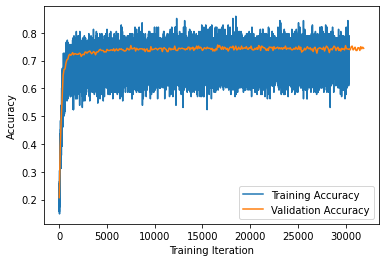

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()